In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# for visualitation import datetime
import datetime

In [3]:
def standardize(tx):
    mean = np.mean(tx, axis=0)
    std = np.std(tx, axis=0)
    tx = (tx-mean)/std
    return tx

# First : exploring the data

We'll need to have a look at what the data is, how it is distributed for the different features, and start to get an intuition about what methods might work better for analysis and prediction later.

## Load the training data into feature matrix, class labels, and event ids:

In [4]:
from proj1_helpers import *

# loading train data
DATA_TRAIN_PATH = '../data/train.csv' 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [5]:
# remove samples with error values
idx_c = np.all(tX!=-999, axis=1)
y_c = y[idx_c]
tX_c = tX[idx_c]

# regularize
mean = np.mean(tX_c, axis=0)
std = np.std(tX_c, axis=0)
tX_c = (tX_c-mean)/std # tX.c contains data without samples with errors

# checking if features have errors or not
f=np.all(tX!=-999, axis=0)

# Removing features with errors (-999)
tX_fc = tX_c[:,f]

# adding column of 1 at the beginning of tX_fc
tX_fc= np.hstack(( np.ones((tX_fc.shape[0], 1), dtype=tX_fc.dtype),tX_fc)) 

In [6]:
# Describing features: True-> No error False -> At least one error
f

array([False,  True,  True,  True, False, False, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False, False,  True])

In [7]:
print(f[22],any(tX[:,22]>3)==True) 
# This shows that the features number of jets has no errors and only four possible values: 0,1,2,3

True False


Overall: s:  85667 , b:  164333  ,total: 250000
NoErrors: s:  31894 , b:  36220  ,total: 68114


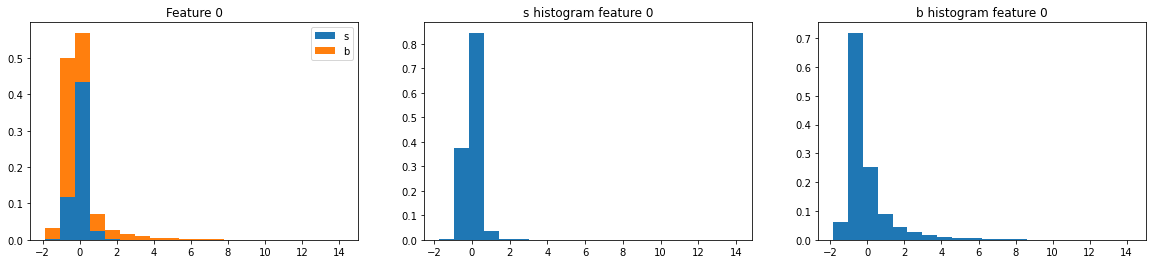

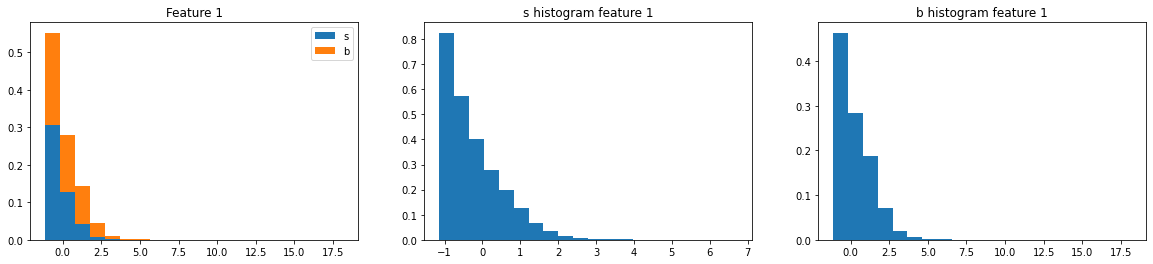

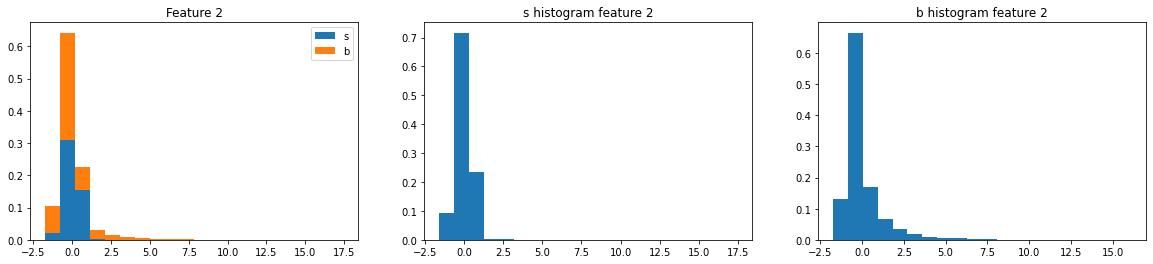

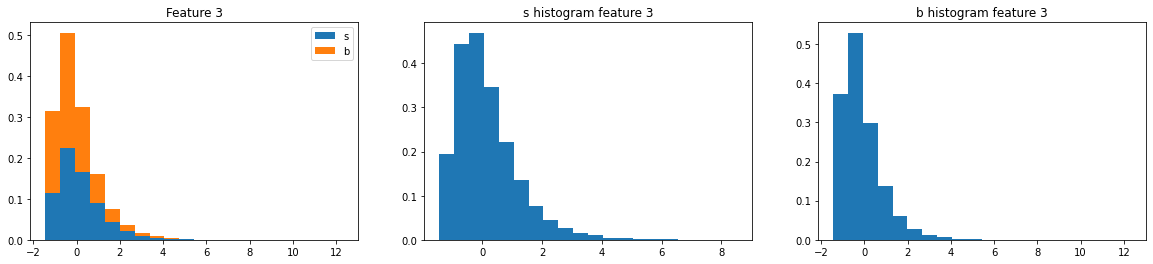

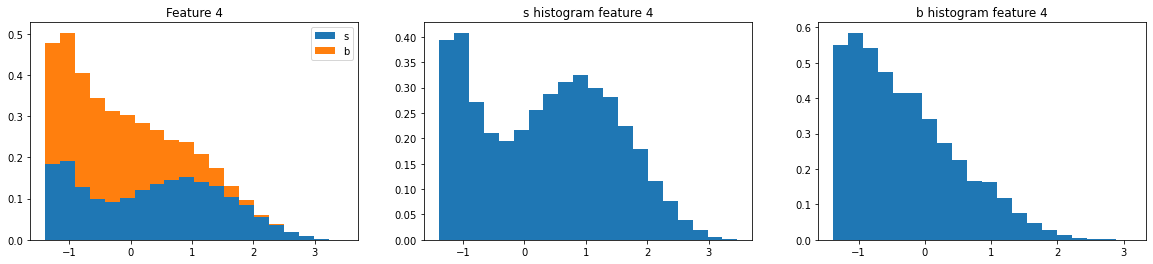

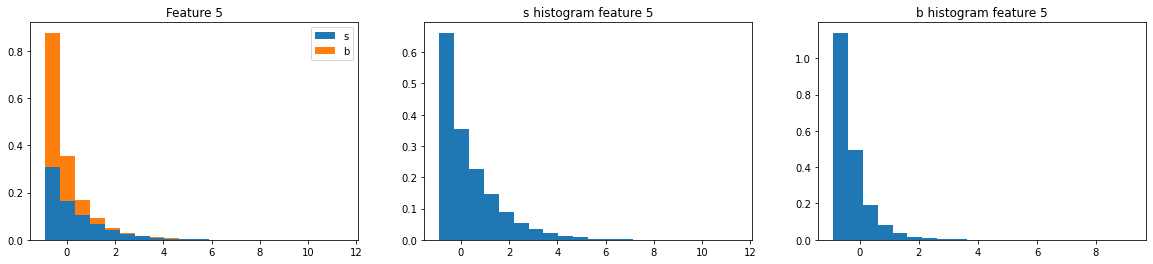

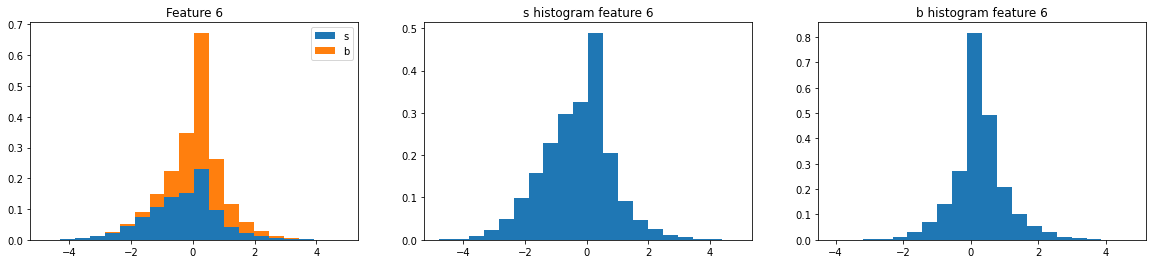

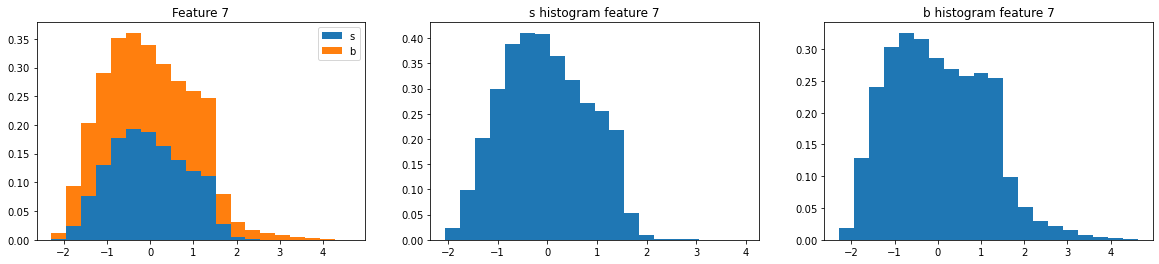

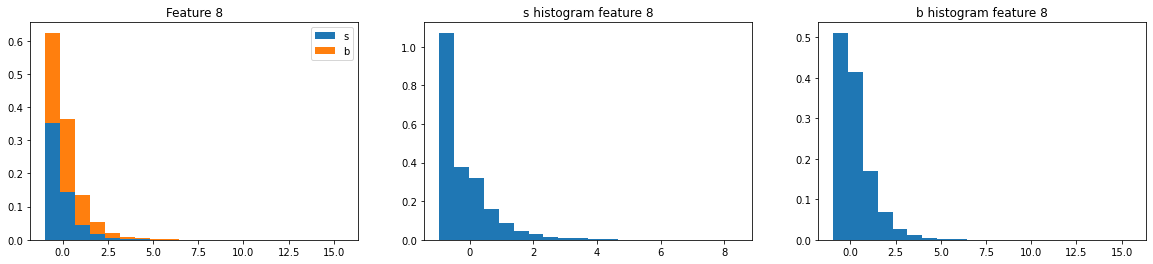

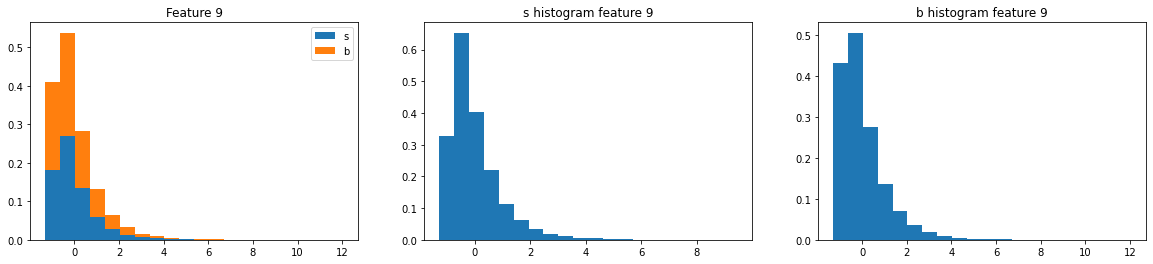

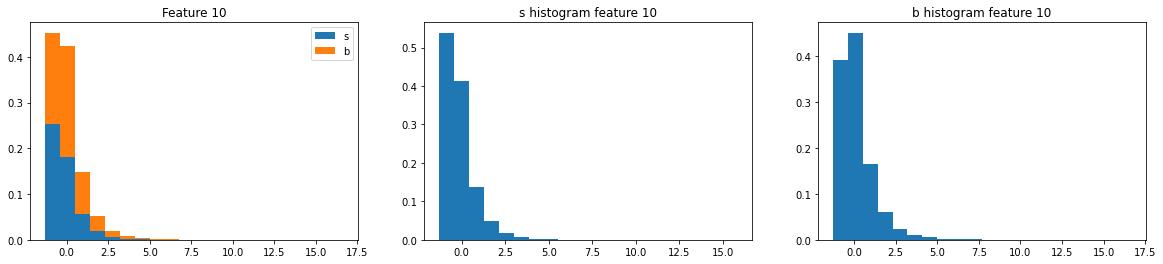

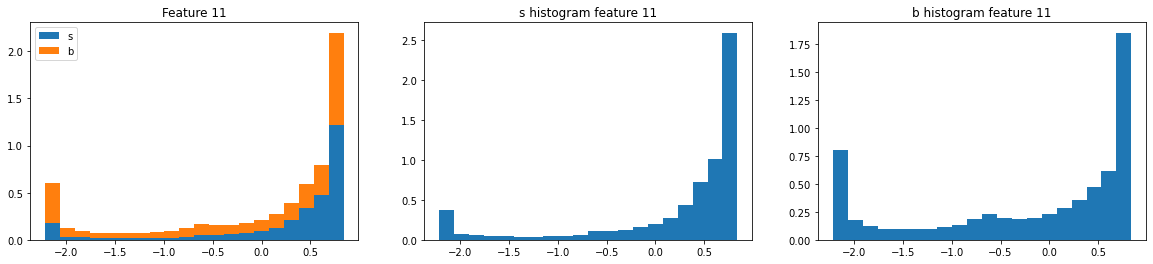

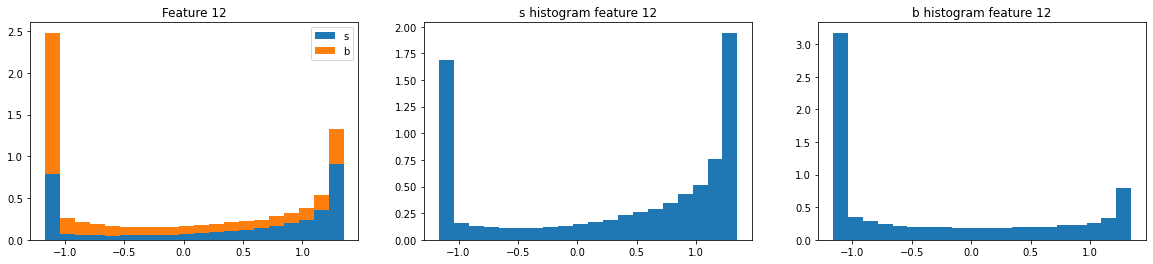

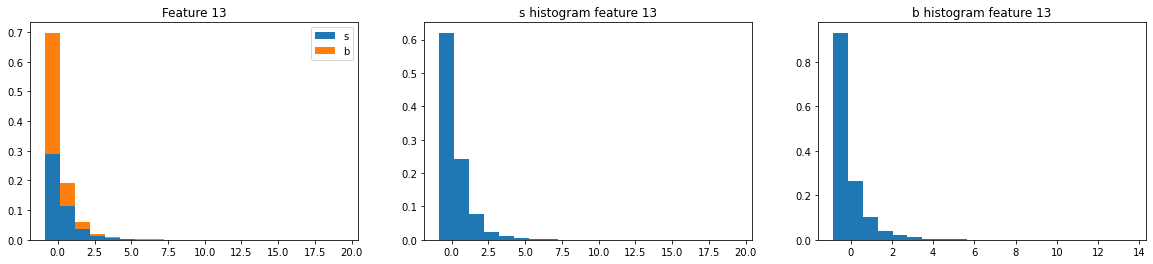

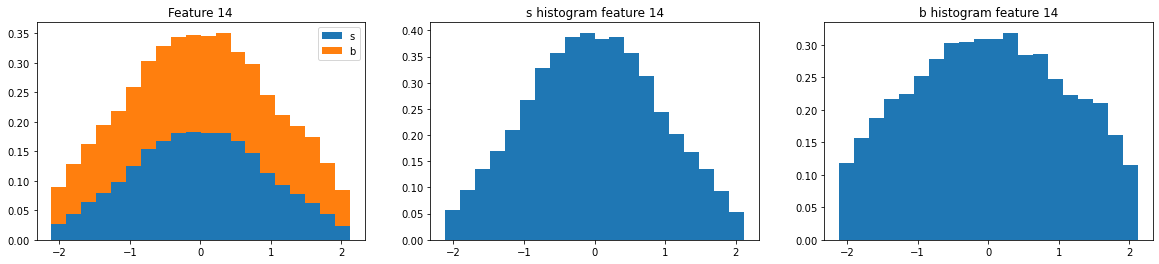

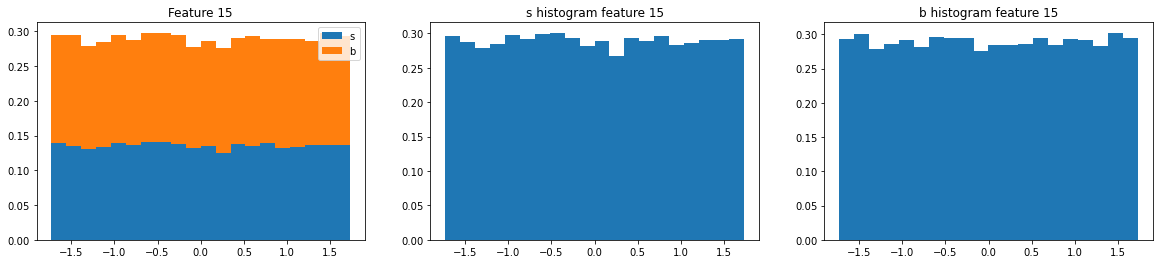

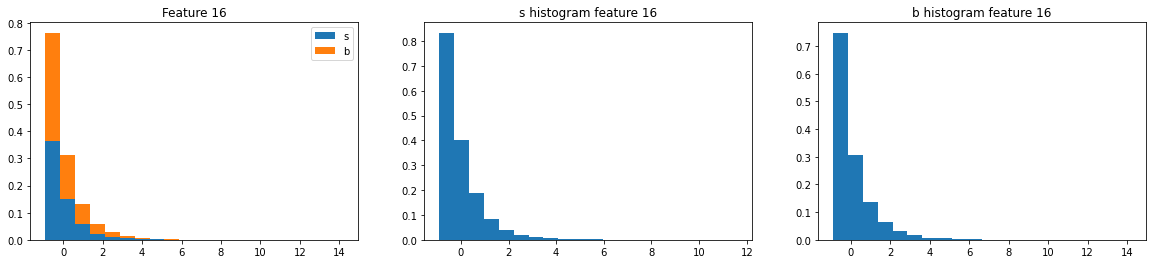

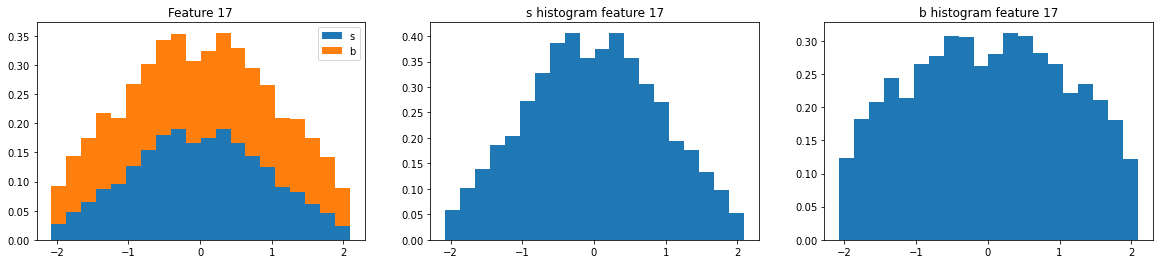

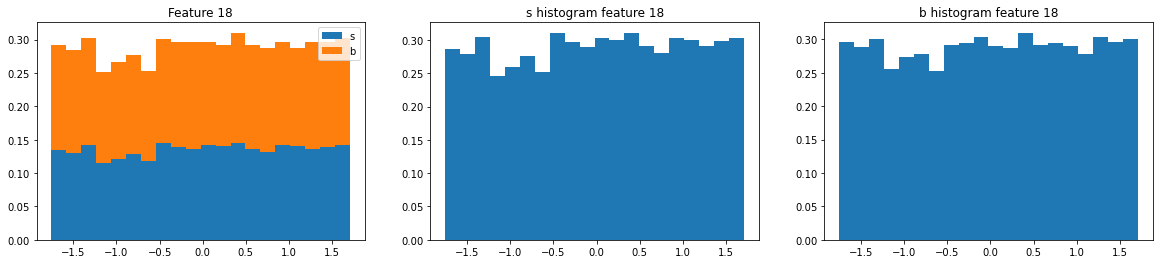

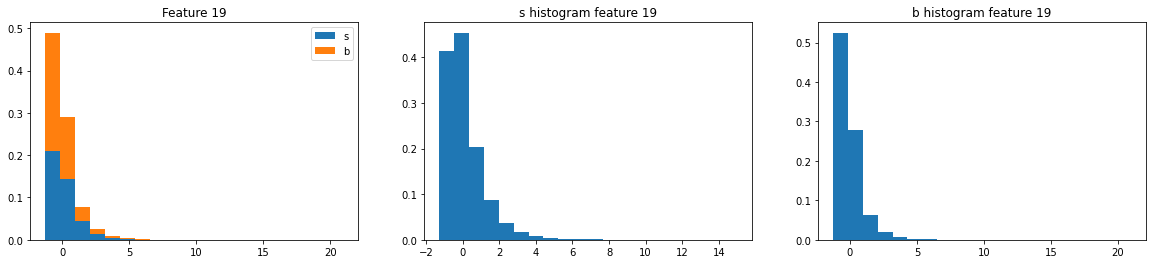

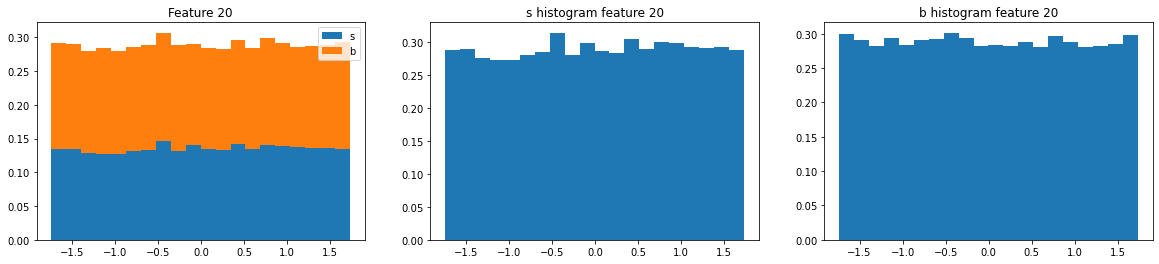

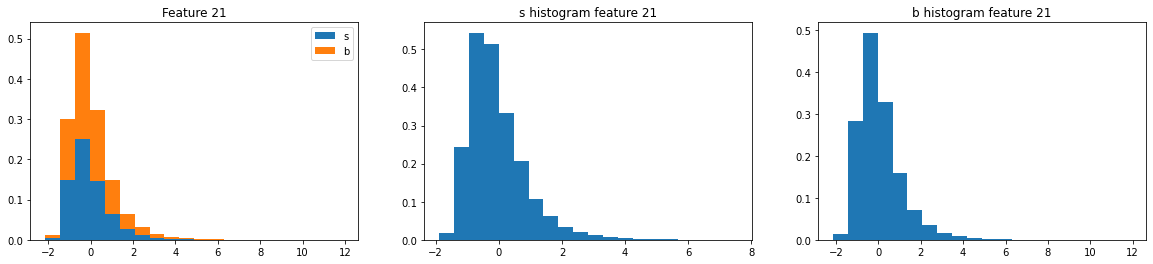

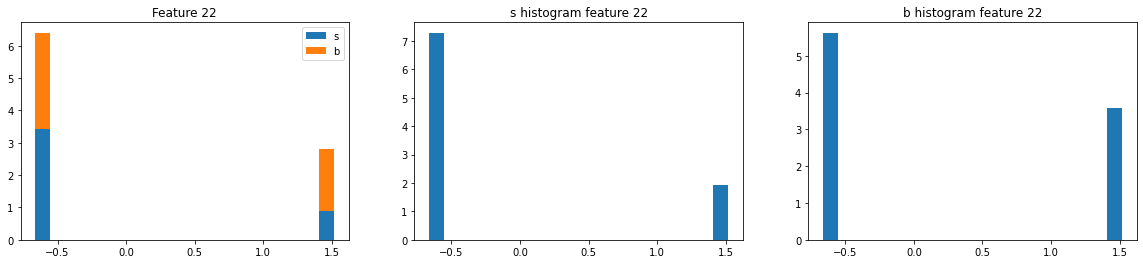

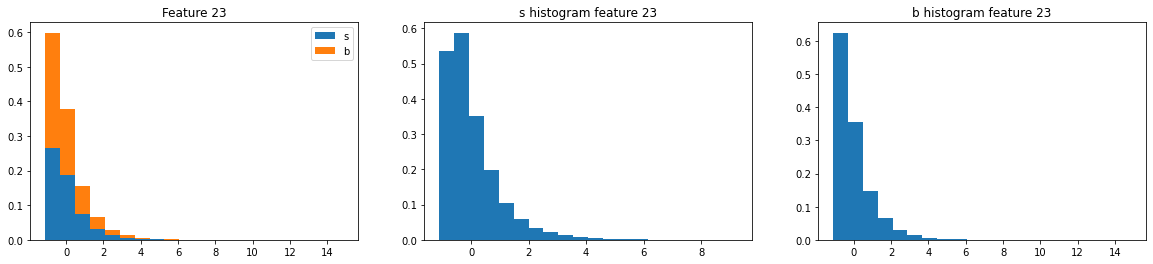

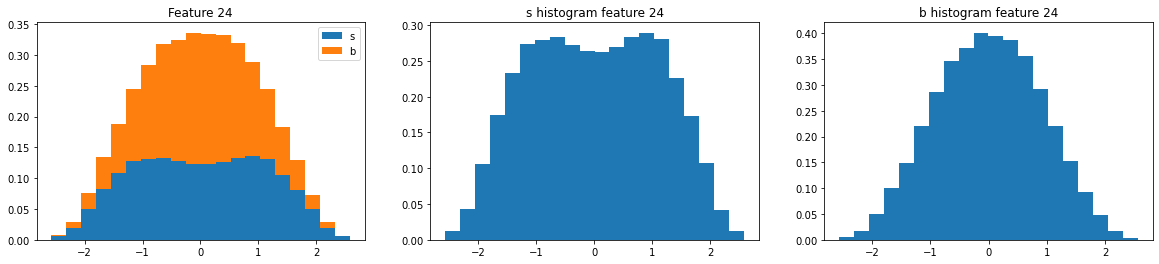

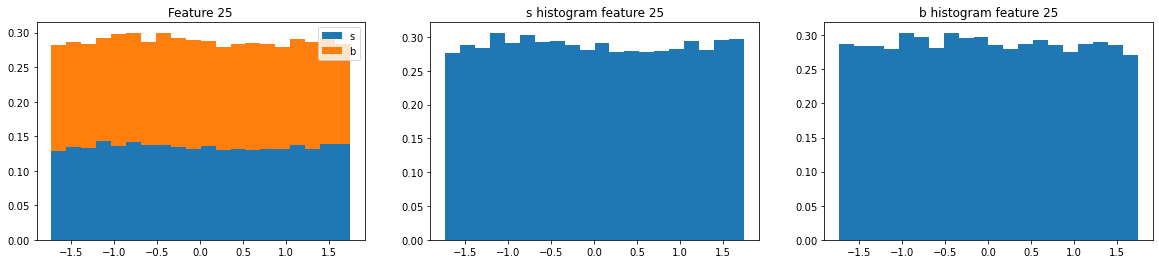

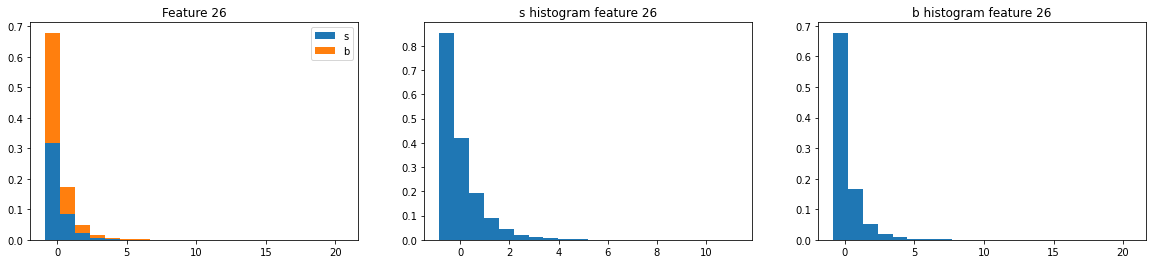

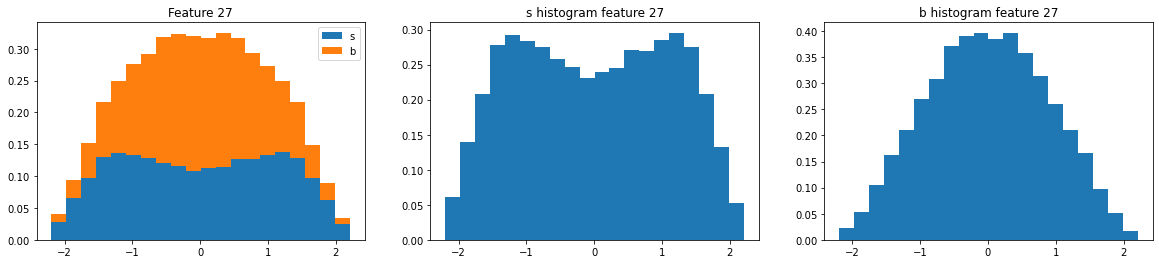

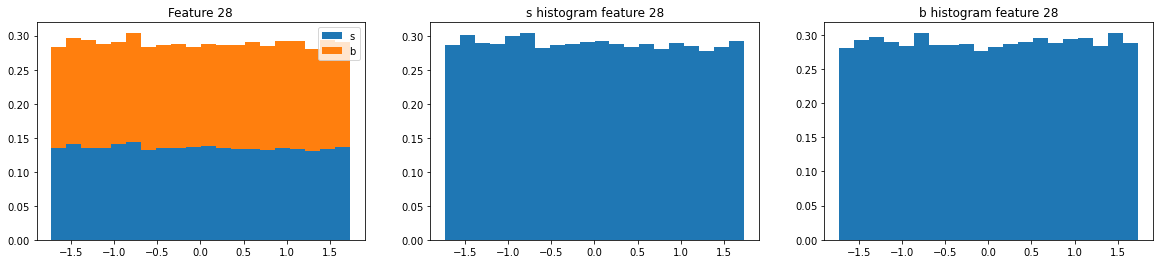

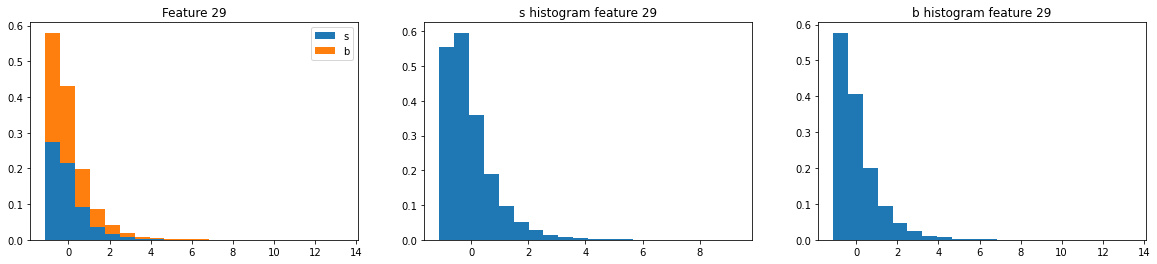

In [8]:
#plot of all features
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
print("NoErrors: s: ",np.sum(y_c==1),", b: ",np.sum(y_c==-1)," ,total:",len(y_c))
for n in range(tX_c.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_c[y_c==1,n],tX_c[y_c==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(n))
    plt.subplot(132)
    plt.title('s histogram feature '+str(n))
    plt.hist(tX_c[y_c==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(n))
    plt.hist(tX_c[y_c==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

In [9]:
# remove features with error values
idx_gf = np.arange(tX.shape[1])[np.all(tX!=-999, axis=0)]
y_gf = y
tX_gf = tX[:,idx_gf]
# regularize
mean = np.mean(tX_gf, axis=0)
std = np.std(tX_gf, axis=0)
tX_gf = (tX_gf-mean)/std

Overall: s:  85667 , b:  164333  ,total: 250000


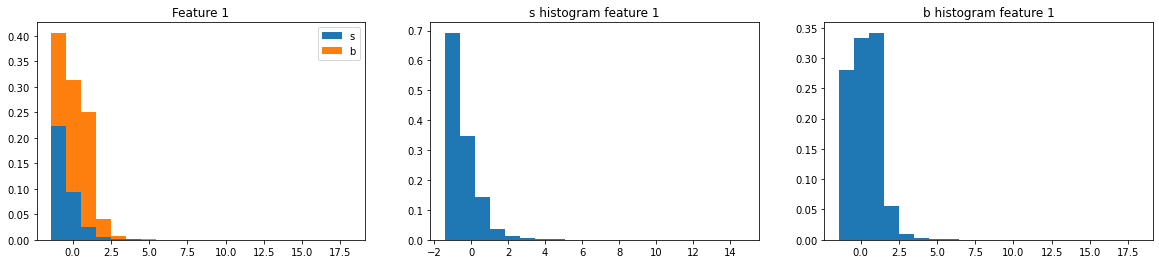

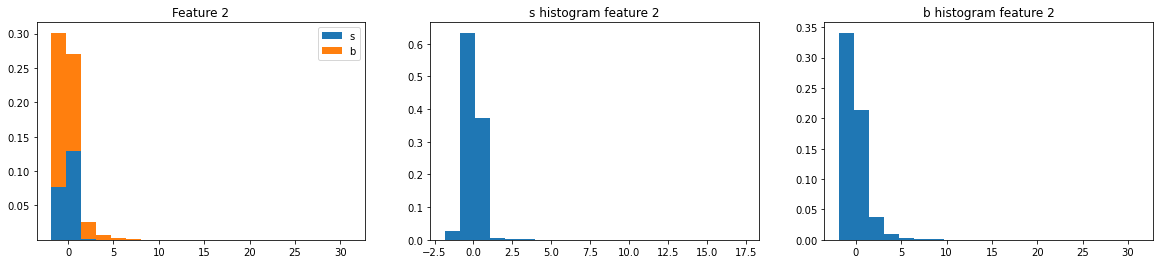

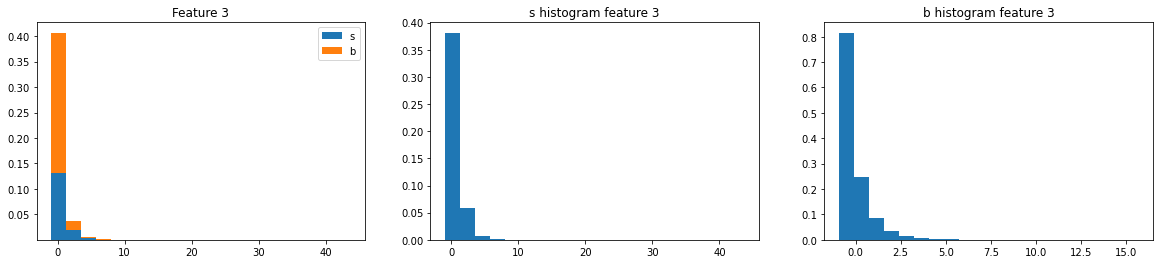

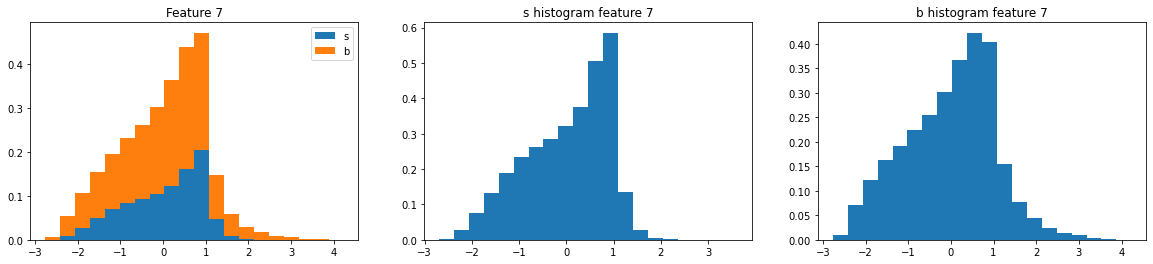

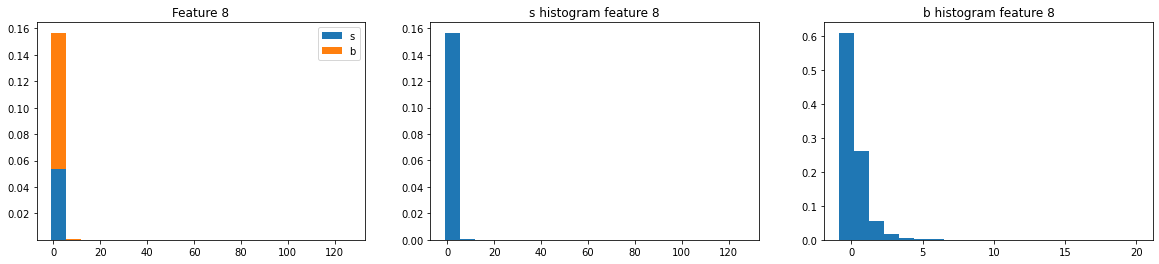

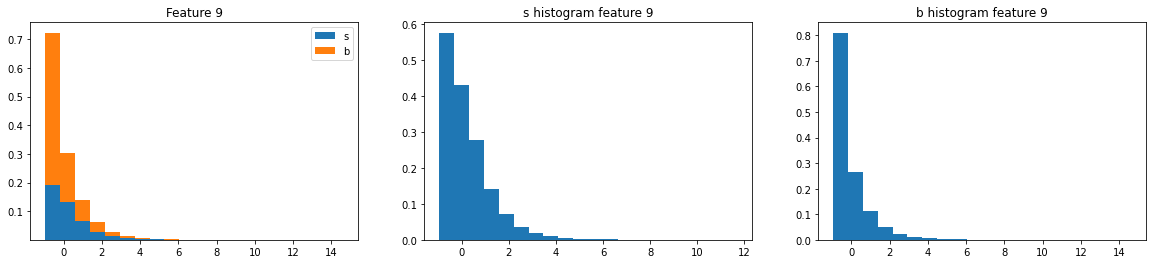

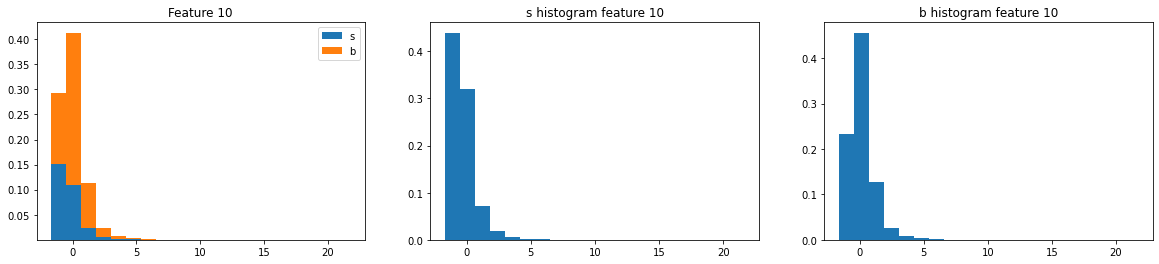

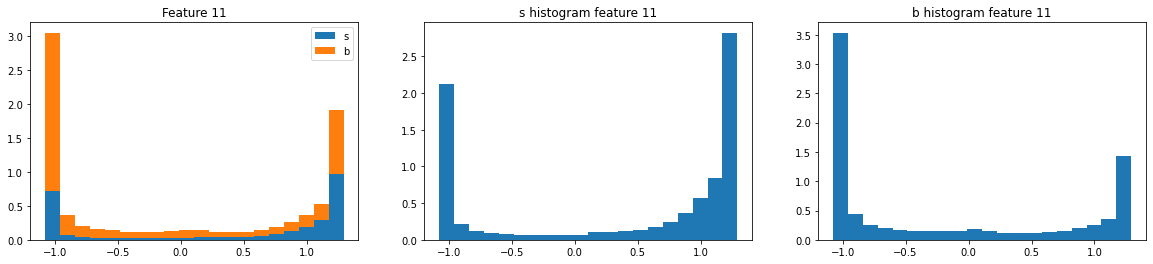

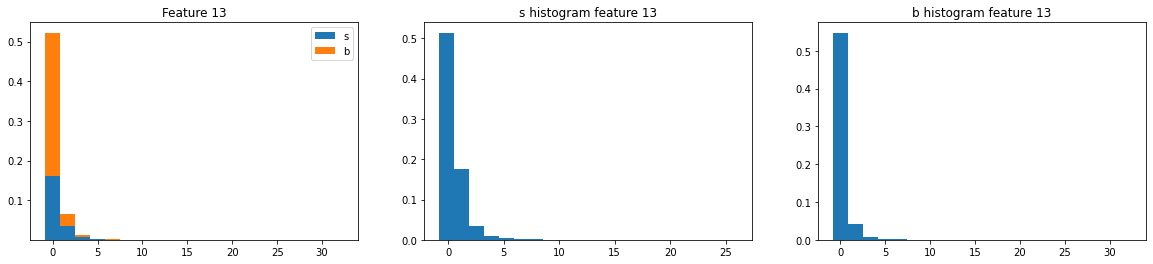

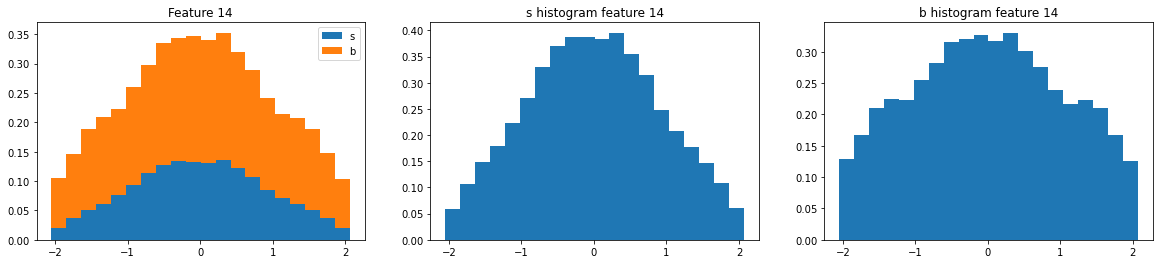

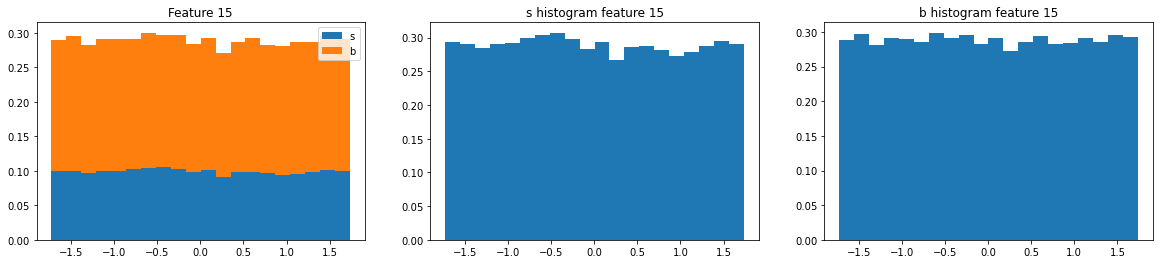

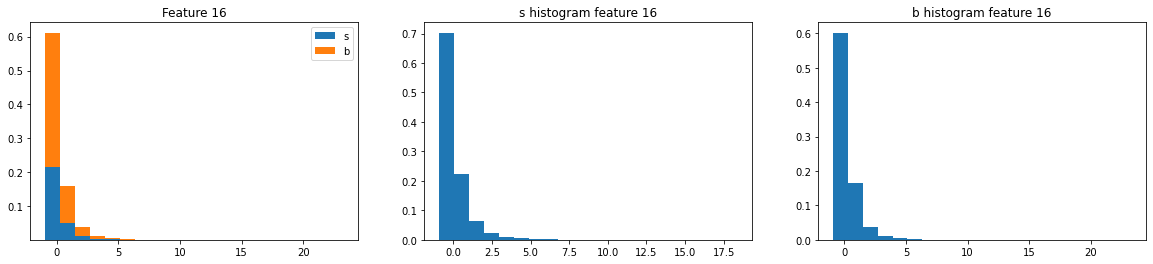

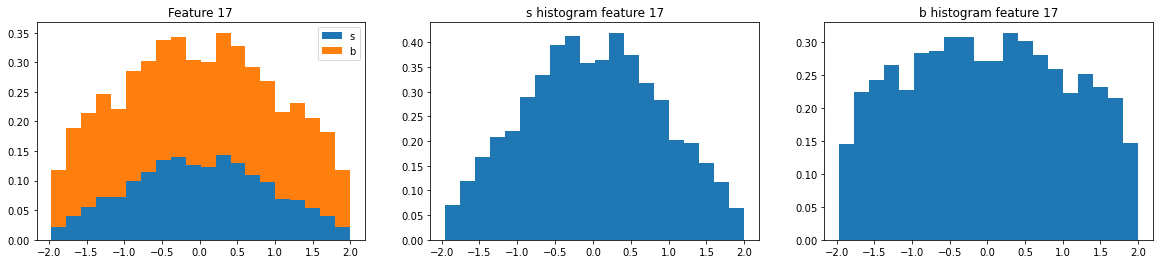

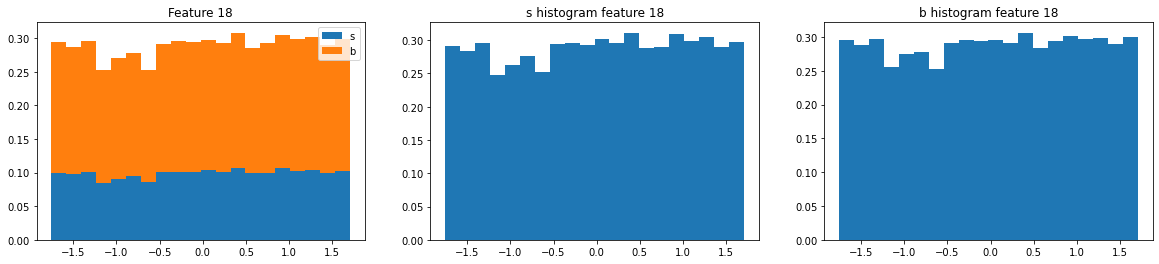

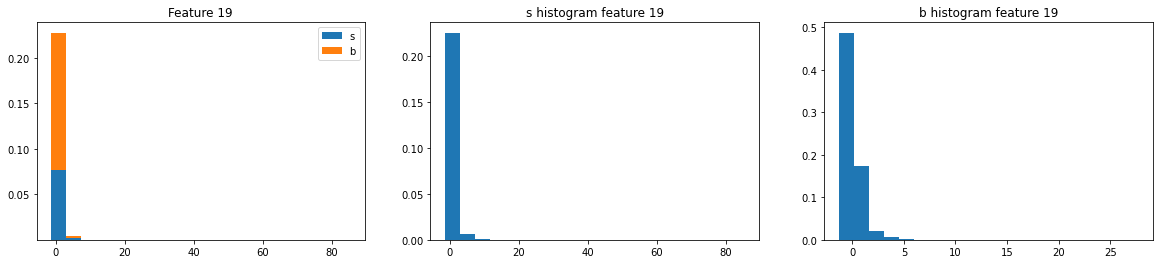

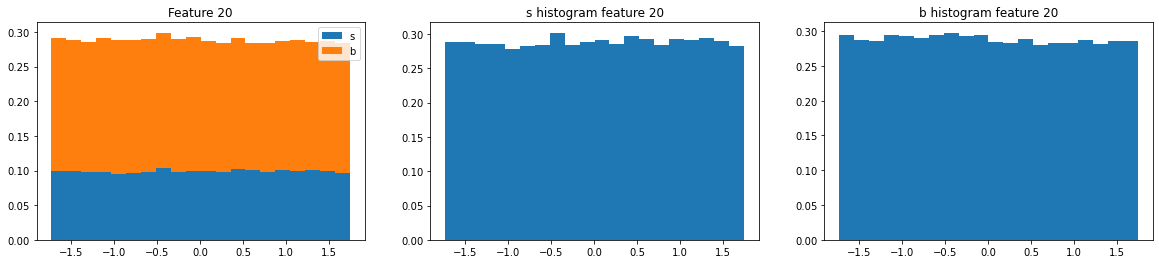

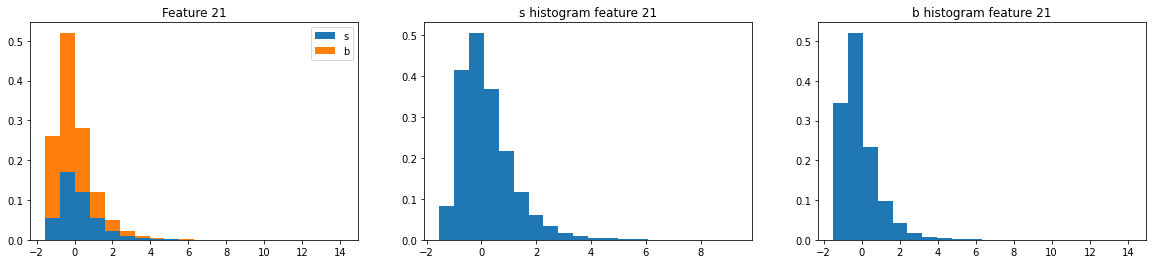

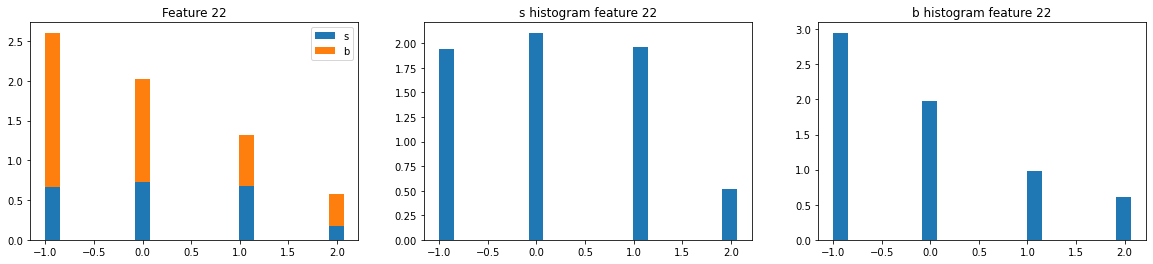

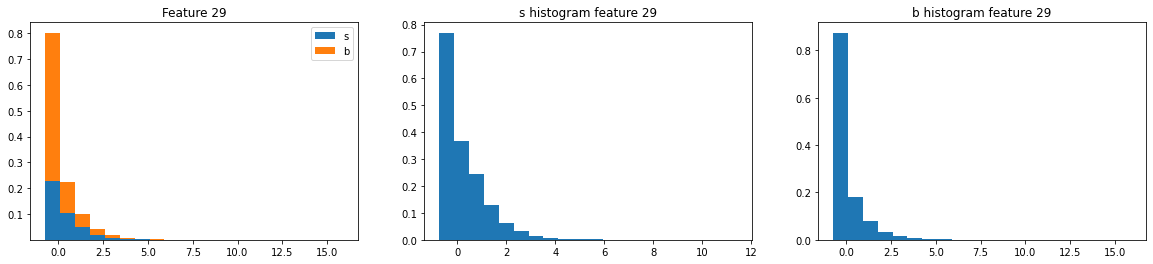

In [10]:
# plot of features without errors
print("Overall: s: ",np.sum(y==1),", b: ",np.sum(y==-1)," ,total:",len(y))
for n in range(tX_gf.shape[1]):
    plt.figure(figsize=(20,4))
    plt.subplot(131)
    plt.hist([tX_gf[y_gf==1,n],tX_gf[y_gf==-1,n]], 20, density=True, histtype='bar', stacked=True)
    plt.legend(['s','b'])
    plt.title('Feature '+str(idx_gf[n]))
    plt.subplot(132)
    plt.title('s histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==1,n], 20, density=True, histtype='bar', stacked=True)
    plt.subplot(133)
    plt.title('b histogram feature '+str(idx_gf[n]))
    plt.hist(tX_gf[y_gf==-1,n], 20, density=True, histtype='bar', stacked=True)    
    plt.show()

# Actual predictions start from here

After having looked at the data we will now do some actual predictions using different models andd parameters. 
Feature 15 ,18, 20 does not seem to impact the result.

In [11]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0 = tX[:,22]==0
jet_1 = tX[:,22]==1
jet_2 = tX[:,22]==2
jet_3 = tX[:,22]==3

#Splitting tX and y
tX_0 = tX[jet_0, :]
tX_1 = tX[jet_1, :]
tX_2 = tX[jet_2, :]
tX_3 = tX[jet_3, :]
y_0 = y[jet_0]
y_1 = y[jet_1]
y_2 = y[jet_2]
y_3 = y[jet_3]

#Removing column with jet number
tX_0=np.delete(tX_0,22,1)
tX_1=np.delete(tX_1,22,1)
tX_2=np.delete(tX_2,22,1)
tX_3=np.delete(tX_3,22,1)

# selection of features without errors in every partition of tX
f_0 =np.all(tX_0!=-999, axis=0)
tX_0_gf = tX_0[:,f_0]
f_1 =np.all(tX_1!=-999, axis=0)
tX_1_gf = tX_1[:,f_1]
f_2 =np.all(tX_2!=-999, axis=0)
tX_2_gf = tX_2[:,f_2]
f_3 =np.all(tX_3!=-999, axis=0)
tX_3_gf = tX_3[:,f_3]
tX_3_gf.shape[0] + tX_2_gf.shape[0] + tX_1_gf.shape[0] + tX_0_gf.shape[0]

250000

In [12]:
#Removing last column of tX_0_gf 
tX_0_gf = tX_0_gf[:,0:tX_0_gf.shape[1]-1]

In [13]:
# Standardize data
tX_0_gf = standardize(tX_0_gf)
tX_1_gf = standardize(tX_1_gf)
tX_2_gf = standardize(tX_2_gf)
tX_3_gf = standardize(tX_3_gf)
tX_0_gf.shape

(99913, 17)

In [14]:
# function that add new features 
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=1 up to j=degree."""
    phi=np.zeros((x.shape[0],degree*x.shape[1]))
    for j in range(degree):
            phi[:,j*x.shape[1]:(j+1)*x.shape[1]]=x**(j+1)
    return phi

In [15]:
# Passing to polynomial regression of degree= 'degree'
# Deciding degree
degree = 1

tX_0_gf=build_poly(tX_0_gf, degree)
tX_1_gf=build_poly(tX_1_gf, degree)
tX_2_gf=build_poly(tX_2_gf, degree)
tX_3_gf=build_poly(tX_3_gf, degree)

In [16]:
# adding column of 1 at the beginning of tX_gf
tX_0_gf= np.hstack(( np.ones((tX_0_gf.shape[0], 1), dtype=tX_0_gf.dtype),tX_0_gf))
tX_1_gf= np.hstack(( np.ones((tX_1_gf.shape[0], 1), dtype=tX_1_gf.dtype),tX_1_gf))
tX_2_gf= np.hstack(( np.ones((tX_2_gf.shape[0], 1), dtype=tX_2_gf.dtype),tX_2_gf))
tX_3_gf= np.hstack(( np.ones((tX_3_gf.shape[0], 1), dtype=tX_3_gf.dtype),tX_3_gf))


In [17]:
from implementations import *

# indices of samples with no errors
ids_=ids[idx_c]

In [18]:
# least_squares method 
w_ls_0, loss_ls_0 =least_squares(y_0,tX_0_gf)
w_ls_1, loss_ls_1 =least_squares(y_1,tX_1_gf)
w_ls_2, loss_ls_2 =least_squares(y_2,tX_2_gf)
w_ls_3, loss_ls_3 =least_squares(y_3,tX_3_gf)
loss_ls_0, loss_ls_1,loss_ls_2,loss_ls_3
#w_ls_0, w_ls_1, w_ls_2, w_ls_3

(0.27213922342912444,
 0.3727001174476139,
 0.35542370977924176,
 0.3594284375632391)

In [19]:
# Least square using GD

# starting value for GD method
w_in_0_GD= np.zeros((tX_0_gf.shape[1],))
w_in_1_GD= np.zeros((tX_1_gf.shape[1],))
w_in_2_GD= np.zeros((tX_2_gf.shape[1],))
w_in_3_GD= np.zeros((tX_3_gf.shape[1],))

# number of iterations for GD method
max_iters=1000

# step-size of the method
gamma_GD = 0.01

In [20]:
# application of the LS GD method to the separated dataset
# 0 jet
w_ls_GD_0 = w_in_0_GD
for iter in range(max_iters):
    w_ls_GD_0, loss_ls_GD_0 = least_squares_GD(y_0,tX_0_gf, w_ls_GD_0, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_0, w0=w_ls_GD_0))

Gradient Descent(0/999): loss=0.49357286346805435, w=[-4.89716053e-03 -3.60114905e-03  2.84309219e-04  9.85883536e-05
  1.92338797e-03  9.85883602e-05  1.01762383e-03 -2.90339137e-03
  1.32911360e-03  2.55892263e-03  5.66382172e-05 -4.88423873e-05
 -1.02803664e-03  1.22117317e-04  3.77761388e-05 -2.11842399e-03
  1.03424831e-05  8.96632760e-04]
Gradient Descent(1/999): loss=0.4873917721817761, w=[-9.74534945e-03 -7.11699571e-03  5.39440426e-04  1.91750507e-04
  3.80146221e-03  1.91750519e-04  2.01464536e-03 -5.73150535e-03
  2.62405128e-03  5.05781528e-03  1.10829160e-04 -9.65333291e-05
 -2.02667401e-03  2.41189066e-04  7.47588354e-05 -4.17897944e-03
  1.92514745e-05  1.76769772e-03]
Gradient Descent(2/999): loss=0.4814457800291571, w=[-1.45450565e-02 -1.05496767e-02  7.66267558e-04  2.79682333e-04
  5.63545858e-03  2.79682351e-04  2.99162853e-03 -8.48623236e-03
  3.88570203e-03  7.49821523e-03  1.62646987e-04 -1.43101037e-04
 -2.99660629e-03  3.57298776e-04  1.10962610e-04 -6.18312474

 -0.02088361  0.00268248  0.00085974 -0.04430735 -0.00016711  0.01854118]
Gradient Descent(31/999): loss=0.37669946479983607, w=[-0.13468154 -0.08183868 -0.00180803  0.00123803  0.04416779  0.00123803
  0.02463391 -0.0634576   0.02925974  0.05847454  0.00090227 -0.00110933
 -0.02126284  0.00274045  0.00087861 -0.04517092 -0.00018396  0.01889981]
Gradient Descent(32/999): loss=0.3745966009297435, w=[-0.13823189 -0.08354613 -0.00212544  0.00123426  0.04511708  0.00123426
  0.02520497 -0.06469202  0.02983944  0.059708    0.00090889 -0.00113235
 -0.02162827  0.00279714  0.00089704 -0.0460083  -0.00020125  0.01924765]
Gradient Descent(33/999): loss=0.3725569840243991, w=[-0.14174673 -0.08521565 -0.00245352  0.00122893  0.0460478   0.00122893
  0.02576727 -0.06589312  0.03040437  0.06091501  0.00091464 -0.00115483
 -0.02198026  0.00285258  0.00091502 -0.04682016 -0.00021896  0.01958501]
Gradient Descent(34/999): loss=0.3705782110654303, w=[-0.14522642 -0.08684818 -0.00279191  0.00122213  0.0

 -1.41512719e-03  2.79174446e-02]
Gradient Descent(87/999): loss=0.31523923050864155, w=[-2.87487970e-01 -1.38393481e-01 -2.91678484e-02 -1.63708466e-04
  7.90345609e-02 -1.63709099e-04  4.74723517e-02 -9.84480545e-02
  4.66472993e-02  1.00216942e-01  5.16643083e-04 -1.84305789e-03
 -2.79555583e-02  4.66878979e-03  1.41220024e-03 -6.59649439e-02
 -1.43838864e-03  2.79657125e-02]
Gradient Descent(88/999): loss=0.31471640071122553, w=[-2.89510251e-01 -1.38946272e-01 -2.97440863e-02 -1.96580751e-04
  7.94564798e-02 -1.96581398e-04  4.77691607e-02 -9.86779115e-02
  4.67830362e-02  1.00639577e-01  5.03250544e-04 -1.84944670e-03
 -2.79173986e-02  4.68916605e-03  1.41521391e-03 -6.60345341e-02
 -1.46158235e-03  2.80117230e-02]
Gradient Descent(89/999): loss=0.314204113390116, w=[-2.91512309e-01 -1.39489684e-01 -3.03212789e-02 -2.29437292e-04
  7.98746900e-02 -2.29437952e-04  4.80634916e-02 -9.88998637e-02
  4.69152212e-02  1.01055458e-01  4.89801990e-04 -1.85569045e-03
 -2.78761898e-02  4.709

 -2.05454809e-03  2.85967541e-02]
Gradient Descent(116/999): loss=0.3035433609075629, w=[-3.38616873e-01 -1.51324277e-01 -4.60646220e-02 -1.09104387e-03
  9.00949694e-02 -1.09104491e-03  5.52210097e-02 -1.02540932e-01
  4.94110920e-02  1.10217249e-01  1.20661220e-04 -1.97937697e-03
 -2.58805204e-02  5.16805335e-03  1.44733355e-03 -6.60077751e-02
 -2.07508010e-03  2.86000310e-02]
Gradient Descent(117/999): loss=0.30324177102070377, w=[-3.40127864e-01 -1.51679220e-01 -4.66476576e-02 -1.12151731e-03
  9.04437076e-02 -1.12151837e-03  5.54614006e-02 -1.02608258e-01
  4.94720303e-02  1.10494984e-01  1.07195669e-04 -1.98260426e-03
 -2.57822005e-02  5.18256933e-03  1.44695579e-03 -6.59522919e-02
 -2.09550092e-03  2.86023404e-02]
Gradient Descent(118/999): loss=0.30294545368750697, w=[-3.41623746e-01 -1.52029484e-01 -4.72303563e-02 -1.15186597e-03
  9.07908829e-02 -1.15186705e-03  5.57002957e-02 -1.02671914e-01
  4.95312020e-02  1.10769203e-01  9.37677689e-05 -1.98575333e-03
 -2.56826264e-02  5

 -2.65524299e-03  2.83414244e-02]
Gradient Descent(148/999): loss=0.29602598797958185, w=[-3.80172118e-01 -1.60813405e-01 -6.44494737e-02 -2.00136795e-03
  1.00665956e-01 -2.00136948e-03  6.22689168e-02 -1.03283540e-01
  5.06552262e-02  1.17676502e-01 -2.85286622e-04 -2.05059212e-03
 -2.22842512e-02  5.57470199e-03  1.40111201e-03 -6.31204506e-02
 -2.67214131e-03  2.83249332e-02]
Gradient Descent(149/999): loss=0.29584786167948707, w=[-3.81267558e-01 -1.61060985e-01 -6.50120737e-02 -2.02764803e-03
  1.00981971e-01 -2.02764957e-03  6.24706330e-02 -1.03271762e-01
  5.06756165e-02  1.17871401e-01 -2.96989014e-04 -2.05195255e-03
 -2.21619124e-02  5.58582689e-03  1.39877548e-03 -6.30021767e-02
 -2.68892842e-03  2.83081047e-02]
Gradient Descent(150/999): loss=0.29567242968307633, w=[-3.82352043e-01 -1.61306285e-01 -6.55738152e-02 -2.05380082e-03
  1.01297378e-01 -2.05380238e-03  6.26713824e-02 -1.03258488e-01
  5.06951471e-02  1.18064474e-01 -3.08625768e-04 -2.05327130e-03
 -2.20392293e-02  

 -0.01538241  0.00609181  0.00123389 -0.05541675 -0.00344368  0.02714595]
Gradient Descent(204/999): loss=0.2890674199514057, w=[-0.4273197  -0.17215767 -0.09449991 -0.00330066  0.11774041 -0.00330066
  0.0723239  -0.10121389  0.05085274  0.12650308 -0.0008392  -0.00207906
 -0.01525824  0.00609973  0.00123046 -0.05526308 -0.00345513  0.0271229 ]
Gradient Descent(205/999): loss=0.28898258304955554, w=[-0.42794366 -0.1723273  -0.09500842 -0.00332116  0.11803755 -0.00332117
  0.07248421 -0.10116311  0.05084414  0.12663232 -0.00084729 -0.00207893
 -0.01513422  0.00610761  0.00122701 -0.05510916 -0.0034665   0.02709988]
Gradient Descent(206/999): loss=0.2888986888475143, w=[-0.42856138 -0.17249611 -0.09551595 -0.00334159  0.11833449 -0.00334159
  0.07264396 -0.10111216  0.05083525  0.12676083 -0.00085533 -0.00207877
 -0.01501037  0.00611544  0.00122356 -0.05495499 -0.00347779  0.02707687]
Gradient Descent(207/999): loss=0.28881572091870544, w=[-0.42917293 -0.17266413 -0.09602248 -0.00336194

 -0.00850648  0.00648431  0.00103538 -0.04628037 -0.00399048  0.02590187]
Gradient Descent(262/999): loss=0.2853102339239049, w=[-0.45488228 -0.18093819 -0.12240351 -0.00438661  0.13466798 -0.00438662
  0.08079054 -0.09820724  0.05000323  0.13302773 -0.00122268 -0.00205036
 -0.00839443  0.00648999  0.0010321  -0.04612147 -0.0039981   0.02588276]
Gradient Descent(263/999): loss=0.28526063564284654, w=[-0.45523062 -0.18107448 -0.12285734 -0.00440388  0.13495433 -0.00440388
  0.08092338 -0.09815727  0.04998406  0.13312615 -0.00122794 -0.00204958
 -0.0082826   0.00649564  0.00102882 -0.04596259 -0.00400566  0.02586374]
Gradient Descent(264/999): loss=0.28521140557808955, w=[-0.45557547 -0.18121036 -0.1233103  -0.0044211   0.13524048 -0.0044211
  0.08105583 -0.09810743  0.04996478  0.13322418 -0.00123315 -0.00204879
 -0.008171    0.00650125  0.00102555 -0.04580372 -0.00401318  0.02584482]
Gradient Descent(265/999): loss=0.28516253839337036, w=[-0.45591688 -0.18134583 -0.12376237 -0.00443829

 -0.00524348  0.00664083  0.00094062 -0.04152971 -0.00419789  0.02537026]
Gradient Descent(292/999): loss=0.2839632577742508, w=[-0.4639495  -0.18485795 -0.13564475 -0.00488969  0.14316944 -0.00488969
  0.08461214 -0.09677201  0.04938814  0.13582134 -0.00136399 -0.00202401
 -0.00513817  0.00664557  0.00093761 -0.04137221 -0.00420411  0.02535404]
Gradient Descent(293/999): loss=0.28392273925758504, w=[-0.46420716 -0.18498299 -0.13607316 -0.00490599  0.14344952 -0.004906
  0.08473399 -0.09672665  0.04936644  0.13590919 -0.00136816 -0.00202304
 -0.00503308  0.00665028  0.0009346  -0.04121478 -0.00421028  0.02533793]
Gradient Descent(294/999): loss=0.2838824650753422, w=[-0.46446225 -0.18510769 -0.13650075 -0.00492227  0.14372938 -0.00492227
  0.08485549 -0.09668146  0.04934467  0.13599673 -0.0013723  -0.00202206
 -0.00492822  0.00665496  0.00093161 -0.04105743 -0.00421642  0.02532191]
Gradient Descent(295/999): loss=0.28384243215747185, w=[-0.46471479 -0.18523205 -0.13692753 -0.00493852  

 -0.00061628  0.00683047  0.00081257 -0.03437552 -0.00444559  0.02472413]
Gradient Descent(338/999): loss=0.2823133464928543, w=[-0.47348767 -0.19028434 -0.15454271 -0.00561672  0.15581182 -0.00561673
  0.08988814 -0.09486871  0.04833977  0.13956098 -0.00152513 -0.00197468
 -0.00052037  0.00683399  0.00081004 -0.03422238 -0.00445021  0.02471229]
Gradient Descent(339/999): loss=0.2822815731086573, w=[-4.73649952e-01 -1.90395431e-01 -1.54935912e-01 -5.63209288e-03
  1.56080915e-01 -5.63209724e-03  8.99958659e-02 -9.48315726e-02
  4.83161657e-02  1.39635961e-01 -1.52800584e-03 -1.97352132e-03
 -4.24654532e-04  6.83748812e-03  8.07508743e-04 -3.40693530e-02
 -4.45478834e-03  2.47005391e-02]
Gradient Descent(340/999): loss=0.2822499463092589, w=[-4.73810613e-01 -1.90506252e-01 -1.55328398e-01 -5.64744779e-03
  1.56349756e-01 -5.64745215e-03  9.01033130e-02 -9.47946118e-02
  4.82925361e-02  1.39710694e-01 -1.53086052e-03 -1.97235575e-03
 -3.29124043e-04  6.84096147e-03  8.04991433e-04 -3.391

  0.00422348  0.00698691  0.00069208 -0.02642795 -0.00465468  0.02421542]
Gradient Descent(391/999): loss=0.2808042911239698, w=[-0.48018939 -0.1958184  -0.17443517 -0.00641341  0.16971158 -0.00641342
  0.09524102 -0.09314419  0.04707165  0.14321562 -0.00164833 -0.00190939
  0.00431035  0.00698932  0.00069007 -0.02628151 -0.00465801  0.02420802]
Gradient Descent(392/999): loss=0.2807787919667998, w=[-0.48028466 -0.19591628 -0.17479276 -0.00642814  0.16996655 -0.00642815
  0.0953355  -0.0931163   0.04704764  0.14327873 -0.00165014 -0.0019081
  0.00439707  0.00699171  0.00068807 -0.02613521 -0.00466133  0.02420069]
Gradient Descent(393/999): loss=0.28075338867072713, w=[-0.48037897 -0.19601394 -0.17514972 -0.00644287  0.17022124 -0.00644287
  0.09542975 -0.09308857  0.04702363  0.14334164 -0.00165194 -0.0019068
  0.00448364  0.00699409  0.00068608 -0.02598904 -0.00466463  0.02419344]
Gradient Descent(394/999): loss=0.2807280806030022, w=[-0.48047235 -0.19611137 -0.17550605 -0.00645758  0

  0.00798998  0.00707865  0.00061046 -0.01997724 -0.00478716  0.02395333]
Gradient Descent(436/999): loss=0.27974383156932486, w=[-0.48365533 -0.20000677 -0.18992628 -0.0070677   0.18090848 -0.00706771
  0.09928087 -0.0920483   0.04600077  0.14586422 -0.00171471 -0.00184986
  0.00807056  0.00708033  0.00060884 -0.0198372  -0.00478974  0.02394905]
Gradient Descent(437/999): loss=0.27972211869959435, w=[-0.48371594 -0.20009503 -0.19025707 -0.00708206  0.18115082 -0.00708206
  0.09936598 -0.09202751  0.0459773   0.14591884 -0.00171587 -0.00184851
  0.00815101  0.00708199  0.00060723 -0.0196973  -0.0047923   0.02394484]
Gradient Descent(438/999): loss=0.27970047970670037, w=[-0.48377594 -0.20018309 -0.1905873  -0.0070964   0.18139288 -0.00709641
  0.0994509  -0.09200687  0.04595385  0.14597328 -0.00171701 -0.00184716
  0.00823134  0.00708364  0.00060563 -0.01955755 -0.00479484  0.0239407 ]
Gradient Descent(439/999): loss=0.279678914218302, w=[-0.48383534 -0.20027095 -0.19091696 -0.00711074

  0.01043106  0.00712441  0.00056377 -0.01570459 -0.00486069  0.0238489 ]
Gradient Descent(467/999): loss=0.27910352142722034, w=[-0.48527777 -0.20265219 -0.19992425 -0.00750913  0.18828918 -0.00750914
  0.10183286 -0.09147142  0.04528283  0.14747793 -0.00174502 -0.00180768
  0.01050792  0.00712568  0.00056238 -0.01556915 -0.00486286  0.02384646]
Gradient Descent(468/999): loss=0.27908394090097305, w=[-0.48532215 -0.20273449 -0.20023814 -0.00752325  0.18852273 -0.00752326
  0.1019123  -0.09145507  0.04526003  0.14752733 -0.00174582 -0.00180631
  0.01058468  0.00712694  0.00056099 -0.01543385 -0.00486502  0.02384406]
Gradient Descent(469/999): loss=0.2790644242287691, w=[-0.48536609 -0.20281661 -0.20055151 -0.00753736  0.18875599 -0.00753737
  0.10199158 -0.09143886  0.04523725  0.14757657 -0.0017466  -0.00180494
  0.01066132  0.00712819  0.00055962 -0.01529871 -0.00486717  0.02384172]
Gradient Descent(470/999): loss=0.27904497113168025, w=[-0.48540959 -0.20289854 -0.20086435 -0.0075514

  0.01363994  0.00716904  0.00050984 -0.0100166  -0.0049443   0.02378975]
Gradient Descent(510/999): loss=0.2783160335067027, w=[-0.48683515 -0.20603099 -0.21296041 -0.00810972  0.19807628 -0.00810972
  0.10509919 -0.09088778  0.04432622  0.14946214 -0.00177086 -0.00174855
  0.01371234  0.00716985  0.00050871 -0.00988765 -0.00494603  0.02378942]
Gradient Descent(511/999): loss=0.27829897175968865, w=[-0.48686396 -0.20610581 -0.21325268 -0.00812352  0.19829769 -0.00812353
  0.10517166 -0.090877    0.04430459  0.149505   -0.00177127 -0.00174718
  0.01378465  0.00717065  0.0005076  -0.00975886 -0.00494775  0.02378914]
Gradient Descent(512/999): loss=0.2782819636101455, w=[-0.48689248 -0.20618047 -0.21354448 -0.00813732  0.19851882 -0.00813732
  0.10524398 -0.09086635  0.04428299  0.14954772 -0.00177167 -0.0017458
  0.01385687  0.00717145  0.00050649 -0.00963021 -0.00494946  0.0237889 ]
Gradient Descent(513/999): loss=0.2782650088542499, w=[-0.48692071 -0.20625496 -0.21383579 -0.00815111  

Gradient Descent(565/999): loss=0.2774522710887483, w=[-4.88058511e-01 -2.09912857e-01 -2.28348163e-01 -8.85750026e-03
  2.09842255e-01 -8.85750769e-03  1.08871222e-01 -9.04672287e-02
  4.31819471e-02  1.51615626e-01 -1.78299290e-03 -1.67321536e-03
  1.75568892e-02  7.20155037e-03  4.54974122e-04 -3.02857851e-03
 -5.02872118e-03  2.38330098e-02]
Gradient Descent(566/999): loss=0.2774378835461778, w=[-4.88075087e-01 -2.09979242e-01 -2.28615455e-01 -8.87087308e-03
  2.10048509e-01 -8.87088052e-03  1.08935983e-01 -9.04626678e-02
  4.31620234e-02  1.51651109e-01 -1.78303891e-03 -1.67185720e-03
  1.76244516e-02  7.20191637e-03  4.54127499e-04 -2.90809140e-03
 -5.03002433e-03  2.38348131e-02]
Gradient Descent(567/999): loss=0.2774235399552627, w=[-4.88091496e-01 -2.10045485e-01 -2.28882318e-01 -8.88423764e-03
  2.10254492e-01 -8.88424509e-03  1.09000615e-01 -9.04582113e-02
  4.31421317e-02  1.51686466e-01 -1.78307943e-03 -1.67049961e-03
  1.76919361e-02  7.20227570e-03  4.53285083e-04 -2.787

 -5.06405296e-03  2.38977746e-02]
Gradient Descent(595/999): loss=0.2770391686106617, w=[-4.88489969e-01 -2.11843821e-01 -2.36183599e-01 -9.25502406e-03
  2.15913123e-01 -9.25503188e-03  1.10759288e-01 -9.03746520e-02
  4.25982591e-02  1.52626881e-01 -1.78212886e-03 -1.63274494e-03
  1.95508501e-02  7.20979418e-03  4.31317053e-04  5.21072971e-04
 -5.06518532e-03  2.39004428e-02]
Gradient Descent(596/999): loss=0.27702603657664193, w=[-4.88502230e-01 -2.11906081e-01 -2.36438373e-01 -9.26814187e-03
  2.16111360e-01 -9.26814970e-03  1.10820325e-01 -9.03730991e-02
  4.25793038e-02  1.52658739e-01 -1.78202530e-03 -1.63140672e-03
  1.96161811e-02  7.20997744e-03  4.30587282e-04  6.37091230e-04
 -5.06631228e-03  2.39031383e-02]
Gradient Descent(597/999): loss=0.27701294424433576, w=[-4.88514368e-01 -2.11968208e-01 -2.36692743e-01 -9.28125091e-03
  2.16309333e-01 -9.28125875e-03  1.10881242e-01 -9.03716423e-02
  4.25603809e-02  1.52690480e-01 -1.78191726e-03 -1.63006926e-03
  1.96814414e-02  7

 -5.09579308e-03  2.39890085e-02]
Gradient Descent(625/999): loss=0.27666195533028337, w=[-4.88809118e-01 -2.13655401e-01 -2.43653768e-01 -9.64468287e-03
  2.21746468e-01 -9.64469107e-03  1.12539896e-01 -9.03687386e-02
  4.20436497e-02  1.53533058e-01 -1.77719249e-03 -1.59295223e-03
  2.14809475e-02  7.21303248e-03  4.10903197e-04  3.93770621e-03
 -5.09677590e-03  2.39924239e-02]
Gradient Descent(626/999): loss=0.2766499589425439, w=[-4.88818187e-01 -2.13713833e-01 -2.43896722e-01 -9.65753091e-03
  2.21936897e-01 -9.65753913e-03  1.12597498e-01 -9.03699505e-02
  4.20256616e-02  1.53561539e-01 -1.77696714e-03 -1.59163923e-03
  2.15442541e-02  7.21306499e-03  4.10272618e-04  4.04933123e-03
 -5.09775416e-03  2.39958618e-02]
Gradient Descent(627/999): loss=0.2766379985134367, w=[-4.88827166e-01 -2.13772143e-01 -2.44139294e-01 -9.67036971e-03
  2.22127070e-01 -9.67037794e-03  1.12654989e-01 -9.03712507e-02
  4.20077056e-02  1.53589912e-01 -1.77673815e-03 -1.59032715e-03
  2.16074964e-02  7.

 -5.11992422e-03  2.40847598e-02]
Gradient Descent(651/999): loss=0.2763614375548043, w=[-4.89017674e-01 -2.15135526e-01 -2.49848066e-01 -9.97568933e-03
  2.26614948e-01 -9.97569787e-03  1.14002533e-01 -9.04282814e-02
  4.15863158e-02  1.54238959e-01 -1.77021713e-03 -1.55912432e-03
  2.31065303e-02  7.21248025e-03  3.95450608e-04  6.79313534e-03
 -5.12079597e-03  2.40887150e-02]
Gradient Descent(652/999): loss=0.27635033912354573, w=[-4.89024658e-01 -2.15190864e-01 -2.50081299e-01 -9.98829221e-03
  2.26798793e-01 -9.98830076e-03  1.14057367e-01 -9.04317078e-02
  4.15691535e-02  1.54264699e-01 -1.76990530e-03 -1.55783662e-03
  2.31682275e-02  7.21240425e-03  3.94893571e-04  6.90102757e-03
 -5.12166376e-03  2.40926891e-02]
Gradient Descent(653/999): loss=0.27633927374280476, w=[-4.89031572e-01 -2.15246086e-01 -2.50314168e-01 -1.00008855e-02
  2.26982388e-01 -1.00008940e-02  1.14112097e-01 -9.04352163e-02
  4.15520225e-02  1.54290338e-01 -1.76959046e-03 -1.55654994e-03
  2.32298652e-02  7

 -5.14595261e-03  2.42200848e-02]
Gradient Descent(683/999): loss=0.2760221671254736, w=[-4.89209742e-01 -2.16850595e-01 -2.57133917e-01 -1.03741384e-02
  2.32375429e-01 -1.03741473e-02  1.15707435e-01 -9.05774691e-02
  4.10525483e-02  1.55013119e-01 -1.75885214e-03 -1.51844446e-03
  2.50521780e-02  7.20828569e-03  3.78854256e-04  1.01758268e-02
 -5.14670726e-03  2.42245836e-02]
Gradient Descent(684/999): loss=0.2760120754426904, w=[-4.89214805e-01 -2.16902385e-01 -2.57355804e-01 -1.03864265e-02
  2.32551413e-01 -1.03864354e-02  1.15759101e-01 -9.05834076e-02
  4.10363754e-02  1.55035703e-01 -1.75845446e-03 -1.51719131e-03
  2.51120543e-02  7.20810019e-03  3.78374097e-04  1.02792336e-02
 -5.14745856e-03  2.42290974e-02]
Gradient Descent(685/999): loss=0.27600201359211, w=[-4.89219817e-01 -2.16954068e-01 -2.57577346e-01 -1.03987045e-02
  2.32727157e-01 -1.03987135e-02  1.15810672e-01 -9.05894211e-02
  4.10202330e-02  1.55058192e-01 -1.75805443e-03 -1.51593929e-03
  2.51718764e-02  7.207

 -5.16587091e-03  2.43513711e-02]
Gradient Descent(711/999): loss=0.27575057272081593, w=[-4.89333930e-01 -2.18261284e-01 -2.63218651e-01 -1.07143698e-02
  2.37212713e-01 -1.07143791e-02  1.17118897e-01 -9.07713815e-02
  4.06110551e-02  1.55610262e-01 -1.74688515e-03 -1.48379182e-03
  2.67086532e-02  7.20201178e-03  3.66195902e-04  1.30194407e-02
 -5.16653796e-03  2.43562496e-02]
Gradient Descent(712/999): loss=0.27574128156885913, w=[-4.89337751e-01 -2.18310188e-01 -2.63431130e-01 -1.07263723e-02
  2.37382046e-01 -1.07263816e-02  1.17167987e-01 -9.07793394e-02
  4.05957173e-02  1.55630266e-01 -1.74642817e-03 -1.48257126e-03
  2.67670623e-02  7.20174903e-03  3.65772401e-04  1.31190301e-02
 -5.16720211e-03  2.43611402e-02]
Gradient Descent(713/999): loss=0.2757320177158615, w=[-4.89341534e-01 -2.18358992e-01 -2.63643282e-01 -1.07383645e-02
  2.37551146e-01 -1.07383738e-02  1.17216987e-01 -9.07873664e-02
  4.05804088e-02  1.55650180e-01 -1.74596932e-03 -1.48135190e-03
  2.68254210e-02  7

 -5.18467719e-03  2.45025829e-02]
Gradient Descent(741/999): loss=0.27548337178618143, w=[-4.89433397e-01 -2.19686050e-01 -2.69452884e-01 -1.10699039e-02
  2.42192208e-01 -1.10699136e-02  1.18553762e-01 -9.10394369e-02
  4.01634637e-02  1.56172384e-01 -1.73242200e-03 -1.44770328e-03
  2.84394985e-02  7.19312606e-03  3.54257976e-04  1.59492240e-02
 -5.18526322e-03  2.45077821e-02]
Gradient Descent(742/999): loss=0.2754748633370848, w=[-4.89436223e-01 -2.19732069e-01 -2.69655785e-01 -1.10815919e-02
  2.42354653e-01 -1.10816015e-02  1.18600274e-01 -9.10493875e-02
  4.01489841e-02  1.56189797e-01 -1.73191530e-03 -1.44651941e-03
  2.84964486e-02  7.19279679e-03  3.53885844e-04  1.60448419e-02
 -5.18584675e-03  2.45129905e-02]
Gradient Descent(743/999): loss=0.27546637972875765, w=[-4.89439021e-01 -2.19777996e-01 -2.69858375e-01 -1.10932692e-02
  2.42516872e-01 -1.10932789e-02  1.18646703e-01 -9.10594017e-02
  4.01345324e-02  1.56207127e-01 -1.73140715e-03 -1.44533680e-03
  2.85533520e-02  7

 -5.20173594e-03  2.46677063e-02]
Gradient Descent(772/999): loss=0.27523081937832555, w=[-4.89509063e-01 -2.21070557e-01 -2.75600708e-01 -1.14272654e-02
  2.47124405e-01 -1.14272755e-02  1.19957931e-01 -9.13766520e-02
  3.97273703e-02  1.56674241e-01 -1.71610253e-03 -1.41158897e-03
  3.01836836e-02  7.18207564e-03  3.43409734e-04  1.88534709e-02
 -5.20224997e-03  2.46731557e-02]
Gradient Descent(773/999): loss=0.27522304597959846, w=[-4.89511133e-01 -2.21113805e-01 -2.75794222e-01 -1.14386213e-02
  2.47279990e-01 -1.14386314e-02  1.20001960e-01 -9.13884901e-02
  3.97137347e-02  1.56689153e-01 -1.71555707e-03 -1.41044432e-03
  3.02392332e-02  7.18169256e-03  3.43082079e-04  1.89451187e-02
 -5.20276185e-03  2.46786119e-02]
Gradient Descent(774/999): loss=0.27521529512800136, w=[-4.89513182e-01 -2.21156968e-01 -2.75987440e-01 -1.14499664e-02
  2.47435357e-01 -1.14499765e-02  1.20045911e-01 -9.14003864e-02
  3.97001256e-02  1.56703988e-01 -1.71501055e-03 -1.40930095e-03
  3.02947393e-02  

 -5.21580748e-03  2.48282556e-02]
Gradient Descent(801/999): loss=0.2750142940344032, w=[-4.89561396e-01 -2.22290554e-01 -2.81094806e-01 -1.17521822e-02
  2.51549268e-01 -1.17521927e-02  1.21203994e-01 -9.17429609e-02
  3.93425190e-02  1.57075708e-01 -1.69989253e-03 -1.37891645e-03
  3.17772951e-02  7.17039867e-03  3.34410991e-04  2.14607317e-02
 -5.21626323e-03  2.48338749e-02]
Gradient Descent(802/999): loss=0.27500714684832506, w=[-4.89562942e-01 -2.22331388e-01 -2.81279977e-01 -1.17632230e-02
  2.51698672e-01 -1.17632334e-02  1.21245849e-01 -9.17564186e-02
  3.93296323e-02  1.57088431e-01 -1.69932058e-03 -1.37780920e-03
  3.18316204e-02  7.16997680e-03  3.34118263e-04  2.15487917e-02
 -5.21671711e-03  2.48394991e-02]
Gradient Descent(803/999): loss=0.2750000202659224, w=[-4.89564473e-01 -2.22372141e-01 -2.81464867e-01 -1.17742528e-02
  2.51847866e-01 -1.17742632e-02  1.21287632e-01 -9.17699298e-02
  3.93167708e-02  1.57101081e-01 -1.69874786e-03 -1.37670324e-03
  3.18859048e-02  7.

 -5.23496221e-03  2.50908821e-02]
Gradient Descent(847/999): loss=0.2747059129476184, w=[-4.89618646e-01 -2.24088515e-01 -2.89329411e-01 -1.22487200e-02
  2.58209467e-01 -1.22487310e-02  1.23056598e-01 -9.24150491e-02
  3.87750217e-02  1.57587755e-01 -1.67292408e-03 -1.32932767e-03
  3.42352075e-02  7.14995018e-03  3.21994491e-04  2.53879543e-02
 -5.23534033e-03  2.50966652e-02]
Gradient Descent(848/999): loss=0.27469965055033524, w=[-4.89619620e-01 -2.24125840e-01 -2.89502156e-01 -1.22592564e-02
  2.58349528e-01 -1.22592674e-02  1.23095273e-01 -9.24308108e-02
  3.87632422e-02  1.57597279e-01 -1.67232581e-03 -1.32828022e-03
  3.42877365e-02  7.14948549e-03  3.21746346e-04  2.54705767e-02
 -5.23571693e-03  2.51024506e-02]
Gradient Descent(849/999): loss=0.27469340602686954, w=[-4.89620585e-01 -2.24163093e-01 -2.89674641e-01 -1.22697819e-02
  2.58489392e-01 -1.22697929e-02  1.23133883e-01 -9.24466192e-02
  3.87514856e-02  1.57606737e-01 -1.67172714e-03 -1.32723406e-03
  3.43402282e-02  7

 -5.24465984e-03  2.52476969e-02]
Gradient Descent(874/999): loss=0.27454294425266096, w=[-4.89641796e-01 -2.25071442e-01 -2.93903613e-01 -1.25293496e-02
  2.61922751e-01 -1.25293609e-02  1.24078156e-01 -9.28566072e-02
  3.84649076e-02  1.57822159e-01 -1.65665389e-03 -1.30150139e-03
  3.56406073e-02  7.13717717e-03  3.15576355e-04  2.75789112e-02
 -5.24499942e-03  2.52535258e-02]
Gradient Descent(875/999): loss=0.27453714566717113, w=[-4.89642538e-01 -2.25106876e-01 -2.94069495e-01 -1.25395898e-02
  2.62057587e-01 -1.25396011e-02  1.24115104e-01 -9.28735821e-02
  3.84537326e-02  1.57829951e-01 -1.65604746e-03 -1.30048889e-03
  3.56921538e-02  7.13669606e-03  3.15349311e-04  2.76584868e-02
 -5.24533765e-03  2.52593559e-02]
Gradient Descent(876/999): loss=0.2745313635321294, w=[-4.89643273e-01 -2.25142242e-01 -2.94235129e-01 -1.25498189e-02
  2.62192232e-01 -1.25498302e-02  1.24151989e-01 -9.28906001e-02
  3.84425793e-02  1.57837680e-01 -1.65544081e-03 -1.29947769e-03
  3.57436648e-02  7

 -5.25306808e-03  2.53994954e-02]
Gradient Descent(900/999): loss=0.27439739880132297, w=[-4.89658872e-01 -2.25971093e-01 -2.98136866e-01 -1.27920368e-02
  2.65367392e-01 -1.27920484e-02  1.25018911e-01 -9.33116216e-02
  3.81813153e-02  1.58004879e-01 -1.64083220e-03 -1.27559430e-03
  3.69694473e-02  7.12452316e-03  3.09896581e-04  2.96122442e-02
 -5.25337465e-03  2.54053394e-02]
Gradient Descent(901/999): loss=0.2743920119637648, w=[-4.89659443e-01 -2.26004814e-01 -2.98296420e-01 -1.28019927e-02
  2.65497371e-01 -1.28020043e-02  1.25054282e-01 -9.33296751e-02
  3.81706918e-02  1.58011096e-01 -1.64022206e-03 -1.27461516e-03
  3.70200913e-02  7.12403122e-03  3.09686951e-04  2.96889861e-02
 -5.25368002e-03  2.54111835e-02]
Gradient Descent(902/999): loss=0.2743866403176766, w=[-4.89660009e-01 -2.26038471e-01 -2.98455737e-01 -1.28119377e-02
  2.65627166e-01 -1.28119494e-02  1.25089595e-01 -9.33477684e-02
  3.81600889e-02  1.58017255e-01 -1.63961185e-03 -1.27363730e-03
  3.70707015e-02  7.

 -5.26727950e-03  2.56969259e-02]
Gradient Descent(951/999): loss=0.27414110947316067, w=[-4.89681804e-01 -2.27612428e-01 -3.05978548e-01 -1.32859782e-02
  2.71767615e-01 -1.32859904e-02  1.26750042e-01 -9.42806323e-02
  3.76649407e-02  1.58249676e-01 -1.60972234e-03 -1.22726784e-03
  3.95101831e-02  7.09913250e-03  2.99924880e-04  3.33925934e-02
 -5.26753114e-03  2.57027317e-02]
Gradient Descent(952/999): loss=0.27413644124403513, w=[-4.89682146e-01 -2.27643072e-01 -3.06126442e-01 -1.32953836e-02
  2.71888553e-01 -1.32953958e-02  1.26782550e-01 -9.43005663e-02
  3.76553160e-02  1.58253056e-01 -1.60911439e-03 -1.22635272e-03
  3.95591655e-02  7.09863080e-03  2.99742662e-04  3.34640584e-02
 -5.26778182e-03  2.57085359e-02]
Gradient Descent(953/999): loss=0.27413178602035054, w=[-4.89682485e-01 -2.27673660e-01 -3.06274117e-01 -1.33047783e-02
  2.72009321e-01 -1.33047905e-02  1.26815005e-01 -9.43205343e-02
  3.76457098e-02  1.58256382e-01 -1.60850659e-03 -1.22543884e-03
  3.96081166e-02  

 -5.27397408e-03  2.58588312e-02]
Gradient Descent(979/999): loss=0.2740151884823564, w=[-4.89690204e-01 -2.28449414e-01 -3.10037876e-01 -1.35453128e-02
  2.75090022e-01 -1.35453253e-02  1.27640443e-01 -9.48512677e-02
  3.74023258e-02  1.58324813e-01 -1.59276710e-03 -1.20210735e-03
  4.08700143e-02  7.08507512e-03  2.94988865e-04  3.53563407e-02
 -5.27420020e-03  2.58645852e-02]
Gradient Descent(980/999): loss=0.27401086990449675, w=[-4.89690463e-01 -2.28478515e-01 -3.10179765e-01 -1.35544215e-02
  2.75206261e-01 -1.35544340e-02  1.27671496e-01 -9.48721122e-02
  3.73932053e-02  1.58326764e-01 -1.59216458e-03 -1.20122638e-03
  4.09181378e-02  7.08457324e-03  2.94818622e-04  3.54250634e-02
 -5.27442546e-03  2.58703369e-02]
Gradient Descent(981/999): loss=0.27400656327410516, w=[-4.89690719e-01 -2.28507564e-01 -3.10321443e-01 -1.35635196e-02
  2.75322335e-01 -1.35635322e-02  1.27702498e-01 -9.48929878e-02
  3.73841023e-02  1.58328666e-01 -1.59156230e-03 -1.20034661e-03
  4.09662313e-02  7

In [21]:
# 1 jet
w_ls_GD_1 = w_in_1_GD
for iter in range(max_iters):
    w_ls_GD_1, loss_ls_GD_1 = least_squares_GD(y_1,tX_1_gf, w_ls_GD_1, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_1, w0=w_ls_GD_1))

Gradient Descent(0/999): loss=0.49586213758553943, w=[-2.85308986e-03 -2.87006245e-03 -2.33084273e-04  1.48728782e-03
  2.85309875e-04  3.72393315e-04  1.53245713e-03 -1.86090521e-03
  2.54954299e-03  2.06440673e-03 -3.82713563e-05 -7.31682564e-05
 -5.46095069e-04 -1.10251047e-04  3.74688243e-05  1.62193753e-04
  9.00222233e-05  1.27373751e-03  1.50983152e-03 -2.36955391e-05
 -2.45529713e-05  1.50983158e-03]
Gradient Descent(1/999): loss=0.49195258462915054, w=[-5.67764882e-03 -5.68295884e-03 -4.60454703e-04  2.89095380e-03
  6.05765243e-04  7.36576438e-04  2.98823191e-03 -3.68139350e-03
  5.03986837e-03  4.06527295e-03 -7.49339168e-05 -1.45483844e-04
 -1.08781414e-03 -2.17971792e-04  7.41842809e-05  2.87832943e-04
  1.78160252e-04  2.47736302e-03  2.93646055e-03 -4.68382480e-05
 -4.84230938e-05  2.93646067e-03]
Gradient Descent(2/999): loss=0.48825363499934826, w=[-8.47396219e-03 -8.44007907e-03 -6.82341269e-04  4.21543762e-03
  9.59109215e-04  1.09303045e-03  4.37156957e-03 -5.462244

  0.02238025 -0.00052209 -0.00052817  0.02238025]
Gradient Descent(31/999): loss=0.4298848622238456, w=[-0.07846558 -0.06914976 -0.00560239  0.02162942  0.01873011  0.0094501
  0.02570177 -0.04300178  0.05950389  0.04424496 -0.00062507 -0.00193012
 -0.01290679 -0.00257529  0.00087071 -0.00421561  0.00213489  0.01900586
  0.02261729 -0.00053311 -0.00053955  0.02261729]
Gradient Descent(32/999): loss=0.4287814185574763, w=[-0.08053402 -0.07071854 -0.00574434  0.02181087  0.01945078  0.00969909
  0.02607396 -0.04390505  0.06082137  0.04514428 -0.00063009 -0.00197767
 -0.01312457 -0.00263225  0.00088868 -0.00446248  0.00218215  0.01918496
  0.0228391  -0.00054386 -0.00055069  0.0228391 ]
Gradient Descent(33/999): loss=0.4277115034631235, w=[-0.08258177 -0.0722598  -0.00588575  0.02197736  0.02017237  0.00994658
  0.02643379 -0.04478774  0.06211502  0.04602489 -0.0006345  -0.00202454
 -0.01333117 -0.00268818  0.0009062  -0.00470894  0.00222851  0.0193514
  0.02304649 -0.00055433 -0.00056159

  0.02522915 -0.00075631 -0.00079009  0.02522915]
Gradient Descent(61/999): loss=0.4073004201029053, w=[-0.13230684 -0.10626213 -0.00992432  0.02282166  0.03976847  0.01640385
  0.03345652 -0.06276084  0.0905578   0.0649973  -0.00056749 -0.00308658
 -0.01518556 -0.00392116  0.00124501 -0.01061161  0.00322343  0.02073536
  0.02523436 -0.00076147 -0.00079673  0.02523436]
Gradient Descent(62/999): loss=0.4068116730192988, w=[-0.13383686 -0.1072099  -0.01007935  0.02276974  0.04042536  0.01662019
  0.03364409 -0.06321107  0.09134964  0.06552286 -0.00056001 -0.00311667
 -0.0151346  -0.00395576  0.0012527  -0.0107715   0.00325009  0.02071238
  0.02523657 -0.0007665  -0.00080327  0.02523657]
Gradient Descent(63/999): loss=0.4063346008988223, w=[-0.13535159 -0.10814276 -0.01023552  0.02271463  0.0410785   0.01683563
  0.0338293  -0.06365096  0.09212901  0.06604055 -0.00055227 -0.00314628
 -0.01507713 -0.00398984  0.00126016 -0.01092748  0.00327625  0.02068642
  0.02523593 -0.0007714  -0.000809

Gradient Descent(95/999): loss=0.3956057876126002, w=[-0.17659282 -0.13159495 -0.01591199  0.0199166   0.05993199  0.02324769
  0.03897953 -0.0734791   0.11168636  0.07939673 -0.00020837 -0.00388124
 -0.01058923 -0.00486357  0.00139831 -0.01397888  0.00389794  0.01882597
  0.0243367  -0.00088028 -0.00097933  0.02433671]
Gradient Descent(96/999): loss=0.3953741211402472, w=[-0.17767998 -0.13216627 -0.01611162  0.01981038  0.06045854  0.02343278
  0.03912539 -0.07368487  0.11216021  0.07973659 -0.00019558 -0.00389857
 -0.0103873  -0.00488548  0.00140021 -0.01401961  0.00391191  0.018747
  0.02429373 -0.0008826  -0.00098379  0.02429374]
Gradient Descent(97/999): loss=0.39514699759791405, w=[-0.17875627 -0.13272974 -0.01631258  0.01970354  0.06098151  0.02361693
  0.03927065 -0.07388605  0.11262728  0.08007283 -0.00018272 -0.00391561
 -0.01018269 -0.00490714  0.001402   -0.01405745  0.00392561  0.01866722
  0.02425034 -0.00088487 -0.0009882   0.02425035]
Gradient Descent(98/999): loss=0.39

  0.02269621 -0.00094137 -0.00111738  0.02269622]
Gradient Descent(131/999): loss=0.38947120790101214, w=[-0.20959761 -0.14807478 -0.02387178  0.01585699  0.07682086  0.0293199
  0.04393495 -0.07865766  0.12516205  0.08978906  0.00028008 -0.0043506
 -0.00210701 -0.00551828  0.00141357 -0.01389438  0.00426225  0.01561619
  0.02264771 -0.0009427  -0.0011209   0.02264772]
Gradient Descent(132/999): loss=0.3893494695225608, w=[-0.21035472 -0.14843515 -0.02411311  0.01574056  0.0772354   0.02947144
  0.04406545 -0.07875293  0.12544938  0.0900348   0.00029398 -0.00435985
 -0.00184764 -0.00553327  0.00141284 -0.01385418  0.00426908  0.01551957
  0.02259921 -0.000944   -0.00112441  0.02259922]
Gradient Descent(133/999): loss=0.3892296514409339, w=[-0.21110427 -0.14879134 -0.02435538  0.01562405  0.07764733  0.02962207
  0.04419561 -0.07884635  0.12573288  0.09027873  0.00030788 -0.00436893
 -0.00158752 -0.00554813  0.00141208 -0.01381233  0.00427577  0.01542268
  0.02255072 -0.0009453  -0.0011

  0.02125591 -0.00097596 -0.00121614  0.02125592]
Gradient Descent(161/999): loss=0.3865076683260041, w=[-0.22930525 -0.15731429 -0.03146577  0.01235324  0.08822242  0.03348474
  0.04771394 -0.08087612  0.13232603  0.0964894   0.00069066 -0.00456417
  0.00588671 -0.00591589  0.00137749 -0.01207314  0.00441505  0.01263299
  0.0212088  -0.00097698 -0.00121921  0.02120881]
Gradient Descent(162/999): loss=0.3864287246603478, w=[-0.22986529 -0.15757465 -0.03172953  0.01223669  0.08856921  0.03361048
  0.04783536 -0.08093265  0.13252002  0.09669255  0.00070398 -0.00456934
  0.00615719 -0.00592754  0.00137591 -0.01199406  0.00441858  0.0125315
  0.02116177 -0.00097799 -0.00122228  0.02116178]
Gradient Descent(163/999): loss=0.38635079441414033, w=[-0.23041973 -0.15783244 -0.03199385  0.01212019  0.08891408  0.03373542
  0.0479565  -0.08098835  0.13271155  0.09689461  0.00071726 -0.00457439
  0.00642772 -0.0059391   0.00137432 -0.01191401  0.00442203  0.01242993
  0.02111481 -0.000979   -0.001

  0.01909094 -0.00101967 -0.00135151  0.01909096]
Gradient Descent(209/999): loss=0.3835855573186842, w=[-0.25073843 -0.16748167 -0.04456564  0.00684396  0.10301474  0.03867889
  0.05325238 -0.08297692  0.13936798  0.10525378  0.0012869  -0.00471572
  0.0187513  -0.00639171  0.00129189 -0.00744983  0.00451216  0.00774165
  0.01904806 -0.00102049 -0.00135409  0.01904807]
Gradient Descent(210/999): loss=0.38353867974707445, w=[-0.25108414 -0.16765352 -0.04484433  0.00673153  0.10328878  0.03877038
  0.05336194 -0.0830127   0.13947504  0.10541919  0.00129829 -0.00471725
  0.01901372 -0.00640011  0.00129003 -0.00734058  0.004513    0.00764055
  0.01900527 -0.00102131 -0.00135666  0.01900529]
Gradient Descent(211/999): loss=0.38349221775873144, w=[-0.25142639 -0.16782409 -0.04512311  0.00661921  0.10356165  0.03886126
  0.05347128 -0.08304832  0.13958082  0.10558405  0.00130964 -0.00471872
  0.01927583 -0.00640847  0.00128818 -0.00723098  0.0045138   0.00753952
  0.01896258 -0.00102213 -0.0

  0.01772446 -0.0010452  -0.00143206  0.01772447]
Gradient Descent(242/999): loss=0.38222546826889836, w=[-0.26049665 -0.17256768 -0.05377701  0.00319481  0.11149935  0.04139316
  0.05675699 -0.08410321  0.14230752  0.11044609  0.00163955 -0.00474305
  0.02723182 -0.00664428  0.0012321  -0.00370115  0.00452432  0.00445501
  0.0176846  -0.00104592 -0.00143436  0.01768461]
Gradient Descent(243/999): loss=0.38218932143074025, w=[-0.26074477 -0.17270551 -0.0540555   0.00308627  0.11174028  0.04146628
  0.05685978 -0.08413644  0.14238     0.11059573  0.0016495  -0.00474326
  0.02748271 -0.00665121  0.00123035 -0.00358421  0.00452429  0.00435731
  0.01764482 -0.00104663 -0.00143665  0.01764484]
Gradient Descent(244/999): loss=0.38215342307469613, w=[-0.26099041 -0.17284252 -0.0543339   0.00297786  0.11198036  0.0415389
  0.05696238 -0.08416966  0.14245164  0.11074496  0.0016594  -0.00474344
  0.02773323 -0.00665809  0.00122862 -0.00346714  0.00452423  0.00425974
  0.01760514 -0.00104735 -0.0

  0.01569582 -0.00107925 -0.00154527  0.01569584]
Gradient Descent(296/999): loss=0.3805597733820227, w=[-0.27088889 -0.1790461  -0.06857945 -0.00248497  0.12345751  0.04471073
  0.06205065 -0.08592739  0.14524068  0.11800708  0.00211763 -0.00472164
  0.04024408 -0.00696852  0.0011466   0.00269081  0.00450279 -0.00061494
  0.01566055 -0.00107978 -0.00154717  0.01566057]
Gradient Descent(297/999): loss=0.3805333429423235, w=[-0.27103309 -0.17915097 -0.06884749 -0.00258662  0.12366156  0.04476149
  0.06214403 -0.08596234  0.14527982  0.1181381   0.00212542 -0.00472078
  0.04047484 -0.00697367  0.00114519  0.00280896  0.00450214 -0.00070453
  0.01562536 -0.00108031 -0.00154906  0.01562538]
Gradient Descent(298/999): loss=0.3805070414769939, w=[-0.27117585 -0.1792554  -0.06911526 -0.00268815  0.12386506  0.04481192
  0.06223725 -0.08599734  0.14531853  0.11826883  0.00213317 -0.00471991
  0.04070524 -0.0069788   0.00114379  0.00292705  0.00450148 -0.00079395
  0.01559025 -0.00108084 -0.001

  0.01470487 -0.00109326 -0.00159761  0.01470489]
Gradient Descent(325/999): loss=0.37984142226692574, w=[-0.27453469 -0.18192222 -0.07623793 -0.00538069  0.12916752  0.04605449
  0.06469545 -0.08696368  0.14621545  0.12168958  0.00232927 -0.00469257
  0.04679114 -0.0071072   0.0011083   0.00608615  0.00448191 -0.00314464
  0.01467185 -0.00109369 -0.00159932  0.01467187]
Gradient Descent(326/999): loss=0.3798182799961555, w=[-0.27464243 -0.18201584 -0.07649757 -0.00547862  0.12935725  0.0460964
  0.06478438 -0.08700027  0.14624376  0.12181236  0.00233606 -0.00469144
  0.04701164 -0.00711161  0.00110708  0.00620184  0.00448114 -0.00322932
  0.01463891 -0.00109411 -0.00160103  0.01463893]
Gradient Descent(327/999): loss=0.37979523684553484, w=[-0.2747491  -0.18210911 -0.07675691 -0.00557642  0.12954654  0.04613804
  0.06487315 -0.08703692  0.14627176  0.12193488  0.00234283 -0.00469031
  0.0472318  -0.00711599  0.00110586  0.00631742  0.00448037 -0.00331382
  0.01460604 -0.00109454 -0.00

  0.01305461 -0.00111129 -0.00168016  0.01305464]
Gradient Descent(378/999): loss=0.3787356812270761, w=[-0.27898408 -0.18648056 -0.08955505 -0.01039695  0.13866634  0.04794305
  0.06921209 -0.08897662  0.14735507  0.12783846  0.00264847 -0.00462605
  0.05802073 -0.00731059  0.00105111  0.01204487  0.00443931 -0.0073949
  0.01302535 -0.00111154 -0.00168157  0.01302538]
Gradient Descent(379/999): loss=0.3787169161073001, w=[-0.27904733 -0.18655969 -0.08979736 -0.01048824  0.13883565  0.04797295
  0.06929361 -0.08901593  0.14737074  0.12794772  0.00265376 -0.0046247
  0.058224   -0.00731389  0.00105018  0.01215353  0.0044385  -0.00747046
  0.01299616 -0.00111179 -0.00168298  0.01299618]
Gradient Descent(380/999): loss=0.37869822006657206, w=[-0.27910994 -0.1866386  -0.09003933 -0.0105794   0.13900464  0.04800267
  0.06937499 -0.08905529  0.14738624  0.12805672  0.00265901 -0.00462336
  0.05842695 -0.00731717  0.00104925  0.01226204  0.00443769 -0.00754586
  0.01296703 -0.00111203 -0.0016

  0.01228753 -0.00111705 -0.00171652  0.01228756]
Gradient Descent(405/999): loss=0.3782521971594031, w=[-0.28048724 -0.18854354 -0.09597847 -0.01281904  0.14312501  0.04868952
  0.07136733 -0.09005276  0.1477217   0.13070463  0.00278267 -0.00458935
  0.06340309 -0.00739343  0.00102751  0.01492482  0.00441772 -0.009376
  0.01226002 -0.00111722 -0.0017178   0.01226005]
Gradient Descent(406/999): loss=0.37823517158886366, w=[-0.28053546 -0.18861718 -0.09621163 -0.01290706  0.14328581  0.04871489
  0.07144536 -0.09009317  0.14773323  0.1308075   0.00278732 -0.00458798
  0.06359829 -0.00739626  0.0010267   0.0150293   0.00441693 -0.00944705
  0.01223257 -0.00111739 -0.00171907  0.0122326 ]
Gradient Descent(407/999): loss=0.3782182058947504, w=[-0.28058319 -0.18869062 -0.09644445 -0.01299497  0.14344632  0.0487401
  0.07152326 -0.09013361  0.14774462  0.13091014  0.00279195 -0.0045866
  0.06379321 -0.00739908  0.00102589  0.01513362  0.00441615 -0.00951792
  0.01220518 -0.00111756 -0.001720

  0.01086392 -0.0011229  -0.00178058  0.01086394]
Gradient Descent(460/999): loss=0.37739782031288416, w=[-0.28253477 -0.19234068 -0.1083026  -0.01748718  0.15155503  0.04988583
  0.07547795 -0.09232248  0.14819037  0.13602971  0.00300824 -0.00451401
  0.07372477 -0.00752725  0.00098878  0.02043267  0.00437672 -0.01304515
  0.01083965 -0.00112295 -0.00178163  0.01083968]
Gradient Descent(461/999): loss=0.37738371241352986, w=[-0.28256251 -0.19240537 -0.10851737 -0.01756886  0.15170096  0.04990429
  0.07554938 -0.09236451  0.1481963   0.13612044  0.00301183 -0.00451265
  0.0739049  -0.0075293   0.00098818  0.0205283   0.00437602 -0.01310751
  0.01081545 -0.00112299 -0.00178268  0.01081548]
Gradient Descent(462/999): loss=0.3773696514577301, w=[-0.28258998 -0.19246992 -0.10873182 -0.01765043  0.15184665  0.04992265
  0.0756207  -0.09240656  0.14820215  0.13621096  0.00301539 -0.0045113
  0.07408477 -0.00753134  0.00098758  0.02062376  0.00437532 -0.01316971
  0.0107913  -0.00112303 -0.00

  0.01015971 -0.0011234  -0.00181067  0.01015974]
Gradient Descent(490/999): loss=0.3769942696456216, w=[-0.2832569  -0.19422193 -0.11460473 -0.01988976  0.15582844  0.05039772
  0.07757184 -0.09359239  0.14833793  0.13866138  0.00310876 -0.00447381
  0.07901778 -0.00758375  0.00097204  0.02323186  0.00435649 -0.0148514
  0.01013706 -0.00112339 -0.00181162  0.01013709]
Gradient Descent(491/999): loss=0.37698149262257713, w=[-0.28327742 -0.1942826  -0.11480983 -0.01996816  0.15596726  0.05041339
  0.07763992 -0.09363501  0.14834186  0.13874594  0.00311187 -0.00447249
  0.07919034 -0.00758546  0.00097153  0.02332271  0.00435585 -0.01490936
  0.01011447 -0.00112338 -0.00181257  0.0101145 ]
Gradient Descent(492/999): loss=0.37696875736597607, w=[-0.28329773 -0.19434314 -0.11501462 -0.02004646  0.15610585  0.05042898
  0.07770789 -0.09367765  0.14834575  0.13883031  0.00311497 -0.00447117
  0.07936265 -0.00758716  0.00097102  0.02341339  0.0043552  -0.01496718
  0.01009192 -0.00112337 -0.00

  0.0091293  -0.00112127 -0.00185286  0.00912934]
Gradient Descent(538/999): loss=0.3764255198314557, w=[-0.28404225 -0.19699855 -0.12409928 -0.02353464  0.16224424  0.05106466
  0.08071993 -0.09565408  0.14847119  0.14250037  0.00324298 -0.00441189
  0.08703162 -0.00765471  0.00095038  0.02741727  0.00432742 -0.01747848
  0.00910903 -0.00112119 -0.00185367  0.00910906]
Gradient Descent(539/999): loss=0.3764145836486102, w=[-0.28405492 -0.1970536  -0.12428963 -0.02360805  0.16237271  0.05107688
  0.08078298 -0.09569731  0.14847293  0.14257571  0.00324547 -0.00441064
  0.0871929  -0.00765596  0.00094998  0.02750073  0.00432686 -0.01752995
  0.0090888  -0.00112112 -0.00185447  0.00908883]
Gradient Descent(540/999): loss=0.37640368252789, w=[-0.28406746 -0.19710854 -0.12447968 -0.02368137  0.16250099  0.05108905
  0.08084594 -0.09574055  0.14847462  0.14265086  0.00324795 -0.00440939
  0.08735395 -0.00765721  0.00094959  0.02758404  0.00432629 -0.0175813
  0.00906861 -0.00112104 -0.001855

  0.00844684 -0.001118   -0.00187966  0.00844687]
Gradient Descent(573/999): loss=0.37606283217182074, w=[-0.2844179  -0.19886258 -0.13058731 -0.02604538  0.16662237  0.05145866
  0.08286808 -0.09717184  0.14851227  0.14502994  0.00332369 -0.00436889
  0.09254502 -0.00769395  0.00093787  0.03025096  0.00430865 -0.01920594
  0.00842814 -0.00111789 -0.00188038  0.00842818]
Gradient Descent(574/999): loss=0.3760530528602641, w=[-0.28442682 -0.198914   -0.1307675  -0.02611537  0.16674395  0.05146896
  0.08292772 -0.09721532  0.14851291  0.14509904  0.00332581 -0.00436769
  0.09269865 -0.00769494  0.00093755  0.03032932  0.00430814 -0.01925311
  0.00840949 -0.00111778 -0.0018811   0.00840953]
Gradient Descent(575/999): loss=0.3760433045784057, w=[-0.28443564 -0.19896532 -0.13094741 -0.02618526  0.16686535  0.05147921
  0.08298726 -0.0972588   0.14851352  0.14516797  0.00332792 -0.00436649
  0.09285207 -0.00769592  0.00093723  0.03040754  0.00430763 -0.01930016
  0.00839088 -0.00111767 -0.00

  0.007835   -0.00111384 -0.00190295  0.00783504]
Gradient Descent(607/999): loss=0.3757471237535139, w=[-0.28467583 -0.20055672 -0.13655761 -0.0283719   0.1706516   0.05178303
  0.08484338 -0.09865211  0.14852061  0.1472847   0.00339065 -0.00432893
  0.09765171 -0.00772384  0.00092792  0.03283679  0.0042922  -0.02074515
  0.00781773 -0.00111371 -0.0019036   0.00781777]
Gradient Descent(608/999): loss=0.3757383420306642, w=[-0.28468216 -0.20060491 -0.13672842 -0.0284387   0.17076692  0.05179181
  0.08489987 -0.09869569  0.14852047  0.14734813  0.00339246 -0.00432778
  0.09779834 -0.00772461  0.00092766  0.03291044  0.00429175 -0.02078846
  0.0078005  -0.00111357 -0.00190424  0.00780054]
Gradient Descent(609/999): loss=0.37572958793530764, w=[-0.28468843 -0.200653   -0.13689896 -0.02850541  0.17088205  0.05180056
  0.08495628 -0.09873928  0.14852032  0.14741139  0.00339427 -0.00432664
  0.09794476 -0.00772537  0.0009274   0.03298396  0.00429129 -0.02083166
  0.00778331 -0.00111344 -0.00

  0.00738265 -0.00111003 -0.00191975  0.00738269]
Gradient Descent(634/999): loss=0.375519447294752, w=[-0.2848263  -0.20182619 -0.14107633 -0.03014387  0.17370323  0.0520067
  0.08633781 -0.09982903  0.14851066  0.14894159  0.00343694 -0.00429848
  0.1015412  -0.00774268  0.00092134  0.03477875  0.0042803  -0.0218771
  0.00736644 -0.00110988 -0.00192034  0.00736648]
Gradient Descent(635/999): loss=0.3755113797277002, w=[-0.28483113 -0.20187198 -0.14124003 -0.03020825  0.17381382  0.05201447
  0.08639194 -0.09987262  0.14851006  0.14900077  0.00343854 -0.00429737
  0.10168253 -0.0077433   0.00092112  0.03484884  0.00427988 -0.02191757
  0.00735027 -0.00110973 -0.00192094  0.00735031]
Gradient Descent(636/999): loss=0.37550333738495606, w=[-0.28483591 -0.20191768 -0.14140346 -0.03027255  0.17392425  0.05202221
  0.08644599 -0.09991621  0.14850945  0.14905981  0.00344015 -0.00429626
  0.10182367 -0.00774392  0.0009209   0.0349188   0.00427945 -0.02195793
  0.00733414 -0.00110958 -0.00192

  0.0069278  -0.00110555 -0.0019363   0.00692785]
Gradient Descent(663/999): loss=0.3752954275034366, w=[-0.28494834 -0.20311962 -0.14572034 -0.03197566  0.17684237  0.05221868
  0.08787341 -0.10109243  0.14848752  0.15059704  0.00348079 -0.004267
  0.10556312 -0.00775882  0.00091541  0.03675991  0.00426854 -0.0230101
  0.00691267 -0.00110539 -0.00193684  0.00691271]
Gradient Descent(664/999): loss=0.37528805825057665, w=[-0.28495194 -0.20316298 -0.14587673 -0.03203754  0.17694813  0.05222552
  0.08792512 -0.10113596  0.14848652  0.15065192  0.0034822  -0.00426594
  0.10569902 -0.00775931  0.00091522  0.03682636  0.00426816 -0.02304771
  0.00689757 -0.00110523 -0.00193739  0.00689761]
Gradient Descent(665/999): loss=0.37528071189351087, w=[-0.28495551 -0.20320625 -0.14603286 -0.03209934  0.17705374  0.05223233
  0.08797675 -0.10117949  0.14848552  0.15070665  0.00348361 -0.00426488
  0.10583473 -0.00775979  0.00091504  0.03689268  0.00426777 -0.02308523
  0.00688251 -0.00110507 -0.0019

  0.00653156 -0.00110114 -0.00195045  0.00653161]
Gradient Descent(690/999): loss=0.37510427641730026, w=[-0.28503405 -0.20426221 -0.14985735 -0.03361713  0.17964191  0.05239334
  0.08924133 -0.10226648  0.14845692  0.152029    0.00351684 -0.00423882
  0.10916902 -0.00777057  0.00091082  0.03851151  0.00425849 -0.02399298
  0.00651737 -0.00110097 -0.00195095  0.00651742]
Gradient Descent(691/999): loss=0.3750974994429022, w=[-0.2850368  -0.20430343 -0.15000721 -0.03367677  0.17974339  0.05239943
  0.08929088 -0.1023099   0.14845565  0.15208009  0.00351809 -0.0042378
  0.10930008 -0.00777095  0.00091066  0.03857472  0.00425813 -0.02402811
  0.00650322 -0.00110081 -0.00195145  0.00650326]
Gradient Descent(692/999): loss=0.3750907434038973, w=[-0.28503952 -0.20434457 -0.15015684 -0.03373633  0.17984471  0.05240549
  0.08934036 -0.10235332  0.14845437  0.15213104  0.00351934 -0.00423677
  0.10943097 -0.00777133  0.00091051  0.03863781  0.00425777 -0.02406315
  0.00648909 -0.00110064 -0.001

  0.00610709 -0.00109587 -0.00196535  0.00610714]
Gradient Descent(721/999): loss=0.3749036222053661, w=[-0.28510765 -0.20550483 -0.1543951  -0.0354287   0.18271659  0.05257059
  0.09074195 -0.10361013  0.14841354  0.15355063  0.00355328 -0.00420776
  0.11315168 -0.00778074  0.00090652  0.04041753  0.00424789 -0.02504186
  0.00609392 -0.00109569 -0.00196581  0.00609397]
Gradient Descent(722/999): loss=0.37489746317544514, w=[-0.28510966 -0.20554372 -0.15453782 -0.03548587  0.18281337  0.05257593
  0.09078915 -0.10365337  0.14841202  0.15359763  0.00355438 -0.00420678
  0.11327743 -0.00778102  0.00090639  0.04047721  0.00424757 -0.02507435
  0.00608078 -0.00109552 -0.00196627  0.00608083]
Gradient Descent(723/999): loss=0.37489132304868744, w=[-0.28511165 -0.20558255 -0.15468032 -0.03554296  0.18291     0.05258125
  0.09083628 -0.10369661  0.14841049  0.15364449  0.00355547 -0.0042058
  0.11340302 -0.00778129  0.00090627  0.04053677  0.00424724 -0.02510675
  0.00606767 -0.00109535 -0.00

  0.00567667 -0.00108993 -0.00198021  0.00567671]
Gradient Descent(755/999): loss=0.3747044588409918, w=[-0.28516592 -0.20678742 -0.15912363 -0.03732953  0.18592546  0.0527403
  0.09230618 -0.10507655  0.14835835  0.1550783   0.003588   -0.00417523
  0.11733527 -0.00778848  0.00090285  0.0423857   0.00423734 -0.0261017
  0.00566454 -0.00108975 -0.00198063  0.00566459]
Gradient Descent(756/999): loss=0.37469890900877983, w=[-0.28516736 -0.20682392 -0.1592589  -0.03738411  0.18601734  0.05274494
  0.09235095 -0.10511955  0.14835663  0.15512109  0.00358894 -0.00417429
  0.1174555  -0.00778866  0.00090276  0.04244172  0.00423705 -0.02613151
  0.00565244 -0.00108958 -0.00198104  0.00565249]
Gradient Descent(757/999): loss=0.3746933760890059, w=[-0.28516877 -0.20686036 -0.15939397 -0.03743862  0.18610908  0.05274956
  0.09239564 -0.10516254  0.14835491  0.15516377  0.00358988 -0.00417336
  0.11757556 -0.00778884  0.00090266  0.04249764  0.00423675 -0.02616126
  0.00564037 -0.0010894  -0.0019

  0.00531417 -0.00108445 -0.00199254  0.00531422]
Gradient Descent(786/999): loss=0.37454003655893997, w=[-0.28520422 -0.20788789 -0.16321974 -0.0389876   0.18870958  0.05287562
  0.09366192 -0.10640537  0.14830297  0.15635081  0.00361553 -0.0041469
  0.12098966 -0.00779296  0.00090034  0.04407492  0.0042286  -0.02699192
  0.00530293 -0.00108427 -0.00199292  0.00530298]
Gradient Descent(787/999): loss=0.3745349862271818, w=[-0.28520527 -0.20792234 -0.16334858 -0.03903993  0.18879722  0.05287971
  0.09370458 -0.10644808  0.14830112  0.15639004  0.00361636 -0.00414601
  0.12110509 -0.00779307  0.00090027  0.04412781  0.00422833 -0.02701949
  0.00529172 -0.00108409 -0.0019933   0.00529177]
Gradient Descent(788/999): loss=0.3745299511851968, w=[-0.28520631 -0.20795672 -0.16347721 -0.03909219  0.18888472  0.05288378
  0.09374717 -0.10649079  0.14829926  0.15642915  0.00361719 -0.00414512
  0.12122037 -0.00779317  0.0009002   0.04418059  0.00422806 -0.027047
  0.00528053 -0.00108392 -0.00199

  0.00494724 -0.00107842 -0.00200488  0.00494729]
Gradient Descent(820/999): loss=0.3743766141280691, w=[-0.28523455 -0.20902367 -0.16748839 -0.04072753  0.19161564  0.05300563
  0.09507577 -0.10785214  0.14823831  0.15762345  0.00364187 -0.00411725
  0.12483081 -0.00779555  0.00089838  0.04581886  0.00421987 -0.02789158
  0.00493691 -0.00107824 -0.00200522  0.00493697]
Gradient Descent(821/999): loss=0.374372056846085, w=[-0.28523529 -0.209056   -0.16761052 -0.0407775   0.19169885  0.05300919
  0.09511624 -0.10789451  0.14823636  0.15765902  0.00364259 -0.0041164
  0.12494123 -0.0077956   0.00089833  0.0458685   0.00421963 -0.02791689
  0.00492661 -0.00107807 -0.00200556  0.00492666]
Gradient Descent(822/999): loss=0.37436751326111933, w=[-0.28523603 -0.20908826 -0.16773245 -0.0408274   0.19178194  0.05301274
  0.09515665 -0.10793686  0.14823441  0.15769449  0.00364331 -0.00411555
  0.1250515  -0.00779564  0.00089829  0.04591805  0.00421938 -0.02794214
  0.00491633 -0.00107789 -0.0020

  0.00461975 -0.0010726  -0.00201577  0.00461981]
Gradient Descent(853/999): loss=0.37423322115917346, w=[-0.28525556 -0.21005895 -0.17141896 -0.04234116  0.19429596  0.05311577
  0.09637886 -0.10924431  0.14817291  0.15874393  0.00366412 -0.00408981
  0.12840007 -0.00779619  0.00089717  0.047409    0.00421218 -0.0286942
  0.00461025 -0.00107242 -0.00201608  0.00461031]
Gradient Descent(854/999): loss=0.37422909338130017, w=[-0.28525609 -0.21008934 -0.17153491 -0.04238893  0.1943751   0.05311888
  0.09641733 -0.10928629  0.1481709   0.1587762   0.00366475 -0.004089
  0.12850587 -0.00779618  0.00089714  0.04745567  0.00421196 -0.0287175
  0.00460077 -0.00107225 -0.00201639  0.00460083]
Gradient Descent(855/999): loss=0.3742249779208171, w=[-0.28525662 -0.21011966 -0.17165069 -0.04243665  0.19445412  0.05312198
  0.09645573 -0.10932827  0.14816888  0.15880838  0.00366537 -0.00408819
  0.12861154 -0.00779618  0.00089712  0.04750226  0.00421174 -0.02874074
  0.00459132 -0.00107207 -0.00201

  0.00435375 -0.00106753 -0.00202454  0.0043538 ]
Gradient Descent(882/999): loss=0.3741183754138444, w=[-0.28526907 -0.21091727 -0.17470892 -0.04370074  0.19654285  0.05320109
  0.09747071 -0.11045692  0.14811406  0.15964157  0.00368135 -0.00406675
  0.13141356 -0.00779551  0.0008966   0.04872778  0.004206   -0.02934668
  0.00434492 -0.00106736 -0.00202483  0.00434498]
Gradient Descent(883/999): loss=0.37411458929848124, w=[-0.28526946 -0.21094604 -0.17481972 -0.04374668  0.19661857  0.05320386
  0.0975075  -0.11049854  0.14811202  0.15967113  0.00368191 -0.00406597
  0.13151548 -0.00779547  0.00089659  0.04877199  0.0042058  -0.02936834
  0.00433612 -0.00106719 -0.00202512  0.00433618]
Gradient Descent(884/999): loss=0.3741108144087686, w=[-0.28526986 -0.21097475 -0.17493034 -0.04379255  0.19669418  0.05320661
  0.09754423 -0.11054016  0.14810997  0.15970061  0.00368247 -0.00406519
  0.13161727 -0.00779542  0.00089658  0.04881613  0.00420559 -0.02938995
  0.00432734 -0.00106701 -0.00

  0.0041233  -0.00106288 -0.00203211  0.00412335]
Gradient Descent(909/999): loss=0.3740199879254217, w=[-0.28527855 -0.21167537 -0.17764036 -0.04491939  0.19854759  0.05327195
  0.09844462 -0.11157612  0.14805861  0.16040872  0.0036957  -0.00404612
  0.13412015 -0.00779402  0.00089644  0.04989302  0.00420069 -0.02991297
  0.00411507 -0.0010627  -0.00203238  0.00411512]
Gradient Descent(910/999): loss=0.37401649268848663, w=[-0.28527886 -0.21170271 -0.17774656 -0.04496368  0.19862027  0.05327443
  0.09847993 -0.11161738  0.14805655  0.16043591  0.0036962  -0.00404537
  0.13421861 -0.00779396  0.00089644  0.04993506  0.0042005  -0.02993322
  0.00410686 -0.00106253 -0.00203265  0.00410692]
Gradient Descent(911/999): loss=0.37401300775213675, w=[-0.28527916 -0.21173    -0.17785261 -0.0450079   0.19869285  0.0532769
  0.09851518 -0.11165863  0.14805449  0.16046302  0.0036967  -0.00404462
  0.13431694 -0.00779389  0.00089644  0.04997701  0.00420031 -0.02995341
  0.00409867 -0.00106236 -0.00

Gradient Descent(963/999): loss=0.37384520807266786, w=[-0.2852913  -0.21308052 -0.18314419 -0.04722697  0.20231871  0.05339209
  0.10027646 -0.11378399  0.14794713  0.16175997  0.00372024 -0.00400718
  0.13926181 -0.00778918  0.00089702  0.0520542   0.00419121 -0.03093706
  0.00370137 -0.00105359 -0.00204588  0.00370143]
Gradient Descent(964/999): loss=0.37384222489697916, w=[-0.28529148 -0.21310522 -0.18324179 -0.04726813  0.20238567  0.05339407
  0.10030899 -0.11382447  0.14794507  0.16178283  0.00372065 -0.00400649
  0.13935375 -0.00778907  0.00089704  0.0520922   0.00419105 -0.03095476
  0.00369425 -0.00105343 -0.00204611  0.00369432]
Gradient Descent(965/999): loss=0.3738392504045128, w=[-0.28529165 -0.21312986 -0.18333924 -0.04730924  0.20245253  0.05339604
  0.10034147 -0.11386494  0.14794301  0.16180561  0.00372106 -0.0040058
  0.13944557 -0.00778896  0.00089706  0.05213013  0.00419089 -0.0309724
  0.00368716 -0.00105326 -0.00204634  0.00368722]
Gradient Descent(966/999): loss

  0.00347643 -0.00104818 -0.0020532   0.00347649]
Gradient Descent(997/999): loss=0.3737484921884323, w=[-0.28529642 -0.21389442 -0.18637863 -0.04859573  0.20453942  0.05345492
  0.10135542 -0.11515185  0.14787727  0.16249575  0.00373331 -0.00398417
  0.14232358 -0.00778518  0.00089792  0.05330704  0.00418595 -0.03151459
  0.00346992 -0.00104801 -0.00205341  0.00346998]
Gradient Descent(998/999): loss=0.37374578945944636, w=[-0.28529654 -0.21391757 -0.18647119 -0.04863504  0.20460302  0.05345663
  0.10138632 -0.11519181  0.14787522  0.16251613  0.00373367 -0.00398351
  0.14241166 -0.00778505  0.00089795  0.0533427   0.0041858  -0.03153085
  0.00346343 -0.00104785 -0.00205362  0.0034635 ]
Gradient Descent(999/999): loss=0.3737430945347535, w=[-0.28529667 -0.21394068 -0.1865636  -0.0486743   0.20466652  0.05345834
  0.10141718 -0.11523176  0.14787317  0.16253644  0.00373403 -0.00398285
  0.14249964 -0.00778492  0.00089798  0.05337829  0.00418565 -0.03154707
  0.00345696 -0.00104769 -0.00

In [22]:
# 2 jets
w_ls_GD_2 = w_in_2_GD
for iter in range(max_iters):
    w_ls_GD_2, loss_ls_GD_2 =least_squares_GD(y_2,tX_2_gf, w_ls_GD_2, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_2, w0=w_ls_GD_2))

Gradient Descent(0/999): loss=0.4921311554762514, w=[ 2.16161496e-04 -2.80702182e-03 -4.16310106e-04  1.71577232e-03
  3.62198072e-03  3.62203152e-03 -3.29860760e-03 -4.50703520e-04
 -1.12026695e-03  1.24083947e-03 -1.53253446e-03  2.74481652e-03
  3.48120936e-03  1.79297746e-03 -1.09933439e-04 -5.13811141e-05
 -3.56184264e-04 -9.81427603e-05  2.66340597e-05  6.79169631e-04
  9.60937157e-05  4.38303362e-04  1.01554244e-03  5.94278872e-05
  5.25515923e-05  8.77426307e-04 -6.33684056e-06 -9.28663143e-05
  1.09687033e-03]
Gradient Descent(1/999): loss=0.4848448185314475, w=[ 4.30161377e-04 -5.53677568e-03 -8.02724544e-04  3.34046755e-03
  7.11693675e-03  7.10445777e-03 -6.47088197e-03 -8.37092552e-04
 -2.21023753e-03  2.39513223e-03 -3.02204309e-03  5.40810938e-03
  6.85264346e-03  3.51962110e-03 -2.16520834e-04 -1.01627813e-04
 -7.06433672e-04 -1.94024114e-04  5.36684317e-05  1.30619760e-03
  1.90195689e-04  8.06441821e-04  1.94149586e-03  1.17396676e-04
  1.04516683e-04  1.69465004e-03 

  0.00129838  0.01091992  0.00010453 -0.00189979  0.0099765 ]
Gradient Descent(28/999): loss=0.3998597165684132, w=[ 0.00546517 -0.05785999 -0.00401526  0.02722072  0.06650637  0.06457513
 -0.05777001  0.00248945 -0.02262475  0.01539226 -0.03072554  0.05575192
  0.06777017  0.03422214 -0.00216949 -0.00108475 -0.00622032 -0.0021343
  0.00079809  0.00790844  0.00214295 -0.00333924  0.007899    0.00130735
  0.00133949  0.01103552  0.0001164  -0.00194708  0.00991229]
Gradient Descent(29/999): loss=0.39870259238256794, w=[ 0.00562668 -0.0592223  -0.00397446  0.02770242  0.06778091  0.06578541
 -0.05877318  0.00287343 -0.02312143  0.01553538 -0.03140194  0.05705968
  0.06923017  0.03499312 -0.00221694 -0.0011095  -0.00626315 -0.002188
  0.0008234   0.00798269  0.00219822 -0.00373237  0.00775893  0.00134194
  0.00138029  0.01114349  0.00012865 -0.00199331  0.00983609]
Gradient Descent(30/999): loss=0.3976081051951023, w=[ 0.00578657 -0.06055496 -0.00392763  0.02816994  0.06900948  0.06695246


  0.00206787  0.01232456  0.00040131 -0.00267048  0.00723178]
Gradient Descent(48/999): loss=0.38509192485146926, w=[ 0.00840615 -0.08034168 -0.00241959  0.03492041  0.08480957  0.08216161
 -0.07100971  0.01106669 -0.03023517  0.01704063 -0.04130526  0.07749123
  0.09071391  0.04723451 -0.00291255 -0.00146507 -0.0052851  -0.00304798
  0.00125469  0.00912997  0.003088   -0.0117022   0.00375863  0.00192424
  0.00210364  0.01236886  0.00041866 -0.00270076  0.00705053]
Gradient Descent(49/999): loss=0.38465915837828923, w=[ 0.00853825 -0.08124781 -0.00231488  0.03523302  0.08540845  0.08275663
 -0.07137387  0.01151893 -0.03050744  0.01708646 -0.0417007   0.07837712
  0.09158303  0.04778173 -0.0029403  -0.00147861 -0.00515396 -0.00308616
  0.0012748   0.00919289  0.00312754 -0.01212507  0.00351127  0.00195162
  0.00213917  0.01241242  0.00043616 -0.00273038  0.00686772]
Gradient Descent(50/999): loss=0.3842441231062599, w=[ 0.00866903 -0.08213714 -0.00220929  0.03554127  0.08598426  0.08333

  0.00329903  0.01422589  0.00114214 -0.00347085  0.0001589 ]
Gradient Descent(87/999): loss=0.37564513121731335, w=[ 1.26897677e-02 -1.06358612e-01  1.36498315e-03  4.51142448e-02
  9.64818099e-02  9.54732676e-02 -7.45003496e-02  2.80300266e-02
 -3.61306224e-02  1.86636851e-02 -5.13946750e-02  1.03313735e-01
  1.13839755e-01  6.45550653e-02 -3.59807852e-03 -1.74221608e-03
  3.18842097e-03 -4.19530047e-03  1.88272699e-03  1.26892621e-02
  4.25303409e-03 -2.69676867e-02 -5.88872678e-03  2.82952754e-03
  3.32653994e-03  1.42885225e-02  1.16160974e-03 -3.48351980e-03
 -6.83340842e-06]
Gradient Descent(88/999): loss=0.37550865733869504, w=[ 0.01277903 -0.10684132  0.00143681  0.04534118  0.09657867  0.09564989
 -0.07440893  0.02843394 -0.03618926  0.01871105 -0.05155572  0.10379868
  0.11423607  0.06492045 -0.00360795 -0.00174428  0.00346228 -0.00421771
  0.00189533  0.01280853  0.0042748  -0.02732375 -0.00612151  0.00284921
  0.00335387  0.01435197  0.00118105 -0.0034959  -0.00017151]
Gra

  0.00439016  0.01780585  0.00198639 -0.00382125 -0.00646831]
Gradient Descent(133/999): loss=0.37109673397146803, w=[ 0.0159941  -0.12335288  0.00278023  0.05445096  0.09707627  0.10079686
 -0.06720179  0.04484932 -0.03643325  0.0211325  -0.05664893  0.12021617
  0.12747565  0.07899384 -0.00385072 -0.00170174  0.01648917 -0.00501328
  0.00234717  0.01894947  0.00498787 -0.04196471 -0.015639    0.00360959
  0.00441031  0.0178959   0.00200318 -0.00382492 -0.0065928 ]
Gradient Descent(134/999): loss=0.37102332433173635, w=[ 0.01605032 -0.12363332  0.00276933  0.05463133  0.09703898  0.10087953
 -0.06700784  0.04517842 -0.03640251  0.02118991 -0.05673225  0.12048729
  0.12770056  0.07926496 -0.00385299 -0.00169872  0.01678095 -0.00502732
  0.00235521  0.01909575  0.00499901 -0.04226488 -0.01583157  0.00362413
  0.00443032  0.01798631  0.0020199  -0.00382847 -0.00671659]
Gradient Descent(135/999): loss=0.3709506284240973, w=[ 0.01610598 -0.12391095  0.00275679  0.05481082  0.09700065  0.10

  0.00503606  0.0212204   0.00254192 -0.00389103 -0.01056045]
Gradient Descent(169/999): loss=0.3688246618502288, w=[ 0.01770088 -0.13194588  0.0014456   0.06042161  0.0953145   0.10360302
 -0.06012307  0.0558999  -0.0348457   0.0232083  -0.05930182  0.1282364
  0.13451565  0.08795427 -0.00388659 -0.00156564  0.02674741 -0.00545204
  0.00260021  0.02424662  0.00530065 -0.05224951 -0.0221572   0.0040831
  0.00505186  0.02131878  0.00255592 -0.00389152 -0.01066401]
Gradient Descent(170/999): loss=0.3687704841441733, w=[ 0.01774003 -0.1321475   0.00138365  0.06057309  0.09525863  0.1036797
 -0.05992834  0.05618562 -0.0347916   0.02326565 -0.05936851  0.12841537
  0.13468584  0.08818266 -0.00388655 -0.00156129  0.02702361 -0.00546255
  0.00260633  0.02439274  0.00530712 -0.05252118 -0.02232711  0.00409493
  0.00506756  0.02141727  0.00256984 -0.00389195 -0.01076709]
Gradient Descent(171/999): loss=0.3687167016157041, w=[ 0.0177788  -0.13234744  0.00132053  0.06072386  0.0952026   0.1037564

  0.00554359  0.02480079  0.00299938 -0.00387833 -0.0140138 ]
Gradient Descent(205/999): loss=0.36709006139209915, w=[ 0.01888951 -0.13828679 -0.00144816  0.06544978  0.09326632  0.10644024
 -0.05334353  0.06558996 -0.03275192  0.02524169 -0.06159463  0.13356472
  0.14002161  0.09563106 -0.00386498 -0.00140158  0.03635418 -0.00578765
  0.00279741  0.02938402  0.0054782  -0.06161105 -0.02794656  0.00447153
  0.00555604  0.02490047  0.00301078 -0.00387729 -0.01410242]
Gradient Descent(206/999): loss=0.36704734266503863, w=[ 0.01891677 -0.13843961 -0.00154559  0.06557784  0.09320972  0.10652186
 -0.05316298  0.0658432  -0.03269137  0.02529715 -0.06165621  0.13368422
  0.14015853  0.09582998 -0.00386393 -0.00139692  0.03661117 -0.00579586
  0.00280229  0.02952232  0.00548173 -0.06185938 -0.02809835  0.00448132
  0.0055684   0.02500012  0.00302212 -0.00387622 -0.01419069]
Gradient Descent(207/999): loss=0.36700487753920263, w=[ 0.01894377 -0.13859135 -0.00164382  0.06570533  0.09315319  0.1

  0.00602107  0.02912135  0.00344268 -0.00381414 -0.01760794]
Gradient Descent(249/999): loss=0.3654192955064544, w=[ 0.01986398 -0.14412296 -0.00636899  0.07058116  0.09086262  0.11017718
 -0.04583154  0.07606721 -0.03010958  0.02762651 -0.06426595  0.13773866
  0.14539628  0.1037962  -0.00380664 -0.00120013  0.04718844 -0.00610477
  0.0029885   0.03519028  0.00558127 -0.07198702 -0.03421693  0.00485903
  0.00603042  0.02921725  0.00345146 -0.00381239 -0.01768306]
Gradient Descent(250/999): loss=0.3653856356831452, w=[ 0.0198815  -0.14423741 -0.0064933   0.07068684  0.09081034  0.1102652
 -0.04567099  0.07629109 -0.03005123  0.02767941 -0.0643262   0.13781152
  0.14550452  0.10396923 -0.00380512 -0.00119571  0.04742399 -0.00611106
  0.00299234  0.03531526  0.00558257 -0.07221025 -0.03435029  0.0048669
  0.00603971  0.02931303  0.0034602  -0.00381064 -0.01775791]
Gradient Descent(251/999): loss=0.3653521418728434, w=[ 0.01989884 -0.14435116 -0.00661806  0.07079209  0.09075817  0.110353

  0.00635937  0.03293305  0.00376313 -0.00373977 -0.02048774]
Gradient Descent(290/999): loss=0.3641621641686207, w=[ 0.02045572 -0.14830907 -0.01177079  0.07457903  0.0888068   0.11386423
 -0.03959611  0.08481915 -0.02783003  0.02975105 -0.06673595  0.14013383
  0.14940973  0.11051114 -0.00374189 -0.00102831  0.05649893 -0.00633521
  0.00313098  0.04005197  0.00560768 -0.08071238 -0.0393852   0.00515329
  0.00636657  0.03302263  0.00377001 -0.00373794 -0.02055325]
Gradient Descent(291/999): loss=0.36413433706231313, w=[ 0.02046732 -0.14839967 -0.01190888  0.07466863  0.08875881  0.11395572
 -0.03945254  0.08502258 -0.02777765  0.02980175 -0.06679626  0.14017912
  0.14949757  0.11066592 -0.00374028 -0.00102437  0.05671761 -0.0063402
  0.0031341   0.04016386  0.00560774 -0.0809146  -0.03950395  0.00515978
  0.00637373  0.03311203  0.00377685 -0.00373612 -0.02061855]
Gradient Descent(292/999): loss=0.36410663121374115, w=[ 0.02047881 -0.14848979 -0.0120472   0.07475787  0.08871091  0.114

  0.00659208  0.0360441   0.00398678 -0.00367623 -0.02272317]
Gradient Descent(326/999): loss=0.3632313141318751, w=[ 0.02080801 -0.15129229 -0.01686349  0.07759976  0.08713674  0.11718191
 -0.03466242  0.09188486 -0.02605031  0.03154455 -0.06891076  0.14146392
  0.15231022  0.1158466  -0.00368432 -0.00089502  0.0641442  -0.00649907
  0.00323399  0.04388575  0.00559681 -0.08769352 -0.04345982  0.00536954
  0.00659783  0.03612707  0.00399234 -0.00367455 -0.02278188]
Gradient Descent(327/999): loss=0.3632073849644629, w=[ 0.02081609 -0.15136771 -0.01700777  0.07767805  0.08709194  0.1172745
 -0.03453197  0.09207404 -0.02600402  0.03159344 -0.06897127  0.14149309
  0.15238358  0.11598822 -0.00368274 -0.00089156  0.06435019 -0.00650319
  0.00323659  0.04398667  0.00559618 -0.08787891 -0.04356735  0.00537506
  0.00660354  0.03620986  0.00399787 -0.00367287 -0.02284041]
Gradient Descent(328/999): loss=0.36318355197129953, w=[ 0.02082409 -0.15144276 -0.01715216  0.07775606  0.08704723  0.1173

  0.00675924  0.038604    0.0041496  -0.00362551 -0.02452058]
Gradient Descent(358/999): loss=0.36251062042408244, w=[ 0.02103026 -0.15353716 -0.02152349  0.07997209  0.08574144  0.12014423
 -0.03065199  0.09777003 -0.02465206  0.03308481 -0.07084917  0.14223321
  0.15448609  0.12021736 -0.00363487 -0.0007909   0.07057863 -0.00662085
  0.00331103  0.04697298  0.00557006 -0.0934095  -0.0467602   0.00553453
  0.00676395  0.03868081  0.00415422 -0.00362403 -0.02457418]
Gradient Descent(359/999): loss=0.3624895089516727, w=[ 0.02103612 -0.15360211 -0.02167013  0.08004205  0.08569904  0.12023662
 -0.03053191  0.09794861 -0.02461108  0.03313214 -0.0709098   0.14225237
  0.15454869  0.1203488  -0.00363337 -0.00078785  0.07077466 -0.00662434
  0.00331324  0.04706486  0.00556903 -0.09358111 -0.04685882  0.00553932
  0.00676862  0.03875742  0.00415881 -0.00362257 -0.02462764]
Gradient Descent(360/999): loss=0.3624684776765321, w=[ 0.02104192 -0.15366677 -0.02181681  0.08011176  0.08565671  0.120

  0.00694094  0.04180073  0.00432991 -0.00356731 -0.02674826]
Gradient Descent(402/999): loss=0.36165232242197765, w=[ 0.02123965 -0.1561431  -0.02798775  0.0828396   0.08393655  0.12417988
 -0.0256455   0.10535454 -0.02299527  0.03512133 -0.07351727  0.14286219
  0.15696908  0.12572937 -0.00357098 -0.00066852  0.07893663 -0.00675886
  0.00339795  0.05076986  0.00551697 -0.10058166 -0.05086073  0.00572669
  0.00694452  0.04186907  0.00433351 -0.00356615 -0.02679597]
Gradient Descent(403/999): loss=0.36163437440804364, w=[ 0.02124342 -0.15619687 -0.02813443  0.08290012  0.08389688  0.12427068
 -0.02553799  0.1055208  -0.02296094  0.03516652 -0.07357788  0.14287214
  0.15701953  0.12584848 -0.00356959 -0.000666    0.0791205  -0.00676166
  0.00339969  0.05085056  0.00551561 -0.10073598 -0.0509485   0.00573064
  0.00694808  0.04193723  0.00433709 -0.00356499 -0.02684356]
Gradient Descent(404/999): loss=0.36161649053014266, w=[ 0.02124714 -0.15625042 -0.02828108  0.08296045  0.08385726  0.1

  0.00707901  0.04463281  0.00447102 -0.00352293 -0.02873888]
Gradient Descent(446/999): loss=0.36091948557996884, w=[ 0.02137421 -0.15831617 -0.0343975   0.08533258  0.08224077  0.12812175
 -0.02115582  0.11243961 -0.02161012  0.03706415 -0.07618074  0.14316711
  0.15897327  0.13073134 -0.00351232 -0.00056749  0.08679044 -0.0068696
  0.00346614  0.05410603  0.00545308 -0.10703218 -0.05451509  0.00588575
  0.00708173  0.0446931   0.00447385 -0.00352208 -0.02878169]
Gradient Descent(447/999): loss=0.3609040948489472, w=[ 0.02137663 -0.15836133 -0.03454181  0.08538547  0.08220334  0.12820993
 -0.02105926  0.11259542 -0.02158145  0.03710722 -0.07624116  0.14317136
  0.15901406  0.13083955 -0.00351105 -0.00056542  0.08696352 -0.00687184
  0.00346749  0.05417699  0.00545156 -0.10717099 -0.05459342  0.00588903
  0.00708442  0.04475321  0.00447667 -0.00352123 -0.02882439]
Gradient Descent(448/999): loss=0.3608887565213874, w=[ 0.02137902 -0.15840633 -0.03468604  0.0854382   0.08216596  0.1282

  0.00713018  0.04580542  0.00452485 -0.00350708 -0.02957606]
Gradient Descent(466/999): loss=0.36062137211242096, w=[ 0.02141826 -0.15918779 -0.03726883  0.08636144  0.08150086  0.129872
 -0.01926786  0.11551459 -0.02105839  0.03791631 -0.07738772  0.1432345
  0.15975333  0.13285186 -0.00348737 -0.00052772  0.09020844 -0.00691252
  0.00349179  0.05548678  0.00542212 -0.10974609 -0.05604446  0.00594885
  0.00713257  0.04586224  0.0045274  -0.00350636 -0.0296169 ]
Gradient Descent(467/999): loss=0.3606069873071277, w=[ 0.02142024 -0.15922968 -0.03741153  0.08641133  0.08146433  0.12995876
 -0.01917581  0.1156661  -0.02103196  0.03795841 -0.07744799  0.14323697
  0.15979042  0.13295551 -0.00348615 -0.00052583  0.09037697 -0.00691456
  0.00349299  0.05555375  0.00542055 -0.10987839 -0.05611891  0.00595187
  0.00713494  0.0459189   0.00452993 -0.00350564 -0.02965765]
Gradient Descent(468/999): loss=0.36059265056016143, w=[ 0.0214222  -0.15927141 -0.03755415  0.08646108  0.08142784  0.13004

Gradient Descent(494/999): loss=0.3602361185076093, w=[ 0.0214668  -0.16030434 -0.04122982  0.08770643  0.08049382  0.13227228
 -0.01677124  0.11968015 -0.02035737  0.03907693 -0.07907192  0.14327674
  0.16072843  0.13567129 -0.00345414 -0.0004777   0.09484492 -0.00696601
  0.00352278  0.05729107  0.00537774 -0.11333334 -0.05805983  0.00602883
  0.00719365  0.04738558  0.00459346 -0.00348847 -0.0307232 ]
Gradient Descent(495/999): loss=0.36022300589660206, w=[ 0.02146829 -0.16034215 -0.04136989  0.08775255  0.08045844  0.13235687
 -0.01668509  0.11982604 -0.02033376  0.03911769 -0.07913193  0.14327733
  0.16076094  0.13576888 -0.00345299 -0.00047603  0.09500741 -0.00696778
  0.00352379  0.05735288  0.00537615 -0.11345706 -0.05812922  0.00603152
  0.00719564  0.04743762  0.00459565 -0.00348791 -0.03076143]
Gradient Descent(496/999): loss=0.3602099360481232, w=[ 0.02146977 -0.16037983 -0.04150986  0.08779854  0.0804231   0.13244138
 -0.01659914  0.11997174 -0.02031025  0.03915839 -0.0791

  0.00726517  0.04939251  0.00467448 -0.00347001 -0.03222368]
Gradient Descent(536/999): loss=0.35972030652452514, w=[ 0.02151823 -0.16178258 -0.0470216   0.08954017  0.07904024  0.13575387
 -0.01332092  0.12564608 -0.01944188  0.0407474  -0.08158287  0.14326059
  0.16197193  0.13959495 -0.00340779 -0.00041347  0.10149378 -0.00703384
  0.00355979  0.05974237  0.00531045 -0.11828319 -0.06083164  0.0061329
  0.00726668  0.04943832  0.00467625 -0.00346966 -0.03225864]
Gradient Descent(537/999): loss=0.35970884997652797, w=[ 0.02151921 -0.1618152  -0.04715713  0.08958139  0.0790064   0.13583495
 -0.0132428   0.12578422 -0.01942186  0.04078615 -0.0816424   0.14325936
  0.1619987   0.13968412 -0.00340674 -0.00041208  0.10164782 -0.00703529
  0.00356055  0.05979729  0.00530885 -0.1183951  -0.06089422  0.00613517
  0.00726819  0.04948398  0.00467802 -0.00346932 -0.03229352]
Gradient Descent(538/999): loss=0.3596974296095343, w=[ 0.02152018 -0.1618477  -0.04729255  0.08962251  0.0789726   0.135

  0.00731709  0.05107569  0.00473748 -0.00345971 -0.03353413]
Gradient Descent(575/999): loss=0.3592990864129375, w=[ 0.02154998 -0.1629757  -0.05222063  0.09107274  0.07774527  0.13885127
 -0.01040376  0.13090626 -0.01871478  0.04222376 -0.08389444  0.1431926
  0.16293163  0.14293451 -0.00336819 -0.00036355  0.10736107 -0.00708577
  0.00358553  0.06177533  0.00524851 -0.12245619 -0.06316339  0.00621508
  0.00731824  0.05111616  0.00473894 -0.00345953 -0.03356636]
Gradient Descent(576/999): loss=0.35928894317979065, w=[ 0.02155064 -0.16300427 -0.05235156  0.09111011  0.07771271  0.13892893
 -0.01033233  0.13103779 -0.01869749  0.04226068 -0.08395343  0.14319042
  0.1629541   0.14301651 -0.00336722 -0.00036238  0.10750782 -0.00708698
  0.0035861   0.06182464  0.00524694 -0.12255818 -0.06322036  0.00621703
  0.00731939  0.05115649  0.0047404  -0.00345935 -0.03359853]
Gradient Descent(577/999): loss=0.359278831144078, w=[ 0.0215513  -0.16303275 -0.05248236  0.09114738  0.07768018  0.13900

  0.00734741  0.05219771  0.0047771  -0.00345587 -0.0344428 ]
Gradient Descent(604/999): loss=0.35901718765963075, w=[ 0.02156671 -0.16376687 -0.05596781  0.09212049  0.0768133   0.14106717
 -0.00839699  0.13465537 -0.01823838  0.0432757  -0.08559886  0.14312321
  0.16354482  0.14524194 -0.0033407  -0.00033148  0.11154462 -0.00711866
  0.00360015  0.06315233  0.00520338 -0.12531795 -0.06476177  0.00626856
  0.00734835  0.05223455  0.00477837 -0.00345579 -0.0344732 ]
Gradient Descent(605/999): loss=0.35900790398540633, w=[ 0.0215672  -0.16379282 -0.05609517  0.09215534  0.0767816   0.14114224
 -0.00833012  0.13478228 -0.01822283  0.04331129 -0.0856574   0.14312063
  0.16356461  0.14531896 -0.00333978 -0.00033045  0.11168625 -0.00711972
  0.00360059  0.06319791  0.00520184 -0.12541316 -0.06481497  0.0062703
  0.00734927  0.05227127  0.00477964 -0.00345571 -0.03450354]
Gradient Descent(606/999): loss=0.358998648354888, w=[ 0.02156769 -0.16381869 -0.05622241  0.09219011  0.07674994  0.1412

  0.00738182  0.05367806  0.0048266  -0.00345507 -0.03569772]
Gradient Descent(647/999): loss=0.35864211454619094, w=[ 0.02158406 -0.1648096  -0.06133189  0.09354871  0.07547589  0.14421437
 -0.00565341  0.13997549 -0.01761652  0.04476513 -0.08810081  0.14300565
  0.16432386  0.14840704 -0.0033027  -0.0002905   0.11748321 -0.00715997
  0.00361591  0.06500616  0.00513845 -0.12921555 -0.06694092  0.00633775
  0.00738249  0.05371006  0.00482764 -0.00345511 -0.03572568]
Gradient Descent(648/999): loss=0.3586339504274807, w=[ 0.02158438 -0.16483216 -0.06145389  0.0935803   0.07544538  0.14428559
 -0.00559271  0.14009595 -0.01760313  0.04479878 -0.08815862  0.14300281
  0.16434035  0.14847718 -0.00330186 -0.00028963  0.1176177  -0.00716084
  0.0036162   0.0650468   0.00513697 -0.12930156 -0.06698908  0.00633923
  0.00738315  0.05374196  0.00482867 -0.00345516 -0.03575359]
Gradient Descent(649/999): loss=0.3586258103697988, w=[ 0.0215847  -0.16485465 -0.06157575  0.09361182  0.07541491  0.144

  0.00740698  0.05501812  0.00486877 -0.0034592  -0.03690522]
Gradient Descent(692/999): loss=0.3582974079687548, w=[ 0.02159573 -0.16575643 -0.06669742  0.09490434  0.07412874  0.14733183
 -0.0030516   0.14525555 -0.01705585  0.04623651 -0.09068371  0.14287687
  0.16500285  0.15141596 -0.00326615 -0.00025448  0.12337993 -0.00719533
  0.00362625  0.06673319  0.00507348 -0.13289258 -0.06900322  0.00639929
  0.00740744  0.05504568  0.00486961 -0.00345934 -0.03693093]
Gradient Descent(693/999): loss=0.35829024818998034, w=[ 0.02159594 -0.16577596 -0.06681377  0.09493301  0.07409938  0.14739908
 -0.00299669  0.14536969 -0.0170443   0.04626822 -0.09074067  0.14287402
  0.16501658  0.1514795  -0.00326537 -0.00025375  0.12350744 -0.00719604
  0.00362642  0.06676931  0.00507207 -0.13296996 -0.06904673  0.00640055
  0.00740788  0.05507315  0.00487044 -0.00345948 -0.03695658]
Gradient Descent(694/999): loss=0.3582831090186858, w=[ 0.02159614 -0.16579544 -0.06693     0.09496163  0.07407004  0.147

  0.00742265  0.05609966  0.00490101 -0.00346651 -0.03794551]
Gradient Descent(734/999): loss=0.3580136709185131, w=[ 0.02160276 -0.16652584 -0.07147759  0.09605966  0.07291614  0.15008206
 -0.00084703  0.1499343  -0.01660078  0.04753226 -0.09305897  0.14275962
  0.1655359   0.1539673  -0.00323468 -0.00022589  0.12860889 -0.00722246
  0.00363142  0.06817265  0.00501583 -0.13599105 -0.07075008  0.00644844
  0.00742295  0.05612359  0.00490171 -0.00346672 -0.03796934]
Gradient Descent(735/999): loss=0.3580073197592142, w=[ 0.0216029  -0.16654294 -0.07158875  0.096086    0.07288777  0.15014571
 -0.000797    0.15004288 -0.01659065  0.04756222 -0.09311509  0.1427569
  0.16554757  0.15402519 -0.00323396 -0.00022526  0.12873029 -0.00722305
  0.0036315   0.06820506  0.00501449 -0.13606117 -0.07078975  0.00644953
  0.00742324  0.05614745  0.0049024  -0.00346693 -0.03799312]
Gradient Descent(736/999): loss=0.3580009865092998, w=[ 0.02160303 -0.16655999 -0.07169979  0.09611229  0.07285943  0.15020

 -3.83910597e-02]
Gradient Descent(753/999): loss=0.3578960051881473, w=[ 2.16050906e-02 -1.66841787e-01 -7.35687924e-02  9.65514986e-02
  7.23810002e-02  1.51276843e-01  8.50192299e-05  1.51975470e-01
 -1.64134192e-02  4.80946719e-02 -9.41216386e-02  1.42708793e-01
  1.65750416e-01  1.55045470e-01 -3.22120980e-03 -2.14285916e-04
  1.30891720e-01 -7.23317341e-03  3.63260559e-03  6.87745538e-02
  4.99071870e-03 -1.37295749e-01 -7.14892433e-02  6.46842968e-03
  7.42795984e-03  5.65633184e-02  4.91435584e-03 -3.47090813e-03
 -3.84140995e-02]
Gradient Descent(754/999): loss=0.3578899844517318, w=[ 2.16052012e-02 -1.66857899e-01 -7.36776394e-02  9.65768898e-02
  7.23530593e-02  1.51338888e-01  1.33002072e-04  1.52081634e-01
 -1.64038499e-02  4.81238714e-02 -9.41773580e-02  1.42706165e-01
  1.65761293e-01  1.55100957e-01 -3.22051354e-03 -2.13695417e-04
  1.31010485e-01 -7.23371276e-03  3.63265063e-03  6.88054323e-02
  4.98941386e-03 -1.37362827e-01 -7.15273148e-02  6.46944618e-03
  7.4281930

  0.00743244  0.05703832  0.00492773 -0.00347629 -0.03891096]
Gradient Descent(776/999): loss=0.35776169075094544, w=[ 0.02160737 -0.16719987 -0.07604175  0.09712355  0.07174393  0.15268293
  0.00116235  0.15438575 -0.01620029  0.04875626 -0.09539777  0.14264962
  0.16599086  0.15629069 -0.0032055  -0.00020118  0.13358902 -0.007245
  0.00363324  0.06946529  0.00496113 -0.13879964 -0.07234464  0.00649096
  0.00743261  0.05705908  0.0049283  -0.00347655 -0.0389331 ]
Gradient Descent(777/999): loss=0.35775604358746826, w=[ 0.02160746 -0.16721486 -0.07614783  0.09714787  0.0717165   0.15274308
  0.00120797  0.15448906 -0.01619135  0.04878456 -0.09545299  0.14264711
  0.16600086  0.15634338 -0.00320484 -0.00020064  0.13370468 -0.00724549
  0.00363325  0.06949442  0.00495986 -0.13886321 -0.07238089  0.0064919
  0.00743278  0.05707977  0.00492888 -0.00347681 -0.0389552 ]
Gradient Descent(778/999): loss=0.35775041204542357, w=[ 0.02160755 -0.1672298  -0.07625379  0.09717215  0.07168908  0.1528

  0.00743747  0.05781577  0.00494895 -0.00348727 -0.0397677 ]
Gradient Descent(816/999): loss=0.35754751058465983, w=[ 0.02161028 -0.16776435 -0.08019266  0.09806287  0.07066303  0.15502601
  0.00291116  0.15842468 -0.01586158  0.04985818 -0.09758954  0.14255355
  0.16636518  0.15830812 -0.00317965 -0.00018055  0.13811401 -0.00726296
  0.00363256  0.07057496  0.00491176 -0.14123073 -0.07373693  0.00652629
  0.00743755  0.05783388  0.00494944 -0.00348756 -0.03978839]
Gradient Descent(817/999): loss=0.3575424509869962, w=[ 0.02161034 -0.16777758 -0.08029403  0.09808551  0.07063644  0.15508296
  0.00295294  0.15852323 -0.01585359  0.04988495 -0.09764388  0.14255126
  0.1663739   0.15835624 -0.00317903 -0.00018006  0.13822451 -0.00726337
  0.00363252  0.0706013   0.00491056 -0.14128866 -0.07377027  0.00652711
  0.00743763  0.05785192  0.00494992 -0.00348785 -0.03980904]
Gradient Descent(818/999): loss=0.3575374051459555, w=[ 0.0216104  -0.16779077 -0.08039528  0.09810811  0.07060986  0.155

 -4.05301474e-02]
Gradient Descent(854/999): loss=0.3573645640299237, w=[ 2.16121421e-02 -1.68239016e-01 -8.39640865e-02  9.88967439e-02
  6.96667469e-02  1.57135688e-01  4.43647898e-03  1.62089091e-01
 -1.55727322e-02  5.08499104e-02 -9.96381964e-02  1.42470763e-01
  1.66677099e-01  1.60061594e-01 -3.15668457e-03 -1.63066750e-04
  1.42226526e-01 -7.27740424e-03  3.63026183e-03  7.15308579e-02
  4.86727467e-03 -1.43340324e-01 -7.49571874e-02  6.55588288e-03
  7.43922009e-03  5.84776359e-02  4.96637828e-03 -3.49905667e-03
 -4.05495755e-02]
Gradient Descent(855/999): loss=0.35735999812899727, w=[ 2.16121822e-02 -1.68250761e-01 -8.40611203e-02  9.89179826e-02
  6.96409197e-02  1.57189720e-01  4.47493262e-03  1.62183323e-01
 -1.55655222e-02  5.08753062e-02 -9.96916569e-02  1.42468696e-01
  1.66684804e-01  1.60105703e-01 -3.15609986e-03 -1.62630974e-04
  1.42332388e-01 -7.27775384e-03  3.63018325e-03  7.15548088e-02
  4.86613490e-03 -1.43393372e-01 -7.49880442e-02  6.55661496e-03
  7.439230

 -4.08561732e-02]
Gradient Descent(871/999): loss=0.35728858069899233, w=[ 2.16127715e-02 -1.68433773e-01 -8.55984621e-02  9.92531681e-02
  6.92303610e-02  1.58044083e-01  5.07890241e-03  1.63676031e-01
 -1.54527117e-02  5.12768465e-02 -1.00543833e-01  1.42436412e-01
  1.66804856e-01  1.60797741e-01 -3.14687655e-03 -1.55812483e-04
  1.44010106e-01 -7.28315232e-03  3.62881650e-03  7.19300246e-02
  4.84811113e-03 -1.44225666e-01 -7.54734168e-02  6.56802533e-03
  7.43918733e-03  5.87393683e-02  4.97310062e-03 -3.50443889e-03
 -4.08750734e-02]
Gradient Descent(872/999): loss=0.3572842175542711, w=[ 2.16128053e-02 -1.68444910e-01 -8.56936010e-02  9.92738331e-02
  6.92048674e-02  1.58096851e-01  5.11595432e-03  1.63768394e-01
 -1.54458169e-02  5.13016455e-02 -1.00596893e-01  1.42434443e-01
  1.66812164e-01  1.60840148e-01 -3.14630823e-03 -1.55395656e-04
  1.44113967e-01 -7.28347787e-03  3.62872455e-03  7.19529833e-02
  4.84699785e-03 -1.44276670e-01 -7.55032396e-02  6.56871998e-03
  7.439172

 -4.13197069e-02]
Gradient Descent(896/999): loss=0.35718290257441465, w=[ 2.16135221e-02 -1.68701988e-01 -8.79439972e-02  9.97601971e-02
  6.85988119e-02  1.59341412e-01  5.98135966e-03  1.65952751e-01
 -1.52855824e-02  5.18865045e-02 -1.01863206e-01  1.42388839e-01
  1.66981102e-01  1.61828868e-01 -3.13294725e-03 -1.45698896e-04
  1.46572118e-01 -7.29089766e-03  3.62631113e-03  7.24872269e-02
  4.82073860e-03 -1.45466111e-01 -7.62015217e-02  6.58477282e-03
  7.43840175e-03  5.90972336e-02  4.98213433e-03 -3.51254747e-03
 -4.13378667e-02]
Gradient Descent(897/999): loss=0.35717881912259314, w=[ 2.16135483e-02 -1.68712286e-01 -8.80364023e-02  9.97800734e-02
  6.85737990e-02  1.59392367e-01  6.01644366e-03  1.66042432e-01
 -1.52791177e-02  5.19104484e-02 -1.01915670e-01  1.42387007e-01
  1.66987883e-01  1.61868875e-01 -3.13240193e-03 -1.45307108e-04
  1.46673119e-01 -7.29119106e-03  3.62620256e-03  7.25088039e-02
  4.81966342e-03 -1.45514257e-01 -7.62299052e-02  6.58541676e-03
  7.43835

 -4.16598855e-02]
Gradient Descent(915/999): loss=0.3571071247598499, w=[ 2.16139788e-02 -1.68892215e-01 -8.96813194e-02  1.00132763e-01
  6.81268008e-02  1.60297441e-01  6.63503807e-03  1.67638738e-01
 -1.51655082e-02  5.23357250e-02 -1.02855890e-01  1.42354952e-01
  1.67106643e-01  1.62573190e-01 -3.12273741e-03 -1.38410685e-04
  1.48472064e-01 -7.29627027e-03  3.62415109e-03  7.28881805e-02
  4.80056561e-03 -1.46362189e-01 -7.67314309e-02  6.59668491e-03
  7.43729152e-03  5.93490685e-02  4.98837968e-03 -3.51882574e-03
 -4.16775095e-02]
Gradient Descent(916/999): loss=0.357103240178717, w=[ 2.16140005e-02 -1.68901916e-01 -8.97716894e-02  1.00152080e-01
  6.81021462e-02  1.60347055e-01  6.66869720e-03  1.67726432e-01
 -1.51593461e-02  5.23590367e-02 -1.02907895e-01  1.42353221e-01
  1.67113063e-01  1.62611452e-01 -3.12220877e-03 -1.38035918e-04
  1.48570955e-01 -7.29654155e-03  3.62403203e-03  7.29087649e-02
  4.79951869e-03 -1.46408274e-01 -7.67587813e-02  6.59729344e-03
  7.43722202

 -4.20923472e-02]
Gradient Descent(940/999): loss=0.3570129885746763, w=[ 2.16144611e-02 -1.69125797e-01 -9.19089852e-02  1.00607351e-01
  6.75160067e-02  1.61517093e-01  7.45487074e-03  1.69800377e-01
 -1.50159568e-02  5.29087596e-02 -1.04148666e-01  1.42313213e-01
  1.67261900e-01  1.63503125e-01 -3.10977482e-03 -1.29287573e-04
  1.50911780e-01 -7.30272970e-03  3.62103374e-03  7.33878032e-02
  4.77482960e-03 -1.47483126e-01 -7.73996022e-02  6.61137527e-03
  7.43525362e-03  5.96558499e-02  4.99585880e-03 -3.52718871e-03
 -4.21092993e-02]
Gradient Descent(941/999): loss=0.3570093490294082, w=[ 2.16144780e-02 -1.69134762e-01 -9.19967344e-02  1.00625982e-01
  6.74918147e-02  1.61564991e-01  7.48674296e-03  1.69885524e-01
 -1.50101644e-02  5.29312626e-02 -1.04200058e-01  1.42311609e-01
  1.67267892e-01  1.63539189e-01 -3.10926711e-03 -1.28932880e-04
  1.51007974e-01 -7.30297460e-03  3.62090340e-03  7.34071520e-02
  4.77381891e-03 -1.47526638e-01 -7.74256677e-02  6.61194092e-03
  7.4351598

 -4.23604766e-02]
Gradient Descent(956/999): loss=0.3569558718007131, w=[ 2.16147119e-02 -1.69265900e-01 -9.33006129e-02  1.00902336e-01
  6.71311240e-02  1.62275419e-01  7.95657358e-03  1.71150759e-01
 -1.49249508e-02  5.32650133e-02 -1.04967975e-01  1.42288121e-01
  1.67355870e-01  1.64069955e-01 -3.10174820e-03 -1.23700757e-04
  1.52438222e-01 -7.30653104e-03  3.61890293e-03  7.36917110e-02
  4.75882855e-03 -1.48167485e-01 -7.78107552e-02  6.62023304e-03
  7.43365063e-03  5.98384638e-02  5.00024129e-03 -3.53257898e-03
 -4.23770173e-02]
Gradient Descent(957/999): loss=0.356952379816199, w=[ 2.16147263e-02 -1.69274423e-01 -9.33867189e-02  1.00920556e-01
  6.71072233e-02  1.62322248e-01  7.98735216e-03  1.71234315e-01
 -1.49193793e-02  5.32870123e-02 -1.05018971e-01  1.42286594e-01
  1.67361612e-01  1.64104669e-01 -3.10125332e-03 -1.23357673e-04
  1.52532735e-01 -7.30676052e-03  3.61876671e-03  7.37103086e-02
  4.75784045e-03 -1.48209430e-01 -7.78360403e-02  6.62077327e-03
  7.43354346

 -4.27505907e-02]
Gradient Descent(980/999): loss=0.3568744940031592, w=[ 2.16150200e-02 -1.69463169e-01 -9.53392666e-02  1.01332844e-01
  6.65624674e-02  1.63381254e-01  8.67702998e-03  1.73129151e-01
 -1.47948582e-02  5.37844711e-02 -1.06185013e-01  1.42252720e-01
  1.67489675e-01  1.64880503e-01 -3.09008510e-03 -1.15652229e-04
  1.54678127e-01 -7.31179037e-03  3.61554817e-03  7.41255893e-02
  4.73549633e-03 -1.49148103e-01 -7.84046585e-02  6.63278465e-03
  7.43087331e-03  6.00936806e-02  5.00627546e-03 -3.54068813e-03
 -4.27665399e-02]
Gradient Descent(981/999): loss=0.35687121076640577, w=[ 2.16150313e-02 -1.69471066e-01 -9.54229578e-02  1.01350483e-01
  6.65389968e-02  1.63426521e-01  8.70623753e-03  1.73210375e-01
 -1.47895976e-02  5.38057335e-02 -1.06235411e-01  1.42251301e-01
  1.67495075e-01  1.64913270e-01 -3.08960867e-03 -1.15324958e-04
  1.54770184e-01 -7.31199865e-03  3.61540485e-03  7.41431140e-02
  4.73454128e-03 -1.49187804e-01 -7.84288301e-02  6.63328942e-03
  7.430748

 -4.30029238e-02]
Gradient Descent(996/999): loss=0.35682295489395993, w=[ 2.16151878e-02 -1.69586552e-01 -9.66664661e-02  1.01612318e-01
  6.61890596e-02  1.64097894e-01  9.13678191e-03  1.74417307e-01
 -1.47121598e-02  5.41210687e-02 -1.06988362e-01  1.42230531e-01
  1.67574496e-01  1.65395374e-01 -3.08255140e-03 -1.10488709e-04
  1.56139016e-01 -7.31502446e-03  3.61322640e-03  7.44008403e-02
  4.72037717e-03 -1.49772561e-01 -7.87860712e-02  6.64069438e-03
  7.42880633e-03  6.02521001e-02  5.00996554e-03 -3.54609396e-03
 -4.30184947e-02]
Gradient Descent(997/999): loss=0.3568198029365975, w=[ 2.16151974e-02 -1.69594056e-01 -9.67485808e-02  1.01629593e-01
  6.61658714e-02  1.64142147e-01  9.16498640e-03  1.74497012e-01
 -1.47070936e-02  5.41418528e-02 -1.07038357e-01  1.42229180e-01
  1.67579688e-01  1.65426895e-01 -3.08208678e-03 -1.10171019e-04
  1.56229476e-01 -7.31521978e-03  3.61307939e-03  7.44176838e-02
  4.71944358e-03 -1.49810836e-01 -7.88095367e-02  6.64117716e-03
  7.428672

In [23]:
# 3 jets
w_ls_GD_3 = w_in_3_GD
for iter in range(max_iters):
    w_ls_GD_3, loss_ls_GD_3 =least_squares_GD(y_3,tX_3_gf, w_ls_GD_3, 1, gamma_GD)
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_GD_3, w0=w_ls_GD_3))

Gradient Descent(0/999): loss=0.4963965130073323, w=[-3.92618661e-03 -1.88238004e-03 -4.15784734e-04  1.61475077e-03
  1.21455180e-03  1.26385699e-03 -1.02005535e-03 -7.22671484e-04
 -3.84168644e-04  2.40164028e-05 -1.05570456e-03  1.93144602e-03
  1.33774189e-03  1.44770140e-03 -1.43584910e-04  2.30920417e-05
 -1.48244012e-04 -1.28175954e-04  5.70906880e-05  8.60962802e-04
  1.06182860e-04 -6.30485271e-05  6.72297636e-05 -4.74658779e-05
 -3.77511222e-05 -4.51401115e-04  7.16870400e-05 -3.37417074e-05
 -2.99384926e-04]
Gradient Descent(1/999): loss=0.4929272660256248, w=[-7.81311135e-03 -3.72537727e-03 -8.09289578e-04  3.18825418e-03
  2.38934937e-03  2.48606361e-03 -2.00186789e-03 -1.40810389e-03
 -7.66915098e-04  3.00284261e-05 -2.08492926e-03  3.82130551e-03
  2.64215111e-03  2.86344959e-03 -2.84493677e-04  4.46642976e-05
 -2.85107482e-04 -2.53129690e-04  1.13005956e-04  1.69574822e-03
  2.10798023e-04 -1.43974725e-04  1.10648861e-04 -9.33504488e-05
 -7.45057405e-05 -9.09177819e-04 

Gradient Descent(50/999): loss=0.4081621544735511, w=[-1.57457356e-01 -6.15375515e-02 -4.82911334e-03  5.09820980e-02
  2.89032676e-02  3.37549530e-02 -2.15043735e-02 -9.19136905e-03
 -1.39426642e-02 -6.11502802e-03 -3.06778381e-02  6.24557422e-02
  4.00984807e-02  4.77558775e-02 -4.90345422e-03  7.57063889e-05
  3.43044656e-03 -3.75561740e-03  1.79172506e-03  2.51690857e-02
  3.92479823e-03 -1.07058180e-02 -9.16940546e-03 -1.12071837e-03
 -9.59090219e-04 -2.06885244e-02  3.13406884e-03 -6.95573154e-04
 -2.00846007e-02]
Gradient Descent(51/999): loss=0.40734040409394684, w=[-1.59808969e-01 -6.22766868e-02 -4.76008021e-03  5.16027617e-02
  2.90608955e-02  3.40862571e-02 -2.15660598e-02 -9.06551460e-03
 -1.40875233e-02 -6.23670395e-03 -3.09762438e-02  6.31891743e-02
  4.05257405e-02  4.83538771e-02 -4.96515428e-03  6.57587602e-05
  3.64140334e-03 -3.79201799e-03  1.81051627e-03  2.54544627e-02
  3.97901835e-03 -1.09207571e-02 -9.41980446e-03 -1.12663314e-03
 -9.63973302e-04 -2.09634889e-

 -0.00096999 -0.0276082   0.00467142 -0.00061772 -0.03051743]
Gradient Descent(87/999): loss=0.3872161322967652, w=[-0.23048691 -0.08277747 -0.00179002  0.0692423   0.03059236  0.04344871
 -0.02052253 -0.00194067 -0.01702815 -0.00948149 -0.03836063  0.08292205
  0.05186834  0.06539208 -0.00669039 -0.00035758  0.01231979 -0.00463212
  0.00226121  0.03348406  0.00555881 -0.01749561 -0.01795164 -0.00117729
 -0.00096679 -0.02772623  0.00470724 -0.00061283 -0.03075331]
Gradient Descent(88/999): loss=0.3868470532650347, w=[-0.23210823 -0.08321518 -0.00171235  0.06962831  0.0305565   0.04366525
 -0.02043553 -0.00169778 -0.01706041 -0.00954467 -0.03850033  0.08332355
  0.05210172  0.06576574 -0.00672725 -0.00036999  0.01257387 -0.00464558
  0.00226891  0.03365921  0.00559399 -0.01764946 -0.01817232 -0.00117569
 -0.00096346 -0.02784098  0.00474272 -0.00060784 -0.03098671]
Gradient Descent(89/999): loss=0.38648534148175334, w=[-0.23371334 -0.08364739 -0.0016356   0.07000984  0.03051787  0.043880

 -4.04321876e-02]
Gradient Descent(141/999): loss=0.37470774116937977, w=[-2.98393135e-01 -1.00442368e-01  6.33895450e-04  8.50706314e-02
  2.61748964e-02  5.41356687e-02 -1.44210584e-02  1.20315082e-02
 -1.67448457e-02 -1.16655618e-02 -4.37036877e-02  9.77512635e-02
  6.12393871e-02  8.07714966e-02 -8.15070604e-03 -9.72622796e-04
  2.55090188e-02 -4.95754022e-03  2.47634447e-03  4.07504046e-02
  7.00126265e-03 -2.43326522e-02 -2.86891803e-02 -1.01254802e-03
 -6.83874770e-04 -3.03853772e-02  6.20583405e-03 -2.55323190e-04
 -4.05737993e-02]
Gradient Descent(142/999): loss=0.3745731281079999, w=[-2.99335390e-01 -1.00683693e-01  6.41230515e-04  8.52896709e-02
  2.60656821e-02  5.43249624e-02 -1.42976537e-02  1.22918916e-02
 -1.67142669e-02 -1.16895391e-02 -4.37773777e-02  9.79269087e-02
  6.13694650e-02  8.09855708e-02 -8.16999524e-03 -9.82458755e-04
  2.57365327e-02 -4.95837358e-03  2.47770287e-03  4.08532065e-02
  7.02094150e-03 -2.44377444e-02 -2.88679868e-02 -1.00891638e-03
 -6.777267

 -4.45756330e-02]
Gradient Descent(174/999): loss=0.37125863273472226, w=[-3.24990124e-01 -1.07342809e-01  1.99887481e-04  9.13628878e-02
  2.23818022e-02  6.03513640e-02 -1.04068368e-02  2.04173706e-02
 -1.55277309e-02 -1.22845041e-02 -4.59429358e-02  1.02340479e-01
  6.50347799e-02  8.69423892e-02 -8.69039161e-03 -1.26219788e-03
  3.26446987e-02 -4.93557404e-03  2.49541471e-03  4.37480923e-02
  7.55587704e-03 -2.75307479e-02 -3.42776451e-02 -8.97224587e-04
 -4.83341312e-04 -2.97950693e-02  6.79269974e-03 -7.64588524e-06
 -4.46864871e-02]
Gradient Descent(175/999): loss=0.3711797959479267, w=[-3.25666409e-01 -1.07522239e-01  1.66465699e-04  9.15275417e-02
  2.22627668e-02  6.05390730e-02 -1.02883929e-02  2.06636084e-02
 -1.54862639e-02 -1.22987666e-02 -4.60063668e-02  1.02446381e-01
  6.51360943e-02  8.71045178e-02 -8.70405560e-03 -1.26985764e-03
  3.28493220e-02 -4.93369102e-03  2.49534709e-03  4.38279519e-02
  7.56998768e-03 -2.76200920e-02 -3.44376545e-02 -8.93964397e-04
 -4.774674

 -4.64655747e-02]
Gradient Descent(192/999): loss=0.370003333005293, w=[-3.36181716e-01 -1.10356610e-01 -5.61213595e-04  9.41399543e-02
  2.02216265e-02  6.37251719e-02 -8.31514561e-03  2.47688803e-02
 -1.47627520e-02 -1.25119688e-02 -4.70620440e-02  1.04013334e-01
  6.67597180e-02  8.96817915e-02 -8.91701043e-03 -1.39049272e-03
  3.62315855e-02 -4.89475910e-03  2.49035463e-03  4.51062787e-02
  7.78979096e-03 -2.90832048e-02 -3.70824281e-02 -8.41436861e-04
 -3.80655926e-04 -2.91127300e-02  7.03671342e-03  1.23311520e-04
 -4.65645034e-02]
Gradient Descent(193/999): loss=0.36994265153455724, w=[-3.36746086e-01 -1.10511531e-01 -6.12882562e-04  9.42834952e-02
  2.01008101e-02  6.39122584e-02 -8.20158096e-03  2.50055212e-02
 -1.47194719e-02 -1.25229708e-02 -4.71230594e-02  1.04092938e-01
  6.68498255e-02  8.98236763e-02 -8.92848639e-03 -1.39703987e-03
  3.64250908e-02 -4.89212847e-03  2.48986711e-03  4.51771528e-02
  7.80161630e-03 -2.91662025e-02 -3.72337331e-02 -8.38526717e-04
 -3.7515691

 -4.97845013e-02]
Gradient Descent(229/999): loss=0.3682106086872475, w=[-3.53708261e-01 -1.15368491e-01 -3.02355065e-03  9.88488583e-02
  1.57369428e-02  7.06094318e-02 -4.31374572e-03  3.31622268e-02
 -1.31663800e-02 -1.28340189e-02 -4.92747599e-02  1.06228471e-01
  6.97613870e-02  9.43516353e-02 -9.27871445e-03 -1.59564446e-03
  4.30343244e-02 -4.78282545e-03  2.46306299e-03  4.74669438e-02
  8.15920924e-03 -3.19622060e-02 -4.23949422e-02 -7.47947381e-04
 -1.93740732e-04 -2.72709135e-02  7.41007913e-03  3.72709933e-04
 -4.98657647e-02]
Gradient Descent(230/999): loss=0.36817244013973544, w=[-3.54097365e-01 -1.15485853e-01 -3.10386917e-03  9.89613127e-02
  1.56158632e-02  7.07941025e-02 -4.21141664e-03  3.33788857e-02
 -1.31242022e-02 -1.28407194e-02 -4.93337311e-02  1.06270709e-01
  6.98340745e-02  9.44635379e-02 -9.28693218e-03 -1.60020494e-03
  4.32088820e-02 -4.77953758e-03  2.46213478e-03  4.75241939e-02
  8.16747372e-03 -3.20350832e-02 -4.25308877e-02 -7.45827099e-04
 -1.891794

 -5.33831476e-02]
Gradient Descent(278/999): loss=0.3667249013876236, w=[-3.68839845e-01 -1.20267166e-01 -7.56843370e-03  1.03697268e-01
  9.85728201e-03  7.95294770e-02  3.48366557e-04  4.31947416e-02
 -1.12304829e-02 -1.30787937e-02 -5.21468719e-02  1.07553291e-01
  7.29120957e-02  9.91904894e-02 -9.61045264e-03 -1.76881721e-03
  5.11240476e-02 -4.61965053e-03  2.41251085e-03  4.99631870e-02
  8.48288301e-03 -3.52841663e-02 -4.86454667e-02 -6.67534133e-04
 -3.20457724e-07 -2.44365314e-02  7.71290110e-03  6.52637285e-04
 -5.34496661e-02]
Gradient Descent(279/999): loss=0.36670080071778594, w=[-3.69077633e-01 -1.20351487e-01 -7.67166301e-03  1.03784418e-01
  9.73872139e-03  7.97083352e-02  4.36272908e-04  4.33877994e-02
 -1.11941896e-02 -1.30823310e-02 -5.22052990e-02  1.07567600e-01
  7.29686747e-02  9.92776964e-02 -9.61594389e-03 -1.77140375e-03
  5.12804253e-02 -4.61637819e-03  2.41141984e-03  5.00084075e-02
  8.48799735e-03 -3.53471592e-02 -4.87649191e-02 -6.66358316e-04
  3.013478

Gradient Descent(338/999): loss=0.36553091986153124, w=[-3.79607924e-01 -1.24507851e-01 -1.41972922e-02  1.08344783e-01
  2.87039750e-03  8.99838235e-02  5.15727778e-03  5.40669053e-02
 -9.30198347e-03 -1.32197814e-02 -5.56494552e-02  1.07860101e-01
  7.58818629e-02  1.03845491e-01 -9.87548484e-03 -1.87367317e-03
  6.00275234e-02 -4.43573288e-03  2.34700590e-03  5.23654850e-02
  8.71248481e-03 -3.87794453e-02 -5.53193258e-02 -6.23867704e-04
  1.62122417e-04 -2.09486936e-02  7.89851771e-03  9.17661729e-04
 -5.70746832e-02]
Gradient Descent(339/999): loss=0.36551432559835173, w=[-3.79738031e-01 -1.24566473e-01 -1.43130623e-02  1.08413891e-01
  2.75625281e-03  9.01529585e-02  5.22987032e-03  5.42368818e-02
 -9.27405142e-03 -1.32210953e-02 -5.57077840e-02  1.07858017e-01
  7.59249265e-02  1.03914696e-01 -9.87896960e-03 -1.87468756e-03
  6.01686273e-02 -4.43291302e-03  2.34593214e-03  5.24007958e-02
  8.71518342e-03 -3.88331869e-02 -5.54226907e-02 -6.23545927e-04
  1.64243268e-04 -2.0892612

 -5.92279718e-02]
Gradient Descent(380/999): loss=0.3648953286909976, w=[-3.84088051e-01 -1.26707164e-01 -1.91271526e-02  1.11070666e-01
 -1.85543156e-03  9.69332499e-02  8.01428706e-03  6.09329615e-02
 -8.23758528e-03 -1.32522731e-02 -5.80967165e-02  1.07650811e-01
  7.75439095e-02  1.06570622e-01 -1.00020766e-02 -1.90098177e-03
  6.57834638e-02 -4.32464422e-03  2.30287090e-03  5.37381903e-02
  8.80174146e-03 -4.09239717e-02 -5.94646921e-02 -6.19294810e-04
  2.37482544e-04 -1.86793676e-02  7.95624202e-03  1.05930299e-03
 -5.92778733e-02]
Gradient Descent(381/999): loss=0.3648815246084351, w=[-3.84173357e-01 -1.26753591e-01 -1.92455855e-02  1.11131598e-01
 -1.96623050e-03  9.70948040e-02  8.07772652e-03  6.10900139e-02
 -8.21481841e-03 -1.32525286e-02 -5.81549017e-02  1.07643386e-01
  7.75801152e-02  1.06631380e-01 -1.00046486e-02 -1.90129564e-03
  6.59165233e-02 -4.32217979e-03  2.30184599e-03  5.37683010e-02
  8.80332844e-03 -4.09723432e-02 -5.95587285e-02 -6.19386280e-04
  2.3896134

Gradient Descent(400/999): loss=0.3646289233404066, w=[-3.85641416e-01 -1.27590384e-01 -2.14981841e-02  1.12259068e-01
 -4.05606181e-03  1.00129327e-01  9.24514047e-03  6.40218700e-02
 -7.80309088e-03 -1.32533446e-02 -5.92594204e-02  1.07487183e-01
  7.82417206e-02  1.07753738e-01 -1.00501920e-02 -1.90481479e-03
  6.84123918e-02 -4.27688468e-03  2.28261523e-03  5.43197593e-02
  8.82945222e-03 -4.18691021e-02 -6.13069860e-02 -6.22620259e-04
  2.64600487e-04 -1.76668659e-02  7.97036662e-03  1.11609526e-03
 -6.02525127e-02]
Gradient Descent(401/999): loss=0.36461610940165845, w=[-3.85711188e-01 -1.27632152e-01 -2.16167636e-02  1.12316890e-01
 -4.16524369e-03  1.00287193e-01  9.30463045e-03  6.41735090e-02
 -7.78248299e-03 -1.32531832e-02 -5.93174955e-02  1.07478260e-01
  7.82752127e-02  1.07811187e-01 -1.00524231e-02 -1.90487965e-03
  6.85420996e-02 -4.27457965e-03  2.28161596e-03  5.43477296e-02
  8.83062647e-03 -4.19151500e-02 -6.13970222e-02 -6.22864763e-04
  2.65825991e-04 -1.76174662

 -6.25569063e-02]
Gradient Descent(452/999): loss=0.36401645494636764, w=[-3.88481389e-01 -1.29503845e-01 -2.76293413e-02  1.15091359e-01
 -9.62594892e-03  1.08093488e-01  1.20982006e-02  7.15830497e-02
 -6.85688848e-03 -1.32210714e-02 -6.22695242e-02  1.06963989e-01
  7.98289789e-02  1.10550009e-01 -1.01476588e-02 -1.89544134e-03
  7.49545564e-02 -4.16669891e-03  2.23236726e-03  5.56474260e-02
  8.86834255e-03 -4.41208176e-02 -6.57453773e-02 -6.43409569e-04
  3.14119858e-04 -1.52563508e-02  7.98053738e-03  1.23708036e-03
 -6.25997412e-02]
Gradient Descent(453/999): loss=0.3640056399037041, w=[-3.88522761e-01 -1.29536023e-01 -2.77461009e-02  1.15142669e-01
 -9.73091287e-03  1.08241772e-01  1.21485181e-02  7.17223701e-02
 -6.84098129e-03 -1.32200145e-02 -6.23271840e-02  1.06953137e-01
  7.98567042e-02  1.10600252e-01 -1.01492061e-02 -1.89504686e-03
  7.50765209e-02 -4.16476112e-03  2.23143500e-03  5.56705923e-02
  8.86870387e-03 -4.41613972e-02 -6.58261163e-02 -6.43947718e-04
  3.148177

 -6.43653848e-02]
Gradient Descent(496/999): loss=0.3635693798950912, w=[-3.89960002e-01 -1.30784796e-01 -3.27035130e-02  1.17253773e-01
 -1.41679428e-02  1.14446743e-01  1.41653721e-02  7.75178644e-02
 -6.22543324e-03 -1.31612980e-02 -6.47965023e-02  1.06477457e-01
  8.09651550e-02  1.12649695e-01 -1.02064483e-02 -1.87262879e-03
  8.01944867e-02 -4.08709776e-03  2.19253736e-03  5.65919303e-02
  8.87355996e-03 -4.58169513e-02 -6.91480785e-02 -6.70740718e-04
  3.37437184e-04 -1.34672806e-02  7.96988758e-03  1.31488011e-03
 -6.44047559e-02]
Gradient Descent(497/999): loss=0.3635598576009672, w=[-3.89986588e-01 -1.30810970e-01 -3.28171536e-02  1.17300805e-01
 -1.42693580e-02  1.14587103e-01  1.42090185e-02  7.76483066e-02
 -6.21257937e-03 -1.31596457e-02 -6.48536743e-02  1.06466332e-01
  8.09891365e-02  1.12694903e-01 -1.02075849e-02 -1.87199987e-03
  8.03106624e-02 -4.08541484e-03  2.19166008e-03  5.66117087e-02
  8.87345277e-03 -4.58534521e-02 -6.92219958e-02 -6.71437041e-04
  3.3780734

 -6.49866343e-02]
Gradient Descent(512/999): loss=0.36342013732635753, w=[-3.90354925e-01 -1.31189688e-01 -3.45117331e-02  1.17995985e-01
 -1.57809702e-02  1.16671350e-01  1.48470151e-02  7.95826163e-02
 -6.02686911e-03 -1.31334404e-02 -6.57097301e-02  1.06299966e-01
  8.13400418e-02  1.13360458e-01 -1.02237097e-02 -1.86210066e-03
  8.20383763e-02 -4.06078509e-03  2.17864747e-03  5.69000040e-02
  8.87082507e-03 -4.63905812e-02 -7.03135333e-02 -6.82206462e-04
  3.42613440e-04 -1.28717772e-02  7.96331543e-03  1.33863457e-03
 -6.50248561e-02]
Gradient Descent(513/999): loss=0.36341102546994225, w=[-3.90377562e-01 -1.31214039e-01 -3.46240204e-02  1.18041660e-01
 -1.58811044e-02  1.16808896e-01  1.48884544e-02  7.97101053e-02
 -6.01494606e-03 -1.31316012e-02 -6.57666962e-02  1.06288922e-01
  8.13628650e-02  1.13404004e-01 -1.02247255e-02 -1.86141172e-03
  8.21525729e-02 -4.05918299e-03  2.17778968e-03  5.69186759e-02
  8.87058501e-03 -4.64257074e-02 -7.03851722e-02 -6.82944781e-04
  3.42885

 -6.64269619e-02]
Gradient Descent(551/999): loss=0.3630822973330216, w=[-3.91088989e-01 -1.32064230e-01 -3.88235972e-02  1.19719558e-01
 -1.96272582e-02  1.21907812e-01  1.63673186e-02  8.44253192e-02
 -5.60000899e-03 -1.30538716e-02 -6.79210265e-02  1.05876771e-01
  8.21819514e-02  1.14986064e-01 -1.02584630e-02 -1.83307770e-03
  8.64036817e-02 -4.00170045e-03  2.14608123e-03  5.75804717e-02
  8.85628079e-03 -4.77000157e-02 -7.30077304e-02 -7.12547238e-04
  3.49291853e-04 -1.15371727e-02  7.94348815e-03  1.38811226e-03
 -6.64625796e-02]
Gradient Descent(552/999): loss=0.3630740854292154, w=[-3.91104285e-01 -1.32084767e-01 -3.89322785e-02  1.19762269e-01
 -1.97242969e-02  1.22038675e-01  1.64038165e-02  8.45461129e-02
 -5.59001645e-03 -1.30516325e-02 -6.79774325e-02  1.05866171e-01
  8.22023216e-02  1.15025850e-01 -1.02592340e-02 -1.83228455e-03
  8.65132781e-02 -4.00027170e-03  2.14526989e-03  5.75966864e-02
  8.85578258e-03 -4.77320095e-02 -7.30742129e-02 -7.13361004e-04
  3.4936532

Gradient Descent(591/999): loss=0.36276984575355337, w=[-3.91595353e-01 -1.32821850e-01 -4.30939952e-02  1.21375486e-01
 -2.34476267e-02  1.27013232e-01  1.77379267e-02  8.91333722e-02
 -5.23203082e-03 -1.29574795e-02 -7.01647759e-02  1.05465344e-01
  8.29551529e-02  1.16508027e-01 -1.02853893e-02 -1.80005151e-03
  9.07000825e-02 -3.94751887e-03  2.11453195e-03  5.81849793e-02
  8.83246896e-03 -4.89219139e-02 -7.55724211e-02 -7.46091108e-04
  3.49033181e-04 -1.03305890e-02  7.91971878e-03  1.42845342e-03
 -6.78367892e-02]
Gradient Descent(592/999): loss=0.3627624373362481, w=[-3.91605587e-01 -1.32839226e-01 -4.31987031e-02  1.21415565e-01
 -2.35415363e-02  1.27137526e-01  1.77699392e-02  8.92479187e-02
 -5.22360110e-03 -1.29549015e-02 -7.02205286e-02  1.05455413e-01
  8.29734587e-02  1.16544305e-01 -1.02859684e-02 -1.79919843e-03
  9.08052374e-02 -3.94623754e-03  2.11376672e-03  5.81989827e-02
  8.83178309e-03 -4.89509888e-02 -7.56341357e-02 -7.46951256e-04
  3.48949887e-04 -1.03024152

 -6.93335145e-02]
Gradient Descent(639/999): loss=0.3624344312162268, w=[-3.91986983e-01 -1.33581674e-01 -4.80046972e-02  1.23233298e-01
 -2.78683438e-02  1.32801768e-01  1.91612506e-02  9.44684294e-02
 -4.86296858e-03 -1.28257125e-02 -7.28206942e-02  1.05009915e-01
  8.37848521e-02  1.18157831e-01 -1.03089404e-02 -1.75826532e-03
  9.56282323e-02 -3.88952132e-03  2.07906169e-03  5.88015676e-02
  8.79575449e-03 -5.02419754e-02 -7.84119548e-02 -7.88101594e-04
  3.41570489e-04 -9.08077885e-03  7.88926222e-03  1.46588539e-03
 -6.93640597e-02]
Gradient Descent(640/999): loss=0.3624278608967616, w=[-3.91993300e-01 -1.33596014e-01 -4.81044868e-02  1.23270638e-01
 -2.79585670e-02  1.32918582e-01  1.91885605e-02  9.45761432e-02
 -4.85598245e-03 -1.28228065e-02 -7.28755710e-02  1.05000898e-01
  8.38011502e-02  1.18190278e-01 -1.03093482e-02 -1.75738300e-03
  9.57283638e-02 -3.88838366e-03  2.07834971e-03  5.88132655e-02
  8.79491918e-03 -5.02678974e-02 -7.84685489e-02 -7.88987985e-04
  3.4134760

 -7.06576563e-02]
Gradient Descent(684/999): loss=0.36215414541858393, w=[-3.92216797e-01 -1.34175133e-01 -5.23934540e-02  1.24863251e-01
 -3.18536959e-02  1.37911535e-01  2.03041044e-02  9.91846630e-02
 -4.57226772e-03 -1.26893959e-02 -7.52706186e-02  1.04623312e-01
  8.44836219e-02  1.19544770e-01 -1.03245806e-02 -1.71849019e-03
  1.00035411e-01 -3.84079514e-03  2.04808117e-03  5.92858615e-02
  8.75611213e-03 -5.13491687e-02 -8.08626756e-02 -8.28147748e-04
  3.29349422e-04 -8.08598333e-03  7.86048837e-03  1.49247008e-03
 -7.06859449e-02]
Gradient Descent(685/999): loss=0.36214825891366664, w=[-3.92220815e-01 -1.34187197e-01 -5.24886251e-02  1.24898350e-01
 -3.19405367e-02  1.38021740e-01  2.03275905e-02  9.92865072e-02
 -4.56631237e-03 -1.26862474e-02 -7.53245958e-02  1.04615161e-01
  8.44983966e-02  1.19573939e-01 -1.03248712e-02 -1.71760826e-03
  1.00131095e-01 -3.83976586e-03  2.04741692e-03  5.92956891e-02
  8.75519094e-03 -5.13724434e-02 -8.09149841e-02 -8.29038675e-04
  3.29032

 -7.11045728e-02]
Gradient Descent(700/999): loss=0.36206164448336303, w=[-3.92276491e-01 -1.34362823e-01 -5.39039785e-02  1.25419309e-01
 -3.32342508e-02  1.39657832e-01  2.06705163e-02  1.00799253e-01
 -4.47932463e-03 -1.26384633e-02 -7.61317468e-02  1.04495144e-01
  8.47164187e-02  1.20003195e-01 -1.03289721e-02 -1.70441142e-03
  1.01554871e-01 -3.82458109e-03  2.03757675e-03  5.94385219e-02
  8.74121008e-03 -5.17149515e-02 -8.16889163e-02 -8.42391335e-04
  3.24066369e-04 -7.76997111e-03  7.85041082e-03  1.50030043e-03
 -7.11321053e-02]
Gradient Descent(701/999): loss=0.36205598061787403, w=[-3.92279912e-01 -1.34374184e-01 -5.39975233e-02  1.25453676e-01
 -3.33199070e-02  1.39765781e-01  2.06927643e-02  1.00899117e-01
 -4.47367676e-03 -1.26352417e-02 -7.61853883e-02  1.04487292e-01
  8.47307193e-02  1.20031265e-01 -1.03292289e-02 -1.70353412e-03
  1.01649028e-01 -3.82358530e-03  2.03692892e-03  5.94477438e-02
  8.74026794e-03 -5.17373505e-02 -8.17398081e-02 -8.43280497e-04
  3.23722

 -7.20151053e-02]
Gradient Descent(734/999): loss=0.36187647289687314, w=[-3.92375531e-01 -1.34726456e-01 -5.70280359e-02  1.26563355e-01
 -3.61054386e-02  1.43251014e-01  2.13859928e-02  1.04127371e-01
 -4.29700425e-03 -1.25266174e-02 -7.79434739e-02  1.04238290e-01
  8.51872783e-02  1.20920398e-01 -1.03366632e-02 -1.67481877e-03
  1.04703886e-01 -3.79180278e-03  2.01611364e-03  5.97320073e-02
  8.70861319e-03 -5.24471586e-02 -8.33717332e-02 -8.72503701e-04
  3.11546118e-04 -7.15897597e-03  7.82945523e-03  1.51455823e-03
 -7.20411045e-02]
Gradient Descent(735/999): loss=0.3618712503806946, w=[-3.92377962e-01 -1.34736478e-01 -5.71181702e-02  1.26596263e-01
 -3.61886102e-02  1.43354328e-01  2.14058018e-02  1.04223196e-01
 -4.29192671e-03 -1.25232602e-02 -7.79963776e-02  1.04231045e-01
  8.52006695e-02  1.20946239e-01 -1.03368594e-02 -1.67395691e-03
  1.04794892e-01 -3.79087072e-03  2.01549970e-03  5.97400341e-02
  8.70763968e-03 -5.24678023e-02 -8.34197842e-02 -8.73384721e-04
  3.111544

 -7.28504646e-02]
Gradient Descent(767/999): loss=0.3617104789592171, w=[-3.92444159e-01 -1.35038730e-01 -5.99504548e-02  1.27628182e-01
 -3.88120949e-02  1.46591106e-01  2.20048935e-02  1.07229511e-01
 -4.13708092e-03 -1.24140378e-02 -7.96774585e-02  1.04008105e-01
  8.56165417e-02  1.21740266e-01 -1.03423576e-02 -1.64669150e-03
  1.07659607e-01 -3.76192203e-03  1.99636156e-03  5.99797960e-02
  8.67618869e-03 -5.31028618e-02 -8.49160317e-02 -9.01390550e-04
  2.98027254e-04 -6.63918718e-03  7.80984952e-03  1.52571575e-03
 -7.28750648e-02]
Gradient Descent(768/999): loss=0.36170564726638144, w=[-3.92445904e-01 -1.35047625e-01 -6.00373516e-02  1.27659787e-01
 -3.88928985e-02  1.46690125e-01  2.20225645e-02  1.07321612e-01
 -4.13246707e-03 -1.24105723e-02 -7.97296180e-02  1.04001409e-01
  8.56291594e-02  1.21764073e-01 -1.03425070e-02 -1.64585002e-03
  1.07747664e-01 -3.76104351e-03  1.99577913e-03  5.99867716e-02
  8.67519857e-03 -5.31219302e-02 -8.49615290e-02 -9.02259269e-04
  2.976000

Gradient Descent(785/999): loss=0.36162521429811323, w=[-3.92473037e-01 -1.35194079e-01 -6.14998430e-02  1.28191349e-01
 -4.02557195e-02  1.48354129e-01  2.23137113e-02  1.08870648e-01
 -4.05594940e-03 -1.23512209e-02 -8.06128005e-02  1.03889991e-01
  8.58403637e-02  1.22159751e-01 -1.03448594e-02 -1.63165151e-03
  1.09231302e-01 -3.74633463e-03  1.98601972e-03  6.01007894e-02
  8.65832420e-03 -5.34391600e-02 -8.57237265e-02 -9.16960067e-04
  2.90200560e-04 -6.38385442e-03  7.79949795e-03  1.53084132e-03
 -7.33109089e-02]
Gradient Descent(786/999): loss=0.3616205816081661, w=[-3.92474493e-01 -1.35202421e-01 -6.15850084e-02  1.28222285e-01
 -4.03352500e-02  1.48450886e-01  2.23303033e-02  1.08960795e-01
 -4.05155771e-03 -1.23477050e-02 -8.06645437e-02  1.03883577e-01
  8.58525980e-02  1.22182501e-01 -1.03449873e-02 -1.63082274e-03
  1.09317795e-01 -3.74548235e-03  1.98545391e-03  6.01072325e-02
  8.65732961e-03 -5.34574188e-02 -8.57679088e-02 -9.17820708e-04
  2.89757641e-04 -6.37022584

 -7.44112012e-02]
Gradient Descent(834/999): loss=0.36141038068209486, w=[-3.92529667e-01 -1.35570108e-01 -6.55622277e-02  1.29666036e-01
 -4.40707572e-02  1.52952592e-01  2.30613803e-02  1.13164623e-01
 -3.85363294e-03 -1.21761384e-02 -8.31204467e-02  1.03592882e-01
  8.64169344e-02  1.23208494e-01 -1.03499494e-02 -1.59194345e-03
  1.13370023e-01 -3.70612427e-03  1.95934153e-03  6.03841026e-02
  8.60953419e-03 -5.42839383e-02 -8.78073934e-02 -9.58538618e-04
  2.67667744e-04 -5.78089985e-03  7.77262239e-03  1.54188936e-03
 -7.44332027e-02]
Gradient Descent(835/999): loss=0.3614062441674738, w=[-3.92530557e-01 -1.35577130e-01 -6.56428140e-02  1.29695287e-01
 -4.41468898e-02  1.53043475e-01  2.30753171e-02  1.13249696e-01
 -3.84975787e-03 -1.21725122e-02 -8.31710255e-02  1.03587168e-01
  8.64282406e-02  1.23228537e-01 -1.03500309e-02 -1.59115299e-03
  1.13452409e-01 -3.70533459e-03  1.95881880e-03  6.03892267e-02
  8.60854009e-03 -5.43001573e-02 -8.78482505e-02 -9.59373835e-04
  2.671926

 -7.54474885e-02]
Gradient Descent(883/999): loss=0.36121840393994986, w=[-3.92564275e-01 -1.35887046e-01 -6.94051760e-02  1.31062413e-01
 -4.77217146e-02  1.57272774e-01  2.36879885e-02  1.17218028e-01
 -3.67409751e-03 -1.19964969e-02 -8.55701049e-02  1.03327807e-01
  8.69514578e-02  1.24130358e-01 -1.03531090e-02 -1.55419425e-03
  1.17312512e-01 -3.66871816e-03  1.93469906e-03  6.06069381e-02
  8.56111551e-03 -5.50341239e-02 -8.97363560e-02 -9.98786661e-04
  2.43870550e-04 -5.29912397e-03  7.74768774e-03  1.54941690e-03
 -7.54677736e-02]
Gradient Descent(884/999): loss=0.36121470445581666, w=[-3.92564819e-01 -1.35892971e-01 -6.94813907e-02  1.31090153e-01
 -4.77945505e-02  1.57358177e-01  2.36996377e-02  1.17298356e-01
 -3.67063900e-03 -1.19927945e-02 -8.56194822e-02  1.03322699e-01
  8.69619728e-02  1.24147930e-01 -1.03531577e-02 -1.55344506e-03
  1.17390998e-01 -3.66798060e-03  1.93421627e-03  6.06109117e-02
  8.56013544e-03 -5.50485220e-02 -8.97742234e-02 -9.99593265e-04
  2.43375

 -7.58272232e-02]
Gradient Descent(902/999): loss=0.3611495234813707, w=[-3.92573729e-01 -1.35996220e-01 -7.08384630e-02  1.31584517e-01
 -4.90943161e-02  1.58877112e-01  2.39020594e-02  1.18728375e-01
 -3.60966899e-03 -1.19259489e-02 -8.65040150e-02  1.03232683e-01
  8.71487267e-02  1.24456097e-01 -1.03539418e-02 -1.54010631e-03
  1.18790564e-01 -3.65486761e-03  1.92565866e-03  6.06787463e-02
  8.54256434e-03 -5.53017702e-02 -9.04460680e-02 -1.01400822e-03
  2.34419686e-04 -5.14151606e-03  7.73853439e-03  1.55155234e-03
 -7.58468805e-02]
Gradient Descent(903/999): loss=0.3611459793287323, w=[-3.92574179e-01 -1.36001771e-01 -7.09130398e-02  1.31611711e-01
 -4.91659014e-02  1.58960489e-01  2.39129096e-02  1.18806946e-01
 -3.60635126e-03 -1.19222248e-02 -8.65529184e-02  1.03227787e-01
  8.71589648e-02  1.24472771e-01 -1.03539805e-02 -1.53937343e-03
  1.18867590e-01 -3.65414798e-03  1.92519053e-03  6.06823136e-02
  8.54159228e-03 -5.53155158e-02 -9.04828576e-02 -1.01480324e-03
  2.3391969

 -7.66438341e-02]
Gradient Descent(945/999): loss=0.3610040830930954, w=[-3.92589496e-01 -1.36218522e-01 -7.39693192e-02  1.32729169e-01
 -5.21139743e-02  1.62369296e-01  2.43332828e-02  1.22025909e-01
 -3.47314189e-03 -1.17650104e-02 -8.85841334e-02  1.03031474e-01
  8.75766433e-02  1.25132274e-01 -1.03552066e-02 -1.50936893e-03
  1.22035031e-01 -3.62471272e-03  1.90619783e-03  6.08140212e-02
  8.50121063e-03 -5.58634691e-02 -9.19792680e-02 -1.04763541e-03
  2.12748308e-04 -4.83904029e-03  7.71884465e-03  1.55502635e-03
 -7.66621436e-02]
Gradient Descent(946/999): loss=0.36100086433703327, w=[-3.92589787e-01 -1.36223312e-01 -7.40403075e-02  1.32755205e-01
 -5.21827872e-02  1.62448288e-01  2.43424874e-02  1.22100659e-01
 -3.47010899e-03 -1.17612513e-02 -8.86319518e-02  1.03027012e-01
  8.75863059e-02  1.25147031e-01 -1.03552273e-02 -1.50867298e-03
  1.22108859e-01 -3.62402983e-03  1.90576116e-03  6.08167423e-02
  8.50026054e-03 -5.58758397e-02 -9.20137710e-02 -1.04840374e-03
  2.122410

 -7.74385707e-02]
Gradient Descent(990/999): loss=0.36086608542715404, w=[-3.92600106e-01 -1.36418610e-01 -7.70843500e-02  1.33875967e-01
 -5.51483004e-02  1.65828042e-01  2.47136048e-02  1.25305697e-01
 -3.34246700e-03 -1.15953807e-02 -9.07107102e-02  1.02839557e-01
  8.79993933e-02  1.25755213e-01 -1.03558181e-02 -1.47889126e-03
  1.25286369e-01 -3.59474125e-03  1.88722745e-03  6.09187862e-02
  8.45903845e-03 -5.63910360e-02 -9.34830676e-02 -1.08159119e-03
  1.89850171e-04 -4.59516644e-03  7.69969167e-03  1.55694437e-03
 -7.74555701e-02]
Gradient Descent(991/999): loss=0.3608631721303769, w=[-3.92600292e-01 -1.36422715e-01 -7.71517574e-02  1.33900891e-01
 -5.52142987e-02  1.65902722e-01  2.47213048e-02  1.25376667e-01
 -3.33969186e-03 -1.15916031e-02 -9.07573789e-02  1.02835489e-01
  8.80085174e-02  1.25768127e-01 -1.03558251e-02 -1.47823334e-03
  1.25356998e-01 -3.59409211e-03  1.88682127e-03  6.09207194e-02
  8.45811536e-03 -5.64021064e-02 -9.35153851e-02 -1.08233139e-03
  1.893404

In [24]:
# least square using SGD

# starting value for SGD method
w_in_0_SGD= np.zeros((tX_0_gf.shape[1],))
w_in_1_SGD= np.zeros((tX_1_gf.shape[1],))
w_in_2_SGD= np.zeros((tX_2_gf.shape[1],))
w_in_3_SGD= np.zeros((tX_3_gf.shape[1],))

# number of iterations for SGD method
max_iters= 2000

# step-size of the method
gamma_ls_SGD = 0.005

In [25]:
# application of the LS SGD method to the separated dataset

# 0 jets
w_ls_SGD_0 = w_in_0_SGD
for iter in range(max_iters):
    w_ls_SGD_0, loss_ls_SGD_0 =least_squares_SGD(y_0,tX_0_gf, w_ls_SGD_0, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_0, w0=w_ls_SGD_0))

Stochastic Gradient Descent(0/1999): loss=0.5017600511020257, w=[ 0.005       0.00019744  0.00234346  0.01000296  0.00197636  0.01000296
 -0.00225288  0.00058664  0.00831148 -0.00239231 -0.00171532 -0.00557777
 -0.00114127  0.00668388  0.00603093 -0.00080115 -0.00488006  0.00025724]
Stochastic Gradient Descent(1/1999): loss=0.4939933162912309, w=[ 0.00984694 -0.00867958  0.00475954  0.01172527  0.00461231  0.01172527
  0.00125051 -0.00664522  0.01806059  0.00627656  0.00549505 -0.00805637
 -0.00453351  0.00962829  0.01099736 -0.0041889   0.00030262  0.00036636]
Stochastic Gradient Descent(2/1999): loss=0.4967132122107127, w=[ 0.01439735 -0.00610293  0.00365178  0.01773798  0.00662756  0.01773798
  0.00047913 -0.00741795  0.02923414  0.00554311  0.00414057 -0.0120409
 -0.00501373  0.00721678  0.01520937 -0.00243635 -0.00463112 -0.00174766]
Stochastic Gradient Descent(3/1999): loss=0.4943207777424191, w=[ 0.00910595 -0.00356098  0.00770318  0.01279645  0.01219119  0.01279645
  0.00679734

 -0.02051584 -0.01533441 -0.00992261 -0.00539239  0.01274822 -0.00609053]
Stochastic Gradient Descent(29/1999): loss=0.4434903810759819, w=[-0.07964764 -0.02476748 -0.01771705  0.00208145  0.01789354  0.00208145
 -0.0082598  -0.00997438  0.04889851  0.00906259  0.00719917 -0.01975099
 -0.02280647 -0.00749137 -0.00940675 -0.00035778  0.0058324  -0.00651806]
Stochastic Gradient Descent(30/1999): loss=0.435870241474179, w=[-0.08366158 -0.03156985 -0.0149934  -0.00547915  0.02483514 -0.00547915
 -0.01073092 -0.01627719  0.05067653  0.01078227 -0.00045774 -0.0173516
 -0.02859369 -0.01419829 -0.01009048 -0.00740747  0.00035685 -0.00903458]
Stochastic Gradient Descent(31/1999): loss=0.44686151364573, w=[-0.07717922 -0.02024094 -0.01609522 -0.00195969  0.02009499 -0.00195969
 -0.00745191 -0.00566369  0.0472653   0.00754109  0.00830257 -0.01248751
 -0.01991284 -0.0096027  -0.02064346  0.00261491 -0.00164962  0.00158936]
Stochastic Gradient Descent(32/1999): loss=0.4442940928259349, w=[-8.125830

Stochastic Gradient Descent(62/1999): loss=0.39622328167618726, w=[-0.14574103 -0.08051797 -0.03244657  0.01551512  0.02684859  0.01551512
 -0.02515105 -0.04469615  0.07217785  0.01793906  0.00141912 -0.03733813
 -0.05935883 -0.03150667 -0.05099288 -0.0387236  -0.03254266 -0.00461436]
Stochastic Gradient Descent(63/1999): loss=0.39540916822431416, w=[-0.15102415 -0.0782182  -0.03232557  0.01290688  0.02473746  0.01290688
 -0.02529321 -0.04517975  0.05916563  0.01881593  0.00663679 -0.03604931
 -0.06050402 -0.02992402 -0.05776348 -0.03412713 -0.03310407 -0.00308377]
Stochastic Gradient Descent(64/1999): loss=0.39507231479532834, w=[-0.15578658 -0.07397216 -0.03043814  0.01664375  0.02439373  0.01664375
 -0.0232452  -0.04070252  0.06170736  0.01823107  0.00660645 -0.04370302
 -0.05658517 -0.03209774 -0.05575838 -0.03050933 -0.03522742 -0.00057376]
Stochastic Gradient Descent(65/1999): loss=0.3916118065903893, w=[-0.15957453 -0.07475485 -0.02751108  0.01943993  0.02674291  0.01943993
 -0.

 -0.05201089 -0.03644406 -0.01883718 -0.04175414 -0.02736552 -0.00754782]
Stochastic Gradient Descent(97/1999): loss=0.36303728121103873, w=[-0.20850176 -0.11104033 -0.03994308  0.03803639  0.02362751  0.03803639
  0.00232288 -0.06272224  0.08835607  0.05191893  0.04170611 -0.08308091
 -0.05045955 -0.03834732 -0.01546254 -0.04463863 -0.0278099  -0.00380998]
Stochastic Gradient Descent(98/1999): loss=0.3603204013941947, w=[-2.12156032e-01 -1.12247570e-01 -3.77401195e-02  3.98868834e-02
  2.71746230e-02  3.98868828e-02  5.97205068e-03 -6.13162817e-02
  9.03219858e-02  5.42331589e-02  3.74609687e-02 -8.16988171e-02
 -4.69813069e-02 -3.72972165e-02 -1.55140973e-02 -4.68601124e-02
 -3.35494853e-02  1.53952784e-04]
Stochastic Gradient Descent(99/1999): loss=0.3637345789786023, w=[-0.21715882 -0.10993274 -0.04756839  0.03765167  0.02420136  0.03765167
 -0.00310755 -0.05612279  0.09262348  0.04353074  0.03870269 -0.0831018
 -0.05047351 -0.03002426 -0.00956869 -0.05004903 -0.02515563 -0.0027353

Stochastic Gradient Descent(126/1999): loss=0.36412860698603566, w=[-0.26021496 -0.09004597 -0.05035161  0.02363958  0.0509011   0.02363958
 -0.00595219 -0.00998136  0.08001682  0.02326128  0.00156764 -0.09052409
 -0.03390277 -0.05588854  0.01276096 -0.02834648 -0.00645851  0.01603098]
Stochastic Gradient Descent(127/1999): loss=0.3634035393627478, w=[-0.26233641 -0.09128004 -0.05068088  0.02498855  0.05144871  0.02498855
 -0.00555646 -0.00981808  0.08113999  0.0237279   0.00455548 -0.09409109
 -0.03375074 -0.05584535  0.01139712 -0.02946261 -0.00512828  0.01774963]
Stochastic Gradient Descent(128/1999): loss=0.3582156116309686, w=[-2.56663170e-01 -9.96596424e-02 -4.59283000e-02  2.04733732e-02
  5.54014465e-02  2.04733723e-02  1.70143916e-03 -1.55027425e-02
  7.81242662e-02  3.29783569e-02  5.64278182e-05 -9.54001595e-02
 -3.16855091e-02 -5.66403408e-02  1.99878041e-02 -3.47837139e-02
  2.21293364e-03  1.42557042e-02]
Stochastic Gradient Descent(129/1999): loss=0.3571961733009696, w=[

 -0.03877595 -0.03833087  0.00788916 -0.06043132 -0.01958425  0.03103629]
Stochastic Gradient Descent(155/1999): loss=0.33392017759126774, w=[-0.30242489 -0.13082334 -0.03669943  0.01947056  0.08902136  0.01947056
  0.00439705 -0.02800299  0.09703347  0.041586    0.01664744 -0.08783035
 -0.03631903 -0.03575867  0.00333338 -0.05817459 -0.02175231  0.0348454 ]
Stochastic Gradient Descent(156/1999): loss=0.33456794086147484, w=[-0.30693205 -0.12522263 -0.03467823  0.02187809  0.08818896  0.02187809
  0.00654169 -0.02375801  0.09934273  0.04119823  0.00791447 -0.08585784
 -0.03244986 -0.04289088 -0.0032585  -0.05425523 -0.02611623  0.03854976]
Stochastic Gradient Descent(157/1999): loss=0.33417383387395394, w=[-0.30808528 -0.12565933 -0.03289278  0.02276687  0.0911215   0.02276687
  0.00776952 -0.02313188  0.09996314  0.04190402  0.00832599 -0.08742818
 -0.03120346 -0.04205626 -0.00433168 -0.05523639 -0.0254638   0.04004408]
Stochastic Gradient Descent(158/1999): loss=0.33554576961961335, 

Stochastic Gradient Descent(189/1999): loss=0.3258384372934296, w=[-0.3435733  -0.13384739 -0.04125616 -0.00654805  0.07988407 -0.00654805
  0.00377988 -0.04917074  0.07052694  0.04389148  0.02989978 -0.082493
 -0.03972375 -0.05236755  0.02593298 -0.06492131 -0.03955514  0.00582406]
Stochastic Gradient Descent(190/1999): loss=0.324424601760955, w=[-0.3462277  -0.13448004 -0.03962436 -0.00475291  0.08084109 -0.00475291
  0.00529911 -0.05055015  0.07179342  0.04575167  0.02728749 -0.07960637
 -0.03921196 -0.05595639  0.02546477 -0.06474581 -0.04390602  0.0089967 ]
Stochastic Gradient Descent(191/1999): loss=0.3219136383131891, w=[-0.35175959 -0.13274386 -0.03673008 -0.00771022  0.07768103 -0.00771022
  0.00838403 -0.05176989  0.05806809  0.04899382  0.03536111 -0.07266817
 -0.03761401 -0.04902832  0.02327175 -0.06218988 -0.04023878  0.00849482]
Stochastic Gradient Descent(192/1999): loss=0.3211787654987126, w=[-0.35438175 -0.1338352  -0.03617425 -0.0059471   0.07789269 -0.00594711
  0.00

Stochastic Gradient Descent(218/1999): loss=0.3290845616085144, w=[-3.67670492e-01 -1.57672113e-01 -4.70443265e-02  5.95152952e-04
  1.01113276e-01  5.95151629e-04 -1.76615098e-02 -6.66132764e-02
  8.90452861e-02  3.66278582e-02  1.69340188e-02 -8.29227080e-02
 -6.67744717e-02 -6.86955573e-02  3.02820860e-04 -5.74278641e-02
 -7.80479341e-02 -4.82226729e-03]
Stochastic Gradient Descent(219/1999): loss=0.32956986698019775, w=[-0.37055434 -0.15746745 -0.04751126  0.00281734  0.09956157  0.00281734
 -0.01891941 -0.06681279  0.09054439  0.0363254   0.01580974 -0.08761288
 -0.06849077 -0.07097322  0.0004525  -0.05524922 -0.07359946 -0.00444462]
Stochastic Gradient Descent(220/1999): loss=0.32808400882112576, w=[-0.37547503 -0.15147834 -0.04420066 -0.00105442  0.10051237 -0.00105442
 -0.01372741 -0.06536801  0.07887136  0.03982226  0.00849364 -0.09332235
 -0.06375516 -0.07349696  0.00586183 -0.04896774 -0.08051572 -0.00514233]
Stochastic Gradient Descent(221/1999): loss=0.3276738498303553, w=

Stochastic Gradient Descent(248/1999): loss=0.32564833772346163, w=[-0.4139348  -0.166566   -0.05822606 -0.03168731  0.09799107 -0.03168731
  0.00176354 -0.05647544  0.07843821  0.04833488  0.02879206 -0.09436706
 -0.04762017 -0.06300432  0.001673   -0.08067696 -0.09317973 -0.02876269]
Stochastic Gradient Descent(249/1999): loss=0.3249634601779324, w=[-0.40971694 -0.17080664 -0.05982006 -0.02949773  0.10078378 -0.02949773
  0.00056232 -0.06221026  0.08890327  0.05096215  0.03211546 -0.09942974
 -0.05230371 -0.05966982  0.00380915 -0.08444576 -0.08720009 -0.0240767 ]
Stochastic Gradient Descent(250/1999): loss=0.31983771272683875, w=[-0.40164214 -0.16607158 -0.05613586 -0.0229786   0.10541976 -0.0229786
  0.00816418 -0.0669414   0.08636089  0.05839529  0.02618981 -0.09436602
 -0.04778537 -0.06352405 -0.00573381 -0.08515071 -0.08260113 -0.02058126]
Stochastic Gradient Descent(251/1999): loss=0.31937587794854294, w=[-0.40282685 -0.16683052 -0.05492238 -0.02206244  0.10744123 -0.02206244
 

 -0.02294191 -0.05108147 -0.00342794 -0.09445248 -0.07319053  0.01925701]
Stochastic Gradient Descent(282/1999): loss=0.3069006657923137, w=[-0.41756348 -0.17706579 -0.03594925 -0.01308122  0.1220535  -0.01308122
  0.04298793 -0.07293881  0.08185878  0.09404017  0.04145331 -0.08964192
 -0.02875168 -0.05771566 -0.00581496 -0.10158116 -0.0817859   0.0206809 ]
Stochastic Gradient Descent(283/1999): loss=0.30844175402102086, w=[-0.41202794 -0.17973247 -0.03158922 -0.01108037  0.12792237 -0.01108037
  0.03817107 -0.07760984  0.07956631  0.09235301  0.04291574 -0.08573805
 -0.03477086 -0.06768031 -0.00832522 -0.09975141 -0.08868334  0.02552238]
Stochastic Gradient Descent(284/1999): loss=0.30825535338315796, w=[-0.41431413 -0.17959308 -0.02975627 -0.01295572  0.13076805 -0.01295572
  0.04032278 -0.07669487  0.0795832   0.09369186  0.04690109 -0.08227942
 -0.03269292 -0.06658384 -0.00606227 -0.0993281  -0.09055098  0.02581776]
Stochastic Gradient Descent(285/1999): loss=0.31048248631649694, w

 -0.04216254 -0.09618257  0.01744986 -0.09374137 -0.06733268  0.04718061]
Stochastic Gradient Descent(314/1999): loss=0.31113081739144166, w=[-0.40038087 -0.18759639 -0.03691614 -0.01605614  0.13873693 -0.01605614
  0.04786612 -0.09916339  0.07907336  0.11040296 -0.0014659  -0.09190835
 -0.03795592 -0.10422678  0.01166222 -0.08653255 -0.06068163  0.04248138]
Stochastic Gradient Descent(315/1999): loss=0.31216104867938677, w=[-0.39335963 -0.18331943 -0.03560565 -0.02102222  0.13962854 -0.02102222
  0.05145408 -0.09678227  0.07558094  0.11045795  0.00916685 -0.10348849
 -0.03221763 -0.09776546  0.01383155 -0.08688674 -0.06827109  0.04721026]
Stochastic Gradient Descent(316/1999): loss=0.3114219695422232, w=[-0.39561249 -0.18456426 -0.03488968 -0.01931408  0.13951468 -0.01931408
  0.05176341 -0.09933976  0.07657887  0.11194532  0.0108     -0.10294386
 -0.03327096 -0.09522931  0.0111873  -0.08679119 -0.06665943  0.05025545]
Stochastic Gradient Descent(317/1999): loss=0.31075958800008174, w

 -0.0490895  -0.07260385 -0.01602509 -0.04975195 -0.00994058  0.07849997]
Stochastic Gradient Descent(344/1999): loss=0.3024063120903964, w=[-0.43518677 -0.18356001 -0.05100965  0.00803257  0.12887835  0.00803256
  0.03670128 -0.09952216  0.08633908  0.10880807  0.00870677 -0.08825371
 -0.05432612 -0.07179238 -0.02413328 -0.04873634 -0.01827765  0.07697258]
Stochastic Gradient Descent(345/1999): loss=0.303633741201428, w=[-0.43098599 -0.18990558 -0.05277387  0.00729722  0.12986017  0.00729722
  0.03471596 -0.10452592  0.08424958  0.11001299  0.00663557 -0.09371657
 -0.05879112 -0.07178498 -0.02333453 -0.05406261 -0.01531914  0.07517861]
Stochastic Gradient Descent(346/1999): loss=0.30540478735529086, w=[-0.42865094 -0.19406213 -0.05375435  0.00939652  0.12919679  0.00939652
  0.0340354  -0.10739564  0.08936757  0.11114947  0.00371418 -0.0964101
 -0.06107692 -0.07532391 -0.02298945 -0.05668879 -0.01503619  0.07360547]
Stochastic Gradient Descent(347/1999): loss=0.30556204215443084, w=[-

Stochastic Gradient Descent(372/1999): loss=0.3057837153263724, w=[-0.43697474 -0.20543283 -0.05592737  0.00339777  0.14144769  0.00339777
  0.02670409 -0.09431154  0.0758013   0.09589777  0.0171609  -0.10139941
 -0.05699447 -0.07422877 -0.04402781 -0.07767601 -0.00144679  0.06472149]
Stochastic Gradient Descent(373/1999): loss=0.3071250849213385, w=[-0.44098955 -0.20576311 -0.05847319  0.00544359  0.14317316  0.00544359
  0.01948233 -0.08853526  0.07767829  0.08474179  0.01960587 -0.09929553
 -0.05701146 -0.07129255 -0.05047162 -0.08325757 -0.00515443  0.0631674 ]
Stochastic Gradient Descent(374/1999): loss=0.3077521494435408, w=[-0.44307355 -0.20782988 -0.06176301  0.00662414  0.14051579  0.00662413
  0.01669974 -0.08970067  0.07879943  0.08396751  0.01774924 -0.09676774
 -0.0606978  -0.07044409 -0.05147433 -0.08312143 -0.00245759  0.06456458]
Stochastic Gradient Descent(375/1999): loss=0.309342788447587, w=[-0.43712019 -0.21410688 -0.06465339  0.00200742  0.1435216   0.00200742
  0.

 -0.08003885 -0.04928617 -0.07870916 -0.0856229  -0.00510031  0.04912607]
Stochastic Gradient Descent(401/1999): loss=0.30965310225232734, w=[-0.44526506 -0.23095551 -0.06989871 -0.00225565  0.14889856 -0.00225565
  0.01804618 -0.11386166  0.0643188   0.10362317  0.01422615 -0.07091686
 -0.07904621 -0.04966717 -0.08023923 -0.08636408 -0.00458041  0.04960941]
Stochastic Gradient Descent(402/1999): loss=0.30836354833207696, w=[-4.48634505e-01 -2.30282514e-01 -6.78598457e-02  2.21708225e-04
  1.46546103e-01  2.21706610e-04  2.06179295e-02 -1.16296294e-01
  6.54408350e-02  1.06555935e-01  1.72724749e-02 -7.24050287e-02
 -7.79541695e-02 -4.52159820e-02 -7.56862647e-02 -8.41559516e-02
 -5.93943543e-03  5.49825353e-02]
Stochastic Gradient Descent(403/1999): loss=0.30811381983679065, w=[-0.45358671 -0.2256217  -0.06657253 -0.0164701   0.14532437 -0.0164701
  0.02140887 -0.112407    0.05324894  0.10542262  0.01190498 -0.06909598
 -0.07549323 -0.05101996 -0.08162686 -0.09187454 -0.01377505  0.04

 -3.25724333e-02  4.82245208e-02]
Stochastic Gradient Descent(432/1999): loss=0.3113517476485026, w=[-0.46597043 -0.21689047 -0.08951897 -0.01140462  0.12392163 -0.01140462
  0.01158366 -0.11279685  0.057231    0.09008985 -0.00171161 -0.03870106
 -0.07535556 -0.06766731 -0.11152147 -0.08589198 -0.03380285  0.04949212]
Stochastic Gradient Descent(433/1999): loss=0.3113876984406104, w=[-0.4661197  -0.21703472 -0.08949948 -0.01130382  0.12388115 -0.01130382
  0.01153988 -0.11300608  0.05729266  0.09016878 -0.0014762  -0.03861627
 -0.07550869 -0.0674208  -0.11171449 -0.08592037 -0.03375829  0.04960664]
Stochastic Gradient Descent(434/1999): loss=0.309042942242725, w=[-0.46986283 -0.21584099 -0.08857073 -0.00868191  0.12212624 -0.00868191
  0.01623116 -0.11230608  0.05924643  0.09348727  0.00090954 -0.04149911
 -0.07139566 -0.07141083 -0.10580616 -0.08495468 -0.03282497  0.0523712 ]
Stochastic Gradient Descent(435/1999): loss=0.30978996188332, w=[-0.46675492 -0.22028477 -0.08782881 -0.00662

 -0.03982214 -0.07039498 -0.06551156 -0.10255391 -0.08941114  0.09855487]
Stochastic Gradient Descent(467/1999): loss=0.30841762768707004, w=[-0.42983919 -0.21779371 -0.07007926  0.01217829  0.14256646  0.01217829
  0.04428574 -0.10882523  0.07045156  0.11163324  0.00576937 -0.03035736
 -0.04502584 -0.06420988 -0.07207157 -0.09363727 -0.08755352  0.11404516]
Stochastic Gradient Descent(468/1999): loss=0.3085713146084177, w=[-0.4318462  -0.21853646 -0.07201115  0.01362575  0.13984805  0.01362575
  0.04410925 -0.11034788  0.07144772  0.112467    0.00529772 -0.0316524
 -0.04618149 -0.06153252 -0.06962568 -0.09299607 -0.08834529  0.1168773 ]
Stochastic Gradient Descent(469/1999): loss=0.3083246719326307, w=[-0.43523556 -0.21896949 -0.07247948  0.01494105  0.14076695  0.01494105
  0.04500345 -0.10592019  0.07325302  0.11047331  0.00927711 -0.02611268
 -0.04265541 -0.06252621 -0.06713964 -0.09539002 -0.09008479  0.11630019]
Stochastic Gradient Descent(470/1999): loss=0.31643642277502665, w=[

  0.01113555 -0.03084435 -0.07657851 -0.02958914 -0.10955034  0.14203839]
Stochastic Gradient Descent(495/1999): loss=0.3169187775514898, w=[-0.42930634 -0.16328858 -0.05587241  0.00434286  0.12468605  0.00434286
  0.11134357 -0.11556322  0.05955419  0.16024645  0.01309406 -0.0399206
  0.01253636 -0.02745713 -0.08107726 -0.03146277 -0.10728882  0.13968246]
Stochastic Gradient Descent(496/1999): loss=0.31753263438793605, w=[-0.43510875 -0.15326393 -0.06187421  0.00901373  0.11722024  0.00901373
  0.10877741 -0.11032778  0.06264478  0.15550366  0.01143881 -0.03017188
  0.01334323 -0.02146066 -0.0812868  -0.02431733 -0.10702431  0.14711341]
Stochastic Gradient Descent(497/1999): loss=0.3205538186306324, w=[-0.43825423 -0.1496918  -0.05975019  0.01159259  0.11479276  0.01159259
  0.11195881 -0.10920953  0.06431346  0.15756321  0.00936841 -0.02500827
  0.0163318  -0.02529353 -0.08151633 -0.0201177  -0.10217225  0.15205935]
Stochastic Gradient Descent(498/1999): loss=0.31972272825630427, w=[

  0.0095398  -0.04971678 -0.07773575 -0.00938326 -0.07262375  0.14408435]
Stochastic Gradient Descent(529/1999): loss=0.31711805224738465, w=[-0.46977417 -0.14060925 -0.07293071  0.00761035  0.10509162  0.00761035
  0.11323605 -0.11599004  0.07818915  0.16651045  0.00893923 -0.01968256
  0.0090526  -0.04963749 -0.07898203 -0.00882045 -0.07237043  0.14551655]
Stochastic Gradient Descent(530/1999): loss=0.31748264833385376, w=[-0.47358901 -0.14028357 -0.07673384  0.01041266  0.10291792  0.01041266
  0.11414261 -0.11096061  0.08009075  0.16412646  0.00139922 -0.02192581
  0.01300616 -0.04971406 -0.07722689 -0.01098389 -0.06671124  0.1476337 ]
Stochastic Gradient Descent(531/1999): loss=0.3174155898528471, w=[-0.47344406 -0.14021534 -0.07679184  0.01029903  0.10300658  0.01029902
  0.11409817 -0.11071156  0.0800318   0.16399679  0.00125453 -0.02175866
  0.01306977 -0.04977187 -0.07732516 -0.01100914 -0.06655936  0.14749143]
Stochastic Gradient Descent(532/1999): loss=0.3159040970730614, w=

  0.00229998 -0.04494713 -0.03632858 -0.01587205 -0.08555675  0.13785298]
Stochastic Gradient Descent(557/1999): loss=0.3098012510751002, w=[-0.47978733 -0.15222171 -0.07748773 -0.0046256   0.11077562 -0.0046256
  0.10664441 -0.11556124  0.10268347  0.16209121  0.00923643 -0.0314235
  0.00301892 -0.04828289 -0.037477   -0.0178056  -0.08468671  0.1383216 ]
Stochastic Gradient Descent(558/1999): loss=0.3034031539164069, w=[-0.48551244 -0.15435064 -0.08401317 -0.01561089  0.10874387 -0.01561089
  0.09645942 -0.11025774  0.10572677  0.1508916   0.0063175  -0.03888855
 -0.00173936 -0.04779073 -0.03381312 -0.02793963 -0.08515282  0.12868065]
Stochastic Gradient Descent(559/1999): loss=0.30341433335183693, w=[-0.4850531  -0.15369471 -0.08389239 -0.01591027  0.10900295 -0.01591027
  0.09668811 -0.10918657  0.10552526  0.15057458  0.00609064 -0.03910576
 -0.00103894 -0.0475688  -0.03333664 -0.02768212 -0.0855177   0.12835094]
Stochastic Gradient Descent(560/1999): loss=0.30334990482445034, w=[-

 -0.04628586 -0.0317225  -0.05053434 -0.05245192 -0.05583611  0.08912565]
Stochastic Gradient Descent(589/1999): loss=0.2958298200287725, w=[-0.49493609 -0.16354384 -0.13283687 -0.04955531  0.09219947 -0.04955531
  0.08445286 -0.1321608   0.09034843  0.16656384  0.0297861  -0.03886876
 -0.03749808 -0.02648124 -0.05750364 -0.00759714 -0.05001666  0.1030658 ]
Stochastic Gradient Descent(590/1999): loss=0.29659974182189414, w=[-0.49102331 -0.16914956 -0.13172972 -0.0518434   0.09405649 -0.0518434
  0.08665645 -0.1362631   0.08838965  0.17074557  0.02750794 -0.03309939
 -0.03830481 -0.03034877 -0.05907353 -0.01079836 -0.05028145  0.10698049]
Stochastic Gradient Descent(591/1999): loss=0.29626602805220514, w=[-0.49338169 -0.17079499 -0.13254321 -0.05015864  0.09465846 -0.05015864
  0.08656596 -0.13554227  0.08964833  0.17061034  0.02552733 -0.03190636
 -0.03830978 -0.02922489 -0.05543529 -0.0124669  -0.05185906  0.10776499]
Stochastic Gradient Descent(592/1999): loss=0.29634769740570993, w=

Stochastic Gradient Descent(618/1999): loss=0.29766750350279136, w=[-0.51994668 -0.15124608 -0.13160667 -0.03314028  0.094226   -0.03314028
  0.07908114 -0.13051048  0.07072017  0.16478344  0.00718083 -0.03833101
 -0.04431607 -0.03837749 -0.01866083  0.02538023 -0.03226028  0.11486301]
Stochastic Gradient Descent(619/1999): loss=0.298186865409736, w=[-0.52458714 -0.14556498 -0.12836044 -0.03792922  0.09454702 -0.03792922
  0.08324321 -0.12813466  0.05923631  0.1671119   0.0115343  -0.04487204
 -0.04002418 -0.03233927 -0.01553027  0.0291816  -0.02676767  0.11092921]
Stochastic Gradient Descent(620/1999): loss=0.2984804819365908, w=[-0.52653365 -0.1450835  -0.12722235 -0.03658106  0.09499333 -0.03658107
  0.08492494 -0.12760665  0.0602731   0.16825489  0.01195589 -0.04488774
 -0.03850106 -0.0336034  -0.01789954  0.02966277 -0.02481304  0.11214709]
Stochastic Gradient Descent(621/1999): loss=0.29843163602685285, w=[-0.52570324 -0.14378755 -0.1272236  -0.0358592   0.09576714 -0.0358592
  0

Stochastic Gradient Descent(648/1999): loss=0.2984091473098265, w=[-0.49106142 -0.15532943 -0.09774383 -0.05085962  0.13769581 -0.05085962
  0.09992031 -0.11413158  0.06192239  0.16459272  0.02076859 -0.03752864
 -0.01045425 -0.01431651 -0.04989347 -0.01568071 -0.07552368  0.1182659 ]
Stochastic Gradient Descent(649/1999): loss=0.29869352217627304, w=[-0.48721236 -0.16154685 -0.09776107 -0.05375816  0.14063852 -0.05375816
  0.09968457 -0.11911347  0.05992976  0.16754401  0.02132986 -0.03545588
 -0.01391655 -0.01653838 -0.05479809 -0.01859197 -0.07960773  0.11488859]
Stochastic Gradient Descent(650/1999): loss=0.29660125108318447, w=[-0.48025062 -0.16641481 -0.10302257 -0.04670186  0.14319951 -0.04670186
  0.09170932 -0.11822485  0.07719528  0.16114671  0.0100293  -0.03300169
 -0.02011957 -0.02206534 -0.06603574 -0.02194815 -0.07265965  0.12116734]
Stochastic Gradient Descent(651/1999): loss=0.29668119216069677, w=[-0.47977763 -0.16549139 -0.10264119 -0.04700298  0.14338715 -0.04700299


 -0.02538639  0.01204744 -0.04306167 -0.0250517  -0.08374673  0.07881755]
Stochastic Gradient Descent(683/1999): loss=0.2916079177886307, w=[-0.49896971 -0.1759583  -0.1386432  -0.03788759  0.14003634 -0.03788759
  0.0675769  -0.09088549  0.11820073  0.12485318  0.03904901 -0.04030732
 -0.0212067   0.01268823 -0.04233427 -0.02237591 -0.08587535  0.08007447]
Stochastic Gradient Descent(684/1999): loss=0.29150949131214965, w=[-0.49278487 -0.17943598 -0.13756149 -0.0401783   0.14050949 -0.0401783
  0.07029906 -0.09420087  0.11487344  0.12796734  0.04119444 -0.04944616
 -0.0200611   0.01185458 -0.0426723  -0.02768192 -0.0795558   0.08544748]
Stochastic Gradient Descent(685/1999): loss=0.2914856122975602, w=[-0.49258636 -0.1791592  -0.13766319 -0.04033509  0.14023949 -0.04033509
  0.07030766 -0.09412502  0.11477427  0.12790972  0.04096603 -0.04952943
 -0.01998703  0.01179526 -0.04291499 -0.02740631 -0.07939188  0.08539531]
Stochastic Gradient Descent(686/1999): loss=0.2914840084399164, w=[-

 -0.0630188   0.04506817 -0.02225616 -0.04917619 -0.05413464  0.09318417]
Stochastic Gradient Descent(718/1999): loss=0.3020096939659393, w=[-0.49698297 -0.19789686 -0.15951916 -0.05104414  0.14957336 -0.05104414
  0.03685306 -0.10726282  0.08720666  0.11536994  0.08381071 -0.05076955
 -0.06093386  0.0405921  -0.02976348 -0.04687048 -0.04760061  0.09682476]
Stochastic Gradient Descent(719/1999): loss=0.30049430007678685, w=[-0.48904876 -0.20663998 -0.15977929 -0.03370311  0.15352207 -0.03370311
  0.0407806  -0.08112116  0.10689242  0.10829365  0.07984727 -0.04352814
 -0.04720111  0.0421677  -0.03537795 -0.0570743  -0.04716056  0.1102738 ]
Stochastic Gradient Descent(720/1999): loss=0.3004659705254103, w=[-0.48882478 -0.20654968 -0.1599459  -0.03388002  0.15334892 -0.03388002
  0.04063903 -0.08095508  0.10678507  0.10811366  0.0795892  -0.04356306
 -0.04724186  0.04203977 -0.03567001 -0.05703354 -0.04698525  0.109868  ]
Stochastic Gradient Descent(721/1999): loss=0.2997986628438195, w=[

 -0.02716864  0.03158398 -0.04461284 -0.02897431 -0.05985401  0.10780142]
Stochastic Gradient Descent(754/1999): loss=0.2930871531606336, w=[-0.5025777  -0.19110355 -0.14131491 -0.04542917  0.13981983 -0.04542917
  0.08264711 -0.09413401  0.09418934  0.15296787  0.06248342 -0.0337769
 -0.0262184   0.03500584 -0.04480308 -0.02719607 -0.05728643  0.10918809]
Stochastic Gradient Descent(755/1999): loss=0.29392247168180036, w=[-0.50698679 -0.18582557 -0.1386794  -0.04873524  0.13910094 -0.04873524
  0.08590645 -0.08967814  0.08325923  0.15335834  0.06688435 -0.03635261
 -0.02136121  0.03745345 -0.0386367  -0.02360639 -0.06392186  0.1117495 ]
Stochastic Gradient Descent(756/1999): loss=0.2943810935523194, w=[-0.50988613 -0.18452225 -0.13974854 -0.05126518  0.13721052 -0.05126518
  0.08609842 -0.08658353  0.08477567  0.15179625  0.06599615 -0.03382819
 -0.0194201   0.0399543  -0.0403475  -0.02579167 -0.06768002  0.11151557]
Stochastic Gradient Descent(757/1999): loss=0.2946905855078024, w=[-

Stochastic Gradient Descent(788/1999): loss=0.3730582235476096, w=[-0.52035433 -0.06515622 -0.12708069 -0.0435821   0.11395799 -0.0435821
  0.17596091  0.00098095  0.08782275  0.16444771  0.03664767 -0.06648483
  0.1125272  -0.01009008 -0.04343389  0.07871827 -0.04985995  0.11602539]
Stochastic Gradient Descent(789/1999): loss=0.3733353030240445, w=[-0.52128019 -0.06516108 -0.12622514 -0.04394163  0.11519991 -0.04394164
  0.17652466  0.00095829  0.08826845  0.164949    0.0350932  -0.06574085
  0.11291443 -0.01147819 -0.04498001  0.07856752 -0.05044606  0.1156097 ]
Stochastic Gradient Descent(790/1999): loss=0.37550297174099184, w=[-0.51606593 -0.06854595 -0.1216904  -0.04737979  0.1175618  -0.0473798
  0.18501408 -0.00285888  0.08546331  0.17327439  0.03251385 -0.06784206
  0.1179345  -0.0146353  -0.03774695  0.07342718 -0.04783622  0.11441446]
Stochastic Gradient Descent(791/1999): loss=0.37271413383044605, w=[-0.52116549 -0.06136442 -0.12663115 -0.052374    0.11700249 -0.052374
  0.1

 -0.05489329  0.03366547 -0.00910608  0.03361459 -0.03072335  0.08639179]
Stochastic Gradient Descent(817/1999): loss=0.35360683374417906, w=[-5.20794535e-01 -1.39407695e-01 -2.84206942e-01 -4.57020101e-02
  1.42929267e-01 -4.57020120e-02 -1.92544754e-02 -1.45505955e-02
  1.09083573e-01  2.14839971e-02  6.67118643e-02 -8.70726712e-02
 -5.35377753e-02  2.94862419e-02 -1.93612224e-04  2.47757148e-02
 -3.93693335e-02  8.25940505e-02]
Stochastic Gradient Descent(818/1999): loss=0.3544442453887405, w=[-5.23407014e-01 -1.36558171e-01 -2.85773029e-01 -4.36893970e-02
  1.38640879e-01 -4.36893989e-02 -1.75946843e-02 -1.32489959e-02
  1.10483446e-01  2.23090624e-02  6.58797641e-02 -9.09592535e-02
 -5.17181467e-02  3.31467038e-02  4.01868820e-04  2.82139026e-02
 -3.51793249e-02  8.62613123e-02]
Stochastic Gradient Descent(819/1999): loss=0.3533113496867921, w=[-0.51629692 -0.14541335 -0.28626761 -0.04875414  0.14496895 -0.04875414
 -0.02251301 -0.01864964  0.10665839  0.02080449  0.05520883 -0.08

 -0.06242466  0.03517596  0.02106923 -0.01130954 -0.03107467  0.08955503]
Stochastic Gradient Descent(851/1999): loss=0.3362348137876002, w=[-0.52967156 -0.19396175 -0.26480591 -0.03454859  0.17803513 -0.03454859
 -0.01621881 -0.0376682   0.08757335  0.03281403  0.05047415 -0.1054996
 -0.06046443  0.03153759  0.02036815 -0.01290828 -0.03539741  0.0919544 ]
Stochastic Gradient Descent(852/1999): loss=0.33691431992457743, w=[-0.52375366 -0.20378058 -0.26420007 -0.03902318  0.18503493 -0.03902318
 -0.01913746 -0.04165452  0.08438966  0.03217297  0.04598739 -0.09634387
 -0.06451005  0.03452763  0.0192048  -0.02162216 -0.03895454  0.08640621]
Stochastic Gradient Descent(853/1999): loss=0.33546740237406003, w=[-0.52534005 -0.20526622 -0.26198848 -0.03835979  0.18890421 -0.03835979
 -0.01790852 -0.04177246  0.0847689   0.03323034  0.04636314 -0.09453924
 -0.06362894  0.03371037  0.0208379  -0.02370608 -0.03993165  0.08581957]
Stochastic Gradient Descent(854/1999): loss=0.33202196857097455, w=

 -0.03805723  0.03917279  0.00935946 -0.03218553 -0.04044306  0.10820612]
Stochastic Gradient Descent(885/1999): loss=0.30973575890298183, w=[-0.50346038 -0.22639889 -0.22583294 -0.00073573  0.2196972  -0.00073573
  0.01406829 -0.04261782  0.0621945   0.05795126  0.04570952 -0.08746199
 -0.03778943  0.03965808  0.0101545  -0.03277801 -0.04131823  0.10848216]
Stochastic Gradient Descent(886/1999): loss=0.310396810525551, w=[-5.04100826e-01 -2.26505593e-01 -2.26373540e-01 -2.80362607e-04
  2.19719339e-01 -2.80364423e-04  1.33314241e-02 -4.20245360e-02
  6.25356314e-02  5.70339038e-02  4.62303924e-02 -8.78586770e-02
 -3.80218732e-02  4.06883279e-02  1.11513167e-02 -3.29528203e-02
 -4.09548362e-02  1.08889149e-01]
Stochastic Gradient Descent(887/1999): loss=0.30964670252310694, w=[-5.03680723e-01 -2.26110728e-01 -2.25672950e-01 -4.94912585e-04
  2.19649072e-01 -4.94914400e-04  1.45404375e-02 -4.24635427e-02
  6.23118686e-02  5.83244422e-02  4.57020751e-02 -8.80245003e-02
 -3.74164064e-02  

 -2.25378165e-02  1.08042141e-01]
Stochastic Gradient Descent(918/1999): loss=0.302090457399829, w=[-0.51206676 -0.23143334 -0.23948667 -0.00148027  0.20362978 -0.00148027
  0.02545319 -0.05572621  0.05366622  0.07582922  0.05349506 -0.05379582
 -0.038064    0.031329   -0.00106036 -0.02213762 -0.01925309  0.1095033 ]
Stochastic Gradient Descent(919/1999): loss=0.29943373817392016, w=[-0.51665045 -0.22903657 -0.23659944 -0.00456429  0.20169897 -0.0045643
  0.02942465 -0.05730433  0.04231308  0.07957085  0.05206113 -0.05513172
 -0.03555522  0.02724722  0.00496189 -0.01934222 -0.01823674  0.11057412]
Stochastic Gradient Descent(920/1999): loss=0.29931670908826646, w=[-0.50861772 -0.22927006 -0.23934715  0.00245078  0.20716819  0.00245078
  0.02535185 -0.06344723  0.04047     0.07907573  0.03738743 -0.04418478
 -0.04161714  0.0181676   0.00218088 -0.02126141 -0.00672901  0.10158713]
Stochastic Gradient Descent(921/1999): loss=0.29822392904003175, w=[-5.10960465e-01 -2.29059584e-01 -2.37217

 -0.02958475  0.01175809 -0.00376895 -0.05547587 -0.02614435  0.11857927]
Stochastic Gradient Descent(947/1999): loss=0.29716854590766056, w=[-0.49593309 -0.24641216 -0.23694182 -0.02699137  0.22403323 -0.02699137
  0.03995781 -0.07007829  0.01575161  0.09073388  0.02015976 -0.05639975
 -0.03019641  0.01738745  0.00221843 -0.06107366 -0.0283851   0.11819687]
Stochastic Gradient Descent(948/1999): loss=0.29703779840864136, w=[-0.49912665 -0.24398739 -0.23654927 -0.02951681  0.22324536 -0.02951681
  0.03942607 -0.0721607   0.01746285  0.09179153  0.01557987 -0.05589657
 -0.03215966  0.01220478  0.00777227 -0.05835954 -0.03157415  0.12046041]
Stochastic Gradient Descent(949/1999): loss=0.29894063140218197, w=[-4.93750252e-01 -2.49058848e-01 -2.37530795e-01 -3.34375085e-02
  2.24215022e-01 -3.34375103e-02  3.73928863e-02 -7.92026380e-02
  1.47943283e-02  9.43853120e-02  1.94107344e-02 -5.59449156e-02
 -3.81521285e-02  2.07658081e-02  7.26440469e-05 -6.04888959e-02
 -2.41034674e-02  1.16755

 -6.84057597e-03  1.03693848e-01]
Stochastic Gradient Descent(981/1999): loss=0.28795323153783736, w=[-0.51277866 -0.23169027 -0.21922242 -0.04689964  0.21117128 -0.04689964
  0.07345004 -0.08674603 -0.00221771  0.12892309 -0.00580625 -0.05192161
 -0.01597042  0.00059098 -0.0292452  -0.03809496 -0.00483224  0.10547293]
Stochastic Gradient Descent(982/1999): loss=0.289786039495771, w=[-0.50787588 -0.23692164 -0.21902502 -0.04918919  0.21665216 -0.04918919
  0.06943891 -0.09046164 -0.00481342  0.12739177 -0.01281464 -0.04382111
 -0.02085082  0.00107088 -0.03045173 -0.04420864  0.00068359  0.10824646]
Stochastic Gradient Descent(983/1999): loss=0.2897770041451913, w=[-0.50784199 -0.2369124  -0.21905631 -0.04915616  0.21658734 -0.04915616
  0.06943534 -0.09047654 -0.00482525  0.12739301 -0.012766   -0.04377065
 -0.02085789  0.00110471 -0.0304256  -0.04419839  0.00067104  0.10823087]
Stochastic Gradient Descent(984/1999): loss=0.28921728927049223, w=[-5.06364305e-01 -2.34257950e-01 -2.17969

 -0.00319433 -0.023353   -0.02255338 -0.02423691  0.00340747  0.11240143]
Stochastic Gradient Descent(1009/1999): loss=0.28689711339384255, w=[-0.5004786  -0.2308966  -0.19916057 -0.04995581  0.22254189 -0.04995581
  0.09858135 -0.08918277  0.00527826  0.15557035 -0.01531577 -0.03190267
 -0.00319806 -0.02332487 -0.02252567 -0.02423058  0.00339543  0.11238958]
Stochastic Gradient Descent(1010/1999): loss=0.28715642803432284, w=[-0.49331332 -0.22895574 -0.19767648 -0.03972861  0.2252191  -0.03972861
  0.09895754 -0.09572183  0.00430737  0.15917442 -0.02087025 -0.0248978
 -0.00635397 -0.03491138 -0.02998861 -0.02418954  0.00852881  0.11372896]
Stochastic Gradient Descent(1011/1999): loss=0.2875055244929115, w=[-0.49712586 -0.22429932 -0.19642426 -0.04630007  0.22695663 -0.04630007
  0.09890786 -0.0964248  -0.0051276   0.16000873 -0.01829499 -0.02724039
 -0.00730533 -0.03279785 -0.02395606 -0.02013123  0.00323327  0.11071935]
Stochastic Gradient Descent(1012/1999): loss=0.2876409777391263,

 -0.00138082 -0.04686701 -0.00726536 -0.01657153 -0.0159546   0.08818565]
Stochastic Gradient Descent(1039/1999): loss=0.29302867131531335, w=[-5.13728374e-01 -2.25141229e-01 -1.91130478e-01 -6.63350667e-02
  2.26685406e-01 -6.63350687e-02  1.09845287e-01 -9.48614903e-02
 -1.66244136e-02  1.69572066e-01 -1.75685605e-02 -2.62788278e-02
  3.75700583e-04 -4.96721235e-02 -1.05562697e-02 -1.62340047e-02
 -1.58481741e-02  8.80751882e-02]
Stochastic Gradient Descent(1040/1999): loss=0.29430413816818607, w=[-0.50942141 -0.23091844 -0.18952381 -0.06791812  0.22895315 -0.06791812
  0.11127497 -0.10032497 -0.01866558  0.17433769 -0.01704528 -0.02748593
 -0.00229079 -0.04520921 -0.00362458 -0.01959516 -0.01041525  0.08670579]
Stochastic Gradient Descent(1041/1999): loss=0.29475043769403053, w=[-0.5106746  -0.23047462 -0.18901793 -0.06872199  0.22944475 -0.06872199
  0.11198739 -0.1009719  -0.01803822  0.17521188 -0.01902231 -0.02884691
 -0.00205277 -0.04585864 -0.00355747 -0.01908758 -0.00915337  

Stochastic Gradient Descent(1068/1999): loss=0.2921044943577203, w=[-5.01927371e-01 -2.38082516e-01 -1.81639907e-01 -4.88779277e-02
  2.44469377e-01 -4.88779296e-02  1.16008964e-01 -9.50565882e-02
  3.00860849e-02  1.79885791e-01 -2.93433982e-02  5.37229629e-04
 -4.37227943e-04 -5.63235455e-02 -6.69190024e-03 -2.65270345e-02
  3.01558749e-02  5.90172917e-02]
Stochastic Gradient Descent(1069/1999): loss=0.2918604298948964, w=[-0.50510573 -0.23605919 -0.18095172 -0.05037272  0.24232826 -0.05037272
  0.11606697 -0.09946807  0.03177561  0.18203136 -0.02814222 -0.00214499
 -0.00258354 -0.05379053 -0.00365951 -0.02272327  0.02812979  0.05977214]
Stochastic Gradient Descent(1070/1999): loss=0.2925889426411567, w=[-0.49727708 -0.23350419 -0.17969734 -0.05670943  0.24706005 -0.05670943
  0.11965318 -0.09573627  0.02794008  0.18132777 -0.02060278 -0.00669545
  0.00394398 -0.05006202  0.00457746 -0.02635621  0.02240827  0.04812365]
Stochastic Gradient Descent(1071/1999): loss=0.29275212927441374,

Stochastic Gradient Descent(1097/1999): loss=0.30509216739158557, w=[-0.46966419 -0.28249513 -0.19096034 -0.0542318   0.26288012 -0.0542318
  0.10184189 -0.11592597  0.05735214  0.17785068 -0.01593844 -0.02079845
 -0.02119683 -0.05086822  0.01041595 -0.06442483  0.01966907  0.0273231 ]
Stochastic Gradient Descent(1098/1999): loss=0.3051946893235489, w=[-0.46995157 -0.28271099 -0.19083656 -0.05406576  0.26281378 -0.05406576
  0.10188961 -0.11640094  0.05745214  0.17808482 -0.01617559 -0.02074985
 -0.0213642  -0.05109607  0.01002711 -0.06445753  0.01978611  0.02763173]
Stochastic Gradient Descent(1099/1999): loss=0.30506364612511244, w=[-0.46963787 -0.28252289 -0.19102037 -0.05428824  0.26272376 -0.05428825
  0.10178782 -0.11588786  0.05731753  0.17780757 -0.01599479 -0.02028902
 -0.02123916 -0.0508787   0.01005328 -0.06443921  0.01934568  0.02744509]
Stochastic Gradient Descent(1100/1999): loss=0.2953239833474305, w=[-0.45788441 -0.2577236  -0.20383934 -0.05967477  0.23112379 -0.0596747

 -0.00321647 -0.02233301 -0.02604818  0.01245487  0.02702755  0.06073934]
Stochastic Gradient Descent(1126/1999): loss=0.28890518519641933, w=[-0.47091483 -0.23262015 -0.20945688 -0.02721143  0.21077901 -0.02721143
  0.13258175 -0.12528616  0.08073591  0.21099324 -0.00478004  0.00527233
 -0.00614823 -0.03097967 -0.01801641  0.01115668  0.022742    0.06944133]
Stochastic Gradient Descent(1127/1999): loss=0.28892953372764457, w=[-0.47098625 -0.23267871 -0.20941747 -0.0272338   0.21079673 -0.0272338
  0.13260801 -0.12535558  0.08077251  0.21104541 -0.00474964  0.00530469
 -0.00616028 -0.03094438 -0.01813088  0.01110425  0.02271907  0.06944631]
Stochastic Gradient Descent(1128/1999): loss=0.28930861060776414, w=[-0.47212392 -0.23311537 -0.20930086 -0.02670914  0.210073   -0.02670914
  0.13293511 -0.12624803  0.0813226   0.21176141 -0.00598547  0.00642295
 -0.00637951 -0.03110174 -0.0191126   0.01126333  0.02346195  0.07004653]
Stochastic Gradient Descent(1129/1999): loss=0.2903498578513683

  0.00595014 -0.05720721 -0.02405867  0.01057531  0.02943682  0.04284875]
Stochastic Gradient Descent(1161/1999): loss=0.28883785091479325, w=[-0.44601737 -0.22346049 -0.21880646 -0.01345574  0.22469572 -0.01345574
  0.1227334  -0.08840563  0.11151452  0.18411872 -0.04414113  0.0306095
  0.00600454 -0.05724141 -0.02419325  0.01063749  0.02945032  0.04283755]
Stochastic Gradient Descent(1162/1999): loss=0.28876140615815415, w=[-0.44658259 -0.22425256 -0.21926982 -0.01468447  0.22418207 -0.01468447
  0.12277925 -0.08857496  0.11181437  0.18430431 -0.04359712  0.02965418
  0.00588481 -0.05763177 -0.02433213  0.00943926  0.02997545  0.04261668]
Stochastic Gradient Descent(1163/1999): loss=0.28890133660679485, w=[-4.40214274e-01 -2.30284348e-01 -2.24596397e-01 -1.87460951e-02
  2.27562736e-01 -1.87460967e-02  1.15865200e-01 -8.83752730e-02
  1.08415562e-01  1.78890965e-01 -5.11773079e-02  1.90598105e-02
  3.68588917e-04 -6.42470655e-02 -2.37378114e-02  1.88030247e-03
  2.18363901e-02  4.056

  0.04175974 -0.02571564 -0.02095572  0.03786256  0.05878331  0.04199507]
Stochastic Gradient Descent(1197/1999): loss=0.2893310625945766, w=[-0.45261769 -0.17372074 -0.23127757 -0.011682    0.20182242 -0.01168201
  0.14850501 -0.08318138  0.06861533  0.18893771 -0.01680686 -0.00432691
  0.04260412 -0.02736804 -0.01669228  0.04059696  0.05659003  0.0431758 ]
Stochastic Gradient Descent(1198/1999): loss=0.28887507172884364, w=[-0.45420501 -0.17510736 -0.23334932 -0.01050666  0.20057682 -0.01050666
  0.14738732 -0.08413181  0.06938115  0.1889479  -0.01473601 -0.0034095
  0.04078806 -0.02777528 -0.01896403  0.04039233  0.05654494  0.04396702]
Stochastic Gradient Descent(1199/1999): loss=0.2873761234419278, w=[-0.44947097 -0.18281493 -0.23376087 -0.01230971  0.20447607 -0.01230971
  0.1464514  -0.08997426  0.06684446  0.19168158 -0.01216501  0.00222146
  0.03642195 -0.02871674 -0.02153531  0.03471954  0.05291779  0.04480253]
Stochastic Gradient Descent(1200/1999): loss=0.286737218137962, w

 -0.00363333 -0.04536869 -0.03664455  0.01757021  0.02056143  0.06634662]
Stochastic Gradient Descent(1231/1999): loss=0.2874629777314042, w=[-4.44870889e-01 -1.96381307e-01 -2.85286131e-01  1.40151899e-02
  1.94206411e-01  1.40151883e-02  1.02805977e-01 -8.55477046e-02
  7.43897178e-02  1.59276221e-01 -5.41493850e-03 -7.02150249e-03
 -2.44351953e-04 -5.02215907e-02 -3.54167092e-02  2.10574531e-02
  2.49229233e-02  6.69372627e-02]
Stochastic Gradient Descent(1232/1999): loss=0.28726646170252346, w=[-0.44367231 -0.19424005 -0.28514912  0.01325262  0.19430156  0.01325262
  0.10347082 -0.08204375  0.07390614  0.15831923 -0.00496613 -0.00710549
  0.00182871 -0.05082295 -0.03391363  0.02220913  0.02418461  0.06617731]
Stochastic Gradient Descent(1233/1999): loss=0.2861150671591005, w=[-0.44563168 -0.19558329 -0.28328097  0.01197731  0.1972633   0.0119773
  0.10475792 -0.08176492  0.07424484  0.15930329 -0.00166328 -0.01049807
  0.00288031 -0.04879955 -0.03204209  0.02069322  0.02267159  0.0

Stochastic Gradient Descent(1265/1999): loss=0.2908902003714637, w=[-0.4515158  -0.19385837 -0.27968367  0.00500795  0.20761803  0.00500794
  0.08605433 -0.07449089  0.05640464  0.14563186 -0.03254807 -0.00658343
 -0.01305794 -0.08824132 -0.04312883  0.01939113  0.02746345  0.04714915]
Stochastic Gradient Descent(1266/1999): loss=0.29119667004996863, w=[-0.45228994 -0.19404242 -0.27963995  0.00553159  0.20735112  0.00553158
  0.08609465 -0.07481199  0.05679302  0.14591061 -0.03337834 -0.00792
 -0.01328387 -0.08958741 -0.04326836  0.01962694  0.02841267  0.04815367]
Stochastic Gradient Descent(1267/1999): loss=0.2912615278694272, w=[-0.4549487  -0.1928981  -0.27777849  0.00744384  0.20716689  0.00744384
  0.08837899 -0.07498222  0.05812969  0.14781627 -0.03423812 -0.00460437
 -0.01158385 -0.08952922 -0.04514728  0.02156349  0.03017229  0.05012124]
Stochastic Gradient Descent(1268/1999): loss=0.2919440648715339, w=[-0.4573444  -0.19302698 -0.27674981  0.00864723  0.20543898  0.00864723
 

  1.66726828e-02  3.90554527e-02]
Stochastic Gradient Descent(1301/1999): loss=0.28972129177340883, w=[-4.75331467e-01 -2.28972430e-01 -2.68477705e-01  6.05382633e-03
  2.20748998e-01  6.05382463e-03  9.74251319e-02 -6.99916339e-02
  5.61333670e-02  1.53557902e-01 -5.89091843e-02 -1.04760540e-02
 -2.96695918e-03 -9.49698091e-02 -2.13922895e-02  1.46889591e-04
  1.70144925e-02  4.74832483e-02]
Stochastic Gradient Descent(1302/1999): loss=0.2896964894688122, w=[-4.75015628e-01 -2.28709850e-01 -2.68573398e-01  6.33431180e-03
  2.20392309e-01  6.33431011e-03  9.72806639e-02 -7.00659045e-02
  5.63013097e-02  1.53455479e-01 -5.87758099e-02 -1.07228980e-02
 -3.09337987e-03 -9.43900262e-02 -2.17007476e-02  4.51520489e-04
  1.72107707e-02  4.72571789e-02]
Stochastic Gradient Descent(1303/1999): loss=0.2896827469039848, w=[-0.47492833 -0.22865995 -0.26864733  0.00629855  0.22029674  0.00629855
  0.09721081 -0.07003735  0.05626208  0.15338818 -0.05863986 -0.01064221
 -0.00313594 -0.09432361 -0.02

 -0.01437923 -0.0733554  -0.01779547  0.0053291   0.02391285  0.03834871]
Stochastic Gradient Descent(1329/1999): loss=0.28971396905531044, w=[-0.52050661 -0.23892066 -0.28912006 -0.00658796  0.21846846 -0.00658796
  0.07916383 -0.05774579  0.06648991  0.13620699 -0.03708716 -0.00119121
 -0.01434839 -0.0732166  -0.01796402  0.00505421  0.02421683  0.03835461]
Stochastic Gradient Descent(1330/1999): loss=0.28908171521953274, w=[-0.51706516 -0.24475161 -0.28812628 -0.00917274  0.22060811 -0.00917274
  0.08194054 -0.06228887  0.0647083   0.14178633 -0.03787438 -0.00310258
 -0.01568861 -0.07369885 -0.01412536  0.00329337  0.02850857  0.03890177]
Stochastic Gradient Descent(1331/1999): loss=0.28853686838882053, w=[-0.52048943 -0.24286383 -0.28843382 -0.0095763   0.2185878  -0.0095763
  0.08343824 -0.06392705  0.06655048  0.14387171 -0.03611108 -0.00189603
 -0.01544674 -0.06780119 -0.01769433  0.00593665  0.03315348  0.03371133]
Stochastic Gradient Descent(1332/1999): loss=0.2884538869923130

Stochastic Gradient Descent(1357/1999): loss=0.2871174302554249, w=[-0.49844726 -0.26609618 -0.28653576 -0.02292425  0.23143201 -0.02292425
  0.09032693 -0.0824758   0.04983943  0.15734131 -0.03316208  0.00564363
 -0.01838307 -0.05650328 -0.00621109 -0.01487938  0.00380031  0.03893731]
Stochastic Gradient Descent(1358/1999): loss=0.2864720868965394, w=[-0.50078395 -0.26545985 -0.28855362 -0.0211042   0.22852994 -0.0211042
  0.09241787 -0.08164909  0.05108903  0.15868058 -0.02969303  0.00652225
 -0.01640389 -0.05824897 -0.00247392 -0.01429507  0.00218044  0.04197727]
Stochastic Gradient Descent(1359/1999): loss=0.2876914338093308, w=[-0.49744893 -0.26979776 -0.28802811 -0.02293863  0.22945373 -0.02293863
  0.09425418 -0.08558719  0.04948357  0.16270054 -0.03364377  0.00739147
 -0.01763499 -0.06258345 -0.00802059 -0.01612093 -0.00209479  0.04242892]
Stochastic Gradient Descent(1360/1999): loss=0.2861261382339678, w=[-0.50317166 -0.26004579 -0.28505188 -0.02535721  0.22895814 -0.02535721


 -0.01160311 -0.07173973  0.0209813  -0.008677    0.01985499  0.02823303]
Stochastic Gradient Descent(1387/1999): loss=0.28748802181707267, w=[-0.47696993 -0.27226465 -0.26088777 -0.01606297  0.2599047  -0.01606298
  0.11203394 -0.08276619  0.04184779  0.17615818 -0.04154507 -0.022606
 -0.00296644 -0.07464958  0.02785765 -0.01374655  0.01885775  0.04059732]
Stochastic Gradient Descent(1388/1999): loss=0.2866188178866948, w=[-0.46896456 -0.269679   -0.26287258 -0.02164639  0.26334612 -0.02164639
  0.11173256 -0.07692677  0.03823335  0.17236629 -0.03899528 -0.00962161
  0.00050593 -0.07065369  0.02592283 -0.0164422   0.03036164  0.03968879]
Stochastic Gradient Descent(1389/1999): loss=0.28780798043327027, w=[-0.46357796 -0.26913623 -0.26072526 -0.01783962  0.26166819 -0.01783962
  0.11693216 -0.08404691  0.03534699  0.18192007 -0.03976016 -0.01449544
 -0.00106998 -0.07461373  0.03265418 -0.01590466  0.03107383  0.04520861]
Stochastic Gradient Descent(1390/1999): loss=0.28720650494672567,

 -0.00608312 -0.03343442  0.02460015 -0.01980145  0.0334253   0.06465871]
Stochastic Gradient Descent(1421/1999): loss=0.2874141795312679, w=[-0.48324071 -0.27502419 -0.26600066 -0.00220754  0.24212159 -0.00220754
  0.13402806 -0.10460234  0.04936756  0.20934378 -0.00283061 -0.03036006
 -0.00208871 -0.02981361  0.02663699 -0.01573209  0.03018723  0.06032096]
Stochastic Gradient Descent(1422/1999): loss=0.28713701755951326, w=[-0.48234005 -0.27450032 -0.26743709 -0.00192034  0.23961176 -0.00192034
  0.13330985 -0.10443782  0.04997916  0.20869522 -0.00145061 -0.03117449
 -0.00257166 -0.0289937   0.02585052 -0.01518323  0.03110453  0.05977106]
Stochastic Gradient Descent(1423/1999): loss=0.2869930233077799, w=[-0.48190483 -0.27426192 -0.26786413 -0.00224643  0.23894575 -0.00224643
  0.13284497 -0.10444288  0.04974689  0.20833647 -0.00074249 -0.03133239
 -0.00294802 -0.02883656  0.02559091 -0.01480239  0.03165568  0.05959307]
Stochastic Gradient Descent(1424/1999): loss=0.2877553258335254,

Stochastic Gradient Descent(1450/1999): loss=0.2906108242478644, w=[-4.69796579e-01 -2.93439656e-01 -2.45698002e-01 -2.19773977e-02
  2.62515108e-01 -2.19773994e-02  1.24940592e-01 -9.55605056e-02
  2.83226919e-02  1.95267171e-01 -2.91585327e-04 -3.80133171e-02
 -2.06910527e-03 -3.96324808e-02  7.04261221e-03 -3.88022077e-02
  1.87506447e-02  4.34504771e-02]
Stochastic Gradient Descent(1451/1999): loss=0.292027777190868, w=[-0.46678615 -0.29693846 -0.24379334 -0.02386997  0.26358347 -0.02386997
  0.12837255 -0.09971576  0.02691848  0.20137725  0.00548523 -0.03363244
 -0.00290506 -0.03589987  0.0066777  -0.03909321  0.0174099   0.04440466]
Stochastic Gradient Descent(1452/1999): loss=0.29048916420037263, w=[-4.72145903e-01 -2.90390837e-01 -2.40347385e-01 -2.40535521e-02
  2.62098836e-01 -2.40535538e-02  1.32644718e-01 -1.00160288e-01
  1.36946306e-02  2.05042894e-01  2.15290595e-03 -2.86826209e-02
  1.68127108e-04 -3.72954117e-02  1.58679939e-03 -3.17581687e-02
  2.44493816e-02  3.64371

Stochastic Gradient Descent(1478/1999): loss=0.2939153183486815, w=[-0.47393577 -0.30946691 -0.26376808 -0.01531383  0.24319079 -0.01531383
  0.12702974 -0.11324059  0.01162835  0.20554276  0.03387549 -0.02532495
 -0.00942444  0.00895309 -0.00559454 -0.04733946  0.01072488  0.04224692]
Stochastic Gradient Descent(1479/1999): loss=0.29379569636020525, w=[-0.47661327 -0.30959715 -0.26298199 -0.0138841   0.24490537 -0.01388411
  0.12674769 -0.11175467  0.01306878  0.20482487  0.03492646 -0.02520069
 -0.0091305   0.01010446 -0.00865178 -0.04721139  0.0138157   0.04270407]
Stochastic Gradient Descent(1480/1999): loss=0.29440346267624523, w=[-0.47877494 -0.31191575 -0.26469558 -0.0157045   0.24569722 -0.01570451
  0.12276445 -0.11030599  0.01407709  0.20116434  0.03653382 -0.02839519
 -0.01174267  0.01173652 -0.0089106  -0.04796256  0.01661663  0.04115483]
Stochastic Gradient Descent(1481/1999): loss=0.2966434203941302, w=[-0.47588988 -0.31650651 -0.26575003 -0.01788974  0.24739107 -0.017889

Stochastic Gradient Descent(1514/1999): loss=0.28716098579356647, w=[-0.47679149 -0.28485004 -0.28605638 -0.01191001  0.21167749 -0.01191001
  0.13437647 -0.11366993  0.00737646  0.2174735   0.01993905  0.00614181
 -0.0100144   0.0151687  -0.05008344 -0.00201332  0.00315466  0.02311269]
Stochastic Gradient Descent(1515/1999): loss=0.2883500415899344, w=[-0.47414711 -0.28896082 -0.28575925 -0.01309796  0.21291727 -0.01309797
  0.13557492 -0.11718352  0.00610347  0.22089695  0.01685362  0.0021733
 -0.01165302  0.01148169 -0.04930133 -0.00409679  0.00345318  0.0228468 ]
Stochastic Gradient Descent(1516/1999): loss=0.2901510222726941, w=[-0.47070036 -0.29403348 -0.28502469 -0.01460048  0.21488123 -0.01460049
  0.13594928 -0.12063721  0.00445158  0.22306879  0.01450029  0.008035
 -0.01331574  0.00644984 -0.05004905 -0.00760202  0.00398122  0.02629231]
Stochastic Gradient Descent(1517/1999): loss=0.28968868946666715, w=[-0.47274451 -0.29461381 -0.28359944 -0.01330423  0.21705708 -0.01330423


 -0.01749958  0.01040071 -0.02248525 -0.01267254  0.00391138  0.01895376]
Stochastic Gradient Descent(1543/1999): loss=0.29297552580001257, w=[-0.45984166 -0.30861768 -0.2961231  -0.01627455  0.21826593 -0.01627456
  0.13389201 -0.1183734   0.01045705  0.22439992  0.0466043  -0.01183278
 -0.01802772  0.01620424 -0.01725736 -0.01224074  0.00529023  0.02109584]
Stochastic Gradient Descent(1544/1999): loss=0.29300659306492427, w=[-0.46042302 -0.30893781 -0.29570213 -0.01580262  0.21895268 -0.01580263
  0.13426159 -0.11829167  0.01076298  0.22468415  0.04665056 -0.01229172
 -0.0177275   0.0167332  -0.01722878 -0.01265962  0.00610804  0.02162979]
Stochastic Gradient Descent(1545/1999): loss=0.29352794267131876, w=[-0.46139262 -0.30897046 -0.29531432 -0.01637725  0.21856942 -0.01637725
  0.13435595 -0.12017094  0.00837695  0.22550981  0.04766553 -0.01155154
 -0.01843717  0.01777295 -0.01824309 -0.01205564  0.00709079  0.02286076]
Stochastic Gradient Descent(1546/1999): loss=0.293356388786804

  0.07146909 -0.00076645  0.02139049  0.05590799 -0.02993576  0.02936951]
Stochastic Gradient Descent(1576/1999): loss=0.3065817876282998, w=[-0.462809   -0.21400529 -0.23212971 -0.02105611  0.20510559 -0.02105612
  0.20497179 -0.09606039 -0.00769033  0.25009831  0.0314353  -0.0213879
  0.06995762 -0.00759759  0.02633705  0.06110755 -0.03194322  0.03099179]
Stochastic Gradient Descent(1577/1999): loss=0.30682504793132925, w=[-0.46228047 -0.21291958 -0.23221043 -0.02139307  0.2050149  -0.02139308
  0.20536494 -0.09419268 -0.00787197  0.2496506   0.03068065 -0.020656
  0.07106015 -0.00844498  0.02631951  0.06168839 -0.03279731  0.0303829 ]
Stochastic Gradient Descent(1578/1999): loss=0.30750232440564573, w=[-0.46118929 -0.2110359  -0.23040766 -0.02165908  0.20675572 -0.02165908
  0.20612944 -0.09025222 -0.00836231  0.24869496  0.02938181 -0.0207907
  0.07329286 -0.00757234  0.02444947  0.06245308 -0.03258736  0.02939964]
Stochastic Gradient Descent(1579/1999): loss=0.30722890889622867, w

  0.0564487  -0.00725463  0.04253305  0.05717506 -0.04938137  0.00724033]
Stochastic Gradient Descent(1610/1999): loss=0.29493607384947146, w=[-0.48968519 -0.2141582  -0.26688822 -0.02812741  0.19610222 -0.02812741
  0.1854534  -0.08033414 -0.0080352   0.23255135  0.04162064 -0.02145876
  0.05675053 -0.00638821  0.04241845  0.05675839 -0.04819307  0.00760031]
Stochastic Gradient Descent(1611/1999): loss=0.32634586577993646, w=[-0.4797915  -0.15990763 -0.26484863 -0.03604247  0.17732266 -0.03604247
  0.21319411 -0.06109026 -0.01211142  0.23671184  0.04141897 -0.03544093
  0.09721666  0.00230137  0.05847211  0.10756801 -0.04781915 -0.00778337]
Stochastic Gradient Descent(1612/1999): loss=0.31825665935978636, w=[-0.47177377 -0.168128   -0.2649703  -0.03005217  0.18251567 -0.03005217
  0.20775989 -0.06411988  0.00776447  0.23344318  0.04100202 -0.03877776
  0.09185152  0.01235259  0.06644932  0.0994182  -0.04624552 -0.01328951]
Stochastic Gradient Descent(1613/1999): loss=0.316954734482388

  0.09377365  0.00858803  0.05092572  0.08632182 -0.00693818 -0.01396155]
Stochastic Gradient Descent(1639/1999): loss=0.31965217465408235, w=[-0.4763161  -0.18235516 -0.26813767 -0.04895105  0.18428273 -0.04895105
  0.21926224 -0.07304443 -0.02054385  0.24843581  0.01758942 -0.03714495
  0.09477782  0.01113889  0.04912621  0.08792094 -0.00661313 -0.01344793]
Stochastic Gradient Descent(1640/1999): loss=0.3195121674930808, w=[-0.4696123  -0.1839782  -0.26862425 -0.05324274  0.18662313 -0.05324274
  0.22034773 -0.07433269 -0.02399288  0.24894171  0.01558308 -0.02934072
  0.096003    0.00981082  0.04425702  0.08254527 -0.00133283 -0.01886133]
Stochastic Gradient Descent(1641/1999): loss=0.32082837977124984, w=[-0.47245246 -0.18244625 -0.26648123 -0.05090823  0.18472213 -0.05090824
  0.22308399 -0.07548145 -0.02259532  0.25147589  0.01019747 -0.02526593
  0.09777696  0.00554615  0.04357168  0.08514324  0.00288987 -0.01699656]
Stochastic Gradient Descent(1642/1999): loss=0.3209355916320390

  0.08158085 -0.01107078  0.03369293  0.07158373  0.00980511 -0.02462701]
Stochastic Gradient Descent(1674/1999): loss=0.30164643513713085, w=[-0.4866057  -0.22354122 -0.27216323 -0.04579858  0.18611736 -0.04579858
  0.2111483  -0.09303243  0.0133573   0.25175483  0.00873254 -0.00792294
  0.07820576 -0.01004836  0.02949177  0.07107456  0.00922653 -0.02635675]
Stochastic Gradient Descent(1675/1999): loss=0.2988028414093298, w=[-0.49157611 -0.22378983 -0.27703803 -0.04307176  0.18237472 -0.04307176
  0.20432671 -0.09144486  0.01598881  0.24677665  0.00839058 -0.01317592
  0.07238487 -0.01386783  0.03276289  0.07494048  0.00280576 -0.02814845]
Stochastic Gradient Descent(1676/1999): loss=0.2974403681845562, w=[-0.49420845 -0.22595221 -0.27929681 -0.04106326  0.18251126 -0.04106327
  0.20319215 -0.08985728  0.01740213  0.24533144  0.00798966 -0.0105233
  0.07206115 -0.01796904  0.03276195  0.07248989 -0.0005569  -0.02459448]
Stochastic Gradient Descent(1677/1999): loss=0.297482217316397, w

  0.07970838 -0.02371939  0.01267475  0.02535499 -0.01065576 -0.00352028]
Stochastic Gradient Descent(1702/1999): loss=0.28853498547131573, w=[-0.46905517 -0.27323614 -0.27917617 -0.02894998  0.2093546  -0.02894998
  0.19983736 -0.07655728  0.05718249  0.23756063  0.01834813  0.0033314
  0.07475601 -0.02528217  0.01206868  0.01972559 -0.00868212 -0.00674448]
Stochastic Gradient Descent(1703/1999): loss=0.2891244013313176, w=[-0.46477984 -0.27902289 -0.27889885 -0.03224517  0.21240736 -0.03224517
  0.19942744 -0.08059863  0.05489616  0.23930458  0.02491267 -0.00119094
  0.07227296 -0.02248931  0.01441032  0.01484179 -0.00391942 -0.01276698]
Stochastic Gradient Descent(1704/1999): loss=0.2875287438013957, w=[-0.46777061 -0.28011943 -0.28628372 -0.03385692  0.20864119 -0.03385692
  0.19551294 -0.08090325  0.04964683  0.23739728  0.02491544 -0.00576044
  0.06794124 -0.01749343  0.01573861  0.01653341 -0.00839558 -0.01284761]
Stochastic Gradient Descent(1705/1999): loss=0.283864661666163, w

  0.07881859 -0.00407248  0.02487609 -0.00728832 -0.0507317  -0.0447353 ]
Stochastic Gradient Descent(1731/1999): loss=0.29322224313995054, w=[-0.46655558 -0.29179959 -0.29691539 -0.05117799  0.20505995 -0.05117799
  0.19763432 -0.06380069  0.02777244  0.23025965  0.03598771 -0.00335152
  0.0788211  -0.0040619   0.02488078 -0.00729412 -0.05073559 -0.04472718]
Stochastic Gradient Descent(1732/1999): loss=0.30224193740106825, w=[-0.45432726 -0.25318863 -0.2951219  -0.05551272  0.19961046 -0.05551272
  0.21795246 -0.01541586  0.02445756  0.22271144  0.01285663  0.00087179
  0.11952269 -0.02613036  0.01287096  0.01626677 -0.04013154 -0.04381266]
Stochastic Gradient Descent(1733/1999): loss=0.29976629448461944, w=[-0.44981912 -0.26144908 -0.2965405  -0.05350149  0.20310906 -0.05350149
  0.21608556 -0.01994082  0.02688357  0.22354658  0.01512585  0.00370132
  0.11563506 -0.02617056  0.00778372  0.01554999 -0.04508416 -0.04172741]
Stochastic Gradient Descent(1734/1999): loss=0.298871895423546

  0.08117543 -0.03755763  0.01522602  0.01736827 -0.01138764  0.00977311]
Stochastic Gradient Descent(1765/1999): loss=0.28624967042546723, w=[-0.42701548 -0.282651   -0.31443042 -0.02329032  0.21945436 -0.02329032
  0.19394429 -0.04892073  0.05414142  0.22321938  0.01975921  0.04444471
  0.0802112  -0.03696569  0.01495136  0.01743517 -0.00895725  0.01106271]
Stochastic Gradient Descent(1766/1999): loss=0.2848843738948878, w=[-0.42976008 -0.28389004 -0.32038456 -0.02148372  0.2173125  -0.02148372
  0.19143325 -0.04677937  0.05560915  0.22024486  0.01881383  0.04155163
  0.07926082 -0.03310336  0.0155226   0.01588719 -0.00561772  0.01004626]
Stochastic Gradient Descent(1767/1999): loss=0.28471834117704586, w=[-0.42474673 -0.29112357 -0.32360767 -0.01673178  0.21718985 -0.01673179
  0.18782977 -0.04824274  0.06786059  0.21785011  0.02647092  0.04692999
  0.07594046 -0.02613774  0.0134422   0.01166055 -0.00589055  0.00780254]
Stochastic Gradient Descent(1768/1999): loss=0.2868140994345929

  0.09253894 -0.03231924  0.01975016  0.03824522 -0.00910475  0.01703137]
Stochastic Gradient Descent(1794/1999): loss=0.28446835007910093, w=[-0.44070882 -0.28026683 -0.32972999 -0.02749373  0.20675571 -0.02749373
  0.18594676 -0.02043341  0.0835921   0.20495219  0.02679488  0.03630527
  0.08636579 -0.0347934   0.02647643  0.01895423 -0.0156388   0.00135323]
Stochastic Gradient Descent(1795/1999): loss=0.28269014565779577, w=[-0.44558262 -0.28217757 -0.33555901 -0.02477637  0.20392237 -0.02477637
  0.17585782 -0.02052758  0.08611003  0.19917855  0.02850246  0.03795015
  0.0760973  -0.03522586  0.01953601  0.02226686 -0.01507753 -0.00175149]
Stochastic Gradient Descent(1796/1999): loss=0.2825841214288681, w=[-0.44677265 -0.28347411 -0.33554655 -0.02399083  0.20474794 -0.02399083
  0.17533294 -0.020481    0.08672482  0.19897591  0.02886344  0.0390891
  0.07546102 -0.03414582  0.01939418  0.02116105 -0.01683822 -0.00170624]
Stochastic Gradient Descent(1797/1999): loss=0.2829741889901985,

  0.05406314 -0.02634056  0.02631716 -0.02255307 -0.02447598 -0.03252707]
Stochastic Gradient Descent(1822/1999): loss=0.29585595703329226, w=[-0.44677143 -0.29720217 -0.37191559 -0.02917583  0.21942044 -0.02917583
  0.11787683 -0.00731993  0.07570983  0.13323391  0.03276805  0.05442982
  0.05129449 -0.02586461  0.02844415 -0.02121412 -0.02689898 -0.03398596]
Stochastic Gradient Descent(1823/1999): loss=0.29566882682448403, w=[-0.4492918  -0.29624428 -0.37470369 -0.02718792  0.21572313 -0.02718792
  0.11828514 -0.00722995  0.07702268  0.13379935  0.0340475   0.05301849
  0.05136366 -0.02912804  0.03110388 -0.01904653 -0.02949512 -0.03175361]
Stochastic Gradient Descent(1824/1999): loss=0.29669147352975866, w=[-0.44361426 -0.30102892 -0.37520428 -0.03113859  0.21677167 -0.03113859
  0.11624603 -0.01466633  0.07426529  0.13664131  0.04404934  0.04657553
  0.04510247 -0.02541918  0.03645915 -0.02028076 -0.02791054 -0.03308917]
Stochastic Gradient Descent(1825/1999): loss=0.296672736821670

Stochastic Gradient Descent(1850/1999): loss=0.28231216959540734, w=[-0.4667305  -0.28276829 -0.35143608 -0.01996427  0.19795488 -0.01996427
  0.1624824  -0.03030333  0.05462318  0.18061251  0.03604841  0.05087924
  0.0738792  -0.03153314  0.0008529   0.01021295  0.00771985 -0.0202726 ]
Stochastic Gradient Descent(1851/1999): loss=0.282341627646816, w=[-4.71381268e-01 -2.83144060e-01 -3.53760359e-01 -1.78816657e-02
  1.99853049e-01 -1.78816675e-02  1.56025481e-01 -2.55392512e-02
  5.70705695e-02  1.72457570e-01  3.07361529e-02  4.38886505e-02
  7.19639416e-02 -3.61145959e-02  9.39526499e-05  9.19288499e-03
  1.10315192e-02 -2.03173884e-02]
Stochastic Gradient Descent(1852/1999): loss=0.28184819963665114, w=[-0.46612824 -0.28811934 -0.35271113 -0.01963603  0.20228554 -0.01963604
  0.15724504 -0.03082092  0.05424457  0.17634256  0.03798419  0.04199727
  0.06987752 -0.03290346  0.00799054  0.00366773  0.01433952 -0.01686887]
Stochastic Gradient Descent(1853/1999): loss=0.2822055425457928,

  0.06807811  0.00079288  0.0202505  -0.00096153  0.00592443 -0.01690457]
Stochastic Gradient Descent(1880/1999): loss=0.2814836603219996, w=[-4.96581822e-01 -2.96479102e-01 -3.51859641e-01 -1.40285407e-02
  2.08582737e-01 -1.40285425e-02  1.48526205e-01 -3.21835961e-02
  6.46805043e-02  1.70586120e-01  3.31846008e-02  3.58788336e-02
  6.18042029e-02 -3.09508915e-03  1.56919061e-02 -4.32766434e-04
  5.44026488e-03 -2.14018846e-02]
Stochastic Gradient Descent(1881/1999): loss=0.2815807310235056, w=[-0.49067074 -0.30122875 -0.34953447 -0.01690771  0.21190825 -0.01690771
  0.15012936 -0.03577911  0.06151942  0.17313588  0.04072239  0.02646145
  0.06173154 -0.00123132  0.01524202 -0.00712424  0.01209699 -0.02025297]
Stochastic Gradient Descent(1882/1999): loss=0.28235531921247325, w=[-0.48499111 -0.3069568  -0.34966112 -0.01978722  0.21393206 -0.01978722
  0.14777852 -0.04309127  0.05869432  0.17556716  0.04431345  0.01682214
  0.05539564 -0.00411128  0.01327256 -0.0104993   0.0142749  -0.

  0.07187978 -0.0079632   0.01403441 -0.00496198  0.00466981 -0.00093079]
Stochastic Gradient Descent(1907/1999): loss=0.27986790689477237, w=[-0.49949951 -0.30006037 -0.33798512 -0.01544426  0.20962796 -0.01544426
  0.16695185 -0.03974497  0.04993478  0.18984707  0.04567483  0.01032026
  0.07145632 -0.00703939  0.01480086 -0.00538632  0.00423179 -0.00053054]
Stochastic Gradient Descent(1908/1999): loss=0.2796591151782372, w=[-0.50395091 -0.29554738 -0.33570459 -0.01221118  0.20899848 -0.01221118
  0.1696071  -0.03621072  0.05231527  0.19035323  0.04239839  0.01523704
  0.0752169  -0.00880288  0.0111629  -0.0012825   0.00403161  0.00230859]
Stochastic Gradient Descent(1909/1999): loss=0.2806540122097494, w=[-0.49517322 -0.28218043 -0.3314062  -0.00965276  0.20706186 -0.00965276
  0.18053034 -0.03664484  0.04814596  0.19651874  0.04130143  0.01268517
  0.08642392 -0.00740129  0.02035013  0.00702366 -0.00416717  0.01290674]
Stochastic Gradient Descent(1910/1999): loss=0.2806416776733011,

Stochastic Gradient Descent(1939/1999): loss=0.28022370119269246, w=[-0.50385827 -0.28051731 -0.34548735  0.00143795  0.20413753  0.00143795
  0.16894426 -0.04497188  0.02792691  0.19909022  0.02981079  0.03158413
  0.06502494 -0.00508656 -0.00722902  0.02092183  0.00760285  0.03499186]
Stochastic Gradient Descent(1940/1999): loss=0.2802575401475117, w=[-0.50485764 -0.28137611 -0.34591537  0.00082919  0.20361421  0.00082919
  0.16881637 -0.04494995  0.02832264  0.19913312  0.03151241  0.03297669
  0.06477357 -0.00461336 -0.00726566  0.02045371  0.00592999  0.03399637]
Stochastic Gradient Descent(1941/1999): loss=0.28112372848894157, w=[-4.98908805e-01 -2.91339586e-01 -3.49785253e-01  1.45505853e-02
  2.02696424e-01  1.45505835e-02  1.64298361e-01 -4.15209743e-02
  3.83955532e-02  1.94221257e-01  2.39106334e-02  2.82782763e-02
  6.26041070e-02 -8.30146883e-03  3.94080109e-04  2.03960333e-02
  1.33387623e-02  3.50838135e-02]
Stochastic Gradient Descent(1942/1999): loss=0.2810643601701805

Stochastic Gradient Descent(1967/1999): loss=0.2839850792455806, w=[-0.48572547 -0.30664231 -0.36596086  0.00304017  0.1957783   0.00304016
  0.15284107 -0.05988178  0.03933237  0.19260506  0.06277521  0.01507234
  0.04578566  0.01320612  0.03377003  0.02002686  0.01117528  0.03742975]
Stochastic Gradient Descent(1968/1999): loss=0.28389836460516465, w=[-0.48710573 -0.30720961 -0.36534418  0.0014079   0.1971579   0.0014079
  0.15255742 -0.06126356  0.03937646  0.19321362  0.06363144  0.01598627
  0.04469206  0.01437667  0.03325778  0.02053863  0.01296371  0.03519027]
Stochastic Gradient Descent(1969/1999): loss=0.2840579387980491, w=[-0.48796542 -0.30731794 -0.3659206   0.0019643   0.19689125  0.00196429
  0.15279477 -0.06046126  0.03983804  0.19300203  0.0648011   0.01517326
  0.04529645  0.01403609  0.03454808  0.02019219  0.01320703  0.03557118]
Stochastic Gradient Descent(1970/1999): loss=0.2840107970119772, w=[-0.48839095 -0.30741698 -0.36549663  0.00226598  0.19744608  0.00226598

In [26]:
# 1 jet
w_ls_SGD_1 = w_in_1_SGD
for iter in range(max_iters):
    w_ls_SGD_1, loss_ls_SGD_1 =least_squares_SGD(y_1,tX_1_gf, w_ls_SGD_1, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_1, w0=w_ls_SGD_1))

Stochastic Gradient Descent(0/1999): loss=0.49589087558782713, w=[-0.005       0.00277769 -0.0018633   0.00107442 -0.00211023  0.00399405
 -0.00142632 -0.00689265  0.00741464  0.00175796  0.00386749  0.00168285
 -0.00813073  0.0033223  -0.00818286  0.00616923 -0.00448578 -0.00419827
  0.00096493  0.00544088 -0.00032476  0.00096493]
Stochastic Gradient Descent(1/1999): loss=0.49708914192001963, w=[-0.00998514  0.00784614 -0.00133682  0.00329632 -0.00318017  0.00110194
 -0.00052002 -0.00275701  0.00650268  0.00168851  0.01276514  0.00908367
 -0.0039421   0.00622002 -0.00623078  0.00845239 -0.00364548 -0.00265211
  0.00032638  0.00722849 -0.00525925  0.00032638]
Stochastic Gradient Descent(2/1999): loss=0.4935510564536484, w=[-0.01507289  0.00068697 -0.00461833  0.00553585 -0.00720354  0.00459742
 -0.0014381  -0.00502201  0.00110656  0.00115065  0.00585415  0.01525444
 -0.01051193 -0.00043616 -0.00933342  0.00837657  0.00475701 -0.00316642
  0.00235545  0.00482424 -0.00359383  0.00235545]

Stochastic Gradient Descent(25/1999): loss=0.4719295343938131, w=[-0.06657896 -0.01090513 -0.01542185  0.01900561  0.00130709  0.00719346
  0.01016828  0.01351148  0.03481706 -0.01567245 -0.01020802 -0.0153558
 -0.00704287 -0.02025947 -0.0245089   0.03607138  0.02693072 -0.00837229
  0.02529699  0.01020881  0.03283738  0.02529689]
Stochastic Gradient Descent(26/1999): loss=0.47299122825852663, w=[-0.0608613  -0.00958062 -0.01669632  0.01530262  0.00841756  0.00839295
  0.00550041  0.00923425  0.03598706 -0.01743366 -0.00184061 -0.00666386
 -0.01259493 -0.01865446 -0.02521719  0.03371465  0.03584704 -0.01098451
  0.02200143  0.00373589  0.0296382   0.02200132]
Stochastic Gradient Descent(27/1999): loss=0.47125755180850964, w=[-0.06598334 -0.03837071 -0.02321384  0.00534206  0.0093181   0.01063989
 -0.00795855  0.00240332  0.03383707 -0.01899441 -0.00654028  0.00110111
 -0.02916339 -0.02015314 -0.02916177  0.0124926   0.04303973 -0.02561037
  0.01112774 -0.00300359  0.02962115  0.0111276

Stochastic Gradient Descent(50/1999): loss=0.4533578742255398, w=[-0.0638879  -0.06799561 -0.04034476  0.04700363  0.00246213  0.01788652
  0.01538878 -0.00473497  0.06273062 -0.0158323  -0.0085809   0.04413652
 -0.02612461  0.01637542 -0.00274412  0.0144255   0.07335012 -0.0079719
  0.04192335  0.04092358  0.0036081   0.04192324]
Stochastic Gradient Descent(51/1999): loss=0.453508141293934, w=[-0.06806163 -0.07008328 -0.0480512   0.04724862 -0.00663821  0.0166416
  0.01710369 -0.00871834  0.05828505 -0.01305465 -0.01075904  0.04351933
 -0.0278194   0.02365572 -0.00957473  0.01419212  0.06973693 -0.00935453
  0.04390762  0.04559364  0.00559207  0.04390751]
Stochastic Gradient Descent(52/1999): loss=0.452119279693112, w=[-7.30659860e-02 -6.89784155e-02 -4.39346141e-02  4.88346425e-02
  8.29914688e-05  1.50530097e-02  1.83528325e-02 -3.84544424e-03
  6.16667835e-02 -1.49028289e-02 -9.78024440e-03  3.73045602e-02
 -2.35869457e-02  2.19496188e-02 -1.53693608e-03  1.65470819e-02
  7.3455611

  0.05465417  0.03838211  0.00447431  0.05465406]
Stochastic Gradient Descent(76/1999): loss=0.44189420671781654, w=[-0.08303576 -0.08542268 -0.03037729  0.049311    0.04636431  0.03495306
  0.03383178 -0.00072228  0.07851437 -0.00818844  0.00726575  0.04779901
 -0.00773797  0.03615652 -0.00947167 -0.00351077  0.0764532   0.03023554
  0.05630312  0.03282747  0.00041849  0.05630301]
Stochastic Gradient Descent(77/1999): loss=0.4438446649568071, w=[-0.08181475 -0.0850013  -0.03070596  0.05420165  0.04408712  0.03533636
  0.03834241 -0.00192997  0.07941317 -0.0048989   0.00725345  0.0483517
 -0.00710784  0.03670435 -0.00843988 -0.00027436  0.07702841  0.03422876
  0.06098634  0.0326001  -0.00098352  0.06098623]
Stochastic Gradient Descent(78/1999): loss=0.440889931607247, w=[-0.08636119 -0.08985279 -0.02867152  0.05078829  0.04584797  0.03943803
  0.03760689 -0.00206863  0.07931706 -0.00164941  0.01598763  0.04603817
 -0.00452505  0.03895805 -0.01342122 -0.00674064  0.07653014  0.03733901

  0.08331607  0.02727492 -0.0140201   0.08331597]
Stochastic Gradient Descent(101/1999): loss=0.45609511186831886, w=[-0.1014062  -0.10007214 -0.01676248  0.06631539  0.02620728  0.01014349
  0.07334157  0.00278061  0.09997947  0.02909818  0.00855479  0.03294847
  0.01451211  0.02220402 -0.00025267 -0.01059007  0.07466975  0.0612642
  0.08547797  0.02463436 -0.01264026  0.08547787]
Stochastic Gradient Descent(102/1999): loss=0.4504360001622459, w=[-0.09565944 -0.09981123 -0.01879835  0.06099567  0.03422653  0.0134663
  0.06739984  0.00123814  0.10579924  0.02454293  0.00454841  0.03938526
  0.00910417  0.02614375 -0.00314876 -0.0141034   0.08024415  0.05553987
  0.08157522  0.0311169  -0.0152771   0.08157512]
Stochastic Gradient Descent(103/1999): loss=0.45224581047574525, w=[-0.09372092 -0.10115953 -0.01869411  0.06272646  0.03266629  0.01194287
  0.06953067 -0.00106857  0.10785526  0.02845822  0.0035009   0.04173069
  0.00807278  0.02426132 -0.00580211 -0.01514129  0.08357741  0.0569

  0.07658869  0.01865072 -0.01126601  0.07658858]
Stochastic Gradient Descent(127/1999): loss=0.4380406449722057, w=[-0.11687376 -0.13846138  0.03553596  0.05772517  0.07105291  0.01159121
  0.08607469 -0.01237677  0.09475619  0.08090482 -0.01470255  0.04029043
  0.03030077  0.01515344 -0.0158967  -0.04386959  0.02571059  0.06605227
  0.0722981   0.02575143 -0.00801167  0.072298  ]
Stochastic Gradient Descent(128/1999): loss=0.4309074339754667, w=[-0.11891385 -0.136574    0.03734777  0.05088381  0.07500429  0.01044316
  0.0794442  -0.00964551  0.09295572  0.07634277 -0.01442578  0.0381403
  0.0322265   0.01404415 -0.01832297 -0.04916124  0.02349187  0.05807583
  0.06393904  0.02337735 -0.00675008  0.06393894]
Stochastic Gradient Descent(129/1999): loss=0.4298361992375041, w=[-0.11486943 -0.14127685  0.03720201  0.04782261  0.078718    0.0135079
  0.07810959 -0.01134267  0.09701497  0.07627801 -0.02211917  0.0442418
  0.0312602   0.00761744 -0.01902449 -0.05130665  0.02322531  0.0620041

  2.58470731e-02  4.97909300e-02]
Stochastic Gradient Descent(151/1999): loss=0.4102972088722227, w=[-0.12555601 -0.16086243  0.02644293  0.02452224  0.10905886  0.03920098
  0.05447074 -0.01927529  0.09838034  0.062514   -0.04648662  0.03350765
 -0.00080944 -0.00391567 -0.00380589 -0.04336295  0.02619152  0.0201566
  0.049931   -0.0110443   0.03239378  0.04993089]
Stochastic Gradient Descent(152/1999): loss=0.4104486767518291, w=[-1.29366815e-01 -1.59033595e-01  2.82729104e-02  2.27240505e-02
  1.09599704e-01  3.17096991e-02  5.66591734e-02 -1.95536006e-02
  9.98739335e-02  6.44744722e-02 -5.33398002e-02  2.87961303e-02
  7.17491111e-05 -9.56546404e-03  1.38097785e-04 -4.76409430e-02
  2.89118109e-02  1.95780409e-02  5.17617949e-02 -1.46714646e-02
  3.00264834e-02  5.17616891e-02]
Stochastic Gradient Descent(153/1999): loss=0.41066115255416363, w=[-0.1307723  -0.16029441  0.03001359  0.02291729  0.11252392  0.03208198
  0.05727438 -0.01912488  0.10029267  0.06483548 -0.05476553  0.026

 -1.04829377e-04  2.51485666e-02]
Stochastic Gradient Descent(176/1999): loss=0.4119837502550563, w=[-0.14354735 -0.17057964  0.01352736  0.00189156  0.11683799  0.02261625
  0.02821636 -0.02372862  0.11935089  0.04295604 -0.01400212  0.04392945
 -0.00848677  0.02052703  0.01825903 -0.06849694  0.03545477 -0.00220292
  0.02475808 -0.03799611 -0.00505651  0.02475798]
Stochastic Gradient Descent(177/1999): loss=0.41152864274034007, w=[-0.13888184 -0.1741712   0.0104041   0.00625344  0.11367114  0.03944469
  0.02469405 -0.02785816  0.12384373  0.04341305 -0.01349759  0.04591788
 -0.01253804  0.02109003  0.02483825 -0.0628047   0.0411236  -0.00072403
  0.02137524 -0.03631901 -0.00805973  0.02137514]
Stochastic Gradient Descent(178/1999): loss=0.41055398653880215, w=[-0.13154647 -0.16411153  0.01042838  0.01218303  0.10954727  0.04122076
  0.0294824  -0.01967873  0.13033741  0.04121674 -0.01750953  0.04215937
 -0.00209802  0.01851153  0.0131494  -0.05928471  0.03632051  0.00625277
  0.02437

  0.0415391  -0.04402917  0.01380139  0.04153899]
Stochastic Gradient Descent(208/1999): loss=0.40429357140430405, w=[-0.14211832 -0.16952214 -0.01241844  0.03943934  0.11014237  0.04496182
  0.03453049 -0.03588852  0.1750766   0.03368984 -0.01954882  0.02086794
 -0.01532756  0.00405395  0.00153654 -0.04294419  0.01200255  0.03588961
  0.04141541 -0.04362386  0.01672676  0.0414153 ]
Stochastic Gradient Descent(209/1999): loss=0.4044316757376186, w=[-0.14816416 -0.16183547 -0.00792765  0.03886205  0.11737715  0.04592516
  0.03440342 -0.03012293  0.17069722  0.0310512  -0.02667435  0.02691124
 -0.01069147 -0.00233248 -0.00833127 -0.03771018  0.00182037  0.02811666
  0.0402689  -0.04586684  0.01399559  0.0402688 ]
Stochastic Gradient Descent(210/1999): loss=0.4037272609777582, w=[-0.14974474 -0.16544554 -0.00966779  0.03901874  0.11661151  0.04689212
  0.03351449 -0.03473499  0.17142957  0.03211814 -0.02635612  0.02559299
 -0.01430487 -0.00428136 -0.00587358 -0.03795814  0.00111154  0.027

  0.04576643 -0.04529784  0.03337673  0.04576633]
Stochastic Gradient Descent(240/1999): loss=0.40040771227134575, w=[-0.1958062  -0.16698483  0.02060415  0.04555891  0.10638322  0.01394248
  0.05295718 -0.04826406  0.14655752  0.06421748 -0.02031413  0.00948583
  0.00758008  0.02246958 -0.02421905 -0.04282851 -0.02770239  0.01918159
  0.04298977 -0.05525609  0.03799738  0.04298967]
Stochastic Gradient Descent(241/1999): loss=0.4001403440806989, w=[-0.20160478 -0.16219411  0.01442737  0.04526013  0.1039438   0.01793962
  0.04882168 -0.04679674  0.14091064  0.05895524 -0.02283567  0.01305133
  0.00101369  0.02231194 -0.02880602 -0.04182094 -0.03138772  0.0146202
  0.04257077 -0.05871885  0.04507349  0.04257066]
Stochastic Gradient Descent(242/1999): loss=0.40107316570385576, w=[-0.19454727 -0.15972159  0.01380953  0.03581008  0.11112268  0.03478852
  0.04510917 -0.04485551  0.1306809   0.05366809 -0.01688733  0.01524629
 -0.00177701  0.01889735 -0.04103563 -0.04583894 -0.03327065  0.007

  0.06201822 -0.06756537  0.03455696  0.06201812]
Stochastic Gradient Descent(265/1999): loss=0.4151654076321004, w=[-0.18297407 -0.18268553  0.02613173  0.05367205  0.12126422  0.00863245
  0.07251637 -0.06197587  0.16654721  0.07490284 -0.02692101 -0.04748679
  0.00454756  0.00560573 -0.01550309 -0.02186442 -0.04496937  0.04208302
  0.0676863  -0.06493133  0.0376532   0.06768619]
Stochastic Gradient Descent(266/1999): loss=0.41496816687994675, w=[-0.18229318 -0.18161022  0.02545826  0.05331052  0.12008851  0.00826807
  0.07214949 -0.06098576  0.16608217  0.07437269 -0.02761088 -0.04790508
  0.00495338  0.0043846  -0.01582597 -0.02176003 -0.04401091  0.04157932
  0.06721157 -0.06495233  0.03835189  0.06721147]
Stochastic Gradient Descent(267/1999): loss=0.4139916711269029, w=[-0.17442245 -0.17492837  0.02856911  0.04723472  0.1214043   0.03837412
  0.07192417 -0.0632378   0.15547047  0.0727576  -0.02554507 -0.0542673
  0.00289988  0.01832333 -0.02907459 -0.0181988  -0.03806601  0.0392

  0.07242558 -0.06026107  0.09004718  0.07242548]
Stochastic Gradient Descent(291/1999): loss=0.4354539650105057, w=[-0.16151661 -0.17159336  0.03664761  0.0498733   0.12610118  0.06345795
  0.07638296 -0.04061972  0.1741482   0.0552953  -0.02085817 -0.10587288
  0.02836581  0.03202027 -0.03104861 -0.01077555 -0.0573458   0.03928895
  0.07113477 -0.06820543  0.09556588  0.07113467]
Stochastic Gradient Descent(292/1999): loss=0.437943400525984, w=[-0.16590254 -0.16713228  0.03789916  0.05187797  0.12725878  0.06757393
  0.0779577  -0.03619356  0.17357976  0.05253402 -0.02391393 -0.10022941
  0.03169965  0.0297675  -0.03530085 -0.00861231 -0.06087884  0.04027547
  0.07311716 -0.07016968  0.09660341  0.07311705]
Stochastic Gradient Descent(293/1999): loss=0.43383953602757325, w=[-0.15842828 -0.16532628  0.0376662   0.0478763   0.13110231  0.06976464
  0.07394374 -0.04425738  0.16257704  0.05769189 -0.02604459 -0.10695495
  0.02518874  0.0229773  -0.02708279 -0.01116883 -0.06236147  0.0374

  0.0291377  -0.03869     0.1413308   0.02913759]
Stochastic Gradient Descent(317/1999): loss=0.4191940419004585, w=[-0.1506955  -0.13217372  0.03049302  0.01269293  0.12999533  0.06668087
  0.04087965 -0.07949684  0.11975354  0.06285968 -0.04961476 -0.03911052
  0.0108084  -0.0197633  -0.02339034 -0.04101122 -0.01570488  0.02049711
  0.02466108 -0.03587423  0.14166991  0.02466098]
Stochastic Gradient Descent(318/1999): loss=0.41772653132832366, w=[-0.14564702 -0.13618708  0.0295013   0.01215732  0.1290872   0.0677563
  0.04065271 -0.08358959  0.12488441  0.06494598 -0.05022921 -0.04005844
  0.00822529 -0.01945806 -0.01837895 -0.04347881 -0.01218145  0.02353253
  0.02458347 -0.03516528  0.13607859  0.02458336]
Stochastic Gradient Descent(319/1999): loss=0.4174160014797195, w=[-0.14056648 -0.13534971  0.0268369   0.01983586  0.12429553  0.06354347
  0.0457403  -0.08697605  0.13011217  0.06581371 -0.05057647 -0.04608048
  0.00593105 -0.02232672 -0.01122005 -0.03624106 -0.01971123  0.0264

  1.21347985e-01  2.21443437e-02]
Stochastic Gradient Descent(350/1999): loss=0.41739288964190835, w=[-0.11607957 -0.18664855  0.02452403  0.00393885  0.12531261  0.03568899
  0.0441638  -0.10158627  0.13185857  0.08282917 -0.02671646 -0.03275057
  0.00397742 -0.01624147 -0.01168364 -0.08384541  0.00253762  0.01242589
  0.02333959  0.00259292  0.12277972  0.02333949]
Stochastic Gradient Descent(351/1999): loss=0.41817342387468576, w=[-0.11008495 -0.18683448  0.02049868  0.00315587  0.12420178  0.03236139
  0.04136006 -0.10440634  0.1379727   0.08008968 -0.03055117 -0.0266672
 -0.00064244 -0.0219724  -0.01291494 -0.08517771  0.00661883  0.00784024
  0.02274959 -0.00967946  0.11535553  0.02274949]
Stochastic Gradient Descent(352/1999): loss=0.4193107353535785, w=[-0.10756123 -0.18847553  0.02198159  0.00156403  0.1261462   0.03156026
  0.04097961 -0.1068578   0.1406585   0.08302346 -0.02939986 -0.02929556
 -0.00153864 -0.01917254 -0.01074479 -0.0877293   0.01045551  0.00860428
  0.021259

  0.06031232 -0.01463297  0.12171209  0.06031222]
Stochastic Gradient Descent(376/1999): loss=0.42153606292659196, w=[-0.12988355 -0.20860509 -0.00257357  0.0487566   0.08248306  0.05236407
  0.07282062 -0.1119559   0.15053231  0.09632103 -0.01303983  0.00245515
 -0.00098785 -0.00940707 -0.01666349 -0.03082439 -0.01706077  0.03150227
  0.06077653 -0.01756996  0.12185367  0.06077643]
Stochastic Gradient Descent(377/1999): loss=0.4174292159015199, w=[-0.13509995 -0.20721987  0.00101778  0.0420978   0.0864128   0.05721922
  0.06946206 -0.11006275  0.14501388  0.09832493 -0.00804577  0.00500144
  0.00195966 -0.00160571 -0.01866939 -0.03848618 -0.01719774  0.0281643
  0.05360343 -0.01697089  0.13076796  0.05360332]
Stochastic Gradient Descent(378/1999): loss=0.4169993568822514, w=[-1.29839040e-01 -2.13298970e-01 -7.82640357e-04  4.24043672e-02
  8.65006236e-02  5.24958575e-02  6.82306436e-02 -1.10815977e-01
  1.47854624e-01  9.59530449e-02 -5.57232816e-03  3.08123839e-04
 -7.40217698e-05  4

  0.04066661 -0.02775617  0.14404089  0.04066651]
Stochastic Gradient Descent(401/1999): loss=0.4040359091964353, w=[-0.18578658 -0.17545919 -0.01493108  0.02945592  0.10096045  0.0390941
  0.03680149 -0.09721517  0.15034288  0.02924874 -0.01393333  0.01721101
 -0.00816034  0.00792156 -0.01000077  0.00524054  0.00140543 -0.00636425
  0.04337299 -0.02157676  0.13522378  0.04337289]
Stochastic Gradient Descent(402/1999): loss=0.403233606930075, w=[-0.18826869 -0.17899812 -0.01363572  0.02977383  0.10328124  0.03982861
  0.03742334 -0.09835536  0.15127084  0.03024491 -0.0092607   0.01763328
 -0.00915136  0.01210956 -0.0072651   0.00464747  0.00064025 -0.00659703
  0.04427549 -0.02410959  0.13171942  0.04427539]
Stochastic Gradient Descent(403/1999): loss=0.4033737191247585, w=[-0.19064652 -0.1792247  -0.01174033  0.03179018  0.10101725  0.03865646
  0.03976664 -0.09812448  0.15481633  0.03226082 -0.01256092  0.01508133
 -0.00709416  0.00877264 -0.00549966  0.00548234 -0.00030276 -0.006890

  0.03306782 -0.07075318  0.10745873  0.03306786]
Stochastic Gradient Descent(434/1999): loss=0.40376436714286534, w=[-0.18587762 -0.15687321 -0.03396999  0.0149941   0.08090626  0.05161747
  0.04036862 -0.11927325  0.15929396  0.09169127  0.01021863 -0.01166248
 -0.03717627  0.03084431  0.01699466 -0.00296778 -0.01496956  0.01311259
  0.03318451 -0.07151039  0.10862799  0.03318455]
Stochastic Gradient Descent(435/1999): loss=0.403172754312827, w=[-0.18833848 -0.15920871 -0.03163761  0.01578346  0.08411462  0.05397592
  0.04183653 -0.11803999  0.16083456  0.0927048   0.00865157 -0.01544551
 -0.0353048   0.02733628  0.0145207  -0.0043152  -0.012561    0.01479158
  0.03394772 -0.07233014  0.10820413  0.03394777]
Stochastic Gradient Descent(436/1999): loss=0.4029838759700787, w=[-0.1829192  -0.15791312 -0.02835256  0.01233278  0.08801813  0.0541722
  0.03987722 -0.12116563  0.16558303  0.09525832  0.00322305 -0.00899621
 -0.03541237  0.02691687  0.00992994 -0.00856838 -0.00567422  0.01499

  0.02204067 -0.08310202  0.10528201  0.02204072]
Stochastic Gradient Descent(460/1999): loss=0.4158003678357023, w=[-0.19505121 -0.18063682 -0.01644968 -0.03024377  0.14068726  0.05795149
  0.01787754 -0.11095569  0.16824252  0.078399   -0.00253726 -0.00845444
 -0.04518723  0.02291011  0.00894179 -0.03821056  0.02113201 -0.01920566
  0.01068633 -0.08119031  0.10447757  0.01068638]
Stochastic Gradient Descent(461/1999): loss=0.41536132010155824, w=[-0.19663345 -0.18253328 -0.01684977 -0.03017662  0.14011386  0.05755388
  0.01833698 -0.11261156  0.17051878  0.07938826 -0.00282136 -0.0107891
 -0.04611723  0.02450422  0.00852336 -0.03967052  0.02204054 -0.01790915
  0.01132877 -0.08121185  0.10176142  0.01132882]
Stochastic Gradient Descent(462/1999): loss=0.4148134646586387, w=[-0.19114876 -0.18891782 -0.01529909 -0.03029781  0.14422063  0.0629464
  0.01940738 -0.10718264  0.17116518  0.0772061  -0.00940947 -0.01612337
 -0.04040656  0.01558901  0.01159315 -0.04269018  0.02560809 -0.01485

  0.02199996 -0.07650884  0.07568224  0.02200001]
Stochastic Gradient Descent(492/1999): loss=0.4062182851500395, w=[-0.18717168 -0.12585129  0.02155873 -0.02920959  0.17407825  0.03827281
  0.04833173 -0.0620991   0.15136107  0.08608103  0.00687729  0.01161026
  0.02515188 -0.00163252  0.05165459 -0.00187358  0.02481354 -0.00298978
  0.01783894 -0.06939793  0.07370105  0.01783899]
Stochastic Gradient Descent(493/1999): loss=0.4044055682951567, w=[-0.19293038 -0.121917    0.01737846 -0.02567052  0.16784577  0.04262913
  0.05126552 -0.06188693  0.1452273   0.08790945  0.00164072  0.01051431
  0.02560223  0.00235359  0.042985    0.00462762  0.01981235 -0.00198411
  0.02101048 -0.07717745  0.07743965  0.02101053]
Stochastic Gradient Descent(494/1999): loss=0.4051836448624411, w=[-0.19786524 -0.11591508  0.01849268 -0.02411745  0.16866656  0.04674639
  0.05235377 -0.05735573  0.14134935  0.08534127  0.00753598  0.0076414
  0.02877531  0.00879947  0.05132979  0.00722623  0.02830006 -0.00132

  0.03761546 -0.02022318  0.04922245  0.0376155 ]
Stochastic Gradient Descent(524/1999): loss=0.40145283565241546, w=[-0.20594817 -0.10650104 -0.00577694 -0.0166701   0.14507735  0.02545567
  0.08093347 -0.07846639  0.12515592  0.12413958  0.02945455  0.00459717
  0.03909379  0.06276684  0.02873529  0.02389081  0.06790853  0.00336498
  0.04060864 -0.02359704  0.05317165  0.04060868]
Stochastic Gradient Descent(525/1999): loss=0.4043405580087061, w=[-0.20286182 -0.10760817 -0.00653014 -0.00841486  0.14099912  0.0270513
  0.08683194 -0.08201861  0.12695079  0.12917613  0.03313513  0.00660826
  0.03728187  0.06323464  0.0297351   0.02936316  0.07003189  0.0109088
  0.04763643 -0.02298064  0.04970759  0.04763647]
Stochastic Gradient Descent(526/1999): loss=0.40340823645770824, w=[-0.20501219 -0.11271654 -0.00784183 -0.00794289  0.14119353  0.02564004
  0.0865085  -0.08485339  0.12777999  0.12948216  0.03284081  0.01027826
  0.03280862  0.06409957  0.03088984  0.02870429  0.06691114  0.0130

 -4.54038727e-03  5.97894939e-02]
Stochastic Gradient Descent(549/1999): loss=0.4056463975104282, w=[-0.21763887 -0.14661531 -0.07294782  0.00921022  0.09779622  0.06137945
  0.06710405 -0.1059761   0.1089153   0.1159046   0.01611198  0.0051733
 -0.04596756  0.04785261  0.0278973   0.04379319  0.03431299  0.03177231
  0.06466754 -0.07536446  0.00178186  0.06466758]
Stochastic Gradient Descent(550/1999): loss=0.4056064874173671, w=[-0.21955219 -0.14773205 -0.07358854  0.00978457  0.09895747  0.06287171
  0.06654601 -0.10551228  0.11174223  0.11459837  0.01985364  0.00235327
 -0.04765445  0.0510233   0.02710254  0.04517997  0.03600086  0.0282443
  0.06526674 -0.0744935   0.0033114   0.06526679]
Stochastic Gradient Descent(551/1999): loss=0.40700419778820496, w=[-0.22406998 -0.14216424 -0.07050786  0.01091225  0.09724061  0.06705486
  0.06959395 -0.10519105  0.10824919  0.11825324  0.01810044 -0.00503006
 -0.0440802   0.04616866  0.02598244  0.04541741  0.03459066  0.03339156
  0.06627749

  0.04255094 -0.0658465   0.06863014  0.04255106]
Stochastic Gradient Descent(581/1999): loss=0.3951144200641097, w=[-0.23150843 -0.15816591 -0.07469617  0.00307483  0.10073266  0.04922354
  0.0521711  -0.099614    0.1294753   0.10806116  0.03664859  0.00361562
 -0.04052479  0.04181533  0.00474403 -0.00100331  0.04279743  0.00538052
  0.04418808 -0.06542386  0.06557304  0.0441882 ]
Stochastic Gradient Descent(582/1999): loss=0.39560168722672917, w=[-0.22827153 -0.16164503 -0.07146922  0.00159453  0.10163802  0.05025278
  0.05317055 -0.10280411  0.12875377  0.1147728   0.03618289  0.00035689
 -0.04001753  0.0404185   0.00588889 -0.00415393  0.04459384  0.00910941
  0.04226884 -0.07001768  0.07035853  0.04226896]
Stochastic Gradient Descent(583/1999): loss=0.3958008517216857, w=[-2.29216984e-01 -1.63834878e-01 -7.19121874e-02  1.72694773e-03
  1.00764746e-01  4.94480689e-02  5.29125832e-02 -1.02640817e-01
  1.30147256e-01  1.14523282e-01  3.73076830e-02 -5.85659142e-05
 -4.04827125e-02  

  0.05483574 -0.0713599   0.04603456  0.05483586]
Stochastic Gradient Descent(608/1999): loss=0.41243232165274224, w=[-0.23388432 -0.04573247 -0.13334902  0.00352297  0.04724998  0.08067303
  0.05783549 -0.09247738  0.10076374  0.04330511  0.03148755  0.01989278
  0.01484802  0.03321714  0.01533978 -0.00233154  0.03747888 -0.01919669
  0.05632451 -0.07672363  0.04536028  0.05632463]
Stochastic Gradient Descent(609/1999): loss=0.41350639309107073, w=[-0.23724167 -0.04563966 -0.13685143  0.00533505  0.04240115  0.078944
  0.05869052 -0.08945018  0.10576976  0.03991785  0.03618454  0.02415355
  0.01580516  0.03387331  0.01401176 -0.0036052   0.03413514 -0.02210081
  0.05868226 -0.07175243  0.04589034  0.05868238]
Stochastic Gradient Descent(610/1999): loss=0.41271233845348476, w=[-0.24444382 -0.04194565 -0.13188546 -0.00850264  0.05208391  0.0734208
  0.04989944 -0.08061631  0.09809853  0.03076853  0.02943439  0.02243756
  0.02263906  0.02463349  0.00751314 -0.01408839  0.02983999 -0.0269

  7.78965372e-02  6.46582248e-02]
Stochastic Gradient Descent(633/1999): loss=0.4141375599238128, w=[-0.25326001 -0.0529275  -0.12032783  0.01676618  0.05649815  0.07023692
  0.06853071 -0.10698513  0.11283907  0.04967522  0.02633284  0.00026427
  0.02017418  0.03293646  0.00241384  0.03355027  0.02376556 -0.01510095
  0.06628353 -0.07997676  0.07807112  0.06628365]
Stochastic Gradient Descent(634/1999): loss=0.412000329231491, w=[-0.25627278 -0.05719973 -0.12113004  0.0156572   0.05740361  0.0684595
  0.06527592 -0.10851502  0.11692553  0.04959754  0.02260398  0.00439158
  0.01642217  0.02955108 -0.00028969  0.02926115  0.02323086 -0.01712578
  0.06339409 -0.08411621  0.08159349  0.06339421]
Stochastic Gradient Descent(635/1999): loss=0.40945093013518646, w=[-2.59438781e-01 -6.06525572e-02 -1.20826744e-01  1.08943214e-02
  6.17029836e-02  6.66272249e-02  5.95234968e-02 -1.18740762e-01
  1.17619816e-01  5.14059590e-02  1.82358437e-02 -6.36585036e-05
  6.87782441e-03  2.86974642e-02 -4.

  0.06953808 -0.07293763  0.06590656  0.06953819]
Stochastic Gradient Descent(658/1999): loss=0.4039071215913725, w=[-0.26374229 -0.07659614 -0.10421981  0.01449231  0.07467948  0.05478417
  0.07242291 -0.09830931  0.14447108  0.0565921   0.02157742  0.01192141
  0.03295048  0.04022973 -0.02383904  0.02452539  0.02014165 -0.02793695
  0.062648   -0.06580299  0.07336805  0.06264812]
Stochastic Gradient Descent(659/1999): loss=0.404404333674212, w=[-0.26739703 -0.07918874 -0.10911011  0.01242757  0.06581392  0.05827457
  0.07277111 -0.09861508  0.14063776  0.05972102  0.02899159  0.01614264
  0.03561307  0.0377184  -0.02729582  0.01961101  0.02600002 -0.02686017
  0.060437   -0.06845098  0.07322316  0.06043712]
Stochastic Gradient Descent(660/1999): loss=0.4056876287320978, w=[-0.2621408  -0.08217895 -0.11138921  0.01480729  0.06417721  0.05403412
  0.07376725 -0.09378488  0.14598453  0.05586312  0.03132043  0.01732547
  0.03677652  0.03659951 -0.02061319  0.01950584  0.03115951 -0.02891

  0.02481442 -0.03583333  0.03598581  0.0248144 ]
Stochastic Gradient Descent(683/1999): loss=0.3948926747318825, w=[-0.24463803 -0.10364709 -0.10522542 -0.01140092  0.10935399  0.10010853
  0.04320408 -0.09994225  0.17059815  0.0528634   0.02746207 -0.00801465
  0.0233826   0.04825714  0.02217876 -0.01010791  0.02384564 -0.03521898
  0.02672472 -0.03498211  0.03676607  0.0267247 ]
Stochastic Gradient Descent(684/1999): loss=0.39812766846394526, w=[-0.23823171 -0.10472299 -0.10620407 -0.01936192  0.11605288  0.1093407
  0.03896498 -0.09934571  0.16169447  0.04899459  0.03325598 -0.00486414
  0.0211899   0.04759892  0.01504745 -0.01685452  0.02863142 -0.03897998
  0.02344139 -0.03802845  0.02673125  0.02344137]
Stochastic Gradient Descent(685/1999): loss=0.3962054056310156, w=[-0.23362295 -0.10921473 -0.10385598 -0.01916944  0.11577367  0.11069044
  0.04058641 -0.10445957  0.16623264  0.05780807  0.0247161   0.0017382
  0.01967661  0.04081221  0.01129815 -0.02083304  0.02383318 -0.03784

Stochastic Gradient Descent(709/1999): loss=0.40303166628043796, w=[-0.23912628 -0.10924291 -0.1253456   0.00471614  0.10437155  0.10725855
  0.04511875 -0.10008201  0.17729015  0.02218461  0.04287927 -0.00637007
  0.01503408  0.07792173  0.01162587 -0.00150485  0.04451653 -0.04697531
  0.04770517 -0.02034567  0.00542975  0.04770516]
Stochastic Gradient Descent(710/1999): loss=0.40302410843059133, w=[-0.23906986 -0.10907305 -0.12527641  0.00468101  0.10443216  0.10727549
  0.04514654 -0.09995785  0.17720628  0.02217565  0.04289737 -0.00634938
  0.01521865  0.07791169  0.01154945 -0.00148125  0.04455055 -0.04700895
  0.04766225 -0.02039781  0.00545866  0.04766224]
Stochastic Gradient Descent(711/1999): loss=0.4038650566057422, w=[-0.23397557 -0.11405905 -0.12485345  0.00362575  0.10377132  0.1023986
  0.0451388  -0.1047197   0.17838686  0.02659453  0.0491816  -0.00315904
  0.01290388  0.08637648  0.00302206 -0.00159952  0.03697791 -0.05187746
  0.04668916 -0.01448349  0.00397047  0.0466

Stochastic Gradient Descent(735/1999): loss=0.4159424357104006, w=[-0.24736596 -0.11824159 -0.10883816 -0.02881767  0.13744179  0.07197938
  0.02462182 -0.09359713  0.18108217  0.00484516  0.03897856 -0.02704619
  0.01339407  0.07636702  0.00394357 -0.00649048  0.03339989 -0.08863504
  0.0269579  -0.05343736 -0.00372137  0.02695788]
Stochastic Gradient Descent(736/1999): loss=0.41285308896355, w=[-0.25201491 -0.1238998  -0.11691943 -0.02655801  0.12620865  0.05379313
  0.02710087 -0.09795166  0.18800984  0.00825025  0.04281876 -0.02012653
  0.01227135  0.06943777  0.00348236 -0.00860381  0.02757928 -0.08605044
  0.02948294 -0.04681658 -0.00834867  0.02948292]
Stochastic Gradient Descent(737/1999): loss=0.40635083014127693, w=[-0.24728765 -0.12969786 -0.11947277 -0.01881342  0.12082732  0.05609202
  0.03509762 -0.10373317  0.19149392  0.01427762  0.04436996 -0.01658767
  0.00783565  0.06836407  0.01036478 -0.00116052  0.0344763  -0.0773098
  0.04031859 -0.0421692  -0.01075701  0.0403185

Stochastic Gradient Descent(761/1999): loss=0.4103447972292789, w=[-0.28075523 -0.12802168 -0.10846646  0.00712867  0.14245309  0.05454819
  0.05211855 -0.05909618  0.1893679  -0.00645789  0.08540436 -0.01366515
  0.03004762  0.08845405 -0.01113676  0.03868368  0.01162011 -0.06366142
  0.06403974 -0.0334726   0.00100778  0.06403972]
Stochastic Gradient Descent(762/1999): loss=0.4101581600655227, w=[-0.28034817 -0.12773115 -0.10872866  0.00681688  0.14194721  0.05424624
  0.05191017 -0.05951901  0.18876425 -0.00614316  0.08488265 -0.01361101
  0.02974603  0.08810682 -0.01079524  0.03875123  0.01113879 -0.0638305
  0.06373504 -0.03337141  0.00032692  0.06373502]
Stochastic Gradient Descent(763/1999): loss=0.40863490675609215, w=[-0.28375538 -0.13066344 -0.10667181  0.00717204  0.14093416  0.04926838
  0.05523717 -0.05804495  0.19384462 -0.00429866  0.08146551 -0.01334307
  0.03252788  0.08304727 -0.00578815  0.03404833  0.00770026 -0.06272077
  0.06636527 -0.034108    0.00143287  0.06636

  0.08496827 -0.00246827 -0.01691363  0.08496825]
Stochastic Gradient Descent(788/1999): loss=0.4178533494011757, w=[-0.3145742  -0.1422105  -0.09767651  0.02585123  0.14816095  0.06072291
  0.07668836 -0.04314982  0.21464371  0.00111689  0.0675687  -0.01835342
  0.06200064  0.08124894  0.02635673  0.05563331  0.03403934 -0.04808636
  0.08088547 -0.00885663 -0.01944286  0.08088546]
Stochastic Gradient Descent(789/1999): loss=0.41812926520720795, w=[-0.3076685  -0.14704039 -0.09895713  0.02886184  0.14513995  0.05645431
  0.07924259 -0.04409774  0.22153726  0.00040732  0.05380895 -0.02267198
  0.06252062  0.07172543  0.01463744  0.05480912  0.02442577 -0.03671918
  0.08465699  0.00090456 -0.01628526  0.08465698]
Stochastic Gradient Descent(790/1999): loss=0.4149122699414357, w=[-0.31200706 -0.14759098 -0.0960512   0.02182065  0.15072578  0.0539034
  0.07537081 -0.04545     0.21702595  0.00184927  0.06059096 -0.02938459
  0.06105559  0.07985694  0.01992821  0.04931782  0.03155025 -0.0422

Stochastic Gradient Descent(813/1999): loss=0.40406222816132065, w=[-0.31939478 -0.15931925 -0.08535832  0.00660366  0.15268782  0.07251958
  0.083117   -0.07130139  0.17762632  0.04317368  0.05572877 -0.07034988
  0.06150347  0.08994355  0.03824627  0.04189888  0.00422649 -0.05459925
  0.0708356   0.00057405  0.00887003  0.07083571]
Stochastic Gradient Descent(814/1999): loss=0.4054340243878448, w=[-0.32175182 -0.1596401  -0.08560908  0.0084014   0.15113704  0.07176332
  0.08467356 -0.07131759  0.17848621  0.04451306  0.0596861  -0.0692513
  0.06240147  0.09043969  0.03657388  0.04377866  0.00603131 -0.05263456
  0.0720351   0.00266792  0.01223268  0.07203521]
Stochastic Gradient Descent(815/1999): loss=0.40558633489117796, w=[-0.32229983 -0.16053451 -0.08653849  0.00860011  0.15045702  0.07203697
  0.08471855 -0.07212613  0.17864601  0.04486287  0.06068221 -0.0697893
  0.06186103  0.09029237  0.03734239  0.04372526  0.00567637 -0.05204301
  0.0721927   0.00190444  0.01242503  0.07219

  0.04664746 -0.02424496 -0.00840154  0.04664757]
Stochastic Gradient Descent(840/1999): loss=0.39985544683445073, w=[-0.29806871 -0.16925221 -0.09886852 -0.02362809  0.17564383  0.06247631
  0.0650152  -0.07280775  0.14288086  0.03250455  0.09665266 -0.06080599
  0.05717745  0.06982752  0.03748837 -0.00561118  0.00371381 -0.04176077
  0.05171295 -0.0252879  -0.00870698  0.05171306]
Stochastic Gradient Descent(841/1999): loss=0.40049539921497107, w=[-3.02157796e-01 -1.64741619e-01 -9.91771677e-02 -2.21672199e-02
  1.75032296e-01  6.63074646e-02  6.52418567e-02 -6.78791970e-02
  1.48456804e-01  2.67276799e-02  9.66669736e-02 -5.52244589e-02
  6.05886636e-02  7.13102500e-02  3.44586664e-02 -6.07384976e-05
  2.90006916e-03 -3.88934975e-02  5.31158033e-02 -2.73841000e-02
 -9.35054594e-03  5.31159132e-02]
Stochastic Gradient Descent(842/1999): loss=0.40027258545035493, w=[-0.30367817 -0.16598341 -0.09832483 -0.02190306  0.17532021  0.06707642
  0.06593793 -0.06807106  0.15042281  0.0279308 

  0.05370526 -0.00901222  0.02202694  0.05370537]
Stochastic Gradient Descent(866/1999): loss=0.40239220568974393, w=[-0.30941529 -0.17099381 -0.08694332 -0.02047753  0.17120882  0.05860301
  0.08837427 -0.03904092  0.14480174  0.03882017  0.07528883 -0.03710383
  0.11359519  0.07224652  0.03951235 -0.02922492 -0.00061922 -0.04431753
  0.05583719 -0.01251671  0.02410218  0.0558373 ]
Stochastic Gradient Descent(867/1999): loss=0.4010992082106249, w=[-0.31719599 -0.1624511  -0.10570644 -0.03420764  0.15620587  0.05545693
  0.07418196 -0.05547539  0.13859602  0.04422498  0.06471346 -0.03420206
  0.10236491  0.07939525  0.02644009 -0.04292445  0.0126902  -0.06017438
  0.03814212 -0.00699294  0.02402062  0.03814223]
Stochastic Gradient Descent(868/1999): loss=0.4005612262945905, w=[-0.32074285 -0.16541534 -0.11155548 -0.03371588  0.15298751  0.05309915
  0.07202588 -0.05599422  0.1438846   0.04047397  0.06304008 -0.02829531
  0.09429175  0.07773925  0.02604914 -0.0434007   0.01464853 -0.063

Stochastic Gradient Descent(892/1999): loss=0.439441631790547, w=[-0.29563137 -0.19587359 -0.10339183 -0.06151129  0.17956852  0.04608377
  0.04064952 -0.05482231  0.16670876  0.00710854  0.08388882 -0.03665611
  0.09281755  0.08174877  0.02843433 -0.0763741   0.02274173 -0.10100722
  0.01151457 -0.01278003  0.01362492  0.01151468]
Stochastic Gradient Descent(893/1999): loss=0.4377860471336395, w=[-0.29937081 -0.19433165 -0.10880373 -0.05882559  0.17781286  0.04950335
  0.03982724 -0.05212213  0.17205805  0.00099445  0.08205703 -0.03047191
  0.09036054  0.08290326  0.02693252 -0.0729614   0.02345461 -0.0997029
  0.01433269 -0.01864463  0.01573986  0.0143328 ]
Stochastic Gradient Descent(894/1999): loss=0.4381344443165111, w=[-0.30189519 -0.19375863 -0.10882027 -0.05934653  0.17530667  0.0488252
  0.03991643 -0.05295367  0.17580609  0.00206467  0.08347707 -0.03145875
  0.08984071  0.08290063  0.0301792  -0.07471624  0.02761391 -0.09977688
  0.01420915 -0.01638409  0.01480644  0.01420926

  0.07134657 -0.03119988  0.00365286  0.07134668]
Stochastic Gradient Descent(918/1999): loss=0.4031484210681195, w=[-0.27760629 -0.20727868 -0.11240919 -0.02694528  0.15212094  0.12333707
  0.09563607 -0.06697112  0.17638431  0.04204761  0.06346574  0.00612336
  0.10588235  0.1028949   0.06911475 -0.03756191  0.04455441 -0.06938505
  0.06846251 -0.03810315  0.00727354  0.06846262]
Stochastic Gradient Descent(919/1999): loss=0.40314605608814547, w=[-0.27871068 -0.20944347 -0.11408067 -0.02647116  0.15121764  0.12435999
  0.09476229 -0.06856793  0.17801007  0.04184179  0.06315592  0.00768745
  0.10243302  0.10321836  0.06862619 -0.03723934  0.04561888 -0.06829618
  0.06892674 -0.03762649  0.00870875  0.06892685]
Stochastic Gradient Descent(920/1999): loss=0.4032932585916406, w=[-0.27943621 -0.21018363 -0.11369101 -0.02624277  0.15183011  0.12425688
  0.09469704 -0.06976266  0.17848526  0.0423983   0.0641632   0.00743021
  0.10185419  0.10456207  0.06902659 -0.03692497  0.04491352 -0.068

  0.06652758 -0.06563877  0.00131056  0.06652769]
Stochastic Gradient Descent(943/1999): loss=0.3955351051859267, w=[-0.29501863 -0.19508518 -0.11332191 -0.01355122  0.14541533  0.08223751
  0.09446476 -0.06759977  0.18734743  0.03632754  0.01197876  0.03647058
  0.11002206  0.05119294  0.05832655 -0.02612389  0.03734392 -0.05406885
  0.0674769  -0.06433266  0.00282885  0.06747701]
Stochastic Gradient Descent(944/1999): loss=0.39607907233410533, w=[-0.28721863 -0.1919814  -0.11174136 -0.01731748  0.14694137  0.08746937
  0.09336132 -0.06289245  0.17596389  0.03369467  0.00617599  0.02715635
  0.11543479  0.05121342  0.05871369 -0.02854675  0.04445367 -0.04485441
  0.06455132 -0.07964166  0.01510727  0.06455143]
Stochastic Gradient Descent(945/1999): loss=0.3950282432301925, w=[-0.29408408 -0.18776545 -0.10737153 -0.01587333  0.15378875  0.05903362
  0.08806922 -0.05969516  0.17879744  0.03502274  0.01549908  0.03897188
  0.11881243  0.05496479  0.05177766 -0.02216836  0.04164758 -0.041

  0.06148155 -0.04703295  0.0193181   0.06148173]
Stochastic Gradient Descent(969/1999): loss=0.3982186103475238, w=[-3.17456710e-01 -1.90919714e-01 -1.04033127e-01  9.09410541e-05
  1.42986369e-01  7.01739601e-02  1.03330389e-01 -6.30850033e-02
  1.89863031e-01  3.82507841e-02 -2.89093136e-02  2.47252328e-02
  1.28942693e-01  2.08083463e-02  4.27498019e-02 -1.20026245e-02
  2.85116598e-02 -4.17752414e-02  7.04396599e-02 -4.45160365e-02
  1.41817715e-02  7.04398388e-02]
Stochastic Gradient Descent(970/1999): loss=0.40278159764792715, w=[-0.31293811 -0.19160366 -0.103501    0.00800194  0.13685018  0.07141255
  0.11138512 -0.06615562  0.19417356  0.0455917  -0.02910689  0.01945644
  0.13242672  0.02288941  0.04027602 -0.01259258  0.02397437 -0.03192834
  0.07700577 -0.03900217  0.01775449  0.07700594]
Stochastic Gradient Descent(971/1999): loss=0.4051709448940048, w=[-0.31528144 -0.18936362 -0.10219207  0.00971063  0.13577541  0.07365285
  0.11354742 -0.06505047  0.19625695  0.04669226 -

Stochastic Gradient Descent(993/1999): loss=0.410344359575503, w=[-0.29395688 -0.16043295 -0.09079998 -0.00089616  0.15506339  0.09420956
  0.12240889 -0.04602795  0.1915036   0.04792763 -0.02007101 -0.00344124
  0.14523022  0.01810316  0.08999176 -0.00776859  0.01416265 -0.05540117
  0.0857829  -0.02752853  0.00526717  0.08578308]
Stochastic Gradient Descent(994/1999): loss=0.41203535109532696, w=[-0.30304073 -0.15408295 -0.09066078 -0.0352894   0.17252213  0.09074753
  0.08072864 -0.03283624  0.19178779 -0.0153409  -0.03031476 -0.0096157
  0.14824612  0.01476878  0.08311121 -0.00279748  0.01048494 -0.09953939
  0.05362347 -0.04006932  0.01462307  0.05362365]
Stochastic Gradient Descent(995/1999): loss=0.4112735322569178, w=[-0.30589109 -0.15672763 -0.08908292 -0.03489523  0.16972708  0.09313554
  0.08215256 -0.03182535  0.19603786 -0.01382174 -0.02541218 -0.00959891
  0.15030653  0.01910841  0.0784087  -0.00514762  0.0121531  -0.09789364
  0.0539987  -0.03554994  0.01145978  0.053998

  0.06255182 -0.00847364  0.02142516  0.062552  ]
Stochastic Gradient Descent(1018/1999): loss=0.4033594940680218, w=[-0.26946483 -0.19401512 -0.09722477 -0.02623822  0.15526258  0.07821351
  0.08184542 -0.04885238  0.1487751  -0.01743061  0.00363359  0.03018578
  0.13359051  0.05733298  0.01750041 -0.00455575 -0.01018793 -0.10565993
  0.06313259 -0.00923306  0.02085954  0.06313277]
Stochastic Gradient Descent(1019/1999): loss=0.40272553705272396, w=[-0.27530287 -0.18788361 -0.09310452 -0.02905305  0.15711212  0.08355389
  0.08208215 -0.04715436  0.14380746 -0.01408175 -0.00423426  0.02361136
  0.13768828  0.0469293   0.02482558 -0.00904129 -0.00237965 -0.10308644
  0.05998011 -0.0125976   0.01926617  0.05998029]
Stochastic Gradient Descent(1020/1999): loss=0.4034305004383367, w=[-0.28010033 -0.18291833 -0.08889924 -0.03280387  0.16246279  0.07001914
  0.08281404 -0.04791282  0.13972526 -0.01121218 -0.01001449  0.02552746
  0.13896762  0.0406453   0.03085303 -0.01147691  0.00300956 -0.

  0.06447684  0.03102781  0.03066675  0.06447688]
Stochastic Gradient Descent(1043/1999): loss=0.4000514656080566, w=[-0.28429243 -0.20318452 -0.07551874 -0.02779437  0.17728772  0.07268165
  0.09312226 -0.04603739  0.1263272   0.00780767 -0.00382878  0.03448413
  0.1421522   0.03138257  0.03762521 -0.02250521  0.02048986 -0.08277698
  0.0636249   0.02929826  0.03051495  0.06362495]
Stochastic Gradient Descent(1044/1999): loss=0.40009767688900727, w=[-2.78948738e-01 -2.07844675e-01 -7.47048291e-02 -2.92639582e-02
  1.80607939e-01  7.88023931e-02  9.26347917e-02 -4.84123548e-02
  1.21658371e-01  8.69210466e-03  1.00443643e-04  4.11556498e-02
  1.41694733e-01  3.74760704e-02  3.60654868e-02 -2.07976132e-02
  1.81292731e-02 -8.03000986e-02  6.27259462e-02  3.26389832e-02
  2.18917743e-02  6.27259927e-02]
Stochastic Gradient Descent(1045/1999): loss=0.4002939872632679, w=[-0.28037306 -0.20847093 -0.07294476 -0.02940849  0.18252863  0.07803495
  0.09365295 -0.04812261  0.1215729   0.0098828

Stochastic Gradient Descent(1069/1999): loss=0.41206330279545417, w=[-2.78666417e-01 -1.98617837e-01 -7.95346616e-02  2.48834391e-04
  1.53299701e-01  8.82744867e-02  1.27106118e-01 -5.14175313e-02
  1.33041255e-01  4.17145099e-02 -2.48846169e-02  1.74559657e-02
  1.58618556e-01  4.79609665e-02  1.83724525e-02 -1.84720986e-02
  4.06770603e-02 -4.03067597e-02  8.91281291e-02  6.21041942e-02
 -5.86472322e-03  8.91281756e-02]
Stochastic Gradient Descent(1070/1999): loss=0.4116821888373211, w=[-0.28380765 -0.19489154 -0.07564066 -0.00397584  0.15218232  0.08517302
  0.12801122 -0.05119167  0.12803917  0.04613342 -0.02567693  0.02181584
  0.16292798  0.05088018  0.01169159 -0.02664082  0.03267098 -0.03677912
  0.0863428   0.06726129 -0.00454952  0.08634285]
Stochastic Gradient Descent(1071/1999): loss=0.4111213533524428, w=[-0.27917902 -0.19856477 -0.07631984 -0.00526351  0.15441193  0.08140187
  0.12663075 -0.05223169  0.13273917  0.04501351 -0.02048007  0.01741873
  0.16189629  0.05802851

Stochastic Gradient Descent(1101/1999): loss=0.40263240255455784, w=[-0.29068846 -0.21203999 -0.0721333  -0.02521814  0.16310001  0.08991427
  0.11793904 -0.06523351  0.14454349  0.04326141  0.01590868  0.00368009
  0.15725112  0.07595554  0.03607764 -0.03744496 -0.01365573 -0.06248412
  0.07582204  0.05483683  0.01572829  0.07582208]
Stochastic Gradient Descent(1102/1999): loss=0.4032900289753315, w=[-0.28611491 -0.21781355 -0.07315622 -0.02351015  0.16239512  0.08792569
  0.11798142 -0.06724998  0.1478316   0.041457    0.01209322  0.00231721
  0.15418431  0.07839165  0.03095376 -0.0372789  -0.01858392 -0.06050119
  0.07817158  0.06238368  0.01986786  0.07817163]
Stochastic Gradient Descent(1103/1999): loss=0.402502737162141, w=[-0.28110259 -0.22423086 -0.0729725  -0.02426575  0.16072563  0.08525653
  0.11786453 -0.07216615  0.15140798  0.04668934  0.01637951  0.00835678
  0.15192136  0.08430583  0.03120253 -0.04204592 -0.01813141 -0.05631632
  0.07663793  0.05753201  0.01489021  0.07

  0.04677679  0.04618538  0.06910659  0.04677684]
Stochastic Gradient Descent(1127/1999): loss=0.3921841787284837, w=[-0.28411055 -0.20501153 -0.08891808 -0.0473505   0.17393998  0.10018155
  0.08777186 -0.10779981  0.14387995  0.06019014 -0.021179    0.0007501
  0.10595308  0.07041203  0.00434667 -0.04487205 -0.05124946 -0.0444882
  0.04863757  0.05101785  0.06282782  0.04863762]
Stochastic Gradient Descent(1128/1999): loss=0.39271342051613833, w=[-0.28743552 -0.20501559 -0.08705807 -0.04618492  0.17305507  0.10245108
  0.08970115 -0.10603922  0.1404376   0.06167987 -0.02278046 -0.00225578
  0.10871189  0.07075102  0.00589775 -0.04378519 -0.05301218 -0.04190153
  0.04942608  0.05318853  0.0671744   0.04942612]
Stochastic Gradient Descent(1129/1999): loss=0.3956079216145858, w=[-0.29105892 -0.20293473 -0.0836493  -0.05203382  0.17907592  0.10574217
  0.08572858 -0.10300758  0.13657821  0.06039483 -0.01990639 -0.00613252
  0.11089939  0.0723089   0.0041771  -0.04794531 -0.05588298 -0.04

Stochastic Gradient Descent(1160/1999): loss=0.3935590320582178, w=[-0.32105976 -0.22841998 -0.07471653 -0.05725698  0.19122308  0.10528913
  0.08288192 -0.09650432  0.15054303  0.05545781 -0.03234913 -0.00422926
  0.11194294  0.03955784  0.02519329 -0.04307225 -0.04333147 -0.0628923
  0.04095043  0.04404015  0.03830624  0.04095048]
Stochastic Gradient Descent(1161/1999): loss=0.3936948474253471, w=[-0.32037342 -0.22758046 -0.07558734 -0.05782888  0.18993282  0.10542855
  0.08237685 -0.0960293   0.14989002  0.05490293 -0.03126641 -0.00536393
  0.11184941  0.04040682  0.02437446 -0.04293036 -0.04288731 -0.06356105
  0.04052368  0.04452688  0.03849281  0.04052373]
Stochastic Gradient Descent(1162/1999): loss=0.39329510432291986, w=[-0.32206375 -0.22952673 -0.07641544 -0.05694705  0.18797052  0.1069412
  0.08299789 -0.0958452   0.15240888  0.05504765 -0.03128963 -0.00442704
  0.11161454  0.04209243  0.02262765 -0.04369738 -0.04071048 -0.06324867
  0.04146378  0.04336156  0.03792359  0.041

Stochastic Gradient Descent(1185/1999): loss=0.42237759118946383, w=[-0.33932603 -0.23355166 -0.09784494 -0.09147095  0.19229214  0.08420228
  0.05340707 -0.08446392  0.15419812  0.04124747 -0.00065754  0.01684203
  0.11165477  0.03574692  0.02256734 -0.07954457 -0.07039472 -0.06417058
  0.00514945  0.01276062  0.02327032  0.0051495 ]
Stochastic Gradient Descent(1186/1999): loss=0.419687231460113, w=[-0.34615328 -0.22981086 -0.09621512 -0.08910238  0.1901882   0.0703357
  0.05678279 -0.07709815  0.14692622  0.03742242 -0.00694983  0.00712177
  0.11805996  0.02713954  0.02718878 -0.07508225 -0.06154223 -0.06634471
  0.00877536  0.02067709  0.02667714  0.00877541]
Stochastic Gradient Descent(1187/1999): loss=0.42025015856670617, w=[-0.34521414 -0.22775556 -0.09368838 -0.08946433  0.1919494   0.06952798
  0.0565579  -0.07525764  0.14634762  0.03663951 -0.0062801   0.00738642
  0.11888025  0.02531167  0.02655152 -0.07437043 -0.06075358 -0.06659008
  0.00842734  0.02012895  0.02516217  0.00

  0.03917535  0.00889489  0.05559036  0.0391754 ]
Stochastic Gradient Descent(1212/1999): loss=0.3903540509357871, w=[-0.32513383 -0.24479037 -0.08373368 -0.05656981  0.16881728  0.05515113
  0.09725373 -0.10853248  0.15087891  0.08327961  0.02902771 -0.00474458
  0.1311817   0.04882561  0.04476618 -0.05722018 -0.02722246 -0.03042195
  0.03966425  0.00900984  0.05444119  0.03966429]
Stochastic Gradient Descent(1213/1999): loss=0.3909930522081497, w=[-0.32105013 -0.24981435 -0.08412189 -0.0587562   0.17191379  0.05122201
  0.09540822 -0.11237864  0.15252292  0.08529908  0.03034426  0.00181454
  0.12829178  0.05014342  0.04359222 -0.05500349 -0.02816324 -0.03007764
  0.03742632  0.01772792  0.05996633  0.03742637]
Stochastic Gradient Descent(1214/1999): loss=0.3908186477552288, w=[-0.32227275 -0.25064347 -0.08318422 -0.05793355  0.17329562  0.05226903
  0.09643875 -0.11161714  0.15346073  0.0856496   0.02987483  0.00171932
  0.12926106  0.04838989  0.0439814  -0.05553129 -0.02633368 -0.0

Stochastic Gradient Descent(1238/1999): loss=0.3898910683812089, w=[-0.32929777 -0.23864762 -0.11069649 -0.05039503  0.16615088  0.06667599
  0.11175665 -0.11009576  0.18158007  0.09047747  0.04362592  0.01035358
  0.1329446   0.03940575  0.04981279 -0.02561331 -0.00910336 -0.01129368
  0.05641854  0.02456863  0.03346736  0.05641871]
Stochastic Gradient Descent(1239/1999): loss=0.3906091922116192, w=[-0.33194374 -0.23738872 -0.10777012 -0.05019961  0.17014225  0.06325942
  0.11434735 -0.10897604  0.18156     0.09194011  0.04441496  0.00715074
  0.1351115   0.03802153  0.04571857 -0.02343321 -0.01118515 -0.01012556
  0.05845403  0.02666353  0.03395789  0.0584542 ]
Stochastic Gradient Descent(1240/1999): loss=0.3913294871555195, w=[-0.33527346 -0.23924579 -0.10959687 -0.04840419  0.16662887  0.06272789
  0.1149552  -0.11281086  0.17834749  0.09422422  0.04890109  0.00920366
  0.13328062  0.03763291  0.04319464 -0.02144206 -0.00973261 -0.00713697
  0.05913401  0.02689238  0.0383125   0.05

  3.79845436e-02  4.60262527e-02]
Stochastic Gradient Descent(1265/1999): loss=0.3830617856369804, w=[-0.31887629 -0.23435225 -0.1045252  -0.0581786   0.17179569  0.04089599
  0.10851037 -0.10685215  0.15471786  0.09776883 -0.00711012  0.03447559
  0.13322185 -0.00310153  0.03789381 -0.02354778 -0.00543374 -0.03240917
  0.04820945  0.03292713  0.0441763   0.04820961]
Stochastic Gradient Descent(1266/1999): loss=0.383861224127217, w=[-0.32274701 -0.23723078 -0.10746266 -0.06239029  0.17353097  0.04339987
  0.10111309 -0.10147341  0.15948522  0.08259935 -0.00344887  0.03043024
  0.1358346  -0.00237264  0.03776566 -0.02364137  0.00074731 -0.03895305
  0.04335347  0.03722839  0.04657846  0.04335364]
Stochastic Gradient Descent(1267/1999): loss=0.38383827294464246, w=[-3.27304645e-01 -2.34019560e-01 -1.04403308e-01 -6.83025400e-02
  1.79633666e-01  4.76756512e-02  9.57893581e-02 -1.10287019e-01
  1.55026218e-01  8.56782718e-02  9.51627824e-05  2.49410397e-02
  1.29764947e-01  2.76594581e-04

  0.02586809  0.01843338  0.02445045  0.02586825]
Stochastic Gradient Descent(1289/1999): loss=0.3907623355322726, w=[-0.32459143 -0.23301221 -0.12994383 -0.08313288  0.18372178  0.11034011
  0.06732773 -0.14096589  0.16662941  0.08589231  0.03304134  0.0196967
  0.06547928  0.00573317  0.01962737 -0.00241966 -0.02404646 -0.04386908
  0.02629401  0.0168663   0.02387725  0.02629418]
Stochastic Gradient Descent(1290/1999): loss=0.3945612589404898, w=[-0.31994191 -0.23599023 -0.13299449 -0.08623978  0.18654766  0.10880074
  0.0628145  -0.14055492  0.17156074  0.08208019  0.03775784  0.01296325
  0.06236001  0.01271116  0.01969679 -0.00589164 -0.02635444 -0.04846309
  0.02302635  0.01228922  0.02923676  0.02302652]
Stochastic Gradient Descent(1291/1999): loss=0.39617489060927674, w=[-0.32564154 -0.23265615 -0.13716288 -0.08582855  0.18459804  0.11334863
  0.06004652 -0.13523397  0.16568051  0.07297523  0.03944344  0.02135255
  0.06224046  0.01552748  0.02014541 -0.00545158 -0.02415747 -0.0

  0.02104101  0.01558976  0.01140353  0.02104118]
Stochastic Gradient Descent(1313/1999): loss=0.3928349849868709, w=[-0.28809467 -0.25302368 -0.13140303 -0.08990529  0.20301823  0.09462997
  0.06610026 -0.12556     0.13772212  0.08521779  0.02983125  0.06533012
  0.07242644  0.02880767  0.01723886 -0.00807061 -0.02436983 -0.01774905
  0.02155293  0.01842243  0.01315176  0.02155309]
Stochastic Gradient Descent(1314/1999): loss=0.39129456495668447, w=[-0.2916408  -0.25190779 -0.13327053 -0.08934919  0.19812271  0.09393754
  0.06753674 -0.13046103  0.14289104  0.08803679  0.03052484  0.05938426
  0.07068798  0.02415992  0.0182661  -0.00683829 -0.02513032 -0.01703053
  0.02313657  0.0162853   0.01912394  0.02313674]
Stochastic Gradient Descent(1315/1999): loss=0.39081664764806634, w=[-0.29394227 -0.25171752 -0.13142294 -0.08796007  0.20061157  0.0953504
  0.06899672 -0.12876111  0.14509739  0.08807266  0.03293226  0.05597183
  0.07235248  0.02656802  0.02093324 -0.00635869 -0.02434735 -0.

  0.03408641  0.02079114  0.02400065  0.03408658]
Stochastic Gradient Descent(1339/1999): loss=0.3925680202510904, w=[-0.30315375 -0.21822099 -0.10271914 -0.08607708  0.21835439  0.13589042
  0.10420114 -0.14299924  0.10544898  0.15807237  0.0451965   0.03932093
  0.08749243  0.04602385  0.01881046 -0.03342388 -0.00366588  0.01398362
  0.03554245  0.02005708  0.02745265  0.03554262]
Stochastic Gradient Descent(1340/1999): loss=0.3931275048425671, w=[-0.29779141 -0.21568436 -0.10156648 -0.0837756   0.21520162  0.14022403
  0.1110834  -0.14953846  0.099746    0.1704897   0.0379366   0.0302164
  0.0847716   0.0387477   0.01518359 -0.03580586  0.00230509  0.02269897
  0.04098622  0.01780744  0.0274056   0.04098639]
Stochastic Gradient Descent(1341/1999): loss=0.3934176246424501, w=[-0.3011257  -0.21701686 -0.09835669 -0.08755228  0.21882546  0.13871234
  0.10866373 -0.14888775  0.09690581  0.1725379   0.03215386  0.02858034
  0.08694506  0.03462328  0.01628904 -0.04061832  0.00102509  0.02

  0.01575946  0.02268841  0.00319402  0.01575963]
Stochastic Gradient Descent(1372/1999): loss=0.39287656188072556, w=[-0.29154372 -0.21364383 -0.11989382 -0.09102706  0.20694018  0.13049171
  0.10520338 -0.16768984  0.10256943  0.19210898  0.02612238  0.00649121
  0.07936205  0.03737237  0.00649396 -0.03327455  0.01524506  0.02651509
  0.02499722  0.02009935  0.00493137  0.02499739]
Stochastic Gradient Descent(1373/1999): loss=0.38843948638615033, w=[-0.30168877 -0.20669515 -0.15336195 -0.08395234  0.19926135  0.12680061
  0.08923335 -0.1562771   0.11090138  0.13971564  0.01292472  0.00194377
  0.06716184  0.03146224  0.02184972 -0.0479      0.02875791  0.01639598
  0.03208173  0.03205232  0.01282935  0.0320819 ]
Stochastic Gradient Descent(1374/1999): loss=0.3900208222178788, w=[-0.29501598 -0.21271861 -0.15936824 -0.08596654  0.19636033  0.12072527
  0.08433853 -0.15907722  0.1113018   0.13522466  0.00590642  0.01111682
  0.0608612   0.02715531  0.02361439 -0.04850955  0.02907675  0

  0.05829945  0.08314024 -0.0168844   0.05829961]
Stochastic Gradient Descent(1397/1999): loss=0.39622719767928616, w=[-0.27450585 -0.21787181 -0.17151128 -0.07352378  0.18882082  0.14675104
  0.10343351 -0.16665769  0.12750596  0.13938033 -0.02019078  0.01271078
  0.06284733  0.01867168  0.05769977 -0.05049981  0.05547908  0.00883571
  0.05477482  0.08892218 -0.0160253   0.05477499]
Stochastic Gradient Descent(1398/1999): loss=0.3975558353610316, w=[-0.2702671  -0.22253736 -0.17084972 -0.07482229  0.18900076  0.14413295
  0.10222916 -0.17091029  0.12882927  0.14221987 -0.02360167  0.01144767
  0.0597845   0.01093542  0.06092209 -0.05387148  0.05951584  0.00787675
  0.05316254  0.08662966 -0.02257157  0.05316271]
Stochastic Gradient Descent(1399/1999): loss=0.397983755726301, w=[-0.27315457 -0.2259621  -0.17223249 -0.0739031   0.18685828  0.14612371
  0.10303877 -0.16998858  0.12711352  0.14207394 -0.02132319  0.00888665
  0.05981299  0.01616882  0.06252992 -0.05434941  0.05687274  0.0

  0.044591    0.07356526 -0.01533507  0.04459117]
Stochastic Gradient Descent(1423/1999): loss=0.39756723657967546, w=[-0.28717685 -0.22620712 -0.15982536 -0.07687365  0.20339542  0.16214178
  0.10392846 -0.17028469  0.13762246  0.14145277 -0.01410887  0.0183397
  0.06804379  0.02545603  0.06880311 -0.05230423  0.04522554  0.02411579
  0.05206954  0.06712471 -0.0187934   0.05206971]
Stochastic Gradient Descent(1424/1999): loss=0.39616073868748003, w=[-0.29412429 -0.2249925  -0.15817276 -0.07762564  0.20228107  0.14910701
  0.10046655 -0.17279484  0.13026649  0.144801   -0.00409271  0.02478264
  0.06704687  0.03297855  0.06068212 -0.05185138  0.03326417  0.01769873
  0.04598546  0.07287693 -0.01966131  0.04598563]
Stochastic Gradient Descent(1425/1999): loss=0.39845136357688965, w=[-0.28960267 -0.22310964 -0.15917775 -0.08115748  0.20635328  0.16445431
  0.09763024 -0.17549356  0.12372473  0.14350593 -0.00372623  0.03103088
  0.06361837  0.0373895   0.05987541 -0.05321077  0.02576671  0

  1.25145909e-02  5.80276312e-02]
Stochastic Gradient Descent(1447/1999): loss=0.40403054877356814, w=[-0.29259916 -0.22839363 -0.16087205 -0.06346037  0.19598882  0.19294197
  0.11515079 -0.17455653  0.09941797  0.161601   -0.02442106  0.01393734
  0.0737731   0.03738517  0.02536162 -0.02647406 -0.00562608  0.05214042
  0.05618889  0.06699035  0.01431322  0.05618906]
Stochastic Gradient Descent(1448/1999): loss=0.4065216533648041, w=[-0.28807415 -0.22507635 -0.15808875 -0.06150234  0.19987391  0.19391653
  0.11893245 -0.18013345  0.09287541  0.17113172 -0.02910236  0.01876876
  0.07089177  0.03086877  0.02277716 -0.02650204  0.00043892  0.05596135
  0.05857553  0.06381765  0.0110967   0.0585757 ]
Stochastic Gradient Descent(1449/1999): loss=0.40877130567598285, w=[-0.29145783 -0.22427395 -0.15568869 -0.05919479  0.1987119   0.19374642
  0.12216041 -0.17945711  0.08940593  0.17375649 -0.02499074  0.02177991
  0.07380158  0.03258898  0.02131572 -0.0240499   0.00232769  0.05986002
  0.06

Stochastic Gradient Descent(1474/1999): loss=0.40506529488129134, w=[-0.3167634  -0.21805465 -0.14836748 -0.05840773  0.189443    0.14832604
  0.12658199 -0.18463464  0.07991333  0.1762438  -0.03829142  0.01439615
  0.07674017  0.02648005  0.02968058 -0.03116849 -0.01031625  0.04778859
  0.06447637  0.08766077  0.00159156  0.06447654]
Stochastic Gradient Descent(1475/1999): loss=0.4051493368667938, w=[-0.31016522 -0.22224963 -0.14934236 -0.05654392  0.18756733  0.14723202
  0.12505891 -0.18836228  0.08431708  0.17416957 -0.03197734  0.00961897
  0.07182928  0.02236765  0.02155429 -0.03492917 -0.01502992  0.04908712
  0.06556309  0.08455579  0.00660523  0.06556325]
Stochastic Gradient Descent(1476/1999): loss=0.40510432695785176, w=[-0.30985817 -0.22186473 -0.14923146 -0.05642114  0.18735933  0.14699906
  0.12520804 -0.18808593  0.08422477  0.17406168 -0.03175233  0.00934522
  0.07214703  0.02213833  0.02123347 -0.03496205 -0.0149656   0.04924604
  0.06567841  0.0843867   0.00689581  0.

Stochastic Gradient Descent(1501/1999): loss=0.4013978839349166, w=[-0.3165249  -0.22571094 -0.13006684 -0.07361473  0.21490871  0.15578885
  0.12230732 -0.17581184  0.09831663  0.17715207 -0.04614062  0.04651308
  0.09201647 -0.00228815  0.02706633 -0.04233123 -0.01363602  0.05019946
  0.05066499  0.08571371  0.01887322  0.05066516]
Stochastic Gradient Descent(1502/1999): loss=0.401522795374403, w=[-0.31745919 -0.22660643 -0.13058041 -0.0732178   0.21458913  0.15533406
  0.12265901 -0.1763834   0.09891927  0.17785528 -0.04707149  0.04582499
  0.09210748 -0.00130909  0.02669986 -0.04252316 -0.01291032  0.04936607
  0.05080253  0.08673037  0.01738195  0.05080269]
Stochastic Gradient Descent(1503/1999): loss=0.40109768000551443, w=[-0.32093487 -0.22715467 -0.13714384 -0.07357005  0.20697311  0.15820202
  0.12288675 -0.17286352  0.10403261  0.17626059 -0.04306205  0.04270395
  0.09511335 -0.00527247  0.02892814 -0.04923997 -0.00877382  0.04799685
  0.05045293  0.09133871  0.01566268  0.05

  0.03553956  0.09241832 -0.00396039  0.03553973]
Stochastic Gradient Descent(1527/1999): loss=0.3930578919869428, w=[-0.33057292 -0.20919613 -0.12690112 -0.07793174  0.24163565  0.1396555
  0.10907066 -0.15184382  0.10415421  0.14781183 -0.03576243  0.05744617
  0.10788878  0.0228829   0.01243923 -0.03957075 -0.01334888  0.00928689
  0.03770674  0.08673666 -0.00622086  0.03770691]
Stochastic Gradient Descent(1528/1999): loss=0.3921063863822575, w=[-0.32571608 -0.21497062 -0.1276781  -0.07410716  0.23854305  0.14124381
  0.11163969 -0.15597631  0.10783477  0.15161665 -0.0452524   0.05666539
  0.10631976  0.01335672  0.01651666 -0.03577093 -0.00933196  0.01035735
  0.04038661  0.07985714 -0.01244971  0.04038678]
Stochastic Gradient Descent(1529/1999): loss=0.3925983594418154, w=[-0.32700466 -0.21485402 -0.12684857 -0.07471854  0.23974088  0.14191235
  0.11139596 -0.15807996  0.10655545  0.15267395 -0.04541079  0.0576239
  0.10549997  0.01253968  0.01643496 -0.03525521 -0.00868166  0.010

  0.02861355  0.11347111 -0.01702969  0.02861372]
Stochastic Gradient Descent(1552/1999): loss=0.4018117633344664, w=[-0.32606712 -0.21345782 -0.14243836 -0.09509805  0.22576198  0.11584824
  0.10101674 -0.14800347  0.09330288  0.14135099 -0.02672366  0.0996491
  0.10848571  0.05391307 -0.03071643 -0.05359272 -0.02376439  0.01180843
  0.02880415  0.10998654 -0.0225099   0.02880432]
Stochastic Gradient Descent(1553/1999): loss=0.398824209940085, w=[-0.33260764 -0.20509183 -0.14092555 -0.09146309  0.22574147  0.11976076
  0.10466702 -0.14500386  0.08860654  0.14150554 -0.03243492  0.09067229
  0.11048707  0.04946544 -0.0310915  -0.04760847 -0.0244018   0.01033773
  0.03305606  0.1030754  -0.01510056  0.03305623]
Stochastic Gradient Descent(1554/1999): loss=0.3990341194598573, w=[-0.33326046 -0.20517866 -0.1404438  -0.0915456   0.22632088  0.12029206
  0.10481398 -0.14554977  0.08840273  0.14206991 -0.03237155  0.09003715
  0.11057255  0.0488979  -0.03212428 -0.04737613 -0.0248974   0.010

  0.02250012  0.07606561 -0.01760579  0.02250045]
Stochastic Gradient Descent(1578/1999): loss=0.4048975747686464, w=[-0.33143001 -0.21460998 -0.14633138 -0.10483684  0.24309518  0.10054119
  0.09326679 -0.10789736  0.07797827  0.11673962 -0.00531155  0.08724017
  0.11972367  0.0610547  -0.02712187 -0.06533705 -0.03491326 -0.00157526
  0.02375671  0.07550261 -0.01022929  0.02375704]
Stochastic Gradient Descent(1579/1999): loss=0.403357807465485, w=[-0.33360745 -0.21810716 -0.14582337 -0.10358461  0.24236808  0.09986957
  0.09479701 -0.10811298  0.08079984  0.11769095 -0.00763654  0.08606374
  0.11991039  0.05980001 -0.02372531 -0.06683543 -0.0351531  -0.00210226
  0.02543485  0.07263997 -0.00786204  0.02543518]
Stochastic Gradient Descent(1580/1999): loss=0.4052310293631314, w=[-0.33694222 -0.21417231 -0.14400772 -0.10538766  0.24622754  0.10212833
  0.09426371 -0.10728094  0.07751012  0.11852908 -0.00629718  0.08271452
  0.12080264  0.06484543 -0.02612448 -0.06437204 -0.03791669 -0.00

  0.03175372  0.07387726 -0.01139442  0.03175405]
Stochastic Gradient Descent(1603/1999): loss=0.48241439621406734, w=[-0.34510043 -0.19666016 -0.34818856 -0.0899582   0.19459142  0.08384606
  0.03225602 -0.09565781  0.0951823  -0.05270271 -0.0108822   0.02806933
  0.08278733  0.08836326 -0.03849958 -0.10163097 -0.00594622 -0.06178481
  0.03196196  0.07353365 -0.0110861   0.03196229]
Stochastic Gradient Descent(1604/1999): loss=0.47913479280556026, w=[-0.33918216 -0.20386594 -0.34760161 -0.08833224  0.19399219  0.07978487
  0.03286172 -0.10104302  0.09885944 -0.04963937 -0.01436685  0.02663518
  0.07906349  0.0911077  -0.034082   -0.10050217 -0.00112656 -0.0598771
  0.03317078  0.07301641 -0.01858504  0.03317111]
Stochastic Gradient Descent(1605/1999): loss=0.4771766745913182, w=[-0.34193988 -0.20788997 -0.34715933 -0.08705578  0.19382278  0.07684195
  0.03413651 -0.10199053  0.10297137 -0.04852104 -0.01885082  0.02715298
  0.07836428  0.08573231 -0.02993976 -0.10329864 -0.00370416 -0.

  0.05680069  0.06936516 -0.01395381  0.05680102]
Stochastic Gradient Descent(1629/1999): loss=0.42818581462308697, w=[-0.3265601  -0.20800849 -0.31687401 -0.06014946  0.21357005  0.08338689
  0.07126261 -0.09944044  0.11713627 -0.00732559 -0.01320074  0.0609806
  0.10762139  0.08724229 -0.08444672 -0.0889673  -0.0413937  -0.01386004
  0.05542595  0.06525308 -0.02347301  0.05542629]
Stochastic Gradient Descent(1630/1999): loss=0.4271413514947081, w=[-0.32947268 -0.21088926 -0.31742149 -0.05809907  0.21109306  0.08306819
  0.07332215 -0.10009361  0.11918081 -0.00542371 -0.01205247  0.05880503
  0.10845652  0.08402948 -0.082857   -0.08907613 -0.04454684 -0.0171373
  0.05711962  0.06355533 -0.02107254  0.05711995]
Stochastic Gradient Descent(1631/1999): loss=0.42618488381718517, w=[-0.33444543 -0.20598085 -0.31678496 -0.05449258  0.20746399  0.08709135
  0.07661272 -0.09911139  0.11407296 -0.00410572 -0.01083084  0.06306314
  0.10952901  0.08298421 -0.08618534 -0.08501644 -0.04688945 -0.0

  0.07402877  0.05745376 -0.01538438  0.07402928]
Stochastic Gradient Descent(1655/1999): loss=0.4121207673590331, w=[-0.30174208 -0.24110875 -0.30183283 -0.02198945  0.21686007  0.10695161
  0.10041156 -0.13554515  0.12105084  0.05117741  0.01902776  0.04481512
  0.09681239  0.09880901 -0.06196514 -0.05380053 -0.00316356  0.00853096
  0.07539533  0.05645509 -0.01564473  0.07539584]
Stochastic Gradient Descent(1656/1999): loss=0.41207353953931997, w=[-0.30224732 -0.2413488  -0.301296   -0.02169314  0.2175407   0.10738217
  0.10084912 -0.13562025  0.12131828  0.05160327  0.01834312  0.0451617
  0.0971432   0.09865558 -0.06173669 -0.0537836  -0.00354657  0.00924121
  0.07567255  0.05723204 -0.01649037  0.07567306]
Stochastic Gradient Descent(1657/1999): loss=0.41295799680575873, w=[-0.30575832 -0.23807121 -0.29970123 -0.01901577  0.21767724  0.1105658
  0.1038021  -0.13329243  0.12332273  0.05225018  0.02067843  0.04626406
  0.09979405  0.10298015 -0.05630053 -0.05057716 -0.00916126  0.0

  0.08108     0.07821713 -0.05213831  0.08108051]
Stochastic Gradient Descent(1687/1999): loss=0.4238609840489492, w=[-0.25007693 -0.28670899 -0.29223875 -0.01268469  0.23894416  0.11071159
  0.1015742  -0.1322803   0.1293203   0.04813381  0.05485249  0.02870668
  0.08917016  0.10455737  0.00076947 -0.03802722  0.01705128  0.00457283
  0.08210088  0.07896183 -0.05389223  0.08210138]
Stochastic Gradient Descent(1688/1999): loss=0.4220962464588889, w=[-0.25379566 -0.29013753 -0.29154957 -0.01472027  0.24459406  0.10924271
  0.09720655 -0.13152381  0.13084167  0.04595474  0.05434045  0.02923071
  0.08604072  0.10049951  0.00126701 -0.03596016  0.01148613  0.00078919
  0.07828837  0.0747772  -0.06026169  0.07828888]
Stochastic Gradient Descent(1689/1999): loss=0.4228046467867043, w=[-0.25552833 -0.29128352 -0.29214228 -0.01368952  0.24394031  0.1107148
  0.09765308 -0.13044668  0.13237431  0.0449741   0.05310766  0.02991318
  0.08607625  0.10009961 -0.00155908 -0.03510985  0.01171508  0.00

Stochastic Gradient Descent(1715/1999): loss=0.44676433931775394, w=[-0.2807893  -0.25944054 -0.2976584  -0.06117486  0.23119861  0.10262862
  0.03866977 -0.09062571  0.11726913  0.00447355  0.07110767  0.00841959
  0.06892338  0.09055359 -0.01516462 -0.04255432  0.00769375 -0.04853687
  0.02117327  0.05036881 -0.06577515  0.02117378]
Stochastic Gradient Descent(1716/1999): loss=0.4519719424978142, w=[-0.27646764 -0.25722603 -0.29724972 -0.06346068  0.23757489  0.09866849
  0.03565781 -0.09356249  0.12141133  0.00351411  0.07561221  0.00876093
  0.06542145  0.08918511 -0.00780862 -0.04325374  0.00824848 -0.05343677
  0.01892639  0.05429954 -0.07240667  0.0189269 ]
Stochastic Gradient Descent(1717/1999): loss=0.4449462941995362, w=[-0.27012815 -0.26260315 -0.29912168 -0.05655445  0.23136382  0.09283102
  0.0411894  -0.09873931  0.12759642  0.00747151  0.07279024 -0.00125148
  0.06308701  0.08188893 -0.00074049 -0.04135134  0.01679097 -0.05391713
  0.02617363  0.05279539 -0.07394469  0.0

 -5.67368149e-02  1.61356814e-02]
Stochastic Gradient Descent(1740/1999): loss=0.4336271853781909, w=[-0.26661805 -0.25478732 -0.28001432 -0.06454553  0.24833266  0.07226433
  0.04546993 -0.0980911   0.15225424  0.02301503  0.06010827 -0.001669
  0.08650252  0.05112668  0.00942959 -0.04599496 -0.0022458  -0.0613725
  0.01405783  0.04023916 -0.06237293  0.01405833]
Stochastic Gradient Descent(1741/1999): loss=0.4306779832998445, w=[-0.27303219 -0.24961493 -0.28150865 -0.0644921   0.2463995   0.07214403
  0.04453155 -0.10882769  0.1455383   0.02612976  0.04845751  0.00816438
  0.07614494  0.04005716  0.01039022 -0.03843804  0.00123547 -0.06274164
  0.01614825  0.0313594  -0.07114639  0.01614876]
Stochastic Gradient Descent(1742/1999): loss=0.4332843188784343, w=[-0.26632636 -0.24446312 -0.28398561 -0.06568439  0.24807511  0.06628543
  0.04183632 -0.11003338  0.15170501  0.02316964  0.03687954  0.00105112
  0.07335532  0.03242966  0.01731273 -0.03718385 -0.00686375 -0.06724736
  0.0149525

 -1.46141992e-02  5.45787741e-02]
Stochastic Gradient Descent(1772/1999): loss=0.40023691090829966, w=[-0.23235185 -0.23371047 -0.28355241  0.00094189  0.19752175  0.04689326
  0.09149861 -0.13595891  0.18926288  0.06964278  0.00475057  0.02213168
  0.09347523  0.00647922 -0.00714237 -0.00514024 -0.00194318 -0.04831085
  0.05551544  0.04195465 -0.01148681  0.05551595]
Stochastic Gradient Descent(1773/1999): loss=0.4007581621312758, w=[-2.28313722e-01 -2.37966913e-01 -2.83659359e-01 -1.09396007e-04
  1.97403030e-01  4.96965757e-02  9.00362365e-02 -1.39929127e-01
  1.92972708e-01  7.30882431e-02  6.55298398e-03  1.84580064e-02
  9.11730532e-02  7.97747901e-03 -5.77417931e-03 -7.05788735e-03
 -1.09054607e-03 -4.93044944e-02  5.28894158e-02  3.43039442e-02
 -1.83875575e-02  5.28899230e-02]
Stochastic Gradient Descent(1774/1999): loss=0.3993815566198309, w=[-0.23380288 -0.23449878 -0.28311534 -0.0045834   0.2029596   0.05380962
  0.08455656 -0.14533655  0.18714092  0.07433039  0.01105117  0

Stochastic Gradient Descent(1797/1999): loss=0.3986169664297646, w=[-0.25152387 -0.23275584 -0.27417498 -0.00686806  0.20728594  0.00349178
  0.0889705  -0.14198142  0.18972756  0.07903149  0.00380625  0.03636244
  0.08460949 -0.00165501  0.00202978  0.00465947  0.0041305  -0.05414665
  0.05168743  0.02024339 -0.0345619   0.05168794]
Stochastic Gradient Descent(1798/1999): loss=0.398843430238803, w=[-0.25441259 -0.23108171 -0.27395905 -0.00547171  0.20808363  0.00414977
  0.09047763 -0.13945526  0.19218619  0.07776785  0.00590313  0.03974349
  0.08638609  0.00295816 -0.00161423  0.00690502  0.00212715 -0.05585392
  0.05361148  0.02502499 -0.03414079  0.05361198]
Stochastic Gradient Descent(1799/1999): loss=0.39685395452615724, w=[-0.24685712 -0.23230537 -0.27492707 -0.01142235  0.21393556  0.01301182
  0.08582414 -0.13851963  0.18093416  0.07488409  0.00208712  0.03699651
  0.08659449 -0.002978    0.00743808  0.00251239 -0.0094001  -0.05596553
  0.04813688  0.01355977 -0.04094564  0.04

  0.06175463 -0.01483353 -0.04827389  0.06175514]
Stochastic Gradient Descent(1822/1999): loss=0.39996769333387444, w=[-2.52794570e-01 -2.38804422e-01 -2.66236483e-01  1.70141789e-02
  2.10649546e-01  2.64443446e-02  1.05076925e-01 -1.25362602e-01
  1.90568994e-01  8.12597849e-02 -1.10413933e-02  1.88285397e-02
  1.09774429e-01 -1.23673846e-02  1.85507215e-04  2.25416388e-02
  1.06341686e-02 -2.64337273e-02  6.20104699e-02 -1.51075940e-02
 -4.78535843e-02  6.20109773e-02]
Stochastic Gradient Descent(1823/1999): loss=0.39769606958536713, w=[-2.47433276e-01 -2.43916589e-01 -2.63527432e-01  1.13621172e-02
  2.14162409e-01  2.79211753e-02  1.04249472e-01 -1.31235467e-01
  1.85337189e-01  8.96736711e-02 -4.29136012e-03  2.69610139e-02
  1.07325017e-01 -7.63002264e-03 -8.88229851e-05  2.31337147e-02
  9.60618803e-03 -2.58458114e-02  5.80591367e-02 -1.23533378e-02
 -5.29359190e-02  5.80596440e-02]
Stochastic Gradient Descent(1824/1999): loss=0.39784436317848487, w=[-0.24155924 -0.23682644 -0.

  0.06786677  0.02224046 -0.04182804  0.06786728]
Stochastic Gradient Descent(1848/1999): loss=0.3978572409518776, w=[-0.27847665 -0.24297149 -0.25285402  0.01061998  0.2187817   0.01514057
  0.11746496 -0.14843895  0.15646143  0.11597899  0.00154262  0.01012997
  0.10133079 -0.0060305  -0.01629599  0.0373089  -0.01748365 -0.01678392
  0.06773116  0.02254105 -0.0413082   0.06773167]
Stochastic Gradient Descent(1849/1999): loss=0.39879884119287873, w=[-0.27930474 -0.24392923 -0.25381741  0.01137766  0.21777658  0.01548349
  0.11766828 -0.14819614  0.15765275  0.11566256  0.00297915  0.01106496
  0.10098184 -0.0056246  -0.01664407  0.03746173 -0.01628149 -0.01571874
  0.06833674  0.02291118 -0.04170597  0.06833725]
Stochastic Gradient Descent(1850/1999): loss=0.3992922225344831, w=[-0.27990161 -0.24444082 -0.25370304  0.01188054  0.21726655  0.01589184
  0.1182651  -0.14837795  0.15853301  0.11618685  0.00190626  0.01140763
  0.10133141 -0.00577465 -0.01704455  0.03724237 -0.01539853 -0.

 -0.01590875 -0.01534715 -0.06557053 -0.01590824]
Stochastic Gradient Descent(1873/1999): loss=0.41972627058959383, w=[-0.28518339 -0.21035188 -0.24785879 -0.06181577  0.25794578 -0.01111366
  0.05875749 -0.1219342   0.09886425  0.09067841 -0.01512303  0.05492713
  0.11980052 -0.00725182 -0.01696705 -0.01676628 -0.0047853  -0.08779794
 -0.01397246 -0.01688461 -0.06362407 -0.01397195]
Stochastic Gradient Descent(1874/1999): loss=0.41789827139501834, w=[-0.29032866 -0.2066176  -0.24482293 -0.06179927  0.26088025 -0.01449709
  0.06052332 -0.12037081  0.09338386  0.09309786 -0.0050737   0.04628296
  0.12286122 -0.00203937 -0.01208691 -0.01331675  0.00215889 -0.0866033
 -0.01399523 -0.01092127 -0.0669817  -0.01399472]
Stochastic Gradient Descent(1875/1999): loss=0.4204935597761662, w=[-0.2960157  -0.20072651 -0.24386338 -0.06493194  0.26324477 -0.01932082
  0.06055351 -0.11383205  0.08837508  0.08738021  0.00055767  0.04310693
  0.12782405  0.00744357 -0.00937129 -0.01500751  0.0039367  -0.

 -4.64984905e-02  1.54008096e-04]
Stochastic Gradient Descent(1899/1999): loss=0.4092620305981302, w=[-0.29461828 -0.21391543 -0.24151849 -0.04594615  0.26311546  0.00792012
  0.06805701 -0.08461312  0.11026231  0.04988698 -0.01552664  0.02049316
  0.16748483 -0.00387517 -0.02272947 -0.0133447  -0.03851109 -0.07818078
 -0.00410339 -0.01832415 -0.0443981  -0.00410288]
Stochastic Gradient Descent(1900/1999): loss=0.409704137311299, w=[-0.28938585 -0.22016911 -0.24166549 -0.04923792  0.26534507  0.00504515
  0.06581245 -0.09030155  0.11279444  0.05339543 -0.01743916  0.01537251
  0.16278211 -0.00962362 -0.02083558 -0.01393117 -0.03615011 -0.07679901
 -0.00675368 -0.01136474 -0.03556264 -0.00675317]
Stochastic Gradient Descent(1901/1999): loss=0.41388552044642357, w=[-0.29245197 -0.21902916 -0.24319862 -0.05102196  0.26508189  0.00374283
  0.06498465 -0.08700445  0.10952863  0.04995577 -0.02064761  0.01599891
  0.16472931 -0.00917742 -0.02335729 -0.01339937 -0.03706825 -0.0868072
 -0.00726

 -1.77272388e-02 -1.13055301e-02]
Stochastic Gradient Descent(1924/1999): loss=0.4146328836651752, w=[-0.25981721 -0.26984929 -0.25647857 -0.04005123  0.27397732  0.0117259
  0.05491856 -0.09449918  0.12921632  0.04371451  0.02812781  0.00987643
  0.14377699 -0.00434907 -0.00663419 -0.00946345 -0.01157071 -0.07549584
 -0.00899637  0.00277523 -0.02409856 -0.00899587]
Stochastic Gradient Descent(1925/1999): loss=0.4120547703564573, w=[-0.26367908 -0.27128681 -0.25621474 -0.03886035  0.27324793  0.01469636
  0.05599877 -0.0999689   0.1263107   0.04672144  0.03069967  0.01157635
  0.1416059   0.00191913 -0.00940408 -0.00672073 -0.00999686 -0.073625
 -0.00781002  0.00345408 -0.0188164  -0.00780952]
Stochastic Gradient Descent(1926/1999): loss=0.40531960604481676, w=[-0.26883852 -0.26934394 -0.25388292 -0.03204047  0.27074166  0.01153144
  0.06040912 -0.09701141  0.13400375  0.04812502  0.02757511  0.00706847
  0.14528781 -0.00185095 -0.00611338 -0.001735   -0.00141618 -0.06779243
 -0.003836

  0.00909623  0.00993699  0.00921176  0.00909683]
Stochastic Gradient Descent(1950/1999): loss=0.38988628277722476, w=[-0.28534877 -0.21662485 -0.21983292 -0.0219392   0.26051657  0.00894334
  0.08391301 -0.09542028  0.10630542  0.06810744  0.0198921   0.0309599
  0.16855038 -0.00073649 -0.04670372  0.0328786  -0.04321476 -0.05710696
  0.00980499  0.0110159   0.01377404  0.00980559]
Stochastic Gradient Descent(1951/1999): loss=0.3884915093615336, w=[-0.28855632 -0.22289558 -0.2212828  -0.01948957  0.25631459  0.01120041
  0.08469991 -0.10094474  0.10288896  0.07006725  0.02154372  0.0261881
  0.16434351 -0.00191388 -0.04587174  0.0318716  -0.04696516 -0.05709745
  0.01201697  0.0072621   0.01767592  0.01201757]
Stochastic Gradient Descent(1952/1999): loss=0.39651752013731756, w=[-0.29293792 -0.21953415 -0.23020476 -0.03341791  0.25538607  0.01476643
  0.06519356 -0.14600633  0.09873289  0.07392942  0.01596241  0.03068378
  0.13210955 -0.00067916 -0.04516484  0.03600106 -0.04550597 -0.0

Stochastic Gradient Descent(1975/1999): loss=0.3846057590957813, w=[-0.28993311 -0.19972023 -0.22465252 -0.02386676  0.26037674  0.0083645
  0.08251364 -0.15640742  0.13194073  0.09212284  0.02443316  0.02470328
  0.14482511 -0.01784489 -0.0424794   0.04723292 -0.05415319 -0.06537572
  0.00782336 -0.00066734 -0.00670575  0.00782396]
Stochastic Gradient Descent(1976/1999): loss=0.3798629824155658, w=[-0.28404462 -0.20654503 -0.22568003 -0.01070733  0.25399284  0.01900322
  0.08957413 -0.15875319  0.13638711  0.09455909  0.01348813  0.01501048
  0.14636834 -0.02407617 -0.03592059  0.05880999 -0.04719663 -0.05509539
  0.01615291 -0.00456976 -0.00873048  0.01615351]
Stochastic Gradient Descent(1977/1999): loss=0.38008822514701934, w=[-0.28549823 -0.20750711 -0.22491204 -0.01044401  0.25603578  0.02011044
  0.08947929 -0.15691702  0.13831145  0.09214877  0.01334645  0.01714123
  0.14767833 -0.02540898 -0.0381602   0.058598   -0.04708799 -0.05477766
  0.0165183  -0.00585996 -0.00920239  0.01

In [27]:
# 2 jets
w_ls_SGD_2 = w_in_2_SGD
for iter in range(max_iters):
    w_ls_SGD_2, loss_ls_SGD_2 =least_squares_SGD(y_2,tX_2_gf, w_ls_SGD_2, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_2, w0=w_ls_SGD_2))

Stochastic Gradient Descent(0/1999): loss=0.5102278720941691, w=[ 5.00000000e-03 -4.79715962e-03  1.51129531e-05 -2.31962888e-03
 -6.81487794e-03 -3.69806483e-03  5.67052954e-03  5.73778084e-03
 -2.09378267e-03 -3.39211797e-03  3.84063343e-03 -5.55145641e-04
 -6.18301793e-03 -3.49081765e-03 -1.62613477e-03 -4.03105062e-03
  1.02524238e-03 -4.55563944e-03  5.32739611e-03 -1.96933453e-03
  5.18137614e-03 -7.47567630e-04 -3.28774832e-03 -4.75310049e-03
 -4.78123117e-03 -2.76079489e-03 -4.33147846e-03  1.26127009e-04
 -3.52480768e-03]
Stochastic Gradient Descent(1/1999): loss=0.4983396760146834, w=[ 0.01002086 -0.00974956 -0.00501312  0.00368687 -0.00102435  0.00095585
  0.00062535  0.00143592 -0.00582265 -0.00354535  0.00371219  0.00354776
 -0.00186047 -0.00764498 -0.00308344  0.00422838 -0.00276069 -0.01186868
  0.0130584   0.00821143  0.01318968 -0.00210927  0.00113389 -0.00031811
 -0.00568756 -0.00555184 -0.01158328  0.00039917 -0.00091692]
Stochastic Gradient Descent(2/1999): loss=0.5

  0.02745424 -0.02583069  0.00719023  0.0055241   0.0043975 ]
Stochastic Gradient Descent(23/1999): loss=0.44143568427137286, w=[ 0.05143356 -0.05598168 -0.02149668  0.03216911  0.03375631  0.01456039
 -0.03043696 -0.00232821 -0.01247215  0.00340852 -0.0063543   0.04961121
  0.01069309  0.01763946  0.00131998  0.01587639 -0.00745795 -0.0137628
  0.00920575  0.02225129  0.00114983  0.00109848  0.01339149  0.0376764
  0.031219   -0.03048533  0.00561982  0.00886081  0.00067399]
Stochastic Gradient Descent(24/1999): loss=0.4372073973457755, w=[ 0.04819567 -0.06365116 -0.0189148   0.03570703  0.03736384  0.01482947
 -0.03568352  0.00082125 -0.01442118 -0.00222916 -0.00930781  0.05461453
  0.01469707  0.02000337  0.00370168  0.01296795 -0.0083158  -0.01296654
  0.00423617  0.02142596  0.00161788 -0.00557783  0.00923805  0.0330922
  0.03563549 -0.04452893  0.00259908  0.00756082 -0.00724022]
Stochastic Gradient Descent(25/1999): loss=0.4317040820809196, w=[ 0.05218874 -0.05948164 -0.01670287 

  0.04915251 -0.049778   -0.00122319  0.02730722 -0.01764214]
Stochastic Gradient Descent(46/1999): loss=0.41891624420635065, w=[ 0.0775927  -0.08328323 -0.00717948  0.03219577  0.05786087  0.03007986
 -0.05545061  0.00425373 -0.02655337 -0.00659662 -0.04069966  0.07247299
  0.02389324  0.04709286  0.0073973  -0.01635046 -0.02126779  0.01725957
 -0.02275837  0.00896183  0.02560537 -0.00264825 -0.00256423  0.00784704
  0.05394989 -0.04933591  0.0022237   0.03059565 -0.0182204 ]
Stochastic Gradient Descent(47/1999): loss=0.41949610214888944, w=[ 0.07120537 -0.07707317 -0.00309341  0.03328662  0.05316194  0.02934526
 -0.05178884  0.00996191 -0.03809543 -0.00522569 -0.03880726  0.06891845
  0.02940399  0.04831498  0.01821501 -0.00556573 -0.01987423  0.0277402
 -0.02907486  0.01297304  0.01873645 -0.00445846 -0.00327112  0.01210572
  0.05448882 -0.04497541 -0.00597628  0.02003052 -0.01735384]
Stochastic Gradient Descent(48/1999): loss=0.41522615458833934, w=[ 6.75048580e-02 -8.42352221e-02 

  0.0397742  -0.03486471 -0.03438473 -0.00166182 -0.03366471]
Stochastic Gradient Descent(67/1999): loss=0.42620503179941566, w=[ 0.03810217 -0.08298162  0.02091029  0.02713718  0.04341619  0.02074905
 -0.05381229  0.03206441 -0.03755543 -0.01527391 -0.08168063  0.07622739
  0.02054043  0.07526114 -0.01664767 -0.01413544 -0.06024757 -0.00276198
  0.00317973  0.01975026  0.02821767 -0.02517912 -0.02056549 -0.01554061
  0.02771193 -0.02994222 -0.02439269 -0.00113393 -0.02620443]
Stochastic Gradient Descent(68/1999): loss=0.42007800161924447, w=[ 0.03192573 -0.07873899  0.02385337  0.03208229  0.04184034  0.02270183
 -0.06253045  0.03052391 -0.03335903 -0.0106585  -0.07996417  0.07118018
  0.02576076  0.07862798 -0.01036034 -0.01661873 -0.05641743 -0.00027542
 -0.00643269  0.02554198  0.02053753 -0.01964909 -0.01605781 -0.00155594
  0.0273765  -0.0302666  -0.02142029  0.00614096 -0.02271908]
Stochastic Gradient Descent(69/1999): loss=0.42011918695114375, w=[ 0.0283551  -0.0802218   0.0293

  0.03166655  0.00524491  0.00965312 -0.0371515   0.01429906]
Stochastic Gradient Descent(89/1999): loss=0.3963130313884916, w=[ 0.00927615 -0.11954431  0.02031356  0.05947882  0.03983428  0.05966089
 -0.07825254  0.02233418 -0.0506173   0.02075193 -0.07436864  0.0778465
  0.05053578  0.07717221 -0.01266185 -0.00122218 -0.04300901 -0.02085187
 -0.03261079  0.03974221  0.00530933 -0.00098295  0.01554581  0.02296934
  0.03144014  0.00542596  0.01004902 -0.03822704  0.01416548]
Stochastic Gradient Descent(90/1999): loss=0.39626278104667856, w=[ 0.00485204 -0.12368707  0.02020797  0.06498412  0.03727524  0.0603102
 -0.07971194  0.02318251 -0.04763359  0.02257708 -0.07060288  0.08671343
  0.0484031   0.07409367 -0.01425752 -0.00368313 -0.04066989 -0.02361493
 -0.03037397  0.04016706  0.01224802 -0.0014599   0.01849307  0.02286826
  0.0237396   0.00644422  0.00236543 -0.03768397  0.01684768]
Stochastic Gradient Descent(91/1999): loss=0.39468668206139473, w=[ 0.0087402  -0.12739291  0.0231171

  0.01648922  0.02771421  0.05089476 -0.0251647   0.02356555]
Stochastic Gradient Descent(110/1999): loss=0.40432354658057873, w=[ 0.04806157 -0.14889379  0.02176558  0.0646174   0.03413244  0.05505422
 -0.07207274  0.01579204 -0.0822348   0.03762573 -0.09435257  0.07214863
  0.05299264  0.0963175   0.03639437 -0.01167134 -0.03137616 -0.00186913
 -0.03178626  0.02092544 -0.00329953 -0.00399048  0.01929974  0.02928592
  0.02145351  0.03015353  0.05277085 -0.02639647  0.02526455]
Stochastic Gradient Descent(111/1999): loss=0.40366729078429214, w=[ 0.04265672 -0.14417478  0.02355661  0.06537316  0.03790006  0.05876017
 -0.07301544  0.01927695 -0.08791637  0.03842642 -0.09261018  0.06876514
  0.05145848  0.0964628   0.03497062 -0.01317767 -0.03101588 -0.0042304
 -0.02853849  0.02417496 -0.00077006 -0.00240086  0.01921816  0.03114963
  0.01301345  0.03299903  0.05092865 -0.03277655  0.02613259]
Stochastic Gradient Descent(112/1999): loss=0.40445744953585705, w=[ 0.04884305 -0.14218939  0.01

  0.00944285  0.03250711  0.0405711  -0.04381873  0.01608597]
Stochastic Gradient Descent(131/1999): loss=0.4021630443970324, w=[ 0.03642427 -0.12718654 -0.01395013  0.04997419  0.02836914  0.05575699
 -0.07963083 -0.00970068 -0.09711065  0.02543929 -0.12694641  0.08919013
  0.08362018  0.11350589  0.04235654  0.01141705 -0.05619291 -0.04971306
 -0.02024664  0.01431672  0.03951355 -0.03404544  0.00579527  0.03415324
  0.00942215  0.02176461  0.0413715  -0.03573302  0.01175392]
Stochastic Gradient Descent(132/1999): loss=0.40420340534157084, w=[ 0.04102048 -0.13129647 -0.01423124  0.05296971  0.02449324  0.05273255
 -0.07471775 -0.01301526 -0.10073628  0.02603119 -0.12673073  0.09317625
  0.08191499  0.11239029  0.04576701  0.0138168  -0.055179   -0.04060826
 -0.01857766  0.01445069  0.04160208 -0.03622464  0.00792991  0.04009811
  0.00412044  0.01908957  0.04412653 -0.02792575  0.01257761]
Stochastic Gradient Descent(133/1999): loss=0.40367599562772205, w=[ 0.03598158 -0.13958166 -0.01

  0.01473447  0.02616325  0.04631079 -0.04559841  0.00817498]
Stochastic Gradient Descent(154/1999): loss=0.3984736825334986, w=[ 0.02894954 -0.10283885 -0.00871654  0.05532893  0.04436196  0.06466113
 -0.07735489 -0.02501125 -0.10955961  0.02433493 -0.11786842  0.10340143
  0.09982496  0.10580288  0.05333204  0.03435494 -0.0420715  -0.03806952
 -0.01301303  0.0241368   0.04337906 -0.03561183 -0.00046386  0.03207564
  0.0147634   0.02613448  0.04603858 -0.0455848   0.00819949]
Stochastic Gradient Descent(155/1999): loss=0.40067583453590455, w=[ 0.03162865 -0.10551066 -0.00962399  0.05885017  0.04527312  0.06873004
 -0.07836072 -0.02733494 -0.11131421  0.03199751 -0.11314536  0.10449797
  0.10285069  0.10421744  0.05269614  0.03658588 -0.03797526 -0.03845229
 -0.00877712  0.02703829  0.04773049 -0.0306178   0.00639227  0.03478031
  0.01325397  0.03739683  0.044305   -0.04377963  0.01735522]
Stochastic Gradient Descent(156/1999): loss=0.39792403677117905, w=[ 0.02892945 -0.10425054 -0.01

 -0.0337323   0.03630826  0.0519329  -0.05173664  0.03705606]
Stochastic Gradient Descent(174/1999): loss=0.4075876129317395, w=[ 0.00460976 -0.08088675  0.00731495  0.04212388  0.0515784   0.07975426
 -0.07102558 -0.02108044  0.01554143  0.05613137 -0.08614196  0.06137542
  0.11378921  0.0991097   0.08664245  0.02294405 -0.00638332 -0.02213358
  0.02344677  0.0199863   0.03463004 -0.04722227  0.03468316  0.03331503
 -0.03186178  0.03698778  0.05433223 -0.0524263   0.03976241]
Stochastic Gradient Descent(175/1999): loss=0.4072329265500218, w=[-0.00020706 -0.07824172  0.00898979  0.04241222  0.05531347  0.08208971
 -0.07322718 -0.01810155  0.01938379  0.05511329 -0.08844022  0.06152123
  0.11381178  0.10139303  0.07759884  0.0288302  -0.0082026  -0.02820888
  0.02564865  0.02226734  0.03561563 -0.04464645  0.03495023  0.0290709
 -0.03999304  0.03169717  0.05341022 -0.05527703  0.03824036]
Stochastic Gradient Descent(176/1999): loss=0.40507615278476433, w=[ 0.00373799 -0.08232802  0.0068

 -0.00960767  0.02987179  0.05636503 -0.04668369  0.03061112]
Stochastic Gradient Descent(195/1999): loss=0.39377698816176226, w=[-0.03006273 -0.09777624 -0.00381252  0.02521218  0.06662299  0.09396952
 -0.04410765 -0.00989422  0.00698464  0.04134336 -0.07846517  0.07240092
  0.10922579  0.05759647  0.05655144  0.01592754 -0.00518453 -0.01673854
  0.00590647  0.01172728  0.00934603 -0.05649408  0.030294   -0.00741142
 -0.01312014  0.03314525  0.05759634 -0.0452085   0.03500526]
Stochastic Gradient Descent(196/1999): loss=0.3935069700063011, w=[-0.03135361 -0.09989016 -0.00416484  0.02546103  0.06818659  0.09481391
 -0.04451118 -0.00970619  0.00581533  0.04108766 -0.08103042  0.07235423
  0.11081886  0.05833991  0.05703735  0.01444383 -0.00754653 -0.01579923
  0.00756607  0.01252007  0.0080695  -0.05701766  0.03081792 -0.00731141
 -0.01303405  0.03253098  0.0579231  -0.04635665  0.03522129]
Stochastic Gradient Descent(197/1999): loss=0.39739061858955116, w=[-0.02369704 -0.09497296  0.00

 -0.00896435  0.02345929  0.04779586 -0.06420513  0.0305232 ]
Stochastic Gradient Descent(216/1999): loss=0.3908210350469632, w=[-0.03309907 -0.11048236  0.00169051  0.018316    0.08845272  0.11113236
 -0.05234337 -0.00585303 -0.00394254  0.03634888 -0.06464229  0.03182625
  0.12503091  0.03672498  0.04929979  0.01037513  0.01555087 -0.02835396
 -0.00803209 -0.0015398   0.02529216 -0.08236791  0.02604004  0.00123909
 -0.01155455  0.02464677  0.04792566 -0.06756858  0.02882927]
Stochastic Gradient Descent(217/1999): loss=0.392168067016718, w=[-0.03873355 -0.107995    0.00527097  0.02410078  0.09185508  0.11504673
 -0.05778235 -0.00896499 -0.00050307  0.04267781 -0.06167107  0.02696273
  0.11880881  0.0398133   0.03778368  0.01121273  0.02064754 -0.03768392
  0.00051537  0.00440631  0.02926101 -0.07713385  0.03095829 -0.00662328
 -0.01436661  0.0291154   0.04520547 -0.05802778  0.03421328]
Stochastic Gradient Descent(218/1999): loss=0.3929117996301512, w=[-0.03663068 -0.1089948   0.00332

Stochastic Gradient Descent(238/1999): loss=0.39340930320226414, w=[-0.01460959 -0.13343254  0.01795688  0.04211285  0.08078136  0.10019719
 -0.02193956 -0.00831556  0.00227166  0.02038493 -0.07358935  0.04981881
  0.10678327  0.05821436  0.02068899  0.01882687  0.03147671 -0.06373488
 -0.00991528  0.0005418   0.01944236 -0.10315318  0.00327265 -0.06232397
 -0.04214101 -0.02401681  0.02214305 -0.07050482 -0.00526806]
Stochastic Gradient Descent(239/1999): loss=0.39554241063079537, w=[-0.0093568  -0.12867492  0.01429037  0.03801636  0.08179698  0.09914062
 -0.02175609 -0.01387453  0.03404617  0.02173055 -0.07865971  0.04288867
  0.10971081  0.06198443  0.02186655  0.01467301  0.02728004 -0.06265904
 -0.01782007  0.00384734  0.02512593 -0.10958548  0.00692993 -0.05486102
 -0.03875614 -0.02725967  0.02123911 -0.06985797 -0.00341734]
Stochastic Gradient Descent(240/1999): loss=0.4007749577614577, w=[-0.00093061 -0.11392226  0.01773831  0.03501236  0.07469133  0.09353463
 -0.00569232 -0.011

 -0.0130379  -0.04564441  0.02798527 -0.02359419 -0.00538463]
Stochastic Gradient Descent(260/1999): loss=0.39603587561165665, w=[ 0.01056006 -0.12302122  0.00500221  0.03634239  0.0840101   0.0960671
  0.0038034  -0.0143464   0.03105554  0.02154118 -0.08321656  0.04071119
  0.13658604  0.06250096  0.0093997  -0.02337623  0.02782045 -0.06121338
  0.00411012  0.01613235  0.03036557 -0.11101401  0.01242622 -0.07765937
 -0.01773258 -0.04250812  0.0342435  -0.01885539 -0.0040379 ]
Stochastic Gradient Descent(261/1999): loss=0.39562589880081944, w=[ 0.00902005 -0.12286887  0.00591222  0.03778948  0.08588055  0.09673346
  0.00327484 -0.01627184  0.03088566  0.02134514 -0.08236278  0.04382606
  0.1384711   0.06332398  0.00820707 -0.02340258  0.02924165 -0.06245129
  0.00156409  0.01659593  0.03216907 -0.11230661  0.01214917 -0.07824634
 -0.01889683 -0.04502055  0.03402879 -0.01753794 -0.00508247]
Stochastic Gradient Descent(262/1999): loss=0.39630929021068473, w=[ 0.00642421 -0.12789419  0.00

  0.01559952 -0.04720556  0.02515547 -0.04392404 -0.0112877 ]
Stochastic Gradient Descent(282/1999): loss=0.39671967291924143, w=[-0.00169385 -0.13657178  0.01904131  0.02172091  0.12471344  0.12302762
 -0.03267605  0.01899413  0.01631943  0.01091615 -0.09181713  0.0519972
  0.17039704  0.06036894  0.00956376 -0.04491947  0.0119647  -0.05906547
 -0.01777501  0.01694396  0.01280174 -0.13257246  0.00629064 -0.0633978
  0.0182646  -0.05081225  0.02723787 -0.04900198 -0.01164967]
Stochastic Gradient Descent(283/1999): loss=0.3957831943113379, w=[ 1.44387227e-04 -1.38457021e-01  2.04455018e-02  2.24281269e-02
  1.25167230e-01  1.23177890e-01 -3.30169226e-02  1.77338407e-02
  1.48111940e-02  1.28096664e-02 -9.34937859e-02  5.30107793e-02
  1.72168706e-01  6.46146897e-02  8.81222560e-03 -4.42593531e-02
  1.22960861e-02 -5.93065409e-02 -1.86791017e-02  1.48052915e-02
  1.20528662e-02 -1.31882346e-01  6.32251304e-03 -6.56640696e-02
  2.09066128e-02 -4.83681518e-02  2.79513903e-02 -5.11428685e-0

  0.04778202 -0.05500552  0.01411036 -0.03332077 -0.01504416]
Stochastic Gradient Descent(303/1999): loss=0.39599479243635605, w=[ 0.01562399 -0.15387573  0.01785707  0.02899187  0.10224372  0.1012308
 -0.01883226  0.03092973  0.00410239  0.01447945 -0.10001113  0.08296983
  0.13401916  0.08497473 -0.01864888 -0.02140001  0.01067321 -0.08749241
 -0.0251095   0.00610454  0.01795247 -0.14118523  0.0037021  -0.0377393
  0.05284221 -0.05601781  0.01191543 -0.03626103 -0.01541919]
Stochastic Gradient Descent(304/1999): loss=0.39894539547845376, w=[ 0.01936335 -0.15180637  0.0156849   0.02644557  0.10188572  0.09931803
 -0.01904711  0.03204459  0.00133185  0.01150012 -0.10142266  0.08547126
  0.13819541  0.08298687 -0.01597949 -0.02123719  0.00798935 -0.08533244
 -0.02972949  0.00447817  0.01763858 -0.14588901  0.00206585 -0.03444452
  0.05906991 -0.05888387  0.0104732  -0.03493249 -0.0176627 ]
Stochastic Gradient Descent(305/1999): loss=0.39389233498875975, w=[ 0.01313267 -0.15741825  0.009

Stochastic Gradient Descent(326/1999): loss=0.39213964016689296, w=[ 0.02334069 -0.17187977  0.0214124   0.04183559  0.07679711  0.09046859
 -0.01774436  0.036586    0.02573022  0.02951094 -0.14367209  0.09529648
  0.12390268  0.12687279 -0.01659732  0.01053772 -0.00872326 -0.06038554
 -0.02771467  0.02215409  0.04838366 -0.09892946  0.00739028 -0.05373456
  0.04770714 -0.0307116  -0.0210847  -0.05350327 -0.00418265]
Stochastic Gradient Descent(327/1999): loss=0.3916104660963003, w=[ 0.02254497 -0.17267071  0.02227747  0.04238914  0.07787463  0.09108242
 -0.01939295  0.03707392  0.02493957  0.03053239 -0.14353173  0.09668713
  0.12488668  0.12753866 -0.01759303  0.00994259 -0.00801402 -0.06089718
 -0.02766477  0.02168167  0.04923047 -0.09835772  0.00822122 -0.05255793
  0.04892704 -0.0301451  -0.02014563 -0.05403024 -0.00333482]
Stochastic Gradient Descent(328/1999): loss=0.39277404012447764, w=[ 0.02730691 -0.17593888  0.01964645  0.04590851  0.07599746  0.08966445
 -0.0185225   0.034

  0.05200023 -0.03950491  0.01708004 -0.04723482  0.00855385]
Stochastic Gradient Descent(350/1999): loss=0.39292101286508885, w=[ 0.0105411  -0.18362407  0.02007484  0.0744017   0.0841951   0.09864494
 -0.0274317   0.02850033  0.01237457  0.04981875 -0.14028686  0.10805491
  0.09830241  0.14221944 -0.0045764  -0.01177512  0.0062607  -0.05172578
  0.01237989  0.05035568  0.07812416 -0.10696042  0.02991827 -0.06116916
  0.05558806 -0.03729741  0.01901535 -0.04620733  0.01160789]
Stochastic Gradient Descent(351/1999): loss=0.39025499164227895, w=[ 0.0158274  -0.18738444  0.02026059  0.07306005  0.08723244  0.09701094
 -0.0277465   0.03123899  0.00823567  0.04660417 -0.1343814   0.11181811
  0.09386097  0.13874296  0.00160553 -0.01616508  0.00971074 -0.04698487
  0.01496341  0.04772025  0.08003108 -0.11436277  0.02645663 -0.05994983
  0.04881857 -0.04150465  0.01104339 -0.0545944   0.00747017]
Stochastic Gradient Descent(352/1999): loss=0.3913493415198793, w=[ 0.00998062 -0.18299     0.02

  0.05980257 -0.05280803  0.01651033 -0.02217333 -0.00775999]
Stochastic Gradient Descent(370/1999): loss=0.39027727042168725, w=[ 0.02791799 -0.19833219  0.00948113  0.07349869  0.12903329  0.12335396
 -0.0610477   0.02825117  0.01117607  0.02554461 -0.13362685  0.12686172
  0.09099624  0.13104175  0.0295024  -0.04350371 -0.00587013 -0.01653921
  0.01105225  0.04940064  0.0739577  -0.14007658  0.01134176 -0.02807763
  0.05559833 -0.06369903  0.01758525 -0.01516373 -0.01185047]
Stochastic Gradient Descent(371/1999): loss=0.3915939315319801, w=[ 0.03037787 -0.19973757  0.0076774   0.07164229  0.13162869  0.12402801
 -0.06322207  0.0288971   0.00954311  0.02357953 -0.13464578  0.12890706
  0.09183025  0.12948556  0.03181034 -0.04290349 -0.00800362 -0.01496786
  0.01462717  0.04775924  0.07666946 -0.14214799  0.01026959 -0.02607157
  0.05296474 -0.0649536   0.01409459 -0.01459424 -0.01311612]
Stochastic Gradient Descent(372/1999): loss=0.3898792605304257, w=[ 0.03454289 -0.20190401  0.008

  0.03561487 -0.08068137  0.0074278  -0.03189112 -0.0326394 ]
Stochastic Gradient Descent(392/1999): loss=0.40076731859403397, w=[ 0.04243973 -0.1697537   0.03488648  0.04656907  0.15210654  0.13753585
 -0.08615464  0.05295709  0.00095142  0.00988446 -0.11116099  0.10911344
  0.13121826  0.11742584  0.03779979 -0.04464648  0.01104788 -0.00325634
  0.0333703   0.03651741  0.07027382 -0.14704413 -0.00825068 -0.00974298
  0.03507616 -0.08133032  0.00708189 -0.03283839 -0.03324228]
Stochastic Gradient Descent(393/1999): loss=0.40151755898922464, w=[ 0.04344438 -0.17050814  0.0343912   0.04640171  0.15334778  0.13819166
 -0.0874      0.05253026  0.00027568  0.00942442 -0.11190834  0.10981631
  0.13219661  0.11750963  0.03679596 -0.04325661  0.01034583 -0.00409932
  0.03378104  0.03632044  0.07088036 -0.14726308 -0.0087253  -0.00847787
  0.03449736 -0.08135924  0.00588167 -0.03424886 -0.03362995]
Stochastic Gradient Descent(394/1999): loss=0.4033651723109461, w=[ 0.04552013 -0.17212564  0.03

  0.0440651  -0.07805777  0.01726147 -0.0048449  -0.02759624]
Stochastic Gradient Descent(416/1999): loss=0.39032515266687484, w=[ 0.03486831 -0.14554366  0.03335481  0.05871572  0.13313886  0.12752699
 -0.07118475  0.05785447  0.0071203   0.01032488 -0.11524011  0.14291987
  0.11015106  0.10707774  0.02863561 -0.03990065  0.0024928  -0.0242289
  0.02747654  0.06233653  0.0655199  -0.14239833 -0.00144776 -0.03511979
  0.04872411 -0.07570167  0.01496628 -0.00871568 -0.02597617]
Stochastic Gradient Descent(417/1999): loss=0.3892267565863466, w=[ 0.03148483 -0.14871523  0.02345158  0.06009687  0.13676675  0.13028884
 -0.07317751  0.05449751  0.00915121  0.0122652  -0.11271993  0.14498687
  0.11433509  0.10500298  0.02734599 -0.04224485  0.00359336 -0.01752625
  0.02519112  0.06430036  0.06870859 -0.14083828  0.00152756 -0.03658657
  0.05295409 -0.07408888  0.0126513  -0.00571321 -0.02307666]
Stochastic Gradient Descent(418/1999): loss=0.3896939434753812, w=[ 0.02662431 -0.15868103  0.0236

  0.05923362 -0.03944983  0.00689248 -0.00762733 -0.01442318]
Stochastic Gradient Descent(436/1999): loss=0.38038497839434665, w=[ 0.06570939 -0.19428292  0.03225221  0.08662645  0.09922615  0.10366791
 -0.052417    0.05041834  0.00324989  0.0250876  -0.10369869  0.14792214
  0.09322587  0.11257225  0.04496126 -0.03588652  0.02159378  0.01843855
 -0.00138353  0.08544258  0.03624693 -0.12354667 -0.00218769 -0.03491028
  0.05999053 -0.04134014  0.00670892 -0.0079844  -0.01529882]
Stochastic Gradient Descent(437/1999): loss=0.38330283969431767, w=[ 0.07123881 -0.19413504  0.02759374  0.08725388  0.09208625  0.09943737
 -0.05073335  0.04565161  0.00460652  0.0228509  -0.10153618  0.15266672
  0.08638817  0.10884104  0.05412104 -0.04483902  0.02096334  0.02653372
 -0.00622001  0.08552266  0.0291316  -0.12678524 -0.00321367 -0.03371716
  0.06347422 -0.04298461  0.00706281 -0.00771413 -0.01665545]
Stochastic Gradient Descent(438/1999): loss=0.3820305663578073, w=[ 0.06636498 -0.19364375  0.02

  0.03552691 -0.04030322  0.00967862 -0.01791597 -0.02668795]
Stochastic Gradient Descent(459/1999): loss=0.3825767148721931, w=[ 0.03922015 -0.18897151  0.06332462  0.07076255  0.0916719   0.11331988
 -0.06056645  0.0891967  -0.00978627  0.01590927 -0.0994795   0.15139093
  0.07977297  0.11292539  0.04310432 -0.03270661  0.02228069  0.00506671
  0.02979983  0.07421365  0.07253498 -0.13384133 -0.01944752 -0.01175793
  0.03170259 -0.03705155  0.00494504 -0.01446454 -0.02764486]
Stochastic Gradient Descent(460/1999): loss=0.37982100720606127, w=[ 0.04899136 -0.17992779  0.07207015  0.06088792  0.08545354  0.11062976
 -0.05892355  0.10049979 -0.00657025  0.02372566 -0.1052556   0.13192703
  0.07855042  0.11877082  0.03184892 -0.01634755  0.02256242 -0.00218249
  0.03032291  0.06730672  0.05848602 -0.11645114 -0.01749777 -0.01691546
  0.02456699 -0.01739456  0.00726394 -0.00513942 -0.01964584]
Stochastic Gradient Descent(461/1999): loss=0.37853118561472265, w=[ 0.04411124 -0.17881398  0.07

  0.03157013 -0.01160206 -0.01117325 -0.02711171 -0.02107583]
Stochastic Gradient Descent(482/1999): loss=0.3777860608750094, w=[ 5.08471595e-02 -1.81333354e-01  4.18999417e-02  6.77409764e-02
  7.47985808e-02  1.08299083e-01 -6.95842592e-02  9.70087766e-02
  3.09030450e-03  2.28421976e-02 -1.03178399e-01  1.50878189e-01
  6.90114941e-02  1.25034073e-01 -7.49556102e-03 -1.16423652e-04
  2.28552155e-02  5.30713299e-03  3.57486066e-02  8.52883491e-02
  4.67434024e-02 -1.23353303e-01 -2.37928218e-02 -2.63781145e-02
  3.67097834e-02 -1.28083424e-02 -9.96961879e-03 -3.18228517e-02
 -2.31578087e-02]
Stochastic Gradient Descent(483/1999): loss=0.3804954184787801, w=[ 0.04563467 -0.18148296  0.0471654   0.06288469  0.07201932  0.10807407
 -0.0668061   0.10494137  0.00721561  0.02192876 -0.10833119  0.14713022
  0.06381775  0.12822415 -0.00320337  0.00217125  0.01951656  0.00708246
  0.03610127  0.08184206  0.04851651 -0.12306687 -0.02640181 -0.0320972
  0.02879186 -0.01008602 -0.00613041 -0.03

  0.00964547 -0.00920031  0.02470372 -0.0722031  -0.01701782]
Stochastic Gradient Descent(503/1999): loss=0.38900969501275473, w=[ 0.03446189 -0.20826227  0.03556224  0.05328805  0.05356642  0.09554178
 -0.04501397  0.0942682   0.00085116  0.02287729 -0.11254088  0.13183637
  0.06663862  0.11965861  0.00503489  0.02570552  0.01487    -0.00313898
  0.0220202   0.06077858  0.07263135 -0.12273435 -0.01851054 -0.02680909
  0.00839383 -0.01116566  0.02949706 -0.0770358  -0.01841025]
Stochastic Gradient Descent(504/1999): loss=0.3927559004551799, w=[ 0.03775464 -0.21152627  0.03397369  0.05354828  0.05029741  0.09303983
 -0.03798519  0.09501141  0.0023042   0.02011264 -0.11452872  0.13302587
  0.06269071  0.11851321  0.00827876  0.03112217  0.01217473  0.00199063
  0.02352241  0.06418693  0.07409492 -0.1258053  -0.02099679 -0.02266632
  0.00373513 -0.01202557  0.03428106 -0.0796933  -0.0206732 ]
Stochastic Gradient Descent(505/1999): loss=0.395329033134095, w=[ 0.04460844 -0.2148622   0.0376

  0.02985726 -0.00301264  0.03540332 -0.06967809 -0.01127919]
Stochastic Gradient Descent(525/1999): loss=0.3925362335819718, w=[ 0.08242527 -0.18313645  0.05663798  0.04125587  0.04867128  0.10296903
 -0.02656901  0.10196298  0.00899357  0.03343245 -0.10054972  0.08895849
  0.07244198  0.1198503   0.01391083  0.00698617  0.03334428  0.03288304
 -0.01031004  0.05166598  0.0850349  -0.13556481 -0.01282163 -0.00120834
  0.02969046 -0.00268621  0.03593094 -0.06970797 -0.01109721]
Stochastic Gradient Descent(526/1999): loss=0.39195660443069974, w=[ 0.08496494 -0.18458799  0.05546008  0.04053198  0.05165771  0.10453003
 -0.02818714  0.10170342  0.00685432  0.03210132 -0.10146911  0.09091701
  0.07541219  0.1188752   0.01716678  0.00989123  0.03198809  0.03490962
 -0.01358631  0.05105103  0.08117908 -0.1384991  -0.01430834  0.00412183
  0.03108425 -0.00186903  0.03483721 -0.07064979 -0.01201384]
Stochastic Gradient Descent(527/1999): loss=0.3918839779099422, w=[ 0.08415382 -0.1855566   0.055

  0.04119723  0.00683695  0.03656326 -0.07078192 -0.01253096]
Stochastic Gradient Descent(546/1999): loss=0.38822113176330036, w=[ 0.07777892 -0.17681106  0.07268885  0.03792662  0.05486576  0.10397992
 -0.03895936  0.11342617 -0.0174312   0.03550954 -0.09852751  0.087433
  0.10137963  0.12233078 -0.01787854  0.02629387  0.04113736  0.00163251
 -0.03172871  0.04159966  0.06072116 -0.14012262 -0.01816829 -0.01363424
  0.04294735  0.00762004  0.03598658 -0.07147798 -0.01197794]
Stochastic Gradient Descent(547/1999): loss=0.38596191373121735, w=[ 0.08296318 -0.18082308  0.07280673  0.04510381  0.05015075  0.10055003
 -0.03775664  0.10731844 -0.02146736  0.04037693 -0.09995821  0.09118187
  0.09677677  0.12552609 -0.01634483  0.02336192  0.04525771 -0.00117995
 -0.03650033  0.044055    0.05650953 -0.13499708 -0.01380931 -0.01219839
  0.04843922  0.00854249  0.03490988 -0.06775955 -0.00820239]
Stochastic Gradient Descent(548/1999): loss=0.3877133003916819, w=[ 9.04406677e-02 -1.62527384e-01

  0.05656622  0.01137962  0.01911381 -0.05809368 -0.01759227]
Stochastic Gradient Descent(568/1999): loss=0.39235934178458215, w=[ 0.09473491 -0.14976302  0.07643149  0.03397866  0.07308251  0.12721059
 -0.05621977  0.12456466 -0.00216964  0.03846883 -0.05843027  0.07780787
  0.1154829   0.10564454 -0.03697718  0.02728759  0.07537261 -0.00767818
 -0.0456354   0.02034115  0.06654506 -0.14713574 -0.0238492   0.00285085
  0.05084098  0.01539844  0.01357718 -0.0531294  -0.01395363]
Stochastic Gradient Descent(569/1999): loss=0.3924607119999216, w=[ 0.09977604 -0.15342559  0.07791903  0.03553778  0.06613648  0.12304247
 -0.04729007  0.12184538 -0.00594517  0.04040726 -0.06434413  0.07750582
  0.10924902  0.11992563 -0.03034654  0.03178248  0.07140374 -0.00308112
 -0.04565434  0.01758548  0.06548857 -0.14733647 -0.02414965  0.0093156
  0.04483666  0.01233892  0.0193523  -0.05754739 -0.01519623]
Stochastic Gradient Descent(570/1999): loss=0.38747598423012447, w=[ 0.09568278 -0.15643788  0.079

Stochastic Gradient Descent(589/1999): loss=0.4116538113413719, w=[ 0.12716871 -0.12120532  0.09219459  0.05491548  0.07178863  0.13393009
 -0.05850159  0.13302315 -0.0102149   0.08447941 -0.01642131  0.0652125
  0.11584299  0.12140589 -0.01404151  0.0173331   0.11824256  0.02115464
 -0.06494445  0.04083481  0.05040774 -0.09743703  0.01214188  0.0001527
  0.06118625  0.04852198  0.03953207 -0.04881431  0.02558451]
Stochastic Gradient Descent(590/1999): loss=0.4129414901649353, w=[ 0.13165146 -0.12075246  0.09376645  0.05679042  0.06857722  0.13193773
 -0.05435622  0.13054012 -0.00975576  0.08787831 -0.01939192  0.06907273
  0.12108569  0.12574014 -0.00961001  0.0116478   0.11892845  0.0270039
 -0.05914583  0.03963815  0.04299421 -0.0952494   0.01552286  0.00271131
  0.06108542  0.04834928  0.04447643 -0.04334022  0.02822178]
Stochastic Gradient Descent(591/1999): loss=0.4110199132906172, w=[ 0.13353882 -0.12256491  0.09349139  0.05520338  0.07115686  0.13281985
 -0.05653772  0.13197026

  0.04354718  0.05812134  0.03469663 -0.06168084  0.04532291]
Stochastic Gradient Descent(610/1999): loss=0.4305453593007377, w=[ 0.16212282 -0.11632143  0.10004976  0.07807119  0.05588794  0.12461468
 -0.04319981  0.11730513 -0.01335203  0.10130541 -0.04062247  0.0704274
  0.08920931  0.15288684  0.0052337   0.02476845  0.12016503  0.02514825
 -0.03368724  0.05282604  0.03321715 -0.08348218  0.02381967  0.02179946
  0.03139524  0.05049834  0.02951541 -0.0713176   0.03553712]
Stochastic Gradient Descent(611/1999): loss=0.42088441255946213, w=[ 0.15377338 -0.10899242  0.07923894  0.07707878  0.06538405  0.13083694
 -0.04589289  0.10422709 -0.00904972  0.09800885 -0.05110413  0.06468844
  0.09599393  0.15397208  0.01066303  0.02601424  0.10093303  0.01952792
 -0.04536607  0.05633336  0.02186422 -0.09191642  0.02785283  0.01852506
  0.03665296  0.04668756  0.02882067 -0.07024676  0.03750101]
Stochastic Gradient Descent(612/1999): loss=0.41869165514112533, w=[ 0.15714089 -0.11212127  0.080

  0.0732332   0.00230781  0.01533674 -0.0607138   0.00653496]
Stochastic Gradient Descent(632/1999): loss=0.38023364028586293, w=[ 0.08750605 -0.08835441  0.01590567  0.08918075  0.07422021  0.12745207
 -0.05326944  0.08797324 -0.01400062  0.04925929 -0.0703745   0.07563689
  0.12551193  0.13304339  0.01073166  0.02988028  0.05309345  0.00240114
 -0.04724442  0.0792718   0.00723699 -0.13662305 -0.00600975  0.01716216
  0.06176335  0.00841328  0.00883617 -0.05146568 -0.00202997]
Stochastic Gradient Descent(633/1999): loss=0.37955505924324134, w=[ 0.08332349 -0.08729368  0.01797086  0.08840554  0.07905102  0.13067665
 -0.05573064  0.08882483 -0.01587173  0.05062652 -0.07533808  0.07234301
  0.13068409  0.1363956   0.00941223  0.02500383  0.05175007  0.00170219
 -0.0419248   0.07864918  0.01360555 -0.1335373  -0.00516276  0.01404173
  0.06060259  0.00953201  0.00716763 -0.05073139 -0.00098828]
Stochastic Gradient Descent(634/1999): loss=0.37984479236350305, w=[ 0.0809938  -0.08922483  0.0

  0.05143867  0.01715013 -0.00790915 -0.03417388  0.00729842]
Stochastic Gradient Descent(654/1999): loss=0.3938008489131115, w=[ 0.07910575 -0.07029576  0.04381583  0.10480743  0.04101164  0.1095661
 -0.03444854  0.08680152  0.00700719  0.06650081 -0.05605733  0.07039461
  0.12409016  0.14745415  0.0464275   0.01174524  0.08034002  0.00912649
 -0.03637324  0.08848785  0.00692043 -0.14596458  0.00201228  0.0095419
  0.05459771  0.01295095 -0.00932626 -0.0363086   0.00584971]
Stochastic Gradient Descent(655/1999): loss=0.3940738142383348, w=[ 0.07708403 -0.07110147  0.04339131  0.10695297  0.04145504  0.11069699
 -0.03733028  0.08453473  0.00846568  0.0682384  -0.05687146  0.07443421
  0.12643298  0.14904662  0.05021545  0.01166277  0.08099102  0.00962367
 -0.03395336  0.08970888  0.00415696 -0.1440512   0.00331908  0.01093332
  0.05433041  0.01425514 -0.00606149 -0.03976945  0.00731859]
Stochastic Gradient Descent(656/1999): loss=0.39453686053429127, w=[ 0.07533578 -0.07277299  0.04531

  0.05087563  0.00495532 -0.03587973 -0.05801705 -0.00120825]
Stochastic Gradient Descent(675/1999): loss=0.4052144778021197, w=[ 7.66411622e-02 -7.10073006e-02  5.61406065e-02  1.06789292e-01
  2.48327778e-02  9.59314110e-02  1.38173295e-02  1.07180432e-01
  2.68520337e-03  6.65696864e-02 -8.62635976e-02  9.79899058e-02
  9.49457602e-02  1.72607355e-01  2.98588037e-02  1.28652938e-02
  7.12332183e-02 -1.42586536e-02 -6.78849047e-02  9.00746711e-02
  4.62885596e-03 -1.41635406e-01 -2.23357704e-03  1.12928874e-02
  5.11016087e-02  5.51070779e-03 -3.59289411e-02 -6.00106172e-02
  2.71922920e-05]
Stochastic Gradient Descent(676/1999): loss=0.4075287338756124, w=[ 8.24384823e-02 -7.58558141e-02  5.44238742e-02  1.07058900e-01
  2.31295526e-02  9.22040864e-02  2.16847694e-02  1.07076548e-01
  3.72948540e-03  6.25415280e-02 -8.41588493e-02  1.01441303e-01
  8.78785915e-02  1.69390203e-01  3.03275427e-02  1.41840790e-02
  7.17314065e-02 -1.44215230e-02 -7.32143890e-02  9.11063988e-02
 -6.8028

  0.03346467  0.00635796 -0.00178463 -0.04831879 -0.02537605]
Stochastic Gradient Descent(697/1999): loss=0.38903866894234546, w=[ 0.06966607 -0.08223703  0.0453074   0.09253663  0.03346487  0.11367531
 -0.01302103  0.12081459 -0.00183697  0.0456302  -0.10170357  0.13223064
  0.10186051  0.17467556  0.03641277  0.05832337  0.05629172  0.00586241
 -0.06943505  0.08095938  0.00082746 -0.16187346 -0.03272215  0.0278586
  0.03006041  0.00973936 -0.01034788 -0.04331895 -0.02287891]
Stochastic Gradient Descent(698/1999): loss=0.39020171857776553, w=[ 0.07353173 -0.0811962   0.04379361  0.08926366  0.03331231  0.11245807
 -0.01243278  0.12137148  0.00017497  0.04411495 -0.10277038  0.13370219
  0.10560558  0.17309342  0.03880626  0.06046303  0.05453964  0.00775204
 -0.07614888  0.07756819  0.00287371 -0.16313899 -0.03468266  0.02736945
  0.03635107  0.01206016 -0.00615116 -0.04455475 -0.02368002]
Stochastic Gradient Descent(699/1999): loss=0.3909890211734281, w=[ 0.07911398 -0.08525161  0.041

  0.04257373  0.01815426 -0.0028046  -0.04810928 -0.01243095]
Stochastic Gradient Descent(719/1999): loss=0.4007742157066896, w=[ 0.10544531 -0.09205728  0.0196918   0.10390394  0.01237812  0.10240753
 -0.01414214  0.10103267  0.0031883   0.06411798 -0.1050605   0.15090895
  0.09400631  0.19293274  0.07220033  0.05075851  0.06751868 -0.0029074
 -0.08574413  0.08742374 -0.02500171 -0.14014799 -0.02043771  0.03932662
  0.03986202  0.02156856 -0.01121345 -0.0472586  -0.00921213]
Stochastic Gradient Descent(720/1999): loss=0.4004150766148194, w=[ 0.10329831 -0.09326205  0.01980455  0.10465755  0.01342584  0.10345008
 -0.0169069   0.10137085  0.00399048  0.06451688 -0.10868359  0.15179698
  0.09501832  0.19474626  0.07148823  0.05212054  0.06621898 -0.00076414
 -0.08300635  0.08931517 -0.02462392 -0.14046995 -0.01944302  0.0428659
  0.03951647  0.02011842 -0.00994889 -0.05006229 -0.00889508]
Stochastic Gradient Descent(721/1999): loss=0.3996054881890733, w=[ 0.10706826 -0.09433388  0.020991

  0.04554615 -0.07759169 -0.01851612 -0.08022496 -0.0762326 ]
Stochastic Gradient Descent(742/1999): loss=0.4134580456050611, w=[ 0.11793354 -0.09985264  0.02102568  0.12532121  0.04538214  0.10856908
 -0.03677489  0.08639611 -0.01411316  0.00902936 -0.15159378  0.15983347
  0.11816349  0.19117386  0.07053796  0.03706269  0.05492822 -0.00191366
 -0.08172203  0.12333538 -0.04429691 -0.17939765 -0.06435425  0.05163829
  0.04929988 -0.07579806 -0.01556226 -0.07931895 -0.07613001]
Stochastic Gradient Descent(743/1999): loss=0.41188449327454474, w=[ 0.11526031 -0.10042015  0.02219273  0.12780179  0.04530772  0.11022244
 -0.0364345   0.08607437 -0.01415002  0.01178747 -0.15336288  0.16510379
  0.11564742  0.1931601   0.07087144  0.04109786  0.05492086 -0.00213419
 -0.08077541  0.12558255 -0.04577529 -0.17858128 -0.0615883   0.05418836
  0.04493639 -0.0737146  -0.01673638 -0.08110839 -0.07324299]
Stochastic Gradient Descent(744/1999): loss=0.41153911583684594, w=[ 0.11457273 -0.10009539  0.02

  0.02569967 -0.02554637 -0.04804846 -0.07466776 -0.08480865]
Stochastic Gradient Descent(764/1999): loss=0.4208767280165641, w=[ 0.11454345 -0.10400316  0.01278326  0.10198864  0.04442212  0.11776048
 -0.05514951  0.08201532 -0.00934157  0.00093172 -0.16770291  0.15404213
  0.13508562  0.17906816  0.09796808  0.05415739  0.04904872  0.00650092
 -0.09422946  0.10056219 -0.01778224 -0.20092248 -0.08906168  0.07367153
  0.02048676 -0.02848304 -0.05283542 -0.07971188 -0.08030192]
Stochastic Gradient Descent(765/1999): loss=0.41019378622264785, w=[ 0.10549735 -0.11054902  0.00629146  0.1070828   0.04780346  0.12420482
 -0.05802231  0.07598266 -0.0035997   0.0067143  -0.16240793  0.14652045
  0.12359811  0.17406351  0.09285322  0.05459048  0.04902986 -0.00141484
 -0.08095009  0.10585116 -0.01418169 -0.19518107 -0.08017966  0.07341499
  0.00688543 -0.02152508 -0.06127907 -0.0875886  -0.0709434 ]
Stochastic Gradient Descent(766/1999): loss=0.41120066255746124, w=[ 0.10052251 -0.11037843  0.00

  0.02619385 -0.01180864 -0.04272688 -0.05586812 -0.06184879]
Stochastic Gradient Descent(788/1999): loss=0.4051296376640089, w=[ 0.10762535 -0.11955523  0.0141272   0.08713579  0.04454671  0.1322499
 -0.05035785  0.11728279 -0.04620684  0.00343601 -0.14395761  0.14250536
  0.09999938  0.13988986  0.08224153  0.01099789  0.04511961 -0.0343273
 -0.0672692   0.11399717 -0.01981026 -0.19876789 -0.07246137  0.07767291
  0.02734305 -0.01163972 -0.04311632 -0.05510419 -0.06155222]
Stochastic Gradient Descent(789/1999): loss=0.4052231636576361, w=[ 0.10822502 -0.1200356   0.01393643  0.08721074  0.04543781  0.13279779
 -0.05126379  0.11691272 -0.04657661  0.00320639 -0.14449008  0.14262759
  0.10057734  0.14026559  0.08228899  0.01186878  0.04472494 -0.03402663
 -0.06798796  0.11417222 -0.02044348 -0.19910189 -0.0728218   0.07667709
  0.02754857 -0.01167432 -0.04247063 -0.05490334 -0.06185075]
Stochastic Gradient Descent(790/1999): loss=0.40646341501561273, w=[ 0.10329065 -0.11542003  0.01641

 -0.00938482 -0.02391443 -0.00925044 -0.00513776 -0.06485854]
Stochastic Gradient Descent(811/1999): loss=0.41227749743808434, w=[ 0.10938373 -0.1366711   0.02635393  0.07824821  0.01322355  0.10232225
 -0.02347193  0.12306622 -0.01369648  0.00604034 -0.13048459  0.15097907
  0.10364249  0.14262495  0.10402737 -0.02217341  0.06579153 -0.04938088
 -0.05733892  0.09301221 -0.00774631 -0.19613313 -0.0723701   0.08353482
 -0.01014288 -0.02632558 -0.00970951 -0.00813203 -0.06629494]
Stochastic Gradient Descent(812/1999): loss=0.4123206542333118, w=[ 0.10516759 -0.13404825  0.02932959  0.07547763  0.01827921  0.10557913
 -0.02467955  0.12616223 -0.01051073  0.00610525 -0.13844718  0.14823629
  0.10870809  0.14630359  0.10158952 -0.02571444  0.06296872 -0.05154427
 -0.06427444  0.09066095 -0.01425734 -0.19235185 -0.07202519  0.08265064
 -0.00989896 -0.02796802 -0.00962978 -0.00637831 -0.06655867]
Stochastic Gradient Descent(813/1999): loss=0.4033932891692658, w=[ 0.10039889 -0.13820856  0.023

 -0.01396739  0.03507835 -0.02786465  0.00114728 -0.02027792]
Stochastic Gradient Descent(833/1999): loss=0.3882207741142779, w=[ 0.09747271 -0.13363545  0.0087217   0.09148674  0.00809604  0.12596485
 -0.03862547  0.10301998 -0.00248265  0.05662005 -0.12766709  0.17755477
  0.12318698  0.16513595  0.11398477 -0.0484093   0.08584947 -0.04749802
 -0.03803278  0.08034379 -0.03521105 -0.12913485 -0.03486976  0.09429178
 -0.0154931   0.03798873 -0.03519157  0.00976028 -0.01532703]
Stochastic Gradient Descent(834/1999): loss=0.3886053607047019, w=[ 0.1032599  -0.13230104  0.00787627  0.08945834  0.00205684  0.12177195
 -0.03420529  0.10254283 -0.00652857  0.05328765 -0.12915789  0.18194668
  0.11605956  0.1636074   0.11205819 -0.04383561  0.08440773 -0.04512485
 -0.03931059  0.07697919 -0.03196909 -0.13481031 -0.03799534  0.09759173
 -0.02528617  0.03551975 -0.03041871  0.0048126  -0.01862708]
Stochastic Gradient Descent(835/1999): loss=0.38874736871891163, w=[ 0.10470627 -0.13351631  0.008

Stochastic Gradient Descent(854/1999): loss=0.40529590320835124, w=[ 0.09967457 -0.13004706 -0.03460602  0.10116147 -0.03572431  0.1036628
 -0.00061602  0.08349791 -0.00581472  0.04666745 -0.12190927  0.20371691
  0.11512291  0.13850524  0.1200519  -0.04191728  0.07463159 -0.02065721
 -0.01861955  0.0876269  -0.02515384 -0.12806405 -0.04316998  0.1046941
 -0.05941231  0.05965218 -0.05339535  0.00398812 -0.01483724]
Stochastic Gradient Descent(855/1999): loss=0.40565695159230863, w=[ 0.09524812 -0.15047042 -0.06118943  0.10476722 -0.0323823   0.10648945
 -0.00152245  0.07933935 -0.00501061  0.03834344 -0.12177892  0.21174236
  0.1176647   0.12410501  0.11871973 -0.03536488  0.0512362  -0.02249462
 -0.02053168  0.0877604  -0.01978712 -0.12999733 -0.04028327  0.1037219
 -0.05852279  0.06002944 -0.05167775  0.01013195 -0.01241347]
Stochastic Gradient Descent(856/1999): loss=0.41132844311859296, w=[ 0.10150339 -0.14492045 -0.05695022  0.10303401 -0.04078039  0.10124736
  0.01120482  0.07595

 -0.06266132  0.039051   -0.0287809  -0.00226298 -0.03687846]
Stochastic Gradient Descent(875/1999): loss=0.38842134066524725, w=[ 0.11538469 -0.14508538 -0.04034559  0.09460174 -0.02801125  0.10576672
 -0.01631517  0.10138126 -0.00063145  0.03327014 -0.12542548  0.16436766
  0.14546029  0.14881156  0.09952353 -0.05232447  0.06083655 -0.04393917
  0.00817164  0.07471628 -0.02615372 -0.15444857 -0.05376811  0.07293945
 -0.05572255  0.03530822 -0.02844135 -0.00833226 -0.03126408]
Stochastic Gradient Descent(876/1999): loss=0.3842009197340596, w=[ 0.10841211 -0.13879753 -0.03900452  0.09564147 -0.02630895  0.10981218
 -0.02195643  0.09756698 -0.01403254  0.03894008 -0.1278558   0.16268989
  0.15406512  0.15346254  0.10119041 -0.04237937  0.06182088 -0.03720071
  0.00303556  0.07317244 -0.03099719 -0.14825112 -0.04816794  0.06195307
 -0.04447446  0.03812079 -0.03074605 -0.00563143 -0.02587974]
Stochastic Gradient Descent(877/1999): loss=0.3834703898060413, w=[ 0.10538813 -0.14779021 -0.044

 -0.03872015  0.06185399 -0.05480853  0.00187859 -0.02621746]
Stochastic Gradient Descent(897/1999): loss=0.3864721282447089, w=[ 0.10832965 -0.16129497 -0.04686405  0.10198745 -0.02840745  0.11811621
 -0.00619439  0.10117126 -0.036819    0.04166329 -0.12715756  0.16445505
  0.14535831  0.15050451  0.08825942 -0.05979424  0.06005791 -0.05344944
  0.03847962  0.06820591 -0.02632214 -0.1432896  -0.05392455  0.04710145
 -0.03749702  0.06806319 -0.05840048 -0.00379353 -0.02064848]
Stochastic Gradient Descent(898/1999): loss=0.38563321373970993, w=[ 0.10414366 -0.1620042  -0.05203421  0.10352246 -0.02538093  0.12087567
 -0.00704501  0.09425075 -0.03992307  0.04356938 -0.12373207  0.17267357
  0.14990456  0.14858372  0.08460339 -0.06163632  0.06255889 -0.05064548
  0.04483435  0.06287179 -0.0217959  -0.14465722 -0.05135731  0.04494528
 -0.0408166   0.0688836  -0.05771346 -0.0031208  -0.01833394]
Stochastic Gradient Descent(899/1999): loss=0.3854207169447564, w=[ 0.10621713 -0.16326165 -0.052

 -0.00888604  0.07567313 -0.05679792  0.01518405 -0.01651478]
Stochastic Gradient Descent(918/1999): loss=0.3858316138939673, w=[ 0.12775465 -0.18911746 -0.05067018  0.10461164 -0.01595019  0.12277084
 -0.01511262  0.08842567 -0.05200003  0.04600945 -0.12920312  0.18502422
  0.1686565   0.14377676  0.07212354 -0.06268323  0.07434163 -0.05995006
  0.03094852  0.05242345 -0.03103442 -0.13931635 -0.05081061  0.04831258
 -0.00108247  0.07011254 -0.0546292   0.00757286 -0.01749558]
Stochastic Gradient Descent(919/1999): loss=0.3892751173672897, w=[ 0.13735477 -0.18261813 -0.04992831  0.09466382 -0.02636558  0.11483547
  0.00040286  0.08771001 -0.0278912   0.04093383 -0.13271561  0.16561652
  0.15678495  0.14427102  0.06341575 -0.07404978  0.07384525 -0.06464337
  0.04230369  0.045327   -0.03133774 -0.13248337 -0.05852315  0.03799584
  0.00191595  0.06862882 -0.06622403  0.00868639 -0.02412741]
Stochastic Gradient Descent(920/1999): loss=0.3895558775890853, w=[ 1.36758716e-01 -1.84014005e-01

  0.01486641  0.06869411 -0.05210735 -0.00255268 -0.01545778]
Stochastic Gradient Descent(941/1999): loss=0.3924542430974549, w=[ 0.10883944 -0.18750511 -0.0596239   0.12617331 -0.02471052  0.12692027
 -0.01192417  0.07879102 -0.03083822  0.04763786 -0.10557003  0.18494963
  0.15775164  0.11928893  0.04702793 -0.08575482  0.09668667 -0.05950386
  0.05721171  0.08317069 -0.04094335 -0.11556336 -0.04692351  0.05771762
  0.00878822  0.07047277 -0.05060396 -0.00669297 -0.01428035]
Stochastic Gradient Descent(942/1999): loss=0.39550382032962383, w=[ 0.10140969 -0.18400954 -0.08338722  0.12491603 -0.02562239  0.1314064
 -0.01142145  0.07507889 -0.04271244  0.04451706 -0.1017024   0.17962256
  0.15499027  0.10070785  0.0373189  -0.09850885  0.08177035 -0.07033134
  0.05456702  0.08288986 -0.04493763 -0.12363065 -0.0396852   0.04866887
  0.0145136   0.07663253 -0.04848317 -0.00157941 -0.00649324]
Stochastic Gradient Descent(943/1999): loss=0.39454763673734006, w=[ 0.10456208 -0.18660785 -0.083

 -0.00509015  0.08084594 -0.0295323  -0.01082785 -0.00651717]
Stochastic Gradient Descent(963/1999): loss=0.39242200747763345, w=[ 0.10812672 -0.18158684 -0.08871263  0.12087827 -0.0268694   0.13222585
 -0.00219583  0.0893449  -0.01469351  0.04137003 -0.10665591  0.17247177
  0.18695156  0.10088021  0.03766854 -0.07174888  0.06575099 -0.07725385
  0.04321167  0.10315437 -0.03958228 -0.11427581 -0.04086867  0.0588257
  0.00310122  0.0837047  -0.02790074 -0.01791631 -0.00511742]
Stochastic Gradient Descent(964/1999): loss=0.39434066971531234, w=[ 0.10050779 -0.18614248 -0.08515683  0.12442606 -0.02864515  0.13418116
 -0.00243202  0.08305996 -0.02708098  0.0460678  -0.10774263  0.16586417
  0.18333613  0.10635303  0.03844347 -0.05970705  0.06905087 -0.07599298
  0.04415525  0.10296089 -0.03298555 -0.10103192 -0.03730415  0.05723631
 -0.00447304  0.08424511 -0.01848106 -0.01139005 -0.00210008]
Stochastic Gradient Descent(965/1999): loss=0.3938997626883299, w=[ 0.0968559  -0.18459764 -0.082

 -0.03377329  0.07317512 -0.00360822 -0.02847884 -0.00334459]
Stochastic Gradient Descent(986/1999): loss=0.388401159383222, w=[ 0.11031816 -0.18029633 -0.07831679  0.12028904 -0.01240616  0.14896528
 -0.01278446  0.08427175 -0.03313729  0.05297593 -0.08140851  0.17930247
  0.22066506  0.1070808   0.04508065 -0.05936408  0.09401722 -0.0638719
  0.05146543  0.09087104 -0.03042254 -0.11989014 -0.03219248  0.04972377
 -0.02726746  0.07216494 -0.00807603 -0.02698029 -0.00198833]
Stochastic Gradient Descent(987/1999): loss=0.38492338421007877, w=[ 0.11504631 -0.18428591 -0.07753186  0.11639415 -0.00540638  0.15477489
 -0.01840045  0.09182707 -0.03671085  0.0515764  -0.07952737  0.16973433
  0.22532876  0.10431792  0.04971843 -0.0557836   0.09433876 -0.05562281
  0.04676461  0.08699753 -0.03568611 -0.12179183 -0.03314169  0.0458546
 -0.02495997  0.07159725  0.00037703 -0.03395903 -0.00293079]
Stochastic Gradient Descent(988/1999): loss=0.384593209967151, w=[ 1.10606521e-01 -1.80703771e-01 -7

 -0.01168408  0.07833308 -0.00138895 -0.03661419  0.01911199]
Stochastic Gradient Descent(1008/1999): loss=0.4150981722258898, w=[ 0.10233009 -0.1912856  -0.06431341  0.13757224 -0.01632994  0.15943932
 -0.02206131  0.09180427 -0.0414857   0.07661829 -0.07764572  0.1964783
  0.21442226  0.11888927  0.07258069 -0.06054543  0.11113347 -0.03974533
  0.04487125  0.09483916 -0.03347718 -0.09260545 -0.00907992  0.05295288
 -0.01157693  0.07907187  0.00042445 -0.03666646  0.01869216]
Stochastic Gradient Descent(1009/1999): loss=0.41535548146921075, w=[ 0.10250959 -0.19136052 -0.06450572  0.13777533 -0.01613382  0.15961002
 -0.02215979  0.09161549 -0.04160653  0.07662142 -0.07760311  0.19663121
  0.21462678  0.11874328  0.07286548 -0.06066424  0.11104166 -0.03960992
  0.04482915  0.09517153 -0.03354902 -0.09266459 -0.0089529   0.05286784
 -0.01131786  0.07903308  0.0007388  -0.03647137  0.01878064]
Stochastic Gradient Descent(1010/1999): loss=0.4192246574966539, w=[ 9.89920991e-02 -1.91623317e

  0.00257096  0.0642723   0.00213421 -0.03959584  0.00279454]
Stochastic Gradient Descent(1030/1999): loss=0.40328642144867016, w=[ 0.09441558 -0.18931728 -0.04116797  0.13557561 -0.02980666  0.14354187
 -0.02620639  0.09251291 -0.04231115  0.07290433 -0.07965321  0.17840436
  0.19817204  0.13618723  0.09787675 -0.08105488  0.11975231 -0.03440998
  0.03412632  0.08386778 -0.0431132  -0.09923327 -0.02066587  0.05040677
  0.00062351  0.06432667  0.00472641 -0.03944148  0.00462589]
Stochastic Gradient Descent(1031/1999): loss=0.39412165286498246, w=[ 0.09181187 -0.18658793 -0.04136141  0.12966691 -0.03356795  0.13659306
 -0.02321188  0.09650964 -0.04295711  0.06488837 -0.07702917  0.17712308
  0.19875911  0.12720203  0.09656671 -0.07831192  0.11906491 -0.03734931
  0.0376143   0.0827442  -0.03971823 -0.10651791 -0.02996887  0.0482992
 -0.00086298  0.0656229   0.00929446 -0.03601377 -0.00236156]
Stochastic Gradient Descent(1032/1999): loss=0.3999618385235262, w=[ 0.08380059 -0.17898137 -0.

 -0.01096147  0.06752901  0.01090198 -0.05943401 -0.00343867]
Stochastic Gradient Descent(1050/1999): loss=0.3896326958645094, w=[ 0.09984555 -0.18235809 -0.01683934  0.1270116  -0.04391861  0.13058281
 -0.0317945   0.11988864 -0.01398896  0.06866588 -0.08252002  0.16488263
  0.16482847  0.15032671  0.07989357 -0.0637953   0.13298761 -0.03687609
  0.03491852  0.07094088 -0.01332218 -0.10052615 -0.03880981  0.02290591
 -0.01955997  0.06202655  0.01447322 -0.06858018 -0.01058482]
Stochastic Gradient Descent(1051/1999): loss=0.3898496451290306, w=[ 0.09304036 -0.18355373 -0.02874286  0.12577327 -0.04569618  0.13404879
 -0.03093154  0.11216892 -0.02280839  0.07178744 -0.07920119  0.15922424
  0.17227056  0.14599131  0.07800225 -0.06307598  0.13087377 -0.04675917
  0.02617947  0.06521231 -0.01986801 -0.10013364 -0.03230372  0.03196714
 -0.01342854  0.06564136  0.01232268 -0.06120861 -0.00421569]
Stochastic Gradient Descent(1052/1999): loss=0.39026249750537817, w=[ 0.09366985 -0.18391068 -0.

 -0.04519979  0.06623423  0.03296537 -0.06576413 -0.02270586]
Stochastic Gradient Descent(1072/1999): loss=0.38114362512890776, w=[ 0.0896017  -0.16678196 -0.05712442  0.11722086 -0.04746115  0.11953898
 -0.02821407  0.12033832 -0.03212373  0.04824781 -0.07572764  0.15775535
  0.19064297  0.12494301  0.09000881 -0.03513283  0.1073211  -0.03213755
  0.06130324  0.07725657 -0.00231246 -0.11285937 -0.05143083  0.00241875
 -0.04226917  0.06641166  0.03001368 -0.05690929 -0.01920321]
Stochastic Gradient Descent(1073/1999): loss=0.3810801014969149, w=[ 0.0902028  -0.16365271 -0.05671041  0.11651611 -0.04768584  0.11915445
 -0.02817734  0.12067981 -0.03260932  0.04817672 -0.07350629  0.15662434
  0.19078192  0.12450779  0.09015125 -0.03479151  0.10905937 -0.03189055
  0.06037316  0.0779138  -0.00228342 -0.11345861 -0.0519056   0.00202725
 -0.04180975  0.06592532  0.03022729 -0.05742386 -0.01974096]
Stochastic Gradient Descent(1074/1999): loss=0.3826184876004762, w=[ 0.09517714 -0.15871916 -0.

 -0.05008033  0.08221938  0.01449344 -0.03569497  0.00620561]
Stochastic Gradient Descent(1093/1999): loss=0.40514604137665733, w=[ 0.11215627 -0.17442574 -0.06318085  0.12795283 -0.05209963  0.12805468
 -0.02728474  0.12526984 -0.00241261  0.07103182 -0.06352749  0.16543189
  0.17871382  0.11762059  0.10106876 -0.05888287  0.11259088 -0.02860666
  0.06014926  0.09293348  0.02691586 -0.09718038 -0.02115522  0.02130729
 -0.04194679  0.0860309   0.01924251 -0.03205776  0.0113528 ]
Stochastic Gradient Descent(1094/1999): loss=0.4030443987180484, w=[ 0.11506083 -0.17471976 -0.06233286  0.12557016 -0.04691504  0.1339088
 -0.03150551  0.12696968 -0.00136     0.07081092 -0.06648561  0.15955407
  0.1820379   0.12058545  0.1041656  -0.06263379  0.11025399 -0.026907
  0.06247919  0.09018696  0.02629274 -0.097654   -0.02222454  0.01881994
 -0.03986327  0.08695865  0.02509249 -0.0335008   0.01080495]
Stochastic Gradient Descent(1095/1999): loss=0.3996480837840238, w=[ 0.11913166 -0.17113563 -0.065

 -0.05568855  0.08559943  0.00504867 -0.0561648   0.00189644]
Stochastic Gradient Descent(1113/1999): loss=0.39017114584219237, w=[ 0.09158768 -0.17359339 -0.07272896  0.1238368  -0.03555283  0.14264954
 -0.05337354  0.13442537  0.00112921  0.05872534 -0.05976497  0.14475838
  0.2195177   0.093146    0.05890996 -0.04852372  0.11741551 -0.06013119
  0.04917459  0.09259467  0.05825015 -0.10444942 -0.03194881 -0.01311596
 -0.05412897  0.08507312  0.00504919 -0.05766881  0.00243843]
Stochastic Gradient Descent(1114/1999): loss=0.39148510587710794, w=[ 0.09366768 -0.17551329 -0.07147874  0.12479437 -0.03289923  0.14444932
 -0.05590236  0.13336911  0.00030579  0.0599858  -0.05923905  0.14589463
  0.22030642  0.09359032  0.05958563 -0.04553392  0.12019068 -0.05821525
  0.05038477  0.09160791  0.05963083 -0.10333224 -0.03057147 -0.01090833
 -0.05576859  0.08332571  0.00214338 -0.06107185  0.0029629 ]
Stochastic Gradient Descent(1115/1999): loss=0.39240182011152863, w=[ 0.09654517 -0.17843312 -

 -0.05768841  0.07604963  0.00057367 -0.07646272 -0.00344109]
Stochastic Gradient Descent(1135/1999): loss=0.39603167237708753, w=[ 0.12758716 -0.19572945 -0.06385879  0.12478274 -0.0571733   0.13344963
 -0.05623335  0.14362718 -0.00172157  0.05078877 -0.06946669  0.1420246
  0.19571453  0.09936458  0.0742366  -0.06890362  0.10351406 -0.06606488
  0.07362388  0.09505644  0.06780393 -0.10579436 -0.03817957  0.00053529
 -0.05811247  0.07646076  0.00381955 -0.08130941 -0.00535001]
Stochastic Gradient Descent(1136/1999): loss=0.3962941607943613, w=[ 0.12057805 -0.19429705 -0.07990602  0.13165247 -0.05659507  0.13604621
 -0.05574441  0.12894714 -0.00408206  0.05301387 -0.06697673  0.15428837
  0.19529014  0.10073773  0.06150747 -0.06803537  0.1057045  -0.0623153
  0.06546468  0.0990466   0.05604504 -0.10360057 -0.03635539  0.0038949
 -0.05559249  0.07706418 -0.00142917 -0.06941783 -0.00369877]
Stochastic Gradient Descent(1137/1999): loss=0.38490781925948775, w=[ 0.11175704 -0.2025861  -0.07

 -0.06400661  0.01446274  0.00951009 -0.06736648 -0.06367945]
Stochastic Gradient Descent(1157/1999): loss=0.3931231524170726, w=[ 0.11010324 -0.21939008 -0.07452578  0.10906879 -0.05187     0.12760402
 -0.04401837  0.14977685  0.00518342  0.00768181 -0.07294206  0.14044146
  0.18562093  0.1069196   0.05631521 -0.05389327  0.09816775 -0.06508126
  0.07948955  0.07771194  0.05465616 -0.13713783 -0.08503223 -0.02664687
 -0.06496541  0.01604132  0.00977471 -0.06806152 -0.06249257]
Stochastic Gradient Descent(1158/1999): loss=0.3925377217121861, w=[ 0.11082236 -0.21985394 -0.07477105  0.10893354 -0.05003413  0.13032175
 -0.04625711  0.15029335  0.00459924  0.00708246 -0.07299035  0.14096515
  0.18653594  0.10633361  0.05539177 -0.0540869   0.0976136  -0.06495085
  0.07850402  0.07784688  0.05383183 -0.13784455 -0.08543743 -0.02510668
 -0.06428627  0.01586912  0.00865084 -0.0678899  -0.06287189]
Stochastic Gradient Descent(1159/1999): loss=0.3930426929695409, w=[ 0.10791768 -0.21760573 -0.0

 -0.04778206 -0.00677891  0.01221541 -0.06733717 -0.08354646]
Stochastic Gradient Descent(1177/1999): loss=0.40413258259647916, w=[ 0.10202242 -0.22993695 -0.03930085  0.11016831 -0.03324313  0.13475809
 -0.04736292  0.17825069 -0.01178713 -0.00847977 -0.07216197  0.16575682
  0.20882088  0.10497242  0.06515748 -0.03497002  0.096824   -0.02490546
  0.08190489  0.08757576  0.0547232  -0.16385627 -0.10045766 -0.00797104
 -0.04609376 -0.00725587  0.01115048 -0.06972901 -0.08242229]
Stochastic Gradient Descent(1178/1999): loss=0.4009627427303086, w=[ 0.09936684 -0.23256519 -0.03887079  0.11343839 -0.03191354  0.13633242
 -0.04980196  0.1785186  -0.01057581 -0.00632399 -0.07026611  0.16826683
  0.21210478  0.10569699  0.06319605 -0.03447873  0.0992432  -0.02242804
  0.0826112   0.08772226  0.05039681 -0.16238735 -0.09839831 -0.01180254
 -0.0424554  -0.00702839  0.00999531 -0.07127582 -0.08070685]
Stochastic Gradient Descent(1179/1999): loss=0.4014307503522873, w=[ 0.10470323 -0.23579795 -0.

Stochastic Gradient Descent(1198/1999): loss=0.3899075326940076, w=[ 0.10704656 -0.21382692 -0.02671992  0.15161606 -0.05910943  0.1234598
 -0.02807368  0.14931841  0.04666569  0.04221867 -0.05808702  0.17331245
  0.18526456  0.1261117   0.08247727 -0.06109838  0.13741078 -0.03561387
  0.06713954  0.11977372  0.01561615 -0.12718645 -0.05382119 -0.03179428
 -0.0558487   0.01516285  0.00920169 -0.02911576 -0.03791217]
Stochastic Gradient Descent(1199/1999): loss=0.3941592859136013, w=[ 0.09579938 -0.2324482  -0.11708808  0.15984965 -0.05980728  0.12841992
 -0.02974693  0.13377517  0.03276788  0.01570467 -0.05411326  0.16355821
  0.19728218  0.06956001  0.08792944 -0.04553949  0.07435243 -0.02530971
  0.06301208  0.12597106  0.00314912 -0.12728056 -0.04559661 -0.03045172
 -0.04728105  0.01836247 -0.00404134 -0.03932974 -0.03030984]
Stochastic Gradient Descent(1200/1999): loss=0.3927314048468746, w=[ 0.10073915 -0.23493822 -0.11451693  0.15452177 -0.05348347  0.1295491
 -0.03576941  0.1423

 -4.82568818e-02]
Stochastic Gradient Descent(1220/1999): loss=0.3815040164832718, w=[ 0.08292392 -0.19338428 -0.07593006  0.12784893 -0.05135523  0.13534335
 -0.03420727  0.18016452  0.03864109  0.00730738 -0.05473918  0.10217431
  0.17668585  0.08568539  0.04719843 -0.02985542  0.09034583 -0.04868074
  0.05104484  0.08984854 -0.02382342 -0.12638622 -0.07562321  0.00147056
 -0.04109274  0.02328568 -0.00691476 -0.02163014 -0.05262014]
Stochastic Gradient Descent(1221/1999): loss=0.3815858451477086, w=[ 0.0839533  -0.19399085 -0.07554234  0.12739093 -0.04992386  0.13571636
 -0.03557676  0.1805026   0.03783353  0.00667209 -0.05534668  0.10193059
  0.17799562  0.08601148  0.04836006 -0.02949087  0.09012258 -0.04813099
  0.05263723  0.08994822 -0.02557343 -0.12751837 -0.0764974   0.00036434
 -0.04174493  0.0227581  -0.00537724 -0.02163192 -0.05348966]
Stochastic Gradient Descent(1222/1999): loss=0.38077467145482247, w=[ 0.08783957 -0.1935792  -0.07649367  0.13071833 -0.0508791   0.1339766


 -0.04729619  0.01649723  0.0158811   0.01593223 -0.06722347]
Stochastic Gradient Descent(1241/1999): loss=0.382530945299778, w=[ 0.07290607 -0.20026588 -0.0684717   0.12488897 -0.05050849  0.13415468
 -0.02955068  0.18019388  0.02779865  0.00632414 -0.04668411  0.09876486
  0.18263787  0.09314448  0.04079004  0.00229896  0.10723301 -0.03272223
  0.04685957  0.06735329 -0.03640478 -0.12612494 -0.08718959  0.00439735
 -0.04269671  0.02144848  0.01081543  0.01428431 -0.06243833]
Stochastic Gradient Descent(1242/1999): loss=0.3825717567881323, w=[ 0.07244603 -0.1998409  -0.06850064  0.12494537 -0.05137356  0.13346312
 -0.02861706  0.17973866  0.02817038  0.0066069  -0.04683912  0.0987106
  0.18207099  0.09340214  0.04017945  0.00255964  0.10721131 -0.0330319
  0.04644417  0.06718372 -0.03685591 -0.12551779 -0.08684782  0.00352743
 -0.04221765  0.02148337  0.0113702   0.01457006 -0.06215457]
Stochastic Gradient Descent(1243/1999): loss=0.39212670258404675, w=[ 0.06807006 -0.19655018 -0.067

 -0.01588873  0.02338792  0.01457262 -0.00762844 -0.06425807]
Stochastic Gradient Descent(1263/1999): loss=0.37559014905211563, w=[ 0.03228553 -0.20270344 -0.05425528  0.12896606 -0.02970393  0.15573092
 -0.03783667  0.19214619  0.04787313  0.00298565 -0.06598539  0.12085
  0.19083731  0.10399795  0.05189735 -0.00095671  0.09269078 -0.01500525
  0.01540513  0.07759669 -0.04240626 -0.13336145 -0.0907887   0.0109778
 -0.01407598  0.02032806  0.01079339 -0.01349452 -0.06567335]
Stochastic Gradient Descent(1264/1999): loss=0.37156725514765654, w=[ 0.02679023 -0.2094807  -0.06052234  0.13490364 -0.0331615   0.15729906
 -0.03514938  0.18633937  0.05131541  0.00833024 -0.06772548  0.12460596
  0.18456209  0.10811538  0.04390987 -0.00769657  0.09448071 -0.00968066
  0.00883861  0.07949393 -0.03999192 -0.12731948 -0.08583996  0.01884619
 -0.01356677  0.0231642   0.00780318 -0.00554973 -0.06080033]
Stochastic Gradient Descent(1265/1999): loss=0.36710757505374947, w=[ 0.03352142 -0.20118857 -0.06

  0.02451106  0.03856695 -0.00175406  0.00878914 -0.03725516]
Stochastic Gradient Descent(1284/1999): loss=0.3763180165779016, w=[ 0.02638403 -0.21115693 -0.12026678  0.16848866 -0.03357643  0.16669457
 -0.04054601  0.1547237   0.06766494  0.01633518 -0.08369702  0.12227025
  0.19477511  0.07945256  0.04458024 -0.00052062  0.0717557  -0.00538258
  0.00990508  0.08491011 -0.06761293 -0.11517171 -0.05625632  0.01895234
  0.01791702  0.03864351  0.00099747  0.01663505 -0.03215306]
Stochastic Gradient Descent(1285/1999): loss=0.37631531009304486, w=[ 0.02608787 -0.21169254 -0.12021222  0.16839647 -0.03334809  0.16681067
 -0.04060417  0.15516388  0.06768486  0.01592417 -0.08361816  0.12256138
  0.19514134  0.07918074  0.04487565 -0.0007475   0.07140446 -0.00490878
  0.00977633  0.08505903 -0.0671548  -0.11548698 -0.05667257  0.0190538
  0.0181981   0.03868837  0.00091442  0.01636187 -0.03247001]
Stochastic Gradient Descent(1286/1999): loss=0.37574286058777595, w=[ 0.02175038 -0.21313192 -0.

 -0.01593327  0.02213557  0.00705007  0.01633028 -0.06187931]
Stochastic Gradient Descent(1305/1999): loss=0.3929796041425261, w=[ 0.02741812 -0.1668332  -0.08290961  0.14854834 -0.07157733  0.14358708
 -0.01449842  0.20623772  0.06959428 -0.00207074 -0.08666916  0.09599296
  0.16223807  0.08767291  0.07193505  0.00498984  0.07236724  0.00738332
  0.00611194  0.08298074 -0.03395218 -0.13720722 -0.08296008  0.00788997
 -0.01447137  0.02057772  0.00971022  0.01571369 -0.05935411]
Stochastic Gradient Descent(1306/1999): loss=0.39004884601901996, w=[ 0.02351142 -0.16880622 -0.09018728  0.14710893 -0.06608017  0.14688131
 -0.01668482  0.20065357  0.06856668 -0.00209771 -0.08894862  0.10373503
  0.16706911  0.0876876   0.07400217  0.00886666  0.06645176  0.00524452
  0.0027457   0.07939641 -0.03606536 -0.13994303 -0.08157606  0.00576567
 -0.01004057  0.02333696  0.00778207  0.01903647 -0.05734661]
Stochastic Gradient Descent(1307/1999): loss=0.3914814043225984, w=[ 0.0266772  -0.17062271 -0.

 -0.02962025  0.02368219  0.0264875   0.02173317 -0.07454976]
Stochastic Gradient Descent(1327/1999): loss=0.3972731656222701, w=[ 0.0143871  -0.17336009 -0.08993699  0.12518569 -0.04161617  0.16560607
 -0.04594712  0.2042065   0.0829151  -0.01217079 -0.10334047  0.07811369
  0.17846056  0.10803853  0.0673548   0.01890758  0.0521044   0.00895449
 -0.03298028  0.05193723 -0.02545004 -0.12645589 -0.10137073  0.00258292
 -0.0305718   0.02411734  0.02581406  0.02351582 -0.07286283]
Stochastic Gradient Descent(1328/1999): loss=0.3923578200095857, w=[ 0.00653961 -0.16733556 -0.0863459   0.13044906 -0.04689572  0.16631394
 -0.04519638  0.20427478  0.08709333 -0.00672779 -0.09706285  0.0719737
  0.16888894  0.10815246  0.06216784  0.02878245  0.05889663  0.00105536
 -0.03161933  0.058628   -0.02215794 -0.12297338 -0.09611726  0.00446269
 -0.0345317   0.02572379  0.01330605  0.01139887 -0.06815022]
Stochastic Gradient Descent(1329/1999): loss=0.3876451597193029, w=[ 1.26856542e-02 -1.68709369e-

 -0.04106311  0.04555353  0.00055156  0.02742466 -0.06011517]
Stochastic Gradient Descent(1348/1999): loss=0.3765664130279134, w=[-0.01105307 -0.18029501 -0.08019514  0.13870171 -0.03582098  0.18138632
 -0.05615571  0.20008777  0.0629185   0.00682869 -0.09739493  0.07737979
  0.18394133  0.12475633  0.04016435  0.0230967   0.05914077 -0.02040961
 -0.02157789  0.05514808 -0.02957051 -0.1157103  -0.09063651 -0.04357656
 -0.04242936  0.0478661   0.00695177  0.02185253 -0.05652268]
Stochastic Gradient Descent(1349/1999): loss=0.3774485470508493, w=[-0.015892   -0.17805501 -0.07969674  0.13744712 -0.03305385  0.18458253
 -0.05817492  0.20446954  0.06157813  0.00667221 -0.09832839  0.07331674
  0.18226429  0.12456011  0.03693294  0.01839036  0.0546852  -0.02250743
 -0.0297698   0.05866874 -0.03649939 -0.11395807 -0.08986106 -0.04428194
 -0.04110404  0.05027909  0.00277057  0.0248928  -0.05511367]
Stochastic Gradient Descent(1350/1999): loss=0.37879664997835144, w=[-0.01013295 -0.1775818  -0.

 -0.03007342  0.04804799 -0.00424112  0.01917703 -0.0577292 ]
Stochastic Gradient Descent(1369/1999): loss=0.3786197088023815, w=[-0.01797578 -0.18996398 -0.07917731  0.12992382 -0.0205442   0.1995744
 -0.07428684  0.21376216  0.0216482   0.0111153  -0.12139249  0.06538255
  0.20119318  0.14715803  0.0438146   0.0294164   0.0454809  -0.03826749
 -0.01610276  0.04810466 -0.02743314 -0.11247792 -0.08873903 -0.055925
 -0.03202272  0.05012071 -0.00335674  0.01769745 -0.05427159]
Stochastic Gradient Descent(1370/1999): loss=0.37857199090033317, w=[-0.01844334 -0.19024564 -0.07883043  0.1303721  -0.01992756  0.19982462
 -0.07456455  0.21404392  0.02194205  0.01116124 -0.12162056  0.06624318
  0.20177137  0.14749479  0.0430568   0.02897607  0.04553251 -0.03911888
 -0.01532135  0.04851018 -0.02740059 -0.11227756 -0.08872145 -0.05561944
 -0.03199361  0.04983624 -0.00314706  0.0185046  -0.05435087]
Stochastic Gradient Descent(1371/1999): loss=0.37692233417676296, w=[-1.27848748e-02 -1.92470069e-

  0.00105761  0.03508268 -0.03417269  0.00503484 -0.0630775 ]
Stochastic Gradient Descent(1391/1999): loss=0.38198261403583395, w=[-0.01062956 -0.2176076  -0.09250464  0.12700487 -0.00417181  0.21040519
 -0.08829873  0.19776004 -0.01485708  0.00575973 -0.12451254  0.10419605
  0.2144947   0.14783222  0.04465451  0.01335828  0.0515178  -0.03889551
 -0.01346317  0.02640086 -0.00981626 -0.11776721 -0.09412376 -0.02134521
  0.00136427  0.03476957 -0.03334919  0.00405948 -0.06359543]
Stochastic Gradient Descent(1392/1999): loss=0.3818965672425409, w=[-0.01304935 -0.2200732  -0.09172564  0.12898734 -0.00606544  0.20966982
 -0.08650303  0.1992852  -0.02588377  0.00604069 -0.12399447  0.10843242
  0.21315215  0.14811691  0.04246469  0.01147121  0.05151771 -0.04190901
 -0.01732908  0.02799512 -0.0093398  -0.11961378 -0.09335174 -0.01908359
  0.00208719  0.03369927 -0.03600229  0.003663   -0.06333125]
Stochastic Gradient Descent(1393/1999): loss=0.38496471304513463, w=[-0.00975994 -0.22266638 -0

 -6.80428426e-02]
Stochastic Gradient Descent(1415/1999): loss=0.3906451699122916, w=[-0.02074747 -0.20847195 -0.09971705  0.11405163 -0.01523897  0.22380443
 -0.09018252  0.20884641  0.00886901  0.00545488 -0.12656814  0.08375992
  0.20237536  0.15491954  0.03199409 -0.01229007  0.0443659  -0.05145649
 -0.01410948  0.02424285 -0.0144153  -0.15456015 -0.09969775 -0.02079591
  0.00944354  0.04686181 -0.03672745  0.0141008  -0.06407158]
Stochastic Gradient Descent(1416/1999): loss=0.3930589881957412, w=[-0.01804801 -0.20919306 -0.0993412   0.11248635 -0.01305798  0.22441579
 -0.09059831  0.20903977  0.00924906  0.00518275 -0.12947918  0.0783551
  0.20492288  0.15845177  0.03142244 -0.01540298  0.04200915 -0.0532534
 -0.01097749  0.02144327 -0.01395172 -0.15412408 -0.10092508 -0.02008695
  0.00886676  0.04736673 -0.04125988  0.01663841 -0.06488393]
Stochastic Gradient Descent(1417/1999): loss=0.38957725917234753, w=[-0.02189554 -0.20882627 -0.10216613  0.11742136 -0.0075613   0.22733227
 

 -8.38471607e-02]
Stochastic Gradient Descent(1434/1999): loss=0.40615161231734687, w=[-0.00848175 -0.20915622 -0.10109978  0.10715086 -0.04068143  0.18888678
 -0.07306716  0.20839102  0.00447223 -0.00910077 -0.11985443  0.08476768
  0.19474755  0.15566434  0.03883048  0.00097134  0.04053485 -0.03706125
  0.00736738  0.01724226 -0.02813644 -0.17719451 -0.12454615 -0.03505703
  0.00295549  0.05252237 -0.02640213  0.02832143 -0.08201418]
Stochastic Gradient Descent(1435/1999): loss=0.4066668090099425, w=[-0.00577313 -0.19505552 -0.09923421  0.10397518 -0.04169389  0.18715404
 -0.07290167  0.20992981  0.0022841  -0.00942109 -0.1098448   0.07967124
  0.19537368  0.15370321  0.03947236  0.00250936  0.04836768 -0.03594825
  0.00317635  0.02020379 -0.0280056  -0.17989474 -0.12668552 -0.03682116
  0.00502566  0.0503309  -0.02543959  0.02600275 -0.08443736]
Stochastic Gradient Descent(1436/1999): loss=0.40392725691664316, w=[-0.00981981 -0.19372352 -0.09802352  0.10484662 -0.03591269  0.1901295

 -0.02762819  0.06823337 -0.04004358  0.0136235  -0.05386141]
Stochastic Gradient Descent(1456/1999): loss=0.38151930137583506, w=[-0.00740992 -0.18853543 -0.1037643   0.11687299 -0.0459954   0.18658349
 -0.06152     0.20509882 -0.01353745  0.01531355 -0.13186832  0.0879875
  0.20652055  0.16740712  0.04713517  0.00047888  0.03936045 -0.01673178
  0.04861056  0.05002697 -0.00577094 -0.16544136 -0.09588778  0.00337466
 -0.02747677  0.06841048 -0.04045625  0.0129068  -0.05397007]
Stochastic Gradient Descent(1457/1999): loss=0.3810266007280957, w=[-0.00587171 -0.18832357 -0.10368065  0.11735184 -0.04384631  0.18993223
 -0.06337402  0.2045223  -0.01451576  0.01627458 -0.13245342  0.08928536
  0.20845074  0.16748593  0.05004809 -0.00209289  0.03924143 -0.01523114
  0.05011899  0.05002294 -0.00348701 -0.16493809 -0.09477424  0.00199381
 -0.02838505  0.06956952 -0.03791807  0.01379346 -0.05270277]
Stochastic Gradient Descent(1458/1999): loss=0.38110353842139744, w=[-0.00757196 -0.18869566 -0.

 -0.02983974  0.05173031 -0.02923577  0.04249482 -0.07051965]
Stochastic Gradient Descent(1476/1999): loss=0.3901864816951592, w=[-0.0070787  -0.18594424 -0.08442521  0.1133042  -0.04739056  0.17513384
 -0.06106033  0.21779553 -0.00789414  0.01031714 -0.13146647  0.09046048
  0.2216775   0.18797232  0.05564166  0.01368601  0.04670819 -0.00040644
  0.03321879  0.03702776 -0.01579523 -0.16301639 -0.10972705  0.00546139
 -0.02996428  0.05178563 -0.02929831  0.04244144 -0.07044804]
Stochastic Gradient Descent(1477/1999): loss=0.3904311788731484, w=[-0.00231546 -0.19019056 -0.08359233  0.11401056 -0.04722116  0.1737407
 -0.05930332  0.21658734 -0.01036839  0.00988416 -0.12974176  0.09380264
  0.22271882  0.18561566  0.06450341  0.02067173  0.04766131  0.00142711
  0.02549444  0.03438469 -0.02383798 -0.16212448 -0.10966724  0.00574613
 -0.03090832  0.05150072 -0.02307399  0.0451478  -0.07049387]
Stochastic Gradient Descent(1478/1999): loss=0.3935171070908648, w=[-0.00744048 -0.18562885 -0.08

 -0.02377943  0.16720638 -0.03040521 -0.01035901  0.00854894]
Stochastic Gradient Descent(1499/1999): loss=0.3837125570733265, w=[-0.01269555 -0.17120639 -0.0823796   0.11948875 -0.04385968  0.20655844
 -0.06880163  0.21707967  0.00678576  0.06788914 -0.11440142  0.08538413
  0.21444129  0.16025892  0.04898316  0.035682    0.0646675  -0.00665161
  0.0360245   0.0516645  -0.00941956 -0.118116   -0.05838567  0.01373878
 -0.0235194   0.16772118 -0.03180575 -0.00953855  0.00847489]
Stochastic Gradient Descent(1500/1999): loss=0.3863963338643806, w=[-0.01591763 -0.17241557 -0.08106626  0.12251226 -0.04516349  0.20793378
 -0.06840148  0.21713741  0.00191677  0.07079022 -0.11254346  0.09028727
  0.21199879  0.16081831  0.05433294  0.03889541  0.06668692 -0.00154283
  0.03178916  0.05440596 -0.008043   -0.11518541 -0.05552645  0.01864535
 -0.02358401  0.16957559 -0.03269418 -0.01095982  0.01136112]
Stochastic Gradient Descent(1501/1999): loss=0.3875485155288701, w=[-0.01965433 -0.17570848 -0.0

 -0.01908132  0.17486038 -0.0219775  -0.00189527  0.02821735]
Stochastic Gradient Descent(1519/1999): loss=0.4045588971138044, w=[-0.01754658 -0.18669175 -0.10170282  0.13358141 -0.04148883  0.22480301
 -0.05950877  0.20352334  0.00802712  0.08681614 -0.10733779  0.0963232
  0.17937616  0.1709013   0.03557687  0.02359209  0.06013353 -0.0031632
  0.02980416  0.05299207 -0.02664004 -0.09655029 -0.03490698  0.01528125
 -0.01293477  0.17910682 -0.0233666  -0.00324246  0.03091554]
Stochastic Gradient Descent(1520/1999): loss=0.4066682441131867, w=[-2.10405925e-02 -1.92303326e-01 -9.98151508e-02  1.35201036e-01
 -4.75116073e-02  2.20020916e-01 -5.33368943e-02  2.02403411e-01
  7.05175572e-03  8.89071869e-02 -1.05545968e-01  1.02122320e-01
  1.77534042e-01  1.72497021e-01  4.05107305e-02  2.76347089e-02
  6.29319311e-02  7.88382930e-05  2.96151854e-02  5.09957640e-02
 -2.07712049e-02 -9.68953500e-02 -3.44062491e-02  1.96620198e-02
 -1.48812681e-02  1.81505828e-01 -2.90436775e-02  1.23334478e-

 -0.0178834   0.19015383  0.00884657  0.03286156  0.02738983]
Stochastic Gradient Descent(1547/1999): loss=0.4052516770504441, w=[-0.00733886 -0.17070381 -0.09412925  0.12891101 -0.03133872  0.23047295
 -0.07091878  0.21546377  0.01149349  0.07946104 -0.10962534  0.11754202
  0.19297976  0.17252839  0.08622512  0.00996046  0.05008731  0.02824845
  0.00253352  0.05265959 -0.02321394 -0.10476206 -0.04677084  0.01241925
 -0.01568889  0.18747324  0.01158002  0.03467493  0.02420629]
Stochastic Gradient Descent(1548/1999): loss=0.40655625689994934, w=[-0.00642847 -0.17045293 -0.09424405  0.12858404 -0.03065643  0.23146862
 -0.07157435  0.21557934  0.01080546  0.08022545 -0.1104469   0.11815009
  0.19392799  0.17295092  0.08662648  0.00902144  0.04937798  0.02891161
  0.00365798  0.05211176 -0.02427709 -0.10392955 -0.0458941   0.0115513
 -0.01540707  0.18867046  0.01253767  0.03323504  0.02529743]
Stochastic Gradient Descent(1549/1999): loss=0.4040557653679191, w=[-0.00324211 -0.17258014 -0.0

 -0.0066879   0.16856135  0.02409797  0.00074381  0.00748744]
Stochastic Gradient Descent(1567/1999): loss=0.39667923251634823, w=[ 0.00032357 -0.16548163 -0.1148797   0.11887449 -0.01664122  0.23600092
 -0.09151709  0.24025335  0.01576625  0.05751641 -0.12159716  0.10188094
  0.19899014  0.16926076  0.0865071   0.00291681  0.01761115  0.02628485
 -0.00982361  0.04911532 -0.05188482 -0.12924303 -0.05968168  0.02926016
 -0.00756177  0.16936507  0.0228771  -0.00044204  0.00798148]
Stochastic Gradient Descent(1568/1999): loss=0.39553125593913724, w=[ 0.00216968 -0.16321025 -0.1170271   0.1174075  -0.01875308  0.23478859
 -0.09026842  0.23756543  0.01440731  0.05655487 -0.11993639  0.09890371
  0.19671187  0.16782998  0.08772732  0.0002481   0.01787246  0.02710839
 -0.01159497  0.04838687 -0.05134603 -0.13013508 -0.06022337  0.03079723
 -0.00569079  0.16815024  0.02373117 -0.00155624  0.00715153]
Stochastic Gradient Descent(1569/1999): loss=0.3945586470881831, w=[ 1.31040682e-03 -1.6239221

  1.52392215e-02]
Stochastic Gradient Descent(1587/1999): loss=0.41570099935322435, w=[-0.00355317 -0.18234131 -0.14842022  0.13650359 -0.02598762  0.23237815
 -0.09099086  0.21833884  0.04034353  0.06161749 -0.13038091  0.1187675
  0.19613025  0.18161121  0.09993877  0.01715612 -0.00390077  0.03952081
  0.01557019  0.06018081 -0.03451504 -0.09965788 -0.04303365  0.04724058
 -0.00417666  0.15437608  0.0191239   0.00942356  0.01633133]
Stochastic Gradient Descent(1588/1999): loss=0.4172943616275968, w=[-7.98317401e-03 -1.78591242e-01 -1.46557255e-01  1.40614416e-01
 -2.27113484e-02  2.34465842e-01 -9.22898913e-02  2.15507071e-01
  4.16661889e-02  6.31071351e-02 -1.28563052e-01  1.19454088e-01
  1.98685202e-01  1.84603079e-01  9.93576110e-02  1.78317437e-02
  1.25354146e-04  4.45851737e-02  2.13265486e-02  6.38225018e-02
 -2.79747532e-02 -9.99461643e-02 -4.26903591e-02  4.72443699e-02
 -7.60408120e-03  1.51932574e-01  2.17310405e-02  1.37641206e-02
  1.58036422e-02]
Stochastic Gradient D

 -1.51430239e-04]
Stochastic Gradient Descent(1616/1999): loss=0.39646450972842695, w=[ 0.00306625 -0.15944618 -0.13268485  0.1278054  -0.01430419  0.22242785
 -0.10202212  0.21313902  0.04040458  0.0531028  -0.12289474  0.10087504
  0.19692205  0.18287575  0.08025386  0.0157024   0.00672672  0.01840161
  0.00382827  0.04441824 -0.0387928  -0.10322758 -0.05529397 -0.01150633
  0.01123992  0.13765873  0.04765349  0.00201687  0.00108121]
Stochastic Gradient Descent(1617/1999): loss=0.39419936971992847, w=[-0.00401154 -0.16548254 -0.13312293  0.12856046 -0.01965554  0.22184232
 -0.09679942  0.20464402  0.03060557  0.05623048 -0.12155046  0.09473675
  0.19915723  0.18500898  0.0690786   0.00851062  0.00815138  0.00575668
  0.00975005  0.03887751 -0.02850333 -0.10712915 -0.05137273 -0.0198143
  0.00773489  0.13673295  0.05374185 -0.00189943  0.00390192]
Stochastic Gradient Descent(1618/1999): loss=0.39594979821105375, w=[-0.00635905 -0.16743958 -0.13653667  0.1282352  -0.01632384  0.2237473

 -0.01535135  0.11995527  0.06815743 -0.04590895 -0.02183388]
Stochastic Gradient Descent(1637/1999): loss=0.37649135692198205, w=[ 0.03270113 -0.15601195 -0.11193834  0.1212519  -0.00856825  0.21294012
 -0.09328233  0.21196572 -0.00674321  0.03551865 -0.06003924  0.09583514
  0.21905558  0.1592529   0.05038426 -0.00553317  0.05238677 -0.01745518
  0.00884582  0.00904552 -0.02523091 -0.11544554 -0.08023407 -0.04014541
 -0.01373026  0.10601382  0.06806461 -0.05015088 -0.02916703]
Stochastic Gradient Descent(1638/1999): loss=0.37669701226698865, w=[ 0.0312684  -0.15772627 -0.11350233  0.12240428 -0.00673404  0.21398206
 -0.09471859  0.21117819 -0.00924022  0.03571682 -0.05880863  0.09871691
  0.22082729  0.15739353  0.04829688 -0.00525627  0.05266359 -0.01855165
  0.01100584  0.00942855 -0.0262672  -0.11681278 -0.07943778 -0.04156654
 -0.01498756  0.10661921  0.06704138 -0.04778318 -0.02833407]
Stochastic Gradient Descent(1639/1999): loss=0.3755803089892311, w=[ 0.03767632 -0.14763134 -0

 -0.01319766  0.10112921  0.04392327 -0.08274836 -0.02668901]
Stochastic Gradient Descent(1658/1999): loss=0.378533161988615, w=[ 0.04143436 -0.16579435 -0.1445294   0.14555259 -0.01262956  0.19531982
 -0.09056247  0.16845605 -0.00589341  0.02810666 -0.06410555  0.13109796
  0.22199992  0.12563645  0.03263231  0.01262246  0.05691816 -0.01205755
  0.02666862  0.02993341 -0.0189732  -0.12112076 -0.07613418 -0.06225136
 -0.01049106  0.09870809  0.04891449 -0.08616187 -0.0282958 ]
Stochastic Gradient Descent(1659/1999): loss=0.3789188536975763, w=[ 0.04019759 -0.16720249 -0.14470754  0.14637129 -0.0147935   0.19444515
 -0.08822278  0.1678707  -0.00763816  0.02883052 -0.06686696  0.1335919
  0.22162093  0.12659927  0.03521016  0.01146249  0.05530319 -0.01002199
  0.02819937  0.03089581 -0.01897638 -0.12309129 -0.0750212  -0.06425326
 -0.01010107  0.09953215  0.05055423 -0.08686185 -0.0271388 ]
Stochastic Gradient Descent(1660/1999): loss=0.3782519247214002, w=[ 0.03930596 -0.16629428 -0.144

  0.01356024  0.07455061  0.05007183 -0.08194735 -0.04191048]
Stochastic Gradient Descent(1681/1999): loss=0.3846489106904619, w=[ 0.04784163 -0.14064687 -0.13630326  0.12809392  0.00360752  0.20342797
 -0.10754859  0.20211095 -0.01157864  0.01401199 -0.08354687  0.13249758
  0.24914917  0.12898653  0.01387712  0.00295144  0.04094882 -0.00454992
  0.01955979  0.03115698 -0.03446798 -0.12669313 -0.0833485  -0.0410728
  0.01477405  0.07330671  0.04685893 -0.08011777 -0.04237292]
Stochastic Gradient Descent(1682/1999): loss=0.38703351294478633, w=[ 0.04984114 -0.13725607 -0.13549895  0.12679416  0.00714132  0.20446176
 -0.11127261  0.20266233 -0.01317522  0.01290096 -0.08016494  0.13016413
  0.25169334  0.12787085  0.01375221  0.00119846  0.04407814 -0.00521921
  0.02023739  0.02979056 -0.03694292 -0.12976072 -0.0853356  -0.04477565
  0.01784671  0.07163445  0.0491655  -0.08277976 -0.04450453]
Stochastic Gradient Descent(1683/1999): loss=0.3839725841736771, w=[ 0.04234458 -0.13314845 -0.1

  0.01351495  0.0781551   0.01649607 -0.07121533 -0.0242178 ]
Stochastic Gradient Descent(1701/1999): loss=0.37266006950785935, w=[ 0.04187352 -0.14411494 -0.13068368  0.13866925 -0.02127216  0.19575652
 -0.09011052  0.19663865 -0.03718512  0.03803771 -0.06782278  0.11521329
  0.23062786  0.14021937 -0.03034226 -0.02028796  0.06552394 -0.04251808
  0.03036835  0.03886435 -0.02601996 -0.11095684 -0.06365901 -0.03025563
  0.00429996  0.08281406  0.01209953 -0.07301556 -0.0235672 ]
Stochastic Gradient Descent(1702/1999): loss=0.37248006925396554, w=[ 0.04647764 -0.14256346 -0.12698997  0.13393409 -0.0191678   0.19492818
 -0.09149806  0.20240113 -0.03655339  0.03640988 -0.06619574  0.11884857
  0.2360356   0.13867754 -0.03312797 -0.01887296  0.06778903 -0.04063392
  0.02275748  0.03398532 -0.02378577 -0.10792984 -0.06628294 -0.0325107
  0.00261921  0.08201279  0.01761772 -0.06803151 -0.02592063]
Stochastic Gradient Descent(1703/1999): loss=0.38682644932465376, w=[ 0.03966735 -0.14376501 -0

  0.00359827  0.08478617  0.02783277 -0.06362283 -0.04241344]
Stochastic Gradient Descent(1722/1999): loss=0.3794498741008544, w=[ 0.04052181 -0.17261323 -0.11677984  0.11752926 -0.03436031  0.17034344
 -0.10240982  0.21413167 -0.01886386  0.01260737 -0.08830943  0.11383005
  0.22062995  0.14532897 -0.01556166  0.00573693  0.02386119 -0.02534653
  0.0584803   0.03152195 -0.00402414 -0.12334217 -0.08988287 -0.02740599
  0.00457213  0.08367125  0.02434184 -0.0643737  -0.04418079]
Stochastic Gradient Descent(1723/1999): loss=0.3795230578277596, w=[ 0.04041163 -0.17263846 -0.11690935  0.117572   -0.03422345  0.17039882
 -0.10244357  0.21402453 -0.01913908  0.01252542 -0.08848216  0.11402768
  0.2207662   0.14539914 -0.01562726  0.00562734  0.02373179 -0.02524743
  0.05850445  0.03161129 -0.00393105 -0.12353648 -0.08991598 -0.02743481
  0.004762    0.08348496  0.0243351  -0.06445055 -0.04426825]
Stochastic Gradient Descent(1724/1999): loss=0.3841599046769965, w=[ 0.03912691 -0.1713501  -0.1

 -0.01643826  0.07323271  0.04267076 -0.03051705 -0.0533326 ]
Stochastic Gradient Descent(1743/1999): loss=0.38609673956665047, w=[ 0.05491868 -0.18472981 -0.1269181   0.12029195 -0.03832525  0.1679922
 -0.0941461   0.20066398 -0.02697098  0.00725955 -0.10366551  0.11444436
  0.22742738  0.16012632 -0.01829882  0.02456155  0.01061298 -0.04279948
  0.0467814   0.02295559  0.00281212 -0.12867733 -0.09532047 -0.0289936
 -0.01454826  0.07331864  0.04450799 -0.03151811 -0.05190802]
Stochastic Gradient Descent(1744/1999): loss=0.3905500892022191, w=[ 0.06114415 -0.17956773 -0.12652591  0.11209486 -0.03978676  0.16507834
 -0.09423497  0.20607818 -0.03023741  0.00449063 -0.10338541  0.10284529
  0.22689838  0.15775565 -0.02323927  0.01752314  0.01062805 -0.04852906
  0.04891855  0.01813148 -0.00631033 -0.13005453 -0.09904312 -0.03320613
 -0.00991402  0.07393144  0.04732104 -0.03855623 -0.05467321]
Stochastic Gradient Descent(1745/1999): loss=0.3929527130289389, w=[ 0.06558692 -0.17959287 -0.12

 -0.02788518  0.08505588  0.04371438 -0.02483317 -0.02418787]
Stochastic Gradient Descent(1763/1999): loss=0.3782225147086286, w=[ 0.08632017 -0.17039744 -0.13984394  0.15476748 -0.05363255  0.16665107
 -0.08307486  0.15433875 -0.0223073   0.03498189 -0.09498251  0.12339189
  0.20644074  0.16253849 -0.01880676  0.02885164  0.02189307 -0.03149377
  0.04240989  0.05348564 -0.02265127 -0.11674198 -0.06070272 -0.01201504
 -0.01804685  0.08500075  0.03944328 -0.02904754 -0.02049481]
Stochastic Gradient Descent(1764/1999): loss=0.3784271524445266, w=[ 0.08914299 -0.17074969 -0.14015371  0.15323257 -0.05225982  0.16611145
 -0.08449588  0.15606882 -0.024022    0.03276819 -0.09606171  0.12564956
  0.20867973  0.16086569 -0.02116491  0.02981869  0.01966343 -0.02948957
  0.04603332  0.05173518 -0.02088329 -0.11898008 -0.06236832 -0.00923531
 -0.01974798  0.0844281   0.03720813 -0.03358358 -0.0220097 ]
Stochastic Gradient Descent(1765/1999): loss=0.3788626791761856, w=[ 0.09398359 -0.17250069 -0.1

  0.00537454  0.08520796  0.04403855 -0.07213672 -0.03935503]
Stochastic Gradient Descent(1785/1999): loss=0.37761142267161923, w=[ 0.09185949 -0.15625522 -0.1140631   0.13754014 -0.04620891  0.16511841
 -0.08798488  0.16074141 -0.04914403  0.02270857 -0.1046915   0.11243798
  0.22789677  0.16927894 -0.01976114  0.01419628  0.02571075 -0.03514018
  0.0241677   0.0193768  -0.0315836  -0.13380133 -0.08545305 -0.00070566
  0.00479357  0.08484368  0.04273533 -0.07257147 -0.04026698]
Stochastic Gradient Descent(1786/1999): loss=0.37769600172183077, w=[ 9.23883515e-02 -1.55389807e-01 -1.14743669e-01  1.37080825e-01
 -4.65440135e-02  1.64728162e-01 -8.74601140e-02  1.59898964e-01
 -4.88736718e-02  2.20936733e-02 -1.04519432e-01  1.11941898e-01
  2.27242783e-01  1.68891058e-01 -2.07944304e-02  1.37171915e-02
  2.55582396e-02 -3.58382546e-02  2.38129135e-02  1.94207937e-02
 -3.08607098e-02 -1.33914624e-01 -8.60350457e-02  2.96826048e-05
  4.49356696e-03  8.43973285e-02  4.30017997e-02 -7.214414

Stochastic Gradient Descent(1806/1999): loss=0.40955537089254945, w=[ 0.06608834 -0.12890885 -0.09262392  0.19102538 -0.07133114  0.17347306
 -0.08396539  0.14890047 -0.02073806  0.07504423 -0.04476385  0.09897811
  0.20027828  0.16617309 -0.01348014  0.0048404   0.08648803 -0.02505568
  0.04033233  0.06837029 -0.00958233 -0.08214692 -0.04694856 -0.04024151
 -0.02055568  0.13886975  0.08795264 -0.03657558  0.00812786]
Stochastic Gradient Descent(1807/1999): loss=0.4078400856635864, w=[ 0.06093132 -0.12742628 -0.08903976  0.188078   -0.06438191  0.17729247
 -0.0870378   0.15431733 -0.01705917  0.07488906 -0.04061852  0.0945109
  0.20665547  0.16448803 -0.01335156  0.0079387   0.08983756 -0.02732165
  0.04677485  0.06639215 -0.00495238 -0.08154347 -0.04574427 -0.04355167
 -0.02628653  0.13364115  0.08550644 -0.03970709  0.00737296]
Stochastic Gradient Descent(1808/1999): loss=0.3994330076902568, w=[ 0.05795022 -0.12543619 -0.09150262  0.18241439 -0.06730686  0.17401118
 -0.08417255  0.15

 -0.05357557  0.11753849  0.07135197 -0.03683165 -0.02422797]
Stochastic Gradient Descent(1827/1999): loss=0.3782976067952807, w=[ 0.05363307 -0.13477733 -0.0915343   0.17133892 -0.0594583   0.17430659
 -0.09919082  0.16571956 -0.03527906  0.04624632 -0.05306815  0.09003335
  0.2201472   0.16092991 -0.02302137 -0.00509945  0.07486236 -0.03479236
  0.05359698  0.04336584  0.00761163 -0.10567385 -0.07563678 -0.03640794
 -0.05138659  0.11197333  0.07022833 -0.04235062 -0.02354946]
Stochastic Gradient Descent(1828/1999): loss=0.3810897166741792, w=[ 0.04879821 -0.13444417 -0.0904909   0.1765625  -0.06107863  0.17552971
 -0.09863719  0.16308106 -0.03144883  0.04923347 -0.0520891   0.09935285
  0.21410453  0.16310345 -0.02086737  0.00147973  0.07684743 -0.03007123
  0.05392143  0.04665965  0.0046927  -0.09997037 -0.07308008 -0.03799221
 -0.05823668  0.11316778  0.07613346 -0.03983154 -0.02112068]
Stochastic Gradient Descent(1829/1999): loss=0.3847588006071166, w=[ 0.04231957 -0.12888332 -0.0

 -0.04272416  0.0942114   0.06686139 -0.01121846 -0.04647489]
Stochastic Gradient Descent(1849/1999): loss=0.37509892328635125, w=[ 0.02855079 -0.10912888 -0.06193826  0.15548786 -0.08292448  0.17155249
 -0.08125     0.19013087 -0.03288167  0.03305616 -0.05320379  0.07955857
  0.18265458  0.1638903  -0.02620926 -0.00391836  0.08145112 -0.04810516
  0.03298675  0.03648243 -0.03729272 -0.11861635 -0.09477462 -0.04150648
 -0.0427576   0.09575764  0.06350598 -0.00964301 -0.04411518]
Stochastic Gradient Descent(1850/1999): loss=0.3755153669558824, w=[ 0.0333887  -0.10919137 -0.05963416  0.15164701 -0.08019548  0.17070514
 -0.08305745  0.19569539 -0.02394697  0.02986713 -0.05618525  0.07073269
  0.18773001  0.16355503 -0.0185582   0.00368576  0.07855793 -0.04682247
  0.03383205  0.03748928 -0.0385652  -0.12042085 -0.09842953 -0.03435295
 -0.04508503  0.0953666   0.06138623 -0.0179175  -0.04715555]
Stochastic Gradient Descent(1851/1999): loss=0.37505614980930435, w=[ 0.02985476 -0.10661441 -0

 -0.06058388  0.08951388  0.08604333 -0.00756672 -0.04718319]
Stochastic Gradient Descent(1871/1999): loss=0.3785448659432166, w=[ 0.0072327  -0.1204685  -0.04667293  0.15757913 -0.0707036   0.17223952
 -0.08488992  0.18767368 -0.01076454  0.034856   -0.04623154  0.05886302
  0.19558951  0.16879616  0.01258759 -0.01153801  0.09332973 -0.03674412
  0.03956224  0.04313689  0.00123213 -0.13126458 -0.09523256 -0.04692017
 -0.06187483  0.0861017   0.08281106 -0.01709649 -0.04764627]
Stochastic Gradient Descent(1872/1999): loss=0.377477285362058, w=[ 0.0046694  -0.12215387 -0.04691969  0.15986925 -0.06801595  0.17372538
 -0.08588643  0.18739555 -0.00963148  0.03584811 -0.04579425  0.06131463
  0.19842487  0.1702703   0.00770062 -0.01310221  0.09470884 -0.03695772
  0.03782518  0.04484991  0.00439644 -0.13053334 -0.09478404 -0.04741816
 -0.05847478  0.08588492  0.08152553 -0.01747418 -0.04735995]
Stochastic Gradient Descent(1873/1999): loss=0.37618008504560757, w=[ 0.00967233 -0.11691907 -0.0

 -0.04324279  0.08104425  0.0694689  -0.02719511 -0.04110396]
Stochastic Gradient Descent(1891/1999): loss=0.38460942063688314, w=[ 0.02749298 -0.12788486 -0.03139185  0.18256362 -0.08343435  0.16553177
 -0.08331726  0.16850309  0.00218559  0.05167027 -0.05954519  0.0822706
  0.17850211  0.20793271 -0.02128337 -0.01478259  0.09860535 -0.07930529
  0.03375533  0.04818893 -0.01050007 -0.10417389 -0.08530385 -0.06039906
 -0.0416854   0.08032559  0.06829125 -0.02797094 -0.04162902]
Stochastic Gradient Descent(1892/1999): loss=0.382594167020231, w=[ 0.02205182 -0.12615478 -0.02781414  0.17860437 -0.08444137  0.16763115
 -0.08182698  0.17262765 -0.00795838  0.05362491 -0.06784876  0.07818579
  0.17844569  0.21224544 -0.01505286 -0.00621871  0.09512488 -0.07356361
  0.0280538   0.04453559 -0.01743683 -0.10961926 -0.08411114 -0.05589543
 -0.03767883  0.08414317  0.06459135 -0.02669242 -0.03942684]
Stochastic Gradient Descent(1893/1999): loss=0.3831157463663099, w=[ 0.01727336 -0.12136359 -0.02

 -0.0315262   0.08173312  0.07176366  0.00212248 -0.04580888]
Stochastic Gradient Descent(1912/1999): loss=0.37838107725836945, w=[ 0.02811708 -0.15612846 -0.01541342  0.17101457 -0.0829485   0.16413043
 -0.08251636  0.18910062 -0.03469055  0.03815994 -0.08514248  0.09183351
  0.2014907   0.2228071  -0.01164831 -0.0026981   0.07990208 -0.07609447
  0.03259125  0.02950368 -0.02541196 -0.1381509  -0.10508183 -0.05187873
 -0.03213466  0.07799976  0.07148376  0.00461795 -0.05815044]
Stochastic Gradient Descent(1913/1999): loss=0.37830933351281354, w=[ 0.02323185 -0.16617983 -0.01447088  0.17496197 -0.0909759   0.15424306
 -0.07398033  0.19456654 -0.060072    0.03561433 -0.08044581  0.10161465
  0.20056979  0.21522594 -0.00641697 -0.00352691  0.08180878 -0.06782481
  0.03439113  0.02645675 -0.03320932 -0.13728272 -0.1068499  -0.04457147
 -0.03993875  0.07848154  0.06488721  0.0117103  -0.05940123]
Stochastic Gradient Descent(1914/1999): loss=0.3801659737309912, w=[ 2.00028630e-02 -1.6565029

 -0.06859647  0.07489551  0.06064409  0.00650415 -0.0784862 ]
Stochastic Gradient Descent(1935/1999): loss=0.39037160407468185, w=[-0.01499025 -0.16815966 -0.02329447  0.15824907 -0.07968434  0.16066949
 -0.08885327  0.216597   -0.08286137  0.01090282 -0.07279646  0.12083465
  0.18349556  0.19715955 -0.01170035  0.01159742  0.06919231 -0.06271439
  0.03750585  0.02574972 -0.02813941 -0.16385865 -0.13169058 -0.03281739
 -0.06679944  0.0736443   0.0633612   0.00058322 -0.08078002]
Stochastic Gradient Descent(1936/1999): loss=0.3908688447320709, w=[-0.01435901 -0.1673813  -0.02315705  0.15781928 -0.07832147  0.16150021
 -0.09038429  0.21726569 -0.0832484   0.01040198 -0.07258864  0.12138017
  0.18427024  0.19689467 -0.0113262   0.01160509  0.06938255 -0.06221914
  0.03849243  0.02561125 -0.02777605 -0.16409229 -0.13229388 -0.03377934
 -0.0675649   0.07320675  0.06447496  0.00027307 -0.0814042 ]
Stochastic Gradient Descent(1937/1999): loss=0.3921789512836892, w=[-0.01170804 -0.16954144 -0.

 -8.44308245e-02]
Stochastic Gradient Descent(1956/1999): loss=0.3807849387451284, w=[-0.02939896 -0.19148339 -0.03326858  0.15408215 -0.0773149   0.16993721
 -0.08005329  0.20058822 -0.08130611  0.0159867  -0.0553081   0.10329095
  0.20415324  0.20283756  0.02232075  0.02946832  0.08566794 -0.06505405
  0.03258545  0.01590929 -0.03247701 -0.14030395 -0.12988766  0.0078874
 -0.0340441   0.06586636  0.0496134   0.00284912 -0.08189394]
Stochastic Gradient Descent(1957/1999): loss=0.3755556912155076, w=[-0.02088933 -0.19797596 -0.03994794  0.16531935 -0.08151917  0.16548103
 -0.07903228  0.19221015 -0.08782571  0.01831608 -0.04458421  0.09900574
  0.19401451  0.19547117  0.02726296  0.02113155  0.08737231 -0.05082061
  0.02412032  0.02987778 -0.0413923  -0.13833103 -0.12276914  0.01319473
 -0.02748384  0.06413906  0.0473478   0.00763727 -0.07678841]
Stochastic Gradient Descent(1958/1999): loss=0.37751586752177174, w=[-0.0160946  -0.1973176  -0.03702202  0.15977386 -0.07794954  0.16418512


 -0.00623703  0.05238704  0.0157862   0.00288668 -0.09079176]
Stochastic Gradient Descent(1977/1999): loss=0.4399271390599274, w=[-0.0127933  -0.21665855 -0.03973469  0.1228733  -0.05636803  0.17145416
 -0.08336274  0.22804617 -0.04146702 -0.03949661 -0.03319178  0.09786834
  0.16942866  0.14188535  0.04328225  0.0167943   0.05839415 -0.01507927
  0.02500304  0.03220862 -0.04615307 -0.17932574 -0.17101683  0.01986691
 -0.01932138  0.04072085  0.02401416 -0.00887668 -0.12291015]
Stochastic Gradient Descent(1978/1999): loss=0.4380318009343793, w=[-0.01559896 -0.21683094 -0.03911866  0.1232289  -0.05542919  0.17293207
 -0.08622231  0.22941919 -0.04171411 -0.03855579 -0.03472846  0.09742841
  0.17289816  0.14356444  0.04514257  0.02088104  0.05782804 -0.00993027
  0.02086686  0.03426891 -0.04243758 -0.17910132 -0.17074495  0.01840317
 -0.01978223  0.04255775  0.02012709 -0.00617088 -0.1220912 ]
Stochastic Gradient Descent(1979/1999): loss=0.44149625712228463, w=[-0.0110622  -0.21591167 -0.

 -0.03346175  0.05040954  0.01511311 -0.01595299 -0.09183428]
Stochastic Gradient Descent(1997/1999): loss=0.3852034455191772, w=[-0.002599   -0.21922317 -0.05876446  0.16443616 -0.05728398  0.1779253
 -0.09339967  0.21039289 -0.05827277 -0.02003491 -0.02933025  0.12238601
  0.16581943  0.14125361  0.01121989  0.03339325  0.04949051 -0.04762588
  0.02178009  0.08803081 -0.03372361 -0.14743083 -0.13769843  0.00860445
 -0.0360511   0.04733045  0.01390523 -0.0154845  -0.09419532]
Stochastic Gradient Descent(1998/1999): loss=0.3851156930988421, w=[-0.00065904 -0.22007534 -0.05782261  0.16402654 -0.05450186  0.18055416
 -0.09627356  0.21088185 -0.0595585  -0.02004617 -0.02781949  0.12400104
  0.16825862  0.14029892  0.01303506  0.03277581  0.05084811 -0.04798431
  0.01916954  0.08637901 -0.03561495 -0.1471036  -0.13822521  0.00580428
 -0.0338524   0.04818158  0.01626669 -0.01532992 -0.09433596]
Stochastic Gradient Descent(1999/1999): loss=0.3899030117053012, w=[-0.00587035 -0.22345568 -0.05

In [28]:
# 3 jets
w_ls_SGD_3 = w_in_3_SGD
for iter in range(max_iters):
    w_ls_SGD_3, loss_ls_SGD_3 =least_squares_SGD(y_3,tX_3_gf, w_ls_SGD_3, 1, gamma_ls_SGD)
    print("Stochastic Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_ls_SGD_3, w0=w_ls_SGD_3))

Stochastic Gradient Descent(0/1999): loss=0.49950022216733997, w=[-0.005       0.00507157  0.00264651 -0.00129412  0.00584999  0.00398863
 -0.00032949  0.00382367  0.00341758  0.00301516  0.00331455 -0.00196989
  0.00489768 -0.00031854  0.0055122  -0.00062979  0.00289905  0.00908002
  0.0019574  -0.00109878  0.00206357  0.00072434  0.00116514 -0.00109269
  0.00858995  0.00336849 -0.00032329 -0.00600126  0.00286056]
Stochastic Gradient Descent(1/1999): loss=0.4994074793324403, w=[ 2.44426801e-06  2.44262893e-03  2.77543941e-03 -1.48843764e-05
  1.09829016e-02  3.51114680e-03  3.09346390e-03  2.09780722e-04
  7.85315515e-03  1.46352403e-03 -1.16084411e-03 -2.22626426e-03
  2.17860185e-03  6.89202930e-03  1.99046060e-03 -2.14973187e-03
  1.01148975e-03  8.60646733e-03  3.20182244e-03 -2.52568405e-03
  4.69134909e-03  1.81929265e-03 -3.38058734e-03  1.13935153e-02
  1.64478832e-02  8.36012322e-04  1.00047007e-03 -1.11528711e-02
 -2.89001870e-04]
Stochastic Gradient Descent(2/1999): loss=0.

Stochastic Gradient Descent(25/1999): loss=0.4796258273078849, w=[-5.53343006e-02  4.45588172e-03 -4.40247590e-02 -2.36198194e-02
  7.07955574e-02  3.91369652e-02 -2.64780712e-02  3.41241554e-03
  2.01808874e-02 -2.50820964e-02 -2.39219368e-02  4.06654884e-02
  5.28171290e-02 -2.24630553e-02  1.17621581e-02  1.39972869e-02
 -3.91951274e-02  2.15306120e-02  3.39033290e-02  5.37159228e-03
 -3.22297986e-05 -2.75125224e-02 -3.44359754e-02  4.18969627e-03
  3.17063963e-02  3.27511700e-03  3.37344933e-02 -2.45949734e-02
 -1.35856040e-02]
Stochastic Gradient Descent(26/1999): loss=0.4799218166901129, w=[-5.75202066e-02  2.86656332e-03 -4.70976971e-02 -2.36106048e-02
  7.20191150e-02  3.88414041e-02 -2.65100503e-02  9.51942811e-05
  1.83056260e-02 -3.02634762e-02 -2.89860788e-02  4.52056928e-02
  5.45410001e-02 -2.15574247e-02  1.31014512e-02  1.59928060e-02
 -4.53668392e-02  2.39581710e-02  3.22594274e-02  7.18637875e-03
 -3.19953529e-03 -3.12058401e-02 -3.61995256e-02  5.57106375e-03
  3.239

  0.03414189  0.01130915 -0.0086228  -0.06299169 -0.01252482]
Stochastic Gradient Descent(50/1999): loss=0.4530809920804992, w=[-0.09628572 -0.0400237  -0.05134798  0.01209609  0.0223086   0.00026062
  0.02663079 -0.0248524  -0.00634051 -0.02018729 -0.06828587  0.08761875
  0.01214596  0.02143763  0.00724393  0.02097347 -0.07039634  0.01978749
  0.04162826  0.03037968 -0.01818624 -0.02086609 -0.02006497  0.02440684
  0.0357399   0.01238734 -0.00961126 -0.06422705 -0.01094061]
Stochastic Gradient Descent(51/1999): loss=0.45400373817906403, w=[-0.09254311 -0.0431026  -0.05491514  0.01618531  0.02441233  0.00266174
  0.02799997 -0.02884556 -0.00045535 -0.01864042 -0.06857917  0.0884188
  0.01811582  0.01897985  0.00916036  0.02265131 -0.07245531  0.02473519
  0.04298747  0.03707301 -0.01647219 -0.01799053 -0.01873627  0.02513435
  0.03341373  0.01616587 -0.00313972 -0.07045708 -0.00798369]
Stochastic Gradient Descent(52/1999): loss=0.45132040846758165, w=[-0.09622561 -0.04760051 -0.059786

  9.98398410e-03]
Stochastic Gradient Descent(74/1999): loss=0.43996121720113274, w=[-0.13876772 -0.04806876 -0.05199197  0.05348512  0.02045283  0.00056923
  0.01553441 -0.03650695 -0.01371175  0.00176682 -0.03843322  0.11129212
  0.02970076  0.00500659  0.01556223  0.02141931 -0.03571035  0.02715555
  0.06333914  0.07038528  0.0014889  -0.00906456  0.00754648 -0.00243528
  0.05694351  0.02287582 -0.01911748 -0.07504426  0.00996613]
Stochastic Gradient Descent(75/1999): loss=0.44253498257133156, w=[-0.13292071 -0.04938472 -0.05140757  0.04992611  0.01369141 -0.00341185
  0.03220292 -0.03760689 -0.01591734 -0.00106959 -0.04443308  0.10561242
  0.02397341  0.01461708  0.01328538  0.01286656 -0.04028336  0.02405707
  0.06013679  0.06799768  0.00140186 -0.01040914  0.00370525 -0.01246699
  0.05918962  0.01852185 -0.02882743 -0.08373984  0.00539816]
Stochastic Gradient Descent(76/1999): loss=0.4394626472247946, w=[-0.13737678 -0.04787235 -0.05138907  0.05074961  0.01756202 -0.00277163
  0.

  0.06993691  0.00526539  0.01238707 -0.075148   -0.00371739]
Stochastic Gradient Descent(100/1999): loss=0.4222997762561235, w=[-0.20892967 -0.06200216 -0.04758051  0.02871285  0.01133111 -0.00755457
  0.04924272 -0.01523546  0.00254224 -0.018751   -0.03559494  0.09112262
  0.04338969 -0.00084602 -0.00783821  0.00984542 -0.04547069  0.03493186
  0.00069079  0.05761303 -0.02171669 -0.01323747 -0.02485083 -0.02104634
  0.06653363 -0.00069957  0.01233346 -0.06969914 -0.01003291]
Stochastic Gradient Descent(101/1999): loss=0.4213606151886761, w=[-0.21344918 -0.06380488 -0.04879941  0.02631901  0.01463573 -0.00416447
  0.04647019 -0.01375697  0.00281042 -0.01783996 -0.03659247  0.09266697
  0.03775461 -0.00083934 -0.00303955  0.0046702  -0.04969274  0.03928291
  0.0072355   0.05413707 -0.0167517  -0.01169662 -0.02182999 -0.0159926
  0.06339915 -0.00054104  0.01461754 -0.07074549 -0.0078862 ]
Stochastic Gradient Descent(102/1999): loss=0.4293709859301767, w=[-0.20736873 -0.06485925 -0.04946

Stochastic Gradient Descent(120/1999): loss=0.4298367258198124, w=[-0.22443609 -0.09039473 -0.06067606  0.06383959  0.00358747 -0.0078344
  0.09021922 -0.0430215  -0.00751889  0.0034918  -0.02779662  0.06755515
  0.05016803  0.02649332  0.00846284 -0.00744278 -0.03033243  0.0441922
  0.01776685  0.08210838 -0.01001712  0.00236231 -0.00535871  0.01822021
  0.05964012  0.00265067  0.04878489 -0.07465254  0.0051772 ]
Stochastic Gradient Descent(121/1999): loss=0.42809718475422676, w=[-0.22802949 -0.09187778 -0.05907993  0.06387498  0.00661096 -0.00535682
  0.08485037 -0.04069051 -0.00644632  0.00469855 -0.0300621   0.06793739
  0.0536879   0.02875262  0.01360255 -0.00486169 -0.03104532  0.04573936
  0.01925068  0.08309122 -0.00647995  0.00608771 -0.00421466  0.02209447
  0.05476723  0.00122563  0.05365732 -0.07772003  0.00620025]
Stochastic Gradient Descent(122/1999): loss=0.42056464123386866, w=[-0.23342341 -0.09458972 -0.05678046  0.04948859  0.01362638 -0.00286129
  0.08431621 -0.03325

  0.03841444 -0.00258252  0.06023139 -0.05909668 -0.01027364]
Stochastic Gradient Descent(143/1999): loss=0.4177493360823319, w=[-0.23415654 -0.11482331 -0.05344768  0.04953898  0.01255138  0.00722777
  0.08279847 -0.04188421 -0.0498212  -0.01796802 -0.04674856  0.08175647
  0.04864722  0.02699731  0.0156531   0.00154429 -0.04884223  0.02958384
 -0.00264737  0.06607175  0.01529195 -0.01925214 -0.02235569  0.04173818
  0.04493196 -0.00910064  0.05640668 -0.06475791 -0.01528218]
Stochastic Gradient Descent(144/1999): loss=0.4217784242234716, w=[-0.22914784 -0.11830997 -0.05448438  0.04856327  0.00815985  0.00256757
  0.08635846 -0.03445884 -0.0523349  -0.02352649 -0.04476351  0.07143817
  0.05619729  0.02336845  0.01937782 -0.00550765 -0.04999906  0.03513171
 -0.0010212   0.06805611  0.01632838 -0.02430033 -0.02734522  0.04731543
  0.03668745 -0.01333867  0.05948695 -0.07292439 -0.02056591]
Stochastic Gradient Descent(145/1999): loss=0.4213252655964009, w=[-0.23429599 -0.11922074 -0.0574

 -0.00562573 -0.03479336  0.04248236 -0.08742527 -0.03987025]
Stochastic Gradient Descent(169/1999): loss=0.41142112777640943, w=[-0.23995191 -0.13904622 -0.05450634  0.05109439  0.0313235   0.02456082
  0.03842549 -0.04001917 -0.02920101 -0.03163778 -0.04267245  0.07842471
  0.079848    0.0402302   0.04546376 -0.00104166 -0.0333199   0.02870378
 -0.02349537  0.0554261   0.01383275 -0.04050182 -0.05138309  0.0397385
 -0.00563073 -0.03456103  0.04549479 -0.09148814 -0.03858411]
Stochastic Gradient Descent(170/1999): loss=0.40580364659096896, w=[-0.24707832 -0.13223762 -0.05201646  0.05358297  0.0196284   0.02309581
  0.0453749  -0.04075469 -0.02964262 -0.02334263 -0.04236539  0.07607032
  0.06910571  0.04514571  0.04415123 -0.00456856 -0.02928867  0.01842239
 -0.02202649  0.05763781  0.01571223 -0.03262993 -0.04476602  0.04347645
 -0.01701831 -0.02856896  0.0313497  -0.08473433 -0.0311642 ]
Stochastic Gradient Descent(171/1999): loss=0.4050917617546835, w=[-0.24926914 -0.13210118 -0.052

Stochastic Gradient Descent(191/1999): loss=0.41787827217564205, w=[-0.23272071 -0.12230974 -0.05963891  0.06221459 -0.00144772  0.02777554
  0.06088227 -0.04286368 -0.04571482  0.00675114 -0.04580828  0.10230868
  0.04960514  0.04481021  0.04994121  0.00488907 -0.03118094  0.0197732
 -0.0320553   0.06608971 -0.00051501 -0.00044534  0.00345382  0.04470731
 -0.00773574  0.00273702  0.04170658 -0.03146155  0.0045799 ]
Stochastic Gradient Descent(192/1999): loss=0.4124792695222233, w=[-0.22480844 -0.12702109 -0.05865722  0.05122139  0.00343041  0.02481441
  0.05582118 -0.02975649 -0.05032168 -0.00194322 -0.05036185  0.08610948
  0.06102172  0.04167192  0.04283409  0.01803095 -0.03757994  0.0234233
 -0.03420841  0.05854116  0.00122266 -0.00886526 -0.00411202  0.03863596
 -0.01475119 -0.00216576  0.048997   -0.02076585 -0.00314759]
Stochastic Gradient Descent(193/1999): loss=0.4131370023086502, w=[-0.22723836 -0.12514889 -0.05759602  0.05335293  0.00084454  0.02221945
  0.0582899  -0.033109

 -0.00849167  0.00190125  0.01272617 -0.02104312  0.01215164]
Stochastic Gradient Descent(212/1999): loss=0.44946151262069445, w=[-0.23919279 -0.13657249 -0.06084608  0.06266446 -0.04582474 -0.01802038
  0.13022803 -0.04609811 -0.02094512  0.02212763 -0.04889431  0.12315707
  0.02071848  0.05971923  0.02690977  0.00830443 -0.01341835  0.0255571
 -0.02690218  0.03636589  0.00459483  0.00364936  0.01033155  0.04256517
 -0.01327987  0.00246613  0.01655153 -0.01434862  0.01422942]
Stochastic Gradient Descent(213/1999): loss=0.4490950870866092, w=[-0.23348534 -0.13150803 -0.06172186  0.07646767 -0.03560792  0.00203851
  0.1230281  -0.05394699 -0.02374501  0.02919325 -0.05212866  0.1266339
  0.02985191  0.06989935  0.02144673 -0.00090152 -0.00726123  0.0197296
 -0.03396166  0.04590168 -0.00448428  0.00969366  0.01699627  0.04652973
 -0.01290695  0.00690823  0.00534049 -0.01152391  0.01833744]
Stochastic Gradient Descent(214/1999): loss=0.4503266184270035, w=[-0.23617917 -0.13206427 -0.061003

 -0.01880926 -0.00124411  0.01793008 -0.03719383  0.0062491 ]
Stochastic Gradient Descent(233/1999): loss=0.4282962406419746, w=[-0.21854147 -0.11883502 -0.04137313  0.0969876   0.02032754  0.04729948
  0.08747987 -0.03755243 -0.04939396  0.03228251 -0.02399615  0.13953474
  0.07811729  0.06566692  0.00767168  0.02213083  0.01791077  0.02523261
 -0.01642677  0.07123343  0.03286125 -0.00177904  0.02674284  0.00576313
 -0.02120828  0.01242012  0.01622709 -0.03286793  0.01655649]
Stochastic Gradient Descent(234/1999): loss=0.42294041261015947, w=[-0.21274098 -0.1248587  -0.04047215  0.08900799  0.01723068  0.0429828
  0.10504143 -0.02860966 -0.04924267  0.0270506  -0.02948317  0.14482682
  0.07243551  0.06913415  0.00354479  0.01744927  0.0127423   0.02354023
 -0.01132753  0.06703225  0.03777416 -0.0083341   0.02135579 -0.00302737
 -0.01322044  0.00776583  0.00463401 -0.03918979  0.0108925 ]
Stochastic Gradient Descent(235/1999): loss=0.42514073139082903, w=[-0.21225929 -0.1247999  -0.040

 -0.01895181 -0.020749    0.04000092 -0.0204321  -0.01115171]
Stochastic Gradient Descent(254/1999): loss=0.406229031154265, w=[-0.22189979 -0.12549411 -0.047948    0.0963782   0.05357682  0.0771193
  0.0623601  -0.03352389 -0.0616559   0.01600994 -0.04170064  0.13661985
  0.08533805  0.09497585  0.00510016  0.00378312  0.01427856  0.0149946
 -0.01749774  0.06047523  0.01849388 -0.00991384  0.00654276 -0.023008
 -0.02094105 -0.01886095  0.04422415 -0.0221275  -0.00893028]
Stochastic Gradient Descent(255/1999): loss=0.4078149604360716, w=[-2.25472530e-01 -1.23046931e-01 -4.61935120e-02  9.82665379e-02
  5.60238853e-02  7.98132290e-02  6.23975494e-02 -3.17202413e-02
 -6.02005707e-02  1.95276663e-02 -3.94840708e-02  1.36791590e-01
  8.87823791e-02  9.52134777e-02  4.05364464e-03 -1.74785424e-04
  1.64348218e-02  1.24573785e-02 -1.86753743e-02  6.26539169e-02
  1.81488485e-02 -6.47950314e-03  1.01395531e-02 -2.36797729e-02
 -1.92365748e-02 -1.63183869e-02  4.55246294e-02 -1.64991698e-02
 -

  0.01003248 -0.02540789  0.03222177 -0.04118756 -0.01206903]
Stochastic Gradient Descent(279/1999): loss=0.40324093226127156, w=[-0.24299959 -0.11328486 -0.02050232  0.09190533  0.05037762  0.09358038
  0.06038685 -0.01626165 -0.05374493  0.02412356 -0.04232596  0.11524269
  0.07393141  0.12496406 -0.03745754  0.00065493  0.02532609 -0.0261255
  0.01784934  0.04456518  0.0121419   0.00415858  0.01317654 -0.04227848
  0.01688304 -0.02083082  0.03149201 -0.04409555 -0.00985349]
Stochastic Gradient Descent(280/1999): loss=0.4043521176659155, w=[-0.24415556 -0.11401604 -0.02016654  0.0928149   0.05054416  0.09426883
  0.06060861 -0.01586532 -0.05326532  0.0250898  -0.04316875  0.11763264
  0.07275255  0.12561379 -0.03758409 -0.00105151  0.02479481 -0.02633884
  0.0171841   0.04565012  0.01287539  0.00536916  0.0140863  -0.04149728
  0.01737631 -0.01989395  0.03106175 -0.04582633 -0.00875184]
Stochastic Gradient Descent(281/1999): loss=0.4037509332322282, w=[-0.24473314 -0.11485301 -0.0208

  0.05032389  0.00999766 -0.00567742 -0.06698021 -0.02222173]
Stochastic Gradient Descent(304/1999): loss=0.39908604514925383, w=[-2.66846033e-01 -1.10744248e-01 -1.17037623e-02  7.18365781e-02
  3.97984131e-02  9.87831168e-02  5.73368993e-02 -2.02008245e-02
 -1.64955027e-02  2.62455691e-02 -5.30359201e-02  1.20659539e-01
  8.83605287e-02  1.51426117e-01 -4.43705517e-02 -5.57467507e-05
  4.07016749e-02 -3.74418694e-02  9.38415345e-03 -2.40856841e-02
  2.47991901e-02  1.78088682e-03 -2.21430239e-02 -1.36583154e-03
  4.57240551e-02  1.02576191e-02 -6.34066347e-05 -6.88950399e-02
 -1.80000830e-02]
Stochastic Gradient Descent(305/1999): loss=0.41362175739900403, w=[-0.26076815 -0.11599444 -0.01304348  0.08723597  0.03206293  0.09862274
  0.06137067 -0.02632558 -0.00123243  0.03885478 -0.0503201   0.1240592
  0.08240703  0.1513714  -0.04387673  0.00196597  0.04871235 -0.03702393
  0.00773691 -0.00619686  0.02345782  0.01418786 -0.00675054  0.00365962
  0.03527894  0.01123167  0.00461587 -0.

  0.05259434 -0.01417552  0.0026824  -0.04014037 -0.04095262]
Stochastic Gradient Descent(330/1999): loss=0.38130812806771414, w=[-0.32848835 -0.09837908 -0.00744793  0.07222446  0.01921706  0.06039218
  0.0857674   0.00675562 -0.03848933 -0.00327811 -0.03316219  0.11223343
  0.06633482  0.08882489 -0.00315992 -0.00314176  0.06335415 -0.00479372
 -0.03822565  0.02594123  0.01049833 -0.02968926 -0.04043801  0.03985571
  0.05833131 -0.0147864   0.00602525 -0.04713011 -0.04251613]
Stochastic Gradient Descent(331/1999): loss=0.38084536074718583, w=[-0.33032549 -0.09829005 -0.00878097  0.07405906  0.02113278  0.06110693
  0.08528432  0.00315264 -0.03620694 -0.00296045 -0.03149504  0.11604922
  0.06813435  0.08808216 -0.00337476 -0.00110509  0.06497256 -0.00230539
 -0.03943244  0.02753163  0.01118456 -0.03025057 -0.04023658  0.04101433
  0.05774862 -0.0155286   0.00663395 -0.04425622 -0.04237267]
Stochastic Gradient Descent(332/1999): loss=0.38092645473686326, w=[-0.32965023 -0.09748867 -0.0

  0.03105412 -0.02302349 -0.04863072 -0.03118008 -0.04500242]
Stochastic Gradient Descent(355/1999): loss=0.3810999654606463, w=[-0.31003162 -0.08089588 -0.02210952  0.05766964  0.03183732  0.07796617
  0.06130316  0.01276867 -0.02964384 -0.00572534 -0.0458809   0.10424522
  0.0724563   0.0954821  -0.0346265   0.02654941  0.05985524 -0.03563968
 -0.0145508   0.01705657  0.06154092 -0.0362727  -0.03857004  0.0321196
  0.02786629 -0.02331722 -0.04442484 -0.03660599 -0.04615924]
Stochastic Gradient Descent(356/1999): loss=0.38076588749186663, w=[-0.31129759 -0.08275859 -0.02589186  0.05818936  0.03165281  0.07859052
  0.05854011  0.00982215 -0.03101075 -0.00522855 -0.04763832  0.10584403
  0.07369636  0.09650323 -0.03660724  0.02598811  0.05938097 -0.03385634
 -0.01595549  0.01691235  0.06341227 -0.03698435 -0.03751641  0.02907155
  0.02711091 -0.02293368 -0.04558348 -0.03653563 -0.04571468]
Stochastic Gradient Descent(357/1999): loss=0.38322367945838487, w=[-0.30461253 -0.0770579  -0.023

 -1.86309816e-02]
Stochastic Gradient Descent(377/1999): loss=0.39170757439602405, w=[-0.34049589 -0.07664765 -0.02458291  0.07684109 -0.00244052  0.06407366
  0.07155177  0.01102135 -0.03161396  0.01687134 -0.04602178  0.10503355
  0.04304961  0.10145914 -0.06046731  0.02342219  0.06914033 -0.04200397
 -0.01019181  0.0547041   0.05388317 -0.01123935 -0.01036599 -0.00171132
  0.0068621  -0.0029415  -0.03745016 -0.03430787 -0.02363992]
Stochastic Gradient Descent(378/1999): loss=0.39144177976346023, w=[-0.33453754 -0.06705606 -0.02144332  0.07714943  0.00345029  0.06697095
  0.06605105  0.01366027 -0.0342508   0.01747135 -0.04889188  0.11010963
  0.05258454  0.10351233 -0.05734211  0.02867057  0.06930103 -0.04048347
 -0.01837439  0.056952    0.06089251 -0.00588219 -0.00945566 -0.00699917
  0.00474174 -0.00541918 -0.03075522 -0.04444624 -0.02349823]
Stochastic Gradient Descent(379/1999): loss=0.39263175635357267, w=[-0.33663605 -0.07074443 -0.02466144  0.07860588  0.00236208  0.06740242


 -0.01338653  0.00841437 -0.04081096 -0.01389778 -0.02003129]
Stochastic Gradient Descent(399/1999): loss=0.40550249237476144, w=[-0.30986158 -0.09047725 -0.03237736  0.08114744  0.01848306  0.09447242
  0.04305172  0.00606015 -0.04824215  0.02411345 -0.05885264  0.09694129
  0.05205809  0.10874788 -0.10344999  0.01606925  0.06902599 -0.08904952
 -0.00676482  0.05359474  0.02202702 -0.00124712 -0.00119546 -0.00809751
 -0.01663588  0.01500707 -0.04405331 -0.01564529 -0.0169863 ]
Stochastic Gradient Descent(400/1999): loss=0.4021732189165749, w=[-0.31498495 -0.08751119 -0.03102343  0.07828932  0.0211487   0.09635741
  0.03502173  0.01072756 -0.05177831  0.02292867 -0.05489761  0.09543875
  0.0570766   0.1049165  -0.09828661  0.02031385  0.07089142 -0.07937099
 -0.00144229  0.05418811  0.02617407 -0.00316156 -0.00134424 -0.01711115
 -0.02387275  0.01421485 -0.04862395 -0.01713634 -0.01788251]
Stochastic Gradient Descent(401/1999): loss=0.40360919727976685, w=[-0.31783719 -0.09006989 -0.03

Stochastic Gradient Descent(420/1999): loss=0.3966983192027474, w=[-3.53458131e-01 -9.46184442e-02 -4.16651520e-02  7.70938075e-02
  4.31207180e-02  1.15441544e-01  3.72897880e-03 -8.19185277e-03
 -5.18324108e-02  1.42168109e-02 -6.16885068e-02  8.34098536e-02
  8.47021388e-02  1.09766543e-01 -1.02879658e-01  2.60648977e-02
  7.04652204e-02 -8.17936251e-02 -1.05766565e-02  5.05115356e-02
  2.64822209e-02 -1.05527042e-02 -1.42016033e-02 -1.92081469e-02
 -1.65609679e-02 -1.48818644e-03 -3.58224051e-02 -3.46384269e-04
 -2.91802481e-02]
Stochastic Gradient Descent(421/1999): loss=0.39769466234195383, w=[-0.35475437 -0.09467179 -0.04210574  0.07697463  0.04355703  0.11618633
  0.00315486 -0.00886936 -0.05205268  0.01453483 -0.06279675  0.08228632
  0.0849887   0.11041973 -0.10435361  0.02630881  0.06949636 -0.08400863
 -0.01186876  0.05046878  0.02559532 -0.01032278 -0.01451474 -0.01967846
 -0.01570868 -0.00042406 -0.03729203  0.00134564 -0.02872482]
Stochastic Gradient Descent(422/1999): l

 -0.0513956  -0.02107087 -0.03428681 -0.01423914 -0.05401529]
Stochastic Gradient Descent(444/1999): loss=0.3801678254602802, w=[-0.37033639 -0.09906308 -0.03615799  0.0487232   0.02235105  0.10027269
  0.02148423  0.02359069 -0.06184181 -0.00899995 -0.07059607  0.06293441
  0.07991016  0.09710949 -0.06839776 -0.0113181   0.05970411 -0.0441007
 -0.01586344  0.03355701  0.04919138 -0.03464442 -0.0331947  -0.03084883
 -0.04711785 -0.01866603 -0.02503552 -0.01495356 -0.05035893]
Stochastic Gradient Descent(445/1999): loss=0.3788709124775163, w=[-0.37299241 -0.09928658 -0.03500137  0.0508915   0.02544775  0.10267688
  0.02074692  0.02346104 -0.06519123 -0.00617064 -0.06936779  0.0645318
  0.08251183  0.09880244 -0.06338401 -0.01436093  0.06209805 -0.04322107
 -0.01947666  0.03544133  0.04824608 -0.03337151 -0.03073854 -0.0296988
 -0.04379263 -0.01740721 -0.02366479 -0.01069621 -0.04809381]
Stochastic Gradient Descent(446/1999): loss=0.3818233848738826, w=[-0.37688011 -0.09714625 -0.0334299

 -0.04029776 -0.01765785 -0.02652739 -0.03242823 -0.05675783]
Stochastic Gradient Descent(468/1999): loss=0.3807545430376454, w=[-0.38065703 -0.12336953 -0.02357203  0.0623559   0.03612459  0.1217691
  0.00351336  0.02862255 -0.06680323 -0.01096232 -0.07599239  0.08961451
  0.0887534   0.11334216 -0.05739201  0.00941394  0.06490362 -0.04837427
 -0.00316312  0.04303187  0.06317803 -0.04361656 -0.03651518 -0.03326406
 -0.03894927 -0.01878253 -0.02767943 -0.03397691 -0.0580852 ]
Stochastic Gradient Descent(469/1999): loss=0.3835303906824598, w=[-0.3882103  -0.12276304 -0.04651531  0.04590499  0.02489545  0.10880664
  0.01325779  0.02652816 -0.06580032 -0.01869125 -0.07103371  0.08370012
  0.07834197  0.09637076 -0.05539747  0.01940251  0.05683843 -0.05618233
 -0.01321829  0.02935025  0.05160011 -0.0530769  -0.04466254 -0.04630781
 -0.0383182  -0.01693429 -0.02164974 -0.0326581  -0.06076421]
Stochastic Gradient Descent(470/1999): loss=0.3845733365655451, w=[-0.39195652 -0.12085981 -0.04577

  0.00508724  0.00521522  0.00651169 -0.05165089 -0.05773298]
Stochastic Gradient Descent(492/1999): loss=0.38261881938065656, w=[-0.3692317  -0.12253257 -0.03986459  0.04134147  0.0058515   0.10084449
  0.02132035  0.04704991 -0.02673109 -0.01390765 -0.0633243   0.08348507
  0.0619347   0.09338213 -0.04363276  0.06259361  0.06168435 -0.02900351
 -0.06606951  0.02712592  0.00781495 -0.04734598 -0.05541247 -0.0862415
  0.00568053  0.00746091  0.01060503 -0.05072447 -0.05566209]
Stochastic Gradient Descent(493/1999): loss=0.3811614262004424, w=[-0.37322185 -0.11849851 -0.03699725  0.04486916  0.00607619  0.10298658
  0.02001786  0.04730855 -0.02056565 -0.00953391 -0.06286762  0.08228526
  0.06580202  0.09659182 -0.05026986  0.05601649  0.06485217 -0.03194529
 -0.0693534   0.03104159  0.00481404 -0.04145795 -0.05243436 -0.08066374
  0.01032266  0.00991608  0.01138092 -0.0510568  -0.05217337]
Stochastic Gradient Descent(494/1999): loss=0.3824063242826255, w=[-0.3776674  -0.11422272 -0.0348

 -0.02128552 -0.0117825   0.0163829  -0.05752419 -0.06528121]
Stochastic Gradient Descent(516/1999): loss=0.37630264621016657, w=[-0.38519972 -0.1085162  -0.04354617  0.05174763  0.01671374  0.1084573
  0.01477806  0.02500358 -0.00661016 -0.01505583 -0.04537552  0.0863243
  0.09842366  0.09917362 -0.02055906  0.05205721  0.08324705  0.00080431
 -0.06604548  0.03493354 -0.00077515 -0.04592866 -0.06522694 -0.05153108
 -0.02344543 -0.01088155  0.01465905 -0.05697143 -0.06399997]
Stochastic Gradient Descent(517/1999): loss=0.37742710225183124, w=[-3.88034419e-01 -1.08509256e-01 -4.29096536e-02  4.96706512e-02
  1.82175290e-02  1.09401668e-01  1.33277773e-02  2.72159214e-02
 -7.98338030e-03 -1.69661236e-02 -4.23303331e-02  8.46064921e-02
  1.01185722e-01  9.28859860e-02 -1.95469837e-02  5.32261968e-02
  8.55987567e-02  1.26355020e-03 -6.66929581e-02  3.54783060e-02
  2.55559900e-04 -4.80340874e-02 -6.96879075e-02 -5.28226572e-02
 -2.68140720e-02 -8.45907189e-03  1.16655215e-02 -5.46973229e-

 -0.00154001  0.01513396  0.003386   -0.06733823 -0.05434884]
Stochastic Gradient Descent(537/1999): loss=0.3814454756509516, w=[-0.35685506 -0.08124207 -0.02435735  0.07845537  0.02381506  0.1053151
 -0.00210249  0.02375912  0.01134868  0.00103476 -0.02834551  0.09508871
  0.10864264  0.10963651 -0.022852    0.04461641  0.09979661 -0.0309291
 -0.06897564  0.05759702 -0.00898043 -0.02413894 -0.06369396 -0.01665312
 -0.00625573  0.01717125  0.00770552 -0.06717624 -0.05208204]
Stochastic Gradient Descent(538/1999): loss=0.3816784782316821, w=[-0.35753157 -0.0827172  -0.02464346  0.07901406  0.02455411  0.1057061
 -0.00290492  0.02330166  0.01135018  0.0012959  -0.02901124  0.09495055
  0.1093053   0.10998121 -0.02287271  0.04453305  0.09920109 -0.03131175
 -0.06991679  0.0577959  -0.00900283 -0.02382522 -0.06325004 -0.01736471
 -0.00564616  0.0172288   0.00694881 -0.06767881 -0.05171102]
Stochastic Gradient Descent(539/1999): loss=0.37857396018556916, w=[-3.49424799e-01 -8.72701251e-02 -

 -0.04015045 -0.01424689  0.00863251 -0.05482316 -0.07471965]
Stochastic Gradient Descent(562/1999): loss=0.38002124101490853, w=[-0.3526339  -0.09904403 -0.04222287  0.06551557  0.01198041  0.08337065
  0.01337449  0.01273713  0.00918639 -0.03034056 -0.02530705  0.13254993
  0.05344456  0.07075221  0.01337374  0.07584852  0.08909698 -0.00341119
 -0.03189302  0.04184657  0.00037568 -0.05646009 -0.06866857 -0.00915199
 -0.04078682 -0.0135901   0.0096054  -0.05283653 -0.07619063]
Stochastic Gradient Descent(563/1999): loss=0.3790480595354657, w=[-0.35596473 -0.09797358 -0.0409927   0.06983143  0.01032568  0.08270459
  0.01434339  0.00973188  0.00706246 -0.03008977 -0.02428485  0.1312659
  0.05382862  0.0726033   0.00707301  0.07220426  0.09126708 -0.00967461
 -0.03064037  0.04579845 -0.00332948 -0.05646471 -0.06770266 -0.01390257
 -0.03602131 -0.01545123  0.01042194 -0.05539171 -0.07692176]
Stochastic Gradient Descent(564/1999): loss=0.37838142851000595, w=[-0.35958728 -0.09931015 -0.042

 -0.06849374 -0.03227096  0.03360737 -0.0324677  -0.08778039]
Stochastic Gradient Descent(585/1999): loss=0.38134673523649676, w=[-0.34538335 -0.09993429 -0.03969479  0.07721245  0.02129631  0.08843127
 -0.00882329  0.0078307  -0.01883882 -0.03682158 -0.03405198  0.11050092
  0.08538148  0.08415368 -0.00519358  0.05531538  0.09251615 -0.01776463
 -0.06236845  0.0460548  -0.02410891 -0.06095375 -0.06678645  0.01515444
 -0.05916743 -0.03072273  0.02811178 -0.0214991  -0.08802673]
Stochastic Gradient Descent(586/1999): loss=0.38095602267753653, w=[-0.34649557 -0.10137142 -0.03970082  0.07791231  0.02090267  0.0886606
 -0.00835624  0.00686887 -0.01899745 -0.03667545 -0.03629069  0.1128075
  0.08458868  0.08506184 -0.00401636  0.05688863  0.09160197 -0.01666921
 -0.06235026  0.04645889 -0.02510372 -0.06068194 -0.0663104   0.01629703
 -0.05845029 -0.03038225  0.02758504 -0.02340586 -0.0878506 ]
Stochastic Gradient Descent(587/1999): loss=0.3791868030004471, w=[-0.35027385 -0.09929492 -0.0380

 -0.06232253 -0.04770687  0.04685952 -0.03990132 -0.09009626]
Stochastic Gradient Descent(609/1999): loss=0.3888333909486789, w=[-0.34324256 -0.08702589 -0.03883806  0.07703979 -0.0092171   0.06305445
  0.01314948  0.00253428 -0.02825133 -0.03822539 -0.05155848  0.10641208
  0.06233885  0.10113028  0.02272136  0.04505856  0.0941707  -0.00597746
 -0.05024642  0.03569367  0.00405895 -0.0549777  -0.07026155  0.07521325
 -0.05358683 -0.04977087  0.05315944 -0.03456777 -0.09437822]
Stochastic Gradient Descent(610/1999): loss=0.39313726665578524, w=[-0.33685936 -0.09208684 -0.0411639   0.07140636 -0.01599062  0.05958978
  0.01499491  0.01070873 -0.02946727 -0.0423998  -0.05178745  0.11199898
  0.05608627  0.0966782   0.0166274   0.04205528  0.09052833 -0.00955406
 -0.043227    0.03204005  0.0100677  -0.06073536 -0.07296632  0.0779147
 -0.05303197 -0.05092539  0.05690882 -0.0441241  -0.09719846]
Stochastic Gradient Descent(611/1999): loss=0.39329786900793057, w=[-0.33111859 -0.09737376 -0.043

 -0.05294575 -0.03197083  0.07222719 -0.03031882 -0.0745509 ]
Stochastic Gradient Descent(633/1999): loss=0.37552462599285036, w=[-0.37320065 -0.11355583 -0.04046719  0.08850108  0.0052324   0.08988265
 -0.00786116  0.01650783 -0.01634699 -0.02539482 -0.05352852  0.12385394
  0.07821281  0.08594064  0.01407607  0.03425151  0.08620554 -0.00336021
 -0.04784134  0.04604417 -0.0088848  -0.03600302 -0.05351637  0.05918393
 -0.04660654 -0.02958655  0.06485064 -0.0382649  -0.0735026 ]
Stochastic Gradient Descent(634/1999): loss=0.3768821065543934, w=[-0.36823138 -0.11900371 -0.03816776  0.08223765  0.00638938  0.08693593
 -0.0096966   0.02355637 -0.02221279 -0.03015568 -0.05825315  0.12649127
  0.08581882  0.08981125  0.01869544  0.02598832  0.08206623 -0.00289199
 -0.04698784  0.0427053  -0.0079141  -0.03936146 -0.05862478  0.0565806
 -0.04399351 -0.03390231  0.06892273 -0.04308936 -0.07898203]
Stochastic Gradient Descent(635/1999): loss=0.3763882950311863, w=[-0.37327805 -0.11684394 -0.0335

 -0.00077445 -0.02108081  0.07122271 -0.03745553 -0.06866179]
Stochastic Gradient Descent(656/1999): loss=0.37511197334166146, w=[-0.35517426 -0.12990546 -0.030634    0.08282077  0.00097022  0.0826363
  0.01784953  0.04031577 -0.01747166 -0.02197372 -0.09421073  0.10553815
  0.06905148  0.1327335   0.01298597  0.02124149  0.06169349  0.00937209
 -0.04499228  0.03772759 -0.00379322 -0.0228238  -0.05873391  0.05540484
 -0.00671175 -0.02596188  0.05492592 -0.04172993 -0.07502676]
Stochastic Gradient Descent(657/1999): loss=0.37970126115682534, w=[-3.46389396e-01 -1.21496539e-01 -3.03364588e-02  8.98452774e-02
 -6.58275372e-03  8.65798924e-02  1.79719272e-02  3.76012121e-02
 -1.92345762e-02  1.64704002e-04 -9.65052293e-02  1.13506472e-01
  6.06277005e-02  1.33425633e-01  1.92927749e-02  1.13194544e-02
  6.32929468e-02  1.44924957e-02 -4.73393542e-02  4.68728795e-02
 -1.06471187e-02 -2.19448952e-03 -3.48666450e-02  5.71627328e-02
 -3.80801232e-04 -8.25996930e-03  5.30890331e-02 -5.24710564e

  0.01231723 -0.02721436  0.04117455 -0.05352733 -0.06190815]
Stochastic Gradient Descent(678/1999): loss=0.37692781696396044, w=[-3.82367994e-01 -1.20660458e-01 -4.88672543e-02  8.93399398e-02
 -7.27062800e-03  9.45218909e-02  2.27317771e-02  2.80296406e-02
 -4.23904729e-02 -1.01760553e-02 -1.02359171e-01  1.05370059e-01
  6.76110943e-02  1.38980839e-01  1.80386916e-02 -5.90392330e-03
  5.21418092e-02  1.30777663e-04 -4.44267331e-02  4.67518823e-02
 -3.50830178e-02 -1.66675826e-02 -3.84227152e-02  4.81927165e-02
  9.87060104e-03 -2.65145892e-02  3.02522310e-02 -4.95962849e-02
 -6.03635441e-02]
Stochastic Gradient Descent(679/1999): loss=0.3778783903079513, w=[-0.38068139 -0.12121127 -0.04905827  0.09509663 -0.00498008  0.09909267
  0.02113471  0.02535547 -0.04245437 -0.00669898 -0.10316889  0.10656556
  0.06832165  0.14322064  0.01801052 -0.0068491   0.05572542 -0.00060925
 -0.04517699  0.04996062 -0.03600338 -0.01417748 -0.0350472   0.04717298
  0.01202986 -0.02521204  0.03308503 -0.

 -0.02721914 -0.02954463  0.0068037  -0.06417695 -0.07888277]
Stochastic Gradient Descent(703/1999): loss=0.3816480091371175, w=[-0.40094529 -0.13375277 -0.05996135  0.07624772  0.00741777  0.04395816
  0.03568438  0.03189232 -0.02661325 -0.02345723 -0.0720162   0.09896746
  0.09737996  0.11705056 -0.03745674  0.01186098  0.08310536 -0.02304851
 -0.02455547  0.01998677 -0.007075   -0.04135658 -0.06236775  0.10734222
 -0.02698892 -0.02922258  0.00631512 -0.06602503 -0.07829657]
Stochastic Gradient Descent(704/1999): loss=0.38057765554128636, w=[-0.39614423 -0.13844753 -0.06049612  0.0802007   0.00526606  0.04247953
  0.03609285  0.02765782 -0.01553707 -0.01741197 -0.0771545   0.10067575
  0.10163207  0.12994676 -0.04033058  0.00656215  0.07976751 -0.02440197
 -0.03287845  0.01993327  0.00101804 -0.03828965 -0.05778889  0.10717989
 -0.02612781 -0.02969214  0.00268532 -0.06924963 -0.0736301 ]
Stochastic Gradient Descent(705/1999): loss=0.3801459234515185, w=[-0.39802786 -0.13962447 -0.059

Stochastic Gradient Descent(728/1999): loss=0.40336028266340834, w=[-0.38258259 -0.15141861 -0.08921508  0.13225653  0.02354392  0.06302106
  0.0383343  -0.00654915 -0.00126204  0.01472061 -0.04706435  0.11163265
  0.1189407   0.10729497 -0.06171915  0.02440522  0.10067082 -0.04938111
 -0.03860871  0.08763404  0.00320553 -0.01016538 -0.01348291  0.07945152
 -0.02834085 -0.01112082 -0.01947174 -0.05848608 -0.03571894]
Stochastic Gradient Descent(729/1999): loss=0.40074112148952024, w=[-0.38854107 -0.14495997 -0.08561451  0.12909292  0.02935191  0.06666426
  0.03765279  0.00081661  0.00059044  0.0153786  -0.04141833  0.10973992
  0.11518531  0.09969705 -0.05423528  0.02480778  0.10442149 -0.04613058
 -0.03844571  0.08981059  0.00320545 -0.00998756 -0.01236536  0.08028548
 -0.03703435 -0.01122693 -0.01700079 -0.05162429 -0.03399425]
Stochastic Gradient Descent(730/1999): loss=0.4016492690820224, w=[-0.3898853  -0.14498256 -0.08557414  0.12958419  0.02860364  0.06716663
  0.03844606  0.000

 -0.00416255 -0.01121713 -0.03681561 -0.0639805  -0.05190026]
Stochastic Gradient Descent(751/1999): loss=0.3890488148399849, w=[-0.38141812 -0.12878629 -0.08860147  0.10300187  0.01809202  0.04993837
  0.04201431  0.00189855  0.00038905 -0.00148729 -0.09064288  0.06544084
  0.11510727  0.1380772  -0.0317956   0.02106454  0.05977074 -0.01660038
 -0.05796293  0.07158614 -0.01470661 -0.01078712 -0.04716879  0.09655863
 -0.00235256 -0.00982899 -0.04105983 -0.06719265 -0.05193764]
Stochastic Gradient Descent(752/1999): loss=0.39128639841042934, w=[-0.3854564  -0.12756166 -0.09102887  0.10273431  0.01236595  0.04918176
  0.04495514  0.00186741  0.0016898   0.00120077 -0.08692646  0.06696202
  0.10865537  0.13437003 -0.03328352  0.02595542  0.06256162 -0.01198633
 -0.05190407  0.07333113 -0.02086544 -0.00649109 -0.04359377  0.10514788
 -0.00385021 -0.00763527 -0.04259475 -0.06913118 -0.04857613]
Stochastic Gradient Descent(753/1999): loss=0.3915851728170353, w=[-0.38805689 -0.12576329 -0.089

 -0.0042895  -0.01791554 -0.0295563  -0.08731144 -0.05048227]
Stochastic Gradient Descent(775/1999): loss=0.3894145129942199, w=[-0.4134665  -0.14295966 -0.06259666  0.10453779 -0.01282049  0.02501934
  0.07928722  0.03132365 -0.03312539  0.00157217 -0.06621707  0.05708454
  0.08549553  0.12531468 -0.05452304  0.0386934   0.07791573  0.0026552
 -0.00049935  0.07443844  0.01745745 -0.01344321 -0.03499565  0.08406274
 -0.0068842  -0.01612025 -0.02516975 -0.08460068 -0.04979628]
Stochastic Gradient Descent(776/1999): loss=0.39186630725456195, w=[-4.17381456e-01 -1.38836692e-01 -5.89764565e-02  1.02292806e-01
 -1.93358437e-02  1.83160966e-02  8.55831235e-02  3.62862943e-02
 -3.26287215e-02  2.00120902e-03 -6.36940163e-02  5.61272970e-02
  8.10182334e-02  1.25573981e-01 -5.96246970e-02  4.28597241e-02
  8.04402807e-02  2.73633082e-04  3.49457976e-03  7.21162665e-02
  2.13262555e-02 -1.33823586e-02 -3.63023181e-02  7.91335263e-02
 -9.03167489e-03 -1.54743109e-02 -1.98458831e-02 -8.77333982e-

 -0.00516725  0.00108811 -0.01372079 -0.05350201 -0.01896717]
Stochastic Gradient Descent(796/1999): loss=0.43508380898298166, w=[-0.42126685 -0.15984747 -0.05287018  0.13247379 -0.03160439  0.01473861
  0.11227392  0.0184751  -0.00086316  0.04171544 -0.06641032  0.05648858
  0.05160527  0.15250283 -0.0367265   0.04120873  0.10446675  0.01664428
  0.00864225  0.08235122  0.04161085  0.01251331 -0.00543003  0.09941308
 -0.0040661   0.00290833 -0.01063018 -0.05385287 -0.01655491]
Stochastic Gradient Descent(797/1999): loss=0.4290599248391123, w=[-0.41386882 -0.16553834 -0.05152257  0.12767033 -0.03046074  0.01246992
  0.11293172  0.02115246 -0.00404871  0.0374164  -0.06794515  0.06264216
  0.04949262  0.15014816 -0.04305239  0.04624087  0.10273271  0.00221909
  0.02050909  0.07496413  0.05174255  0.0070296  -0.00948917  0.08905738
 -0.00622381  0.0017502  -0.01078942 -0.06455752 -0.0205401 ]
Stochastic Gradient Descent(798/1999): loss=0.42853176259670334, w=[-4.14475640e-01 -1.65699372e-

 -6.06137826e-02]
Stochastic Gradient Descent(819/1999): loss=0.39633592436093107, w=[-0.41092157 -0.17321316 -0.05980839  0.13305592 -0.00078354  0.04561419
  0.08699462  0.02185961  0.00088938 -0.00192725 -0.09808586  0.06262725
  0.07052964  0.1490515  -0.05122877  0.06096877  0.06780614  0.02411501
 -0.00284955  0.10033599  0.06577108 -0.02046977 -0.0436303   0.10427022
  0.00420221 -0.03059046  0.00508581 -0.03915208 -0.05728479]
Stochastic Gradient Descent(820/1999): loss=0.39585782078788057, w=[-4.15110225e-01 -1.69682164e-01 -5.74756829e-02  1.27318150e-01
 -5.20682185e-03  3.79204092e-02  9.04700662e-02  2.55185313e-02
 -4.63610493e-05 -6.55282576e-03 -1.01442016e-01  6.10702543e-02
  6.76303601e-02  1.51339423e-01 -5.08667608e-02  5.53365716e-02
  6.53861347e-02  2.55916634e-02  3.51325092e-03  9.29401067e-02
  7.18725538e-02 -2.50835168e-02 -5.12193669e-02  1.06965133e-01
  2.09007121e-03 -3.27417696e-02 -7.57892238e-04 -3.58379419e-02
 -6.26477971e-02]
Stochastic Gradient D

 -0.00384341 -0.00600691  0.03920362 -0.07734168 -0.07233996]
Stochastic Gradient Descent(845/1999): loss=0.38525623943143367, w=[-0.42587133 -0.1639839  -0.03871563  0.08778785  0.01236663  0.05517855
  0.04904323  0.07785297  0.01560766 -0.01729514 -0.09083917  0.05365017
  0.05684159  0.1194819  -0.03763014  0.05521598  0.07109947  0.04592772
  0.00783446  0.07291242  0.08210762 -0.03830916 -0.08192481  0.07466181
 -0.00298384 -0.00105027  0.0419693  -0.07326529 -0.0686267 ]
Stochastic Gradient Descent(846/1999): loss=0.38508551572243227, w=[-0.42821789 -0.16292587 -0.04062773  0.08963115  0.01388285  0.05529758
  0.04882149  0.07637119  0.01393401 -0.01939914 -0.08860813  0.0564843
  0.05903116  0.11676241 -0.03418227  0.05171854  0.07270653  0.04668752
  0.00995215  0.0748103   0.08305277 -0.04077986 -0.0837613   0.07448161
 -0.0014916  -0.00316333  0.04050506 -0.07529298 -0.07081174]
Stochastic Gradient Descent(847/1999): loss=0.38515643943814143, w=[-0.42736226 -0.16226043 -0.04

 -0.0028826   0.02076533  0.04221126 -0.06167153 -0.03610143]
Stochastic Gradient Descent(870/1999): loss=0.4021446055481756, w=[-4.39502701e-01 -1.55588692e-01 -4.70352738e-02  1.35495852e-01
  3.21299865e-02  7.39012447e-02  2.40952752e-02  5.43429747e-02
  3.42348963e-02  2.47871268e-02 -7.39325748e-02  4.93713140e-02
  5.93874899e-02  1.47396530e-01 -4.56449420e-02  5.78826466e-02
  9.98622710e-02  3.01778769e-02  1.17222586e-02  1.13705148e-01
  5.36516312e-02 -2.19303983e-03 -5.18428663e-02  6.33156804e-02
 -6.53806811e-05  2.34917171e-02  4.07908413e-02 -6.81887941e-02
 -3.38700169e-02]
Stochastic Gradient Descent(871/1999): loss=0.3966418222112466, w=[-0.44384604 -0.15120224 -0.04362099  0.13196555  0.03631044  0.07467653
  0.02364697  0.05918709  0.03104738  0.02220309 -0.07050308  0.04678993
  0.06361953  0.14638871 -0.04753008  0.05488069  0.10296912  0.03093503
  0.01031929  0.1094812   0.05203152 -0.00575292 -0.05726294  0.06273644
  0.00528333  0.02217303  0.03900051 -0.0

 -0.01359337  0.01737565  0.06347742 -0.06820506 -0.03791095]
Stochastic Gradient Descent(896/1999): loss=0.38950359585068245, w=[-0.45546267 -0.12331131 -0.04004821  0.1067629   0.0405115   0.07336819
  0.05735591  0.06286724  0.04615668  0.01304176 -0.09492856  0.04490657
  0.06920161  0.15026683 -0.0123414   0.07687782  0.08362258  0.04748632
 -0.02690108  0.08780845  0.03976283 -0.01446611 -0.07037649  0.03890176
  0.00076182  0.0112708   0.045564   -0.07302863 -0.04415523]
Stochastic Gradient Descent(897/1999): loss=0.39739350368349774, w=[-0.45278228 -0.12460526 -0.04017427  0.11528145  0.03852793  0.07392061
  0.057483    0.05904186  0.05107044  0.02150016 -0.09594028  0.04547387
  0.06658299  0.15501142 -0.01477573  0.07822933  0.08847854  0.04593383
 -0.02647757  0.09458201  0.03999358 -0.00457518 -0.06640965  0.03888781
  0.00526893  0.02215346  0.04683343 -0.07551422 -0.03671311]
Stochastic Gradient Descent(898/1999): loss=0.4078738396454718, w=[-0.4491705  -0.12837167 -0.03

Stochastic Gradient Descent(920/1999): loss=0.4280339604529787, w=[-0.42766012 -0.14284498 -0.04060778  0.14658851  0.0226519   0.06783089
  0.06883785  0.03548354  0.06661698  0.04293486 -0.0937624   0.05593481
  0.06008017  0.17403014 -0.02681467  0.05589247  0.09731039  0.04357269
 -0.04902902  0.11206657  0.02566443  0.00949241 -0.05353831  0.05263795
  0.02434393  0.03778252  0.04840358 -0.04505276 -0.01872815]
Stochastic Gradient Descent(921/1999): loss=0.4285963984206046, w=[-0.43094633 -0.14553077 -0.04326097  0.14577474  0.02665549  0.07071159
  0.06114064  0.03371824  0.06661805  0.04352218 -0.0919792   0.05290877
  0.06329913  0.172301   -0.02130419  0.05111883  0.09713085  0.04694961
 -0.0463435   0.11036266  0.03022105  0.01082298 -0.05312638  0.05812153
  0.02308336  0.03823889  0.05299275 -0.04724052 -0.01755906]
Stochastic Gradient Descent(922/1999): loss=0.4286755865819841, w=[-0.43143459 -0.14638649 -0.04339959  0.14582394  0.02694042  0.07091422
  0.06115291  0.03357

 -8.93239980e-03]
Stochastic Gradient Descent(941/1999): loss=0.42697700430419855, w=[-0.42168636 -0.168015   -0.06251032  0.1152231   0.01698132  0.06989538
  0.08027636  0.05307689  0.06991213  0.03817703 -0.11531205  0.0601673
  0.0651177   0.1642801   0.00251927  0.04746357  0.04507419  0.05094316
 -0.05919577  0.10442185  0.03296309  0.00124932 -0.05183702  0.05674894
  0.06166574  0.0451151   0.08681126 -0.03971147 -0.00842163]
Stochastic Gradient Descent(942/1999): loss=0.4246372943726594, w=[-4.26760061e-01 -1.64833432e-01 -6.07744506e-02  1.20015960e-01
  1.47679573e-02  6.85425038e-02  7.86555749e-02  5.20871082e-02
  7.28389196e-02  3.60517163e-02 -1.13348137e-01  5.54952764e-02
  5.91450642e-02  1.66169068e-01 -5.70960019e-03  4.80984048e-02
  4.78186624e-02  4.21648908e-02 -5.27332009e-02  1.10251891e-01
  3.64288429e-02  1.12641898e-04 -5.15379071e-02  5.58433228e-02
  5.48472554e-02  4.24441187e-02  7.86410896e-02 -3.75786589e-02
 -1.20869215e-02]
Stochastic Gradient Des

  0.05175378  0.04244198  0.06058006 -0.00636038 -0.02287742]
Stochastic Gradient Descent(966/1999): loss=0.3975629940565224, w=[-0.41487782 -0.15290743 -0.04517807  0.09324879  0.02791635  0.07644266
  0.06350208  0.07407271  0.06745657  0.029462   -0.07634455  0.04552308
  0.06834909  0.14642108 -0.01964705  0.0354382   0.08033     0.03145531
 -0.09832504  0.07313254  0.01336472  0.00155353 -0.07404484  0.00940572
  0.0507293   0.04179046  0.06171761 -0.00594395 -0.02314702]
Stochastic Gradient Descent(967/1999): loss=0.39845052682284265, w=[-0.41619894 -0.15419971 -0.04526771  0.09493557  0.02868371  0.07736721
  0.06063064  0.07339976  0.06754785  0.0308358  -0.07590203  0.04677699
  0.06964318  0.14723497 -0.02045295  0.03487924  0.08132251  0.03315684
 -0.09872054  0.07351751  0.01541891  0.00280463 -0.07278268  0.00773141
  0.04977428  0.04253198  0.05942798 -0.00532526 -0.02200152]
Stochastic Gradient Descent(968/1999): loss=0.3997880424532603, w=[-0.41773997 -0.15543744 -0.045

  0.0219724  -0.05074372  0.07887752  0.03194448 -0.07162282]
Stochastic Gradient Descent(991/1999): loss=0.38271589149849006, w=[-0.39288071 -0.17286431 -0.05293502  0.11217844  0.05632172  0.07897018
  0.05060322  0.05288611  0.0732939  -0.00709098 -0.09920928  0.07399561
  0.06731436  0.16888513 -0.02371326  0.02620231  0.07195687  0.00290032
 -0.09417941  0.07922134  0.02484588 -0.03123057 -0.105336   -0.03347334
  0.02352366 -0.05023435  0.07177576  0.02688283 -0.06939288]
Stochastic Gradient Descent(992/1999): loss=0.38336935903827024, w=[-0.39382387 -0.1734429  -0.05573551  0.11271557  0.05588974  0.07926527
  0.05110585  0.05061113  0.0736618  -0.00671238 -0.10126424  0.07334008
  0.06818468  0.16951832 -0.02337261  0.02500288  0.07048236  0.00105474
 -0.09397567  0.08026223  0.02371918 -0.03099667 -0.10493251 -0.03416325
  0.02498112 -0.04960452  0.07255789  0.02563335 -0.06873181]
Stochastic Gradient Descent(993/1999): loss=0.3832694851308306, w=[-0.39345159 -0.17380359 -0.05

 -0.00959369 -0.05672774  0.06661718  0.04920874 -0.08265675]
Stochastic Gradient Descent(1015/1999): loss=0.39735995587943934, w=[-0.359566   -0.16514207 -0.07514434  0.11440138  0.04496557  0.04894757
  0.09763087  0.05154159  0.11400873 -0.02378741 -0.11469629  0.07055194
  0.0569764   0.16769678 -0.00093707 -0.00279107  0.05174346  0.02929258
 -0.04963527  0.06984008  0.03203283 -0.04925111 -0.14476786  0.00394627
 -0.00998692 -0.05416465  0.06927161  0.05863918 -0.08342018]
Stochastic Gradient Descent(1016/1999): loss=0.3962931535688675, w=[-3.60965137e-01 -1.67360078e-01 -7.39982836e-02  1.15781559e-01
  4.50015244e-02  4.98849259e-02  9.69160248e-02  5.24779462e-02
  1.15067388e-01 -2.20428528e-02 -1.14376844e-01  7.33808762e-02
  5.83432914e-02  1.68533325e-01 -1.33244428e-04 -3.76347731e-03
  5.26105905e-02  3.05062750e-02 -4.95869912e-02  6.91869182e-02
  3.38300386e-02 -4.71701427e-02 -1.43321788e-01  3.45641310e-03
 -1.02068929e-02 -5.28188975e-02  6.73417019e-02  6.1032210

 -0.00808508 -0.0604399   0.07127257  0.05716121 -0.09043274]
Stochastic Gradient Descent(1038/1999): loss=0.4071030776811162, w=[-0.35698641 -0.18776037 -0.07882033  0.13029481  0.03807373  0.03887414
  0.09050832  0.03575283  0.08361611 -0.02674379 -0.12125387  0.08108672
  0.03242635  0.18206422  0.04614066 -0.0139707   0.05191677  0.04179171
 -0.0233838   0.08231566  0.05104284 -0.04664933 -0.14362582  0.019137
 -0.00804124 -0.06088178  0.07256424  0.06028627 -0.09054756]
Stochastic Gradient Descent(1039/1999): loss=0.4083158967430977, w=[-0.36071742 -0.18459155 -0.07791625  0.13116673  0.03389006  0.03661536
  0.09444073  0.03575562  0.08477792 -0.02647567 -0.11849335  0.07856472
  0.03130688  0.18170722  0.05306905 -0.00801407  0.05453343  0.04706583
 -0.02102433  0.08223847  0.05378081 -0.04679754 -0.14478436  0.0238782
 -0.01190506 -0.05890463  0.06923154  0.05997347 -0.09081555]
Stochastic Gradient Descent(1040/1999): loss=0.4086537789812466, w=[-0.35373644 -0.18794637 -0.0802

 -0.00607778  0.01590122  0.06379722  0.08576594 -0.03114807]
Stochastic Gradient Descent(1063/1999): loss=0.4203583341876414, w=[-0.35134039 -0.17055491 -0.05757278  0.10461507 -0.00438325  0.05376373
  0.1027687   0.07382925  0.05391877  0.02231593 -0.10636428  0.05685709
 -0.00082394  0.16302224  0.07322524  0.01709646  0.05653311  0.06893677
 -0.00189232  0.05818946  0.06337319  0.00263226 -0.07242735  0.04926567
 -0.00864555  0.02005346  0.07304813  0.08773802 -0.02958335]
Stochastic Gradient Descent(1064/1999): loss=0.4127805720932612, w=[-0.35664638 -0.16932295 -0.06355518  0.10011025 -0.00499774  0.0503428
  0.10426033  0.07697613  0.03396279  0.00883162 -0.10331489  0.05781523
  0.00097875  0.15489573  0.0753795   0.02030556  0.05211732  0.06522096
  0.0025255   0.06268397  0.06547522 -0.01146442 -0.07783945  0.04698638
 -0.0138673   0.00955379  0.07736156  0.088413   -0.04215896]
Stochastic Gradient Descent(1065/1999): loss=0.41581476651375116, w=[-0.35978503 -0.16677569 -0.0

 -0.00893699 -0.02084781  0.09889336  0.05961412 -0.06890975]
Stochastic Gradient Descent(1085/1999): loss=0.407306538445781, w=[-0.36072607 -0.15195265 -0.04481531  0.08030008  0.00220896  0.05065686
  0.10800844  0.08853433  0.02309076 -0.01314847 -0.07163871  0.04251818
 -0.0070001   0.13556958  0.04172809  0.05238356  0.07388588  0.04648737
  0.00808206  0.050678    0.09094595 -0.04474057 -0.09024545  0.03232684
 -0.01016083 -0.02020336  0.09855281  0.05951862 -0.06855678]
Stochastic Gradient Descent(1086/1999): loss=0.40516337785861994, w=[-0.36327161 -0.15239891 -0.05535033  0.08210705  0.00440966  0.05155656
  0.10638916  0.07999102  0.02575066 -0.01239776 -0.07252509  0.04496929
 -0.00450666  0.13755969  0.03752561  0.0498734   0.07487148  0.05164316
  0.00757063  0.0517944   0.09206114 -0.04467257 -0.09034316  0.02960076
 -0.01365924 -0.02083379  0.09710922  0.06087483 -0.06843474]
Stochastic Gradient Descent(1087/1999): loss=0.40333432818804077, w=[-0.36574252 -0.15218104 -0.

 -0.0252952  -0.02927408  0.09453915  0.04498342 -0.08458085]
Stochastic Gradient Descent(1109/1999): loss=0.41291024301494866, w=[-3.75992033e-01 -1.37832615e-01 -5.81171894e-02  6.81957535e-02
  1.11197744e-02  4.60733370e-02  9.10601499e-02  9.59679914e-02
  2.70078912e-02 -3.30222336e-02 -6.07156876e-02  4.73277237e-02
  4.10381595e-02  1.17127448e-01  2.90807445e-02  3.47981518e-02
  7.65630572e-02  5.82697426e-02 -1.26264468e-04  4.26566450e-02
  1.01919259e-01 -7.43434271e-02 -1.04814777e-01  3.90792457e-02
 -2.98719566e-02 -3.30737892e-02  9.67846371e-02  4.03721741e-02
 -8.78163789e-02]
Stochastic Gradient Descent(1110/1999): loss=0.41516177098434787, w=[-0.37706723 -0.13721021 -0.05726343  0.06729414  0.01192863  0.04553124
  0.09098367  0.09736602  0.02725282 -0.0352371  -0.06002793  0.04637184
  0.04203866  0.11677511  0.02962617  0.03385696  0.07692176  0.0585861
 -0.00149492  0.04187843  0.10070601 -0.07646007 -0.10798914  0.03903154
 -0.02903824 -0.0350002   0.09623908  

 -0.02255496 -0.01667279  0.06205484  0.07485056 -0.06369888]
Stochastic Gradient Descent(1134/1999): loss=0.38966598506161726, w=[-0.38759231 -0.15860513 -0.0720479   0.12047863  0.01146573  0.07445553
  0.08495073  0.04514219  0.01552866 -0.00231676 -0.06491621  0.04065577
  0.0217717   0.13597714  0.01329332  0.03432489  0.10387983  0.04798049
 -0.00323975  0.05327993  0.11758911 -0.03732795 -0.07116263  0.01553193
 -0.02099615 -0.01569877  0.06022812  0.07465417 -0.06369714]
Stochastic Gradient Descent(1135/1999): loss=0.39067597098892676, w=[-0.39019133 -0.15612611 -0.07029748  0.12006792  0.008539    0.07267195
  0.08688513  0.04707949  0.01558125 -0.00153352 -0.06558781  0.03912212
  0.02372079  0.13752332  0.00818273  0.03673316  0.1041657   0.04408143
  0.000887    0.05293701  0.12155284 -0.03542592 -0.07030162  0.01414619
 -0.02260737 -0.01633099  0.06427486  0.07591857 -0.06324544]
Stochastic Gradient Descent(1136/1999): loss=0.39438269278956756, w=[-0.38150324 -0.15344517 -

 -0.00651001 -0.01480201  0.02634605  0.03247222 -0.05893516]
Stochastic Gradient Descent(1160/1999): loss=0.3994144306360672, w=[-0.36688761 -0.1938443  -0.0737421   0.11179784 -0.02259259  0.06428725
  0.08031726  0.05817294 -0.00468343  0.00360118 -0.07446569  0.03563257
 -0.00525908  0.13578045  0.00078576  0.03483325  0.09281551  0.06054746
  0.02846639  0.05405415  0.13791271 -0.02990907 -0.05353637  0.02639816
 -0.0047152  -0.02022844  0.01517083  0.02589328 -0.05389112]
Stochastic Gradient Descent(1161/1999): loss=0.40043179032704834, w=[-0.37142743 -0.19053797 -0.07278746  0.10954111 -0.02529268  0.0656809
  0.08047409  0.06041541 -0.00933682  0.00514673 -0.0770876   0.03256385
 -0.00742935  0.1378328   0.00702667  0.04016482  0.09033983  0.06941816
  0.02146644  0.05276282  0.13035021 -0.03049173 -0.04975209  0.03421888
 -0.00509475 -0.01871264  0.01491309  0.02388911 -0.05196747]
Stochastic Gradient Descent(1162/1999): loss=0.40032408388519397, w=[-0.37055343 -0.18988703 -0.

 -0.00078429 -0.00989464 -0.01078931  0.02121571 -0.0504055 ]
Stochastic Gradient Descent(1185/1999): loss=0.39062109842348547, w=[-0.34725403 -0.19338049 -0.0472662   0.11387553  0.0188264   0.12733611
  0.02838229  0.06053739 -0.03572349  0.01799131 -0.10562656  0.04836912
  0.00486628  0.18102356 -0.01183909  0.03729055  0.09696334  0.06355178
  0.02509877  0.0360506   0.10141006 -0.01612565 -0.03854305  0.03170499
  0.00217439 -0.00599782 -0.00142603  0.0168706  -0.04955874]
Stochastic Gradient Descent(1186/1999): loss=0.3902749982189596, w=[-0.34080119 -0.19818022 -0.0524365   0.120475    0.01226874  0.12223982
  0.03559284  0.05551687 -0.02675792  0.01483143 -0.10925227  0.05286777
 -0.00145451  0.17885334 -0.02061879  0.03132899  0.09219818  0.05247992
  0.02305886  0.04815693  0.09876825 -0.01958528 -0.0420397   0.03990753
  0.01194991 -0.00950016  0.00418527  0.02280573 -0.05148119]
Stochastic Gradient Descent(1187/1999): loss=0.3905541998976469, w=[-0.34126097 -0.19831252 -0.

 -8.35335086e-02]
Stochastic Gradient Descent(1205/1999): loss=0.38804797351886594, w=[-3.13694549e-01 -2.19225080e-01 -6.08213146e-02  1.11856939e-01
 -3.01356157e-05  9.30930231e-02  5.57037966e-02  5.86964019e-02
 -4.47056034e-02 -1.52226553e-02 -1.06275426e-01  9.06900042e-02
  5.18337972e-03  1.62445072e-01 -1.02531280e-03  2.82280296e-02
  9.69942719e-02  5.41748568e-02 -1.14752650e-03  2.12782218e-02
  7.08496413e-02 -4.64995875e-02 -5.54323709e-02  1.99025503e-02
  4.62766774e-02 -4.34516409e-02  1.17571411e-02  1.73087653e-03
 -8.36971424e-02]
Stochastic Gradient Descent(1206/1999): loss=0.38922209708253913, w=[-0.31493653 -0.21792562 -0.05981725  0.11085215  0.00045214  0.09099706
  0.05568649  0.05994046 -0.04456323 -0.01929192 -0.10543019  0.08993606
  0.00385912  0.1626238  -0.00233655  0.02904932  0.09793953  0.05390382
 -0.00051854  0.01986193  0.07148626 -0.05039041 -0.06123097  0.01887957
  0.0450056  -0.04902571  0.01181396  0.00274914 -0.08874106]
Stochastic Gradient

  0.04161025 -0.05175625  0.02345033 -0.01340951 -0.10172538]
Stochastic Gradient Descent(1228/1999): loss=0.3857203874798726, w=[-0.33978483 -0.1984218  -0.05112024  0.11271069  0.02625426  0.1082746
  0.02380667  0.06325011 -0.08111058 -0.02731993 -0.08008189  0.0809034
  0.01488254  0.15112146 -0.0318561   0.06252874  0.12558266  0.03291975
 -0.01206528  0.01177956  0.07689117 -0.04966046 -0.06825439  0.0103773
  0.04278481 -0.05095587  0.0246193  -0.00915835 -0.10231455]
Stochastic Gradient Descent(1229/1999): loss=0.3832817233695285, w=[-0.34488277 -0.19665597 -0.04929897  0.114714    0.03152171  0.11274467
  0.01845327  0.05702973 -0.07802965 -0.02416652 -0.07872993  0.07630634
  0.0067771   0.15417014 -0.03776724  0.06118514  0.12893871  0.02573235
 -0.00372116  0.01004799  0.06905436 -0.04797672 -0.06443228  0.00412388
  0.04371017 -0.04907458  0.02031543 -0.00661644 -0.10025982]
Stochastic Gradient Descent(1230/1999): loss=0.38325404191718954, w=[-0.34678585 -0.19856243 -0.054

  0.00308529 -0.04809554  0.02291898  0.02646805 -0.11640386]
Stochastic Gradient Descent(1253/1999): loss=0.4012970318282787, w=[-0.34442436 -0.19813341 -0.04669992  0.090787    0.05850039  0.12822986
 -0.01358423  0.06591712 -0.04164018 -0.04460328 -0.08638847  0.08619746
  0.01200843  0.13412464 -0.04308313  0.07112201  0.11944898  0.02202041
 -0.03384686 -0.0105924   0.05628954 -0.0721978  -0.10749285  0.0261396
  0.0063604  -0.04802261  0.02063529  0.01754607 -0.11665008]
Stochastic Gradient Descent(1254/1999): loss=0.40172890454964566, w=[-0.34555211 -0.19975206 -0.04615293  0.09123416  0.05793706  0.12716962
 -0.01294703  0.06623561 -0.04103918 -0.0450878  -0.08631095  0.08645251
  0.01112019  0.13472409 -0.04460607  0.0704087   0.11985186  0.02113617
 -0.0335958  -0.01072219  0.05523293 -0.07225509 -0.10824244  0.02699492
  0.00694149 -0.04995403  0.01969655  0.01568291 -0.11747112]
Stochastic Gradient Descent(1255/1999): loss=0.40801299172499206, w=[-0.33958193 -0.20368363 -0.

 -0.03215293 -0.02754784  0.04320975  0.0240292  -0.0999717 ]
Stochastic Gradient Descent(1278/1999): loss=0.39016883965193455, w=[-0.36000044 -0.17018142 -0.04912221  0.11014975  0.05408483  0.11734417
 -0.03445538  0.06269219  0.01446036 -0.01734502 -0.01126265  0.07390036
  0.00737493  0.11076873 -0.01367264  0.08905487  0.16819123  0.03487688
 -0.02075321  0.01144819  0.08464443 -0.04991596 -0.09766959  0.01344163
 -0.03959019 -0.02279545  0.03903553  0.02480261 -0.091403  ]
Stochastic Gradient Descent(1279/1999): loss=0.38962454511660954, w=[-0.35370316 -0.17504374 -0.04589631  0.11127185  0.04816937  0.11333333
 -0.0342776   0.05832557  0.00955809 -0.01594397 -0.01560886  0.07049353
  0.01275722  0.12047386 -0.00977899  0.087214    0.17082147  0.03530474
 -0.01884031  0.00344973  0.09001635 -0.04756167 -0.09836143  0.01204791
 -0.0298691  -0.0229308   0.03977258  0.01740145 -0.09289072]
Stochastic Gradient Descent(1280/1999): loss=0.3902936879747712, w=[-0.35813125 -0.17305391 -0

 -0.00937547 -0.02075841  0.04089726  0.00496714 -0.0836242 ]
Stochastic Gradient Descent(1304/1999): loss=0.39573005132227934, w=[-0.36279255 -0.15650265 -0.0291343   0.12467484  0.02459528  0.10174532
 -0.006803    0.06128848  0.03107825  0.00320533 -0.01513234  0.05307564
  0.01044091  0.145044    0.00665097  0.07756181  0.19121589  0.05435768
 -0.0177852   0.00999901  0.13516819 -0.03598329 -0.08461716 -0.01346675
 -0.01154153 -0.01940316  0.03841787  0.00711713 -0.08194606]
Stochastic Gradient Descent(1305/1999): loss=0.3971754644421265, w=[-0.36689115 -0.15235507 -0.02903454  0.1258085   0.02907833  0.10534255
 -0.00699447  0.06404133  0.03657704  0.00598777 -0.01371347  0.04979248
  0.01445563  0.14368551  0.0019496   0.07894868  0.18995419  0.05141336
 -0.01350923  0.01527187  0.13865989 -0.03149303 -0.08134026 -0.0128358
 -0.0151259  -0.01617565  0.0382175   0.00166478 -0.07802713]
Stochastic Gradient Descent(1306/1999): loss=0.3960585064306749, w=[-0.36097334 -0.15431769 -0.0

 -0.00436713 -0.04139112  0.03121192 -0.04033356 -0.10479562]
Stochastic Gradient Descent(1328/1999): loss=0.40551441376045494, w=[-0.38349588 -0.1453854  -0.04447408  0.08894435  0.03300923  0.09218484
  0.02900544  0.08544211  0.01293207 -0.03532408 -0.07681243  0.07092084
  0.00276642  0.14008044 -0.01309231  0.1077281   0.11263795  0.04401998
 -0.00041656  0.00950788  0.16641696 -0.05668025 -0.09588692 -0.02039688
 -0.00430444 -0.04003603  0.03269046 -0.04184888 -0.10556003]
Stochastic Gradient Descent(1329/1999): loss=0.40592883033225613, w=[-3.90291219e-01 -1.42071589e-01 -4.24699342e-02  8.86763542e-02
  2.38730818e-02  8.20090248e-02  3.55727467e-02  9.13698312e-02
  1.83773319e-02 -3.63918801e-02 -7.15776006e-02  6.47715261e-02
  1.31470597e-04  1.34250450e-01 -1.65888424e-02  9.90937780e-02
  1.14624434e-01  4.06507561e-02  1.02385946e-02  1.47889476e-02
  1.55978314e-01 -6.07862907e-02 -9.54543460e-02 -7.85694910e-03
 -5.45623708e-05 -4.62056383e-02  2.88214858e-02 -4.371044

  0.02898836 -0.04927186  0.04614724 -0.03513882 -0.10241138]
Stochastic Gradient Descent(1349/1999): loss=0.3827696134123681, w=[-0.36900397 -0.14031381 -0.05046207  0.13080249  0.04301489  0.09905764
  0.02229007  0.07156475  0.00381093 -0.01659114 -0.0886337   0.0703775
  0.0432564   0.14620821 -0.02616132  0.0969276   0.10077384  0.05707932
 -0.01162194  0.07845032  0.12101988 -0.03632169 -0.05385295 -0.00683594
  0.03942117 -0.0345234   0.044675   -0.03363403 -0.08216718]
Stochastic Gradient Descent(1350/1999): loss=0.3830751557586718, w=[-0.3738684  -0.13686664 -0.04714125  0.13167308  0.03946648  0.10117756
  0.02145716  0.07237988  0.00667875 -0.01091578 -0.09046796  0.06679543
  0.03567282  0.15020264 -0.02277309  0.09006139  0.10292938  0.06276915
 -0.01397719  0.07834321  0.11780431 -0.03001025 -0.04907758 -0.0065447
  0.04318769 -0.03047134  0.05321081 -0.02743439 -0.07709544]
Stochastic Gradient Descent(1351/1999): loss=0.3839856963295851, w=[-0.37840742 -0.13205628 -0.047

  0.08383741 -0.03591986  0.04414973 -0.00853254 -0.10077109]
Stochastic Gradient Descent(1373/1999): loss=0.3901230126091773, w=[-0.37703154 -0.12058345 -0.05609726  0.10498474  0.03760854  0.09470859
  0.01032741  0.09204033 -0.00573911 -0.0424077  -0.10288777  0.02579621
  0.05663375  0.13154045 -0.03173535  0.072818    0.0788561   0.03626214
 -0.00627428  0.07566002  0.09690175 -0.07292993 -0.09481916 -0.01427608
  0.08010133 -0.03464589  0.04585464 -0.00711204 -0.10301364]
Stochastic Gradient Descent(1374/1999): loss=0.39080451717712034, w=[-0.37509224 -0.11719737 -0.04431234  0.10278793  0.03785556  0.09509401
  0.00982754  0.10030252 -0.0074093  -0.0422446  -0.09913979  0.02177028
  0.05502931  0.12995344 -0.02826811  0.07255621  0.08031668  0.0326257
 -0.00319128  0.07460034  0.0971725  -0.07105901 -0.09476917 -0.01355149
  0.0786255  -0.03255439  0.04416342 -0.00517338 -0.10279716]
Stochastic Gradient Descent(1375/1999): loss=0.3944110051777969, w=[-0.37088673 -0.12180947 -0.0

  0.05023964  0.0600865   0.01867213 -0.0040827  -0.05781369]
Stochastic Gradient Descent(1397/1999): loss=0.39314680891852816, w=[-0.34392101 -0.07806962 -0.03341384  0.08982343  0.05791147  0.1294908
  0.00429201  0.13264873 -0.02962946 -0.00415029 -0.07646827  0.0227642
  0.05531076  0.12730332 -0.02668227  0.09058657  0.0828438   0.02669447
  0.01694994  0.08561274  0.12417067 -0.03139331 -0.05818797 -0.03653505
  0.05024958  0.06044388  0.01765965 -0.00544547 -0.05825149]
Stochastic Gradient Descent(1398/1999): loss=0.39058967680090345, w=[-0.34752067 -0.08752347 -0.03797622  0.08750066  0.05990678  0.13136928
  0.00403472  0.12662473 -0.02443149 -0.00498741 -0.08646735  0.03023701
  0.05841887  0.12973372 -0.02978943  0.08541482  0.07524565  0.02783637
  0.01847002  0.08153547  0.12321129 -0.03264339 -0.05877907 -0.03666503
  0.04487608  0.06000147  0.01526952 -0.00041146 -0.05789353]
Stochastic Gradient Descent(1399/1999): loss=0.3870791951815201, w=[-0.34001112 -0.0861125  -0.0

  0.03590057  0.03076567  0.01916434  0.03812531 -0.10680426]
Stochastic Gradient Descent(1422/1999): loss=0.410445263069469, w=[-0.32470636 -0.1126683  -0.04768008  0.05887732  0.05095232  0.09937392
  0.0137259   0.1079877  -0.02379238 -0.05762664 -0.1030145   0.06010836
  0.08266737  0.14236873 -0.01625991  0.08958287  0.03153734  0.05294533
  0.00600083  0.03789936  0.09125483 -0.06861652 -0.11895615 -0.01273063
  0.03293102  0.02674377  0.01661373  0.04310547 -0.11139114]
Stochastic Gradient Descent(1423/1999): loss=0.4118599361617945, w=[-0.32504289 -0.11237232 -0.04749612  0.05752661  0.05074553  0.099128
  0.01388482  0.10850623 -0.02352656 -0.05838351 -0.10334405  0.06005532
  0.08214706  0.14233068 -0.0165705   0.09014321  0.03066538  0.05280473
  0.00655072  0.03650814  0.09179295 -0.06909668 -0.12024841 -0.01319178
  0.03291425  0.0269538   0.0167457   0.04289905 -0.11204239]
Stochastic Gradient Descent(1424/1999): loss=0.3974468775217123, w=[-0.31695351 -0.11401428 -0.0552

Stochastic Gradient Descent(1447/1999): loss=0.39253374729481544, w=[-0.33131645 -0.08862542 -0.05025748  0.08791945  0.04388729  0.09226431
  0.02805005  0.08595199 -0.00367519 -0.05526019 -0.08197209  0.05722694
  0.09332504  0.1397381  -0.00563316  0.07818603  0.06300433  0.02837576
  0.02165197  0.07469204  0.08787885 -0.0707646  -0.11273084  0.029298
  0.03187732  0.01738004  0.0200429   0.04466295 -0.116037  ]
Stochastic Gradient Descent(1448/1999): loss=0.3889991438845674, w=[-0.33420916 -0.09486066 -0.05075181  0.09073208  0.04454021  0.0943268
  0.02848695  0.08167055 -0.0027634  -0.05236352 -0.08285643  0.06320762
  0.09044218  0.14131405 -0.00785636  0.08128827  0.06290087  0.02797966
  0.01964358  0.07439919  0.09013573 -0.06795581 -0.10983821  0.02825029
  0.03117917  0.01956272  0.02174924  0.04142688 -0.11302265]
Stochastic Gradient Descent(1449/1999): loss=0.3867113299829758, w=[-0.33647039 -0.0941007  -0.05027261  0.09326252  0.04446601  0.09496663
  0.02908162  0.0804

  0.02665165  0.04213108 -0.00180193  0.02309969 -0.09131798]
Stochastic Gradient Descent(1471/1999): loss=0.375649995048772, w=[-0.34953787 -0.10099479 -0.05263215  0.10285561  0.02913266  0.09633994
  0.03511792  0.0840192  -0.00708801 -0.04026171 -0.09825844  0.08914428
  0.06332513  0.14396243 -0.02163577  0.04630309  0.04830601 -0.00044524
  0.03297756  0.09556874  0.07453633 -0.05483229 -0.09166561  0.04151576
  0.029084    0.03566107  0.00581509  0.03447149 -0.09580104]
Stochastic Gradient Descent(1472/1999): loss=0.3775805673720651, w=[-0.3523427  -0.09940039 -0.05069787  0.09738771  0.03079425  0.09792124
  0.03415247  0.08835447 -0.00532474 -0.04261512 -0.09981761  0.08689154
  0.06607255  0.14377189 -0.02383799  0.04895896  0.04358764 -0.00389752
  0.03534837  0.09192197  0.07713321 -0.05571449 -0.09520113  0.04433478
  0.02696641  0.03580321  0.00662749  0.03203234 -0.0972927 ]
Stochastic Gradient Descent(1473/1999): loss=0.3760223895031096, w=[-0.35706978 -0.09629749 -0.04

  0.01971554  0.02557082  0.04525562  0.05839223 -0.110282  ]
Stochastic Gradient Descent(1493/1999): loss=0.38602892528749166, w=[-3.39887303e-01 -1.00190135e-01 -3.96928101e-02  1.06991281e-01
  3.71312310e-02  7.21509278e-02  1.21307624e-02  7.03096064e-02
 -1.37328658e-02 -4.51306940e-02 -1.01625359e-01  7.92876030e-02
  5.89593285e-02  1.66633018e-01  5.33320926e-05  5.85404171e-02
  5.83703683e-02  2.93723387e-02  6.69175898e-02  6.57846071e-02
  6.59673966e-02 -5.55784654e-02 -1.11950945e-01  2.60120015e-02
  1.62010940e-02  2.58910887e-02  4.34967253e-02  5.65926402e-02
 -1.09798512e-01]
Stochastic Gradient Descent(1494/1999): loss=0.3894335501234728, w=[-0.33461677 -0.10188286 -0.0397673   0.10392816  0.04161771  0.0735007
  0.00925944  0.07289874 -0.01389352 -0.04795155 -0.10121008  0.08413529
  0.06423909  0.16344065  0.00122529  0.05062865  0.05671212  0.03687233
  0.07195969  0.06192983  0.07355478 -0.05881762 -0.11360636  0.02376677
  0.0107549   0.02533515  0.0509715   0

  0.00780174  0.05287296 -0.00876745  0.05294517 -0.08127598]
Stochastic Gradient Descent(1519/1999): loss=0.3825967418238944, w=[-0.36622411 -0.12015889 -0.04404795  0.11741938  0.03593834  0.1054431
  0.01865186  0.05523476  0.0252449  -0.01697591 -0.10079366  0.08096792
  0.06962626  0.18243857 -0.04768836  0.04305778  0.04963508 -0.00182483
  0.07901025  0.05043491  0.07680935 -0.03492109 -0.08882841  0.03140375
  0.01288696  0.05669189 -0.00528468  0.05834    -0.07863974]
Stochastic Gradient Descent(1520/1999): loss=0.3827955440513258, w=[-0.36748107 -0.12002159 -0.04262043  0.11650139  0.03748936  0.10626777
  0.01858174  0.057094    0.02621765 -0.01690195 -0.10090278  0.08036078
  0.0708575   0.18318724 -0.04676277  0.0432247   0.04999959 -0.00132803
  0.07957008  0.04911123  0.07699174 -0.03476774 -0.09008204  0.03142148
  0.01112261  0.05753635 -0.00517337  0.06002025 -0.07883587]
Stochastic Gradient Descent(1521/1999): loss=0.3842305767157489, w=[-0.36159208 -0.116028   -0.04

Stochastic Gradient Descent(1544/1999): loss=0.3953371745952571, w=[-0.38191868 -0.11924945 -0.06381377  0.13879119 -0.00489378  0.06484246
  0.06057242  0.04128348  0.03650176 -0.01324452 -0.10893403  0.08191745
  0.05823428  0.1846478  -0.06296823  0.04473061  0.04595312 -0.02381367
  0.07655302  0.06188335  0.06649131 -0.02328253 -0.09061776  0.0486547
 -0.00702487  0.07061374 -0.04280113  0.0075213  -0.07389133]
Stochastic Gradient Descent(1545/1999): loss=0.38940654037730316, w=[-0.38849168 -0.11808654 -0.05945481  0.12982341  0.00360152  0.07048427
  0.05485295  0.04985385  0.04097212 -0.01357093 -0.1061895   0.07886099
  0.06467276  0.18290877 -0.06373144  0.03501672  0.04540718 -0.02831421
  0.06552874  0.05338544  0.05680768 -0.02309515 -0.08959847  0.04211688
 -0.00677766  0.06459391 -0.04841695  0.00933177 -0.07369369]
Stochastic Gradient Descent(1546/1999): loss=0.38912295533386826, w=[-0.39101358 -0.1182335  -0.05671319  0.13025291  0.00366632  0.071668
  0.0550421   0.052

 -0.02252098  0.06614393 -0.02312879 -0.0065793  -0.06311237]
Stochastic Gradient Descent(1570/1999): loss=0.38424424951572234, w=[-4.08839877e-01 -1.29663484e-01 -5.78242188e-02  1.33015369e-01
  1.28398243e-02  7.55465360e-02  4.87817024e-02  4.39703343e-02
  2.41856412e-02 -2.97822967e-04 -4.45008806e-02  7.08276828e-02
  9.31398386e-02  1.69552550e-01 -3.94233369e-02  5.51384738e-02
  9.36283869e-02 -2.79756094e-02  4.40125960e-02  3.62812533e-02
  3.75974023e-02 -1.16970394e-02 -7.31302450e-02  4.81707747e-02
 -2.33152844e-02  6.43906097e-02 -1.96641159e-02 -9.54131986e-04
 -6.71835423e-02]
Stochastic Gradient Descent(1571/1999): loss=0.38055502531762864, w=[-0.4003546  -0.13659832 -0.0597699   0.12193072  0.00187299  0.06984548
  0.05353131  0.05301093  0.01572321 -0.00815012 -0.04886034  0.05539823
  0.08482821  0.1665894  -0.04188233  0.0561654   0.08781538 -0.02933635
  0.05770277  0.02795059  0.02423057 -0.01855997 -0.08012319  0.0418647
 -0.03247787  0.06147668 -0.02549146  

 -0.02271493  0.0522078  -0.01426806  0.02833373 -0.08518055]
Stochastic Gradient Descent(1594/1999): loss=0.37994543638954925, w=[-0.38023408 -0.14408811 -0.06103865  0.15620427  0.0104071   0.06436945
  0.03697025  0.04489189 -0.02232948 -0.01777804 -0.04853569  0.07126488
  0.11992706  0.16771777 -0.03982983  0.0397596   0.09752851 -0.06712022
  0.06510214  0.0583495   0.02509802 -0.02027918 -0.07746119  0.00082222
 -0.02251496  0.04996047 -0.01451013  0.03283471 -0.08815223]
Stochastic Gradient Descent(1595/1999): loss=0.38251322146687966, w=[-0.37562062 -0.14824391 -0.06523707  0.16010906  0.01483643  0.06947304
  0.03295892  0.0416092  -0.02067449 -0.01680991 -0.0500921   0.07254452
  0.1246081   0.16444654 -0.04899432  0.03955667  0.09356397 -0.07188375
  0.06321486  0.0662631   0.02296998 -0.0210482  -0.07504484  0.0045899
 -0.01605453  0.05377094 -0.01990292  0.03812288 -0.08517737]
Stochastic Gradient Descent(1596/1999): loss=0.38329140883913143, w=[-0.37662019 -0.14889837 -0

  0.01052971  0.06178457 -0.00597968  0.02130849 -0.07777862]
Stochastic Gradient Descent(1616/1999): loss=0.3800317482687331, w=[-0.38919118 -0.12421165 -0.07539314  0.15521309  0.01409655  0.06976657
  0.02990663  0.04649607  0.00617137 -0.00837355 -0.04583479  0.04988793
  0.0994099   0.16104265 -0.03928695  0.00618132  0.10240189 -0.0553615
  0.09594765  0.06079127 -0.0182805  -0.02867505 -0.08016809  0.01544174
  0.01070849  0.06259612 -0.0043467   0.01990947 -0.07672561]
Stochastic Gradient Descent(1617/1999): loss=0.38109312493365527, w=[-0.39096745 -0.12397562 -0.0747307   0.15620109  0.01438629  0.07086117
  0.03007641  0.04695046  0.00760546 -0.00655298 -0.04704724  0.05078111
  0.10114982  0.16246487 -0.04028644  0.00901718  0.1026879  -0.05876003
  0.0929333   0.06247195 -0.01643794 -0.02691626 -0.07854494  0.01507953
  0.01141139  0.06363932 -0.00295774  0.01857327 -0.07503016]
Stochastic Gradient Descent(1618/1999): loss=0.3805952790798187, w=[-0.3903583  -0.12292999 -0.0

 -8.50909611e-02]
Stochastic Gradient Descent(1638/1999): loss=0.3762476385597755, w=[-0.41172552 -0.12667036 -0.07039941  0.16087804 -0.00896318  0.05414922
  0.04021728  0.05879027 -0.01059324 -0.01454615 -0.05371662  0.05481223
  0.09444929  0.1521281  -0.0200545   0.03152824  0.10213626 -0.0343843
  0.04495756  0.0781084  -0.02322408 -0.03208866 -0.08424294  0.03962973
  0.01384638  0.04741066 -0.04957405  0.00497576 -0.08162126]
Stochastic Gradient Descent(1639/1999): loss=0.37568032550153424, w=[-0.41551145 -0.12345518 -0.06900814  0.1598995  -0.0047397   0.05756304
  0.02862427  0.05961689 -0.00920475 -0.01255573 -0.05807974  0.05356948
  0.09815774  0.15511375 -0.0134295   0.02536245  0.10121175 -0.03104419
  0.04168556  0.07706045 -0.02627821 -0.03066774 -0.08401746  0.03288244
  0.01769773  0.05047565 -0.05618448  0.00792118 -0.07981136]
Stochastic Gradient Descent(1640/1999): loss=0.37625035924732986, w=[-0.41769411 -0.12231019 -0.06794457  0.16146492 -0.0046851   0.05811427

  0.02537047  0.05182753 -0.07501003 -0.00856364 -0.0787486 ]
Stochastic Gradient Descent(1662/1999): loss=0.3836743373932689, w=[-0.41882223 -0.12543458 -0.06327238  0.16993857 -0.02447439  0.05255621
  0.03251163  0.06705742 -0.0172259  -0.0062887  -0.06666997  0.03983901
  0.08488174  0.1758037  -0.01546572 -0.02057878  0.10264781 -0.02569628
  0.04010684  0.08236565 -0.02305173 -0.0335802  -0.06870759  0.04235116
  0.0243566   0.05231897 -0.07617611 -0.00912825 -0.07807852]
Stochastic Gradient Descent(1663/1999): loss=0.38788857611495675, w=[-0.42155792 -0.12622702 -0.07278026  0.17184733 -0.03308451  0.04176466
  0.04250313  0.06146401 -0.01693593 -0.00518573 -0.06434315  0.04499624
  0.08423029  0.17174732 -0.01550405 -0.01979556  0.10319169 -0.03118434
  0.03545833  0.07929913 -0.02670169 -0.03147964 -0.06699728  0.04873849
  0.02495159  0.05401856 -0.08062917 -0.01160828 -0.07590483]
Stochastic Gradient Descent(1664/1999): loss=0.38795341081151996, w=[-0.42424879 -0.12881567 -0

Stochastic Gradient Descent(1687/1999): loss=0.37479388034168365, w=[-4.23106918e-01 -1.20598118e-01 -6.92050769e-02  1.69723148e-01
  1.52972231e-04  7.09639163e-02  1.48721143e-02  8.88247485e-02
 -2.12464606e-02 -2.65584604e-02 -6.55371254e-02  5.59523495e-02
  9.99270513e-02  1.62684132e-01 -2.12268539e-02  2.80042483e-03
  1.02501247e-01 -1.80317380e-02  1.36673418e-02  8.61560037e-02
 -8.56612769e-03 -5.96856594e-02 -8.63738959e-02  2.41850512e-02
  5.84396559e-02  2.94668223e-02 -8.81060440e-02 -1.45120327e-02
 -9.84200083e-02]
Stochastic Gradient Descent(1688/1999): loss=0.37514628441795395, w=[-0.42505157 -0.11861781 -0.06828263  0.16960268  0.00226549  0.07171314
  0.01478466  0.0891083  -0.02418811 -0.02656487 -0.06430101  0.05515527
  0.10183191  0.16330338 -0.02211771  0.00344246  0.10410465 -0.01713217
  0.01582986  0.08512848 -0.0063579  -0.06074948 -0.08608694  0.02429406
  0.06177625  0.02833549 -0.08838185 -0.01507906 -0.09899534]
Stochastic Gradient Descent(1689/1999

  0.03628298  0.03581272 -0.07553318 -0.01396136 -0.09270859]
Stochastic Gradient Descent(1711/1999): loss=0.3793255193707107, w=[-0.45630418 -0.13226403 -0.05678967  0.18285212 -0.00599756  0.0699591
  0.01236133  0.07757802 -0.01399301 -0.01490916 -0.08717705  0.05648474
  0.07311089  0.19163625 -0.02816429  0.01097239  0.10288547 -0.01913575
  0.02686983  0.08887663  0.02410665 -0.0501764  -0.08238704  0.02227465
  0.03473414  0.03614137 -0.07516379 -0.01308385 -0.09221236]
Stochastic Gradient Descent(1712/1999): loss=0.3829354274583686, w=[-0.45253739 -0.12874165 -0.05569209  0.18880661 -0.00921563  0.06716873
  0.01595166  0.07386415 -0.01570243 -0.0120243  -0.09010902  0.05864759
  0.0702569   0.19974927 -0.03562501  0.00780627  0.10462263 -0.02588035
  0.025764    0.09126577  0.02103689 -0.04745912 -0.08193321  0.01919752
  0.03849742  0.03980453 -0.07935896 -0.00965456 -0.09133463]
Stochastic Gradient Descent(1713/1999): loss=0.38375050695937074, w=[-0.45519171 -0.1335603  -0.0

  0.0208315   0.08129998 -0.05981499  0.01888056 -0.05507299]
Stochastic Gradient Descent(1735/1999): loss=0.39461110807992356, w=[-0.42008066 -0.11255087 -0.06620262  0.17873375 -0.03504256  0.0579384
  0.00931745  0.06863196  0.00603606  0.00881833 -0.07620878  0.04962876
  0.04903125  0.18211367 -0.00835598 -0.01982298  0.10362701  0.00261745
 -0.01399062  0.0848142   0.0298429  -0.03252329 -0.06970038  0.05370636
  0.03151215  0.07655333 -0.07599349  0.00765175 -0.06226549]
Stochastic Gradient Descent(1736/1999): loss=0.3942929848609001, w=[-0.42091096 -0.11294564 -0.06510252  0.17949366 -0.03413607  0.05808642
  0.00926911  0.07004679  0.00450314  0.00840054 -0.07576423  0.05011492
  0.04984455  0.18251845 -0.00900858 -0.01908002  0.10432339  0.00229851
 -0.01322943  0.08522723  0.029601   -0.03095358 -0.07015974  0.05389593
  0.03158474  0.07578996 -0.07598123  0.00904486 -0.06303472]
Stochastic Gradient Descent(1737/1999): loss=0.39530693736564276, w=[-4.22487557e-01 -1.13297605

  0.0281036   0.07444126 -0.06440914  0.01103226 -0.06535365]
Stochastic Gradient Descent(1757/1999): loss=0.3948409644007187, w=[-0.42486623 -0.11080854 -0.06667047  0.16378906 -0.05278081  0.04904478
  0.01544435  0.07863102 -0.00751402  0.00475179 -0.10704715  0.05416733
  0.05626044  0.1951402  -0.02229947  0.00042553  0.06975356  0.00375174
 -0.03512657  0.0831563   0.01163515 -0.02762925 -0.06283804  0.05231846
  0.03401387  0.07291852 -0.06404571  0.00797082 -0.06161394]
Stochastic Gradient Descent(1758/1999): loss=0.3892649566706759, w=[-0.42883402 -0.10689097 -0.06503419  0.1560869  -0.0490401   0.05123259
  0.01403015  0.08373258 -0.01404257 -0.00380718 -0.1167103   0.05197739
  0.06014703  0.19678775 -0.0184456   0.0007719   0.05797034  0.00946811
 -0.0334052   0.07992111  0.01322016 -0.03154108 -0.07018043  0.05053332
  0.02832582  0.06606961 -0.06685908  0.00330686 -0.06900967]
Stochastic Gradient Descent(1759/1999): loss=0.39012259120123194, w=[-0.43147241 -0.10936392 -0.

  0.03932266  0.06911121 -0.04634545 -0.01382516 -0.04662971]
Stochastic Gradient Descent(1781/1999): loss=0.3898319705022888, w=[-0.42603679 -0.11929532 -0.0607084   0.15270174 -0.02927124  0.06587326
 -0.00484065  0.09099325  0.02362984  0.01079463 -0.09762338  0.07524694
  0.13157596  0.1753618  -0.04125177 -0.00581179  0.06063907  0.01564858
 -0.03601022  0.07274118  0.01050816 -0.01004585 -0.07058591  0.05127754
  0.03890767  0.06894752 -0.04682642 -0.01320645 -0.04721846]
Stochastic Gradient Descent(1782/1999): loss=0.38563891759418667, w=[-0.41894687 -0.11816542 -0.06111448  0.15089134 -0.02691147  0.06374421
 -0.00743712  0.08865674  0.01707157  0.00709941 -0.10110677  0.07959599
  0.14270222  0.17627871 -0.04178802 -0.00044119  0.05922695  0.0194841
 -0.03636406  0.06796646  0.01532786 -0.01232599 -0.0721864   0.04822572
  0.02882669  0.06326726 -0.03984244 -0.01383098 -0.05140649]
Stochastic Gradient Descent(1783/1999): loss=0.38336211657003455, w=[-4.12476539e-01 -1.16966356

Stochastic Gradient Descent(1805/1999): loss=0.3865400890108075, w=[-0.39574805 -0.12182152 -0.06304297  0.14670016 -0.02186654  0.05226872
  0.02110926  0.09829081  0.04359868 -0.02033911 -0.11100776  0.06510703
  0.17155854  0.1653638   0.01577768  0.03574298  0.04148696  0.054132
 -0.00735782  0.08326508  0.03152499 -0.02750527 -0.09863637  0.09574963
  0.01480153  0.05300007 -0.02153005 -0.02082272 -0.07616841]
Stochastic Gradient Descent(1806/1999): loss=0.38573537978532824, w=[-4.00307463e-01 -1.23335859e-01 -6.10414114e-02  1.48828062e-01
 -2.71869523e-02  5.05285771e-02  2.52039946e-02  1.02973563e-01
  4.01949931e-02 -1.91735208e-02 -1.06957979e-01  7.18221120e-02
  1.64662202e-01  1.60070789e-01  1.78331983e-02  4.04401712e-02
  4.36994505e-02  5.57992659e-02  5.97125770e-05  8.68311275e-02
  2.80582248e-02 -2.32167644e-02 -9.81115099e-02  9.26839640e-02
  1.31989403e-02  5.56885784e-02 -1.48367090e-02 -2.24159650e-02
 -7.40375814e-02]
Stochastic Gradient Descent(1807/1999): 

  0.01322652  0.06726687 -0.04199206 -0.01659442 -0.06327317]
Stochastic Gradient Descent(1824/1999): loss=0.4058730472986014, w=[-0.37850767 -0.14789084 -0.056781    0.17442757 -0.01234667  0.07975506
  0.02477282  0.08386308  0.04964042 -0.00084635 -0.12346834  0.0578286
  0.17116707  0.19400081 -0.00275026  0.07310852  0.04801619  0.06016575
 -0.01181457  0.10018621  0.05168671 -0.00817075 -0.08919017  0.08259161
  0.01352874  0.06800416 -0.04099929 -0.01672003 -0.0622907 ]
Stochastic Gradient Descent(1825/1999): loss=0.4044165789642773, w=[-0.37190115 -0.15306966 -0.05806121  0.1692116  -0.02033248  0.07501536
  0.02845007  0.08736407  0.05171911 -0.00386595 -0.12901858  0.06314172
  0.16469575  0.19461156 -0.00470867  0.06763154  0.04212229  0.06169974
 -0.00276173  0.09604451  0.06236022 -0.01016141 -0.09274568  0.08804996
  0.01882735  0.06766162 -0.0367987  -0.01642827 -0.06446167]
Stochastic Gradient Descent(1826/1999): loss=0.40468793503020817, w=[-0.37234177 -0.15304138 -0.0

  0.0464046   0.05876483 -0.05095558 -0.04035672 -0.05662476]
Stochastic Gradient Descent(1855/1999): loss=0.4087167174730979, w=[-0.39870502 -0.1599613  -0.04494241  0.17500717 -0.04391232  0.05989638
  0.06904914  0.09962239  0.04814156  0.00533989 -0.13023278  0.03800761
  0.16180161  0.20278463 -0.03320653  0.08739327  0.04731154  0.05932296
 -0.02862642  0.10234576  0.05693417 -0.00574805 -0.09038509  0.03993051
  0.04824379  0.05841906 -0.05176896 -0.04152996 -0.05709707]
Stochastic Gradient Descent(1856/1999): loss=0.40859327458280914, w=[-0.39435303 -0.16251428 -0.04390579  0.17349647 -0.03720553  0.06318016
  0.06281994  0.09839335  0.04589425  0.00371138 -0.1330026   0.03736014
  0.16874348  0.2055209  -0.03280598  0.08975943  0.04690983  0.05754569
 -0.02268928  0.09920526  0.06416456 -0.00370965 -0.09305033  0.04464926
  0.0478007   0.05747834 -0.05791758 -0.04547214 -0.05958822]
Stochastic Gradient Descent(1857/1999): loss=0.4125007985083475, w=[-3.97361900e-01 -1.66009684

  0.05198601  0.04887055 -0.06377015 -0.05265198 -0.08102289]
Stochastic Gradient Descent(1877/1999): loss=0.39068309165699333, w=[-0.41587887 -0.14542897 -0.0301066   0.15046365 -0.06920728  0.04761151
  0.07953522  0.10978027  0.02935176 -0.00942748 -0.0724882   0.05271079
  0.12429328  0.15624844 -0.04773409  0.0711239   0.11148968  0.02711804
 -0.01419145  0.0516585   0.08059451 -0.02154722 -0.11841542  0.0202794
  0.04901281  0.05187117 -0.06292387 -0.04855158 -0.07907911]
Stochastic Gradient Descent(1878/1999): loss=0.38845415158680996, w=[-0.40728845 -0.14327612 -0.02711948  0.14005416 -0.06399286  0.04792313
  0.07518184  0.11704293  0.02449288 -0.01467009 -0.07533118  0.03551473
  0.1379959   0.15360962 -0.03180495  0.05707473  0.10812059  0.03206867
 -0.01866955  0.04556696  0.08375617 -0.0299324  -0.12332164  0.03155951
  0.03844341  0.05306527 -0.06667499 -0.0410196  -0.08367586]
Stochastic Gradient Descent(1879/1999): loss=0.3866691196928945, w=[-0.41080414 -0.14703979 -0.

  0.00246208  0.06110163 -0.07589946 -0.03908404 -0.05631523]
Stochastic Gradient Descent(1899/1999): loss=0.4060726750975049, w=[-0.38404392 -0.16325421 -0.0507441   0.19116427 -0.06186731  0.0621198
  0.08919881  0.09767716  0.04861337  0.01050462 -0.02172109  0.06554787
  0.11458623  0.1319554  -0.05410385  0.03784398  0.14238362  0.03144585
  0.00438924  0.06531326  0.09918835 -0.0123834  -0.09747969 -0.00164336
  0.00536099  0.06259324 -0.06852921 -0.04021014 -0.05757772]
Stochastic Gradient Descent(1900/1999): loss=0.4087193936455263, w=[-0.38055774 -0.1668424  -0.05099223  0.19432167 -0.06531288  0.0591822
  0.0926226   0.09509544  0.04745796  0.01008718 -0.02486513  0.06667375
  0.11117138  0.13584093 -0.05890791  0.04056121  0.14046656  0.03020253
  0.00764189  0.06662266  0.1026066  -0.01276602 -0.09790357 -0.00472616
  0.00304177  0.06160144 -0.07223513 -0.04342184 -0.05855462]
Stochastic Gradient Descent(1901/1999): loss=0.4107704660296581, w=[-0.3831401  -0.16455799 -0.050

  0.00445891  0.06149036 -0.06616944 -0.03659217 -0.0679195 ]
Stochastic Gradient Descent(1924/1999): loss=0.4017049767736426, w=[-0.37585706 -0.14688862 -0.05337781  0.18792423 -0.07104161  0.04982518
  0.09601851  0.09615638  0.02911516  0.00178705 -0.02807781  0.06961189
  0.12808165  0.1361519  -0.03263212  0.04304786  0.13635396  0.05662468
  0.01928739  0.06653539  0.11312225 -0.02418886 -0.11105933 -0.02448278
  0.00312242  0.06190309 -0.06463471 -0.03629109 -0.06727896]
Stochastic Gradient Descent(1925/1999): loss=0.40230150654176655, w=[-0.3796997  -0.14499111 -0.05094979  0.18673116 -0.06848027  0.05272568
  0.09441037  0.09889523  0.03220065  0.00173643 -0.02960688  0.0665134
  0.12345906  0.1384186  -0.02993965  0.04707192  0.13617922  0.05957301
  0.02069659  0.06529344  0.11520005 -0.02340169 -0.11013468 -0.02057918
 -0.00158651  0.06282316 -0.06324681 -0.04152362 -0.06786555]
Stochastic Gradient Descent(1926/1999): loss=0.4035374670407434, w=[-0.38270792 -0.14542431 -0.0

  0.01602299  0.06130424 -0.04992391 -0.03439722 -0.06040011]
Stochastic Gradient Descent(1950/1999): loss=0.39532741996824755, w=[-0.39352844 -0.11511267 -0.05195696  0.18648455 -0.05403825  0.06737954
  0.0744604   0.10204033  0.01447903  0.00075627 -0.0010448   0.05212929
  0.1312245   0.12909731 -0.03591669  0.02359459  0.14159457  0.04888458
  0.00275758  0.07301207  0.09894141 -0.01954564 -0.10864932 -0.04772074
  0.02403206  0.05576939 -0.05736294 -0.03595857 -0.06804761]
Stochastic Gradient Descent(1951/1999): loss=0.3968770008121637, w=[-0.38856836 -0.1190105  -0.05266103  0.18845861 -0.05891355  0.06300874
  0.07506231  0.10400927  0.01025778 -0.00192479  0.00523224  0.05529806
  0.12636594  0.12535961 -0.03001306  0.01901487  0.14379493  0.05620757
  0.00921873  0.07636058  0.10590124 -0.02495562 -0.11093156 -0.05005442
  0.02281877  0.05505299 -0.05805922 -0.03663602 -0.07080227]
Stochastic Gradient Descent(1952/1999): loss=0.39684797506664815, w=[-0.39068782 -0.11814643 -0

  0.03037546  0.04345915 -0.0541058  -0.05124692 -0.06935045]
Stochastic Gradient Descent(1976/1999): loss=0.386590546778093, w=[-0.37001866 -0.15824883 -0.0547873   0.19080735 -0.0461111   0.06352598
  0.06313715  0.10594921 -0.00979946 -0.00206709 -0.01400417  0.04942809
  0.1459885   0.13875403 -0.05615665  0.00498739  0.12511702  0.01823134
 -0.00423178  0.0855675   0.083712   -0.02809757 -0.11462169 -0.06965787
  0.03042947  0.04336902 -0.05445323 -0.05053365 -0.06955669]
Stochastic Gradient Descent(1977/1999): loss=0.38585541358639125, w=[-0.37343127 -0.15532641 -0.05223287  0.19170815 -0.04837526  0.05712702
  0.06520696  0.10546911 -0.00803206 -0.00513812 -0.0133208   0.04867688
  0.14558963  0.14143801 -0.05244828  0.00388592  0.12797643  0.02337767
 -0.0088705   0.08427172  0.07863732 -0.03071141 -0.11907492 -0.06546877
  0.03317573  0.03336743 -0.05633855 -0.05256862 -0.0745576 ]
Stochastic Gradient Descent(1978/1999): loss=0.3876588363568322, w=[-0.36835423 -0.15743783 -0.0

In [60]:
###### logistic regression ############

# modifing y from -1,1 to 0,1
y_l_0=(y_0+1)/2
y_l_1=(y_1+1)/2
y_l_2=(y_2+1)/2
y_l_3=(y_3+1)/2

# starting value for GD/SGD method (logistic)
w_in_0_log= np.zeros((tX_0_gf.shape[1],))
w_in_1_log= np.zeros((tX_1_gf.shape[1],))
w_in_2_log= np.zeros((tX_2_gf.shape[1],))
w_in_3_log= np.zeros((tX_3_gf.shape[1],))


# number of iterations for SGD/GD method (logistic)
max_iters=2000

# step of the method
gamma_log_0 =0.00001
gamma_log_1 =0.00001
gamma_log_2 =0.000005
gamma_log_3 =0.00001


In [51]:
# application of the LS SGD method to the separated dataset

# 0 jets
w_log_0 = w_in_0_log
for iter in range(max_iters):
    loss_log_0, w_log_0 = logistic_regression(y_l_0,tX_0_gf, w_log_0, 1, gamma_log_0, mode = 'GD')
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_log_0, w0=w_log_0))

Gradient Descent(0/1999): loss=56803.917867899, w=[-0.244645   -0.1799008   0.01420309  0.00492513  0.09608573  0.00492513
  0.05083692 -0.14504327  0.06639786  0.12783482  0.00282945 -0.00243999
 -0.05135711  0.00610055  0.00188716 -0.10582905  0.00051667  0.04479263]
Gradient Descent(1/1999): loss=52101.58062043539, w=[-0.43179448 -0.26218952 -0.00555862 -0.00205615  0.13912779 -0.00205615
  0.07635279 -0.20395251  0.0919661   0.1855968   0.00283094 -0.0034082
 -0.07045133  0.00858763  0.00287718 -0.14986647 -0.00068382  0.05942946]
Gradient Descent(2/1999): loss=49458.77297002627, w=[-0.58046595 -0.3118824  -0.03275589 -0.01026681  0.1669782  -0.01026681
  0.0936173  -0.23513157  0.10479867  0.22024625  0.00229486 -0.00386061
 -0.07874182  0.01008581  0.00342572 -0.17413373 -0.00218307  0.06642547]
Gradient Descent(3/1999): loss=47758.72442785154, w=[-0.70105079 -0.34689623 -0.06126552 -0.0175068   0.18936099 -0.0175068
  0.10719032 -0.25454589  0.11244425  0.24456934  0.00169024 -0

Gradient Descent(31/1999): loss=41845.87547792473, w=[-1.42448065 -0.55659782 -0.64074673 -0.04482021  0.61397166 -0.04482023
  0.2819705  -0.3660803   0.10490127  0.42703584 -0.00461953 -0.00480937
  0.00959573  0.02203961  0.0037329  -0.23179252 -0.01884813  0.12062982]
Gradient Descent(32/1999): loss=41798.60306276175, w=[-1.42870365 -0.55718226 -0.65695329 -0.04429407  0.62602084 -0.04429409
  0.28614968 -0.3679578   0.10353781  0.42964163 -0.004686   -0.00477749
  0.01362568  0.02215515  0.00371555 -0.22991317 -0.01897577  0.12099631]
Gradient Descent(33/1999): loss=41752.65745905509, w=[-1.43263933 -0.55763354 -0.67296123 -0.04375331  0.637919   -0.04375333
  0.29026374 -0.3698351   0.10219237  0.43216589 -0.00474667 -0.00474375
  0.01763559  0.02226278  0.0036986  -0.22798293 -0.01909268  0.12131132]
Gradient Descent(34/1999): loss=41707.95848739793, w=[-1.43631624 -0.55796343 -0.68877555 -0.04320042  0.64966953 -0.04320044
  0.29431524 -0.37171513  0.10086617  0.43461372 -0.004

  0.15004707  0.02336111  0.00329018 -0.15442986 -0.02023167  0.11716608]
Gradient Descent(71/1999): loss=40595.22687685447, w=[-1.5049779  -0.53691122 -1.16909969 -0.02340603  1.00155853 -0.02340607
  0.41369647 -0.44963618  0.06543937  0.49324117 -0.00469049 -0.003112
  0.15324918  0.02335381  0.00328309 -0.15275732 -0.02023248  0.11692932]
Gradient Descent(72/1999): loss=40574.916931434236, w=[-1.50626845 -0.53608852 -1.17985222 -0.02296969  1.00924613 -0.02296973
  0.41632012 -0.45193281  0.06476752  0.49424871 -0.00465956 -0.00307334
  0.15643522  0.02334573  0.00327613 -0.15110643 -0.02023296  0.11669347]
Gradient Descent(73/1999): loss=40554.96242490487, w=[-1.50755228 -0.53526673 -1.19051073 -0.02253903  1.01685518 -0.02253906
  0.41891964 -0.45423458  0.0641061   0.4952341  -0.00462811 -0.00303515
  0.15960542  0.02333694  0.00326929 -0.14947706 -0.02023313  0.11645873]
Gradient Descent(74/1999): loss=40535.35512680122, w=[-1.50882984 -0.53444623 -1.20107657 -0.02211396  1.024

  0.25646552  0.02283275  0.00308961 -0.10628304 -0.02017797  0.1098857 ]
Gradient Descent(107/1999): loss=40040.959278807684, w=[-1.54857763 -0.50947747 -1.50500535 -0.01075336  1.23572649 -0.01075341
  0.49527216 -0.53341332  0.046334    0.51797931 -0.00343493 -0.00199947
  0.25919055  0.02281449  0.00308507 -0.10524275 -0.02017599  0.10972592]
Gradient Descent(108/1999): loss=40029.60250879108, w=[-1.54971866 -0.50880541 -1.5130418  -0.01047626  1.24116689 -0.01047631
  0.49721802 -0.5357205   0.04591743  0.51839063 -0.00339937 -0.00197572
  0.26190428  0.02279618  0.00308056 -0.10421525 -0.02017402  0.1095683 ]
Gradient Descent(109/1999): loss=40018.41276684991, w=[-1.5508559  -0.5081388  -1.52101822 -0.0102024   1.24655887 -0.01020245
  0.49914924 -0.53802435  0.04550553  0.51879003 -0.00336388 -0.00195228
  0.2646068   0.02277781  0.00307608 -0.10320029 -0.02017207  0.1094128 ]
Gradient Descent(110/1999): loss=40007.38693963082, w=[-1.55198934 -0.50747765 -1.52893524 -0.00993173 

 -2.01180830e-02  1.05290441e-01]
Gradient Descent(143/1999): loss=39718.75955325106, w=[-1.58714014e+00 -4.88652789e-01 -1.76059554e+00 -2.50609875e-03
  1.40491387e+00 -2.50616072e-03  5.57132098e-01 -6.13676771e-01
  3.37892123e-02  5.26500190e-01 -2.21453407e-03 -1.31001614e-03
  3.50217428e-01  2.21486353e-02  2.94211113e-03 -7.46912637e-02
 -2.01167122e-02  1.05190843e-01]
Gradient Descent(144/1999): loss=39711.87618568779, w=[-1.58813467e+00 -4.88169168e-01 -1.76681720e+00 -2.31959972e-03
  1.40893464e+00 -2.31966200e-03  5.58637829e-01 -6.15807905e-01
  3.35001831e-02  5.26585205e-01 -2.18262777e-03 -1.29481788e-03
  3.52560901e-01  2.21304713e-02  2.93868792e-03 -7.39927229e-02
 -2.01153526e-02  1.05092460e-01]
Gradient Descent(145/1999): loss=39705.082250660475, w=[-1.58912499e+00 -4.87690362e-01 -1.77299700e+00 -2.13501829e-03
  1.41292386e+00 -2.13508086e-03  5.60133440e-01 -6.17933059e-01
  3.32137901e-02  5.26663629e-01 -2.15083474e-03 -1.27979038e-03
  3.54894911e-01  2.

 -2.00850036e-02  1.03049228e-01]
Gradient Descent(169/1999): loss=39565.54156597574, w=[-1.61163655e+00 -4.77569044e-01 -1.90968636e+00  1.77793455e-03
  1.50003630e+00  1.77786493e-03  5.93216944e-01 -6.67073941e-01
  2.70460147e-02  5.26822826e-01 -1.42188724e-03 -9.64282905e-04
  4.08169188e-01  2.16904468e-02  2.86249092e-03 -5.82962376e-02
 -2.00837963e-02  1.02975639e-01]
Gradient Descent(170/1999): loss=39560.585502999056, w=[-1.61252294e+00 -4.77201246e-01 -1.91493307e+00  1.92159246e-03
  1.50333805e+00  1.92152255e-03  5.94486868e-01 -6.69041850e-01
  2.68152913e-02  5.26767201e-01 -1.39293438e-03 -9.52802682e-04
  4.10278602e-01  2.16734834e-02  2.85980199e-03 -5.77284931e-02
 -2.00825911e-02  1.02902855e-01]
Gradient Descent(171/1999): loss=39555.68952584625, w=[-1.61340530e+00 -4.76837507e-01 -1.92014651e+00  2.06385392e-03
  1.50661585e+00  2.06378373e-03  5.95748738e-01 -6.71003287e-01
  2.65864475e-02  5.26707281e-01 -1.36409483e-03 -9.41441029e-04
  4.12379492e-01  2.

 -2.00538599e-02  1.01370030e-01]
Gradient Descent(195/1999): loss=39454.159183877426, w=[-1.63340162e+00 -4.69250242e-01 -2.03597083e+00  5.09713397e-03
  1.57868009e+00  5.09705704e-03  6.23780897e-01 -7.16130950e-01
  2.16043386e-02  5.24150253e-01 -7.05735686e-04 -7.00914497e-04
  4.60330283e-01  2.12676716e-02  2.80037926e-03 -4.46634282e-02
 -2.00526599e-02  1.01314075e-01]
Gradient Descent(196/1999): loss=39450.51807142848, w=[-1.63418712e+00 -4.68978615e-01 -2.04043574e+00  5.20907414e-03
  1.58142970e+00  5.20899694e-03  6.24861369e-01 -7.17930364e-01
  2.14160037e-02  5.24003489e-01 -6.79700376e-04 -6.92105027e-04
  4.62228832e-01  2.12522006e-02  2.79828642e-03 -4.41801051e-02
 -2.00514593e-02  1.01258682e-01]
Gradient Descent(197/1999): loss=39446.91866856642, w=[-1.63496892e+00 -4.68710305e-01 -2.04487371e+00  5.31996167e-03
  1.58416068e+00  5.31988420e-03  6.25935309e-01 -7.19723353e-01
  2.12290657e-02  5.23853970e-01 -6.53775582e-04 -6.83383366e-04
  4.64119706e-01  2.

 -2.00213699e-02  1.00038413e-01]
Gradient Descent(222/1999): loss=39368.99855604517, w=[-1.65335905e+00 -4.63002783e-01 -2.14764581e+00  7.77829216e-03
  1.64684352e+00  7.77820795e-03  6.50800446e-01 -7.62489694e-01
  1.69704208e-02  5.19350902e-01 -4.09999900e-05 -4.91234753e-04
  5.08986634e-01  2.08713319e-02  2.75020199e-03 -3.24455793e-02
 -2.00201719e-02  9.99955561e-02]
Gradient Descent(223/1999): loss=39366.31088497758, w=[-1.65405024e+00 -4.62811459e-01 -2.15145108e+00  7.86505466e-03
  1.64914419e+00  7.86497018e-03  6.51720926e-01 -7.64119438e-01
  1.68152758e-02  5.19144891e-01 -1.78763115e-05 -4.84486181e-04
  5.10688604e-01  2.08575086e-02  2.74857220e-03 -3.20227754e-02
 -2.00189753e-02  9.99531174e-02]
Gradient Descent(224/1999): loss=39363.652537156224, w=[-1.65473815e+00 -4.62622753e-01 -2.15523438e+00  7.95099045e-03
  1.65143017e+00  7.95090571e-03  6.52636078e-01 -7.65743083e-01
  1.66612061e-02  5.18937218e-01  5.14291977e-06 -4.77802648e-04
  5.12383704e-01  2.

 -1.99932382e-02  9.91201515e-02]
Gradient Descent(246/1999): loss=39311.89900258864, w=[-1.66907350e+00 -4.59085278e-01 -2.23321686e+00  9.64016713e-03
  1.69823720e+00  9.64007664e-03  6.71496498e-01 -7.99952040e-01
  1.35280149e-02  5.14010211e-01  4.85715376e-04 -3.45782762e-04
  5.47993723e-01  2.05562345e-02  2.71485193e-03 -2.27917860e-02
 -1.99921078e-02  9.90867631e-02]
Gradient Descent(247/1999): loss=39309.82392510804, w=[-1.66969021e+00 -4.58950231e-01 -2.23653608e+00  9.70792804e-03
  1.70021622e+00  9.70783729e-03  6.72299149e-01 -8.01439814e-01
  1.33966803e-02  5.13772594e-01  5.06411182e-04 -3.40401602e-04
  5.49538363e-01  2.05438501e-02  2.71353651e-03 -2.24107823e-02
 -1.99909819e-02  9.90537684e-02]
Gradient Descent(248/1999): loss=39307.77070187117, w=[-1.67030402e+00 -4.58817236e-01 -2.23983679e+00  9.77489312e-03
  1.70218311e+00  9.77480211e-03  6.73097314e-01 -8.02921881e-01
  1.32662747e-02  5.13534000e-01  5.27009433e-04 -3.35069022e-04
  5.51076776e-01  2.0

 -1.99657991e-02  9.83942892e-02]
Gradient Descent(272/1999): loss=39264.43237881601, w=[-1.68420525e+00 -4.56177831e-01 -2.31381607e+00  1.11195846e-02
  1.74596428e+00  1.11194874e-02  6.90984668e-01 -8.36824811e-01
  1.04158718e-02  5.07574774e-01  9.92766553e-04 -2.19983056e-04
  5.86192735e-01  2.02530156e-02  2.68414143e-03 -1.34351155e-02
 -1.99648472e-02  9.83733171e-02]
Gradient Descent(273/1999): loss=39262.85075512094, w=[-1.68475172e+00 -4.56088101e-01 -2.31669282e+00  1.11631627e-02
  1.74765387e+00  1.11630653e-02  6.91680155e-01 -8.38169869e-01
  1.03091125e-02  5.07319138e-01  1.01100547e-03 -2.15656258e-04
  5.87583085e-01  2.02421230e-02  2.68309365e-03 -1.30995662e-02
 -1.99639048e-02  9.83529778e-02]
Gradient Descent(274/1999): loss=39261.2853727073, w=[-1.68529573e+00 -4.55999752e-01 -2.31955406e+00  1.12055883e-02
  1.74933326e+00  1.12054907e-02  6.92371885e-01 -8.39509671e-01
  1.02033704e-02  5.07063096e-01  1.02915256e-03 -2.11361631e-04
  5.88967789e-01  2.02

 -1.99432709e-02  9.81004065e-02]
Gradient Descent(300/1999): loss=39225.75170619899, w=[-1.69863157e+00 -4.54087094e-01 -2.38882300e+00  1.18547000e-02
  1.78958985e+00  1.18545958e-02  7.09113301e-01 -8.72555995e-01
  7.83931722e-03  5.00327073e-01  1.46920747e-03 -1.09583402e-04
  6.23043752e-01  1.99693057e-02  2.65784300e-03 -4.87165560e-03
 -1.99426351e-02  9.81029911e-02]
Gradient Descent(301/1999): loss=39224.56490133927, w=[-1.69911537e+00 -4.54024452e-01 -2.39130171e+00  1.18616155e-02
  1.79101335e+00  1.18615111e-02  7.09712010e-01 -8.73760381e-01
  7.76388198e-03  5.00067264e-01  1.48493163e-03 -1.06018481e-04
  6.24282131e-01  1.99599860e-02  2.65700407e-03 -4.60010720e-03
 -1.99420106e-02  9.81065449e-02]
Gradient Descent(302/1999): loss=39223.3901354709, w=[-1.69959713e+00 -4.53962353e-01 -2.39376747e+00  1.18672785e-02
  1.79242806e+00  1.18671739e-02  7.10307549e-01 -8.74959993e-01
  7.68958731e-03  4.99807557e-01  1.50056896e-03 -1.02479063e-04
  6.25515282e-01  1.99

 -1.99302993e-02  9.84300888e-02]
Gradient Descent(325/1999): loss=39199.41585601844, w=[-1.71012974e+00 -4.52639708e-01 -2.44707917e+00  1.17167028e-02
  1.82266847e+00  1.17165925e-02  7.23168675e-01 -9.01272316e-01
  6.26462151e-03  4.93893788e-01  1.83716022e-03 -2.83881166e-05
  6.52464797e-01  1.97524210e-02  2.63821450e-03  1.23192713e-03
 -1.99298827e-02  9.84528944e-02]
Gradient Descent(326/1999): loss=39198.49462049137, w=[-1.71056433e+00 -4.52585442e-01 -2.44925615e+00  1.17009962e-02
  1.82388915e+00  1.17008857e-02  7.23693121e-01 -9.02362371e-01
  6.21327888e-03  4.93640412e-01  1.85083780e-03 -2.54913064e-05
  6.53576499e-01  1.97444127e-02  2.63747401e-03  1.44894369e-03
 -1.99294719e-02  9.84762494e-02]
Gradient Descent(327/1999): loss=39197.582601428665, w=[-1.71099701e+00 -4.52531375e-01 -2.45142194e+00  1.16847693e-02
  1.82510249e+00  1.16846586e-02  7.24214805e-01 -9.03448061e-01
  6.16266421e-03  4.93387430e-01  1.86443986e-03 -2.26212527e-05
  6.54683329e-01  1.

 -1.99216149e-02  9.90875966e-02]
Gradient Descent(349/1999): loss=39179.662617657654, w=[-1.72004032e+00 -4.51387540e-01 -2.49635741e+00  1.12394281e-02
  1.85005271e+00  1.12393119e-02  7.35024353e-01 -9.26258161e-01
  5.20026095e-03  4.87935610e-01  2.14563560e-03  3.41805908e-05
  6.77836550e-01  1.95727900e-02  2.62107451e-03  5.98195714e-03
 -1.99213009e-02  9.91181901e-02]
Gradient Descent(350/1999): loss=39178.93760292734, w=[-1.72043024e+00 -4.51337558e-01 -2.49828199e+00  1.12167248e-02
  1.85111257e+00  1.12166084e-02  7.35486738e-01 -9.27247411e-01
  5.16210828e-03  4.87693510e-01  2.15764295e-03  3.64987094e-05
  6.78836232e-01  1.95658382e-02  2.62038801e-03  6.16142796e-03
 -1.99209900e-02  9.91489105e-02]
Gradient Descent(351/1999): loss=39178.219729637836, w=[-1.72081837e+00 -4.51287755e-01 -2.50019677e+00  1.11939111e-02
  1.85216639e+00  1.11937945e-02  7.35946723e-01 -9.28232635e-01
  5.12435052e-03  4.87451945e-01  2.16958678e-03  3.87962160e-05
  6.79831477e-01  1

 -1.99143391e-02  9.99002374e-02]
Gradient Descent(375/1999): loss=39162.9503571122, w=[-1.72961426e+00 -4.50149090e-01 -2.54334622e+00  1.06327649e-02
  1.87575971e+00  1.06326424e-02  7.46301452e-01 -9.50704601e-01
  4.31681962e-03  4.81823432e-01  2.43827183e-03  8.84706236e-05
  7.02434500e-01  1.94041499e-02  2.60405560e-03  1.02693613e-02
 -1.99140922e-02  9.99313751e-02]
Gradient Descent(376/1999): loss=39162.388716428046, w=[-1.72995990e+00 -4.50104144e-01 -2.54503275e+00  1.06094101e-02
  1.87667646e+00  1.06092873e-02  7.46705778e-01 -9.51593473e-01
  4.28662381e-03  4.81596238e-01  2.44876051e-03  9.03397014e-05
  7.03324833e-01  1.93981346e-02  2.60343883e-03  1.04202286e-02
 -1.99138475e-02  9.99624554e-02]
Gradient Descent(377/1999): loss=39161.832518479845, w=[-1.73030394e+00 -4.50059409e-01 -2.54671080e+00  1.05860912e-02
  1.87758824e+00  1.05859682e-02  7.47108042e-01 -9.52478662e-01
  4.25666209e-03  4.81369647e-01  2.45919579e-03  9.21946353e-05
  7.04211206e-01  1.

 -1.99089887e-02  1.00626120e-01]
Gradient Descent(399/1999): loss=39150.86613772903, w=[-1.73748133e+00 -4.49130477e-01 -2.58157492e+00  1.00864653e-02
  1.89645611e+00  1.00863369e-02  7.55459816e-01 -9.71047159e-01
  3.64995217e-03  4.76539799e-01  2.67590607e-03  1.29771304e-04
  7.22744910e-01  1.92683305e-02  2.59011457e-03  1.36571195e-02
 -1.99087903e-02  1.00655188e-01]
Gradient Descent(400/1999): loss=39150.42084906415, w=[-1.73779044e+00 -4.49090836e-01 -2.58307041e+00  1.00645046e-02
  1.89726246e+00  1.00643760e-02  7.55817825e-01 -9.71851196e-01
  3.62449841e-03  4.76327391e-01  2.68519935e-03  1.31346188e-04
  7.23544989e-01  1.92630384e-02  2.58957342e-03  1.37886518e-02
 -1.99085937e-02  1.00684150e-01]
Gradient Descent(401/1999): loss=39149.979816352374, w=[-1.73809812e+00 -4.49051425e-01 -2.58455848e+00  1.00426176e-02
  1.89806459e+00  1.00424888e-02  7.56174041e-01 -9.72651857e-01
  3.59921017e-03  4.76115606e-01  2.69444645e-03  1.32910537e-04
  7.24341518e-01  1.

 -1.99030677e-02  1.01576404e-01]
Gradient Descent(434/1999): loss=39137.554688054006, w=[-1.74748991e+00 -4.47881199e-01 -2.62975969e+00  9.36461895e-03
  1.92233194e+00  9.36448212e-03  7.66986132e-01 -9.97261570e-01
  2.84613229e-03  4.69476672e-01  2.97535099e-03  1.79265568e-04
  7.48738307e-01  1.90985340e-02  2.57302347e-03  1.78889541e-02
 -1.99029273e-02  1.01601473e-01]
Gradient Descent(435/1999): loss=39137.23556277919, w=[-1.74775269e+00 -4.47849691e-01 -2.63101843e+00  9.34545595e-03
  1.92300525e+00  9.34531888e-03  7.67287013e-01 -9.97954828e-01
  2.82548924e-03  4.69286033e-01  2.98317540e-03  1.80527130e-04
  7.49423373e-01  1.90941172e-02  2.57258879e-03  1.79998304e-02
 -1.99027883e-02  1.01626426e-01]
Gradient Descent(436/1999): loss=39136.91943352447, w=[-1.74801426e+00 -4.47818414e-01 -2.63227106e+00  9.32637471e-03
  1.92367516e+00  9.32623740e-03  7.67586420e-01 -9.98645138e-01
  2.80495982e-03  4.69096009e-01  2.99096194e-03  1.81781103e-04
  7.50105418e-01  1.

 -1.98999777e-02  1.02168839e-01]
Gradient Descent(459/1999): loss=39130.41117729342, w=[-1.75370855e+00 -4.47161679e-01 -2.65946588e+00  8.90979125e-03
  1.93819061e+00  8.90964837e-03  7.74084252e-01 -1.01373519e+00
  2.36190180e-03  4.64892800e-01  3.16006406e-03  2.08659449e-04
  7.64990115e-01  1.89945360e-02  2.56296516e-03  2.05214645e-02
 -1.98998713e-02  1.02191079e-01]
Gradient Descent(460/1999): loss=39130.158763239175, w=[-1.75394269e+00 -4.47135797e-01 -2.66058109e+00  8.89263160e-03
  1.93878476e+00  8.89248848e-03  7.74350628e-01 -1.01435819e+00
  2.34381555e-03  4.64717231e-01  3.16700136e-03  2.09747967e-04
  7.65603710e-01  1.89906410e-02  2.56259618e-03  2.06211234e-02
 -1.98997662e-02  1.02213210e-01]
Gradient Descent(461/1999): loss=39129.90869230901, w=[-1.75417575e+00 -4.47110132e-01 -2.66169096e+00  8.87554973e-03
  1.93937598e+00  8.87540638e-03  7.74615718e-01 -1.01497853e+00
  2.32582063e-03  4.64542251e-01  3.17390563e-03  2.10830213e-04
  7.66214615e-01  1.

 -1.98976730e-02  1.02692880e-01]
Gradient Descent(484/1999): loss=39124.75427776043, w=[-1.75925074e+00 -4.46578228e-01 -2.68580406e+00  8.50360737e-03
  1.95220141e+00  8.50345846e-03  7.80373643e-01 -1.02853571e+00
  1.93554767e-03  4.60677615e-01  3.32398090e-03  2.34087583e-04
  7.79550611e-01  1.89027133e-02  2.55443333e-03  2.28983327e-02
 -1.98975953e-02  1.02712497e-01]
Gradient Descent(485/1999): loss=39124.55412532626, w=[-1.75945947e+00 -4.46557562e-01 -2.68679362e+00  8.48832243e-03
  1.95272699e+00  8.48817328e-03  7.80609885e-01 -1.02909531e+00
  1.91954161e-03  4.60516413e-01  3.33014315e-03  2.35031660e-04
  7.80100529e-01  1.88992697e-02  2.55412047e-03  2.29887250e-02
 -1.98975186e-02  1.02732013e-01]
Gradient Descent(486/1999): loss=39124.35581200123, w=[-1.75966724e+00 -4.46537095e-01 -2.68777849e+00  8.47310930e-03
  1.95325002e+00  8.47295991e-03  7.80845002e-01 -1.02965250e+00
  1.90361078e-03  4.60355768e-01  3.33627649e-03  2.35970451e-04
  7.80648050e-01  1.8

 -1.98955200e-02  1.03322521e-01]
Gradient Descent(519/1999): loss=39118.73669733409, w=[-1.76601668e+00 -4.45967172e-01 -2.71779956e+00  8.00968848e-03
  1.96916774e+00  8.00953115e-03  7.88010388e-01 -1.04675710e+00
  1.41679321e-03  4.55358303e-01  3.52340772e-03  2.64197542e-04
  7.97440332e-01  1.87915661e-02  2.54461962e-03  2.58737592e-02
 -1.98954741e-02  1.03338870e-01]
Gradient Descent(520/1999): loss=39118.59150759508, w=[-1.76619455e+00 -4.45952919e-01 -2.71863852e+00  7.99676476e-03
  1.96961191e+00  7.99660719e-03  7.88210597e-01 -1.04723842e+00
  1.40312871e-03  4.55215787e-01  3.52864290e-03  2.64975433e-04
  7.97912535e-01  1.87886563e-02  2.54437097e-03  2.59534556e-02
 -1.98954290e-02  1.03355133e-01]
Gradient Descent(521/1999): loss=39118.44763502009, w=[-1.76637161e+00 -4.45938833e-01 -2.71947357e+00  7.98390392e-03
  1.97005398e+00  7.98374611e-03  7.88409869e-01 -1.04771768e+00
  1.38952330e-03  4.55073778e-01  3.53385399e-03  2.65749091e-04
  7.98382695e-01  1.8

 -1.98946208e-02  1.03691837e-01]
Gradient Descent(543/1999): loss=39115.59184036431, w=[-1.77006993e+00 -4.45669296e-01 -2.73689209e+00  7.71636591e-03
  1.97926793e+00  7.71620282e-03  7.92566337e-01 -1.05775546e+00
  1.10442017e-03  4.52075079e-01  3.64264286e-03  2.81749196e-04
  8.08227679e-01  1.87253888e-02  2.53907719e-03  2.77133381e-02
 -1.98945919e-02  1.03706218e-01]
Gradient Descent(544/1999): loss=39115.47507602267, w=[-1.77022941e+00 -4.45658795e-01 -2.73764226e+00  7.70488236e-03
  1.97966446e+00  7.70471903e-03  7.92745338e-01 -1.05818951e+00
  1.09207572e-03  4.51944342e-01  3.64733225e-03  2.82432281e-04
  8.08653326e-01  1.87227901e-02  2.53886448e-03  2.77868058e-02
 -1.98945636e-02  1.03720521e-01]
Gradient Descent(545/1999): loss=39115.35936266544, w=[-1.77038817e+00 -4.45648438e-01 -2.73838895e+00  7.69345575e-03
  1.98005913e+00  7.69329217e-03  7.92923510e-01 -1.05862170e+00
  1.07978217e-03  4.51814078e-01  3.65200031e-03  2.83111706e-04
  8.09077140e-01  1.8

 -1.98939359e-02  1.04163278e-01]
Gradient Descent(579/1999): loss=39111.98582388565, w=[-1.77537963e+00 -4.45376295e-01 -2.76182858e+00  7.33713869e-03
  1.99243759e+00  7.33696697e-03  7.98516580e-01 -1.07226171e+00
  6.90074682e-04  4.47655675e-01  3.79874794e-03  3.04180445e-04
  8.22453538e-01  1.86390245e-02  2.53222167e-03  3.02121295e-02
 -1.98939262e-02  1.04175090e-01]
Gradient Descent(580/1999): loss=39111.901355047055, w=[-1.77551514e+00 -4.45370463e-01 -2.76246399e+00  7.32755685e-03
  1.99277289e+00  7.32738489e-03  7.98668205e-01 -1.07263345e+00
  6.79390009e-04  4.47541023e-01  3.80273239e-03  3.04744406e-04
  8.22818169e-01  1.86368238e-02  2.53205296e-03  3.02774698e-02
 -1.98939170e-02  1.04186838e-01]
Gradient Descent(581/1999): loss=39111.81763843333, w=[-1.77565004e+00 -4.45364746e-01 -2.76309649e+00  7.31802363e-03
  1.99310664e+00  7.31785143e-03  7.98819137e-01 -1.07300361e+00
  6.68746902e-04  4.47426790e-01  3.80669900e-03  3.05305401e-04
  8.23181242e-01  1.

 -1.98938156e-02  1.04439781e-01]
Gradient Descent(604/1999): loss=39110.084684874564, w=[-1.77859078e+00 -4.45262954e-01 -2.77687354e+00  7.11167431e-03
  2.00037365e+00  7.11149661e-03  8.02106920e-01 -1.08109263e+00
  4.34947594e-04  4.44912204e-01  3.89319785e-03  3.17427369e-04
  8.31117543e-01  1.85869014e-02  2.52831070e-03  3.17849025e-02
 -1.98938156e-02  1.04450059e-01]
Gradient Descent(605/1999): loss=39110.01709325691, w=[-1.77871187e+00 -4.45259743e-01 -2.77744038e+00  7.10324277e-03
  2.00067254e+00  7.10306484e-03  8.02242201e-01 -1.08142653e+00
  4.25240578e-04  4.44807639e-01  3.89676102e-03  3.17922033e-04
  8.31445241e-01  1.85849367e-02  2.52816684e-03  3.18452639e-02
 -1.98938160e-02  1.04460280e-01]
Gradient Descent(606/1999): loss=39109.95009953768, w=[-1.77883241e+00 -4.45256628e-01 -2.77800464e+00  7.09485451e-03
  2.00097006e+00  7.09467633e-03  8.02376869e-01 -1.08175900e+00
  4.15570186e-04  4.44703459e-01  3.90030837e-03  3.18414123e-04
  8.31771546e-01  1.

 -1.98939169e-02  1.04689084e-01]
Gradient Descent(630/1999): loss=39108.5082069974, w=[-1.78156892e+00 -4.45208535e-01 -2.79080609e+00  6.90599222e-03
  2.00771829e+00  6.90580832e-03  8.05432386e-01 -1.08932531e+00
  1.94028439e-04  4.42315426e-01  3.98089007e-03  3.29488837e-04
  8.39200522e-01  1.85385795e-02  2.52485115e-03  3.32943944e-02
 -1.98939245e-02  1.04697961e-01]
Gradient Descent(631/1999): loss=39108.45451846244, w=[-1.78167667e+00 -4.45207569e-01 -2.79130988e+00  6.89862056e-03
  2.00798380e+00  6.89843642e-03  8.05552646e-01 -1.08962400e+00
  1.85219675e-04  4.42220463e-01  3.98406552e-03  3.29921088e-04
  8.39493931e-01  1.85368308e-02  2.52472911e-03  3.33500375e-02
 -1.98939324e-02  1.04706787e-01]
Gradient Descent(632/1999): loss=39108.40130178827, w=[-1.78178395e+00 -4.45206680e-01 -2.79181139e+00  6.89128704e-03
  2.00824811e+00  6.89110266e-03  8.05672364e-01 -1.08992142e+00
  1.76443367e-04  4.42125851e-01  3.98722700e-03  3.30351115e-04
  8.39786098e-01  1.85

 -1.98942027e-02  1.04911891e-01]
Gradient Descent(657/1999): loss=39107.212451172236, w=[-1.78431578e+00 -4.45207787e-01 -2.80364163e+00  6.71980089e-03
  2.01448207e+00  6.71961055e-03  8.08496772e-01 -1.09695837e+00
 -3.28184218e-05  4.39871335e-01  4.06190689e-03  3.40413522e-04
  8.46702346e-01  1.84939847e-02  2.52181088e-03  3.47375916e-02
 -1.98942161e-02  1.04919502e-01]
Gradient Descent(658/1999): loss=39107.17011793788, w=[-1.78441129e+00 -4.45208694e-01 -2.80408772e+00  6.71339441e-03
  2.01471712e+00  6.71320383e-03  8.08603288e-01 -1.09722452e+00
 -4.07983406e-05  4.39785444e-01  4.06472698e-03  3.40789816e-04
  8.46964082e-01  1.84924331e-02  2.52170786e-03  3.47887510e-02
 -1.98942297e-02  1.04927069e-01]
Gradient Descent(659/1999): loss=39107.12815447168, w=[-1.78450638e+00 -4.45209663e-01 -2.80453181e+00  6.70702117e-03
  2.01495111e+00  6.70683036e-03  8.08709328e-01 -1.09748954e+00
 -4.87493337e-05  4.39699873e-01  4.06753476e-03  3.41164193e-04
  8.47224715e-01  1.

 -1.98946024e-02  1.05096268e-01]
Gradient Descent(683/1999): loss=39106.22379363199, w=[-1.78666600e+00 -4.45249909e-01 -2.81461424e+00  6.56360533e-03
  2.02026333e+00  6.56340880e-03  8.11117162e-01 -1.10352267e+00
 -2.31190434e-04  4.37739012e-01  4.13136875e-03  3.49600149e-04
  8.53161452e-01  1.84557775e-02  2.51933056e-03  3.60173804e-02
 -1.98946196e-02  1.05102825e-01]
Gradient Descent(684/1999): loss=39106.19007384577, w=[-1.78675107e+00 -4.45252238e-01 -2.81501131e+00  6.55800956e-03
  2.02047254e+00  6.55781279e-03  8.11212002e-01 -1.10376092e+00
 -2.38454611e-04  4.37661058e-01  4.13388626e-03  3.49929817e-04
  8.53396041e-01  1.84543931e-02  2.51924294e-03  3.60645657e-02
 -1.98946370e-02  1.05109344e-01]
Gradient Descent(685/1999): loss=39106.156646978176, w=[-1.78683577e+00 -4.45254615e-01 -2.81540661e+00  6.55244279e-03
  2.02068081e+00  6.55224579e-03  8.11306421e-01 -1.10399816e+00
 -2.45692683e-04  4.37583394e-01  4.13639285e-03  3.50257820e-04
  8.53629645e-01  1.

 -1.98950856e-02  1.05255046e-01]
Gradient Descent(709/1999): loss=39105.43585068175, w=[-1.78875985e+00 -4.45324869e-01 -2.82438403e+00  6.42715281e-03
  2.02541105e+00  6.42695010e-03  8.13451041e-01 -1.10939982e+00
 -4.11824250e-04  4.35803870e-01  4.19339739e-03  3.57652564e-04
  8.58951870e-01  1.84216724e-02  2.51721968e-03  3.71976082e-02
 -1.98951055e-02  1.05260691e-01]
Gradient Descent(710/1999): loss=39105.40895937878, w=[-1.78883566e+00 -4.45328299e-01 -2.82473769e+00  6.42226288e-03
  2.02559740e+00  6.42205993e-03  8.13535540e-01 -1.10961317e+00
 -4.18440444e-04  4.35733130e-01  4.19564626e-03  3.57941689e-04
  8.59162222e-01  1.84204361e-02  2.51714506e-03  3.72411145e-02
 -1.98951254e-02  1.05266303e-01]
Gradient Descent(711/1999): loss=39105.382300493286, w=[-1.78891114e+00 -4.45331765e-01 -2.82508978e+00  6.41739817e-03
  2.02578294e+00  6.41719498e-03  8.13619666e-01 -1.10982562e+00
 -4.25032927e-04  4.35662653e-01  4.19788541e-03  3.58229365e-04
  8.59371695e-01  1.

 -1.98958389e-02  1.05439087e-01]
Gradient Descent(745/1999): loss=39104.60057012468, w=[-1.79128872e+00 -4.45468655e-01 -2.83617810e+00  6.26605107e-03
  2.03162677e+00  6.26583981e-03  8.16269607e-01 -1.11653914e+00
 -6.35651638e-04  4.33416687e-01  4.26853769e-03  3.67199854e-04
  8.65997171e-01  1.83803651e-02  2.51480129e-03  3.86808031e-02
 -1.98958607e-02  1.05443674e-01]
Gradient Descent(746/1999): loss=39104.58087639753, w=[-1.79135339e+00 -4.45473165e-01 -2.83647966e+00  6.26198640e-03
  2.03178573e+00  6.26177491e-03  8.16341692e-01 -1.11672236e+00
 -6.41464805e-04  4.33354855e-01  4.27046299e-03  3.67441312e-04
  8.66178168e-01  1.83793067e-02  2.51474139e-03  3.87196457e-02
 -1.98958825e-02  1.05448235e-01]
Gradient Descent(747/1999): loss=39104.56135179522, w=[-1.79141778e+00 -4.45477700e-01 -2.83677989e+00  6.25794238e-03
  2.03194399e+00  6.25773065e-03  8.16413461e-01 -1.11690482e+00
 -6.47257063e-04  4.33293254e-01  4.27238003e-03  3.67681570e-04
  8.66358413e-01  1.8

 -1.98964143e-02  1.05550200e-01]
Gradient Descent(771/1999): loss=39104.139840307726, w=[-1.79288109e+00 -4.45592836e-01 -2.84360249e+00  6.16678785e-03
  2.03554100e+00  6.16657043e-03  8.18044626e-01 -1.12106087e+00
 -7.80178346e-04  4.31881900e-01  4.31600224e-03  3.73103528e-04
  8.70466828e-01  1.83542706e-02  2.51335571e-03  3.96516209e-02
 -1.98964366e-02  1.05554151e-01]
Gradient Descent(772/1999): loss=39104.12409544722, w=[-1.79293877e+00 -4.45597865e-01 -2.84387143e+00  6.16322394e-03
  2.03568282e+00  6.16300628e-03  8.18108935e-01 -1.12122509e+00
 -7.85470146e-04  4.31825799e-01  4.31772414e-03  3.73315730e-04
  8.70629281e-01  1.83533238e-02  2.51330450e-03  3.96873748e-02
 -1.98964590e-02  1.05558080e-01]
Gradient Descent(773/1999): loss=39104.108485234116, w=[-1.79299621e+00 -4.45602910e-01 -2.84413919e+00  6.15967786e-03
  2.03582401e+00  6.15945997e-03  8.18172962e-01 -1.12138863e+00
 -7.90742786e-04  4.31769908e-01  4.31943867e-03  3.73526884e-04
  8.70791061e-01  1

 -1.98972213e-02  1.05679174e-01]
Gradient Descent(807/1999): loss=39103.650065235845, w=[-1.79480641e+00 -4.45782286e-01 -2.85257822e+00  6.04903365e-03
  2.04027525e+00  6.04880770e-03  8.20191382e-01 -1.12655943e+00
 -9.59052232e-04  4.29988866e-01  4.37357332e-03  3.80119192e-04
  8.75910986e-01  1.83226126e-02  2.51169140e-03  4.08688883e-02
 -1.98972437e-02  1.05682394e-01]
Gradient Descent(808/1999): loss=39103.63849851609, w=[-1.79485568e+00 -4.45787745e-01 -2.85280790e+00  6.04605206e-03
  2.04039644e+00  6.04582587e-03  8.20246330e-01 -1.12670064e+00
 -9.63692662e-04  4.29939836e-01  4.37504946e-03  3.80296851e-04
  8.76050936e-01  1.83218007e-02  2.51165004e-03  4.09007164e-02
 -1.98972660e-02  1.05685596e-01]
Gradient Descent(809/1999): loss=39103.62703019437, w=[-1.79490473e+00 -4.45793211e-01 -2.85303659e+00  6.04308501e-03
  2.04051710e+00  6.04285858e-03  8.20301040e-01 -1.12684126e+00
 -9.68316078e-04  4.29890990e-01  4.37651931e-03  3.80473639e-04
  8.76190308e-01  1.

 -1.98977747e-02  1.05754465e-01]
Gradient Descent(832/1999): loss=39103.388552034594, w=[-1.79597586e+00 -4.45920663e-01 -2.85803003e+00  5.97867293e-03
  2.04315224e+00  5.97844106e-03  8.21495807e-01 -1.12991842e+00
 -1.07008507e-03  4.28816544e-01  4.40865182e-03  3.84309107e-04
  8.79242028e-01  1.83033169e-02  2.51072668e-03  4.16341747e-02
 -1.98977966e-02  1.05757263e-01]
Gradient Descent(833/1999): loss=39103.379206563965, w=[-1.79602004e+00 -4.45926262e-01 -2.85823598e+00  5.97603128e-03
  2.04326095e+00  5.97579917e-03  8.21545091e-01 -1.13004562e+00
 -1.07431651e-03  4.28771895e-01  4.40997870e-03  3.84466254e-04
  8.79368255e-01  1.83025869e-02  2.51069093e-03  4.16634985e-02
 -1.98978184e-02  1.05760044e-01]
Gradient Descent(834/1999): loss=39103.36994033314, w=[-1.79606403e+00 -4.45931864e-01 -2.85844103e+00  5.97340225e-03
  2.04336919e+00  5.97316990e-03  8.21594162e-01 -1.13017229e+00
 -1.07853227e-03  4.28727413e-01  4.41129994e-03  3.84622634e-04
  8.79493962e-01  1

 -1.98982927e-02  1.05817482e-01]
Gradient Descent(856/1999): loss=39103.18481230986, w=[-1.79698480e+00 -4.46055648e-01 -2.86273371e+00  5.91861881e-03
  2.04563546e+00  5.91838127e-03  8.22621552e-01 -1.13282956e+00
 -1.16741748e-03  4.27789791e-01  4.43898880e-03  3.87876415e-04
  8.82132456e-01  1.82866243e-02  2.50992316e-03  4.23118325e-02
 -1.98983139e-02  1.05819930e-01]
Gradient Descent(857/1999): loss=39103.17719197546, w=[-1.79702460e+00 -4.46061285e-01 -2.86291924e+00  5.91626145e-03
  2.04573343e+00  5.91602367e-03  8.22665963e-01 -1.13294465e+00
 -1.17128678e-03  4.27748980e-01  4.44018686e-03  3.88016169e-04
  8.82246804e-01  1.82859650e-02  2.50989202e-03  4.23389121e-02
 -1.98983351e-02  1.05822364e-01]
Gradient Descent(858/1999): loss=39103.16963606511, w=[-1.79706422e+00 -4.46066923e-01 -2.86310397e+00  5.91391512e-03
  2.04583098e+00  5.91367711e-03  8.22710182e-01 -1.13305927e+00
 -1.17514160e-03  4.27708321e-01  4.44137985e-03  3.88155243e-04
  8.82360681e-01  1.8

 -1.98990556e-02  1.05899677e-01]
Gradient Descent(893/1999): loss=39102.94177692917, w=[-1.79834808e+00 -4.46263200e-01 -2.86908981e+00  5.83829586e-03
  2.04899275e+00  5.83804957e-03  8.24143274e-01 -1.13678511e+00
 -1.30130753e-03  4.26377133e-01  4.48009684e-03  3.92619827e-04
  8.86065409e-01  1.82639964e-02  2.50888060e-03  4.32556414e-02
 -1.98990755e-02  1.05901677e-01]
Gradient Descent(894/1999): loss=39102.93620735064, w=[-1.79838198e+00 -4.46268754e-01 -2.86924786e+00  5.83630890e-03
  2.04907626e+00  5.83606238e-03  8.24181120e-01 -1.13688382e+00
 -1.30467234e-03  4.26341606e-01  4.48112075e-03  3.92736562e-04
  8.86163634e-01  1.82634327e-02  2.50885531e-03  4.32795492e-02
 -1.98990954e-02  1.05903666e-01]
Gradient Descent(895/1999): loss=39102.93068466798, w=[-1.79841573e+00 -4.46274304e-01 -2.86940522e+00  5.83433096e-03
  2.04915940e+00  5.83408419e-03  8.24218803e-01 -1.13698211e+00
 -1.30802437e-03  4.26306211e-01  4.48214033e-03  3.92852732e-04
  8.86261457e-01  1.8

 -1.98995608e-02  1.05948327e-01]
Gradient Descent(919/1999): loss=39102.81121979927, w=[-1.79918345e+00 -4.46406009e-01 -2.87298501e+00  5.78943995e-03
  2.05105126e+00  5.78918752e-03  8.25076121e-01 -1.13922315e+00
 -1.38474985e-03  4.25495375e-01  4.50535756e-03  3.95478440e-04
  8.88492845e-01  1.82500860e-02  2.50826650e-03  4.38514996e-02
 -1.98995797e-02  1.05950067e-01]
Gradient Descent(920/1999): loss=39102.806748193296, w=[-1.79921374e+00 -4.46411426e-01 -2.87312627e+00  5.78767210e-03
  2.05112593e+00  5.78741944e-03  8.25109954e-01 -1.13931178e+00
 -1.38779615e-03  4.25463148e-01  4.50627466e-03  3.95581365e-04
  8.88581143e-01  1.82495809e-02  2.50824459e-03  4.38733749e-02
 -1.98995985e-02  1.05951797e-01]
Gradient Descent(921/1999): loss=39102.80231414223, w=[-1.79924390e+00 -4.46416837e-01 -2.87326692e+00  5.78591209e-03
  2.05120027e+00  5.78565918e-03  8.25143643e-01 -1.13940005e+00
 -1.39083076e-03  4.25431043e-01  4.50718788e-03  3.95683794e-04
  8.88669080e-01  1.

 -1.99001789e-02  1.06002606e-01]
Gradient Descent(953/1999): loss=39102.67846630133, w=[-1.80014353e+00 -4.46586283e-01 -2.87746221e+00  5.73349174e-03
  2.05341843e+00  5.73323129e-03  8.26148626e-01 -1.14204052e+00
 -1.48200170e-03  4.24464785e-01  4.53446098e-03  3.98713625e-04
  8.91301251e-01  1.82340539e-02  2.50758399e-03  4.45544521e-02
 -1.99001964e-02  1.06004061e-01]
Gradient Descent(954/1999): loss=39102.675108051866, w=[-1.80016969e+00 -4.46591452e-01 -2.87758422e+00  5.73196850e-03
  2.05348296e+00  5.73170781e-03  8.26177860e-01 -1.14211755e+00
 -1.48467249e-03  4.24436421e-01  4.53525520e-03  3.98800984e-04
  8.91378086e-01  1.82336163e-02  2.50756574e-03  4.45738971e-02
 -1.99002137e-02  1.06005508e-01]
Gradient Descent(955/1999): loss=39102.67177792217, w=[-1.80019575e+00 -4.46596613e-01 -2.87770572e+00  5.73045181e-03
  2.05354722e+00  5.73019088e-03  8.26206968e-01 -1.14219426e+00
 -1.48733289e-03  4.24408163e-01  4.53604608e-03  3.98887923e-04
  8.91454607e-01  1.

 -1.99006341e-02  1.06039361e-01]
Gradient Descent(980/1999): loss=39102.59700251139, w=[-1.80081193e+00 -4.46722855e-01 -2.88057950e+00  5.69457267e-03
  2.05506733e+00  5.69430584e-03  8.26895545e-01 -1.14401290e+00
 -1.55057475e-03  4.23735163e-01  4.55476987e-03  4.00930986e-04
  8.93269502e-01  1.82228627e-02  2.50712341e-03  4.50562889e-02
 -1.99006504e-02  1.06040626e-01]
Gradient Descent(981/1999): loss=39102.59432570058, w=[-1.80083523e+00 -4.46727789e-01 -2.88068816e+00  5.69321540e-03
  2.05512482e+00  5.69294834e-03  8.26921583e-01 -1.14408183e+00
 -1.55297783e-03  4.23709537e-01  4.55547847e-03  4.01007718e-04
  8.93338315e-01  1.82224721e-02  2.50710757e-03  4.50739763e-02
 -1.99006666e-02  1.06041886e-01]
Gradient Descent(982/1999): loss=39102.59167125578, w=[-1.80085843e+00 -4.46732714e-01 -2.88079636e+00  5.69186386e-03
  2.05518206e+00  5.69159656e-03  8.26947510e-01 -1.14415047e+00
 -1.55537149e-03  4.23684007e-01  4.55618409e-03  4.01084083e-04
  8.93406849e-01  1.8

Gradient Descent(1008/1999): loss=39102.52992010756, w=[-1.80142794e+00 -4.46857453e-01 -2.88345264e+00  5.65864371e-03
  2.05658764e+00  5.65837029e-03  8.27584088e-01 -1.14583969e+00
 -1.61440702e-03  4.23052868e-01  4.57352261e-03  4.02946458e-04
  8.95094040e-01  1.82125263e-02  2.50670934e-03  4.55286154e-02
 -1.99010876e-02  1.06073586e-01]
Gradient Descent(1009/1999): loss=39102.52780327257, w=[-1.80144860e+00 -4.46862121e-01 -2.88354902e+00  5.65743656e-03
  2.05663865e+00  5.65716290e-03  8.27607186e-01 -1.14590113e+00
 -1.61655867e-03  4.23029806e-01  4.57415223e-03  4.03013565e-04
  8.95155427e-01  1.82121792e-02  2.50669563e-03  4.55446305e-02
 -1.99011026e-02  1.06074679e-01]
Gradient Descent(1010/1999): loss=39102.52570408929, w=[-1.80146917e+00 -4.46866779e-01 -2.88364498e+00  5.65623440e-03
  2.05668944e+00  5.65596050e-03  8.27630186e-01 -1.14596231e+00
 -1.61870180e-03  4.23006831e-01  4.57477920e-03  4.03080352e-04
  8.95216566e-01  1.82118336e-02  2.50668198e-03  4.

 -1.99014356e-02  1.06098382e-01]
Gradient Descent(1033/1999): loss=39102.48196886578, w=[-1.80191887e+00 -4.46971164e-01 -2.88574257e+00  5.62990889e-03
  2.05779974e+00  5.62962957e-03  8.28132948e-01 -1.14730248e+00
 -1.66571467e-03  4.22501615e-01  4.58849335e-03  4.04531658e-04
  8.96556128e-01  1.82042728e-02  2.50638632e-03  4.59122997e-02
 -1.99014495e-02  1.06099352e-01]
Gradient Descent(1034/1999): loss=39102.48025157785, w=[-1.80193743e+00 -4.46975582e-01 -2.88582917e+00  5.62881964e-03
  2.05784559e+00  5.62854008e-03  8.28153707e-01 -1.14735793e+00
 -1.66766261e-03  4.22480628e-01  4.58905998e-03  4.04591219e-04
  8.96611571e-01  1.82039604e-02  2.50637423e-03  4.59269429e-02
 -1.99014634e-02  1.06100318e-01]
Gradient Descent(1035/1999): loss=39102.47854858667, w=[-1.80195592e+00 -4.46979990e-01 -2.88591541e+00  5.62773482e-03
  2.05789125e+00  5.62745503e-03  8.28174378e-01 -1.14741316e+00
 -1.66960280e-03  4.22459720e-01  4.58962422e-03  4.04650497e-04
  8.96666789e-01  

 -1.99017594e-02  1.06120415e-01]
Gradient Descent(1057/1999): loss=39102.4444676129, w=[-1.80234329e+00 -4.47074394e-01 -2.88772236e+00  5.60494946e-03
  2.05884797e+00  5.60466448e-03  8.28607528e-01 -1.14857258e+00
 -1.71038062e-03  4.22019161e-01  4.60145467e-03  4.05885723e-04
  8.97826401e-01  1.81971260e-02  2.50611189e-03  4.62495588e-02
 -1.99017724e-02  1.06121278e-01]
Gradient Descent(1058/1999): loss=39102.44306232099, w=[-1.80236005e+00 -4.47078568e-01 -2.88780053e+00  5.60396109e-03
  2.05888937e+00  5.60367588e-03  8.28626268e-01 -1.14862285e+00
 -1.71215007e-03  4.21999992e-01  4.60196680e-03  4.05938858e-04
  8.97876683e-01  1.81968436e-02  2.50610114e-03  4.62629858e-02
 -1.99017853e-02  1.06122137e-01]
Gradient Descent(1059/1999): loss=39102.441668711734, w=[-1.80237674e+00 -4.47082731e-01 -2.88787837e+00  5.60297669e-03
  2.05893059e+00  5.60269125e-03  8.28644928e-01 -1.14867290e+00
 -1.71391243e-03  4.21980896e-01  4.60247678e-03  4.05991742e-04
  8.97926761e-01  

Gradient Descent(1082/1999): loss=39102.41262530704, w=[-1.80274154e+00 -4.47175681e-01 -2.88958009e+00  5.58138994e-03
  2.05983183e+00  5.58109907e-03  8.29052895e-01 -1.14976945e+00
 -1.75254910e-03  4.21561040e-01  4.61363272e-03  4.07141309e-04
  8.99024074e-01  1.81904102e-02  2.50585829e-03  4.65710107e-02
 -1.99020840e-02  1.06141564e-01]
Gradient Descent(1083/1999): loss=39102.4114845619, w=[-1.80275661e+00 -4.47179600e-01 -2.88965036e+00  5.58049554e-03
  2.05986905e+00  5.58020443e-03  8.29069743e-01 -1.14981482e+00
 -1.75414903e-03  4.21543601e-01  4.61409369e-03  4.07188503e-04
  8.99069494e-01  1.81901560e-02  2.50584876e-03  4.65832693e-02
 -1.99020959e-02  1.06142326e-01]
Gradient Descent(1084/1999): loss=39102.41035328728, w=[-1.80277161e+00 -4.47183509e-01 -2.88972034e+00  5.57960468e-03
  2.05990611e+00  5.57931334e-03  8.29086519e-01 -1.14986001e+00
 -1.75574250e-03  4.21526228e-01  4.61455272e-03  4.07235475e-04
  8.99114729e-01  1.81899028e-02  2.50583929e-03  4.6

 -1.99023493e-02  1.06158208e-01]
Gradient Descent(1106/1999): loss=39102.387708019654, w=[-1.80308597e+00 -4.47266952e-01 -2.89118678e+00  5.56087145e-03
  2.06068293e+00  5.56057493e-03  8.29438109e-01 -1.15080893e+00
 -1.78921580e-03  4.21160216e-01  4.62417776e-03  4.08214571e-04
  9.00064758e-01  1.81845944e-02  2.50564186e-03  4.68531689e-02
 -1.99023604e-02  1.06158892e-01]
Gradient Descent(1107/1999): loss=39102.38677402373, w=[-1.80309957e+00 -4.47270630e-01 -2.89125023e+00  5.56005793e-03
  2.06071654e+00  5.55976117e-03  8.29453322e-01 -1.15085007e+00
 -1.79066754e-03  4.21144294e-01  4.62459445e-03  4.08256702e-04
  9.00105954e-01  1.81843646e-02  2.50563337e-03  4.68643943e-02
 -1.99023715e-02  1.06159572e-01]
Gradient Descent(1108/1999): loss=39102.38584777268, w=[-1.80311312e+00 -4.47274297e-01 -2.89131341e+00  5.55924759e-03
  2.06075001e+00  5.55895060e-03  8.29468471e-01 -1.15089104e+00
 -1.79211338e-03  4.21128432e-01  4.62500940e-03  4.08298635e-04
  9.00146984e-01 

 -1.99026158e-02  1.06174373e-01]
Gradient Descent(1131/1999): loss=39102.366539667186, w=[-1.80340927e+00 -4.47355922e-01 -2.89269491e+00  5.54145920e-03
  2.06148198e+00  5.54115679e-03  8.29799716e-01 -1.15178870e+00
 -1.82379556e-03  4.20779733e-01  4.63408693e-03  4.09210464e-04
  9.01046070e-01  1.81791289e-02  2.50544102e-03  4.71217467e-02
 -1.99026260e-02  1.06174981e-01]
Gradient Descent(1132/1999): loss=39102.36578110993, w=[-1.80342150e+00 -4.47359353e-01 -2.89275197e+00  5.54072142e-03
  2.06151222e+00  5.54041878e-03  8.29813398e-01 -1.15182585e+00
 -1.82510686e-03  4.20765252e-01  4.63446204e-03  4.09247911e-04
  9.01083286e-01  1.81789220e-02  2.50543347e-03  4.71319820e-02
 -1.99026362e-02  1.06175587e-01]
Gradient Descent(1133/1999): loss=39102.365028835666, w=[-1.80343368e+00 -4.47362775e-01 -2.89280879e+00  5.53998651e-03
  2.06154233e+00  5.53968363e-03  8.29827021e-01 -1.15186285e+00
 -1.82641283e-03  4.20750826e-01  4.63483558e-03  4.09285182e-04
  9.01120352e-01

 -1.99028979e-02  1.06190925e-01]
Gradient Descent(1160/1999): loss=39102.34691125583, w=[-1.80374375e+00 -4.47451549e-01 -2.89425515e+00  5.52118372e-03
  2.06230882e+00  5.52087448e-03  8.30173837e-01 -1.15280689e+00
 -1.85973040e-03  4.20381362e-01  4.64434992e-03  4.10228027e-04
  9.02066258e-01  1.81734681e-02  2.50523541e-03  4.74036622e-02
 -1.99029072e-02  1.06191458e-01]
Gradient Descent(1161/1999): loss=39102.34631518614, w=[-1.80375457e+00 -4.47454705e-01 -2.89430560e+00  5.52052430e-03
  2.06233556e+00  5.52021483e-03  8.30185935e-01 -1.15283990e+00
 -1.86089509e-03  4.20368394e-01  4.64468200e-03  4.10260704e-04
  9.02099339e-01  1.81732849e-02  2.50522880e-03  4.74128508e-02
 -1.99029164e-02  1.06191988e-01]
Gradient Descent(1162/1999): loss=39102.34572404773, w=[-1.80376534e+00 -4.47457851e-01 -2.89435584e+00  5.51986743e-03
  2.06236219e+00  5.51955772e-03  8.30197982e-01 -1.15287277e+00
 -1.86205501e-03  4.20355476e-01  4.64501268e-03  4.10293227e-04
  9.02132284e-01  

 -1.99031109e-02  1.06203062e-01]
Gradient Descent(1184/1999): loss=39102.33388718553, w=[-1.80399111e+00 -4.47524765e-01 -2.89540895e+00  5.50603727e-03
  2.06292038e+00  5.50572238e-03  8.30450511e-01 -1.15356315e+00
 -1.88640545e-03  4.20083371e-01  4.65194716e-03  4.10971498e-04
  9.02824246e-01  1.81692776e-02  2.50508464e-03  4.76149766e-02
 -1.99031194e-02  1.06203539e-01]
Gradient Descent(1185/1999): loss=39102.33339881881, w=[-1.80400088e+00 -4.47527703e-01 -2.89545453e+00  5.50543594e-03
  2.06294454e+00  5.50512082e-03  8.30461440e-01 -1.15359309e+00
 -1.88746086e-03  4.20071537e-01  4.65224739e-03  4.11000699e-04
  9.02854254e-01  1.81691120e-02  2.50507871e-03  4.76233756e-02
 -1.99031278e-02  1.06204015e-01]
Gradient Descent(1186/1999): loss=39102.33291448876, w=[-1.80401061e+00 -4.47530632e-01 -2.89549991e+00  5.50483692e-03
  2.06296860e+00  5.50452156e-03  8.30472323e-01 -1.15362290e+00
 -1.88851194e-03  4.20059748e-01  4.65254637e-03  4.11029764e-04
  9.02884140e-01  

 -1.99033452e-02  1.06216082e-01]
Gradient Descent(1213/1999): loss=39102.32124737545, w=[-1.80425835e+00 -4.47606417e-01 -2.89665543e+00  5.48949918e-03
  2.06358118e+00  5.48917746e-03  8.30749416e-01 -1.15438366e+00
 -1.91531524e-03  4.19757882e-01  4.66016221e-03  4.11765322e-04
  9.03646842e-01  1.81647464e-02  2.50492283e-03  4.78461699e-02
 -1.99033529e-02  1.06216501e-01]
Gradient Descent(1214/1999): loss=39102.32086343678, w=[-1.80426699e+00 -4.47609105e-01 -2.89669575e+00  5.48896089e-03
  2.06360256e+00  5.48863894e-03  8.30759084e-01 -1.15441026e+00
 -1.91625180e-03  4.19747289e-01  4.66042804e-03  4.11790825e-04
  9.03673516e-01  1.81645998e-02  2.50491761e-03  4.78537001e-02
 -1.99033605e-02  1.06216919e-01]
Gradient Descent(1215/1999): loss=39102.320482668525, w=[-1.80427560e+00 -4.47611784e-01 -2.89673589e+00  5.48842465e-03
  2.06362384e+00  5.48810246e-03  8.30768711e-01 -1.15443675e+00
 -1.91718450e-03  4.19736736e-01  4.66069276e-03  4.11816209e-04
  9.03700082e-01 

 -1.99035285e-02  1.06226036e-01]
Gradient Descent(1238/1999): loss=39102.31254226297, w=[-1.80446386e+00 -4.47671128e-01 -2.89761391e+00  5.47663736e-03
  2.06408938e+00  5.47630976e-03  8.30979262e-01 -1.15501731e+00
 -1.93760689e-03  4.19504849e-01  4.66648465e-03  4.12368578e-04
  9.04282243e-01  1.81612593e-02  2.50479905e-03  4.80261375e-02
 -1.99035355e-02  1.06226412e-01]
Gradient Descent(1239/1999): loss=39102.31223018183, w=[-1.80447164e+00 -4.47673612e-01 -2.89765019e+00  5.47614785e-03
  2.06410861e+00  5.47582002e-03  8.30987961e-01 -1.15504134e+00
 -1.93845152e-03  4.19495223e-01  4.66672401e-03  4.12391280e-04
  9.04306342e-01  1.81611273e-02  2.50479437e-03  4.80329876e-02
 -1.99035425e-02  1.06226786e-01]
Gradient Descent(1240/1999): loss=39102.311920675784, w=[-1.80447938e+00 -4.47676087e-01 -2.89768631e+00  5.47566019e-03
  2.06412776e+00  5.47533212e-03  8.30996623e-01 -1.15506527e+00
 -1.93929266e-03  4.19485634e-01  4.66696238e-03  4.12413875e-04
  9.04330343e-01 

 -1.99037646e-02  1.06238582e-01]
Gradient Descent(1274/1999): loss=39102.30278732008, w=[-1.80472419e+00 -4.47755678e-01 -2.89882797e+00  5.46013204e-03
  2.06473318e+00  5.45979597e-03  8.31270395e-01 -1.15582370e+00
 -1.96591344e-03  4.19180557e-01  4.67449995e-03  4.13122928e-04
  9.05091013e-01  1.81568389e-02  2.50464287e-03  4.82570421e-02
 -1.99037708e-02  1.06238903e-01]
Gradient Descent(1275/1999): loss=39102.30255569293, w=[-1.80473087e+00 -4.47757889e-01 -2.89885913e+00  5.45970487e-03
  2.06474970e+00  5.45936856e-03  8.31277868e-01 -1.15584446e+00
 -1.96664099e-03  4.19172173e-01  4.67470579e-03  4.13142138e-04
  9.05111835e-01  1.81567254e-02  2.50463886e-03  4.82630147e-02
 -1.99037769e-02  1.06239223e-01]
Gradient Descent(1276/1999): loss=39102.30232597515, w=[-1.80473753e+00 -4.47760092e-01 -2.89889017e+00  5.45927930e-03
  2.06476616e+00  5.45894276e-03  8.31285309e-01 -1.15586513e+00
 -1.96736552e-03  4.19163821e-01  4.67491077e-03  4.13161259e-04
  9.05132572e-01  

 -1.99039110e-02  1.06246211e-01]
Gradient Descent(1299/1999): loss=39102.29753474165, w=[-1.80488310e+00 -4.47808805e-01 -2.89956895e+00  5.44992168e-03
  2.06512616e+00  5.44957972e-03  8.31448081e-01 -1.15631817e+00
 -1.98322535e-03  4.18980342e-01  4.67939590e-03  4.13577495e-04
  9.05587010e-01  1.81541391e-02  2.50454777e-03  4.83997128e-02
 -1.99039166e-02  1.06246500e-01]
Gradient Descent(1300/1999): loss=39102.297346400555, w=[-1.80488911e+00 -4.47810840e-01 -2.89959700e+00  5.44953295e-03
  2.06514104e+00  5.44919076e-03  8.31454806e-01 -1.15633692e+00
 -1.98388110e-03  4.18972727e-01  4.67958128e-03  4.13594608e-04
  9.05605821e-01  1.81540369e-02  2.50454418e-03  4.84051403e-02
 -1.99039222e-02  1.06246787e-01]
Gradient Descent(1301/1999): loss=39102.29715961107, w=[-1.80489510e+00 -4.47812868e-01 -2.89962493e+00  5.44914568e-03
  2.06515585e+00  5.44880326e-03  8.31461504e-01 -1.15635560e+00
 -1.98453413e-03  4.18965142e-01  4.67976588e-03  4.13611642e-04
  9.05624557e-01 

 -1.99040942e-02  1.06255608e-01]
Gradient Descent(1334/1999): loss=39102.29178740542, w=[-1.80507927e+00 -4.47876108e-01 -2.90048362e+00  5.43715083e-03
  2.06561132e+00  5.43680065e-03  8.31667410e-01 -1.15693124e+00
 -2.00462750e-03  4.18730543e-01  4.68544367e-03  4.14131900e-04
  9.06202016e-01  1.81508046e-02  2.50443049e-03  4.85777994e-02
 -1.99040990e-02  1.06255856e-01]
Gradient Descent(1335/1999): loss=39102.29164639551, w=[-1.80508447e+00 -4.47877916e-01 -2.90050782e+00  5.43681011e-03
  2.06562415e+00  5.43645968e-03  8.31673214e-01 -1.15694750e+00
 -2.00519432e-03  4.18723890e-01  4.68560378e-03  4.14146465e-04
  9.06218335e-01  1.81507164e-02  2.50442738e-03  4.85825434e-02
 -1.99041039e-02  1.06256104e-01]
Gradient Descent(1336/1999): loss=39102.291506546404, w=[-1.80508964e+00 -4.47879718e-01 -2.90053192e+00  5.43647066e-03
  2.06563694e+00  5.43612000e-03  8.31678993e-01 -1.15696371e+00
 -2.00575877e-03  4.18717262e-01  4.68576322e-03  4.14160963e-04
  9.06234589e-01 

 -1.99042153e-02  1.06261737e-01]
Gradient Descent(1360/1999): loss=39102.288474645546, w=[-1.80520742e+00 -4.47921169e-01 -2.90108102e+00  5.42869563e-03
  2.06592822e+00  5.42833932e-03  8.31810658e-01 -1.15733343e+00
 -2.01862279e-03  4.18565651e-01  4.68939632e-03  4.14489655e-04
  9.06605502e-01  1.81486257e-02  2.50435385e-03  4.86953827e-02
 -1.99042197e-02  1.06261959e-01]
Gradient Descent(1361/1999): loss=39102.28836089994, w=[-1.80521208e+00 -4.47922823e-01 -2.90110272e+00  5.42838665e-03
  2.06593973e+00  5.42803011e-03  8.31815861e-01 -1.15734807e+00
 -2.01913133e-03  4.18559634e-01  4.68953993e-03  4.14502581e-04
  9.06620186e-01  1.81485465e-02  2.50435107e-03  4.86996734e-02
 -1.99042241e-02  1.06262181e-01]
Gradient Descent(1362/1999): loss=39102.28824809021, w=[-1.80521671e+00 -4.47924471e-01 -2.90112433e+00  5.42807884e-03
  2.06595119e+00  5.42772207e-03  8.31821042e-01 -1.15736265e+00
 -2.01963776e-03  4.18553640e-01  4.68968294e-03  4.14515447e-04
  9.06634810e-01 

Gradient Descent(1386/1999): loss=39102.28580227808, w=[-1.80532232e+00 -4.47962364e-01 -2.90161660e+00  5.42102833e-03
  2.06621235e+00  5.42066591e-03  8.31939077e-01 -1.15769532e+00
 -2.03117860e-03  4.18416543e-01  4.69294166e-03  4.14807199e-04
  9.06968550e-01  1.81466715e-02  2.50428507e-03  4.88017131e-02
 -1.99043289e-02  1.06267429e-01]
Gradient Descent(1387/1999): loss=39102.2857105157, w=[-1.80532649e+00 -4.47963875e-01 -2.90163605e+00  5.42074815e-03
  2.06622267e+00  5.42038549e-03  8.31943741e-01 -1.15770849e+00
 -2.03163481e-03  4.18411103e-01  4.69307048e-03  4.14818674e-04
  9.06981762e-01  1.81466005e-02  2.50428257e-03  4.88055925e-02
 -1.99043329e-02  1.06267628e-01]
Gradient Descent(1388/1999): loss=39102.285619507995, w=[-1.80533065e+00 -4.47965381e-01 -2.90165542e+00  5.42046902e-03
  2.06623294e+00  5.42010613e-03  8.31948386e-01 -1.15772160e+00
 -2.03208912e-03  4.18405684e-01  4.69319875e-03  4.14830096e-04
  9.06994921e-01  1.81465298e-02  2.50428008e-03  4.

 -1.99044240e-02  1.06272156e-01]
Gradient Descent(1412/1999): loss=39102.28364629464, w=[-1.80542535e+00 -4.47999982e-01 -2.90209678e+00  5.41407560e-03
  2.06646711e+00  5.41370707e-03  8.32054211e-01 -1.15802093e+00
 -2.04244158e-03  4.18281736e-01  4.69612184e-03  4.15089146e-04
  9.07295209e-01  1.81449189e-02  2.50422328e-03  4.88978354e-02
 -1.99044276e-02  1.06272335e-01]
Gradient Descent(1413/1999): loss=39102.283572259905, w=[-1.80542909e+00 -4.48001361e-01 -2.90211423e+00  5.41382154e-03
  2.06647636e+00  5.41345277e-03  8.32058393e-01 -1.15803278e+00
 -2.04285079e-03  4.18276818e-01  4.69623738e-03  4.15099336e-04
  9.07307097e-01  1.81448553e-02  2.50422104e-03  4.89013418e-02
 -1.99044312e-02  1.06272513e-01]
Gradient Descent(1414/1999): loss=39102.28349883379, w=[-1.80543282e+00 -4.48002735e-01 -2.90213160e+00  5.41356843e-03
  2.06648558e+00  5.41319942e-03  8.32062557e-01 -1.15804458e+00
 -2.04325830e-03  4.18271919e-01  4.69635245e-03  4.15109479e-04
  9.07318936e-01 

 -1.99045070e-02  1.06276253e-01]
Gradient Descent(1436/1999): loss=39102.28202772047, w=[-1.80551099e+00 -4.48031771e-01 -2.90249588e+00  5.40823454e-03
  2.06667885e+00  5.40786036e-03  8.32149896e-01 -1.15829246e+00
 -2.05180514e-03  4.18168825e-01  4.69876600e-03  4.15321338e-04
  9.07567596e-01  1.81434620e-02  2.50417181e-03  4.89783288e-02
 -1.99045103e-02  1.06276415e-01]
Gradient Descent(1437/1999): loss=39102.281966989416, w=[-1.80551437e+00 -4.48033037e-01 -2.90251165e+00  5.40800244e-03
  2.06668722e+00  5.40762802e-03  8.32153678e-01 -1.15830321e+00
 -2.05217524e-03  4.18164345e-01  4.69887052e-03  4.15330473e-04
  9.07578380e-01  1.81434044e-02  2.50416978e-03  4.89815219e-02
 -1.99045136e-02  1.06276576e-01]
Gradient Descent(1438/1999): loss=39102.281906757446, w=[-1.80551774e+00 -4.48034299e-01 -2.90252736e+00  5.40777120e-03
  2.06669555e+00  5.40739655e-03  8.32157444e-01 -1.15831392e+00
 -2.05254380e-03  4.18159883e-01  4.69897461e-03  4.15339566e-04
  9.07589119e-01

 -1.99045886e-02  1.06280255e-01]
Gradient Descent(1462/1999): loss=39102.28060072135, w=[-1.80559455e+00 -4.48063273e-01 -2.90288524e+00  5.40247527e-03
  2.06688544e+00  5.40209497e-03  8.32243246e-01 -1.15855823e+00
 -2.06094165e-03  4.18057840e-01  4.70134667e-03  4.15545860e-04
  9.07834194e-01  1.81420402e-02  2.50412145e-03  4.90574250e-02
 -1.99045915e-02  1.06280401e-01]
Gradient Descent(1463/1999): loss=39102.28055171528, w=[-1.80559759e+00 -4.48064427e-01 -2.90289938e+00  5.40226484e-03
  2.06689295e+00  5.40188431e-03  8.32246638e-01 -1.15856790e+00
 -2.06127358e-03  4.18053792e-01  4.70144044e-03  4.15553977e-04
  9.07843896e-01  1.81419886e-02  2.50411962e-03  4.90603095e-02
 -1.99045945e-02  1.06280546e-01]
Gradient Descent(1464/1999): loss=39102.2805031118, w=[-1.80560061e+00 -4.48065577e-01 -2.90291347e+00  5.40205520e-03
  2.06690042e+00  5.40167443e-03  8.32250015e-01 -1.15857753e+00
 -2.06160411e-03  4.18049759e-01  4.70153382e-03  4.15562057e-04
  9.07853558e-01  1

Gradient Descent(1488/1999): loss=39102.27944918594, w=[-1.80566950e+00 -4.48091963e-01 -2.90323443e+00  5.39725411e-03
  2.06707073e+00  5.39686770e-03  8.32326961e-01 -1.15879736e+00
 -2.06913534e-03  4.17957556e-01  4.70366190e-03  4.15745398e-04
  9.08074054e-01  1.81407650e-02  2.50407614e-03  4.91288665e-02
 -1.99046649e-02  1.06283981e-01]
Gradient Descent(1489/1999): loss=39102.279409638366, w=[-1.80567223e+00 -4.48093013e-01 -2.90324711e+00  5.39706335e-03
  2.06707746e+00  5.39667670e-03  8.32330002e-01 -1.15880606e+00
 -2.06943301e-03  4.17953899e-01  4.70374603e-03  4.15752613e-04
  9.08082782e-01  1.81407186e-02  2.50407449e-03  4.91314715e-02
 -1.99046675e-02  1.06284111e-01]
Gradient Descent(1490/1999): loss=39102.279370415585, w=[-1.80567494e+00 -4.48094060e-01 -2.90325975e+00  5.39687332e-03
  2.06708416e+00  5.39648643e-03  8.32333031e-01 -1.15881473e+00
 -2.06972942e-03  4.17950256e-01  4.70382981e-03  4.15759796e-04
  9.08091475e-01  1.81406725e-02  2.50407285e-03  

 -1.99047286e-02  1.06287081e-01]
Gradient Descent(1514/1999): loss=39102.27851987647, w=[-1.80573673e+00 -4.48118070e-01 -2.90354761e+00  5.39252146e-03
  2.06723691e+00  5.39212893e-03  8.32402041e-01 -1.15901252e+00
 -2.07648311e-03  4.17866959e-01  4.70573909e-03  4.15922788e-04
  9.08289852e-01  1.81396210e-02  2.50403535e-03  4.91933776e-02
 -1.99047311e-02  1.06287198e-01]
Gradient Descent(1515/1999): loss=39102.278487959804, w=[-1.80573918e+00 -4.48119026e-01 -2.90355899e+00  5.39234857e-03
  2.06724295e+00  5.39195580e-03  8.32404769e-01 -1.15902035e+00
 -2.07675003e-03  4.17863656e-01  4.70581457e-03  4.15929203e-04
  9.08297705e-01  1.81395795e-02  2.50403386e-03  4.91957295e-02
 -1.99047335e-02  1.06287315e-01]
Gradient Descent(1516/1999): loss=39102.278456305154, w=[-1.80574161e+00 -4.48119978e-01 -2.90357032e+00  5.39217633e-03
  2.06724896e+00  5.39178333e-03  8.32407485e-01 -1.15902815e+00
 -2.07701584e-03  4.17860365e-01  4.70588974e-03  4.15935590e-04
  9.08305526e-01

 -1.99047886e-02  1.06289985e-01]
Gradient Descent(1540/1999): loss=39102.27776986106, w=[-1.80579705e+00 -4.48141811e-01 -2.90382852e+00  5.38823234e-03
  2.06738598e+00  5.38783369e-03  8.32469383e-01 -1.15920611e+00
 -2.08307201e-03  4.17785128e-01  4.70760282e-03  4.16080535e-04
  9.08483997e-01  1.81385948e-02  2.50399861e-03  4.92516165e-02
 -1.99047907e-02  1.06290090e-01]
Gradient Descent(1541/1999): loss=39102.277744101346, w=[-1.80579924e+00 -4.48142679e-01 -2.90383873e+00  5.38807566e-03
  2.06739140e+00  5.38767678e-03  8.32471829e-01 -1.15921315e+00
 -2.08331136e-03  4.17782144e-01  4.70767054e-03  4.16086241e-04
  9.08491062e-01  1.81385575e-02  2.50399728e-03  4.92537395e-02
 -1.99047929e-02  1.06290196e-01]
Gradient Descent(1542/1999): loss=39102.27771855308, w=[-1.80580142e+00 -4.48143545e-01 -2.90384889e+00  5.38791958e-03
  2.06739679e+00  5.38752046e-03  8.32474266e-01 -1.15922017e+00
 -2.08354972e-03  4.17779172e-01  4.70773798e-03  4.16091921e-04
  9.08498098e-01 

 -1.99048657e-02  1.06293711e-01]
Gradient Descent(1578/1999): loss=39102.276925973296, w=[-1.80587422e+00 -4.48172662e-01 -2.90418789e+00  5.38267754e-03
  2.06757669e+00  5.38226996e-03  8.32555529e-01 -1.15945467e+00
 -2.09149729e-03  4.17679581e-01  4.70998787e-03  4.16280293e-04
  9.08733246e-01  1.81372819e-02  2.50395137e-03  4.93266802e-02
 -1.99048676e-02  1.06293802e-01]
Gradient Descent(1579/1999): loss=39102.27690713913, w=[-1.80587609e+00 -4.48173417e-01 -2.90419660e+00  5.38254192e-03
  2.06758131e+00  5.38213410e-03  8.32557617e-01 -1.15946071e+00
 -2.09170138e-03  4.17677011e-01  4.71004568e-03  4.16285103e-04
  9.08739299e-01  1.81372501e-02  2.50395023e-03  4.93285074e-02
 -1.99048695e-02  1.06293892e-01]
Gradient Descent(1580/1999): loss=39102.27688845949, w=[-1.80587795e+00 -4.48174169e-01 -2.90420527e+00  5.38240681e-03
  2.06758591e+00  5.38199876e-03  8.32559695e-01 -1.15946672e+00
 -2.09190461e-03  4.17674450e-01  4.71010324e-03  4.16289892e-04
  9.08745327e-01 

 -1.99049138e-02  1.06296030e-01]
Gradient Descent(1605/1999): loss=39102.276468157484, w=[-1.80592207e+00 -4.48192084e-01 -2.90441071e+00  5.37919095e-03
  2.06769493e+00  5.37877702e-03  8.32608940e-01 -1.15960935e+00
 -2.09671804e-03  4.17613608e-01  4.71146714e-03  4.16402890e-04
  9.08888328e-01  1.81364678e-02  2.50392192e-03  4.93735627e-02
 -1.99049155e-02  1.06296111e-01]
Gradient Descent(1606/1999): loss=39102.27645307942, w=[-1.80592375e+00 -4.48192766e-01 -2.90441849e+00  5.37906857e-03
  2.06769906e+00  5.37865441e-03  8.32610805e-01 -1.15961476e+00
 -2.09690028e-03  4.17611297e-01  4.71151879e-03  4.16407152e-04
  9.08893751e-01  1.81364394e-02  2.50392089e-03  4.93752047e-02
 -1.99049172e-02  1.06296192e-01]
Gradient Descent(1607/1999): loss=39102.276438125045, w=[-1.80592541e+00 -4.48193446e-01 -2.90442624e+00  5.37894666e-03
  2.06770317e+00  5.37853226e-03  8.32612663e-01 -1.15962015e+00
 -2.09708175e-03  4.17608994e-01  4.71157024e-03  4.16411395e-04
  9.08899152e-01

 -1.99049524e-02  1.06297888e-01]
Gradient Descent(1629/1999): loss=39102.27613845343, w=[-1.80596032e+00 -4.48207777e-01 -2.90458876e+00  5.37637902e-03
  2.06778942e+00  5.37595945e-03  8.32651619e-01 -1.15973329e+00
 -2.10088747e-03  4.17560571e-01  4.71264943e-03  4.16500099e-04
  9.09012575e-01  1.81358173e-02  2.50389827e-03  4.94112278e-02
 -1.99049539e-02  1.06297962e-01]
Gradient Descent(1630/1999): loss=39102.27612607987, w=[-1.80596183e+00 -4.48208400e-01 -2.90459580e+00  5.37626736e-03
  2.06779316e+00  5.37584755e-03  8.32653306e-01 -1.15973820e+00
 -2.10105226e-03  4.17558469e-01  4.71269617e-03  4.16503928e-04
  9.09017493e-01  1.81357915e-02  2.50389734e-03  4.94127207e-02
 -1.99049555e-02  1.06298035e-01]
Gradient Descent(1631/1999): loss=39102.27611380781, w=[-1.80596334e+00 -4.48209022e-01 -2.90460281e+00  5.37615612e-03
  2.06779688e+00  5.37573607e-03  8.32654986e-01 -1.15974308e+00
 -2.10121635e-03  4.17556374e-01  4.71274273e-03  4.16507739e-04
  9.09022392e-01  

 -1.99049916e-02  1.06299773e-01]
Gradient Descent(1656/1999): loss=39102.275837668996, w=[-1.80599901e+00 -4.48223820e-01 -2.90476888e+00  5.37350892e-03
  2.06788501e+00  5.37308299e-03  8.32694792e-01 -1.15985900e+00
 -2.10510274e-03  4.17506607e-01  4.71384569e-03  4.16597703e-04
  9.09138582e-01  1.81351592e-02  2.50387425e-03  4.94495265e-02
 -1.99049930e-02  1.06299839e-01]
Gradient Descent(1657/1999): loss=39102.2758277623, w=[-1.80600037e+00 -4.48224383e-01 -2.90477516e+00  5.37340820e-03
  2.06788834e+00  5.37298204e-03  8.32696299e-01 -1.15986340e+00
 -2.10524988e-03  4.17504716e-01  4.71388747e-03  4.16601098e-04
  9.09142988e-01  1.81351362e-02  2.50387340e-03  4.94508675e-02
 -1.99049944e-02  1.06299905e-01]
Gradient Descent(1658/1999): loss=39102.27581793685, w=[-1.80600171e+00 -4.48224945e-01 -2.90478143e+00  5.37330788e-03
  2.06789167e+00  5.37288148e-03  8.32697800e-01 -1.15986778e+00
 -2.10539640e-03  4.17502833e-01  4.71392907e-03  4.16604477e-04
  9.09147376e-01  

 -1.99050280e-02  1.06301522e-01]
Gradient Descent(1684/1999): loss=39102.27558891434, w=[-1.80603480e+00 -4.48238817e-01 -2.90493544e+00  5.37082982e-03
  2.06797340e+00  5.37039731e-03  8.32734716e-01 -1.15997557e+00
 -2.10899808e-03  4.17456400e-01  4.71495217e-03  4.16687256e-04
  9.09255413e-01  1.81345506e-02  2.50385191e-03  4.94851317e-02
 -1.99050292e-02  1.06301581e-01]
Gradient Descent(1685/1999): loss=39102.275581047434, w=[-1.80603601e+00 -4.48239324e-01 -2.90494103e+00  5.37073936e-03
  2.06797637e+00  5.37030661e-03  8.32736057e-01 -1.15997950e+00
 -2.10912891e-03  4.17454707e-01  4.71498935e-03  4.16690253e-04
  9.09259345e-01  1.81345301e-02  2.50385116e-03  4.94863314e-02
 -1.99050304e-02  1.06301640e-01]
Gradient Descent(1686/1999): loss=39102.27557324503, w=[-1.80603720e+00 -4.48239829e-01 -2.90494661e+00  5.37064924e-03
  2.06797933e+00  5.37021626e-03  8.32737393e-01 -1.15998340e+00
 -2.10925920e-03  4.17453022e-01  4.71502638e-03  4.16693236e-04
  9.09263260e-01 

 -1.99050681e-02  1.06303448e-01]
Gradient Descent(1719/1999): loss=39102.275348704534, w=[-1.80607406e+00 -4.48255456e-01 -2.90511809e+00  5.36786152e-03
  2.06807034e+00  5.36742078e-03  8.32778497e-01 -1.16010380e+00
 -2.11326611e-03  4.17400976e-01  4.71616581e-03  4.16784613e-04
  9.09383903e-01  1.81338832e-02  2.50382728e-03  4.95244024e-02
 -1.99050691e-02  1.06303499e-01]
Gradient Descent(1720/1999): loss=39102.27534280701, w=[-1.80607510e+00 -4.48255900e-01 -2.90512293e+00  5.36778244e-03
  2.06807291e+00  5.36734147e-03  8.32779657e-01 -1.16010720e+00
 -2.11337909e-03  4.17399503e-01  4.71619796e-03  4.16787179e-04
  9.09387312e-01  1.81338655e-02  2.50382663e-03  4.95254458e-02
 -1.99050702e-02  1.06303550e-01]
Gradient Descent(1721/1999): loss=39102.27533695783, w=[-1.80607613e+00 -4.48256342e-01 -2.90512775e+00  5.36770367e-03
  2.06807546e+00  5.36726246e-03  8.32780812e-01 -1.16011059e+00
 -2.11349159e-03  4.17398035e-01  4.71622997e-03  4.16789733e-04
  9.09390707e-01 

Gradient Descent(1747/1999): loss=39102.27520061377, w=[-1.80610159e+00 -4.48267258e-01 -2.90524622e+00  5.36575855e-03
  2.06813833e+00  5.36531123e-03  8.32809208e-01 -1.16019401e+00
 -2.11625716e-03  4.17361850e-01  4.71701729e-03  4.16852326e-04
  9.09474283e-01  1.81334151e-02  2.50380990e-03  4.95521009e-02
 -1.99050972e-02  1.06304849e-01]
Gradient Descent(1748/1999): loss=39102.27519593018, w=[-1.80610252e+00 -4.48267656e-01 -2.90525052e+00  5.36568756e-03
  2.06814062e+00  5.36524000e-03  8.32810240e-01 -1.16019705e+00
 -2.11635763e-03  4.17360531e-01  4.71704590e-03  4.16854593e-04
  9.09477324e-01  1.81333994e-02  2.50380931e-03  4.95530340e-02
 -1.99050982e-02  1.06304895e-01]
Gradient Descent(1749/1999): loss=39102.275191284985, w=[-1.80610344e+00 -4.48268053e-01 -2.90525481e+00  5.36561685e-03
  2.06814289e+00  5.36516905e-03  8.32811268e-01 -1.16020007e+00
 -2.11645768e-03  4.17359218e-01  4.71707440e-03  4.16856849e-04
  9.09480353e-01  1.81333837e-02  2.50380873e-03  4

 -1.99051206e-02  1.06305974e-01]
Gradient Descent(1774/1999): loss=39102.27508675463, w=[-1.80612528e+00 -4.48277499e-01 -2.90535640e+00  5.36393491e-03
  2.06819681e+00  5.36348124e-03  8.32835620e-01 -1.16027178e+00
 -2.11882730e-03  4.17328022e-01  4.71774966e-03  4.16910144e-04
  9.09552190e-01  1.81330125e-02  2.50379488e-03  4.95760300e-02
 -1.99051214e-02  1.06306015e-01]
Gradient Descent(1775/1999): loss=39102.27508300426, w=[-1.80612611e+00 -4.48277859e-01 -2.90536025e+00  5.36387096e-03
  2.06819885e+00  5.36341705e-03  8.32836543e-01 -1.16027450e+00
 -2.11891702e-03  4.17326838e-01  4.71777524e-03  4.16912156e-04
  9.09554914e-01  1.81329985e-02  2.50379435e-03  4.95768676e-02
 -1.99051223e-02  1.06306055e-01]
Gradient Descent(1776/1999): loss=39102.27507928464, w=[-1.80612693e+00 -4.48278217e-01 -2.90536408e+00  5.36380725e-03
  2.06820089e+00  5.36335310e-03  8.32837461e-01 -1.16027721e+00
 -2.11900636e-03  4.17325658e-01  4.71780071e-03  4.16914159e-04
  9.09557627e-01  

Gradient Descent(1799/1999): loss=39102.27500166224, w=[-1.80614496e+00 -4.48286080e-01 -2.90544796e+00  5.36240800e-03
  2.06824540e+00  5.36194845e-03  8.32857568e-01 -1.16033655e+00
 -2.12096127e-03  4.17299775e-01  4.71835831e-03  4.16957874e-04
  9.09617064e-01  1.81326780e-02  2.50378233e-03  4.95959962e-02
 -1.99051416e-02  1.06306986e-01]
Gradient Descent(1800/1999): loss=39102.27499860923, w=[-1.80614571e+00 -4.48286406e-01 -2.90545143e+00  5.36234995e-03
  2.06824724e+00  5.36189016e-03  8.32858400e-01 -1.16033901e+00
 -2.12104207e-03  4.17298703e-01  4.71838137e-03  4.16959676e-04
  9.09619524e-01  1.81326654e-02  2.50378186e-03  4.95967541e-02
 -1.99051424e-02  1.06307023e-01]
Gradient Descent(1801/1999): loss=39102.27499558126, w=[-1.80614645e+00 -4.48286731e-01 -2.90545488e+00  5.36229212e-03
  2.06824907e+00  5.36183210e-03  8.32859228e-01 -1.16034146e+00
 -2.12112253e-03  4.17297635e-01  4.71840433e-03  4.16961470e-04
  9.09621974e-01  1.81326528e-02  2.50378138e-03  4.

 -1.99051591e-02  1.06307831e-01]
Gradient Descent(1824/1999): loss=39102.27493239183, w=[-1.80616271e+00 -4.48293872e-01 -2.90553048e+00  5.36102213e-03
  2.06828920e+00  5.36055670e-03  8.32877351e-01 -1.16039505e+00
 -2.12288308e-03  4.17274202e-01  4.71890695e-03  4.17000630e-04
  9.09675649e-01  1.81323766e-02  2.50377098e-03  4.96140599e-02
 -1.99051598e-02  1.06307865e-01]
Gradient Descent(1825/1999): loss=39102.27492990647, w=[-1.80616338e+00 -4.48294168e-01 -2.90553361e+00  5.36096944e-03
  2.06829085e+00  5.36050378e-03  8.32878100e-01 -1.16039727e+00
 -2.12295585e-03  4.17273231e-01  4.71892773e-03  4.17002244e-04
  9.09677870e-01  1.81323652e-02  2.50377055e-03  4.96147455e-02
 -1.99051605e-02  1.06307898e-01]
Gradient Descent(1826/1999): loss=39102.2749274415, w=[-1.80616405e+00 -4.48294463e-01 -2.90553672e+00  5.36091696e-03
  2.06829251e+00  5.36045106e-03  8.32878846e-01 -1.16039948e+00
 -2.12302831e-03  4.17272264e-01  4.71894843e-03  4.17003852e-04
  9.09680083e-01  1

 -1.99051763e-02  1.06308659e-01]
Gradient Descent(1850/1999): loss=39102.27487397716, w=[-1.80617931e+00 -4.48301214e-01 -2.90560767e+00  5.35971672e-03
  2.06833016e+00  5.35924518e-03  8.32895858e-01 -1.16044989e+00
 -2.12467942e-03  4.17250173e-01  4.71942024e-03  4.17040385e-04
  9.09730559e-01  1.81320946e-02  2.50376031e-03  4.96310207e-02
 -1.99051769e-02  1.06308689e-01]
Gradient Descent(1851/1999): loss=39102.274871970454, w=[-1.80617991e+00 -4.48301482e-01 -2.90561048e+00  5.35966910e-03
  2.06833165e+00  5.35919732e-03  8.32896530e-01 -1.16045189e+00
 -2.12474468e-03  4.17249298e-01  4.71943890e-03  4.17041825e-04
  9.09732556e-01  1.81320844e-02  2.50375992e-03  4.96316383e-02
 -1.99051776e-02  1.06308719e-01]
Gradient Descent(1852/1999): loss=39102.27486998019, w=[-1.80618051e+00 -4.48301749e-01 -2.90561327e+00  5.35962167e-03
  2.06833314e+00  5.35914966e-03  8.32897200e-01 -1.16045387e+00
 -2.12480967e-03  4.17248426e-01  4.71945748e-03  4.17043259e-04
  9.09734546e-01 

 -1.99051917e-02  1.06309404e-01]
Gradient Descent(1876/1999): loss=39102.274826812005, w=[-1.80619421e+00 -4.48307852e-01 -2.90567697e+00  5.35853701e-03
  2.06836694e+00  5.35805935e-03  8.32912472e-01 -1.16049922e+00
 -2.12629053e-03  4.17228509e-01  4.71988104e-03  4.17075856e-04
  9.09779940e-01  1.81318415e-02  2.50375069e-03  4.96463005e-02
 -1.99051923e-02  1.06309431e-01]
Gradient Descent(1877/1999): loss=39102.27482519173, w=[-1.80619475e+00 -4.48308094e-01 -2.90567949e+00  5.35849398e-03
  2.06836827e+00  5.35801608e-03  8.32913076e-01 -1.16050101e+00
 -2.12634906e-03  4.17227720e-01  4.71989779e-03  4.17077141e-04
  9.09781737e-01  1.81318323e-02  2.50375034e-03  4.96468569e-02
 -1.99051929e-02  1.06309458e-01]
Gradient Descent(1878/1999): loss=39102.27482358473, w=[-1.80619529e+00 -4.48308335e-01 -2.90568199e+00  5.35845112e-03
  2.06836960e+00  5.35797299e-03  8.32913677e-01 -1.16050280e+00
 -2.12640735e-03  4.17226934e-01  4.71991447e-03  4.17078421e-04
  9.09783526e-01 

 -1.99052061e-02  1.06310100e-01]
Gradient Descent(1903/1999): loss=39102.27478742102, w=[-1.80620808e+00 -4.48314070e-01 -2.90574143e+00  5.35743224e-03
  2.06840115e+00  5.35694824e-03  8.32927929e-01 -1.16054520e+00
 -2.12778806e-03  4.17208269e-01  4.72030976e-03  4.17108659e-04
  9.09825964e-01  1.81316061e-02  2.50374169e-03  4.96605655e-02
 -1.99052066e-02  1.06310124e-01]
Gradient Descent(1904/1999): loss=39102.27478612346, w=[-1.80620856e+00 -4.48314288e-01 -2.90574368e+00  5.35739352e-03
  2.06840234e+00  5.35690928e-03  8.32928469e-01 -1.16054680e+00
 -2.12784034e-03  4.17207560e-01  4.72032473e-03  4.17109801e-04
  9.09827574e-01  1.81315978e-02  2.50374138e-03  4.96610647e-02
 -1.99052071e-02  1.06310148e-01]
Gradient Descent(1905/1999): loss=39102.27478483655, w=[-1.80620904e+00 -4.48314505e-01 -2.90574592e+00  5.35735496e-03
  2.06840353e+00  5.35687048e-03  8.32929007e-01 -1.16054840e+00
 -2.12789240e-03  4.17206855e-01  4.72033964e-03  4.17110938e-04
  9.09829176e-01  

 -1.99052190e-02  1.06310724e-01]
Gradient Descent(1930/1999): loss=39102.27475587549, w=[-1.80622047e+00 -4.48319666e-01 -2.90579906e+00  5.35643821e-03
  2.06843173e+00  5.35594785e-03  8.32941750e-01 -1.16058638e+00
 -2.12912568e-03  4.17190098e-01  4.72069306e-03  4.17137812e-04
  9.09867184e-01  1.81313956e-02  2.50373362e-03  4.96733625e-02
 -1.99052195e-02  1.06310745e-01]
Gradient Descent(1931/1999): loss=39102.27475483637, w=[-1.80622091e+00 -4.48319862e-01 -2.90580107e+00  5.35640337e-03
  2.06843280e+00  5.35591278e-03  8.32942232e-01 -1.16058782e+00
 -2.12917238e-03  4.17189462e-01  4.72070645e-03  4.17138827e-04
  9.09868625e-01  1.81313883e-02  2.50373334e-03  4.96738103e-02
 -1.99052199e-02  1.06310767e-01]
Gradient Descent(1932/1999): loss=39102.27475380576, w=[-1.80622134e+00 -4.48320057e-01 -2.90580308e+00  5.35636867e-03
  2.06843386e+00  5.35587785e-03  8.32942713e-01 -1.16058926e+00
 -2.12921888e-03  4.17188828e-01  4.72071978e-03  4.17139838e-04
  9.09870061e-01  

 -1.99052301e-02  1.06311264e-01]
Gradient Descent(1956/1999): loss=39102.27473145158, w=[-1.80623117e+00 -4.48324524e-01 -2.90584877e+00  5.35557547e-03
  2.06845811e+00  5.35507900e-03  8.32953674e-01 -1.16062198e+00
 -2.13027862e-03  4.17174360e-01  4.72102376e-03  4.17162822e-04
  9.09902804e-01  1.81312141e-02  2.50372662e-03  4.96844380e-02
 -1.99052306e-02  1.06311283e-01]
Gradient Descent(1957/1999): loss=39102.27473061252, w=[-1.80623156e+00 -4.48324701e-01 -2.90585058e+00  5.35554401e-03
  2.06845907e+00  5.35504731e-03  8.32954107e-01 -1.16062327e+00
 -2.13032051e-03  4.17173786e-01  4.72103578e-03  4.17163728e-04
  9.09904100e-01  1.81312075e-02  2.50372637e-03  4.96848412e-02
 -1.99052310e-02  1.06311303e-01]
Gradient Descent(1958/1999): loss=39102.27472978033, w=[-1.80623195e+00 -4.48324878e-01 -2.90585238e+00  5.35551268e-03
  2.06846003e+00  5.35501574e-03  8.32954539e-01 -1.16062456e+00
 -2.13036223e-03  4.17173215e-01  4.72104775e-03  4.17164631e-04
  9.09905390e-01  

 -1.99052394e-02  1.06311714e-01]
Gradient Descent(1980/1999): loss=39102.27471310191, w=[-1.80624007e+00 -4.48328590e-01 -2.90589014e+00  5.35485364e-03
  2.06848007e+00  5.35435153e-03  8.32963598e-01 -1.16065165e+00
 -2.13123723e-03  4.17161216e-01  4.72129895e-03  4.17183526e-04
  9.09932489e-01  1.81310630e-02  2.50372078e-03  4.96936811e-02
 -1.99052398e-02  1.06311732e-01]
Gradient Descent(1981/1999): loss=39102.27471241317, w=[-1.80624042e+00 -4.48328751e-01 -2.90589177e+00  5.35482502e-03
  2.06848094e+00  5.35432267e-03  8.32963990e-01 -1.16065282e+00
 -2.13127513e-03  4.17160695e-01  4.72130983e-03  4.17184342e-04
  9.09933664e-01  1.81310570e-02  2.50372054e-03  4.96940471e-02
 -1.99052402e-02  1.06311750e-01]
Gradient Descent(1982/1999): loss=39102.274711730046, w=[-1.80624077e+00 -4.48328912e-01 -2.90589340e+00  5.35479651e-03
  2.06848180e+00  5.35429393e-03  8.32964381e-01 -1.16065399e+00
 -2.13131286e-03  4.17160176e-01  4.72132067e-03  4.17185155e-04
  9.09934834e-01 

In [53]:
# 1 jet
w_log_1 = w_in_1_log
for iter in range(max_iters):
    loss_log_1, w_log_1 = logistic_regression(y_l_1,tX_1_gf, w_log_1, 1, gamma_log_1, mode = 'GD')
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_log_1, w0=w_log_1))

Gradient Descent(0/1999): loss=49091.24220374825, w=[-0.11062    -0.11127806 -0.00903714  0.05766512  0.01106203  0.01443843
  0.05941643 -0.07215102  0.09885088  0.08004118 -0.00148386 -0.00283688
 -0.0211732  -0.00427465  0.00145274  0.00628858  0.00349034  0.04938535
  0.05853919 -0.00091872 -0.00095197  0.05853919]
Gradient Descent(1/1999): loss=47225.27477816362, w=[-0.19933543 -0.18165866 -0.01414191  0.05934334  0.04611287  0.02299276
  0.06811266 -0.11580525  0.1549996   0.11789475 -0.00182677 -0.00504965
 -0.03842699 -0.00672224  0.00231948 -0.01093424  0.00560084  0.05185856
  0.06163561 -0.00142799 -0.00140069  0.06163561]
Gradient Descent(2/1999): loss=46123.01720284363, w=[-0.27252375 -0.231693   -0.01868082  0.05744122  0.07799287  0.03165697
  0.07520977 -0.1429472   0.19470469  0.14538063 -0.00171485 -0.00667866
 -0.0438412  -0.00842568  0.00275659 -0.02326762  0.00702833  0.05141592
  0.06165245 -0.00170588 -0.00167529  0.06165245]
Gradient Descent(3/1999): loss=45403.

 -4.65268520e-03  4.79121987e-02]
Gradient Descent(37/1999): loss=42584.45332559392, w=[-7.21259349e-01 -5.40514096e-01 -3.51882344e-01 -2.79627408e-02
  4.83803039e-01  1.36991401e-01  2.19761050e-01 -2.75252715e-01
  3.56084786e-01  3.70006042e-01  8.54548551e-03 -1.29043114e-02
  2.06325451e-01 -2.02723468e-02 -1.86875529e-04  1.68255971e-02
  1.05080642e-02 -4.51690747e-02  4.76187716e-02 -3.12192524e-03
 -4.69624426e-03  4.76188563e-02]
Gradient Descent(38/1999): loss=42567.499884821584, w=[-7.22270151e-01 -5.42232428e-01 -3.59983441e-01 -2.95682075e-02
  4.89838776e-01  1.37648676e-01  2.22394172e-01 -2.77540753e-01
  3.55998578e-01  3.72763239e-01  8.65368761e-03 -1.28876486e-02
  2.12270781e-01 -2.03441065e-02 -2.05062063e-04  1.86666528e-02
  1.04869522e-02 -4.69990954e-02  4.73279727e-02 -3.12978197e-03
 -4.73804417e-03  4.73280597e-02]
Gradient Descent(39/1999): loss=42551.1553521835, w=[-7.23215430e-01 -5.43860404e-01 -3.67965416e-01 -3.11334360e-02
  4.95749050e-01  1.3827

Gradient Descent(76/1999): loss=42205.31051549784, w=[-7.41953036e-01 -5.71545397e-01 -5.94901863e-01 -6.65210047e-02
  6.54036709e-01  1.49344116e-01  2.93055744e-01 -3.60787258e-01
  3.52427997e-01  4.34673576e-01  1.05526204e-02 -1.22744396e-02
  3.86345019e-01 -2.13311727e-02 -3.98992298e-04  5.98185925e-02
  1.01116362e-02 -8.64863186e-02  3.82800731e-02 -3.28299040e-03
 -5.58325353e-03  3.82802420e-02]
Gradient Descent(77/1999): loss=42200.183735135906, w=[-7.42309919e-01 -5.71846081e-01 -5.99554911e-01 -6.70037185e-02
  6.57163919e-01  1.49484501e-01  2.94350796e-01 -3.62833072e-01
  3.52357346e-01  4.35515933e-01  1.05740209e-02 -1.22630895e-02
  3.89876626e-01 -2.13375769e-02 -3.99892993e-04  6.03602918e-02
  1.01084725e-02 -8.70215778e-02  3.80889860e-02 -3.28612988e-03
 -5.59507264e-03  3.80891570e-02]
Gradient Descent(78/1999): loss=42195.189239721985, w=[-7.42663525e-01 -5.72134881e-01 -6.04146287e-01 -6.74674654e-02
  6.60247321e-01  1.49620784e-01  2.95624815e-01 -3.6486

 -5.77704094e-03  3.47711676e-02]
Gradient Descent(97/1999): loss=42120.63536772027, w=[-7.48830141e-01 -5.75867596e-01 -6.80902476e-01 -7.31368616e-02
  7.11544432e-01  1.51610251e-01  3.16350684e-01 -4.01796863e-01
  3.50954910e-01  4.47436991e-01  1.09015798e-02 -1.20801629e-02
  4.52714553e-01 -2.14208623e-02 -4.08038195e-04  6.79258911e-02
  1.00680705e-02 -9.51219262e-02  3.46101559e-02 -3.34691785e-03
 -5.78482458e-03  3.46103697e-02]
Gradient Descent(98/1999): loss=42117.576509607476, w=[-7.49128134e-01 -5.75992496e-01 -6.84449183e-01 -7.32918220e-02
  7.13907660e-01  1.51690775e-01  3.17281917e-01 -4.03645117e-01
  3.50883067e-01  4.47829529e-01  1.09143812e-02 -1.20728435e-02
  4.55510991e-01 -2.14237521e-02 -4.08049087e-04  6.81715024e-02
  1.00667906e-02 -9.54258971e-02  3.44505059e-02 -3.34983437e-03
 -5.79246324e-03  3.44507218e-02]
Gradient Descent(99/1999): loss=42114.58740401388, w=[-7.49423650e-01 -5.76111876e-01 -6.87951829e-01 -7.34344148e-02
  7.16241283e-01  1.517

 -5.90889711e-03  3.17443436e-02]
Gradient Descent(117/1999): loss=42070.77196820585, w=[-7.54340942e-01 -5.77497382e-01 -7.44175609e-01 -7.41542382e-02
  7.53705489e-01  1.52933808e-01  3.32596507e-01 -4.36937071e-01
  3.49464752e-01  4.52686268e-01  1.11205946e-02 -1.19568831e-02
  5.03546539e-01 -2.14715852e-02 -4.02908446e-04  7.11930436e-02
  1.00484228e-02 -1.00037913e-01  3.16016335e-02 -3.40239840e-03
 -5.91436809e-03  3.16018899e-02]
Gradient Descent(118/1999): loss=42068.80186917973, w=[-7.54592926e-01 -5.77540254e-01 -7.46955932e-01 -7.41051466e-02
  7.55560335e-01  1.52987332e-01  3.33291908e-01 -4.38593963e-01
  3.49387486e-01  4.52827709e-01  1.11299274e-02 -1.19517914e-02
  5.05831814e-01 -2.14739199e-02 -4.02394698e-04  7.12808884e-02
  1.00476635e-02 -1.00231842e-01  3.14598861e-02 -3.40500444e-03
 -5.91974932e-03  3.14601447e-02]
Gradient Descent(119/1999): loss=42066.87256346557, w=[-7.54842795e-01 -5.77580260e-01 -7.49703561e-01 -7.40479689e-02
  7.57393760e-01  1.5

Gradient Descent(153/1999): loss=42019.7395560127, w=[-7.62195012e-01 -5.77737310e-01 -8.26595038e-01 -6.83782276e-02
  8.08972334e-01  1.54430891e-01  3.52464348e-01 -4.90852269e-01
  3.46596327e-01  4.53269533e-01  1.13980072e-02 -1.18150681e-02
  5.73713295e-01 -2.15540519e-02 -3.74712710e-04  7.16247230e-02
  1.00261317e-02 -1.05226871e-01  2.68566628e-02 -3.48553688e-03
 -6.06374343e-03  2.68569961e-02]
Gradient Descent(154/1999): loss=42018.76421212848, w=[-7.62380885e-01 -5.77717650e-01 -8.28444356e-01 -6.81289434e-02
  8.10222279e-01  1.54463454e-01  3.52890586e-01 -4.92188683e-01
  3.46515730e-01  4.53189754e-01  1.14043600e-02 -1.18120758e-02
  5.75354423e-01 -2.15563017e-02 -3.73737572e-04  7.15793985e-02
  1.00255999e-02 -1.05333312e-01  2.67336405e-02 -3.48753702e-03
 -6.06686651e-03  2.67339759e-02]
Gradient Descent(155/1999): loss=42017.80652193882, w=[-7.62565200e-01 -5.77697077e-01 -8.30273748e-01 -6.78762468e-02
  8.11459347e-01  1.54495674e-01  3.53311280e-01 -4.9351

 -6.11888121e-03  2.44719454e-02]
Gradient Descent(174/1999): loss=42002.51821241926, w=[-7.65788707e-01 -5.77167138e-01 -8.61568528e-01 -6.25385196e-02
  8.32725101e-01  1.55051802e-01  3.60351654e-01 -5.17232258e-01
  3.44918311e-01  4.50975499e-01  1.15199133e-02 -1.17597380e-02
  6.05360332e-01 -2.16000733e-02 -3.53394235e-04  7.03080515e-02
  1.00155212e-02 -1.07203445e-01  2.43563572e-02 -3.52426847e-03
 -6.12127893e-03  2.43567353e-02]
Gradient Descent(175/1999): loss=42001.84605791138, w=[-7.65944602e-01 -5.77133477e-01 -8.63048936e-01 -6.22346771e-02
  8.33736573e-01  1.55078515e-01  3.60676887e-01 -5.18403193e-01
  3.44839538e-01  4.50840192e-01  1.15251609e-02 -1.17574552e-02
  6.06730220e-01 -2.16021836e-02 -3.52354206e-04  7.02299449e-02
  1.00150429e-02 -1.07285979e-01  2.42415211e-02 -3.52594824e-03
 -6.12364671e-03  2.42419014e-02]
Gradient Descent(176/1999): loss=42001.18535602792, w=[-7.66099206e-01 -5.77099371e-01 -8.64514112e-01 -6.19290248e-02
  8.34738187e-01  1.5

 -6.16168571e-03  2.22386019e-02]
Gradient Descent(194/1999): loss=41991.01834642041, w=[-7.68674075e-01 -5.76425781e-01 -8.88484939e-01 -5.61831689e-02
  8.51210441e-01  1.55547637e-01  3.66140317e-01 -5.39279928e-01
  3.43372634e-01  4.47989424e-01  1.16164702e-02 -1.17190378e-02
  6.30696491e-01 -2.16404270e-02 -3.32675652e-04  6.85775033e-02
  1.00063873e-02 -1.08703104e-01  2.21304067e-02 -3.55527262e-03
 -6.16357140e-03  2.21308276e-02]
Gradient Descent(195/1999): loss=41990.53788440756, w=[-7.68806243e-01 -5.76385831e-01 -8.89693611e-01 -5.58536869e-02
  8.52045702e-01  1.55570514e-01  3.66393672e-01 -5.40309264e-01
  3.43297212e-01  4.47828226e-01  1.16208621e-02 -1.17172523e-02
  6.31856554e-01 -2.16423342e-02 -3.31654661e-04  6.84836842e-02
  1.00059543e-02 -1.08770704e-01  2.20229999e-02 -3.55668678e-03
 -6.16543567e-03  2.20234229e-02]
Gradient Descent(196/1999): loss=41990.065228150255, w=[-7.68937334e-01 -5.76345688e-01 -8.90890349e-01 -5.55234379e-02
  8.52873202e-01  1.

Gradient Descent(232/1999): loss=41977.231604246765, w=[-7.73014359e-01 -5.74834145e-01 -9.27085241e-01 -4.34287352e-02
  8.78164966e-01  1.56316728e-01  3.73900648e-01 -5.74014952e-01
  3.40660714e-01  4.41573534e-01  1.17588439e-02 -1.16641683e-02
  6.68810075e-01 -2.17048267e-02 -2.96225741e-04  6.48059521e-02
  9.99148519e-03 -1.10907555e-01  1.83089608e-02 -3.60127522e-03
 -6.22201861e-03  1.83094631e-02]
Gradient Descent(233/1999): loss=41976.96808089157, w=[-7.73111677e-01 -5.74791675e-01 -9.27925159e-01 -4.30940648e-02
  8.78758880e-01  1.56334537e-01  3.74061049e-01 -5.74816396e-01
  3.40593966e-01  4.41403078e-01  1.17619847e-02 -1.16630305e-02
  6.69665519e-01 -2.17062985e-02 -2.95346146e-04  6.47045423e-02
  9.99113522e-03 -1.10957085e-01  1.82156107e-02 -3.60229482e-03
 -6.22327241e-03  1.82161151e-02]
Gradient Descent(234/1999): loss=41976.70855423984, w=[-7.73208227e-01 -5.74749236e-01 -9.28757353e-01 -4.27597739e-02
  8.79347694e-01  1.56352236e-01  3.74219576e-01 -5.75

 -6.24395291e-03  1.65987634e-02]
Gradient Descent(252/1999): loss=41972.65041281038, w=[-7.74822249e-01 -5.73993971e-01 -9.42507376e-01 -3.68279262e-02
  8.89131785e-01  1.56653094e-01  3.76778326e-01 -5.89070497e-01
  3.39373741e-01  4.38216179e-01  1.18167406e-02 -1.16437418e-02
  6.84710855e-01 -2.17322239e-02 -2.79524107e-04  6.27944406e-02
  9.98487690e-03 -1.11833135e-01  1.65118428e-02 -3.62012517e-03
 -6.24500592e-03  1.65123880e-02]
Gradient Descent(253/1999): loss=41972.45550063958, w=[-7.74905424e-01 -5.73952659e-01 -9.43207701e-01 -3.65041353e-02
  8.89633087e-01  1.56668873e-01  3.76905436e-01 -5.89771693e-01
  3.39312068e-01  4.38052024e-01  1.18193801e-02 -1.16428391e-02
  6.85442861e-01 -2.17334851e-02 -2.78738912e-04  6.26952751e-02
  9.98456758e-03 -1.11876065e-01  1.64258290e-02 -3.62098783e-03
 -6.24604968e-03  1.64263763e-02]
Gradient Descent(254/1999): loss=41972.26346570774, w=[-7.74987953e-01 -5.73911429e-01 -9.43901800e-01 -3.61810445e-02
  8.90130235e-01  1.5

 -6.27833725e-03  1.35677391e-02]
Gradient Descent(290/1999): loss=41966.93206683603, w=[-7.77572697e-01 -5.72495509e-01 -9.65240686e-01 -2.51009890e-02
  9.05576432e-01  1.57191965e-01  3.80723304e-01 -6.12660723e-01
  3.37209306e-01  4.32338138e-01  1.19027714e-02 -1.16157497e-02
  7.08937547e-01 -2.17737331e-02 -2.52992891e-04  5.91871477e-02
  9.97442351e-03 -1.13277818e-01  1.34941606e-02 -3.64847272e-03
 -6.27910769e-03  1.34947874e-02]
Gradient Descent(291/1999): loss=41966.82005047996, w=[-7.77634855e-01 -5.72458344e-01 -9.65744357e-01 -2.48103329e-02
  9.05945207e-01  1.57204596e-01  3.80806099e-01 -6.13203448e-01
  3.37157251e-01  4.32194659e-01  1.19046842e-02 -1.16151636e-02
  7.09485451e-01 -2.17746634e-02 -2.52383547e-04  5.90974802e-02
  9.97418232e-03 -1.13311198e-01  1.34215464e-02 -3.64910996e-03
 -6.27987225e-03  1.34221753e-02]
Gradient Descent(292/1999): loss=41966.7096252264, w=[-7.77696546e-01 -5.72421306e-01 -9.66243803e-01 -2.45206746e-02
  9.06311099e-01  1.57

 -6.29269501e-03  1.21722266e-02]
Gradient Descent(310/1999): loss=41964.968592291734, w=[-7.78731281e-01 -5.71776928e-01 -9.74556232e-01 -1.94812267e-02
  9.12432934e-01  1.57431196e-01  3.82217924e-01 -6.22846027e-01
  3.36214329e-01  4.29587748e-01  1.19381840e-02 -1.16051904e-02
  7.19151482e-01 -2.17909876e-02 -2.41609862e-04  5.74526079e-02
  9.96989708e-03 -1.13906805e-01  1.21052285e-02 -3.66033936e-03
 -6.29335870e-03  1.21058984e-02]
Gradient Descent(311/1999): loss=41964.88427001892, w=[-7.78784785e-01 -5.71742390e-01 -9.74982738e-01 -1.92111104e-02
  9.12748753e-01  1.57442447e-01  3.82284422e-01 -6.23319905e-01
  3.36167087e-01  4.29456882e-01  1.19398069e-02 -1.16047219e-02
  7.19623201e-01 -2.17917796e-02 -2.41083715e-04  5.73692085e-02
  9.96968657e-03 -1.13936225e-01  1.20392196e-02 -3.66088710e-03
 -6.29401761e-03  1.20398916e-02]
Gradient Descent(312/1999): loss=41964.80112758241, w=[-7.78837892e-01 -5.71707987e-01 -9.75405763e-01 -1.89420440e-02
  9.13062167e-01  1.

Gradient Descent(330/1999): loss=41963.48784837564, w=[-7.79729523e-01 -5.71111834e-01 -9.82460510e-01 -1.42793881e-02
  9.18315270e-01  1.57644320e-01  3.83420644e-01 -6.31737671e-01
  3.35313147e-01  4.27091112e-01  1.19682783e-02 -1.15967425e-02
  7.27951804e-01 -2.18056830e-02 -2.31811179e-04  5.58465089e-02
  9.96595112e-03 -1.14461874e-01  1.08448169e-02 -3.67056434e-03
 -6.30568700e-03  1.08455298e-02]
Gradient Descent(331/1999): loss=41963.42412553, w=[-7.79775672e-01 -5.71080001e-01 -9.82823224e-01 -1.40304052e-02
  9.18586750e-01  1.57654343e-01  3.83474274e-01 -6.32151284e-01
  3.35270450e-01  4.26972909e-01  1.19696601e-02 -1.15963673e-02
  7.28358577e-01 -2.18063580e-02 -2.31359742e-04  5.57696424e-02
  9.96576783e-03 -1.14487869e-01  1.07850285e-02 -3.67103761e-03
 -6.30625933e-03  1.07857436e-02]
Gradient Descent(332/1999): loss=41963.36128336416, w=[-7.79821484e-01 -5.71048303e-01 -9.83183049e-01 -1.37824800e-02
  9.18856209e-01  1.57664309e-01  3.83527336e-01 -6.325620

Gradient Descent(351/1999): loss=41962.318875504476, w=[-7.80631170e-01 -5.70471580e-01 -9.89504288e-01 -9.27177906e-03
  9.23613590e-01  1.57843110e-01  3.84435803e-01 -6.39858457e-01
  3.34461583e-01  4.24738275e-01  1.19951214e-02 -1.15896718e-02
  7.35896796e-01 -2.18187914e-02 -2.23038291e-04  5.43009755e-02
  9.96235922e-03 -1.14975722e-01  9.65091095e-03 -3.67982964e-03
 -6.31692778e-03  9.65166908e-03]
Gradient Descent(352/1999): loss=41962.2712284121, w=[-7.80670760e-01 -5.70442560e-01 -9.89811519e-01 -9.04481219e-03
  9.23845996e-01  1.57851987e-01  3.84478773e-01 -6.40216925e-01
  3.34423332e-01  4.24632897e-01  1.19962927e-02 -1.15893743e-02
  7.36245501e-01 -2.18193629e-02 -2.22655924e-04  5.42309521e-02
  9.96220105e-03 -1.14998589e-01  9.59720549e-03 -3.68023764e-03
 -6.31742471e-03  9.59796578e-03]
Gradient Descent(353/1999): loss=41962.22423288217, w=[-7.80710064e-01 -5.70413670e-01 -9.90116360e-01 -8.81887879e-03
  9.24076708e-01  1.57860813e-01  3.84521297e-01 -6.405

 -6.33293895e-03  7.88569631e-03]
Gradient Descent(388/1999): loss=41960.92653475079, w=[-7.81921557e-01 -5.69483450e-01 -9.99430973e-01 -1.54588363e-03
  9.31183420e-01  1.58139520e-01  3.85763634e-01 -6.51620161e-01
  3.33175226e-01  4.21218119e-01  1.20329710e-02 -1.15805730e-02
  7.47251376e-01 -2.18372256e-02 -2.10767644e-04  5.19193363e-02
  9.95719346e-03 -1.15736028e-01  7.84047867e-03 -3.69321260e-03
 -6.33333352e-03  7.84131659e-03]
Gradient Descent(389/1999): loss=41960.89780003433, w=[-7.81951906e-01 -5.69459112e-01 -9.99662310e-01 -1.35567530e-03
  9.31361413e-01  1.58146678e-01  3.85793003e-01 -6.51898644e-01
  3.33143949e-01  4.21133280e-01  1.20338531e-02 -1.15803746e-02
  7.47518069e-01 -2.18376540e-02 -2.10484990e-04  5.18607604e-02
  9.95707187e-03 -1.15754313e-01  7.79633596e-03 -3.69353006e-03
 -6.33372562e-03  7.79717603e-03]
Gradient Descent(390/1999): loss=41960.86945270739, w=[-7.81982039e-01 -5.69434895e-01 -9.99891911e-01 -1.16641085e-03
  9.31538146e-01  1.5

Gradient Descent(427/1999): loss=41960.04976895961, w=[-7.82959449e-01 -5.68619671e-01 -1.00728922e+00  5.20076040e-03
  9.37274526e-01  1.58389813e-01  3.86716537e-01 -6.61187968e-01
  3.32076623e-01  4.18267755e-01  1.20629263e-02 -1.15742389e-02
  7.56358112e-01 -2.18517185e-02 -2.01322547e-04  4.98438260e-02
  9.95304205e-03 -1.16373610e-01  6.28588225e-03 -3.70417680e-03
 -6.34696731e-03  6.28680435e-03]
Gradient Descent(428/1999): loss=41960.03279542385, w=[-7.82982492e-01 -5.68599722e-01 -1.00746248e+00  5.35644892e-03
  9.37409918e-01  1.58395506e-01  3.86736452e-01 -6.61401359e-01
  3.32051528e-01  4.18201167e-01  1.20635864e-02 -1.15741093e-02
  7.56559915e-01 -2.18520364e-02 -2.01118862e-04  4.97959878e-02
  9.95295016e-03 -1.16388074e-01  6.25026351e-03 -3.70442322e-03
 -6.34727603e-03  6.25118777e-03]
Gradient Descent(429/1999): loss=41960.0160483026, w=[-7.83005375e-01 -5.68579877e-01 -1.00763448e+00  5.51131653e-03
  9.37544374e-01  1.58401166e-01  3.86756174e-01 -6.6161

Gradient Descent(448/1999): loss=41959.73703118531, w=[-7.83411110e-01 -5.68222101e-01 -1.01067589e+00  8.30219706e-03
  9.39930271e-01  1.58502581e-01  3.87096574e-01 -6.65377190e-01
  3.31578819e-01  4.16954899e-01  1.20758248e-02 -1.15717937e-02
  7.60309515e-01 -2.18579142e-02 -1.97389100e-04  4.88913958e-02
  9.95124490e-03 -1.16659819e-01  5.57833414e-03 -3.70903682e-03
 -6.35307595e-03  5.57930160e-03]
Gradient Descent(449/1999): loss=41959.72422079869, w=[-7.83431012e-01 -5.68204256e-01 -1.01082468e+00  8.44133627e-03
  9.40047409e-01  1.58507609e-01  3.87112812e-01 -6.65562097e-01
  3.31556590e-01  4.16896689e-01  1.20763912e-02 -1.15716906e-02
  7.60483427e-01 -2.18581855e-02 -1.97218816e-04  4.88486948e-02
  9.95116593e-03 -1.16672568e-01  5.54668805e-03 -3.70925256e-03
 -6.35334810e-03  5.54765767e-03]
Gradient Descent(450/1999): loss=41959.711580545314, w=[-7.83450776e-01 -5.68186506e-01 -1.01097241e+00  8.57972350e-03
  9.40163747e-01  1.58512607e-01  3.87128895e-01 -6.65

Gradient Descent(486/1999): loss=41959.352630120644, w=[-7.84078350e-01 -5.67607727e-01 -1.01564518e+00  1.30880647e-02
  9.43864571e-01  1.58674084e-01  3.87616517e-01 -6.71588499e-01
  3.30819266e-01  4.14988816e-01  1.20947250e-02 -1.15685721e-02
  7.66128543e-01 -2.18669206e-02 -1.91845341e-04  4.74241317e-02
  9.94861098e-03 -1.17094127e-01  4.49429754e-03 -3.71635743e-03
 -6.36236012e-03  4.49534712e-03]
Gradient Descent(487/1999): loss=41959.34490999176, w=[-7.84093654e-01 -5.67593228e-01 -1.01575871e+00  1.32008846e-02
  9.43955015e-01  1.58678092e-01  3.87627834e-01 -6.71731222e-01
  3.30801486e-01  4.14943403e-01  1.20951563e-02 -1.15685041e-02
  7.66261700e-01 -2.18671249e-02 -1.91722599e-04  4.73895820e-02
  9.94855096e-03 -1.17104267e-01  4.46884996e-03 -3.71652773e-03
 -6.36257732e-03  4.46990170e-03]
Gradient Descent(488/1999): loss=41959.337291756405, w=[-7.84108853e-01 -5.67578810e-01 -1.01587145e+00  1.33130729e-02
  9.44044849e-01  1.58682077e-01  3.87639045e-01 -6.7

 -6.36666266e-03  3.99087980e-03]
Gradient Descent(508/1999): loss=41959.20436029848, w=[-7.84391928e-01 -5.67306741e-01 -1.01796774e+00  1.54288374e-02
  9.45720056e-01  1.58756944e-01  3.87842668e-01 -6.74514600e-01
  3.30451534e-01  4.14056017e-01  1.21035423e-02 -1.15672362e-02
  7.68853592e-01 -2.18710839e-02 -1.89376304e-04  4.67076966e-02
  9.94738577e-03 -1.17303624e-01  3.96726847e-03 -3.71987221e-03
 -6.36685455e-03  3.96836561e-03]
Gradient Descent(509/1999): loss=41959.198594514426, w=[-7.84405090e-01 -5.67293923e-01 -1.01806506e+00  1.55284525e-02
  9.45798048e-01  1.58760456e-01  3.87851893e-01 -6.74637483e-01
  3.30435940e-01  4.14016769e-01  1.21039114e-02 -1.15671828e-02
  7.68967805e-01 -2.18712575e-02 -1.89274896e-04  4.66772266e-02
  9.94733457e-03 -1.17312500e-01  3.94488364e-03 -3.72002097e-03
 -6.36704531e-03  3.94598294e-03]
Gradient Descent(510/1999): loss=41959.19290461477, w=[-7.84418161e-01 -5.67281178e-01 -1.01816170e+00  1.56275010e-02
  9.45875519e-01  1.

 -6.37367233e-03  3.16839641e-03]
Gradient Descent(549/1999): loss=41959.0206928412, w=[-7.84864287e-01 -5.66836725e-01 -1.02145281e+00  1.90777182e-02
  9.48526224e-01  1.58884876e-01  3.88159544e-01 -6.78926919e-01
  3.29883255e-01  4.12643902e-01  1.21167427e-02 -1.15654673e-02
  7.72943257e-01 -2.18772558e-02 -1.85864891e-04  4.55926770e-02
  9.94556211e-03 -1.17626773e-01  3.14954005e-03 -3.72528405e-03
 -6.37382303e-03  3.15072586e-03]
Gradient Descent(550/1999): loss=41959.01733964526, w=[-7.84874243e-01 -5.66826586e-01 -1.02152611e+00  1.91563277e-02
  9.48585545e-01  1.58887616e-01  3.88165898e-01 -6.79019940e-01
  3.29871080e-01  4.12614083e-01  1.21170199e-02 -1.15654335e-02
  7.73029225e-01 -2.18773844e-02 -1.85793968e-04  4.55686814e-02
  9.94552402e-03 -1.17633692e-01  3.13197229e-03 -3.72539989e-03
 -6.37397283e-03  3.13316026e-03]
Gradient Descent(551/1999): loss=41959.014030398685, w=[-7.84884131e-01 -5.66816506e-01 -1.02159891e+00  1.92344790e-02
  9.48644472e-01  1.5

Gradient Descent(570/1999): loss=41958.958778188724, w=[-7.85059836e-01 -5.66635699e-01 -1.02289147e+00  2.06354896e-02
  9.49692932e-01  1.58939060e-01  3.88281772e-01 -6.80753889e-01
  3.29642516e-01  4.12058046e-01  1.21221777e-02 -1.15648300e-02
  7.74629816e-01 -2.18797706e-02 -1.84498290e-04  4.51173847e-02
  9.94481703e-03 -1.17763562e-01  2.80177706e-03 -3.72757484e-03
 -6.37679056e-03  2.80300830e-03]
Gradient Descent(571/1999): loss=41958.95623585551, w=[-7.85068473e-01 -5.66626726e-01 -1.02295496e+00  2.07049766e-02
  9.49744544e-01  1.58941471e-01  3.88287043e-01 -6.80834572e-01
  3.29631804e-01  4.12032166e-01  1.21224174e-02 -1.15648032e-02
  7.74704207e-01 -2.18798810e-02 -1.84439267e-04  4.50961945e-02
  9.94478428e-03 -1.17769648e-01  2.78628248e-03 -3.72767681e-03
 -6.37692289e-03  2.78751587e-03]
Gradient Descent(572/1999): loss=41958.953726788, w=[-7.85077052e-01 -5.66617806e-01 -1.02301803e+00  2.07740545e-02
  9.49795815e-01  1.58943868e-01  3.88292267e-01 -6.8091

 -6.38109390e-03  2.30009895e-03]
Gradient Descent(607/1999): loss=41958.883817841976, w=[-7.85343619e-01 -5.66336438e-01 -1.02497589e+00  2.29507043e-02
  9.51392749e-01  1.59019137e-01  3.88449029e-01 -6.83403826e-01
  3.29286853e-01  4.11208165e-01  1.21300325e-02 -1.15640168e-02
  7.77069049e-01 -2.18833708e-02 -1.82624681e-04  4.44118879e-02
  9.94374904e-03 -1.17965676e-01  2.28632077e-03 -3.73096425e-03
 -6.38120082e-03  2.28763206e-03]
Gradient Descent(608/1999): loss=41958.88225524137, w=[-7.85350351e-01 -5.66329223e-01 -1.02502530e+00  2.30064616e-02
  9.51433182e-01  1.59021059e-01  3.88452844e-01 -6.83466651e-01
  3.29278320e-01  4.11188025e-01  1.21302184e-02 -1.15639992e-02
  7.77126778e-01 -2.18834554e-02 -1.82581991e-04  4.43949116e-02
  9.94372392e-03 -1.17970527e-01  2.27392715e-03 -3.73104571e-03
 -6.38130710e-03  2.27524060e-03]
Gradient Descent(609/1999): loss=41958.88071303786, w=[-7.85357037e-01 -5.66322051e-01 -1.02507437e+00  2.30618857e-02
  9.51473350e-01  1.

 -6.38311586e-03  2.06460537e-03]
Gradient Descent(627/1999): loss=41958.85615284582, w=[-7.85470035e-01 -5.66199987e-01 -1.02590345e+00  2.40046320e-02
  9.52152988e-01  1.59055415e-01  3.88519415e-01 -6.84583185e-01
  3.29125821e-01  4.10830234e-01  1.21335186e-02 -1.15637012e-02
  7.78151962e-01 -2.18849534e-02 -1.81838043e-04  4.40911202e-02
  9.94327932e-03 -1.18057240e-01  2.05221210e-03 -3.73250303e-03
 -6.38321077e-03  2.05356667e-03]
Gradient Descent(628/1999): loss=41958.85495118726, w=[-7.85475921e-01 -5.66193582e-01 -1.02594663e+00  2.40540707e-02
  9.52188440e-01  1.59057114e-01  3.88522628e-01 -6.84638079e-01
  3.29118281e-01  4.10812652e-01  1.21336807e-02 -1.15636873e-02
  7.78202327e-01 -2.18850267e-02 -1.81802212e-04  4.40760797e-02
  9.94325755e-03 -1.18061529e-01  2.04123837e-03 -3.73257518e-03
 -6.38330512e-03  2.04259510e-03]
Gradient Descent(629/1999): loss=41958.85376519771, w=[-7.85481769e-01 -5.66187216e-01 -1.02598952e+00  2.41032118e-02
  9.52223661e-01  1.5

Gradient Descent(648/1999): loss=41958.833951208886, w=[-7.85585745e-01 -5.66073232e-01 -1.02675210e+00  2.49825772e-02
  9.52850771e-01  1.59088983e-01  3.88581455e-01 -6.85661733e-01
  3.28976907e-01  4.10484988e-01  1.21367020e-02 -1.15634403e-02
  7.79140871e-01 -2.18863889e-02 -1.81147676e-04  4.37937138e-02
  9.94285324e-03 -1.18141968e-01  1.83527344e-03 -3.73392963e-03
 -6.38507848e-03  1.83667345e-03]
Gradient Descent(649/1999): loss=41958.83303891856, w=[-7.85590860e-01 -5.66067585e-01 -1.02678961e+00  2.50261135e-02
  9.52881663e-01  1.59090475e-01  3.88584143e-01 -6.85709386e-01
  3.28970289e-01  4.10469746e-01  1.21368425e-02 -1.15634294e-02
  7.79184531e-01 -2.18864521e-02 -1.81117860e-04  4.37804794e-02
  9.94283450e-03 -1.18145735e-01  1.82562218e-03 -3.73399312e-03
 -6.38516170e-03  1.82702436e-03]
Gradient Descent(650/1999): loss=41958.83213851257, w=[-7.85595941e-01 -5.66061973e-01 -1.02682687e+00  2.50693862e-02
  9.52912353e-01  1.59091958e-01  3.88586808e-01 -6.85

Gradient Descent(669/1999): loss=41958.81709393155, w=[-7.85686302e-01 -5.65961526e-01 -1.02748946e+00  2.58434507e-02
  9.53458856e-01  1.59118458e-01  3.88633413e-01 -6.86598086e-01
  3.28846238e-01  4.10185695e-01  1.21394625e-02 -1.15632367e-02
  7.79998290e-01 -2.18876255e-02 -1.80573157e-04  4.35321110e-02
  9.94248633e-03 -1.18216374e-01  1.64453390e-03 -3.73518510e-03
 -6.38672557e-03  1.64597937e-03]
Gradient Descent(670/1999): loss=41958.81640115453, w=[-7.85690748e-01 -5.65956553e-01 -1.02752206e+00  2.58817595e-02
  9.53485780e-01  1.59119768e-01  3.88635666e-01 -6.86639461e-01
  3.28840432e-01  4.10172482e-01  1.21395845e-02 -1.15632282e-02
  7.80036153e-01 -2.18876799e-02 -1.80548342e-04  4.35204742e-02
  9.94247019e-03 -1.18219681e-01  1.63605094e-03 -3.73524097e-03
 -6.38679894e-03  1.63749858e-03]
Gradient Descent(671/1999): loss=41958.81571739473, w=[-7.85695164e-01 -5.65951609e-01 -1.02755444e+00  2.59198350e-02
  9.53512529e-01  1.59121070e-01  3.88637901e-01 -6.866

 -6.38811232e-03  1.48591507e-03]
Gradient Descent(690/1999): loss=41958.80429152881, w=[-7.85773717e-01 -5.65863161e-01 -1.02813043e+00  2.66007042e-02
  9.53988897e-01  1.59144328e-01  3.88677014e-01 -6.87411166e-01
  3.28731633e-01  4.09926247e-01  1.21418576e-02 -1.15630787e-02
  7.80741991e-01 -2.18886912e-02 -1.80094933e-04  4.33021620e-02
  9.94217025e-03 -1.18281689e-01  1.47692819e-03 -3.73628970e-03
 -6.38817737e-03  1.47841912e-03]
Gradient Descent(691/1999): loss=41958.80376533261, w=[-7.85777582e-01 -5.65858783e-01 -1.02815878e+00  2.66343895e-02
  9.54012368e-01  1.59145478e-01  3.88678907e-01 -6.87447098e-01
  3.28726543e-01  4.09914793e-01  1.21419634e-02 -1.15630721e-02
  7.80774838e-01 -2.18887381e-02 -1.80074274e-04  4.32919368e-02
  9.94215634e-03 -1.18284592e-01  1.46947630e-03 -3.73633885e-03
 -6.38824203e-03  1.47096939e-03]
Gradient Descent(692/1999): loss=41958.80324598046, w=[-7.85781422e-01 -5.65854431e-01 -1.02818693e+00  2.66678685e-02
  9.54035686e-01  1.5

 -6.39022305e-03  1.24329505e-03]
Gradient Descent(726/1999): loss=41958.789086452445, w=[-7.85897881e-01 -5.65721243e-01 -1.02904105e+00  2.76917429e-02
  9.54744380e-01  1.59181508e-01  3.88736258e-01 -6.88564260e-01
  3.28567095e-01  4.09559249e-01  1.21452516e-02 -1.15628874e-02
  7.81795356e-01 -2.18901887e-02 -1.79453729e-04  4.29711506e-02
  9.94172654e-03 -1.18375583e-01  1.23573076e-03 -3.73788263e-03
 -6.39027536e-03  1.23729961e-03]
Gradient Descent(727/1999): loss=41958.78875792874, w=[-7.85900924e-01 -5.65717731e-01 -1.02906337e+00  2.77187236e-02
  9.54762937e-01  1.59182426e-01  3.88737668e-01 -6.88592488e-01
  3.28563036e-01  4.09550282e-01  1.21453346e-02 -1.15628832e-02
  7.81821122e-01 -2.18902252e-02 -1.79438628e-04  4.29629695e-02
  9.94171576e-03 -1.18377902e-01  1.22977036e-03 -3.73792205e-03
 -6.39032735e-03  1.23134139e-03]
Gradient Descent(728/1999): loss=41958.78843367363, w=[-7.85903947e-01 -5.65714240e-01 -1.02908554e+00  2.77455379e-02
  9.54781374e-01  1.

Gradient Descent(747/1999): loss=41958.78301411129, w=[-7.85957729e-01 -5.65651830e-01 -1.02948014e+00  2.82246710e-02
  9.55109776e-01  1.59199629e-01  3.88763600e-01 -6.89119129e-01
  3.28486989e-01  4.09383158e-01  1.21468840e-02 -1.15628104e-02
  7.82301676e-01 -2.18909029e-02 -1.79162558e-04  4.28096024e-02
  9.94151519e-03 -1.18421358e-01  1.11803827e-03 -3.73866179e-03
 -6.39130345e-03  1.11965259e-03]
Gradient Descent(748/1999): loss=41958.782764469346, w=[-7.85960377e-01 -5.65648743e-01 -1.02949956e+00  2.82483576e-02
  9.55125959e-01  1.59200434e-01  3.88764790e-01 -6.89143657e-01
  3.28483433e-01  4.09375383e-01  1.21469561e-02 -1.15628072e-02
  7.82324049e-01 -2.18909344e-02 -1.79149972e-04  4.28024245e-02
  9.94150588e-03 -1.18423391e-01  1.11280916e-03 -3.73869644e-03
 -6.39134920e-03  1.11442565e-03]
Gradient Descent(749/1999): loss=41958.78251806948, w=[-7.85963007e-01 -5.65645675e-01 -1.02951886e+00  2.82718975e-02
  9.55142038e-01  1.59201234e-01  3.88765970e-01 -6.89

 -6.39282317e-03  9.46468928e-04]
Gradient Descent(785/1999): loss=41958.77548834374, w=[-7.86046965e-01 -5.65546972e-01 -1.03013518e+00  2.90287117e-02
  9.55656344e-01  1.59226919e-01  3.88802754e-01 -6.89945051e-01
  3.28366483e-01  4.09121838e-01  1.21493133e-02 -1.15627162e-02
  7.83054658e-01 -2.18919573e-02 -1.78753158e-04  4.25660597e-02
  9.94120359e-03 -1.18490315e-01  9.40626476e-04 -3.73983940e-03
 -6.39285965e-03  9.42323072e-04]
Gradient Descent(786/1999): loss=41958.77533640465, w=[-7.86049023e-01 -5.65544532e-01 -1.03015030e+00  2.90474032e-02
  9.55668980e-01  1.59227553e-01  3.88803633e-01 -6.89964082e-01
  3.28363687e-01  4.09115830e-01  1.21493693e-02 -1.15627144e-02
  7.83071999e-01 -2.18919815e-02 -1.78744094e-04  4.25604009e-02
  9.94119645e-03 -1.18491916e-01  9.36504406e-04 -3.73986681e-03
 -6.39289591e-03  9.38203167e-04]
Gradient Descent(787/1999): loss=41958.77518643733, w=[-7.86051069e-01 -5.65542107e-01 -1.03016532e+00  2.90659782e-02
  9.55681535e-01  1.5

 -6.39351187e-03  8.68305651e-04]
Gradient Descent(805/1999): loss=41958.77279653961, w=[-7.86085660e-01 -5.65500947e-01 -1.03041942e+00  2.93811961e-02
  9.55894090e-01  1.59238864e-01  3.88819082e-01 -6.90302581e-01
  3.28313796e-01  4.09009073e-01  1.21503650e-02 -1.15626838e-02
  7.83380363e-01 -2.18924102e-02 -1.78585905e-04  4.24593703e-02
  9.94106996e-03 -1.18520506e-01  8.62909743e-04 -3.74035667e-03
 -6.39354413e-03  8.64649643e-04]
Gradient Descent(806/1999): loss=41958.77267952777, w=[-7.86087464e-01 -5.65498793e-01 -1.03043267e+00  2.93976878e-02
  9.55905184e-01  1.59239422e-01  3.88819833e-01 -6.90319237e-01
  3.28311333e-01  4.09003825e-01  1.21504140e-02 -1.15626825e-02
  7.83395532e-01 -2.18924312e-02 -1.78578273e-04  4.24543798e-02
  9.94106375e-03 -1.18521918e-01  8.59274514e-04 -3.74038089e-03
 -6.39357619e-03  8.61016578e-04]
Gradient Descent(807/1999): loss=41958.77256403395, w=[-7.86089256e-01 -5.65496652e-01 -1.03044584e+00  2.94140764e-02
  9.55916207e-01  1.5

 -6.39453053e-03  7.53115084e-04]
Gradient Descent(840/1999): loss=41958.769487716025, w=[-7.86142217e-01 -5.65433005e-01 -1.03083512e+00  2.99010080e-02
  9.56242501e-01  1.59256457e-01  3.88842164e-01 -6.90824348e-01
  3.28236268e-01  4.08844982e-01  1.21518999e-02 -1.15626467e-02
  7.83855410e-01 -2.18930668e-02 -1.78354143e-04  4.23021297e-02
  9.94087651e-03 -1.18564987e-01  7.48367668e-04 -3.74112098e-03
 -6.39455652e-03  7.50183352e-04]
Gradient Descent(841/1999): loss=41958.76941362076, w=[-7.86143649e-01 -5.65431274e-01 -1.03084565e+00  2.99142436e-02
  9.56251337e-01  1.59256905e-01  3.88842736e-01 -6.90837543e-01
  3.28234297e-01  4.08840840e-01  1.21519387e-02 -1.15626459e-02
  7.83867420e-01 -2.18930833e-02 -1.78348487e-04  4.22981276e-02
  9.94087164e-03 -1.18566119e-01  7.45452243e-04 -3.74114046e-03
 -6.39458235e-03  7.47270092e-04]
Gradient Descent(842/1999): loss=41958.76934048629, w=[-7.86145072e-01 -5.65429554e-01 -1.03085611e+00  2.99273961e-02
  9.56260115e-01  1.

Gradient Descent(861/1999): loss=41958.768117826665, w=[-7.86170390e-01 -5.65398836e-01 -1.03104235e+00  3.01621669e-02
  9.56416509e-01  1.59265286e-01  3.88853284e-01 -6.91083847e-01
  3.28197399e-01  4.08763616e-01  1.21526635e-02 -1.15626331e-02
  7.84091553e-01 -2.18933912e-02 -1.78244920e-04  4.22231769e-02
  9.94078107e-03 -1.18587317e-01  6.90851821e-04 -3.74150576e-03
 -6.39506668e-03  6.92712977e-04]
Gradient Descent(862/1999): loss=41958.76806149294, w=[-7.86171637e-01 -5.65397319e-01 -1.03105152e+00  3.01737609e-02
  9.56424217e-01  1.59265678e-01  3.88853770e-01 -6.91095324e-01
  3.28195675e-01  4.08760022e-01  1.21526973e-02 -1.15626326e-02
  7.84101995e-01 -2.18934055e-02 -1.78240190e-04  4.22196725e-02
  9.94077686e-03 -1.18588308e-01  6.88298935e-04 -3.74152286e-03
 -6.39508935e-03  6.90162256e-04]
Gradient Descent(863/1999): loss=41958.76800588953, w=[-7.86172875e-01 -5.65395811e-01 -1.03106063e+00  3.01852819e-02
  9.56431875e-01  1.59266067e-01  3.88854252e-01 -6.91

Gradient Descent(883/1999): loss=41958.76703345475, w=[-7.86196008e-01 -5.65367559e-01 -1.03123089e+00  3.04010549e-02
  9.56575036e-01  1.59273356e-01  3.88863157e-01 -6.91319552e-01
  3.28161896e-01  4.08689876e-01  1.21533573e-02 -1.15626240e-02
  7.84305973e-01 -2.18936846e-02 -1.78149587e-04  4.21509864e-02
  9.94069488e-03 -1.18607731e-01  6.38259792e-04 -3.74185828e-03
 -6.39553433e-03  6.40168587e-04]
Gradient Descent(884/1999): loss=41958.76699117748, w=[-7.86197087e-01 -5.65366237e-01 -1.03123883e+00  3.04111438e-02
  9.56581717e-01  1.59273697e-01  3.88863568e-01 -6.91329470e-01
  3.28160398e-01  4.08686777e-01  1.21533865e-02 -1.15626236e-02
  7.84314994e-01 -2.18936969e-02 -1.78145662e-04  4.21479382e-02
  9.94069126e-03 -1.18608593e-01  6.36039099e-04 -3.74187318e-03
 -6.39555411e-03  6.37950059e-04]
Gradient Descent(885/1999): loss=41958.766949448174, w=[-7.86198159e-01 -5.65364924e-01 -1.03124672e+00  3.04211690e-02
  9.56588355e-01  1.59274036e-01  3.88863975e-01 -6.91

 -6.39620534e-03  5.65035373e-04]
Gradient Descent(922/1999): loss=41958.76573267887, w=[-7.86233234e-01 -5.65321726e-01 -1.03150507e+00  3.07507854e-02
  9.56805944e-01  1.59285161e-01  3.88877055e-01 -6.91661530e-01
  3.28110015e-01  4.08583209e-01  1.21543642e-02 -1.15626165e-02
  7.84616951e-01 -2.18941078e-02 -1.78018570e-04  4.20453553e-02
  9.94057077e-03 -1.18637599e-01  5.61299930e-04 -3.74237545e-03
 -6.39622094e-03  5.63293176e-04]
Gradient Descent(923/1999): loss=41958.76570725885, w=[-7.86234068e-01 -5.65320692e-01 -1.03151122e+00  3.07586643e-02
  9.56811129e-01  1.59285427e-01  3.88877360e-01 -6.91669189e-01
  3.28108847e-01  4.08580825e-01  1.21543868e-02 -1.15626164e-02
  7.84623914e-01 -2.18941172e-02 -1.78015743e-04  4.20429764e-02
  9.94056801e-03 -1.18638272e-01  5.59566632e-04 -3.74238712e-03
 -6.39623643e-03  5.61562043e-04]
Gradient Descent(924/1999): loss=41958.76568216821, w=[-7.86234898e-01 -5.65319666e-01 -1.03151733e+00  3.07664934e-02
  9.56816281e-01  1.5

Gradient Descent(960/1999): loss=41958.76496599801, w=[-7.86261391e-01 -5.65286719e-01 -1.03171265e+00  3.10176107e-02
  9.56981102e-01  1.59294158e-01  3.88887168e-01 -6.91919726e-01
  3.28070515e-01  4.08502975e-01  1.21551249e-02 -1.15626160e-02
  7.84851651e-01 -2.18944251e-02 -1.77926154e-04  4.19648136e-02
  9.94047792e-03 -1.18660372e-01  5.02613481e-04 -3.74277106e-03
 -6.39674657e-03  5.04689015e-04]
Gradient Descent(961/1999): loss=41958.76495051095, w=[-7.86262041e-01 -5.65285907e-01 -1.03171745e+00  3.10237979e-02
  9.56985152e-01  1.59294366e-01  3.88887397e-01 -6.91925683e-01
  3.28069600e-01  4.08501127e-01  1.21551425e-02 -1.15626160e-02
  7.84857065e-01 -2.18944324e-02 -1.77924096e-04  4.19629465e-02
  9.94047579e-03 -1.18660900e-01  5.01252981e-04 -3.74278025e-03
 -6.39675877e-03  5.03330681e-04]
Gradient Descent(962/1999): loss=41958.76493522451, w=[-7.86262687e-01 -5.65285100e-01 -1.03172221e+00  3.10299458e-02
  9.56989177e-01  1.59294574e-01  3.88887624e-01 -6.919

 -6.39716047e-03  4.58721180e-04]
Gradient Descent(999/1999): loss=41958.76448944081, w=[-7.86283837e-01 -5.65258574e-01 -1.03187829e+00  3.12319305e-02
  9.57121093e-01  1.59301379e-01  3.88894939e-01 -6.92125209e-01
  3.28038847e-01  4.08439346e-01  1.21557306e-02 -1.15626193e-02
  7.85038379e-01 -2.18946761e-02 -1.77857256e-04  4.19001556e-02
  9.94040463e-03 -1.18678655e-01  4.55496154e-04 -3.74308960e-03
 -6.39717008e-03  4.57656144e-04]
Gradient Descent(1000/1999): loss=41958.76448012661, w=[-7.86284340e-01 -5.65257940e-01 -1.03188201e+00  3.12367549e-02
  9.57124237e-01  1.59301541e-01  3.88895110e-01 -6.92129813e-01
  3.28038134e-01  4.08437923e-01  1.21557442e-02 -1.15626194e-02
  7.85042563e-01 -2.18946817e-02 -1.77855765e-04  4.18987005e-02
  9.94040300e-03 -1.18679066e-01  4.54435759e-04 -3.74309678e-03
 -6.39717963e-03  4.56597915e-04]
Gradient Descent(1001/1999): loss=41958.76447093301, w=[-7.86284840e-01 -5.65257310e-01 -1.03188570e+00  3.12415486e-02
  9.57127360e-01  1

 -6.39735004e-03  4.37729065e-04]
Gradient Descent(1020/1999): loss=41958.764317212896, w=[-7.86293745e-01 -5.65246074e-01 -1.03195146e+00  3.13270428e-02
  9.57183002e-01  1.59304582e-01  3.88898274e-01 -6.92215798e-01
  3.28024811e-01  4.08411369e-01  1.21559978e-02 -1.15626219e-02
  7.85120686e-01 -2.18947863e-02 -1.77828370e-04  4.18714722e-02
  9.94037252e-03 -1.18686766e-01  4.34592804e-04 -3.74323123e-03
 -6.39735845e-03  4.36798271e-04]
Gradient Descent(1021/1999): loss=41958.764310129234, w=[-7.86294183e-01 -5.65245520e-01 -1.03195470e+00  3.13312612e-02
  9.57185745e-01  1.59304724e-01  3.88898420e-01 -6.92219807e-01
  3.28024189e-01  4.08410132e-01  1.21560097e-02 -1.15626220e-02
  7.85124328e-01 -2.18947911e-02 -1.77827114e-04  4.18702002e-02
  9.94037110e-03 -1.18687125e-01  4.33665803e-04 -3.74323751e-03
 -6.39736682e-03  4.35873435e-04]
Gradient Descent(1022/1999): loss=41958.764303137286, w=[-7.86294619e-01 -5.65244969e-01 -1.03195792e+00  3.13354528e-02
  9.57188470e-0

 -6.39763513e-03  4.06245470e-04]
Gradient Descent(1058/1999): loss=41958.76410354305, w=[-7.86308547e-01 -5.65227303e-01 -1.03206084e+00  3.14697934e-02
  9.57275645e-01  1.59309386e-01  3.88903127e-01 -6.92350993e-01
  3.28003768e-01  4.08369717e-01  1.21563967e-02 -1.15626272e-02
  7.85243506e-01 -2.18949500e-02 -1.77787178e-04  4.18284365e-02
  9.94032484e-03 -1.18698936e-01  4.03228672e-04 -3.74344413e-03
 -6.39764174e-03  4.05516431e-04]
Gradient Descent(1059/1999): loss=41958.76409922636, w=[-7.86308889e-01 -5.65226868e-01 -1.03206337e+00  3.14731008e-02
  9.57277787e-01  1.59309498e-01  3.88903237e-01 -6.92354114e-01
  3.28003281e-01  4.08368757e-01  1.21564060e-02 -1.15626274e-02
  7.85246341e-01 -2.18949538e-02 -1.77786256e-04  4.18274397e-02
  9.94032375e-03 -1.18699218e-01  4.02502146e-04 -3.74344907e-03
 -6.39764831e-03  4.04792070e-04]
Gradient Descent(1060/1999): loss=41958.76409496556, w=[-7.86309229e-01 -5.65226435e-01 -1.03206588e+00  3.14763870e-02
  9.57279915e-01  

 -6.39775974e-03  3.92520646e-04]
Gradient Descent(1078/1999): loss=41958.76402704791, w=[-7.86314978e-01 -5.65219108e-01 -1.03210839e+00  3.15320741e-02
  9.57315953e-01  1.59311482e-01  3.88905179e-01 -6.92409664e-01
  3.27994597e-01  4.08351684e-01  1.21565699e-02 -1.15626302e-02
  7.85296803e-01 -2.18950209e-02 -1.77770091e-04  4.18096663e-02
  9.94030426e-03 -1.18704244e-01  3.89548672e-04 -3.74353716e-03
 -6.39776557e-03  3.91879743e-04]
Gradient Descent(1079/1999): loss=41958.764023721735, w=[-7.86315278e-01 -5.65218725e-01 -1.03211061e+00  3.15349833e-02
  9.57317834e-01  1.59311580e-01  3.88905274e-01 -6.92412400e-01
  3.27994169e-01  4.08350844e-01  1.21565780e-02 -1.15626303e-02
  7.85299288e-01 -2.18950242e-02 -1.77769307e-04  4.18087896e-02
  9.94030330e-03 -1.18704492e-01  3.88909722e-04 -3.74354151e-03
 -6.39777135e-03  3.91242958e-04]
Gradient Descent(1080/1999): loss=41958.76402043862, w=[-7.86315576e-01 -5.65218345e-01 -1.03211281e+00  3.15378739e-02
  9.57319703e-01 

Gradient Descent(1118/1999): loss=41958.76392268603, w=[-7.86325567e-01 -5.65205554e-01 -1.03218673e+00  3.16350319e-02
  9.57382424e-01  1.59314944e-01  3.88908469e-01 -6.92506194e-01
  3.27979450e-01  4.08322082e-01  1.21568550e-02 -1.15626359e-02
  7.85384486e-01 -2.18951370e-02 -1.77743153e-04  4.17786454e-02
  9.94027055e-03 -1.18713019e-01  3.66940126e-04 -3.74369117e-03
 -6.39797061e-03  3.69357821e-04]
Gradient Descent(1119/1999): loss=41958.76392071108, w=[-7.86325798e-01 -5.65205258e-01 -1.03218844e+00  3.16372820e-02
  9.57383874e-01  1.59315020e-01  3.88908540e-01 -6.92508297e-01
  3.27979119e-01  4.08321438e-01  1.21568612e-02 -1.15626361e-02
  7.85386397e-01 -2.18951395e-02 -1.77742583e-04  4.17779675e-02
  9.94026982e-03 -1.18713210e-01  3.66446113e-04 -3.74369454e-03
 -6.39797510e-03  3.68865973e-04]
Gradient Descent(1120/1999): loss=41958.76391876171, w=[-7.86326028e-01 -5.65204964e-01 -1.03219014e+00  3.16395178e-02
  9.57385315e-01  1.59315095e-01  3.88908610e-01 -6.

 -6.39805907e-03  3.59668616e-04]
Gradient Descent(1140/1999): loss=41958.763884663866, w=[-7.86330313e-01 -5.65199455e-01 -1.03222186e+00  3.16813419e-02
  9.57412251e-01  1.59316501e-01  3.88909900e-01 -6.92549408e-01
  3.27972643e-01  4.08308861e-01  1.21569827e-02 -1.15626389e-02
  7.85423741e-01 -2.18951888e-02 -1.77731617e-04  4.17646960e-02
  9.94025553e-03 -1.18716965e-01  3.56773923e-04 -3.74376055e-03
 -6.39806300e-03  3.59239262e-04]
Gradient Descent(1141/1999): loss=41958.76388318118, w=[-7.86330513e-01 -5.65199197e-01 -1.03222334e+00  3.16832952e-02
  9.57413508e-01  1.59316567e-01  3.88909960e-01 -6.92551228e-01
  3.27972356e-01  4.08308304e-01  1.21569881e-02 -1.15626390e-02
  7.85425394e-01 -2.18951910e-02 -1.77731138e-04  4.17641077e-02
  9.94025490e-03 -1.18717131e-01  3.56345175e-04 -3.74376347e-03
 -6.39806690e-03  3.58812679e-04]
Gradient Descent(1142/1999): loss=41958.7638817177, w=[-7.86330711e-01 -5.65198942e-01 -1.03222481e+00  3.16852360e-02
  9.57414757e-01  

Gradient Descent(1177/1999): loss=41958.76384085317, w=[-7.86336903e-01 -5.65190953e-01 -1.03227067e+00  3.17458594e-02
  9.57453724e-01  1.59318670e-01  3.88911830e-01 -6.92609378e-01
  3.27963167e-01  4.08290552e-01  1.21571600e-02 -1.15626435e-02
  7.85478218e-01 -2.18952605e-02 -1.77716214e-04  4.17452668e-02
  9.94023477e-03 -1.18722461e-01  3.42614807e-04 -3.74385731e-03
 -6.39819189e-03  3.45160273e-04]
Gradient Descent(1178/1999): loss=41958.76383993767, w=[-7.86337060e-01 -5.65190750e-01 -1.03227183e+00  3.17473987e-02
  9.57454712e-01  1.59318722e-01  3.88911874e-01 -6.92610805e-01
  3.27962941e-01  4.08290117e-01  1.21571642e-02 -1.15626436e-02
  7.85479514e-01 -2.18952622e-02 -1.77715856e-04  4.17448033e-02
  9.94023427e-03 -1.18722592e-01  3.42277067e-04 -3.74385962e-03
 -6.39819497e-03  3.44824699e-04]
Gradient Descent(1179/1999): loss=41958.76383903401, w=[-7.86337216e-01 -5.65190549e-01 -1.03227299e+00  3.17489280e-02
  9.57455694e-01  1.59318773e-01  3.88911919e-01 -6.

 -6.39825256e-03  3.38551485e-04]
Gradient Descent(1199/1999): loss=41958.76382322738, w=[-7.86340129e-01 -5.65186778e-01 -1.03229457e+00  3.17775340e-02
  9.57474047e-01  1.59319734e-01  3.88912744e-01 -6.92638710e-01
  3.27958518e-01  4.08281616e-01  1.21572467e-02 -1.15626459e-02
  7.85504866e-01 -2.18952955e-02 -1.77708963e-04  4.17357301e-02
  9.94022465e-03 -1.18725159e-01  3.35665620e-04 -3.74390487e-03
 -6.39825525e-03  3.38258731e-04]
Gradient Descent(1200/1999): loss=41958.76382254005, w=[-7.86340265e-01 -5.65186601e-01 -1.03229558e+00  3.17788698e-02
  9.57474903e-01  1.59319779e-01  3.88912782e-01 -6.92639946e-01
  3.27958322e-01  4.08281240e-01  1.21572503e-02 -1.15626460e-02
  7.85505989e-01 -2.18952970e-02 -1.77708662e-04  4.17353279e-02
  9.94022422e-03 -1.18725273e-01  3.35372599e-04 -3.74390688e-03
 -6.39825792e-03  3.37967875e-04]
Gradient Descent(1201/1999): loss=41958.76382186162, w=[-7.86340400e-01 -5.65186426e-01 -1.03229658e+00  3.17801970e-02
  9.57475754e-01  

Gradient Descent(1237/1999): loss=41958.76380249314, w=[-7.86344717e-01 -5.65180822e-01 -1.03232858e+00  3.18226968e-02
  9.57502977e-01  1.59321252e-01  3.88913998e-01 -6.92680396e-01
  3.27951893e-01  4.08268945e-01  1.21573700e-02 -1.15626497e-02
  7.85542743e-01 -2.18953451e-02 -1.77699019e-04  4.17221349e-02
  9.94021032e-03 -1.18729006e-01  3.25760576e-04 -3.74397275e-03
 -6.39834570e-03  3.28435980e-04]
Gradient Descent(1238/1999): loss=41958.763802074216, w=[-7.86344823e-01 -5.65180684e-01 -1.03232937e+00  3.18237421e-02
  9.57503646e-01  1.59321287e-01  3.88914026e-01 -6.92681359e-01
  3.27951740e-01  4.08268652e-01  1.21573728e-02 -1.15626498e-02
  7.85543618e-01 -2.18953463e-02 -1.77698794e-04  4.17218203e-02
  9.94020999e-03 -1.18729095e-01  3.25531365e-04 -3.74397432e-03
 -6.39834780e-03  3.28208936e-04]
Gradient Descent(1239/1999): loss=41958.76380166071, w=[-7.86344928e-01 -5.65180547e-01 -1.03233015e+00  3.18247808e-02
  9.57504310e-01  1.59321322e-01  3.88914054e-01 -6

Gradient Descent(1257/1999): loss=41958.76379506916, w=[-7.86346711e-01 -5.65178226e-01 -1.03234337e+00  3.18423739e-02
  9.57515562e-01  1.59321913e-01  3.88914521e-01 -6.92698502e-01
  3.27949009e-01  4.08263452e-01  1.21574236e-02 -1.15626515e-02
  7.85559199e-01 -2.18953667e-02 -1.77694844e-04  4.17162127e-02
  9.94020411e-03 -1.18730682e-01  3.21446626e-04 -3.74400236e-03
 -6.39838516e-03  3.24165343e-04]
Gradient Descent(1258/1999): loss=41958.76379474633, w=[-7.86346804e-01 -5.65178105e-01 -1.03234406e+00  3.18432926e-02
  9.57516149e-01  1.59321943e-01  3.88914545e-01 -6.92699347e-01
  3.27948874e-01  4.08263196e-01  1.21574261e-02 -1.15626515e-02
  7.85559967e-01 -2.18953677e-02 -1.77694652e-04  4.17159362e-02
  9.94020383e-03 -1.18730760e-01  3.21245237e-04 -3.74400374e-03
 -6.39838700e-03  3.23966120e-04]
Gradient Descent(1259/1999): loss=41958.76379442768, w=[-7.86346896e-01 -5.65177984e-01 -1.03234474e+00  3.18442054e-02
  9.57516733e-01  1.59321974e-01  3.88914569e-01 -6.

Gradient Descent(1295/1999): loss=41958.763785330564, w=[-7.86349851e-01 -5.65174128e-01 -1.03236666e+00  3.18734302e-02
  9.57535400e-01  1.59322955e-01  3.88915309e-01 -6.92727004e-01
  3.27944458e-01  4.08254826e-01  1.21575079e-02 -1.15626544e-02
  7.85585110e-01 -2.18954004e-02 -1.77688473e-04  4.17068670e-02
  9.94019437e-03 -1.18733327e-01  3.14640709e-04 -3.74404912e-03
 -6.39844749e-03  3.17441721e-04]
Gradient Descent(1296/1999): loss=41958.7637851338, w=[-7.86349924e-01 -5.65174033e-01 -1.03236720e+00  3.18741489e-02
  9.57535859e-01  1.59322980e-01  3.88915327e-01 -6.92727663e-01
  3.27944353e-01  4.08254627e-01  1.21575099e-02 -1.15626544e-02
  7.85585708e-01 -2.18954012e-02 -1.77688329e-04  4.17066507e-02
  9.94019415e-03 -1.18733388e-01  3.14483259e-04 -3.74405020e-03
 -6.39844893e-03  3.17286437e-04]
Gradient Descent(1297/1999): loss=41958.763784939576, w=[-7.86349996e-01 -5.65173939e-01 -1.03236774e+00  3.18748630e-02
  9.57536314e-01  1.59323004e-01  3.88915344e-01 -6

 -6.39847719e-03  3.14250668e-04]
Gradient Descent(1318/1999): loss=41958.763781394504, w=[-7.86351406e-01 -5.65172094e-01 -1.03237820e+00  3.18888396e-02
  9.57545230e-01  1.59323473e-01  3.88915677e-01 -6.92741109e-01
  3.27942201e-01  4.08250568e-01  1.21575497e-02 -1.15626559e-02
  7.85597936e-01 -2.18954171e-02 -1.77685420e-04  4.17022306e-02
  9.94018957e-03 -1.18734639e-01  3.11265492e-04 -3.74407234e-03
 -6.39847844e-03  3.14116314e-04]
Gradient Descent(1319/1999): loss=41958.76378124869, w=[-7.86351468e-01 -5.65172012e-01 -1.03237867e+00  3.18894590e-02
  9.57545625e-01  1.59323494e-01  3.88915691e-01 -6.92741675e-01
  3.27942111e-01  4.08250397e-01  1.21575514e-02 -1.15626559e-02
  7.85598452e-01 -2.18954178e-02 -1.77685299e-04  4.17020442e-02
  9.94018938e-03 -1.18734692e-01  3.11129856e-04 -3.74407328e-03
 -6.39847969e-03  3.13982844e-04]
Gradient Descent(1320/1999): loss=41958.76378110476, w=[-7.86351530e-01 -5.65171931e-01 -1.03237913e+00  3.18900743e-02
  9.57546017e-01 

 -6.39850078e-03  3.11725021e-04]
Gradient Descent(1338/1999): loss=41958.76377881035, w=[-7.86352581e-01 -5.65170555e-01 -1.03238692e+00  3.19004969e-02
  9.57552660e-01  1.59323864e-01  3.88915942e-01 -6.92751761e-01
  3.27940495e-01  4.08247358e-01  1.21575812e-02 -1.15626570e-02
  7.85607627e-01 -2.18954297e-02 -1.77683162e-04  4.16987235e-02
  9.94018595e-03 -1.18735631e-01  3.08713149e-04 -3.74408992e-03
 -6.39850188e-03  3.11607284e-04]
Gradient Descent(1339/1999): loss=41958.76377869798, w=[-7.86352635e-01 -5.65170483e-01 -1.03238733e+00  3.19010411e-02
  9.57553007e-01  1.59323883e-01  3.88915954e-01 -6.92752257e-01
  3.27940415e-01  4.08247208e-01  1.21575827e-02 -1.15626571e-02
  7.85608079e-01 -2.18954303e-02 -1.77683058e-04  4.16985598e-02
  9.94018578e-03 -1.18735678e-01  3.08594022e-04 -3.74409074e-03
 -6.39850297e-03  3.11490323e-04]
Gradient Descent(1340/1999): loss=41958.76377858707, w=[-7.86352690e-01 -5.65170411e-01 -1.03238773e+00  3.19015818e-02
  9.57553352e-01  

Gradient Descent(1358/1999): loss=41958.76377681897, w=[-7.86353611e-01 -5.65169202e-01 -1.03239458e+00  3.19107391e-02
  9.57559184e-01  1.59324208e-01  3.88916162e-01 -6.92761106e-01
  3.27938996e-01  4.08244547e-01  1.21576089e-02 -1.15626581e-02
  7.85616131e-01 -2.18954408e-02 -1.77681218e-04  4.16956424e-02
  9.94018277e-03 -1.18736504e-01  3.06471573e-04 -3.74410537e-03
 -6.39852248e-03  3.09409021e-04]
Gradient Descent(1359/1999): loss=41958.76377673237, w=[-7.86353660e-01 -5.65169139e-01 -1.03239493e+00  3.19112172e-02
  9.57559489e-01  1.59324224e-01  3.88916172e-01 -6.92761541e-01
  3.27938926e-01  4.08244416e-01  1.21576102e-02 -1.15626582e-02
  7.85616528e-01 -2.18954413e-02 -1.77681129e-04  4.16954985e-02
  9.94018262e-03 -1.18736544e-01  3.06366956e-04 -3.74410609e-03
 -6.39852344e-03  3.09306570e-04]
Gradient Descent(1360/1999): loss=41958.76377664689, w=[-7.86353707e-01 -5.65169076e-01 -1.03239529e+00  3.19116922e-02
  9.57559791e-01  1.59324240e-01  3.88916182e-01 -6.

 -6.39853974e-03  3.07574183e-04]
Gradient Descent(1378/1999): loss=41958.76377528435, w=[-7.86354516e-01 -5.65168014e-01 -1.03240130e+00  3.19197375e-02
  9.57564912e-01  1.59324510e-01  3.88916344e-01 -6.92769304e-01
  3.27937679e-01  4.08242085e-01  1.21576332e-02 -1.15626591e-02
  7.85623595e-01 -2.18954504e-02 -1.77679543e-04  4.16929356e-02
  9.94017999e-03 -1.18737270e-01  3.04503123e-04 -3.74411895e-03
 -6.39854059e-03  3.07483885e-04]
Gradient Descent(1379/1999): loss=41958.76377521761, w=[-7.86354558e-01 -5.65167958e-01 -1.03240161e+00  3.19201576e-02
  9.57565179e-01  1.59324524e-01  3.88916352e-01 -6.92769687e-01
  3.27937617e-01  4.08241971e-01  1.21576343e-02 -1.15626591e-02
  7.85623943e-01 -2.18954509e-02 -1.77679466e-04  4.16928093e-02
  9.94017986e-03 -1.18737305e-01  3.04411259e-04 -3.74411959e-03
 -6.39854143e-03  3.07394186e-04]
Gradient Descent(1380/1999): loss=41958.763775151754, w=[-7.86354600e-01 -5.65167903e-01 -1.03240192e+00  3.19205749e-02
  9.57565445e-01 

 -6.39856783e-03  3.04603834e-04]
Gradient Descent(1415/1999): loss=41958.763773312414, w=[-7.86355908e-01 -5.65166182e-01 -1.03241164e+00  3.19336023e-02
  9.57573729e-01  1.59324976e-01  3.88916595e-01 -6.92781914e-01
  3.27935651e-01  4.08238311e-01  1.21576706e-02 -1.15626606e-02
  7.85635083e-01 -2.18954653e-02 -1.77677028e-04  4.16887655e-02
  9.94017572e-03 -1.18738450e-01  3.01472429e-04 -3.74413989e-03
 -6.39856850e-03  3.04533320e-04]
Gradient Descent(1416/1999): loss=41958.76377327121, w=[-7.86355941e-01 -5.65166139e-01 -1.03241188e+00  3.19339328e-02
  9.57573939e-01  1.59324987e-01  3.88916601e-01 -6.92782214e-01
  3.27935602e-01  4.08238221e-01  1.21576714e-02 -1.15626606e-02
  7.85635357e-01 -2.18954656e-02 -1.77676969e-04  4.16886661e-02
  9.94017562e-03 -1.18738478e-01  3.01400222e-04 -3.74414039e-03
 -6.39856917e-03  3.04463278e-04]
Gradient Descent(1417/1999): loss=41958.76377323053, w=[-7.86355974e-01 -5.65166095e-01 -1.03241213e+00  3.19342612e-02
  9.57574148e-01 

 -6.39859101e-03  3.02177129e-04]
Gradient Descent(1454/1999): loss=41958.76377204409, w=[-7.86357054e-01 -5.65164672e-01 -1.03242015e+00  3.19450298e-02
  9.57580989e-01  1.59325359e-01  3.88916764e-01 -6.92792284e-01
  3.27933980e-01  4.08235222e-01  1.21577013e-02 -1.15626619e-02
  7.85644542e-01 -2.18954775e-02 -1.77675021e-04  4.16853288e-02
  9.94017222e-03 -1.18739423e-01  2.98977578e-04 -3.74415716e-03
 -6.39859153e-03  3.02122930e-04]
Gradient Descent(1455/1999): loss=41958.763772019294, w=[-7.86357079e-01 -5.65164638e-01 -1.03242034e+00  3.19452865e-02
  9.57581152e-01  1.59325368e-01  3.88916767e-01 -6.92792517e-01
  3.27933942e-01  4.08235153e-01  1.21577020e-02 -1.15626619e-02
  7.85644754e-01 -2.18954777e-02 -1.77674976e-04  4.16852516e-02
  9.94017214e-03 -1.18739445e-01  2.98921580e-04 -3.74415755e-03
 -6.39859205e-03  3.02069097e-04]
Gradient Descent(1456/1999): loss=41958.763771994825, w=[-7.86357105e-01 -5.65164605e-01 -1.03242053e+00  3.19455416e-02
  9.57581314e-01

 -6.39860082e-03  3.01160174e-04]
Gradient Descent(1474/1999): loss=41958.76377160468, w=[-7.86357537e-01 -5.65164034e-01 -1.03242374e+00  3.19498605e-02
  9.57584055e-01  1.59325521e-01  3.88916819e-01 -6.92796661e-01
  3.27933274e-01  4.08233924e-01  1.21577143e-02 -1.15626624e-02
  7.85648538e-01 -2.18954826e-02 -1.77674192e-04  4.16838762e-02
  9.94017075e-03 -1.18739834e-01  2.97924210e-04 -3.74416446e-03
 -6.39860128e-03  3.01112874e-04]
Gradient Descent(1475/1999): loss=41958.763771585574, w=[-7.86357560e-01 -5.65164004e-01 -1.03242391e+00  3.19500860e-02
  9.57584198e-01  1.59325529e-01  3.88916822e-01 -6.92796865e-01
  3.27933241e-01  4.08233863e-01  1.21577149e-02 -1.15626625e-02
  7.85648725e-01 -2.18954829e-02 -1.77674154e-04  4.16838084e-02
  9.94017068e-03 -1.18739853e-01  2.97875066e-04 -3.74416480e-03
 -6.39860173e-03  3.01065897e-04]
Gradient Descent(1476/1999): loss=41958.76377156671, w=[-7.86357582e-01 -5.65163975e-01 -1.03242407e+00  3.19503100e-02
  9.57584340e-01 

 -6.39861665e-03  2.99536186e-04]
Gradient Descent(1513/1999): loss=41958.76377101658, w=[-7.86358316e-01 -5.65163004e-01 -1.03242953e+00  3.19576552e-02
  9.57589000e-01  1.59325783e-01  3.88916880e-01 -6.92803713e-01
  3.27932135e-01  4.08231842e-01  1.21577352e-02 -1.15626633e-02
  7.85654987e-01 -2.18954909e-02 -1.77672884e-04  4.16815325e-02
  9.94016837e-03 -1.18740498e-01  2.96226897e-04 -3.74417625e-03
 -6.39861700e-03  2.99500022e-04]
Gradient Descent(1514/1999): loss=41958.76377100508, w=[-7.86358334e-01 -5.65162981e-01 -1.03242966e+00  3.19578302e-02
  9.57589111e-01  1.59325789e-01  3.88916881e-01 -6.92803872e-01
  3.27932109e-01  4.08231796e-01  1.21577356e-02 -1.15626634e-02
  7.85655132e-01 -2.18954911e-02 -1.77672855e-04  4.16814799e-02
  9.94016832e-03 -1.18740513e-01  2.96188817e-04 -3.74417652e-03
 -6.39861735e-03  2.99464108e-04]
Gradient Descent(1515/1999): loss=41958.76377099373, w=[-7.86358351e-01 -5.65162958e-01 -1.03242979e+00  3.19580042e-02
  9.57589221e-01  

 -6.39862866e-03  2.98324935e-04]
Gradient Descent(1551/1999): loss=41958.763770669706, w=[-7.86358907e-01 -5.65162222e-01 -1.03243392e+00  3.19635703e-02
  9.57592749e-01  1.59325981e-01  3.88916890e-01 -6.92809056e-01
  3.27931270e-01  4.08230278e-01  1.21577510e-02 -1.15626641e-02
  7.85659884e-01 -2.18954972e-02 -1.77671916e-04  4.16797541e-02
  9.94016658e-03 -1.18741001e-01  2.94941804e-04 -3.74418521e-03
 -6.39862894e-03  2.98297225e-04]
Gradient Descent(1552/1999): loss=41958.7637706627, w=[-7.86358921e-01 -5.65162204e-01 -1.03243403e+00  3.19637071e-02
  9.57592836e-01  1.59325986e-01  3.88916889e-01 -6.92809180e-01
  3.27931250e-01  4.08230242e-01  1.21577514e-02 -1.15626641e-02
  7.85659997e-01 -2.18954973e-02 -1.77671894e-04  4.16797130e-02
  9.94016654e-03 -1.18741013e-01  2.94912124e-04 -3.74418541e-03
 -6.39862922e-03  2.98269711e-04]
Gradient Descent(1553/1999): loss=41958.76377065579, w=[-7.86358934e-01 -5.65162186e-01 -1.03243413e+00  3.19638431e-02
  9.57592922e-01  

 -6.39863390e-03  2.97806491e-04]
Gradient Descent(1571/1999): loss=41958.76377054548, w=[-7.86359164e-01 -5.65161881e-01 -1.03243583e+00  3.19661447e-02
  9.57594380e-01  1.59326067e-01  3.88916879e-01 -6.92811379e-01
  3.27930894e-01  4.08229603e-01  1.21577579e-02 -1.15626644e-02
  7.85662017e-01 -2.18954999e-02 -1.77671503e-04  4.16789802e-02
  9.94016580e-03 -1.18741220e-01  2.94383727e-04 -3.74418910e-03
 -6.39863414e-03  2.97782461e-04]
Gradient Descent(1572/1999): loss=41958.763770540085, w=[-7.86359176e-01 -5.65161865e-01 -1.03243592e+00  3.19662648e-02
  9.57594456e-01  1.59326071e-01  3.88916879e-01 -6.92811487e-01
  3.27930877e-01  4.08229571e-01  1.21577582e-02 -1.15626644e-02
  7.85662117e-01 -2.18955000e-02 -1.77671484e-04  4.16789440e-02
  9.94016576e-03 -1.18741231e-01  2.94357704e-04 -3.74418929e-03
 -6.39863438e-03  2.97758603e-04]
Gradient Descent(1573/1999): loss=41958.76377053475, w=[-7.86359188e-01 -5.65161850e-01 -1.03243601e+00  3.19663842e-02
  9.57594532e-01 

Gradient Descent(1592/1999): loss=41958.763770445585, w=[-7.86359400e-01 -5.65161568e-01 -1.03243759e+00  3.19685110e-02
  9.57595878e-01  1.59326147e-01  3.88916859e-01 -6.92813512e-01
  3.27930549e-01  4.08228986e-01  1.21577642e-02 -1.15626647e-02
  7.85663980e-01 -2.18955024e-02 -1.77671128e-04  4.16782688e-02
  9.94016508e-03 -1.18741422e-01  2.93871647e-04 -3.74419269e-03
 -6.39863892e-03  2.97315860e-04]
Gradient Descent(1593/1999): loss=41958.763770441474, w=[-7.86359410e-01 -5.65161555e-01 -1.03243767e+00  3.19686159e-02
  9.57595945e-01  1.59326150e-01  3.88916858e-01 -6.92813607e-01
  3.27930534e-01  4.08228959e-01  1.21577645e-02 -1.15626647e-02
  7.85664067e-01 -2.18955025e-02 -1.77671111e-04  4.16782373e-02
  9.94016505e-03 -1.18741431e-01  2.93848985e-04 -3.74419285e-03
 -6.39863913e-03  2.97295363e-04]
Gradient Descent(1594/1999): loss=41958.763770437414, w=[-7.86359421e-01 -5.65161541e-01 -1.03243774e+00  3.19687200e-02
  9.57596011e-01  1.59326154e-01  3.88916856e-01 

 -6.39864291e-03  2.96933164e-04]
Gradient Descent(1613/1999): loss=41958.76377036957, w=[-7.86359606e-01 -5.65161295e-01 -1.03243912e+00  3.19705757e-02
  9.57597185e-01  1.59326216e-01  3.88916830e-01 -6.92815372e-01
  3.27930247e-01  4.08228452e-01  1.21577697e-02 -1.15626649e-02
  7.85665696e-01 -2.18955046e-02 -1.77670804e-04  4.16776481e-02
  9.94016446e-03 -1.18741598e-01  2.93425778e-04 -3.74419581e-03
 -6.39864309e-03  2.96915470e-04]
Gradient Descent(1614/1999): loss=41958.763770366444, w=[-7.86359615e-01 -5.65161283e-01 -1.03243919e+00  3.19706672e-02
  9.57597243e-01  1.59326219e-01  3.88916828e-01 -6.92815455e-01
  3.27930234e-01  4.08228429e-01  1.21577700e-02 -1.15626649e-02
  7.85665772e-01 -2.18955047e-02 -1.77670790e-04  4.16776206e-02
  9.94016443e-03 -1.18741605e-01  2.93406049e-04 -3.74419595e-03
 -6.39864328e-03  2.96897907e-04]
Gradient Descent(1615/1999): loss=41958.763770363366, w=[-7.86359624e-01 -5.65161271e-01 -1.03243925e+00  3.19707580e-02
  9.57597301e-01

Gradient Descent(1653/1999): loss=41958.76377027144, w=[-7.86359927e-01 -5.65160868e-01 -1.03244151e+00  3.19738082e-02
  9.57599231e-01  1.59326325e-01  3.88916754e-01 -6.92818282e-01
  3.27929775e-01  4.08227628e-01  1.21577784e-02 -1.15626653e-02
  7.85668388e-01 -2.18955080e-02 -1.77670305e-04  4.16766765e-02
  9.94016349e-03 -1.18741873e-01  2.92730186e-04 -3.74420071e-03
 -6.39864963e-03  2.96306505e-04]
Gradient Descent(1654/1999): loss=41958.76377026958, w=[-7.86359934e-01 -5.65160859e-01 -1.03244156e+00  3.19738787e-02
  9.57599276e-01  1.59326327e-01  3.88916752e-01 -6.92818345e-01
  3.27929765e-01  4.08227610e-01  1.21577786e-02 -1.15626654e-02
  7.85668447e-01 -2.18955080e-02 -1.77670295e-04  4.16766553e-02
  9.94016347e-03 -1.18741879e-01  2.92715052e-04 -3.74420082e-03
 -6.39864977e-03  2.96293536e-04]
Gradient Descent(1655/1999): loss=41958.763770267746, w=[-7.86359941e-01 -5.65160849e-01 -1.03244162e+00  3.19739488e-02
  9.57599320e-01  1.59326329e-01  3.88916750e-01 -6

Gradient Descent(1674/1999): loss=41958.763770237085, w=[-7.86360066e-01 -5.65160684e-01 -1.03244254e+00  3.19751973e-02
  9.57600110e-01  1.59326371e-01  3.88916706e-01 -6.92819531e-01
  3.27929573e-01  4.08227279e-01  1.21577821e-02 -1.15626655e-02
  7.85669549e-01 -2.18955094e-02 -1.77670094e-04  4.16762589e-02
  9.94016307e-03 -1.18741991e-01  2.92432574e-04 -3.74420282e-03
 -6.39865244e-03  2.96054372e-04]
Gradient Descent(1675/1999): loss=41958.76377023566, w=[-7.86360072e-01 -5.65160676e-01 -1.03244259e+00  3.19752589e-02
  9.57600148e-01  1.59326373e-01  3.88916704e-01 -6.92819586e-01
  3.27929564e-01  4.08227263e-01  1.21577822e-02 -1.15626655e-02
  7.85669601e-01 -2.18955095e-02 -1.77670085e-04  4.16762404e-02
  9.94016305e-03 -1.18741996e-01  2.92419414e-04 -3.74420291e-03
 -6.39865256e-03  2.96043377e-04]
Gradient Descent(1676/1999): loss=41958.76377023427, w=[-7.86360078e-01 -5.65160668e-01 -1.03244263e+00  3.19753200e-02
  9.57600187e-01  1.59326375e-01  3.88916701e-01 -6

Gradient Descent(1694/1999): loss=41958.76377021201, w=[-7.86360181e-01 -5.65160531e-01 -1.03244340e+00  3.19763552e-02
  9.57600842e-01  1.59326410e-01  3.88916655e-01 -6.92820572e-01
  3.27929404e-01  4.08226991e-01  1.21577852e-02 -1.15626657e-02
  7.85670520e-01 -2.18955106e-02 -1.77669920e-04  4.16759109e-02
  9.94016272e-03 -1.18742090e-01  2.92185364e-04 -3.74420457e-03
 -6.39865478e-03  2.95850476e-04]
Gradient Descent(1695/1999): loss=41958.76377021092, w=[-7.86360186e-01 -5.65160524e-01 -1.03244344e+00  3.19764093e-02
  9.57600876e-01  1.59326412e-01  3.88916653e-01 -6.92820620e-01
  3.27929396e-01  4.08226978e-01  1.21577853e-02 -1.15626657e-02
  7.85670565e-01 -2.18955107e-02 -1.77669912e-04  4.16758946e-02
  9.94016271e-03 -1.18742094e-01  2.92173850e-04 -3.74420465e-03
 -6.39865489e-03  2.95841127e-04]
Gradient Descent(1696/1999): loss=41958.763770209844, w=[-7.86360192e-01 -5.65160517e-01 -1.03244348e+00  3.19764630e-02
  9.57600910e-01  1.59326414e-01  3.88916650e-01 -6

 -6.39865838e-03  2.95552091e-04]
Gradient Descent(1732/1999): loss=41958.7637701791, w=[-7.86360362e-01 -5.65160289e-01 -1.03244475e+00  3.19781807e-02
  9.57601996e-01  1.59326471e-01  3.88916549e-01 -6.92822211e-01
  3.27929137e-01  4.08226548e-01  1.21577900e-02 -1.15626659e-02
  7.85672058e-01 -2.18955125e-02 -1.77669648e-04  4.16753622e-02
  9.94016218e-03 -1.18742245e-01  2.91797871e-04 -3.74420734e-03
 -6.39865847e-03  2.95545277e-04]
Gradient Descent(1733/1999): loss=41958.76377017843, w=[-7.86360367e-01 -5.65160284e-01 -1.03244478e+00  3.19782229e-02
  9.57602022e-01  1.59326473e-01  3.88916546e-01 -6.92822249e-01
  3.27929131e-01  4.08226537e-01  1.21577901e-02 -1.15626659e-02
  7.85672093e-01 -2.18955126e-02 -1.77669642e-04  4.16753496e-02
  9.94016216e-03 -1.18742249e-01  2.91788952e-04 -3.74420740e-03
 -6.39865856e-03  2.95538524e-04]
Gradient Descent(1734/1999): loss=41958.76377017778, w=[-7.86360371e-01 -5.65160278e-01 -1.03244481e+00  3.19782648e-02
  9.57602049e-01  1

 -6.39866129e-03  2.95332532e-04]
Gradient Descent(1770/1999): loss=41958.763770159, w=[-7.86360504e-01 -5.65160101e-01 -1.03244580e+00  3.19796065e-02
  9.57602897e-01  1.59326519e-01  3.88916431e-01 -6.92823491e-01
  3.27928929e-01  4.08226212e-01  1.21577938e-02 -1.15626661e-02
  7.85673269e-01 -2.18955140e-02 -1.77669439e-04  4.16749337e-02
  9.94016175e-03 -1.18742366e-01  2.91498058e-04 -3.74420950e-03
 -6.39866135e-03  2.95327760e-04]
Gradient Descent(1771/1999): loss=41958.7637701586, w=[-7.86360507e-01 -5.65160096e-01 -1.03244583e+00  3.19796395e-02
  9.57602917e-01  1.59326520e-01  3.88916428e-01 -6.92823520e-01
  3.27928924e-01  4.08226205e-01  1.21577939e-02 -1.15626661e-02
  7.85673297e-01 -2.18955141e-02 -1.77669434e-04  4.16749238e-02
  9.94016174e-03 -1.18742369e-01  2.91491167e-04 -3.74420955e-03
 -6.39866142e-03  2.95323035e-04]
Gradient Descent(1772/1999): loss=41958.7637701582, w=[-7.86360511e-01 -5.65160092e-01 -1.03244585e+00  3.19796723e-02
  9.57602938e-01  1.59

 -6.39866255e-03  2.95245712e-04]
Gradient Descent(1790/1999): loss=41958.76377015179, w=[-7.86360566e-01 -5.65160019e-01 -1.03244626e+00  3.19802269e-02
  9.57603288e-01  1.59326540e-01  3.88916366e-01 -6.92824047e-01
  3.27928839e-01  4.08226071e-01  1.21577955e-02 -1.15626662e-02
  7.85673801e-01 -2.18955147e-02 -1.77669349e-04  4.16747473e-02
  9.94016156e-03 -1.18742419e-01  2.91368812e-04 -3.74421044e-03
 -6.39866261e-03  2.95241827e-04]
Gradient Descent(1791/1999): loss=41958.763770151476, w=[-7.86360568e-01 -5.65160015e-01 -1.03244628e+00  3.19802558e-02
  9.57603307e-01  1.59326541e-01  3.88916362e-01 -6.92824073e-01
  3.27928834e-01  4.08226065e-01  1.21577956e-02 -1.15626662e-02
  7.85673826e-01 -2.18955147e-02 -1.77669345e-04  4.16747386e-02
  9.94016156e-03 -1.18742422e-01  2.91362804e-04 -3.74421049e-03
 -6.39866267e-03  2.95237984e-04]
Gradient Descent(1792/1999): loss=41958.76377015117, w=[-7.86360571e-01 -5.65160011e-01 -1.03244630e+00  3.19802846e-02
  9.57603325e-01 

Gradient Descent(1810/1999): loss=41958.76377014622, w=[-7.86360620e-01 -5.65159947e-01 -1.03244666e+00  3.19807716e-02
  9.57603632e-01  1.59326558e-01  3.88916298e-01 -6.92824535e-01
  3.27928759e-01  4.08225951e-01  1.21577969e-02 -1.15626663e-02
  7.85674271e-01 -2.18955153e-02 -1.77669271e-04  4.16745836e-02
  9.94016140e-03 -1.18742465e-01  2.91256168e-04 -3.74421127e-03
 -6.39866371e-03  2.95172496e-04]
Gradient Descent(1811/1999): loss=41958.76377014597, w=[-7.86360622e-01 -5.65159943e-01 -1.03244668e+00  3.19807970e-02
  9.57603649e-01  1.59326559e-01  3.88916295e-01 -6.92824558e-01
  3.27928756e-01  4.08225945e-01  1.21577970e-02 -1.15626663e-02
  7.85674293e-01 -2.18955153e-02 -1.77669267e-04  4.16745759e-02
  9.94016139e-03 -1.18742468e-01  2.91250934e-04 -3.74421131e-03
 -6.39866376e-03  2.95169428e-04]
Gradient Descent(1812/1999): loss=41958.76377014574, w=[-7.86360625e-01 -5.65159940e-01 -1.03244670e+00  3.19808223e-02
  9.57603664e-01  1.59326560e-01  3.88916291e-01 -6.

 -6.39866477e-03  2.95112999e-04]
Gradient Descent(1833/1999): loss=41958.763770141355, w=[-7.86360674e-01 -5.65159875e-01 -1.03244707e+00  3.19813164e-02
  9.57603976e-01  1.59326576e-01  3.88916218e-01 -6.92825024e-01
  3.27928680e-01  4.08225834e-01  1.21577984e-02 -1.15626663e-02
  7.85674744e-01 -2.18955158e-02 -1.77669193e-04  4.16744199e-02
  9.94016124e-03 -1.18742512e-01  2.91144535e-04 -3.74421210e-03
 -6.39866482e-03  2.95110674e-04]
Gradient Descent(1834/1999): loss=41958.76377014117, w=[-7.86360676e-01 -5.65159872e-01 -1.03244708e+00  3.19813383e-02
  9.57603990e-01  1.59326577e-01  3.88916215e-01 -6.92825043e-01
  3.27928677e-01  4.08225830e-01  1.21577984e-02 -1.15626663e-02
  7.85674763e-01 -2.18955158e-02 -1.77669189e-04  4.16744133e-02
  9.94016123e-03 -1.18742514e-01  2.91140076e-04 -3.74421213e-03
 -6.39866486e-03  2.95108381e-04]
Gradient Descent(1835/1999): loss=41958.76377014099, w=[-7.86360678e-01 -5.65159869e-01 -1.03244710e+00  3.19813600e-02
  9.57604004e-01 

 -6.39866628e-03  2.95045077e-04]
Gradient Descent(1871/1999): loss=41958.76377013588, w=[-7.86360747e-01 -5.65159777e-01 -1.03244761e+00  3.19820557e-02
  9.57604443e-01  1.59326601e-01  3.88916082e-01 -6.92825686e-01
  3.27928572e-01  4.08225685e-01  1.21578003e-02 -1.15626664e-02
  7.85675396e-01 -2.18955166e-02 -1.77669088e-04  4.16741977e-02
  9.94016102e-03 -1.18742575e-01  2.90995377e-04 -3.74421322e-03
 -6.39866631e-03  2.95043811e-04]
Gradient Descent(1872/1999): loss=41958.763770135774, w=[-7.86360749e-01 -5.65159774e-01 -1.03244762e+00  3.19820728e-02
  9.57604454e-01  1.59326602e-01  3.88916078e-01 -6.92825701e-01
  3.27928569e-01  4.08225682e-01  1.21578004e-02 -1.15626664e-02
  7.85675411e-01 -2.18955166e-02 -1.77669085e-04  4.16741926e-02
  9.94016101e-03 -1.18742576e-01  2.90991970e-04 -3.74421324e-03
 -6.39866635e-03  2.95042570e-04]
Gradient Descent(1873/1999): loss=41958.76377013566, w=[-7.86360750e-01 -5.65159772e-01 -1.03244764e+00  3.19820897e-02
  9.57604465e-01 

 -6.39866693e-03  2.95024234e-04]
Gradient Descent(1891/1999): loss=41958.76377013391, w=[-7.86360779e-01 -5.65159734e-01 -1.03244785e+00  3.19823773e-02
  9.57604646e-01  1.59326612e-01  3.88916008e-01 -6.92825974e-01
  3.27928525e-01  4.08225625e-01  1.21578012e-02 -1.15626665e-02
  7.85675684e-01 -2.18955169e-02 -1.77669042e-04  4.16741010e-02
  9.94016092e-03 -1.18742602e-01  2.90931681e-04 -3.74421371e-03
 -6.39866696e-03  2.95023428e-04]
Gradient Descent(1892/1999): loss=41958.76377013383, w=[-7.86360780e-01 -5.65159732e-01 -1.03244786e+00  3.19823923e-02
  9.57604656e-01  1.59326612e-01  3.88916004e-01 -6.92825987e-01
  3.27928523e-01  4.08225622e-01  1.21578012e-02 -1.15626665e-02
  7.85675698e-01 -2.18955169e-02 -1.77669040e-04  4.16740965e-02
  9.94016092e-03 -1.18742603e-01  2.90928731e-04 -3.74421373e-03
 -6.39866699e-03  2.95022644e-04]
Gradient Descent(1893/1999): loss=41958.76377013374, w=[-7.86360782e-01 -5.65159730e-01 -1.03244787e+00  3.19824072e-02
  9.57604665e-01  

 -6.39866751e-03  2.95012056e-04]
Gradient Descent(1911/1999): loss=41958.76377013238, w=[-7.86360807e-01 -5.65159697e-01 -1.03244806e+00  3.19826597e-02
  9.57604824e-01  1.59326621e-01  3.88915933e-01 -6.92826227e-01
  3.27928484e-01  4.08225576e-01  1.21578020e-02 -1.15626665e-02
  7.85675940e-01 -2.18955172e-02 -1.77669003e-04  4.16740162e-02
  9.94016084e-03 -1.18742626e-01  2.90876594e-04 -3.74421414e-03
 -6.39866754e-03  2.95011655e-04]
Gradient Descent(1912/1999): loss=41958.76377013231, w=[-7.86360808e-01 -5.65159695e-01 -1.03244807e+00  3.19826728e-02
  9.57604833e-01  1.59326622e-01  3.88915929e-01 -6.92826238e-01
  3.27928482e-01  4.08225573e-01  1.21578020e-02 -1.15626665e-02
  7.85675952e-01 -2.18955172e-02 -1.77669001e-04  4.16740122e-02
  9.94016083e-03 -1.18742627e-01  2.90874046e-04 -3.74421416e-03
 -6.39866756e-03  2.95011273e-04]
Gradient Descent(1913/1999): loss=41958.763770132246, w=[-7.86360810e-01 -5.65159693e-01 -1.03244808e+00  3.19826859e-02
  9.57604841e-01 

 -6.39866804e-03  2.95007442e-04]
Gradient Descent(1932/1999): loss=41958.76377013113, w=[-7.86360833e-01 -5.65159662e-01 -1.03244825e+00  3.19829192e-02
  9.57604988e-01  1.59326630e-01  3.88915854e-01 -6.92826459e-01
  3.27928446e-01  4.08225534e-01  1.21578026e-02 -1.15626665e-02
  7.85676179e-01 -2.18955175e-02 -1.77668967e-04  4.16739382e-02
  9.94016076e-03 -1.18742648e-01  2.90826872e-04 -3.74421453e-03
 -6.39866806e-03  2.95007412e-04]
Gradient Descent(1933/1999): loss=41958.763770131074, w=[-7.86360834e-01 -5.65159661e-01 -1.03244826e+00  3.19829306e-02
  9.57604995e-01  1.59326630e-01  3.88915850e-01 -6.92826469e-01
  3.27928444e-01  4.08225532e-01  1.21578027e-02 -1.15626665e-02
  7.85676190e-01 -2.18955175e-02 -1.77668965e-04  4.16739348e-02
  9.94016076e-03 -1.18742649e-01  2.90824694e-04 -3.74421455e-03
 -6.39866808e-03  2.95007400e-04]
Gradient Descent(1934/1999): loss=41958.76377013103, w=[-7.86360835e-01 -5.65159659e-01 -1.03244827e+00  3.19829421e-02
  9.57605003e-01 

 -6.39866872e-03  2.95014165e-04]
Gradient Descent(1964/1999): loss=41958.76377012975, w=[-7.86360866e-01 -5.65159618e-01 -1.03244849e+00  3.19832523e-02
  9.57605198e-01  1.59326641e-01  3.88915731e-01 -6.92826757e-01
  3.27928397e-01  4.08225486e-01  1.21578035e-02 -1.15626666e-02
  7.85676492e-01 -2.18955178e-02 -1.77668920e-04  4.16738381e-02
  9.94016066e-03 -1.18742677e-01  2.90764772e-04 -3.74421504e-03
 -6.39866874e-03  2.95014613e-04]
Gradient Descent(1965/1999): loss=41958.76377012972, w=[-7.86360867e-01 -5.65159617e-01 -1.03244850e+00  3.19832616e-02
  9.57605204e-01  1.59326642e-01  3.88915727e-01 -6.92826765e-01
  3.27928396e-01  4.08225485e-01  1.21578036e-02 -1.15626666e-02
  7.85676501e-01 -2.18955179e-02 -1.77668919e-04  4.16738353e-02
  9.94016066e-03 -1.18742677e-01  2.90763068e-04 -3.74421505e-03
 -6.39866876e-03  2.95015075e-04]
Gradient Descent(1966/1999): loss=41958.763770129684, w=[-7.86360868e-01 -5.65159616e-01 -1.03244851e+00  3.19832709e-02
  9.57605210e-01 

 -6.39866930e-03  2.95036400e-04]
Gradient Descent(1998/1999): loss=41958.763770128775, w=[-7.86360894e-01 -5.65159581e-01 -1.03244871e+00  3.19835379e-02
  9.57605379e-01  1.59326651e-01  3.88915598e-01 -6.92827012e-01
  3.27928356e-01  4.08225455e-01  1.21578043e-02 -1.15626666e-02
  7.85676770e-01 -2.18955181e-02 -1.77668881e-04  4.16737523e-02
  9.94016058e-03 -1.18742701e-01  2.90713783e-04 -3.74421547e-03
 -6.39866932e-03  2.95037258e-04]
Gradient Descent(1999/1999): loss=41958.76377012875, w=[-7.86360895e-01 -5.65159580e-01 -1.03244871e+00  3.19835454e-02
  9.57605383e-01  1.59326651e-01  3.88915595e-01 -6.92827019e-01
  3.27928355e-01  4.08225454e-01  1.21578043e-02 -1.15626666e-02
  7.85676777e-01 -2.18955182e-02 -1.77668880e-04  4.16737500e-02
  9.94016058e-03 -1.18742702e-01  2.90712486e-04 -3.74421548e-03
 -6.39866933e-03  2.95038125e-04]


In [59]:
# 2 jets
w_log_2 = w_in_2_log
for iter in range(max_iters):
    loss_log_2, w_log_2 = logistic_regression(y_l_2,tX_2_gf, w_log_2, 1, gamma_log_2, mode = 'GD')
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_log_2, w0=w_log_2))

Gradient Descent(0/1999): loss=32677.495740077306, w=[ 2.72250000e-03 -3.53537381e-02 -5.24332170e-03  2.16097234e-02
  4.56179417e-02  4.56185815e-02 -4.15451381e-02 -5.67649816e-03
 -1.41094822e-02  1.56280630e-02 -1.93018884e-02  3.45702778e-02
  4.38449615e-02  2.25821029e-02 -1.38458418e-03 -6.47132286e-04
 -4.48605175e-03 -1.23608353e-03  3.35449323e-04  8.55397171e-03
  1.21027633e-03  5.52032127e-03  1.27905032e-02  7.48479383e-04
  6.61874167e-04  1.10509650e-02 -7.98109226e-05 -1.16962801e-03
  1.38148075e-02]
Gradient Descent(1/1999): loss=31328.477370785833, w=[ 5.29922847e-03 -6.46445398e-02 -8.14217924e-03  3.61003363e-02
  8.12617027e-02  8.03205699e-02 -7.31774690e-02 -6.31656071e-03
 -2.58430822e-02  2.44942926e-02 -3.52334946e-02  6.27379970e-02
  7.90619682e-02  3.99887863e-02 -2.50772864e-03 -1.20444437e-03
 -8.50312920e-03 -2.29433092e-03  7.01823456e-04  1.30359807e-02
  2.26419038e-03  5.56268563e-03  1.85797754e-02  1.38160286e-03
  1.27780216e-03  1.73889957e-0

Gradient Descent(29/1999): loss=27425.414855168114, w=[ 0.0536849  -0.32651485  0.0063129   0.14802418  0.22996853  0.29048032
 -0.16300146  0.12710893 -0.09362364  0.05362286 -0.15003978  0.30594708
  0.3048911   0.21403323 -0.01033906 -0.00376716  0.04759523 -0.01266939
  0.00574823  0.0504327   0.01314562 -0.11539729 -0.04856127  0.00900026
  0.01228515  0.04597032  0.00576633 -0.00906402 -0.02361903]
Gradient Descent(30/1999): loss=27403.562256302455, w=[ 0.05454834 -0.330184    0.00587202  0.15048164  0.22933409  0.29345272
 -0.16112136  0.1310444  -0.09338846  0.05431909 -0.15128997  0.30886648
  0.30691149  0.2174975  -0.01038877 -0.00372025  0.05088492 -0.01282339
  0.00583006  0.05210634  0.01328761 -0.1189107  -0.05087675  0.0091526
  0.01253465  0.0470874   0.00595927 -0.00907418 -0.02509767]
Gradient Descent(31/1999): loss=27382.545477413245, w=[ 0.05536934 -0.33371045  0.00535442  0.15289067  0.22864876  0.2963914
 -0.159217    0.13491634 -0.09310667  0.0550113  -0.1524985

  0.01625523  0.06990179  0.00900508 -0.00870463 -0.04994277]
Gradient Descent(51/1999): loss=27072.068693940604, w=[ 0.06563859 -0.3835692  -0.01683794  0.19296253  0.21029582  0.35167217
 -0.12101328  0.20173854 -0.08278584  0.06798221 -0.1719476   0.34430259
  0.33599532  0.27683972 -0.01073707 -0.00256667  0.11543273 -0.01513095
  0.00714679  0.08504461  0.01503282 -0.18398321 -0.0932247   0.01161573
  0.01639082  0.07100618  0.00912181 -0.00867473 -0.0509967 ]
Gradient Descent(52/1999): loss=27060.133826872385, w=[ 0.0659522  -0.38534411 -0.01835805  0.1946436   0.20929618  0.35434022
 -0.11921251  0.20466043 -0.0821948   0.06858992 -0.1727993   0.34517829
  0.33698094  0.27920205 -0.01073505 -0.00251331  0.11826754 -0.01521023
  0.00719597  0.08645682  0.01507595 -0.18671725 -0.09498089  0.01170591
  0.01652264  0.07210328  0.0092357  -0.00864475 -0.05203626]
Gradient Descent(53/1999): loss=27048.433335208796, w=[ 0.06625442 -0.38707118 -0.01990326  0.19630027  0.20829537  0.3570

  0.0189329   0.09740385  0.0114073  -0.00798162 -0.07503216]
Gradient Descent(79/1999): loss=26805.629111290084, w=[ 0.07184847 -0.41989621 -0.06512606  0.23262709  0.18251626  0.42393267
 -0.07615352  0.27402925 -0.06821391  0.083776   -0.19462224  0.35677181
  0.35670375  0.33341244 -0.01049047 -0.00134254  0.1877089  -0.01678355
  0.0082217   0.11861388  0.01559228 -0.2503651  -0.13555206  0.01354515
  0.01899582  0.09824122  0.01146734 -0.00796317 -0.07579193]
Gradient Descent(80/1999): loss=26798.101870445713, w=[ 0.07201982 -0.42082223 -0.06695509  0.2338194   0.18154462  0.42641564
 -0.07475417  0.27632039 -0.06779281  0.08429613 -0.1954076   0.35692765
  0.35724618  0.33513483 -0.01047818 -0.00130932  0.19004998 -0.01682623
  0.00825023  0.11959893  0.01559572 -0.2523859  -0.13683665  0.01359572
  0.01905708  0.09906838  0.01152607 -0.00794528 -0.07654424]
Gradient Descent(81/1999): loss=26790.679951452756, w=[ 0.07218989 -0.42173006 -0.06878534  0.23499969  0.18057469  0.4288

Gradient Descent(106/1999): loss=26633.83577921752, w=[ 0.07624943 -0.43972716 -0.11405171  0.26125283  0.15686501  0.48844268
 -0.04251672  0.33099685 -0.0591049   0.09681974 -0.21555216  0.35833255
  0.36849753  0.37462323 -0.01015367 -0.00064838  0.24628019 -0.01769533
  0.0088169   0.14103486  0.01551009 -0.29807224 -0.16606784  0.01461485
  0.02019087  0.11718169  0.0126911  -0.00765823 -0.09389571]
Gradient Descent(107/1999): loss=26628.529726775974, w=[ 0.07640922 -0.44029695 -0.11581769  0.26219423  0.15593696  0.49073018
 -0.04142159  0.33293596 -0.05884594  0.09726369 -0.21631736  0.35832541
  0.36884376  0.3759612  -0.01014157 -0.00062948  0.24828127 -0.01772134
  0.00883302  0.14171807  0.01550242 -0.29959251 -0.16705206  0.0146447
  0.02022074  0.11775723  0.01272512 -0.00765299 -0.0944912 ]
Gradient Descent(108/1999): loss=26623.286667338285, w=[ 0.076569   -0.44085748 -0.11757891  0.26312863  0.15501036  0.49301043
 -0.04033616  0.33486436 -0.05859166  0.0977049  -0.2170

Gradient Descent(134/1999): loss=26506.046262606113, w=[ 8.07180561e-02 -4.52730106e-01 -1.61472197e-01  2.85316715e-01
  1.31395487e-01  5.49791490e-01 -1.52170018e-02  3.81575191e-01
 -5.33479559e-02  1.08241697e-01 -2.36698112e-01  3.57579781e-01
  3.76629375e-01  4.07924279e-01 -9.83916985e-03 -2.42126268e-04
  2.98484081e-01 -1.82834997e-02  9.15810917e-03  1.57092993e-01
  1.52466623e-02 -3.35234205e-01 -1.90576582e-01  1.52704746e-02
  2.07879627e-02  1.30485877e-01  1.34548978e-02 -7.61718268e-03
 -1.09061322e-01]
Gradient Descent(135/1999): loss=26502.1709191012, w=[ 8.08768938e-02 -4.53100263e-01 -1.63081894e-01  2.86100586e-01
  1.30504371e-01  5.51881053e-01 -1.43593455e-02  3.83250762e-01
 -5.31896263e-02  1.08612144e-01 -2.37441894e-01  3.57542637e-01
  3.76871519e-01  4.08967761e-01 -9.82895984e-03 -2.31402490e-04
  3.00212757e-01 -1.83000444e-02  9.16687017e-03  1.57562951e-01
  1.52362003e-02 -3.36374688e-01 -1.91348663e-01  1.52881772e-02
  2.08021000e-02  1.30864597e

Gradient Descent(163/1999): loss=26408.23396746012, w=[ 8.52525443e-02 -4.61595008e-01 -2.05696631e-01  3.06463248e-01
  1.06019114e-01  6.07705540e-01  6.93754525e-03  4.27010699e-01
 -4.96473873e-02  1.18016583e-01 -2.57905955e-01  3.56521057e-01
  3.82770251e-01  4.34754682e-01 -9.57309961e-03  2.92084393e-06
  3.45337950e-01 -1.86755184e-02  9.35208493e-03  1.68474914e-01
  1.49401376e-02 -3.64075186e-01 -2.10705033e-01  1.56750537e-02
  2.10766174e-02  1.39350049e-01  1.39734170e-02 -7.71131828e-03
 -1.22192685e-01]
Gradient Descent(164/1999): loss=26405.33264466497, w=[ 8.54053658e-02 -4.61841845e-01 -2.07131643e-01  3.07141202e-01
  1.05160676e-01  6.09606795e-01  7.61008217e-03  4.28468234e-01
 -4.95468768e-02  1.18319569e-01 -2.58623177e-01  3.56487366e-01
  3.82955514e-01  4.35563431e-01 -9.56501818e-03  9.47206006e-06
  3.46840746e-01 -1.86862819e-02  9.35705724e-03  1.68794032e-01
  1.49297050e-02 -3.64928978e-01 -2.11324897e-01  1.56856828e-02
  2.10831139e-02  1.39586826e

Gradient Descent(190/1999): loss=26338.53640435776, w=[ 8.92671259e-02 -4.67233354e-01 -2.42427594e-01  3.23827938e-01
  8.32147739e-02  6.56954502e-01  2.33049852e-02  4.64090984e-01
 -4.73748279e-02  1.25477849e-01 -2.76914669e-01  3.55707720e-01
  3.87350356e-01  4.54271254e-01 -9.37888902e-03  1.52988481e-04
  3.83595210e-01 -1.89182229e-02  9.46313908e-03  1.75727500e-01
  1.46679168e-02 -3.84437248e-01 -2.26048258e-01  1.59079085e-02
  2.12041768e-02  1.44491408e-01  1.43182671e-02 -7.84126290e-03
 -1.32731984e-01]
Gradient Descent(191/1999): loss=26336.263359809232, w=[ 8.94110310e-02 -4.67406329e-01 -2.43710033e-01  3.24437425e-01
  8.23849605e-02  6.58698385e-01  2.38454438e-02  4.65378329e-01
 -4.73056235e-02  1.25726992e-01 -2.77604083e-01  3.55681302e-01
  3.87505820e-01  4.54908328e-01 -9.37260945e-03  1.57710888e-04
  3.84925043e-01 -1.89255388e-02  9.46655723e-03  1.75947171e-01
  1.46582672e-02 -3.85093865e-01 -2.26566274e-01  1.59147032e-02
  2.12074276e-02  1.44637664

 -1.41710978e-01]
Gradient Descent(217/1999): loss=26283.410328674257, w=[ 9.30239509e-02 -4.71207035e-01 -2.75228942e-01  3.39596205e-01
  6.11808494e-02  7.02176380e-01  3.64973664e-02  4.96903275e-01
 -4.57823504e-02  1.31594769e-01 -2.95147190e-01  3.55069078e-01
  3.91290855e-01  4.69622028e-01 -9.22968934e-03  2.67916761e-04
  4.17554560e-01 -1.90833580e-02  9.54626708e-03  1.80658293e-01
  1.44195452e-02 -4.00142066e-01 -2.38995729e-01  1.60579965e-02
  2.12705855e-02  1.47576046e-01  1.45818278e-02 -7.97447739e-03
 -1.42036791e-01]
Gradient Descent(218/1999): loss=26281.593739475906, w=[ 9.31579171e-02 -4.71329593e-01 -2.76373729e-01  3.40155262e-01
  6.03796580e-02  7.03779760e-01  3.69344119e-02  4.98044704e-01
 -4.57329213e-02  1.31798357e-01 -2.95807031e-01  3.55047944e-01
  3.91427946e-01  4.70122043e-01 -9.22491867e-03  2.71784850e-04
  4.18738863e-01 -1.90883354e-02  9.54909060e-03  1.80804744e-01
  1.44108390e-02 -4.00650171e-01 -2.39437442e-01  1.60624083e-02
  2.12724

Gradient Descent(245/1999): loss=26237.52842191769, w=[ 9.66371002e-02 -4.74114946e-01 -3.05537691e-01  3.54687948e-01
  3.91556279e-02  7.45286436e-01  4.75482996e-02  5.27059881e-01
 -4.45945548e-02  1.36745328e-01 -3.13198175e-01  3.54521203e-01
  3.94947018e-01  4.82029216e-01 -9.11328359e-03  3.70002761e-04
  4.48936315e-01 -1.91990365e-02  9.62244161e-03  1.83954735e-01
  1.41889943e-02 -4.12722676e-01 -2.50508672e-01  1.61582402e-02
  2.13123591e-02  1.49284690e-01  1.47981803e-02 -8.09988759e-03
 -1.50649780e-01]
Gradient Descent(246/1999): loss=26236.063306085485, w=[ 9.67609487e-02 -4.74200913e-01 -3.06555989e-01  3.55207157e-01
  3.83848115e-02  7.46760305e-01  4.79009633e-02  5.28071124e-01
 -4.45587438e-02  1.36909453e-01 -3.13826488e-01  3.54502904e-01
  3.95071390e-01  4.82415647e-01 -9.10972203e-03  3.73463420e-04
  4.49992403e-01 -1.92023742e-02  9.62509797e-03  1.84044430e-01
  1.41812598e-02 -4.13114498e-01 -2.50889740e-01  1.61610391e-02
  2.13136034e-02  1.49324234

 -1.55720513e-01]
Gradient Descent(264/1999): loss=26211.437285694035, w=[ 9.89314835e-02 -4.75574145e-01 -3.24182089e-01  3.64349472e-01
  2.46992015e-02  7.72564414e-01  5.38154793e-02  5.45560593e-01
 -4.39772488e-02  1.39653406e-01 -3.24942534e-01  3.54181395e-01
  3.97248996e-01  4.88782451e-01 -9.05143613e-03  4.34296312e-04
  4.68303094e-01 -1.92550758e-02  9.67272840e-03  1.85376861e-01
  1.40477221e-02 -4.19588437e-01 -2.57439930e-01  1.62039921e-02
  2.13345438e-02  1.49833207e-01  1.49211732e-02 -8.17468818e-03
 -1.55992589e-01]
Gradient Descent(265/1999): loss=26210.16010327854, w=[ 9.90488739e-02 -4.75641486e-01 -3.25123453e-01  3.64846670e-01
  2.39494551e-02  7.73958784e-01  5.41212916e-02  5.46494007e-01
 -4.39481639e-02  1.39794681e-01 -3.25549345e-01  3.54163834e-01
  3.97366796e-01  4.89105139e-01 -9.04849459e-03  4.37605722e-04
  4.69282901e-01 -1.92576343e-02  9.67537137e-03  1.85436206e-01
  1.40406133e-02 -4.19917993e-01 -2.57787595e-01  1.62059994e-02
  2.133564

 -1.62492858e-01]
Gradient Descent(290/1999): loss=26180.942097983047, w=[ 1.01879769e-01 -4.77065722e-01 -3.47448928e-01  3.76948900e-01
  5.57117481e-03  8.07556520e-01  6.10764246e-02  5.68619219e-01
 -4.33131332e-02  1.42980776e-01 -3.40353697e-01  3.53726735e-01
  4.00215913e-01  4.96227306e-01 -8.98323436e-03  5.18464828e-04
  4.92591936e-01 -1.93116163e-02  9.74158366e-03  1.86483523e-01
  1.38730221e-02 -4.27264116e-01 -2.65985486e-01  1.62453292e-02
  2.13625310e-02  1.50016426e-01  1.50660478e-02 -8.26321469e-03
 -1.62741412e-01]
Gradient Descent(291/1999): loss=26179.873284098052, w=[ 1.01988986e-01 -4.77113304e-01 -3.48295624e-01  3.77420695e-01
  4.85073746e-03  8.08851800e-01  6.13289912e-02  5.69458063e-01
 -4.32910414e-02  1.43095215e-01 -3.40931305e-01  3.53709165e-01
  4.00326288e-01  4.96476993e-01 -8.98091350e-03  5.21631615e-04
  4.93479001e-01 -1.93134327e-02  9.74423876e-03  1.86509389e-01
  1.38667113e-02 -4.27525237e-01 -2.66294976e-01  1.62465118e-02
  2.13635

 -1.69149775e-01]
Gradient Descent(318/1999): loss=26153.501361598348, w=[ 1.04828739e-01 -4.78172251e-01 -3.69917808e-01  3.89840950e-01
 -1.41707090e-02  8.42507561e-01  6.75025776e-02  5.90882869e-01
 -4.27730635e-02  1.45850109e-01 -3.56108665e-01  3.53225502e-01
  4.03212864e-01  5.02328214e-01 -8.92460771e-03  6.05363581e-04
  5.16224183e-01 -1.93552013e-02  9.81599435e-03  1.86812288e-01
  1.37070128e-02 -4.33772378e-01 -2.74180554e-01  1.62691515e-02
  2.13926969e-02  1.49694954e-01  1.51986399e-02 -8.34212414e-03
 -1.69376460e-01]
Gradient Descent(319/1999): loss=26152.60941862521, w=[ 1.04930026e-01 -4.78203912e-01 -3.70674805e-01  3.90289843e-01
 -1.48592338e-02  8.43707131e-01  6.77091075e-02  5.91633263e-01
 -4.27564878e-02  1.45940536e-01 -3.56655443e-01  3.53207151e-01
  4.03316476e-01  5.02514371e-01 -8.92272232e-03  6.08399937e-04
  5.17024005e-01 -1.93565238e-02  9.81864985e-03  1.86810098e-01
  1.37014790e-02 -4.33976618e-01 -2.74456318e-01  1.62696811e-02
  2.139379

 -1.74607132e-01]
Gradient Descent(343/1999): loss=26132.776992004845, w=[ 1.07283148e-01 -4.78827997e-01 -3.87977346e-01  4.00846986e-01
 -3.10413304e-02  8.71556463e-01  7.22533355e-02  6.08797642e-01
 -4.24048484e-02  1.47890197e-01 -3.69455262e-01  3.52754990e-01
  4.05737680e-01  5.06411139e-01 -8.88062189e-03  6.79852687e-04
  5.35379410e-01 -1.93848701e-02  9.88213658e-03  1.86511913e-01
  1.35762506e-02 -4.38384674e-01 -2.80763580e-01  1.62769382e-02
  2.14207200e-02  1.49100172e-01  1.53011407e-02 -8.40011221e-03
 -1.74816686e-01]
Gradient Descent(344/1999): loss=26132.011842093525, w=[ 1.07378065e-01 -4.78848809e-01 -3.88663659e-01  4.01278243e-01
 -3.17013314e-02  8.72678940e-01  7.24266345e-02  6.09479132e-01
 -4.23919492e-02  1.47962776e-01 -3.69975274e-01  3.52735634e-01
  4.05835920e-01  5.06551283e-01 -8.87897960e-03  6.82769395e-04
  5.36110588e-01 -1.93859337e-02  9.88476750e-03  1.86490016e-01
  1.35713367e-02 -4.38549368e-01 -2.81014115e-01  1.62770344e-02
  2.14218

 -1.78678935e-01]
Gradient Descent(363/1999): loss=26118.303445606027, w=[ 1.09136616e-01 -4.79175833e-01 -4.01212032e-01  4.09349822e-01
 -4.40256181e-02  8.93460501e-01  7.55022106e-02  6.21951900e-01
 -4.21696260e-02  1.49222916e-01 -3.79656915e-01  3.52359685e-01
  4.07664215e-01  5.08913251e-01 -8.84906422e-03  7.37229111e-04
  5.49524901e-01 -1.94048600e-02  9.93443913e-03  1.85947598e-01
  1.34822909e-02 -4.41426840e-01 -2.85603824e-01  1.62762097e-02
  2.14439990e-02  1.48481542e-01  1.53744729e-02 -8.43926855e-03
 -1.78876124e-01]
Gradient Descent(364/1999): loss=26117.62334610432, w=[ 1.09226874e-01 -4.79189677e-01 -4.01847423e-01  4.09768397e-01
 -4.46629441e-02  8.94526284e-01  7.56532675e-02  6.22584194e-01
 -4.21590375e-02  1.49283279e-01 -3.80156123e-01  3.52339467e-01
  4.07758468e-01  5.09022586e-01 -8.84754906e-03  7.40044052e-04
  5.50206531e-01 -1.94057991e-02  9.93703463e-03  1.85912796e-01
  1.34778242e-02 -4.41565862e-01 -2.85836778e-01  1.62760376e-02
  2.144518

 -1.82699158e-01]
Gradient Descent(384/1999): loss=26104.808699159537, w=[ 1.10986197e-01 -4.79404143e-01 -4.14060407e-01  4.18015671e-01
 -5.71734458e-02  9.15281902e-01  7.84697417e-02  6.34754953e-01
 -4.19675885e-02  1.50376388e-01 -3.89926996e-01  3.51926192e-01
  4.09603577e-01  5.10926168e-01 -8.81821337e-03  7.95230216e-04
  5.63356181e-01 -1.94237263e-02  9.98847483e-03  1.85099962e-01
  1.33928177e-02 -4.44115250e-01 -2.90328243e-01  1.62702854e-02
  2.14691866e-02  1.47737322e-01  1.54445670e-02 -8.47443408e-03
 -1.82884455e-01]
Gradient Descent(385/1999): loss=26104.205290860402, w=[ 1.11071935e-01 -4.79411950e-01 -4.14647127e-01  4.18421992e-01
 -5.77872265e-02  9.16292399e-01  7.86008994e-02  6.35340575e-01
 -4.19589573e-02  1.50425618e-01 -3.90404992e-01  3.51905092e-01
  4.09693872e-01  5.11007989e-01 -8.81678874e-03  7.97933102e-04
  5.63990269e-01 -1.94245875e-02  9.99102159e-03  1.85053844e-01
  1.33887761e-02 -4.44231908e-01 -2.90544767e-01  1.62698921e-02
  2.14704

Gradient Descent(410/1999): loss=26090.15654071074, w=[ 1.13150255e-01 -4.79528595e-01 -4.28624034e-01  4.28402610e-01
 -7.27725097e-02  9.40754227e-01  8.16140220e-02  6.49322550e-01
 -4.17680419e-02  1.51505253e-01 -4.02036116e-01  3.51364919e-01
  4.11892733e-01  5.12687339e-01 -8.78216557e-03  8.63720761e-04
  5.79163989e-01 -1.94454229e-02  1.00538176e-02  1.83752718e-01
  1.32937255e-02 -4.46856673e-01 -2.95728178e-01  1.62573539e-02
  2.15012292e-02  1.46726375e-01  1.55231054e-02 -8.51075116e-03
 -1.87518478e-01]
Gradient Descent(411/1999): loss=26089.633542116353, w=[ 1.13230867e-01 -4.79530363e-01 -4.29156560e-01  4.28794938e-01
 -7.33576657e-02  9.41701646e-01  8.17246253e-02  6.49856599e-01
 -4.17613115e-02  1.51542758e-01 -4.02488794e-01  3.51342829e-01
  4.11978394e-01  5.12740879e-01 -8.78081480e-03  8.66280305e-04
  5.79744799e-01 -1.94462354e-02  1.00562929e-02  1.83695198e-01
  1.32901523e-02 -4.46950896e-01 -2.95926741e-01  1.62567560e-02
  2.15024772e-02  1.46686082

 -1.90694119e-01]
Gradient Descent(430/1999): loss=26080.210613229337, w=[ 1.14727575e-01 -4.79526924e-01 -4.38911686e-01  4.36152717e-01
 -8.42703435e-02  9.59271073e-01  8.36968699e-02  6.59660144e-01
 -4.16447677e-02  1.52180512e-01 -4.10910527e-01  3.50916698e-01
  4.13573515e-01  5.13581481e-01 -8.75554837e-03  9.13852900e-04
  5.90421037e-01 -1.94614965e-02  1.01027552e-02  1.82532325e-01
  1.32253619e-02 -4.48603423e-01 -2.99580447e-01  1.62442463e-02
  2.15263624e-02  1.45906790e-01  1.55782484e-02 -8.53404547e-03
 -1.90856611e-01]
Gradient Descent(431/1999): loss=26079.74049674457, w=[ 1.14804555e-01 -4.79524909e-01 -4.39406597e-01  4.36534986e-01
 -8.48339718e-02  9.60173586e-01  8.37942242e-02  6.60158630e-01
 -4.16391887e-02  1.52210324e-01 -4.11344460e-01  3.50893949e-01
  4.13655786e-01  5.13616934e-01 -8.75423775e-03  9.16300990e-04
  5.90964569e-01 -1.94622927e-02  1.01051702e-02  1.82467662e-01
  1.32221093e-02 -4.48683584e-01 -2.99766692e-01  1.62435330e-02
  2.152762

 -1.93859823e-01]
Gradient Descent(450/1999): loss=26071.25912326557, w=[ 1.16234595e-01 -4.79455546e-01 -4.48477630e-01  4.43706458e-01
 -9.53422081e-02  9.76917092e-01  8.55329431e-02  6.69316990e-01
 -4.15424096e-02  1.52711561e-01 -4.19416132e-01  3.50456241e-01
  4.15187819e-01  5.14140211e-01 -8.72965488e-03  9.61760026e-04
  6.00960208e-01 -1.94773478e-02  1.01504610e-02  1.81180608e-01
  1.31631070e-02 -4.50091071e-01 -3.03197101e-01  1.62291187e-02
  2.15517865e-02  1.45067199e-01  1.56294557e-02 -8.55388775e-03
 -1.94013570e-01]
Gradient Descent(451/1999): loss=26070.835423291024, w=[ 1.16308185e-01 -4.79450355e-01 -4.48938091e-01  4.44079159e-01
 -9.58848003e-02  9.77777525e-01  8.56189124e-02  6.69783062e-01
 -4.15377673e-02  1.52734671e-01 -4.19831962e-01  3.50432933e-01
  4.15266838e-01  5.14160276e-01 -8.72837693e-03  9.64097331e-04
  6.01469323e-01 -1.94781375e-02  1.01528132e-02  1.81109984e-01
  1.31601437e-02 -4.50159427e-01 -3.03372131e-01  1.62283193e-02
  2.155306

Gradient Descent(475/1999): loss=26061.287455128895, w=[ 0.11802641 -0.47928504 -0.45951162  0.45288605 -0.10859876  0.99783192
  0.08753319  0.68052108 -0.041438    0.15320063 -0.4295491   0.34986653
  0.41711625  0.51444288 -0.00869815  0.00101856  0.61320713 -0.01949706
  0.01020831  0.17933948  0.01309298 -0.45164865 -0.30741778  0.01620817
  0.02158381  0.14400654  0.01568866 -0.00857453 -0.19772429]
Gradient Descent(476/1999): loss=26060.91414384526, w=[ 0.11809606 -0.47927658 -0.45993302  0.45324736 -0.10911581  0.99864334
  0.08760713  0.68095055 -0.04143428  0.15321657 -0.42994321  0.34984266
  0.41719138  0.51444693 -0.00869691  0.00102076  0.61367682 -0.01949785
  0.01021058  0.17926281  0.01309034 -0.45170485 -0.30758012  0.0162073
  0.0215851   0.14396408  0.01569092 -0.00857526 -0.19786756]
Gradient Descent(477/1999): loss=26060.542691936025, w=[ 0.11816556 -0.479268   -0.46035293  0.45360822 -0.10963187  0.99945289
  0.08768064  0.68137864 -0.0414306   0.15323224 -0.4303

  0.02164032  0.14215385  0.01578198 -0.00860172 -0.20368182]
Gradient Descent(520/1999): loss=26046.18194556704, w=[ 0.12101727 -0.47880146 -0.47709697  0.46871549 -0.13089423  1.03255943
  0.09047106  0.69856176 -0.04129859  0.15368205 -0.44646668  0.34877701
  0.42035149  0.51411985 -0.0086437   0.00111245  0.63293459 -0.01953247
  0.01030736  0.1757059   0.01298525 -0.4537955  -0.31427539  0.01616709
  0.0216416   0.14211233  0.01578396 -0.00860222 -0.20380937]
Gradient Descent(521/1999): loss=26045.88230544488, w=[ 0.12108054 -0.47878862 -0.47745771  0.46905752 -0.13136763  1.03329145
  0.09052823  0.69893467 -0.04129605  0.15368781 -0.44682419  0.34875251
  0.42042009  0.51410233 -0.00864253  0.00111442  0.63334202 -0.01953326
  0.01030949  0.17562151  0.01298309 -0.45383538 -0.31441799  0.01616615
  0.02164288  0.14207085  0.01578594 -0.00860272 -0.20393659]
Gradient Descent(522/1999): loss=26045.58409408593, w=[ 0.12114369 -0.47877569 -0.47781723  0.46939913 -0.13184008  1.0340

  0.02166843  0.14124914  0.01582427 -0.0086118  -0.20641303]
Gradient Descent(542/1999): loss=26039.90786380617, w=[ 0.12237934 -0.47850156 -0.48475858  0.47614552 -0.14109514  1.04829001
  0.09165984  0.70651    -0.04124688  0.15376655 -0.45415454  0.34823635
  0.42182929  0.51364928 -0.00861819  0.00115466  0.64161151 -0.01954969
  0.01035344  0.17382073  0.01293999 -0.45460792 -0.31732244  0.01614626
  0.0216697   0.14120849  0.01582613 -0.00861221 -0.20653354]
Gradient Descent(543/1999): loss=26039.637873270047, w=[ 0.12243979 -0.47848711 -0.48509356  0.47647858 -0.14154831  1.04898682
  0.09171061  0.70685894 -0.04124473  0.15376839 -0.4544953   0.34821171
  0.42189492  0.51362392 -0.00861705  0.00115652  0.64199202 -0.01955047
  0.0103555   0.17373374  0.01293804 -0.4546418  -0.31745658  0.01614531
  0.02167097  0.14116788  0.01582798 -0.00861262 -0.20665374]
Gradient Descent(544/1999): loss=26039.369146017812, w=[ 0.12250011 -0.47847261 -0.48542743  0.47681124 -0.14200058  1.04

  0.02172889  0.13935187  0.01590817 -0.00862763 -0.21186551]
Gradient Descent(590/1999): loss=26028.261572261028, w=[ 0.12514593 -0.47774369 -0.49965349  0.49168826 -0.16185754  1.08006055
  0.09382499  0.72215693 -0.04115889  0.15368801 -0.46969732  0.3470511
  0.42483433  0.51211603 -0.0085653   0.00123893  0.65862058 -0.01958664
  0.01044874  0.16955039  0.01285521 -0.45598679 -0.32336856  0.01610072
  0.02173014  0.13931362  0.01590981 -0.00862788 -0.21197225]
Gradient Descent(591/1999): loss=26028.045118418133, w=[ 0.12520075 -0.47772669 -0.49993968  0.4920026  -0.16226921  1.08068759
  0.09386481  0.72246045 -0.04115733  0.15368314 -0.47000404  0.34702643
  0.42489388  0.51207819 -0.00856424  0.00124058  0.65894914 -0.0195874
  0.01045065  0.1694598   0.01285363 -0.4560108  -0.32348647  0.01609978
  0.02173138  0.13927541  0.01591145 -0.00862813 -0.21207873]
Gradient Descent(592/1999): loss=26027.829640898028, w=[ 0.12525547 -0.47770964 -0.50022495  0.49231655 -0.16268004  1.081

  0.02176462  0.13826521  0.01595411 -0.00863397 -0.21485604]
Gradient Descent(619/1999): loss=26022.362932234046, w=[ 0.12669223 -0.47723485 -0.50759234  0.50065134 -0.17346567  1.09770528
  0.09490681  0.73062268 -0.0411172   0.15350242 -0.47832366  0.34633728
  0.42651356  0.51094348 -0.00853532  0.00128504  0.66775787 -0.01960831
  0.01050294  0.16690635  0.01281189 -0.4566195  -0.32666607  0.01607373
  0.02176583  0.13822859  0.01595563 -0.00863415 -0.2149554 ]
Gradient Descent(620/1999): loss=26022.172836506492, w=[ 0.12674398 -0.47721678 -0.50785327  0.50095483 -0.17385397  1.0982943
  0.09494158  0.73090262 -0.04111587  0.15349449 -0.47861141  0.34631275
  0.42656973  0.51090054 -0.00853432  0.00128657  0.66805896 -0.01960905
  0.01050476  0.16681468  0.01281049 -0.45663914 -0.32677542  0.01607282
  0.02176705  0.13819204  0.01595716 -0.00863433 -0.21505451]
Gradient Descent(621/1999): loss=26021.983581605367, w=[ 0.12679562 -0.47719867 -0.50811337  0.50125795 -0.17424149  1.09

Gradient Descent(645/1999): loss=26017.6830122299, w=[ 0.12800497 -0.47675546 -0.51411758  0.50842334 -0.18331114  1.11261821
  0.09576242  0.73765913 -0.04108472  0.15326748 -0.48560265  0.3457021
  0.42793772  0.50978248 -0.00850977  0.00132355  0.67530158 -0.01962718
  0.01054944  0.16451663  0.01277734 -0.45708963 -0.32942044  0.01605014
  0.02179718  0.13729722  0.01599409 -0.0086382  -0.21745539]
Gradient Descent(646/1999): loss=26017.513458034395, w=[ 0.12805413 -0.47673666 -0.51435815  0.50871737 -0.18367958  1.11317547
  0.09579343  0.73792002 -0.04108355  0.15325733 -0.48587436  0.34567779
  0.42799102  0.50973616 -0.00850881  0.00132498  0.67558023 -0.01962789
  0.01055119  0.16442455  0.01277609 -0.45710613 -0.32952279  0.01604925
  0.02179838  0.1372622   0.01599552 -0.00863833 -0.21754843]
Gradient Descent(647/1999): loss=26017.344641814478, w=[ 0.12810319 -0.47671784 -0.51459798  0.50901105 -0.18404727  1.11373155
  0.0958243   0.73818022 -0.04108238  0.15324709 -0.48614

Gradient Descent(675/1999): loss=26012.90315057432, w=[ 0.12943879 -0.47618228 -0.52102278  0.51708959 -0.19404656  1.12883459
  0.09663831  0.74519275 -0.04105135  0.15293149 -0.4934986   0.3449775
  0.42949085  0.50835021 -0.00848186  0.00136489  0.68331296 -0.01964817
  0.01060073  0.16175362  0.01274189 -0.45754071 -0.33238243  0.01602379
  0.02183249  0.13627242  0.0160357  -0.0086414  -0.22015146]
Gradient Descent(676/1999): loss=26012.754230448867, w=[ 0.12948515 -0.47616288 -0.52124225  0.517373   -0.19439331  1.1293577
  0.09666569  0.7454338  -0.0410503   0.15291926 -0.49375289  0.34495353
  0.42954102  0.50830114 -0.00848096  0.00136621  0.683568   -0.01964886
  0.01060239  0.1616616   0.01274078 -0.45755429 -0.33247741  0.01602293
  0.02183365  0.13623918  0.01603704 -0.00864148 -0.22023804]
Gradient Descent(677/1999): loss=26012.60594748052, w=[ 0.12953143 -0.47614346 -0.52146106  0.51765606 -0.19473935  1.12987972
  0.09669296  0.74567422 -0.04104925  0.15290697 -0.494006

Gradient Descent(701/1999): loss=26009.230565670212, w=[ 0.13061557 -0.47567316 -0.5265197   0.5243458  -0.20283771  1.14208647
  0.09731642  0.75126217 -0.04102492  0.15259499 -0.49993117  0.34435855
  0.43076307  0.50705332 -0.00845905  0.00139821  0.68970726 -0.01966563
  0.01064318  0.15936587  0.01271453 -0.45786752 -0.33477789  0.01600179
  0.02186226  0.13542758  0.01606959 -0.00864313 -0.22233711]
Gradient Descent(702/1999): loss=26009.097256297257, w=[ 0.13065966 -0.47565341 -0.52672271  0.52462025 -0.20316668  1.14258196
  0.09734117  0.75148764 -0.04102394  0.15258134 -0.50017128  0.34433493
  0.43081069  0.50700268 -0.0084582   0.00139945  0.68994363 -0.01966629
  0.01064477  0.15927429  0.01271354 -0.45787906 -0.33486702  0.01600097
  0.02186339  0.13539589  0.01607086 -0.00864318 -0.22241853]
Gradient Descent(703/1999): loss=26008.964509521073, w=[ 0.13070367 -0.47563364 -0.52692511  0.52489435 -0.20349498  1.14307642
  0.09736583  0.75171254 -0.04102296  0.15256763 -0.50

  0.02189451  0.13453218  0.01610523 -0.00864417 -0.22462244]
Gradient Descent(731/1999): loss=26005.46560441934, w=[ 0.1319021  -0.47507649 -0.53235649  0.53243242 -0.21242278  1.15651368
  0.09802062  0.75778547 -0.04099638  0.15216562 -0.5069087   0.34365663
  0.4321508   0.50551701 -0.00843428  0.00143398  0.69650823 -0.01968488
  0.01068993  0.1566305   0.01268638 -0.4581851  -0.33736078  0.01597744
  0.0218956   0.13450218  0.01610642 -0.0086442  -0.22469852]
Gradient Descent(732/1999): loss=26005.348072876957, w=[ 0.13194372 -0.47505648 -0.53254234  0.53269679 -0.21273237  1.15697937
  0.09804281  0.75799461 -0.04099545  0.15215067 -0.50713342  0.34363348
  0.43219564  0.50546532 -0.00843348  0.00143513  0.69672491 -0.0196855
  0.01069145  0.15653981  0.0126855  -0.45819474 -0.33744372  0.01597665
  0.02189669  0.13447223  0.01610761 -0.00864422 -0.22477443]
Gradient Descent(733/1999): loss=26005.231030125276, w=[ 0.13198526 -0.47503647 -0.53272766  0.53296083 -0.21304133  1.157

  0.02192676  0.1336568   0.01613989 -0.00864447 -0.2268302 ]
Gradient Descent(761/1999): loss=26002.14342121422, w=[ 0.13311679 -0.47447438 -0.53770494  0.54022073 -0.22144338  1.17007679
  0.09865414  0.76384215 -0.04096919  0.15170218 -0.51343928  0.34296944
  0.43345758  0.50395883 -0.00841114  0.0014671   0.70274507 -0.01970311
  0.01073439  0.15392667  0.01266145 -0.45845119 -0.33976574  0.01595422
  0.02192781  0.1336285   0.01614101 -0.00864447 -0.2269012 ]
Gradient Descent(762/1999): loss=26002.039616632883, w=[ 0.1331561  -0.47445427 -0.53787541  0.5404753  -0.22173475  1.17051471
  0.09867418  0.76403653 -0.0409683   0.15168625 -0.51364961  0.3429468
  0.4334998   0.50390673 -0.00841039  0.00146816  0.70294386 -0.0197037
  0.01073584  0.1538372   0.01266067 -0.4584593  -0.33984302  0.01595347
  0.02192886  0.13360025  0.01614213 -0.00864447 -0.22697204]
Gradient Descent(763/1999): loss=26001.936237945258, w=[ 0.13319533 -0.47443415 -0.53804539  0.54072955 -0.22202553  1.1709

  0.02195682  0.13285825  0.01617145 -0.00864419 -0.22882491]
Gradient Descent(790/1999): loss=25999.29917415139, w=[ 0.13422686 -0.47389084 -0.54245754  0.5474736  -0.2296586   1.18242142
  0.09920981  0.7692946  -0.04094368  0.15123005 -0.51935477  0.3423204
  0.43464849  0.50244821 -0.00839026  0.00149677  0.70828583 -0.01971978
  0.01077528  0.15135136  0.01264003 -0.45866904 -0.34193556  0.01593286
  0.02195783  0.13283153  0.0161725  -0.00864417 -0.22889138]
Gradient Descent(791/1999): loss=25999.206971446234, w=[ 0.13426406 -0.47387073 -0.54261461  0.54771895 -0.22993339  1.18283426
  0.09922808  0.769476   -0.04094281  0.15121343 -0.51955209  0.3422983
  0.43468834  0.5023962  -0.00838956  0.00149775  0.70846886 -0.01972033
  0.01077665  0.15126331  0.01263934 -0.45867595 -0.34200782  0.01593214
  0.02195885  0.13280486  0.01617356 -0.00864415 -0.22895769]
Gradient Descent(792/1999): loss=25999.115142467108, w=[ 0.13430119 -0.47385062 -0.54277123  0.54796399 -0.23020764  1.1832

  0.02198282  0.13218066  0.01619823 -0.00864356 -0.2305053 ]
Gradient Descent(816/1999): loss=25997.01915833253, w=[ 0.13517154 -0.47336884 -0.54640246  0.5537517  -0.23662628  1.19288886
  0.09966736  0.77387582 -0.04092117  0.1507921  -0.52434683  0.34175201
  0.43565926  0.50110062 -0.00837273  0.00152156  0.71288007 -0.01973391
  0.01081024  0.14908     0.01262282 -0.45883753 -0.34376154  0.01591459
  0.0219838   0.13215531  0.01619923 -0.00864353 -0.23056799]
Gradient Descent(817/1999): loss=25996.936152519047, w=[ 0.13520695 -0.47334881 -0.5465486   0.553989   -0.23688704  1.19328059
  0.09968427  0.77404655 -0.04092031  0.15077504 -0.5245332   0.34173042
  0.4356971   0.50104903 -0.00837208  0.00152248  0.71305012 -0.01973444
  0.01081156  0.14899341  0.01262219 -0.45884356 -0.34382964  0.01591391
  0.02198479  0.13213     0.01620023 -0.0086435  -0.23063055]
Gradient Descent(818/1999): loss=25996.853479749196, w=[ 0.1352423  -0.47332879 -0.54669433  0.554226   -0.23714729  1.19

  0.02200698  0.13156202  0.01622272 -0.00864271 -0.23203139]
Gradient Descent(841/1999): loss=25995.040653206786, w=[ 0.13603719 -0.47286968 -0.54993853  0.55959324 -0.24299059  1.20244993
  0.10007576  0.77802869 -0.04089968  0.15036183 -0.52888557  0.34121803
  0.43658316  0.49981788 -0.00835689  0.00154389  0.71699115 -0.01974679
  0.01084242  0.14693322  0.01260784 -0.45897973 -0.34541855  0.01589781
  0.02200793  0.13153792  0.01622367 -0.00864267 -0.23209069]
Gradient Descent(842/1999): loss=25994.965551053658, w=[ 0.13607097 -0.47284979 -0.55007503  0.55982299 -0.24323857  1.20282249
  0.10009151  0.77818993 -0.04089882  0.15034447 -0.52906199  0.34119693
  0.43661918  0.49976691 -0.00835628  0.00154476  0.71714967 -0.01974729
  0.01084368  0.14684815  0.01260727 -0.45898506 -0.34548291  0.01589715
  0.02200887  0.13151388  0.01622463 -0.00864263 -0.23214985]
Gradient Descent(843/1999): loss=25994.89074747487, w=[ 0.1361047  -0.4728299  -0.55021116  0.56005244 -0.24348605  1.20

  0.02204568  0.1305917   0.01626129 -0.00864089 -0.23441262]
Gradient Descent(883/1999): loss=25992.129265177264, w=[ 0.13740291 -0.4720408  -0.55536752  0.56898918 -0.25298887  1.21747464
  0.10070192  0.78449832 -0.04086365  0.14962705 -0.53597323  0.34034954
  0.43803603  0.49770537 -0.0083324   0.00157836  0.72328254 -0.0197669
  0.01089344  0.14341636  0.01258575 -0.45918328 -0.3480021   0.01587127
  0.02204658  0.13056962  0.01626217 -0.00864085 -0.23446668]
Gradient Descent(884/1999): loss=25992.06565815363, w=[ 0.13743413 -0.47202125 -0.55548953  0.56920665 -0.25321682  1.21781729
  0.10071601  0.78464511 -0.04086279  0.14960945 -0.53613419  0.3403293
  0.43806918  0.49765584 -0.00833185  0.00157913  0.72342356 -0.01976735
  0.0108946   0.14333406  0.01258526 -0.45918767 -0.34806074  0.01587067
  0.02204747  0.13054757  0.01626305 -0.0086408  -0.23452063]
Gradient Descent(885/1999): loss=25992.002300421438, w=[ 0.1374653  -0.47200171 -0.55561122  0.56942384 -0.25344431  1.2181

  0.02207191  0.1299487   0.01628702 -0.0086394  -0.23598448]
Gradient Descent(913/1999): loss=25990.325336669033, w=[ 0.13831465 -0.4714586  -0.55889223  0.57538999 -0.25963285  1.22746445
  0.10110947  0.78876515 -0.04083783  0.14909856 -0.54065283  0.33975161
  0.43900257  0.49623741 -0.00831642  0.00160082  0.7273483  -0.01978013
  0.01092765  0.14097788  0.01257202 -0.45930684 -0.34970656  0.01585354
  0.02207276  0.12992796  0.01628785 -0.00863935 -0.23603514]
Gradient Descent(914/1999): loss=25990.268768006514, w=[ 0.13834417 -0.47143936 -0.55900504  0.575599   -0.25984754  1.22778734
  0.10112255  0.78890264 -0.04083697  0.14908094 -0.54080362  0.339732
  0.43903382  0.49618913 -0.00831591  0.00160154  0.72747812 -0.01978056
  0.01092876  0.14089769  0.01257159 -0.4593107  -0.34976148  0.01585296
  0.02207361  0.12990725  0.01628868 -0.0086393  -0.23608568]
Gradient Descent(915/1999): loss=25990.212418981286, w=[ 0.13837363 -0.47142013 -0.55911756  0.57580773 -0.26006179  1.228

Gradient Descent(942/1999): loss=25988.7707593593, w=[ 0.13914869 -0.47090521 -0.56204855  0.58133969 -0.26568813  1.23657486
  0.10147621  0.79263464 -0.04081277  0.14858853 -0.5448957   0.33919159
  0.43988431  0.4948559  -0.0083021   0.00162098  0.73097223 -0.01979207
  0.01095904  0.13868184  0.01256017 -0.45941245 -0.35125203  0.01583731
  0.02209696  0.12934492  0.01631133 -0.00863781 -0.23745769]
Gradient Descent(943/1999): loss=25988.720202171127, w=[ 0.13917666 -0.4708863  -0.56215326  0.58154077 -0.26589076  1.23687983
  0.10148841  0.79276384 -0.04081191  0.14857099 -0.54503731  0.3391726
  0.43991384  0.49480895 -0.00830162  0.00162165  0.73109213 -0.01979247
  0.0109601   0.13860376  0.01255978 -0.45941587 -0.35130362  0.01583677
  0.02209778  0.12932544  0.01631211 -0.00863776 -0.23750518]
Gradient Descent(944/1999): loss=25988.66983962275, w=[ 0.13920457 -0.47086741 -0.56225771  0.58174158 -0.26609299  1.23718421
  0.10150059  0.79289277 -0.04081104  0.14855346 -0.545178

  0.02211775  0.12885167  0.01633132 -0.00863639 -0.23866015]
Gradient Descent(969/1999): loss=25987.47174445273, w=[ 0.13988568 -0.47039925 -0.56478463  0.58667515 -0.27102022  1.24460288
  0.10179617  0.7960289  -0.04078934  0.1481167  -0.54861376  0.33868614
  0.44066148  0.49360549 -0.00828968  0.00163848  0.73409777 -0.01980247
  0.01098686  0.13659972  0.01255026 -0.45950058 -0.35260702  0.01582298
  0.02211854  0.12883323  0.01633207 -0.00863634 -0.23870508]
Gradient Descent(970/1999): loss=25987.426170662628, w=[ 0.13991227 -0.47038069 -0.56488244  0.58686906 -0.27121227  1.24489214
  0.10180765  0.79615095 -0.04078847  0.1480993  -0.54874735  0.33866771
  0.44068948  0.49355986 -0.00828924  0.00163911  0.73420918 -0.01980285
  0.01098787  0.13652365  0.01254991 -0.45950367 -0.35265573  0.01582246
  0.02211932  0.12881484  0.01633282 -0.00863628 -0.23874992]
Gradient Descent(971/1999): loss=25987.380771030992, w=[ 0.13993881 -0.47036215 -0.56497999  0.58706271 -0.27140394  1.24

Gradient Descent(998/1999): loss=25986.218286131552, w=[ 0.14063705 -0.46986659 -0.56752407  0.59219331 -0.27643799  1.25276628
  0.10211906  0.79946711 -0.04076407  0.14761516 -0.55237358  0.33816033
  0.44145189  0.49230291 -0.00827728  0.00165601  0.73720946 -0.01981291
  0.0110153   0.1344242   0.01254068 -0.45958606 -0.35397849  0.01580837
  0.0221407   0.1283153   0.01635322 -0.00863474 -0.23996765]
Gradient Descent(999/1999): loss=25986.177485258642, w=[ 0.14066224 -0.46984843 -0.56761506  0.59237975 -0.27661932  1.25303963
  0.10212984  0.79958202 -0.0407632   0.14759798 -0.55249909  0.33814251
  0.44147835  0.49225875 -0.00827687  0.00165659  0.73731248 -0.01981325
  0.01101625  0.13435031  0.01254037 -0.45958886 -0.3540243   0.01580788
  0.02214145  0.128298    0.01635393 -0.00863469 -0.24000983]
Gradient Descent(1000/1999): loss=25986.13683914208, w=[ 0.14068739 -0.46983029 -0.56770582  0.59256593 -0.27680029  1.25331244
  0.10214059  0.7996967  -0.04076233  0.14758082 -0.55

  0.02216043  0.12786096  0.01637193 -0.00863326 -0.24107589]
Gradient Descent(1026/1999): loss=25985.13236569149, w=[ 0.14132505 -0.46936356 -0.5699891   0.59731857 -0.28138224  1.2602226
  0.10241229  0.80259721 -0.04073961  0.14713768 -0.55578847  0.33766933
  0.44217393  0.49108624 -0.00826616  0.00167177  0.73999177 -0.01982229
  0.01104139  0.13238414  0.01253237 -0.45966097 -0.35522574  0.01579501
  0.02216114  0.12784463  0.0163726  -0.00863321 -0.24111574]
Gradient Descent(1027/1999): loss=25985.09567033024, w=[ 0.14134896 -0.4693458  -0.57007405  0.59749801 -0.28155382  1.26048147
  0.10242245  0.80270573 -0.04073873  0.14712077 -0.55590669  0.3376521
  0.44219899  0.49104355 -0.00826577  0.00167232  0.74008733 -0.01982262
  0.0110423   0.13231238  0.01253209 -0.45966352 -0.35526895  0.01579454
  0.02216185  0.12782833  0.01637328 -0.00863315 -0.24115552]
Gradient Descent(1028/1999): loss=25985.059113211475, w=[ 0.14137283 -0.46932806 -0.5701588   0.5976772  -0.28172506  1.26

Gradient Descent(1055/1999): loss=25984.122361209847, w=[ 0.14200087 -0.46885475 -0.57237106  0.60242355 -0.28622337  1.26753
  0.10269851  0.80565663 -0.04071423  0.14665156 -0.55911661  0.3371779
  0.44288162  0.48986934 -0.00825546  0.00168699  0.74266192 -0.01983135
  0.01106708  0.13033416  0.01252465 -0.45973186 -0.35644322  0.01578189
  0.02218134  0.12738589  0.01639165 -0.00863165 -0.24223621]
Gradient Descent(1056/1999): loss=25984.08945881931, w=[ 0.14202354 -0.46883743 -0.57245027  0.60259597 -0.28638543  1.26777474
  0.10270808  0.80575897 -0.04071336  0.14663496 -0.55922775  0.33716126
  0.44290532  0.48982817 -0.0082551   0.0016875   0.74275037 -0.01983165
  0.01106794  0.13026461  0.0125244  -0.4597342  -0.35648391  0.01578145
  0.02218202  0.12737057  0.01639229 -0.0086316  -0.24227365]
Gradient Descent(1057/1999): loss=25984.05667956521, w=[ 0.14204616 -0.46882013 -0.57252928  0.60276816 -0.28654718  1.26801901
  0.10271763  0.80586111 -0.04071248  0.14661838 -0.55933

Gradient Descent(1082/1999): loss=25983.275826364166, w=[ 0.14259823 -0.46839256 -0.57444456  0.60699626 -0.29048927  1.27397501
  0.1029503   0.80834937 -0.04069061  0.14620766 -0.5620362   0.33673579
  0.44350584  0.48877613 -0.0082462   0.00170022  0.74496954 -0.01983919
  0.01108983  0.12848314  0.01251817 -0.45979265 -0.35751317  0.0157703
  0.0221993   0.12698359  0.0164085  -0.00863024 -0.24322062]
Gradient Descent(1083/1999): loss=25983.246083352475, w=[ 0.14261978 -0.46837566 -0.57451883  0.60716235 -0.29064297  1.27420734
  0.10295937  0.80844635 -0.04068974  0.14619139 -0.56214116  0.3367197
  0.44352834  0.48873638 -0.00824587  0.00170069  0.74505188 -0.01983947
  0.01109065  0.12841565  0.01251794 -0.45979481 -0.35755167  0.01576988
  0.02219995  0.12696913  0.01640911 -0.00863019 -0.24325604]
Gradient Descent(1084/1999): loss=25983.216451010037, w=[ 0.1426413  -0.46835877 -0.57459292  0.60732821 -0.29079637  1.27443921
  0.10296842  0.80854314 -0.04068886  0.14617513 -0.5

  0.02222384  0.12644202  0.01643142 -0.00862829 -0.24454955]
Gradient Descent(1122/1999): loss=25982.168295447635, w=[ 0.14343001 -0.4677288  -0.57728319  0.61346271 -0.29640868  1.28292818
  0.10329957  0.81208328 -0.0406557   0.14556706 -0.56606663  0.33610767
  0.44437305  0.48722683 -0.00823363  0.00171828  0.74809985 -0.01984985
  0.01112157  0.12584246  0.0125097  -0.45987489 -0.35899377  0.01575418
  0.02222444  0.12642872  0.01643198 -0.00862824 -0.24458225]
Gradient Descent(1123/1999): loss=25982.142657543674, w=[ 0.14345003 -0.46771253 -0.57735081  0.61361979 -0.29655082  1.28314332
  0.10330796  0.81217293 -0.04065483  0.14555132 -0.56616311  0.33609237
  0.44439389  0.48718917 -0.00823333  0.00171871  0.74817397 -0.01985011
  0.01112233  0.12577799  0.01250951 -0.45987684 -0.35902927  0.01575379
  0.02222505  0.12641544  0.01643255 -0.00862819 -0.24461488]
Gradient Descent(1124/1999): loss=25982.11711427473, w=[ 0.14347001 -0.46769628 -0.57741827  0.61377664 -0.29669269  1

  0.02223581  0.12618134  0.01644256 -0.00862733 -0.24519113]
Gradient Descent(1142/1999): loss=25981.673106542956, w=[ 0.14382336 -0.46740646 -0.5786063   0.61656265 -0.29919953  1.28715365
  0.10346435  0.81384354 -0.04063832  0.1452549  -0.56795829  0.3358054
  0.44478236  0.48648332 -0.00822782  0.00172668  0.74954617 -0.01985478
  0.0111366   0.12456723  0.01250592 -0.459913   -0.35969033  0.01574656
  0.02223639  0.1261686   0.0164431  -0.00862729 -0.24522253]
Gradient Descent(1143/1999): loss=25981.64929325293, w=[ 0.14384265 -0.46739052 -0.57867086  0.61671537 -0.29933624  1.2873607
  0.10347243  0.81392977 -0.04063746  0.14523944 -0.56805081  0.33579049
  0.44480242  0.48644669 -0.00822754  0.00172709  0.74961653 -0.01985502
  0.01113734  0.12450425  0.01250574 -0.45991485 -0.35972443  0.01574619
  0.02223698  0.12615588  0.01644365 -0.00862724 -0.24525387]
Gradient Descent(1144/1999): loss=25981.62556753376, w=[ 0.1438619  -0.46737458 -0.57873528  0.61686788 -0.29947268  1.28

  0.02224964  0.12588292  0.0164554  -0.00862623 -0.24592748]
Gradient Descent(1166/1999): loss=25981.125087538912, w=[ 0.14427656 -0.46702813 -0.58011571  0.62016912 -0.30240829  1.29201546
  0.10365404  0.81586789 -0.04061756  0.1448878  -0.57012629  0.33545284
  0.44525334  0.48561811 -0.00822124  0.00173623  0.75118523 -0.01986036
  0.01115394  0.12307619  0.01250174 -0.45995642 -0.3604901   0.01573779
  0.0222502   0.12587082  0.01645592 -0.00862618 -0.24595739]
Gradient Descent(1167/1999): loss=25981.1032854139, w=[ 0.14429501 -0.46701257 -0.58017682  0.62031675 -0.30253877  1.29221324
  0.10366175  0.81595023 -0.04061669  0.14487269 -0.57021429  0.33543839
  0.4452725   0.48558269 -0.00822098  0.00173662  0.75125134 -0.01986059
  0.01115465  0.12301498  0.01250157 -0.45995818 -0.3605226   0.01573743
  0.02225077  0.12585874  0.01645645 -0.00862614 -0.24598724]
Gradient Descent(1168/1999): loss=25981.08156312006, w=[ 0.14431342 -0.46699703 -0.5802378   0.62046418 -0.30266899  1.2

  0.02226561  0.12554222  0.01647019 -0.00862495 -0.24677099]
Gradient Descent(1195/1999): loss=25980.52414770867, w=[ 0.14479799 -0.46658337 -0.5818329   0.62436656 -0.30609131  1.29760081
  0.10387217  0.8181929  -0.04059263  0.14445544 -0.5726055   0.33504133
  0.44579445  0.48461127 -0.00821382  0.00174707  0.75303459 -0.01986664
  0.01117392  0.12133096  0.01249716 -0.46000589 -0.36140674  0.01572769
  0.02226614  0.12553084  0.01647069 -0.00862491 -0.24679921]
Gradient Descent(1196/1999): loss=25980.504540829654, w=[ 0.14481548 -0.46656827 -0.58189013  0.62450823 -0.30621466  1.29778796
  0.10387948  0.81827081 -0.04059178  0.14444076 -0.57268836  0.33502742
  0.44581259  0.4845773  -0.00821358  0.00174743  0.75309593 -0.01986685
  0.01117459  0.12127187  0.01249701 -0.46000755 -0.36143742  0.01572735
  0.02226668  0.12551949  0.01647119 -0.00862487 -0.24682737]
Gradient Descent(1197/1999): loss=25980.485005391805, w=[ 0.14483294 -0.46655319 -0.58194723  0.62464971 -0.30633777  1

  0.02228029  0.12523274  0.01648376 -0.00862379 -0.24754019]
Gradient Descent(1223/1999): loss=25980.00129090966, w=[ 0.14527561 -0.46616679 -0.58338786  0.6282581  -0.30945647  1.30270895
  0.10407198  0.8203194  -0.04056878  0.1440499  -0.57486201  0.33465873
  0.44628937  0.48367838 -0.00820718  0.00175684  0.75469392 -0.01987226
  0.01119225  0.11970362  0.01249319 -0.4600509  -0.36224314  0.01571845
  0.0222808   0.12522203  0.01648423 -0.00862375 -0.24756688]
Gradient Descent(1224/1999): loss=25979.983585084075, w=[ 0.14529221 -0.46615214 -0.58344161  0.62839423 -0.30957332  1.30288641
  0.10407893  0.82039329 -0.04056793  0.14403564 -0.57494021  0.33464533
  0.44630657  0.48364577 -0.00820695  0.00175718  0.75475101 -0.01987246
  0.01119288  0.11964654  0.01249305 -0.46005246 -0.36227217  0.01571813
  0.02228131  0.12521134  0.01648471 -0.00862371 -0.24759351]
Gradient Descent(1225/1999): loss=25979.96594348512, w=[ 0.14530879 -0.46613752 -0.58349525  0.62853016 -0.30968994  1.

  0.02229378  0.12495139  0.01649621 -0.00862273 -0.24824236]
Gradient Descent(1250/1999): loss=25979.545083489757, w=[ 0.14571335 -0.46577701 -0.58479828  0.63186581 -0.31253369  1.30738424
  0.10425522  0.82226646 -0.04054601  0.1436701  -0.57691809  0.33430314
  0.4467424   0.48281438 -0.00820121  0.00176568  0.75618536 -0.01987729
  0.01120906  0.11818713  0.01248973 -0.46009201 -0.36300713  0.01570997
  0.02229427  0.12494128  0.01649666 -0.00862269 -0.24826765]
Gradient Descent(1251/1999): loss=25979.529029308247, w=[ 0.14572915 -0.4657628  -0.58484892  0.63199677 -0.31264462  1.30755285
  0.10426184  0.8223367  -0.04054517  0.14365625 -0.57699207  0.33429022
  0.44675874  0.48278303 -0.008201    0.00176599  0.75623865 -0.01987747
  0.01120967  0.11813195  0.01248961 -0.4600935  -0.36303466  0.01570967
  0.02229475  0.12493119  0.01649711 -0.00862265 -0.24829289]
Gradient Descent(1252/1999): loss=25979.513033125546, w=[ 0.14574491 -0.4657486  -0.58489944  0.63212753 -0.31275533  

  0.02230665  0.12468583  0.01650807 -0.00862173 -0.24890793]
Gradient Descent(1277/1999): loss=25979.13135546307, w=[ 0.1461298  -0.46539885 -0.58612733  0.63533609 -0.31545509  1.31182664
  0.10442973  0.82411778 -0.04052349  0.14330144 -0.57886351  0.33396031
  0.4471729   0.48198432 -0.00819565  0.00177397  0.75757795 -0.01988196
  0.01122508  0.11672142  0.01248661 -0.46013111 -0.36373177  0.01570191
  0.02230712  0.12467628  0.0165085  -0.00862169 -0.2489319 ]
Gradient Descent(1278/1999): loss=25979.11679320628, w=[ 0.14614483 -0.46538507 -0.58617506  0.63546204 -0.31556041  1.31198686
  0.10443603  0.82418458 -0.04052266  0.143288   -0.57893353  0.33394785
  0.44718843  0.48195422 -0.00819545  0.00177426  0.75762772 -0.01988213
  0.01122566  0.11666809  0.0124865  -0.46013253 -0.36375789  0.01570162
  0.02230758  0.12466676  0.01650893 -0.00862165 -0.24895583]
Gradient Descent(1279/1999): loss=25979.10228335628, w=[ 0.14615983 -0.4653713  -0.58622269  0.63558781 -0.31566553  1.3

  0.02231937  0.12442615  0.01651977 -0.00862075 -0.2495617 ]
Gradient Descent(1305/1999): loss=25978.742795988852, w=[ 0.1465403  -0.46501885 -0.58742549  0.63879466 -0.31832896  1.31620054
  0.10460199  0.82594228 -0.04050044  0.1429309  -0.58077105  0.33361789
  0.44759682  0.48115832 -0.00819028  0.00178203  0.75892531 -0.01988645
  0.01124089  0.11525392  0.01248369 -0.46016975 -0.36444407  0.01569396
  0.02231982  0.12441717  0.01652018 -0.00862072 -0.24958439]
Gradient Descent(1306/1999): loss=25978.72962956216, w=[ 0.14655457 -0.46500551 -0.58747042  0.6389156  -0.31842877  1.31635252
  0.10460798  0.82600572 -0.04049963  0.14291789 -0.58083719  0.3336059
  0.44761155  0.48112946 -0.0081901   0.00178231  0.7589717  -0.0198866
  0.01124144  0.11520248  0.01248359 -0.46017109 -0.3644688   0.01569368
  0.02232026  0.12440819  0.01652059 -0.00862068 -0.24960704]
Gradient Descent(1307/1999): loss=25978.716510340502, w=[ 0.14656882 -0.46499218 -0.58751524  0.63903636 -0.31852839  1.3

Gradient Descent(1331/1999): loss=25978.415364581244, w=[ 0.14690296 -0.46467695 -0.58856273  0.64188267 -0.32086306  1.32006055
  0.10475441  0.82755432 -0.04047934  0.14259755 -0.58244795  0.33331155
  0.44797099  0.48042205 -0.00818564  0.00178906  0.76009447 -0.01989031
  0.01125487  0.11393805  0.01248124 -0.46020403 -0.36507178  0.01568693
  0.02233106  0.12419004  0.01653052 -0.00861987 -0.25015899]
Gradient Descent(1332/1999): loss=25978.403370224692, w=[ 0.14691656 -0.46466401 -0.58860522  0.64199912 -0.32095804  1.32020528
  0.10476014  0.8276148  -0.04047853  0.14258494 -0.5825107   0.33329999
  0.44798502  0.48039431 -0.00818546  0.00178932  0.76013794 -0.01989045
  0.0112554   0.11388833  0.01248115 -0.46020532 -0.3650953   0.01568666
  0.02233149  0.12418156  0.0165309  -0.00861983 -0.25018051]
Gradient Descent(1333/1999): loss=25978.391418728697, w=[ 0.14693014 -0.46465109 -0.58864761  0.6421154  -0.32105283  1.32034973
  0.10476585  0.82767518 -0.04047773  0.14257234 -0

  0.02234261  0.12395914  0.01654112 -0.00861901 -0.250746  ]
Gradient Descent(1360/1999): loss=25978.08436495614, w=[ 0.14728746 -0.46430787 -0.58975889  0.64519161 -0.32354504  1.32414918
  0.10491634  0.82926428 -0.04045616  0.14223784 -0.5842175   0.33298269
  0.44836738  0.47963458 -0.00818081  0.00179642  0.76131222 -0.0198943
  0.01126972  0.11252225  0.01247878 -0.46024061 -0.36573578  0.01567947
  0.02234302  0.12395114  0.01654149 -0.00861898 -0.25076637]
Gradient Descent(1361/1999): loss=25978.073551413025, w=[ 0.14730036 -0.46429537 -0.58979884  0.64530323 -0.3236349   1.32428624
  0.10492177  0.82932165 -0.04045537  0.14222566 -0.58427669  0.33297158
  0.44838067  0.47960804 -0.00818065  0.00179667  0.76135267 -0.01989443
  0.01127021  0.11247439  0.0124787  -0.46024184 -0.36575803  0.01567922
  0.02234342  0.12394317  0.01654186 -0.00861895 -0.25078671]
Gradient Descent(1362/1999): loss=25978.06277637611, w=[ 0.14731323 -0.46428289 -0.5898387   0.64541468 -0.32372459  1.3

Gradient Descent(1389/1999): loss=25977.785901009167, w=[ 0.14765196 -0.46395151 -0.59088389  0.64836291 -0.32608289  1.32802138
  0.10507018  0.83088652 -0.04043339  0.14189075 -0.58588706  0.33266692
  0.44874286  0.47888143 -0.00817634  0.00180331  0.7624456  -0.01989798
  0.0112838   0.11115978  0.01247658 -0.46027559 -0.36636386  0.01567239
  0.02235437  0.12372656  0.0165519  -0.00861815 -0.25134044]
Gradient Descent(1390/1999): loss=25977.77614859737, w=[ 0.14766418 -0.46393945 -0.59092147  0.64846987 -0.32616793  1.32815119
  0.10507534  0.83094096 -0.04043261  0.141879   -0.58594292  0.33265626
  0.44875544  0.47885606 -0.00817619  0.00180354  0.76248326 -0.0198981
  0.01128428  0.11111373  0.0124765  -0.46027677 -0.36638491  0.01567215
  0.02235476  0.12371906  0.01655225 -0.00861812 -0.25135966]
Gradient Descent(1391/1999): loss=25977.766430798914, w=[ 0.14767638 -0.4639274  -0.59095897  0.64857668 -0.32625281  1.32828075
  0.1050805   0.8309953  -0.04043183  0.14186727 -0.5

  0.02236371  0.12354377  0.01656046 -0.00861749 -0.25181008]
Gradient Descent(1415/1999): loss=25977.543265459703, w=[ 0.14796259 -0.46364264 -0.591836    0.65109337 -0.32824231  1.33131876
  0.10520158  0.8322705  -0.04041333  0.14159015 -0.58730398  0.3323946
  0.44906266  0.47823431 -0.0081726   0.00180911  0.76339523 -0.01990102
  0.01129582  0.10998239  0.0124748  -0.4603057  -0.36689816  0.01566635
  0.02236407  0.12353666  0.01656079 -0.00861746 -0.2518284 ]
Gradient Descent(1416/1999): loss=25977.534373063874, w=[ 0.14797424 -0.46363096 -0.5918716   0.65119631 -0.32832326  1.33144241
  0.10520652  0.83232245 -0.04041257  0.14157879 -0.58735703  0.33238433
  0.44907465  0.47820994 -0.00817246  0.00180933  0.76343056 -0.01990113
  0.01129628  0.10993792  0.01247474 -0.46030683 -0.36691818  0.01566612
  0.02236444  0.12352957  0.01656113 -0.00861743 -0.25184668]
Gradient Descent(1417/1999): loss=25977.525512140935, w=[ 0.14798588 -0.46361929 -0.59190713  0.65129909 -0.32840405  1

  0.02237369  0.12335026  0.01656959 -0.00861679 -0.25230987]
Gradient Descent(1443/1999): loss=25977.30580821616, w=[ 0.1482809  -0.46332101 -0.59280545  0.65391892 -0.33045186  1.33469519
  0.10533655  0.83369046 -0.04039214  0.14127746 -0.58875033  0.33211238
  0.4493902   0.47756605 -0.00816885  0.00181499  0.76435262 -0.01990406
  0.01130816  0.10875981  0.01247308 -0.46033688 -0.36744477  0.01566015
  0.02237403  0.12334356  0.01656991 -0.00861676 -0.25232723]
Gradient Descent(1444/1999): loss=25977.29775510792, w=[ 0.14829197 -0.46330973 -0.59283905  0.65401769 -0.33052863  1.33481254
  0.10534125  0.83373987 -0.04039139  0.1412665  -0.58880051  0.33210251
  0.44940158  0.47754272 -0.00816872  0.0018152   0.76438562 -0.01990416
  0.01130858  0.108717    0.01247302 -0.46033797 -0.36746376  0.01565994
  0.02237438  0.12333687  0.01657023 -0.00861674 -0.25234455]
Gradient Descent(1445/1999): loss=25977.289730420936, w=[ 0.14830301 -0.46329847 -0.59287258  0.6541163  -0.33060525  1.

Gradient Descent(1472/1999): loss=25977.083439429007, w=[ 0.14859372 -0.46299967 -0.59375229  0.65672433 -0.33262026  1.33801126
  0.10546954  0.8350882  -0.04037063  0.14096542 -0.59016641  0.33183176
  0.44971196  0.47690403 -0.00816524  0.00182071  0.76527792 -0.01990695
  0.01132029  0.10754178  0.01247148 -0.46036792 -0.36798118  0.01565405
  0.02238384  0.12315529  0.01657889 -0.00861609 -0.25281634]
Gradient Descent(1473/1999): loss=25977.07617006343, w=[ 0.14860422 -0.4629888  -0.59378395  0.65681893 -0.33269293  1.33812244
  0.10547401  0.83513512 -0.0403699   0.14095487 -0.59021381  0.33182229
  0.44972275  0.47688173 -0.00816512  0.0018209   0.76530868 -0.01990704
  0.0113207   0.10750064  0.01247143 -0.46036897 -0.36799915  0.01565385
  0.02238417  0.123149    0.01657919 -0.00861607 -0.25283273]
Gradient Descent(1474/1999): loss=25977.06892628166, w=[ 0.14861469 -0.46297794 -0.59381554  0.65691338 -0.33276547  1.33823342
  0.10547847  0.83518196 -0.04036917  0.14094434 -0.5

Gradient Descent(1500/1999): loss=25976.889272078588, w=[ 0.14888033 -0.46270052 -0.59461478  0.6593205  -0.33460425  1.34104757
  0.10559171  0.83637112 -0.04035032  0.14067532 -0.59145926  0.33157171
  0.45000665  0.47629276 -0.008162    0.00182588  0.76611192 -0.01990952
  0.01133142  0.10641091  0.0124701  -0.46039674 -0.36847198  0.01564845
  0.02239285  0.12298417  0.01658712 -0.00861549 -0.2532635 ]
Gradient Descent(1501/1999): loss=25976.88268523434, w=[ 0.14889029 -0.46269003 -0.59464468  0.65941123 -0.33467319  1.34115311
  0.10559596  0.83641577 -0.0403496   0.14066516 -0.59150414  0.33156262
  0.45001689  0.47627142 -0.00816189  0.00182606  0.76614069 -0.0199096
  0.01133181  0.10637132  0.01247006 -0.46039775 -0.36848904  0.01564826
  0.02239316  0.12297825  0.01658741 -0.00861547 -0.25327903]
Gradient Descent(1502/1999): loss=25976.876121512927, w=[ 0.14890024 -0.46267956 -0.59467453  0.65950183 -0.334742    1.34125846
  0.10560021  0.83646034 -0.04034888  0.14065501 -0.5

Gradient Descent(1529/1999): loss=25976.707344670594, w=[ 0.14916201 -0.4624019  -0.59545796  0.66189736 -0.33655177  1.34403018
  0.10571211  0.83763459 -0.04032975  0.14038617 -0.59272583  0.33131326
  0.45029621  0.47568739 -0.00815888  0.00183092  0.7669187  -0.01991196
  0.01134238  0.10528497  0.01246883 -0.46042548 -0.36895383  0.01564294
  0.02240172  0.12281731  0.01659523 -0.00861491 -0.25370211]
Gradient Descent(1530/1999): loss=25976.70139571378, w=[ 0.14917146 -0.4623918  -0.59548616  0.66198424 -0.33661705  1.3441302
  0.10571615  0.83767701 -0.04032905  0.1403764  -0.59276824  0.33130454
  0.45030592  0.475667   -0.00815878  0.00183109  0.76694554 -0.01991204
  0.01134274  0.10524694  0.01246879 -0.46042645 -0.36896998  0.01564275
  0.02240201  0.12281174  0.0165955  -0.00861489 -0.25371681]
Gradient Descent(1531/1999): loss=25976.69546758859, w=[ 0.14918089 -0.46238172 -0.59551431  0.66207098 -0.33668221  1.34423003
  0.10572019  0.83771937 -0.04032835  0.14036664 -0.59

  0.02241014  0.12266036  0.01660292 -0.00861438 -0.2541172 ]
Gradient Descent(1559/1999): loss=25976.537641981246, w=[ 0.14943802 -0.46210468 -0.59628     0.6644478  -0.33845785  1.34695142
  0.10583042  0.83887552 -0.04030899  0.14009885 -0.59396313  0.33105714
  0.4505799   0.4750896  -0.00815589  0.0018358   0.76769671 -0.01991427
  0.01135312  0.10416716  0.01246766 -0.46045408 -0.36942552  0.01563752
  0.02241043  0.12265512  0.01660318 -0.00861436 -0.25413111]
Gradient Descent(1560/1999): loss=25976.532286585156, w=[ 0.14944696 -0.46209497 -0.59630656  0.66453085 -0.33851956  1.34704602
  0.10583426  0.83891577 -0.04030831  0.14008948 -0.59400315  0.3310488
  0.45058909  0.47507016 -0.00815579  0.00183596  0.7677217  -0.01991435
  0.01135347  0.1041307   0.01246762 -0.46045501 -0.36944079  0.01563735
  0.02241071  0.12264989  0.01660344 -0.00861434 -0.25414499]
Gradient Descent(1561/1999): loss=25976.52694989669, w=[ 0.14945589 -0.46208528 -0.59633307  0.66461377 -0.33858115  1.

  0.02241815  0.12251273  0.01661023 -0.00861388 -0.25451009]
Gradient Descent(1588/1999): loss=25976.38969239224, w=[ 0.14969075 -0.46182836 -0.59702923  0.66680622 -0.34020126  1.34962518
  0.10593907  0.84001466 -0.04028943  0.13983222 -0.59509293  0.33082002
  0.45083964  0.47453807 -0.00815321  0.00184023  0.7683981  -0.01991632
  0.01136298  0.10313049  0.01246666 -0.46048069 -0.36985707  0.01563255
  0.02241842  0.12250779  0.01661047 -0.00861387 -0.25452326]
Gradient Descent(1589/1999): loss=25976.38485326916, w=[ 0.14969923 -0.46181902 -0.5970543   0.66688572 -0.3402597   1.34971484
  0.10594272  0.84005292 -0.04028876  0.13982321 -0.59513077  0.33081203
  0.45084835  0.47451949 -0.00815312  0.00184038  0.76842144 -0.01991639
  0.01136331  0.10309549  0.01246663 -0.46048159 -0.36987154  0.01563238
  0.02241869  0.12250287  0.01661072 -0.00861385 -0.2545364 ]
Gradient Descent(1590/1999): loss=25976.380031012806, w=[ 0.14970769 -0.46180969 -0.59707933  0.66696511 -0.34031804  1.

  0.02242524  0.12238314  0.0166167  -0.00861345 -0.25485703]
Gradient Descent(1615/1999): loss=25976.264784480656, w=[ 0.14991425 -0.46158053 -0.59768914  0.66891116 -0.34174157  1.35198896
  0.10603541  0.84102465 -0.04027167  0.13959351 -0.5960897   0.33060817
  0.45106934  0.47404685 -0.00815088  0.00184411  0.76900953 -0.01991807
  0.01137171  0.1022028   0.01246583 -0.4605046  -0.37023849  0.01562814
  0.0224255   0.12237848  0.01661693 -0.00861344 -0.25486954]
Gradient Descent(1616/1999): loss=25976.260380316267, w=[ 0.14992232 -0.46157152 -0.59771292  0.66898748 -0.34179714  1.35207426
  0.1060389   0.84106115 -0.04027102  0.13958484 -0.59612563  0.33060048
  0.45107763  0.47402905 -0.0081508   0.00184425  0.76903145 -0.01991813
  0.01137202  0.10216912  0.0124658  -0.46050547 -0.37025225  0.01562798
  0.02242576  0.12237383  0.01661717 -0.00861342 -0.25488203]
Gradient Descent(1617/1999): loss=25976.255991472568, w=[ 0.14993037 -0.46156253 -0.59773664  0.66906369 -0.3418526   

  0.02243176  0.12226512  0.01662264 -0.00861307 -0.25517485]
Gradient Descent(1641/1999): loss=25976.15511698669, w=[ 0.15011924 -0.46135025 -0.59829233  0.67085847 -0.34315321  1.35415653
  0.10612402  0.84195342 -0.04025497  0.13937208 -0.59700211  0.33041199
  0.45128004  0.47359329 -0.00814878  0.00184764  0.769563   -0.01991962
  0.01137972  0.10134253  0.01246512 -0.46052686 -0.37058817  0.01562409
  0.02243201  0.1222607   0.01662287 -0.00861305 -0.25518676]
Gradient Descent(1642/1999): loss=25976.151093995108, w=[ 0.15012694 -0.46134156 -0.59831492  0.67093185 -0.34320615  1.35423784
  0.10612735  0.84198831 -0.04025434  0.13936373 -0.59703631  0.3304046
  0.45128795  0.47357622 -0.00814871  0.00184777  0.76958363 -0.01991967
  0.01138002  0.10131008  0.01246509 -0.4605277  -0.37060129  0.01562394
  0.02243225  0.1222563   0.01662309 -0.00861304 -0.25519866]
Gradient Descent(1643/1999): loss=25976.14708497323, w=[ 0.15013461 -0.46133287 -0.59833747  0.67100511 -0.34325899  1.3

Gradient Descent(1670/1999): loss=25976.043945463123, w=[ 0.15033664 -0.46110281 -0.59892993  0.67294175 -0.3446491   1.3564548
  0.10621824  0.84294115 -0.04023683  0.13913461 -0.59796793  0.33020192
  0.45150352  0.47310902 -0.00814661  0.00185136  0.77014221 -0.0199212
  0.01138823  0.10042001  0.01246441 -0.46055085 -0.37095888  0.01561978
  0.02243893  0.1221367   0.01662917 -0.00861266 -0.25552278]
Gradient Descent(1671/1999): loss=25976.040308161184, w=[ 0.15034393 -0.46109445 -0.59895128  0.67301196 -0.34469926  1.35653188
  0.1062214   0.84297434 -0.04023621  0.13912659 -0.5980003   0.33019484
  0.45151102  0.47309272 -0.00814653  0.00185148  0.77016149 -0.01992126
  0.01138852  0.10038888  0.01246439 -0.46055167 -0.37097131  0.01561964
  0.02243916  0.12213255  0.01662938 -0.00861264 -0.25553404]
Gradient Descent(1672/1999): loss=25976.036683465776, w=[ 0.15035121 -0.46108611 -0.59897258  0.67308207 -0.34474932  1.35660883
  0.10622456  0.84300747 -0.0402356   0.13911859 -0.5

Gradient Descent(1700/1999): loss=25975.94013395263, w=[ 0.15054969 -0.46085696 -0.59955278  0.67500229 -0.34611394  1.35870672
  0.10631084  0.84391219 -0.04021859  0.13889915 -0.59891278  0.32999395
  0.45172258  0.47263101 -0.00814451  0.00185497  0.77070201 -0.0199227
  0.01139659  0.09950532  0.01246377 -0.46057478 -0.37132209  0.01561555
  0.02244572  0.1220161   0.01663535 -0.00861228 -0.2558517 ]
Gradient Descent(1701/1999): loss=25975.936856132135, w=[ 0.15055659 -0.46084894 -0.59957292  0.67506937 -0.34616138  1.35877967
  0.10631385  0.8439437  -0.04021799  0.13889148 -0.59894336  0.32998718
  0.45172968  0.47261547 -0.00814445  0.00185508  0.77072001 -0.01992274
  0.01139686  0.09947551  0.01246375 -0.46057556 -0.37133386  0.01561541
  0.02244594  0.12201221  0.01663555 -0.00861227 -0.25586235]
Gradient Descent(1702/1999): loss=25975.933589651242, w=[ 0.15056348 -0.46084093 -0.59959303  0.67513634 -0.34620873  1.35885248
  0.10631685  0.84397516 -0.04021739  0.13888382 -0.5

Gradient Descent(1729/1999): loss=25975.849538577655, w=[ 0.15074478 -0.46062878 -0.60012154  0.67690649 -0.34745446  1.3607687
  0.10639589  0.84480435 -0.04020147  0.13868109 -0.59977672  0.32980159
  0.45192325  0.47219013 -0.00814263  0.00185825  0.7712078  -0.01992401
  0.01140425  0.09865807  0.01246323 -0.46059707 -0.37165466  0.01561165
  0.02245195  0.1219065   0.01664102 -0.00861194 -0.25615261]
Gradient Descent(1730/1999): loss=25975.846573917526, w=[ 0.15075133 -0.46062107 -0.60014059  0.67697066 -0.34749941  1.36083787
  0.10639875  0.84483432 -0.04020088  0.13867373 -0.59980568  0.3297951
  0.45192998  0.47217529 -0.00814257  0.00185836  0.77122465 -0.01992405
  0.01140451  0.09862948  0.01246321 -0.46059782 -0.37166582  0.01561152
  0.02245216  0.12190284  0.01664121 -0.00861193 -0.2561627 ]
Gradient Descent(1731/1999): loss=25975.843619496296, w=[ 0.15075786 -0.46061338 -0.60015961  0.67703473 -0.34754428  1.3609069
  0.1064016   0.84486425 -0.0402003   0.13866639 -0.59

  0.02245748  0.12181025  0.01664604 -0.00861165 -0.25641852]
Gradient Descent(1757/1999): loss=25975.77028325453, w=[ 0.15092356 -0.46041701 -0.60064146  0.67866659 -0.34868213  1.36265813
  0.10647405  0.84562459 -0.04018541  0.13847914 -0.60056745  0.32962364
  0.45210719  0.47178336 -0.00814094  0.00186123  0.7716655  -0.01992517
  0.01141128  0.09787323  0.01246277 -0.46061785 -0.37195942  0.01560808
  0.02245768  0.12180679  0.01664622 -0.00861164 -0.25642811]
Gradient Descent(1758/1999): loss=25975.7675921117, w=[ 0.15092977 -0.4604096  -0.60065952  0.67872807 -0.34872481  1.36272384
  0.10647677  0.84565316 -0.04018484  0.13847208 -0.60059494  0.32961742
  0.45211359  0.47176917 -0.00814089  0.00186134  0.77168132 -0.01992521
  0.01141153  0.09784578  0.01246275 -0.46061858 -0.37197002  0.01560795
  0.02245788  0.12180334  0.0166464  -0.00861163 -0.25643769]
Gradient Descent(1759/1999): loss=25975.764910248763, w=[ 0.15093598 -0.4604022  -0.60067754  0.67878945 -0.34876741  1.3

Gradient Descent(1784/1999): loss=25975.700786591093, w=[ 0.15108748 -0.46022051 -0.60111719  0.68029376 -0.34980721  1.36439053
  0.1065459   0.84637915 -0.04017036  0.13829215 -0.60129177  0.329459
  0.45227591  0.47140795 -0.00813942  0.00186395  0.77208026 -0.01992618
  0.01141774  0.09714621  0.01246238 -0.46063722 -0.37223889  0.01560479
  0.02246294  0.121716    0.016651   -0.00861137 -0.25668053]
Gradient Descent(1785/1999): loss=25975.69833493165, w=[ 0.15109339 -0.46021337 -0.60113434  0.68035274 -0.34984781  1.36445306
  0.1065485   0.84640643 -0.04016981  0.13828536 -0.60131791  0.32945303
  0.452282    0.47139435 -0.00813937  0.00186405  0.77209514 -0.01992622
  0.01141797  0.09711983  0.01246237 -0.46063792 -0.37224897  0.01560467
  0.02246313  0.12171273  0.01665117 -0.00861136 -0.25668964]
Gradient Descent(1786/1999): loss=25975.6958917143, w=[ 0.1510993  -0.46020625 -0.60115146  0.68041163 -0.34988833  1.36451548
  0.10655109  0.84643366 -0.04016926  0.13827859 -0.6013

Gradient Descent(1811/1999): loss=25975.637470490394, w=[ 0.15124348 -0.46003133 -0.60156915  0.68185479 -0.35087753  1.3660394
  0.10661446  0.84709968 -0.04015573  0.13811249 -0.60198063  0.32930095
  0.45243656  0.47104836 -0.008138    0.00186653  0.77247061 -0.01992711
  0.0114239   0.09644742  0.01246205 -0.46065595 -0.37250492  0.01560165
  0.02246796  0.12163017  0.01665555 -0.00861111 -0.25692063]
Gradient Descent(1812/1999): loss=25975.63523671435, w=[ 0.15124911 -0.46002446 -0.60158545  0.68191137 -0.35091615  1.36609892
  0.10661694  0.84712573 -0.04015519  0.13810597 -0.60200549  0.32929522
  0.45244236  0.47103534 -0.00813795  0.00186662  0.77248462 -0.01992715
  0.01142412  0.09642206  0.01246203 -0.46065663 -0.37251452  0.01560153
  0.02246815  0.12162708  0.01665572 -0.0086111  -0.25692929]
Gradient Descent(1813/1999): loss=25975.633010619764, w=[ 0.15125473 -0.4600176  -0.60160172  0.68196787 -0.35095471  1.36615833
  0.10661942  0.84715174 -0.04015466  0.13809947 -0.6

Gradient Descent(1841/1999): loss=25975.57369245141, w=[ 0.15140801 -0.45982942 -0.60204503  0.68351482 -0.35200588  1.36777852
  0.10668697  0.84786232 -0.04013997  0.13792118 -0.60270671  0.32913275
  0.45260608  0.47066658 -0.00813653  0.00186923  0.77287762 -0.01992805
  0.0114304   0.09570288  0.01246172 -0.46067604 -0.37278557  0.01559832
  0.02247327  0.12154027  0.01666036 -0.00861085 -0.2571737 ]
Gradient Descent(1842/1999): loss=25975.57167784442, w=[ 0.15141334 -0.45982284 -0.60206044  0.68356884 -0.35204242  1.36783487
  0.10668932  0.84788708 -0.04013945  0.13791495 -0.60273023  0.32912728
  0.45261157  0.47065417 -0.00813648  0.00186931  0.77289072 -0.01992808
  0.01143061  0.09567863  0.01246171 -0.4606767  -0.37279466  0.01559821
  0.02247344  0.12153737  0.01666052 -0.00861084 -0.2571819 ]
Gradient Descent(1843/1999): loss=25975.569670155368, w=[ 0.15141866 -0.45981627 -0.60207581  0.68362278 -0.35207891  1.36789111
  0.10669167  0.84791179 -0.04013893  0.13790873 -0.6

  0.02247814  0.12145854  0.01666477 -0.00861062 -0.25740537]
Gradient Descent(1871/1999): loss=25975.51616810605, w=[ 0.15156375 -0.45963595 -0.60249484  0.68509973 -0.35307356  1.36942495
  0.1067558   0.84858702 -0.04012471  0.13773831 -0.60339373  0.32897206
  0.45276663  0.47030266 -0.00813517  0.00187177  0.77325843 -0.01992889
  0.01143656  0.09499065  0.01246145 -0.4606954  -0.37305134  0.01559516
  0.02247831  0.12145581  0.01666492 -0.00861061 -0.25741314]
Gradient Descent(1872/1999): loss=25975.51435090391, w=[ 0.1515688  -0.45962964 -0.6025094   0.68515131 -0.35310814  1.36947829
  0.10675804  0.84861055 -0.04012421  0.13773235 -0.60341599  0.32896683
  0.45277183  0.47029083 -0.00813512  0.00187185  0.77327069 -0.01992892
  0.01143676  0.09496745  0.01246144 -0.46069603 -0.37305995  0.01559506
  0.02247847  0.12145308  0.01666507 -0.00861061 -0.2574209 ]
Gradient Descent(1873/1999): loss=25975.512539933457, w=[ 0.15157384 -0.45962335 -0.60252394  0.6852028  -0.35314266  1.

Gradient Descent(1898/1999): loss=25975.4692289878, w=[ 0.1516968  -0.45946878 -0.60287866  0.68646461 -0.35398537  1.37083166
  0.10681476  0.84920844 -0.04011141  0.13758065 -0.60398052  0.32883358
  0.45290387  0.46998971 -0.00813402  0.00187392  0.77358028 -0.01992958
  0.01144184  0.0943762   0.01246124 -0.46071222 -0.37327849  0.01559245
  0.02248262  0.12138414  0.01666882 -0.00861041 -0.25761761]
Gradient Descent(1899/1999): loss=25975.46757266403, w=[ 0.1517016  -0.45946272 -0.60289251  0.68651408 -0.35401828  1.37088244
  0.10681689  0.84923091 -0.04011093  0.13757494 -0.6040017   0.32882856
  0.45290882  0.46997838 -0.00813398  0.001874    0.77359184 -0.0199296
  0.01144203  0.09435391  0.01246123 -0.46071283 -0.37328669  0.01559235
  0.02248278  0.12138156  0.01666896 -0.00861041 -0.25762499]
Gradient Descent(1900/1999): loss=25975.465922013704, w=[ 0.15170639 -0.45945666 -0.60290633  0.68656346 -0.35405113  1.37093313
  0.10681902  0.84925335 -0.04011044  0.13756923 -0.604

  0.02248659  0.12131881  0.0166724  -0.00861023 -0.25780514]
Gradient Descent(1925/1999): loss=25975.426443293185, w=[ 0.15182343 -0.45930798 -0.60324368  0.68777356 -0.35485307  1.37217086
  0.10687102  0.84980207 -0.04009851  0.13742933 -0.60453906  0.3287007
  0.45303458  0.46968998 -0.00813295  0.00187597  0.77388366 -0.0199302
  0.01144687  0.09378598  0.01246106 -0.46072848 -0.37349481  0.01558986
  0.02248674  0.12131637  0.01667254 -0.00861023 -0.25781217]
Gradient Descent(1926/1999): loss=25975.424933447495, w=[ 0.151828   -0.45930214 -0.60325685  0.68782099 -0.35488439  1.37221921
  0.10687306  0.84982354 -0.04009804  0.13742385 -0.60455922  0.32869589
  0.45303929  0.46967912 -0.00813291  0.00187604  0.77389456 -0.01993022
  0.01144705  0.09376457  0.01246105 -0.46072907 -0.37350262  0.01558977
  0.02248688  0.12131393  0.01667267 -0.00861022 -0.2578192 ]
Gradient Descent(1927/1999): loss=25975.42342876785, w=[ 0.15183256 -0.45929631 -0.60326999  0.68786835 -0.35491565  1.3

  0.02249052  0.12125458  0.01667595 -0.00861006 -0.25799064]
Gradient Descent(1952/1999): loss=25975.38743952754, w=[ 0.15194396 -0.45915332 -0.60359088  0.68902876 -0.35567884  1.37344586
  0.10692471  0.85036921 -0.040086    0.13728412 -0.60507079  0.32857321
  0.45315907  0.4694029  -0.00813194  0.00187791  0.77416971 -0.01993076
  0.01145167  0.0932191   0.01246091 -0.4607442  -0.37370083  0.01558739
  0.02249066  0.12125227  0.01667608 -0.00861005 -0.25799733]
Gradient Descent(1953/1999): loss=25975.38606306928, w=[ 0.15194831 -0.45914771 -0.60360341  0.68907425 -0.35570864  1.3734919
  0.10692665  0.85038973 -0.04008555  0.13727885 -0.60508999  0.32856859
  0.45316357  0.4693925  -0.00813191  0.00187798  0.77417999 -0.01993078
  0.01145184  0.09319854  0.0124609  -0.46074478 -0.37370827  0.0155873
  0.02249081  0.12124996  0.01667621 -0.00861005 -0.25800402]
Gradient Descent(1954/1999): loss=25975.38469131573, w=[ 0.15195266 -0.4591421  -0.60361592  0.68911966 -0.35573839  1.373

  0.02249414  0.12119601  0.01667921 -0.0086099  -0.2581608 ]
Gradient Descent(1978/1999): loss=25975.353139218085, w=[ 0.15205455 -0.45901    -0.60390928  0.69018866 -0.35643633  1.3746159
  0.10697409  0.85089145 -0.04007432  0.13714985 -0.60555878  0.32845533
  0.45327336  0.46913791 -0.00813104  0.00187968  0.77442981 -0.01993125
  0.01145607  0.09269447  0.01246079 -0.46075885 -0.37388998  0.01558512
  0.02249427  0.12119382  0.01667933 -0.0086099  -0.25816718]
Gradient Descent(1979/1999): loss=25975.351879944294, w=[ 0.1520587  -0.4590046  -0.60392122  0.69023234 -0.35646475  1.37465981
  0.10697594  0.85091108 -0.04007388  0.13714479 -0.6055771   0.32845089
  0.45327765  0.46912794 -0.008131    0.00187975  0.77443953 -0.01993127
  0.01145624  0.0926747   0.01246078 -0.46075941 -0.37389707  0.01558503
  0.02249441  0.12119164  0.01667946 -0.00860989 -0.25817356]
Gradient Descent(1980/1999): loss=25975.35062497057, w=[ 0.15206284 -0.4589992  -0.60393314  0.69027595 -0.35649312  1.

In [61]:
# 3 jets
w_log_3 = w_in_3_log
for iter in range(max_iters):
    loss_log_3, w_log_3 = logistic_regression(y_l_3,tX_3_gf, w_log_3, 1, gamma_log_3, mode = 'GD')
    print("Gradient Descent({bi}/{ti}): loss={l}, w={w0}".format(
            bi=iter, ti=max_iters - 1, l=loss_log_3, w0=w_log_3))

Gradient Descent(0/1999): loss=14939.567335808148, w=[-0.04351    -0.02086054 -0.00460773  0.01789467  0.01345966  0.01400606
 -0.01130425 -0.00800865 -0.00425736  0.00026615 -0.01169932  0.02140428
  0.01482486  0.01604343 -0.00159121  0.00025591 -0.00164284 -0.00142045
  0.00063268  0.00954119  0.00117672 -0.0006987   0.00074504 -0.00052602
 -0.00041836 -0.00500243  0.00079444 -0.00037393 -0.00331778]
Gradient Descent(1/1999): loss=14596.576496602425, w=[-8.46127894e-02 -3.93097218e-02 -7.85130749e-03  3.32610683e-02
  2.44822955e-02  2.54592441e-02 -2.02641787e-02 -1.37352712e-02
 -8.42785908e-03 -5.71760634e-04 -2.17776320e-02  4.02609270e-02
  2.76064445e-02  3.01286659e-02 -3.01844921e-03  4.18710847e-04
 -2.59020792e-03 -2.64341163e-03  1.19335362e-03  1.74774371e-02
  2.25728499e-03 -2.49336911e-03  3.06240852e-05 -9.55110024e-04
 -7.75714524e-04 -1.03958291e-02  1.57165273e-03 -6.66501662e-04
 -7.61010489e-03]
Gradient Descent(2/1999): loss=14312.911807353074, w=[-0.12345925 -

Gradient Descent(73/1999): loss=11965.448752264689, w=[-9.07919695e-01 -3.54728152e-01 -2.79469837e-02  2.86569200e-01
  8.33550162e-03  2.07636961e-01  1.58190210e-02  1.31859246e-01
 -3.39124865e-02 -4.66592792e-02 -1.54675168e-01  3.07331812e-01
  1.91192287e-01  2.50709055e-01 -2.65322731e-02 -4.15423435e-03
  1.41627745e-01 -1.30693061e-02  5.50229704e-03  1.26818315e-01
  2.05115762e-02 -1.02919368e-01 -1.41360791e-01  3.64647910e-04
 -1.67336247e-03 -7.38280713e-02  1.81086758e-02  3.82165403e-03
 -1.54179529e-01]
Gradient Descent(74/1999): loss=11962.654121873458, w=[-9.10088671e-01 -3.56243375e-01 -2.89540636e-02  2.87931623e-01
  7.18740847e-03  2.09478514e-01  1.66428259e-02  1.33897258e-01
 -3.37094246e-02 -4.68391356e-02 -1.55630406e-01  3.08044208e-01
  1.91913544e-01  2.51592331e-01 -2.66161281e-02 -4.17334151e-03
  1.43306118e-01 -1.30700141e-02  5.48934451e-03  1.27276998e-01
  2.05586273e-02 -1.03610501e-01 -1.42616855e-01  3.91652313e-04
 -1.67511144e-03 -7.35725463e

Gradient Descent(156/1999): loss=11838.036883702567, w=[-9.80056960e-01 -4.20057190e-01 -1.19135476e-01  3.66199570e-01
 -8.03355356e-02  3.37263595e-01  6.04837139e-02  2.67894502e-01
 -2.32589569e-02 -5.33671214e-02 -2.26747655e-01  3.24179336e-01
  2.25644116e-01  2.93698396e-01 -2.97314197e-02 -4.37954199e-03
  2.57539182e-01 -1.23409362e-02  4.59686969e-03  1.44641227e-01
  2.16416520e-02 -1.39731766e-01 -2.15571224e-01  8.05652957e-04
 -2.34565596e-03 -5.48327237e-02  1.85645623e-02  6.33023389e-03
 -2.02620681e-01]
Gradient Descent(157/1999): loss=11837.132203977191, w=[-9.80341263e-01 -4.20406719e-01 -1.20198017e-01  3.66917260e-01
 -8.12971558e-02  3.38554933e-01  6.07981042e-02  2.69208396e-01
 -2.31913358e-02 -5.33938820e-02 -2.27544774e-01  3.24148868e-01
  2.25878242e-01  2.93989180e-01 -2.97478231e-02 -4.37448624e-03
  2.58704441e-01 -1.23280239e-02  4.58947229e-03  1.44699441e-01
  2.16384364e-02 -1.40004465e-01 -2.16204117e-01  7.99720719e-04
 -2.35636615e-03 -5.4684848

Gradient Descent(254/1999): loss=11776.894296045808, w=[-9.95154713e-01 -4.37783246e-01 -2.10447791e-01  4.25315135e-01
 -1.61956159e-01  4.40007685e-01  7.82237511e-02  3.73118380e-01
 -1.93801472e-02 -5.42920785e-02 -2.97684694e-01  3.18539767e-01
  2.41584102e-01  3.10177318e-01 -3.08571257e-02 -3.80818986e-03
  3.53219905e-01 -1.10262535e-02  4.17060373e-03  1.42826660e-01
  2.09740039e-02 -1.56955605e-01 -2.62266511e-01  9.45495558e-05
 -3.34289952e-03 -4.86346072e-02  1.81740913e-02  6.71062082e-03
 -2.32417642e-01]
Gradient Descent(255/1999): loss=11776.474645737155, w=[-9.95244582e-01 -4.37862624e-01 -2.11247015e-01  4.25834563e-01
 -1.62665121e-01  4.40846029e-01  7.83116274e-02  3.73993793e-01
 -1.93571662e-02 -5.42915629e-02 -2.98335529e-01  3.18481911e-01
  2.41700875e-01  3.10253616e-01 -3.08660628e-02 -3.80280207e-03
  3.54031074e-01 -1.10132413e-02  4.16849928e-03  1.42755060e-01
  2.09662087e-02 -1.57059643e-01 -2.62625128e-01  8.76591928e-05
 -3.35196108e-03 -4.8636109

Gradient Descent(350/1999): loss=11747.106494025076, w=[-1.00205885e+00 -4.41849281e-01 -2.76736944e-01  4.70473412e-01
 -2.20318162e-01  5.06648949e-01  8.27558796e-02  4.44564629e-01
 -1.77829292e-02 -5.38972131e-02 -3.53965378e-01  3.13854560e-01
  2.50711115e-01  3.12754138e-01 -3.16024297e-02 -3.38122555e-03
  4.19605585e-01 -9.89065991e-03  4.06086779e-03  1.33616447e-01
  2.03065060e-02 -1.63310548e-01 -2.90343773e-01 -4.67687318e-04
 -4.09669536e-03 -5.16894927e-02  1.79251550e-02  6.63575178e-03
 -2.49643837e-01]
Gradient Descent(351/1999): loss=11746.883033597167, w=[-1.00211838e+00 -4.41866442e-01 -2.77327235e-01  4.70901862e-01
 -2.20832269e-01  5.07217747e-01  8.27751488e-02  4.45194649e-01
 -1.77711484e-02 -5.38906146e-02 -3.54489217e-01  3.13813590e-01
  2.50788653e-01  3.12742591e-01 -3.16091370e-02 -3.37766245e-03
  4.20189561e-01 -9.88013022e-03  4.06033935e-03  1.33503151e-01
  2.03005667e-02 -1.63347597e-01 -2.90582589e-01 -4.72584036e-04
 -4.10343045e-03 -5.1741695

 -2.59153035e-01]
Gradient Descent(434/1999): loss=11732.332528913365, w=[-1.00651955e+00 -4.42395541e-01 -3.20431356e-01  5.04151293e-01
 -2.57936577e-01  5.47678466e-01  8.34762445e-02  4.91231480e-01
 -1.70344677e-02 -5.32559725e-02 -3.93977708e-01  3.10774639e-01
  2.56329005e-01  3.10150558e-01 -3.21013093e-02 -3.13124885e-03
  4.62500623e-01 -9.09724375e-03  4.03190239e-03  1.23509818e-01
  1.98767613e-02 -1.65203993e-01 -3.07798851e-01 -8.26788994e-04
 -4.59893945e-03 -5.66093328e-02  1.77854881e-02  6.51794141e-03
 -2.59245540e-01]
Gradient Descent(435/1999): loss=11732.196856073611, w=[-1.00656695e+00 -4.42393830e-01 -3.20886223e-01  5.04526626e-01
 -2.58322625e-01  5.48094409e-01  8.34774337e-02  4.91719032e-01
 -1.70281562e-02 -5.32475772e-02 -3.94408200e-01  3.10741537e-01
  2.56386271e-01  3.10103984e-01 -3.21065111e-02 -3.12879942e-03
  4.62943342e-01 -9.08885748e-03  4.03166375e-03  1.23384693e-01
  1.98724142e-02 -1.65215012e-01 -3.07979576e-01 -8.30509551e-04
 -4.60422

Gradient Descent(528/1999): loss=11722.380814279502, w=[-1.01050781 -0.44174879 -0.35768969  0.53720842 -0.28904201  0.58099941
  0.08329378  0.53148595 -0.01665053 -0.05243101 -0.43030916  0.30790921
  0.26093656  0.30484743 -0.03252438 -0.00294188  0.4984214  -0.00840503
  0.00401126  0.11160985  0.01953063 -0.16556494 -0.32272852 -0.00113318
 -0.00503844 -0.06233942  0.01767935  0.00638824 -0.26616107]
Gradient Descent(529/1999): loss=11722.299947380017, w=[-1.01054562 -0.44173787 -0.35803222  0.53753764 -0.28932244  0.58129866
  0.08329011  0.53186006 -0.01664844 -0.052422   -0.43065384  0.30788098
  0.2609781   0.30478369 -0.03252821 -0.00294025  0.4987478  -0.00839864
  0.00401104  0.11148312  0.01952755 -0.16556344 -0.32286792 -0.00113603
 -0.00504255 -0.06239804  0.01767843  0.00638694 -0.26621822]
Gradient Descent(530/1999): loss=11722.219508178703, w=[-1.01058334 -0.44172689 -0.35837374  0.53786641 -0.28960193  0.5815969
  0.08328643  0.53223315 -0.01664639 -0.05241299 -0.430

Gradient Descent(613/1999): loss=11716.810372477961, w=[-1.0134263  -0.44063595 -0.38348242  0.56369693 -0.30980823  0.60315971
  0.08296989  0.559973   -0.01658798 -0.05166329 -0.45687483  0.30563958
  0.264018    0.29916306 -0.03280795 -0.0028252   0.52272251 -0.00792407
  0.00399113  0.10096746  0.01930243 -0.1652351  -0.33343072 -0.00135067
 -0.00535342 -0.06704036  0.01761174  0.00628426 -0.27006518]
Gradient Descent(614/1999): loss=11716.75812982148, w=[-1.01345733 -0.44062109 -0.38374934  0.56399143 -0.31001908  0.60338498
  0.08296627  0.56027179 -0.01658845 -0.05165429 -0.4571566   0.30561431
  0.26404936  0.29909412 -0.03281081 -0.00282406  0.52297053 -0.00791911
  0.00399088  0.10084435  0.01930011 -0.16522955 -0.33354415 -0.00135296
 -0.00535674 -0.06709201  0.01761106  0.00628312 -0.27010091]
Gradient Descent(615/1999): loss=11716.706146621578, w=[-1.01348828 -0.44060619 -0.38401549  0.56428556 -0.31022923  0.6036095
  0.08296265  0.5605698  -0.01658895 -0.0516453  -0.4574

Gradient Descent(714/1999): loss=11712.631689374273, w=[-1.0162264  -0.43901143 -0.40691737  0.59162161 -0.32794556  0.62259659
  0.08266421  0.58663859 -0.01673972 -0.05077025 -0.48221895  0.30323091
  0.2667252   0.292172   -0.03305011 -0.00273105  0.54411596 -0.00749253
  0.00396434  0.08887787  0.01910125 -0.1646116  -0.34369262 -0.00155671
 -0.00565103 -0.07181201  0.01755372  0.00617913 -0.27274669]
Gradient Descent(715/1999): loss=11712.59952432246, w=[-1.01625102 -0.43899444 -0.40711736  0.5918806  -0.3280968   0.62275936
  0.08266185  0.58687059 -0.01674209 -0.05076161 -0.48244089  0.30320842
  0.26674788  0.29210331 -0.03305208 -0.0027303   0.54429453 -0.0074889
  0.00396407  0.08876201  0.01909955 -0.16460526 -0.34378331 -0.00155852
 -0.00565363 -0.07185485  0.01755323  0.00617818 -0.27276507]
Gradient Descent(716/1999): loss=11712.567507758493, w=[-1.01627558 -0.43897743 -0.40731678  0.59213927 -0.32824755  0.62292161
  0.08265951  0.58710203 -0.01674448 -0.05075297 -0.4826

Gradient Descent(816/1999): loss=11709.997512877198, w=[-1.01847113 -0.4372361  -0.42468703  0.6164316  -0.34111264  0.63683444
  0.08248794  0.6076543  -0.01704043 -0.04991551 -0.50237314  0.30106161
  0.26870797  0.28533436 -0.03321603 -0.00266872  0.55961004 -0.00717463
  0.00393628  0.07749636  0.01895019 -0.16400817 -0.35203269 -0.00172219
 -0.00588705 -0.07577395  0.01751129  0.00609138 -0.27399767]
Gradient Descent(817/1999): loss=11709.977110421545, w=[-1.01849068 -0.43721847 -0.42483752  0.61665947 -0.34122165  0.63695298
  0.0824868   0.6078363  -0.01704385 -0.04990742 -0.50254787  0.30104153
  0.26872447  0.28526938 -0.03321734 -0.00266823  0.55973745 -0.00717199
  0.00393601  0.07738928  0.01894891 -0.16400285 -0.35210613 -0.00172363
 -0.0058891  -0.07580895  0.01751094  0.0060906  -0.27400451]
Gradient Descent(818/1999): loss=11709.956795511585, w=[-1.01851019 -0.43720083 -0.42498759  0.61688707 -0.34133031  0.63707116
  0.08248567  0.60801788 -0.01704727 -0.04989934 -0.50

 -0.00604716 -0.07854201  0.01748402  0.00602963 -0.27428995]
Gradient Descent(903/1999): loss=11708.508578331166, w=[-1.02001905 -0.43570511 -0.43635186  0.63522906 -0.34942227  0.64591248
  0.08242274  0.62202317 -0.01735854 -0.04923476 -0.51615224  0.29939559
  0.26997177  0.27986551 -0.03331155 -0.00263314  0.56923065 -0.00697407
  0.00391312  0.06851817  0.0188499  -0.16359965 -0.35790637 -0.00183771
 -0.00604885 -0.07857149  0.01748374  0.00602897 -0.27429024]
Gradient Descent(904/1999): loss=11708.494385481268, w=[-1.02003516 -0.43568764 -0.43647052  0.63543347 -0.34950527  0.64600363
  0.08242235  0.6221724  -0.01736239 -0.04922721 -0.51629503  0.29937736
  0.26998446  0.27980493 -0.03331245 -0.0026328   0.56932548 -0.00697208
  0.00391286  0.06841897  0.01884887 -0.16359562 -0.35796824 -0.00183892
 -0.00605053 -0.07860091  0.01748346  0.00602831 -0.27429046]
Gradient Descent(905/1999): loss=11708.48024990172, w=[-1.02005123 -0.43567016 -0.43658885  0.63563762 -0.34958801  0.64

 -0.00616796 -0.08067577  0.01746407  0.00598179 -0.27414311]
Gradient Descent(981/1999): loss=11707.55481757253, w=[-1.02117522 -0.43435864 -0.44471023  0.65043085 -0.35518705  0.65227048
  0.08241058  0.63272332 -0.01766565 -0.04866595 -0.52635966  0.29803324
  0.27085723  0.27530439 -0.03337037 -0.00261095  0.57572009 -0.0068366
  0.00389365  0.06105273  0.01877631 -0.16333075 -0.36239339 -0.00192546
 -0.00616938 -0.08070107  0.01746384  0.00598122 -0.27413925]
Gradient Descent(982/1999): loss=11707.544377820595, w=[-1.0211888  -0.43434164 -0.44480644  0.65061629 -0.3552524   0.65234291
  0.08241064  0.63284895 -0.01766965 -0.04865892 -0.52647904  0.29801654
  0.27086732  0.27524811 -0.03337099 -0.00261072  0.57579228 -0.00683505
  0.00389341  0.06096059  0.01877545 -0.16332789 -0.36244673 -0.0019265
 -0.00617079 -0.08072632  0.0174636   0.00598065 -0.27413534]
Gradient Descent(983/1999): loss=11707.533977996143, w=[-1.02120235 -0.43432465 -0.4449024   0.6508015  -0.35531755  0.6524

Gradient Descent(1077/1999): loss=11706.711798940998, w=[-1.0223539  -0.43276594 -0.45287437  0.66721774 -0.36064508  0.6583512
  0.08243433  0.64363281 -0.01805066 -0.04802119 -0.53666796  0.29651308
  0.27170529  0.27015598 -0.03341686 -0.00259273  0.58158583 -0.00670971
  0.00387181  0.05261079  0.01870176 -0.16311819 -0.36708951 -0.00201691
 -0.00629212 -0.0829175   0.01744391  0.00593141 -0.27359112]
Gradient Descent(1078/1999): loss=11706.704490048616, w=[-1.02236495 -0.4327498  -0.452949    0.66738222 -0.36069411  0.65840616
  0.08243474  0.64373515 -0.01805465 -0.0480148  -0.536764    0.29649811
  0.27171297  0.27010504 -0.03341722 -0.00259259  0.58163668 -0.0067086
  0.0038716   0.05252709  0.01870106 -0.1631166  -0.36713423 -0.00201778
 -0.00629327 -0.08293853  0.01744372  0.00593093 -0.27358384]
Gradient Descent(1079/1999): loss=11706.69720740967, w=[-1.02237597 -0.43273368 -0.45302343  0.66754649 -0.36074301  0.65846096
  0.08243515  0.64383728 -0.01805864 -0.04800841 -0.53

Gradient Descent(1160/1999): loss=11706.18523767727, w=[-1.02319559 -0.43146271 -0.45844973  0.68019252 -0.36426368  0.66242555
  0.08247566  0.65144275 -0.01837779 -0.04751232 -0.54395047  0.29532692
  0.27227511  0.26611369 -0.03343999 -0.00258285  0.58521045 -0.00662904
  0.00385494  0.04595176  0.01864835 -0.16302419 -0.37054253 -0.00208393
 -0.00637977 -0.08453776  0.01742973  0.00589503 -0.27290594]
Gradient Descent(1161/1999): loss=11706.17977559449, w=[-1.02320486 -0.43144747 -0.45850984  0.68034077 -0.36430218  0.66246912
  0.08247623  0.65152894 -0.01838166 -0.04750646 -0.54403026  0.29531331
  0.27228121  0.26606724 -0.03344019 -0.00258275  0.58524737 -0.0066282
  0.00385475  0.04587502  0.01864776 -0.16302349 -0.37058113 -0.00208468
 -0.00638074 -0.08455582  0.01742957  0.00589463 -0.27289684]
Gradient Descent(1162/1999): loss=11706.174332169328, w=[-1.02321412 -0.43143224 -0.45856978  0.68048883 -0.36434057  0.66251257
  0.08247681  0.65161496 -0.01838554 -0.0475006  -0.54

 -0.00644195 -0.08571167  0.01741961  0.00586879 -0.27224298]
Gradient Descent(1230/1999): loss=11705.844168510213, w=[-1.02380035 -0.43042351 -0.46230402  0.6901337  -0.36670925  0.66520418
  0.08251885  0.65707423 -0.01864428 -0.0471169  -0.54913122  0.2944116
  0.27266506  0.26298715 -0.03345043 -0.0025776   0.58746489 -0.0065772
  0.00384214  0.0407745   0.01860964 -0.16299722 -0.3730892  -0.00213325
 -0.00644279 -0.08572765  0.01741947  0.00586844 -0.27223293]
Gradient Descent(1231/1999): loss=11705.839849944929, w=[-1.02380837 -0.43040908 -0.46235421  0.69026949 -0.36674079  0.66524016
  0.0825195   0.65714909 -0.01864801 -0.04711147 -0.5491996   0.29439906
  0.27267012  0.2629443  -0.03345053 -0.00257755  0.58749259 -0.00657655
  0.00384196  0.04070335  0.01860912 -0.16299713 -0.37312341 -0.00213391
 -0.00644362 -0.08574361  0.01741933  0.00586808 -0.27222287]
Gradient Descent(1232/1999): loss=11705.835545567887, w=[-1.02381638 -0.43039466 -0.46240428  0.69040511 -0.36677223  0.

 -0.00650031 -0.08683715  0.01740998  0.00584381 -0.27146495]
Gradient Descent(1305/1999): loss=11705.556267056621, w=[-1.02435888 -0.429374   -0.46573486  0.69985897 -0.36884546  0.66765205
  0.08256944  0.66229717 -0.01891734 -0.04672582 -0.55386836  0.29351084
  0.27301004  0.25990859 -0.03345471 -0.00257434  0.58924092 -0.00653466
  0.0038298   0.03564924  0.01857346 -0.16301032 -0.37550135 -0.00217987
 -0.00650103 -0.0868512   0.01740986  0.0058435  -0.27145432]
Gradient Descent(1306/1999): loss=11705.552877324631, w=[-1.02436577 -0.42936046 -0.46577633  0.69998255 -0.36887104  0.6676815
  0.08257013  0.66236175 -0.01892088 -0.04672082 -0.55392647  0.29349936
  0.2730142   0.25986936 -0.03345473 -0.00257431  0.58926079 -0.00653417
  0.00382965  0.03558373  0.01857301 -0.16301075 -0.37553151 -0.00218045
 -0.00650175 -0.08686523  0.01740974  0.00584319 -0.27144367]
Gradient Descent(1307/1999): loss=11705.549498315992, w=[-1.02437264 -0.42934693 -0.4658177   0.70010597 -0.36889656  0

 -0.00654553 -0.0877288   0.01740239  0.00582419 -0.2707432 ]
Gradient Descent(1372/1999): loss=11705.351115355334, w=[-1.02479132 -0.42849323 -0.46829502  0.70780434 -0.37041379  0.66946432
  0.08261608  0.6663599  -0.01914898 -0.04640336 -0.5574982   0.29277113
  0.27326672  0.25738147 -0.03345397 -0.002573    0.59038257 -0.00650577
  0.0038199   0.03141919  0.01854504 -0.16305064 -0.37741658 -0.00221681
 -0.00654616 -0.08774138  0.01740228  0.00582391 -0.27073233]
Gradient Descent(1373/1999): loss=11705.348365205842, w=[-1.02479735 -0.42848049 -0.46833006  0.70791792 -0.3704351   0.66948905
  0.08261678  0.66641667 -0.01915235 -0.04639873 -0.55754854  0.29276053
  0.27327023  0.25734527 -0.03345393 -0.00257299  0.59039689 -0.00650539
  0.00381976  0.03135845  0.01854464 -0.16305141 -0.37744361 -0.00221733
 -0.00654679 -0.08775393  0.01740217  0.00582364 -0.27072146]
Gradient Descent(1374/1999): loss=11705.345623497296, w=[-1.02480337 -0.42846776 -0.46836502  0.70803136 -0.37045636  

 -0.00658793 -0.08858409  0.01739511  0.00580558 -0.26995871]
Gradient Descent(1444/1999): loss=11705.173037154047, w=[-1.02519652 -0.42760613 -0.47060781  0.71562744 -0.37181153  0.6710927
  0.08266606  0.67018521 -0.01938424 -0.04608333 -0.56086342  0.29203954
  0.27349865  0.25488462 -0.03344961 -0.0025728   0.59123971 -0.00648238
  0.00381035  0.02721793  0.01851798 -0.16311659 -0.37925602 -0.00225222
 -0.00658848 -0.08859528  0.01739501  0.00580534 -0.26994782]
Gradient Descent(1445/1999): loss=11705.170826007272, w=[-1.02520176 -0.42759424 -0.47063711  0.71573117 -0.37182912  0.67111329
  0.08266675  0.67023479 -0.01938741 -0.04607907 -0.56090666  0.29202982
  0.27350159  0.25485146 -0.03344953 -0.0025728   0.59124932 -0.00648211
  0.00381023  0.02716199  0.01851763 -0.16311764 -0.37928011 -0.00225268
 -0.00658903 -0.08860647  0.01739492  0.00580509 -0.26993693]
Gradient Descent(1446/1999): loss=11705.168621454683, w=[-1.02520698 -0.42758235 -0.47066634  0.71583477 -0.37184667  0

 -0.00662957 -0.08944643  0.01738776  0.00578708 -0.26907249]
Gradient Descent(1526/1999): loss=11705.011804579997, w=[-1.02559425 -0.42666915 -0.47278661  0.72371321 -0.37311219  0.67262173
  0.08272139  0.67396105 -0.01963462 -0.04574989 -0.56412647  0.29128009
  0.27371795  0.25229667 -0.03344142 -0.00257372  0.59185211 -0.00646338
  0.00380071  0.02283899  0.01849093 -0.16321213 -0.38111152 -0.00228784
 -0.00663004 -0.08945629  0.01738768  0.00578687 -0.2690618 ]
Gradient Descent(1527/1999): loss=11705.010067710502, w=[-1.02559872 -0.42665819 -0.47281058  0.72380674 -0.37312642  0.67263853
  0.08272205  0.67400369 -0.01963756 -0.04574601 -0.56416295  0.29127128
  0.27372037  0.2522667  -0.03344131 -0.00257374  0.59185759 -0.00646319
  0.0038006   0.02278812  0.01849063 -0.16321339 -0.38113272 -0.00228825
 -0.00663051 -0.08946613  0.01738759  0.00578666 -0.26905111]
Gradient Descent(1528/1999): loss=11705.008335876575, w=[-1.02560319 -0.42664725 -0.47283448  0.72390016 -0.37314061  

 -0.00665537 -0.08999394  0.01738308  0.0057755  -0.26845869]
Gradient Descent(1584/1999): loss=11704.91891481636, w=[-1.02584048 -0.42605205 -0.4740848   0.72894722 -0.37388026  0.67353217
  0.08275895  0.6763109  -0.01980051 -0.04553251 -0.56612338  0.29078675
  0.27384944  0.25061829 -0.03343417 -0.00257492  0.59210267 -0.00645383
  0.00379462  0.01998521  0.01847389 -0.1632887  -0.38228923 -0.00231039
 -0.00665579 -0.09000296  0.01738301  0.00577531 -0.26844824]
Gradient Descent(1585/1999): loss=11704.91744500054, w=[-1.0258445  -0.42604173 -0.47410562  0.72903414 -0.37389255  0.67354678
  0.08275959  0.6763493  -0.01980329 -0.04552889 -0.56615578  0.29077854
  0.27385156  0.2505904  -0.03343404 -0.00257494  0.59210587 -0.00645369
  0.00379452  0.0199377   0.01847361 -0.16329007 -0.38230864 -0.00231076
 -0.00665621 -0.09001198  0.01738293  0.00577512 -0.26843779]
Gradient Descent(1586/1999): loss=11704.915979373149, w=[-1.0258485  -0.42603142 -0.4741264   0.72912095 -0.3739048   0.

Gradient Descent(1679/1999): loss=11704.796309009942, w=[-1.02619075 -0.42511924 -0.47585636  0.73673227 -0.37492137  0.67477717
  0.08281701  0.67967209 -0.02005273 -0.04520673 -0.568928    0.2900505
  0.27403072  0.24811824 -0.03342062 -0.00257754  0.59226686 -0.00644356
  0.00378577  0.01571345  0.01844917 -0.16342376 -0.38400922 -0.00234322
 -0.00669241 -0.09080227  0.01737615  0.0057587  -0.26747833]
Gradient Descent(1680/1999): loss=11704.795184516795, w=[-1.02619412 -0.42510992 -0.47587296  0.73680934 -0.3749311   0.67478887
  0.0828176   0.67970458 -0.02005526 -0.04520349 -0.56895479  0.2900432
  0.27403243  0.24809347 -0.03342046 -0.00257757  0.59226725 -0.00644348
  0.00378569  0.015671    0.01844893 -0.16342522 -0.38402607 -0.00234354
 -0.00669277 -0.09081011  0.01737608  0.00575854 -0.26746838]
Gradient Descent(1681/1999): loss=11704.794063152454, w=[-1.02619749 -0.42510061 -0.47588952  0.73688631 -0.3749408   0.67480054
  0.08281819  0.67973701 -0.02005778 -0.04520026 -0.5

 -0.00672354 -0.09150573  0.01737008  0.00574442 -0.26655243]
Gradient Descent(1776/1999): loss=11704.700516910965, w=[-1.02649133 -0.42426095 -0.47729782  0.74377107 -0.37576437  0.6757965
  0.08287146  0.68257629 -0.02028639 -0.04490927 -0.57129554  0.28938239
  0.27418076  0.24585499 -0.03340558 -0.00258075  0.5922043  -0.00643825
  0.00377803  0.0118242   0.01842744 -0.16356728 -0.38553419 -0.00237219
 -0.00672383 -0.09151257  0.01737002  0.00574428 -0.2665431 ]
Gradient Descent(1777/1999): loss=11704.69965641516, w=[-1.02649416 -0.42425257 -0.47731104  0.74383922 -0.3757721   0.6758059
  0.082872    0.68260379 -0.02028868 -0.04490637 -0.57131769  0.28937592
  0.27418215  0.24583307 -0.03340542 -0.00258079  0.59220272 -0.00643822
  0.00377795  0.01178642  0.01842723 -0.16356876 -0.38554882 -0.00237247
 -0.00672413 -0.09151939  0.01736997  0.00574414 -0.26653377]
Gradient Descent(1778/1999): loss=11704.698798267453, w=[-1.026497   -0.4242442  -0.47732424  0.74390728 -0.37577981  0.6

 -0.00674623 -0.09203587  0.01736549  0.00573389 -0.26580993]
Gradient Descent(1858/1999): loss=11704.637186359585, w=[-1.02670821 -0.42360432 -0.47828706  0.74908173 -0.37634242  0.67650265
  0.08291359  0.68468473 -0.02046627 -0.04468264 -0.57297757  0.28887685
  0.27428581  0.24414612 -0.03339253 -0.0025837   0.59202686 -0.0064367
  0.00377235  0.00887348  0.01841142 -0.16368872 -0.38666761 -0.00239361
 -0.00674649 -0.09204197  0.01736543  0.00573377 -0.26580116]
Gradient Descent(1859/1999): loss=11704.636497560634, w=[-1.02671067 -0.42359668 -0.47829801  0.74914314 -0.37634883  0.67651051
  0.08291408  0.6847087  -0.02046836 -0.04468    -0.5729965   0.288871
  0.27428698  0.24412636 -0.03339237 -0.00258373  0.59202416 -0.00643669
  0.00377229  0.00883928  0.01841123 -0.16369019 -0.38668064 -0.00239386
 -0.00674675 -0.09204806  0.01736538  0.00573365 -0.2657924 ]
Gradient Descent(1860/1999): loss=11704.635810616612, w=[-1.02671313 -0.42358905 -0.47830894  0.74920447 -0.37635522  0.6

 -0.0067688  -0.09258011  0.01736074  0.00572333 -0.26500815]
Gradient Descent(1953/1999): loss=11704.579353073765, w=[-1.02692403 -0.42291641 -0.47922437  0.75458096 -0.37689157  0.67718005
  0.08295802  0.68679475 -0.02065584 -0.04444553 -0.57462619  0.28835207
  0.27438765  0.24237577 -0.0333775  -0.0025872   0.59172712 -0.00643728
  0.00376664  0.00580367  0.01839514 -0.16382614 -0.38782743 -0.00241541
 -0.00676901 -0.09258547  0.0173607   0.00572323 -0.26500005]
Gradient Descent(1954/1999): loss=11704.578819082935, w=[-1.02692612 -0.42290956 -0.47923322  0.75463539 -0.37689677  0.67718649
  0.08295847  0.68681526 -0.02065774 -0.04444316 -0.57464204  0.28834687
  0.27438863  0.24235825 -0.03337735 -0.00258724  0.59172357 -0.0064373
  0.00376659  0.00577321  0.01839498 -0.16382756 -0.38783884 -0.00241563
 -0.00676923 -0.09259083  0.01736065  0.00572313 -0.26499195]
Gradient Descent(1955/1999): loss=11704.578286512664, w=[-1.02692821 -0.42290272 -0.47924204  0.75468974 -0.37690195  0

In [ ]:
# regularized logistic regression

# starting value for GD/SGD method
w_initial_rl = np.zeros((19,))

# number of iterations for SGD/GD method
max_iters=100

# step pf the method
gamma=0.1
lambda_=1
reg_logistic_regression(y_l, tX_gf, lambda_, w_initial_rl, max_iters, gamma, mode='SGD')

# Save prediction ouput in csv format for submission:

In [62]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [63]:
# Splitting samples according to number of jets (featuare 23) 
# Only four possible values for jets (3 indicates also more jets)
jet_0_test = tX_test[:,22]==0
jet_1_test = tX_test[:,22]==1
jet_2_test = tX_test[:,22]==2
jet_3_test = tX_test[:,22]==3

#Splitting tX 
tX_0_test = tX_test[jet_0_test, :]
tX_1_test = tX_test[jet_1_test, :]
tX_2_test = tX_test[jet_2_test, :]
tX_3_test = tX_test[jet_3_test, :]

# Splitting indices
ids_test_0 = ids_test[jet_0_test]
ids_test_1 = ids_test[jet_1_test]
ids_test_2 = ids_test[jet_2_test]
ids_test_3 = ids_test[jet_3_test]


#Removing column with jet number
tX_0_test=np.delete(tX_0_test,22,1)
tX_1_test=np.delete(tX_1_test,22,1)
tX_2_test=np.delete(tX_2_test,22,1)
tX_3_test=np.delete(tX_3_test,22,1)

# selection of features without errors in every partition of tX
f_0_test =np.all(tX_0_test!=-999, axis=0)
tX_0_gf_test = tX_0_test[:,f_0_test]
f_1_test =np.all(tX_1_test!=-999, axis=0)
tX_1_gf_test = tX_1_test[:,f_1_test]
f_2_test =np.all(tX_2_test!=-999, axis=0)
tX_2_gf_test = tX_2_test[:,f_2_test]
f_3_test =np.all(tX_3_test!=-999, axis=0)
tX_3_gf_test = tX_3_test[:,f_3_test]

In [64]:
#Removing last column of tX_0_gf 
tX_0_gf_test = tX_0_gf_test[:,0:tX_0_gf_test.shape[1]-1]

In [65]:
# Standardize data
tX_0_gf_test = standardize(tX_0_gf_test)
tX_1_gf_test = standardize(tX_1_gf_test)
tX_2_gf_test = standardize(tX_2_gf_test)
tX_3_gf_test = standardize(tX_3_gf_test)

In [66]:
tX_0_gf_test=build_poly(tX_0_gf_test, degree)
tX_1_gf_test=build_poly(tX_1_gf_test, degree)
tX_2_gf_test=build_poly(tX_2_gf_test, degree)
tX_3_gf_test=build_poly(tX_3_gf_test, degree)

In [67]:
# Adding 1 column 
tX_0_gf_test= np.hstack(( np.ones((tX_0_gf_test.shape[0], 1), dtype=tX_0_gf_test.dtype),tX_0_gf_test))
tX_1_gf_test= np.hstack(( np.ones((tX_1_gf_test.shape[0], 1), dtype=tX_1_gf_test.dtype),tX_1_gf_test))
tX_2_gf_test= np.hstack(( np.ones((tX_2_gf_test.shape[0], 1), dtype=tX_2_gf_test.dtype),tX_2_gf_test))
tX_3_gf_test= np.hstack(( np.ones((tX_3_gf_test.shape[0], 1), dtype=tX_3_gf_test.dtype),tX_3_gf_test))

In [ ]:
# Prediction using least squares
y_pred_0 = predict_labels(w_ls_0,tX_0_gf_test)
y_pred_1 = predict_labels(w_ls_1,tX_1_gf_test)
y_pred_2 = predict_labels(w_ls_2,tX_2_gf_test)
y_pred_3 = predict_labels(w_ls_3,tX_3_gf_test)


In [ ]:
# Predictions together
y_pred=np.zeros((ids_test.shape))
y_pred[jet_0_test]=y_pred_0
y_pred[jet_1_test]=y_pred_1
y_pred[jet_2_test]=y_pred_2
y_pred[jet_3_test]=y_pred_3
y_pred.shape

In [ ]:
# This cell is not about the splitted dataset
# remove features with errors from test data
f_test= np.all(tX_test!=-999, axis=0)

tX_test_fc = tX_test[:,f_test]
# regularize
mean = np.mean(tX_test_fc, axis=0)
std = np.std(tX_test_fc, axis=0)
tX_test_fc = (tX_test_fc-mean)/std

#Adding 1 column
tX_test_fc= np.hstack(( np.ones((tX_test_fc.shape[0], 1), dtype=tX_fc.dtype),tX_test_fc)) 


In [68]:
# sigmoid (logistic) function
def logistic_function(x,w):
    l=np.exp(x.dot(w))/(1+np.exp(x.dot(w)))
    return l

In [74]:
# predictions with logistic regression
def logistic_prediction(w,x):
    y_pred_l=np.zeros((x.shape[0],))
    y_pred_l[np.where(logistic_function(x,w)<0.5)] = -1
    y_pred_l[np.where(logistic_function(x,w)>=0.5)] = 1
    return y_pred_l

In [75]:
# making predictions using logistic regression
y_pred_l=np.zeros((ids_test.shape))
y_pred_l[jet_0_test]=logistic_prediction(w_log_0,tX_0_gf_test)
y_pred_l[jet_1_test]=logistic_prediction(w_log_1,tX_1_gf_test)
y_pred_l[jet_2_test]=logistic_prediction(w_log_2,tX_2_gf_test)
y_pred_l[jet_3_test]=logistic_prediction(w_log_3,tX_3_gf_test)
y_pred_l.shape

(568238,)

In [76]:
OUTPUT_PATH = 'sub_3' # TODO: fill in desired name of output file for submission
#y_pred = predict_labels(weights, tX_test_fc)
create_csv_submission(ids_test, y_pred_l, OUTPUT_PATH)

In [ ]:
y_pred

In [79]:
y_pred_l

array([-1., -1., -1., ...,  1., -1., -1.])